In [ ]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')

# Define file path
f_path = '/content/drive/MyDrive/DiTing2.0'
# !git clone https://github.com/bytedance/VideoWorld.git

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os
from tqdm import tqdm

In [ ]:
!pip install prettytable

In [ ]:
#@title 生成多场数据，简单的测试非时移数据
from numpy.fft import fft2, ifft2, fftfreq, fftshift
import sys
sys.path.append('/content/drive/MyDrive/DiTing2.0/MoE')
from functions import *
import numpy as np
import random # For random.seed
import os # For creating output directory

# --- Model Parameters ---
# number of models
n_models = 1

# Inputs.
xmin, xmax, dx = 0, 6400, 100  # xmin: minimum x-coordinate (m); xmax: maximum x-coordinate (m); dx: cell length (m).
ymin, ymax, dy = 0, 6400, 100  # ymin: minimum y-coordinate (m); ymax: maximum y-coordinate (m); dy: cell width (m).
zmin, zmax, dz = 0, 1500, 20  # zmin: minimum z-coordinate (m); zmax: maximum z-coordinate (m); dz: cell height (m).
seed_val = 42  # Random seed value.
mute = False  # True: print less info. False: print all info.

# Output directory
output_data_dir = f_path+"synthetic_multiphysics"
if not os.path.exists(output_data_dir):
    os.makedirs(output_data_dir)

# --- Data Generation Loop ---
for i in range(n_models):
    print(f"--- Generating Model {i+1}/{n_models} ---")

    # Set random seeds for reproducibility for this model iteration
    current_seed = seed_val + i
    random.seed(current_seed)
    np.random.seed(current_seed)

    # Initialize the geomodel.
    model = GeoModel(extent=[xmin, xmax, ymin, ymax, zmin, zmax],
                     resolution=[dx, dy, dz],
                     mute=mute)

    # Assign P-wave velocities
    vp_noise_val = random.uniform(300, 500) # vp_noise is generated per model
    model.add_vp(h_layer_range=[20, 200],
                 fm_list=[0.2, 0.7],
                 vp_list=[(3000, 4000), (4000, 5500), (5500, 6500)],
                 vp_diff=300,
                 vp_disturb=vp_noise_val,
                 smooth=False, # Smoothing will be applied later
                 seed=current_seed,
                 mute=mute)

    # Create RGT model.
    model.add_rgt(mute=mute)

    # Add dipping.
    model.add_dipping(a_range=[-0.010, 0.010],
                      b_range=[-0.010, 0.010],
                      seed=current_seed,
                      mute=mute)

    # Add folds.
    model.add_fold(N=30,
                   sigma_range=[0.06, 0.08],
                   A_range=[0.04, 0.06],
                   sync=False,
                   seed=current_seed,
                   mute=mute)

    # Add faults.
    model.add_fault(N=2,  # Number of faults
                    reference_point_range=[0.2, 0.8, 0.2, 0.8, 0.3, 0.7], # Normalized range for fault centers
                    phi_range=[0, 360],  # Strike angle range
                    theta_range=[50, 80], # Dip angle range
                    d_max_range=[0.05, 0.15], # Max displacement as fraction of local model dimension
                    lx_range=[0.4, 0.7], # Elliptical fault extent (strike)
                    ly_range=[0.2, 0.5], # Elliptical fault extent (dip)
                    curved_fault=False, # Set to True for curved faults (slower)
                    # n_perturb=15, # Only if curved_fault is True
                    # perturb_range=[-0.03, 0.03], # Only if curved_fault is True
                    seed=current_seed,
                    mute=mute)

    # Add submarine channels (optional, but useful for facies-based properties)
    # This will also populate model.facies and model.channel
    model.add_submarine_channel(N=5, # Add one submarine channel system
                                Z_pos_range=[0.3, 0.6], # Place it in the middle vertically
                                W_range=[150, 250],
                                D_range=[15, 25],
                                n_iter_range=[500, 800], # Fewer iterations for faster run
                                seed=current_seed,
                                mute=mute,
                                instance_label=True) # For distinct channel bodies

    # Smooth Vp model and channel model (if channels were added).
    params_to_smooth = ['vp']
    if model.channel is not None:
        params_to_smooth.append('channel')
    if model.facies is not None: # Though smooth doesn't explicitly list facies, channel smoothing might affect it
        pass # No direct facies smoothing in the 'smooth' method, but good to be aware

    model.smooth(sigma=1.5,
                 param=params_to_smooth,
                 mute=mute)

    # Resampling (critical to do this *before* creating models that depend on the final Z grid)
    # e.g. density from resampled Vp, susceptibility on resampled grid.
    resample_params = ['vp', 'rgt']
    if model.channel is not None:
        resample_params.append('channel')
    if model.facies is not None:
        resample_params.append('facies')

    model.resample_z(param=resample_params,
                     z_range=(200, 1480), # Target resampled Z extent
                     dz=dz, # Keep original dz or specify a new one e.g. 10
                     mute=mute)

    # Add density model (after Vp is finalized and resampled)
    # Using Gardner relation as a simple example.
    # If facies were added, you could use 'facies_density' in params.
    model.add_density_model(method='gardner',
                            params={'a': 0.31, 'b': 0.25}, # Default Gardner params
                            channel_density_contrast=(-0.15, 0.05), # Slight variation for channels
                            mute=mute)

    # Add magnetic susceptibility model
    # Example: Layer-based susceptibility, could be overridden by facies if facies_kappa is set
    k_list_example = [
                  (1e-4, 5e-4),   # 浅层：0.0001 ~ 0.0005
                  (5e-4, 1e-3),   # 中层：0.0005 ~ 0.001
                  (1e-3, 5e-3)    # 深层：0.001 ~ 0.005
              ]
    # fm_list_example = [0.3, 0.65] # Corresponding to the resampled Z extent implicitly
    #                              # Or, more robustly, recalculate based on resampled model.horizon if available
    #                              # For simplicity, using predefined fractions based on resampled Z.
    # This will ensure it aligns with the resampled Vp layers
    z_total = model.Zmax - model.Zmin  # Total Z range
    z_resampled = 1480 - 200  # Resampled Z range
    fm_list_example = [
        (model.horizon[0].z - 200) / z_resampled,
        (model.horizon[1].z - 200) / z_resampled
    ]

    facies_k_example = None
    if model.facies is not None: # Example if facies exist
      facies_k_example = {
          1: (5e-4, 2e-3),    # Channel fill
          2: (2e-4, 1e-3),    # Point bar
          3: (1e-4, 5e-4),    # Levee
          4: (0, 1e-4)        # Oxbow
      }


    model.add_magnetic_susceptibility(
        kappa_list=k_list_example,
        fm_list=fm_list_example, # Ensure these align with your resampled Vp layers
        kappa_disturb=1e-4,  # 或 5e-5,
        facies_kappa=facies_k_example, # Will use this if model.facies exists and facies_k_example is not None
        background_kappa=(1e-4, 5e-4),
        smooth=True,
        sigma=1.5,
        seed=current_seed,
        mute=mute
    )

    # Compute gravity anomaly (requires density model)
    model.compute_gravity(height=100.0, # Observation height in meters
                          padding_factor=2,
                          mute=mute)

    # Compute magnetic anomaly (requires magnetic susceptibility model)
    # Define Earth's field parameters for your location and observation height
    obs_height_mag = 10.0 # meters above model top
    field_inclination = 60.0 # degrees
    field_declination = 5.0  # degrees
    field_intensity = 50000.0 # nT

    from numpy.fft import fft2, ifft2, fftfreq, fftshift
    model.compute_magnetic_anomaly(height=obs_height_mag,
                                   inclination=field_inclination,
                                   declination=field_declination,
                                   intensity=field_intensity,
                                   padding_factor=2,
                                   mute=mute)

    # Compute P-wave impedance.
    # The current compute_Ip uses a constant rho.
    # If you want to use the generated model.rho, compute_Ip would need modification,
    # or you could calculate Ip manually: model.Ip = model.vp * model.rho
    # model.compute_Ip(rho=2.4) # Using constant rho as per original GeoModel.compute_Ip
    # Alternatively, if model.rho exists and you want to use it:
    if hasattr(model, 'rho') and model.rho is not None:
        model.Ip = model.vp * model.rho
        print("Computed Ip using model.rho")
    else:
        model.compute_Ip(rho=2.4) # Fallback to constant rho

    # Compute reflection coefficients.
    model.compute_rc(mute=mute)

    # Make synthetic seismic data
    # Ensure mark_channel is True if channels were added and you want seismic labels for them
    should_mark_channel = model.channel is not None
    model.make_synseis(f_ricker=25,
                       mark_channel=should_mark_channel,
                       mute=mute,
                       plot_wavelet=False) # Avoids interactive plot in batch generation

    # --- Save Data ---
    file_prefix = f"model_{i+1}"

    if model.Ip is not None:
        model.Ip.tofile(f"/content/drive/MyDrive/DiTing2.0/synthetic_multiphysics/{file_prefix}_impedance.dat")
    if model.seismic is not None:
        model.seismic.tofile(f"/content/drive/MyDrive/DiTing2.0/synthetic_multiphysics/{file_prefix}_seismic.dat")
    if model.seis_label is not None:
        model.seis_label.tofile(f"/content/drive/MyDrive/DiTing2.0/synthetic_multiphysics/{file_prefix}_seismic_label.dat")
    if model.facies is not None:
        model.facies.tofile(f"/content/drive/MyDrive/DiTing2.0/synthetic_multiphysics/{file_prefix}_facies.dat")
    if model.gravity is not None:
        model.gravity.tofile(f"/content/drive/MyDrive/DiTing2.0/synthetic_multiphysics/{file_prefix}_gravity_anomaly.dat")
    if model.magnetic_anomaly is not None:
        model.magnetic_anomaly.tofile(f"/content/drive/MyDrive/DiTing2.0/synthetic_multiphysics/{file_prefix}_magnetic_anomaly.dat")
    if model.rho is not None:
        model.rho.tofile(f"/content/drive/MyDrive/DiTing2.0/synthetic_multiphysics/{file_prefix}_density.dat")
    if model.magnetic_susceptibility is not None:
        model.magnetic_susceptibility.tofile(f"/content/drive/MyDrive/DiTing2.0/synthetic_multiphysics/{file_prefix}_susceptibility.dat")
    if model.vp is not None:
        model.vp.tofile(f"/content/drive/MyDrive/DiTing2.0/synthetic_multiphysics/{file_prefix}_vp.dat")


    print(f"--- Model {i+1} generation and saving complete. ---")

print("All models generated.")



--- Generating Model 1/1 ---
Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Generating RGT model... Done.
Simulating dipping structure... Done.
+-------+-------+---------+---------+
|   a   |   b   |  Xc(m)  |  Yc(m)  |
+-------+-------+---------+---------+
| -0.00 | -0.00 | 2845.71 | 3502.68 |
+-------+-------+---------+---------+
Simulating folds...Done.
+--------+-----------+-----------+-----------+---------------+
| Number | miu_X (m) | miu_Y (m) | sigma (m) | Amplitude (m) |
+--------+-----------+-----------+-----------+---------------+
|   1    |  4092.33  |   160.07  |   419.20  |     66.70     |
|   2    |  4713.42  |  4330.88  |   498.20  |     62.61     |
|   3    |  2700.30  |   190.70  |   411.99  |     75.16     |
|   4    |   169.83  |  1272.56  |   467.19  |     76.35     |
|   5    |  1410.82  |  3771.30  |   487.61 

In [ ]:
#@title utilities
import torch

def tensor_allclose(a, b, atol=1e-8, rtol=1e-5):
    """
    比较两个张量是否满足：
    |a - b| ≤ atol + rtol * |b|

    参数：
    a, b: 要比较的PyTorch张量
    atol: 绝对容差（默认1e-8）
    rtol: 相对容差（默认1e-5）

    返回：
    bool: 是否所有元素都满足容差要求
    """
    if a.shape != b.shape:
        raise ValueError("张量形状不匹配")

    return torch.allclose(a, b, atol=atol, rtol=rtol)

import torch
import matplotlib.pyplot as plt

def compare_4d_slices(tensor1, tensor2,
                     dim=1,  # 切片维度：1(x),2(y),3(z)
                     index=0,  # 切片索引
                     atol=1e-5,
                     rtol=1e-3,
                     save_path=None  # 新增，保存路径（如 'result.pdf'）
                     ):
    """
    四维张量切片对比工具
    返回：
    - 差异统计指标
    - 可视化对比图
    用例：
    # 比较通道维度第50层的切片并保存为PDF
    stats, fig = compare_4d_slices(tensor1, tensor2, dim=1, index=50, save_path='compare.pdf')
    plt.show()
    print(stats)
    """

    # 维度验证
    assert tensor1.shape == tensor2.shape, "张量形状必须相同"
    assert tensor1.dim() == 4, "输入必须是四维张量"
    assert 1 <= dim <= 3, "切片维度需在[1,3]范围内"

    # 切片提取（保持四维结构）
    if dim == 1:
        slice1 = tensor1[0, index, ...]
        slice2 = tensor2[0, index, ...]
    elif dim == 2:
        slice1 = tensor1[0, :, index, ...]
        slice2 = tensor2[0, :, index, ...]
    elif dim == 3 or dim == -1:
        slice1 = tensor1[0, ..., index]
        slice2 = tensor2[0, ..., index]

    # 差异计算
    abs_diff = torch.abs(slice1 - slice2)
    rel_diff = abs_diff / (torch.abs(slice2) + atol)  # 避免除零

    # 统计指标
    stats = {
        'max_abs': abs_diff.max().item(),
        'mean_abs': abs_diff.mean().item(),
        'rel_over_threshold': (rel_diff > rtol).sum().item() / slice1.numel()
    }

    # 可视化
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # 原始数据可视化（取三维切片中间层）
    im0 = axes[0, 0].imshow(slice1.cpu().numpy(), cmap='turbo')
    axes[0, 0].set_title(f'Tensor1 Slice {dim}-{index}')
    plt.colorbar(im0, ax=axes[0, 0])

    im1 = axes[0, 1].imshow(slice2.cpu().numpy(), cmap='turbo')
    axes[0, 1].set_title(f'Tensor2 Slice {dim}-{index}')
    plt.colorbar(im1, ax=axes[0, 1])

    # 差异热图
    diff_map = axes[0, 2].imshow(abs_diff.cpu(), cmap='hot')
    plt.colorbar(diff_map, ax=axes[0, 2])
    axes[0, 2].set_title('Absolute Difference')

    # 差异分布直方图
    axes[1, 0].hist(abs_diff.flatten().cpu().numpy(), bins=50)
    axes[1, 0].set_xlabel('Absolute Difference')
    axes[1, 0].set_ylabel('Frequency')

    # 相对差异分布
    axes[1, 1].hist(rel_diff.flatten().cpu().numpy(), bins=50)
    axes[1, 1].set_xlabel('Relative Difference')

    plt.tight_layout()

    # 新增：保存为PDF
    if save_path is not None:
        plt.savefig(save_path, format='pdf')
        print(f'Figure saved to {save_path}')

    return stats, fig


import matplotlib.pyplot as plt
import numpy as np

def plot(tensor):
    """
    绘制一个 2D 张量

    参数:
    tensor: PyTorch 张量，形状为 [H, W]
    """
    # 将张量转换为 NumPy 数组
    if tensor.is_cuda:
        tensor = tensor.detach().cpu()

    img = tensor.numpy()

    # 创建图形
    plt.figure(figsize=(8, 6))

    # 绘制热图
    im = plt.imshow(img, cmap='viridis')

    # 添加颜色条
    plt.colorbar(im, label='值')

    # 添加标题和轴标签
    plt.title('地震数据切片可视化')
    plt.xlabel('X')
    plt.ylabel('Y')

    # 显示图形
    plt.tight_layout()
    plt.show()

def downsample_3d_time_aware(x, target_size=(128, 128)):
    B, C, T, H, W = x.shape
    results = []

    # 逐时间步处理
    for t in range(T):
        time_slice = x[:, :, t, :, :]  # [B, C, H, W]
        down_slice = F.interpolate(
            time_slice,
            size=target_size,
            mode='bilinear',
            align_corners=False
        )
        results.append(down_slice)

    return torch.stack(results, dim=2)  # 重组时间维度

In [ ]:
#@title 读取一组时移（地震-河道标签）数据


# Number of time steps
nt = 10  # Adjust based on your actual data

# Initialize empty lists to collect data
all_seismic_data = []
all_channel_data = []
all_gravity_data = []
all_magnetic_data = []
all_vp_data = []

# Base path for your data
base_path = "/content/drive/MyDrive/DiTing2.0/dataset/self_constructed_64/"
size = 64
# Loop through all indices
for selected_idx in range(20):  # 0 to 19
    # Load seismic data for current index
    seismic_file = f"{base_path}64_tldMul_seis_meandering_{selected_idx}.bin"
    gravity_file = f"{base_path}64_tldMul_gramaly_meandering_{selected_idx}.bin"
    magnetic_file = f"{base_path}64_tldMul_magmaly3D_meandering_{selected_idx}.bin"
    vp_file = f"{base_path}64_tldMul_vp_meandering_{selected_idx}.bin"

    # Check if file exists before loading
    if os.path.exists(seismic_file):
        seismic = np.fromfile(seismic_file, dtype=np.float32).reshape(nt+1, size, size, size)[None, ...]
        all_seismic_data.append(seismic)

        # # Load corresponding channel data
        # channel_file = f"{base_path}64_tld_channel_meandering_{selected_idx}.bin"
        # channel = np.fromfile(channel_file, dtype=np.float32).reshape(nt+1, size, size, size)[None, ...]
        # all_channel_data.append(channel)

        # Load gravity anomoly data
        gravity = np.fromfile(gravity_file, dtype=np.float32).reshape(nt+1, size, size)[None, ...]
        all_gravity_data.append(gravity)

        # Load magnetic anomoly data
        magnetic = np.fromfile(magnetic_file, dtype=np.float64).reshape(nt+1, size, size)[None, ...]
        all_magnetic_data.append(magnetic)

        # Load vp data
        vp = np.fromfile(vp_file, dtype=np.float64).reshape(nt+1, size, size, size)[None, ...]
        all_vp_data.append(vp)

        print(f"Loaded data for index {selected_idx}")
    else:
        print(f"Warning: File not found for index {selected_idx}")

# Concatenate all loaded data along the first dimension
if all_seismic_data and all_gravity_data and all_magnetic_data:
    seismic_data_total = np.concatenate(all_seismic_data, axis=0)
    gravity_data_total = np.concatenate(all_gravity_data, axis=0)
    magnetic_data_total = np.concatenate(all_magnetic_data, axis=0)
    vp_data_total = np.concatenate(all_vp_data, axis=0)
    # channel_data = np.concatenate(all_channel_data, axis=0)

    print(f"Combined seismic data shape: {seismic_data_total.shape}")  # Should be (20, nt+1, 256, 256, 256)
    print(f"Combined gravity data shape: {gravity_data_total.shape}")  # (20, nt+1, 256, 256)
    print(f"Combined magnetic data shape: {magnetic_data_total.shape}") # (20, nt+1, 256, 256)
    print(f"Combined vp data shape: {vp_data_total.shape}") # (20, nt+1, 256, 256, 256)
    # print(f"Combined channel data shape: {channel_data.shape}")  # Should be (20, nt+1, 256, 256, 256)
else:
    print("No data was loaded. Check file paths.")




Loaded data for index 0
Loaded data for index 1
Loaded data for index 2
Loaded data for index 3
Loaded data for index 4
Loaded data for index 5
Loaded data for index 6
Loaded data for index 7
Loaded data for index 8
Loaded data for index 9
Loaded data for index 10
Loaded data for index 11
Loaded data for index 12
Loaded data for index 13
Loaded data for index 14
Loaded data for index 15
Loaded data for index 16
Loaded data for index 17
Loaded data for index 18
Loaded data for index 19
Combined seismic data shape: (20, 11, 64, 64, 64)
Combined gravity data shape: (20, 11, 64, 64)
Combined magnetic data shape: (20, 11, 64, 64)
Combined vp data shape: (20, 11, 64, 64, 64)


# pre_ae

In [ ]:
#@title vanilla ae

class SeismicVolumeEncoder(nn.Module):
    """Encodes 3D seismic volumes (X,Y,Z) into 2D latent representations (H,W)"""

    def __init__(self, input_channels=1, z_dim=256, latent_dim=512):
        super().__init__()

        # Calculate the final Z dimension after 3 downsampling steps (each dividing by 2)
        # z_dim -> z_dim/2 -> z_dim/4 -> z_dim/8
        final_z_dim = z_dim // 8

        # Convolutional layers to process Z dimension and reduce to 2D
        self.encoder = nn.Sequential(
            # Initial convolution to increase channels
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(32),

            # First downsampling block in Z
            nn.Conv3d(32, 64, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(64),

            # Second downsampling block in Z
            nn.Conv3d(64, 128, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(128),

            # Third downsampling block in Z
            nn.Conv3d(128, 256, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(256),

            # Final Z dimension reduction
            nn.Conv3d(256, 512, kernel_size=(final_z_dim, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.LeakyReLU(0.2),
        )

        # Final projection to latent dimension
        self.to_latent = nn.Conv2d(512, latent_dim, kernel_size=1)

    def forward(self, x):
        # Input shape: (B, X, Y, Z)
        batch_size = x.shape[0]

        # Add channel dimension if not present
        if len(x.shape) == 4:
            x = x.unsqueeze(1)  # Now (B, 1, X, Y, Z)

        # Pass through 3D convolutional layers
        x = self.encoder(x)  # Should now be (B, 512, 1, X, Y)
        print(f"After encoder layers，x.shape: {x.shape}")
        # At this point x should have shape (B, 512, 1, X, Y)
        x = x.squeeze(2)  # Remove Z dimension, now (B, 512, X, Y)
        if torch.isnan(x).any():
            print("NaN detected in encoder output")
        # Project to latent dimension
        latent = self.to_latent(x)  # (B, latent_dim, X, Y)

        return latent


class SeismicVolumeDecoder(nn.Module):
    """Decodes 2D latent representations (H,W) back to 3D seismic volumes (X,Y,Z)"""

    def __init__(self, output_channels=1, z_dim=256, latent_dim=512):
        super().__init__()

        # Initial projection from latent dimension
        self.from_latent = nn.Conv2d(latent_dim, 512, kernel_size=1)

        # Expand to 3D
        self.to_3d = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        # Decoder to reconstruct Z dimension
        self.decoder = nn.Sequential(
            # Initial 3D expansion - start with Z=1
            nn.ConvTranspose3d(512, 256, kernel_size=(4, 3, 3), stride=(2, 1, 1), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(256),
            # Z=2 now

            # Second upsampling block in Z
            nn.ConvTranspose3d(256, 128, kernel_size=(4, 3, 3), stride=(2, 1, 1), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(128),
            # Z=4 now

            # Third upsampling block in Z
            nn.ConvTranspose3d(128, 64, kernel_size=(4, 3, 3), stride=(2, 1, 1), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(64),
            # Z=8 now

            # Additional upsampling blocks to reach Z=256
            nn.ConvTranspose3d(64, 32, kernel_size=(4, 3, 3), stride=(2, 1, 1), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(32),
            # Z=16 now

            nn.ConvTranspose3d(32, 16, kernel_size=(4, 3, 3), stride=(2, 1, 1), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(16),
            # Z=32 now

            nn.ConvTranspose3d(16, 8, kernel_size=(4, 3, 3), stride=(2, 1, 1), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(8),
            # Z=64 now

            nn.ConvTranspose3d(8, 4, kernel_size=(4, 3, 3), stride=(2, 1, 1), padding=(1, 1, 1)),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(4),
            # Z=128 now

            nn.ConvTranspose3d(4, output_channels, kernel_size=(4, 3, 3), stride=(2, 1, 1), padding=(1, 1, 1)),
            nn.Tanh()  # Normalize output
            # Z=256 now
        )

    def forward(self, x):
        # Input x shape: (B, latent_dim, X, Y)

        # Project from latent dimension
        x = self.from_latent(x)  # (B, 512, X, Y)

        # Further processing in 2D
        x = self.to_3d(x)  # (B, 512, X, Y)

        # Add Z dimension
        x = x.unsqueeze(2)  # (B, 512, 1, X, Y)

        # Decode to full 3D volume
        volume = self.decoder(x)  # (B, output_channels, X, Y, Z)

        # Permute dimensions to match input format (B, X, Y, Z)
        if volume.shape[1] == 1:  # If there's only one channel
            volume = volume.squeeze(1)  # Remove channel dimension

        return volume

class SeismicDimensionAutoencoder(nn.Module):
    """Complete autoencoder for 3D seismic volumes"""

    def __init__(self, input_channels=1, z_dim=256, latent_dim=512):
        super().__init__()

        self.encoder = SeismicVolumeEncoder(input_channels, z_dim, latent_dim)
        self.decoder = SeismicVolumeDecoder(input_channels, z_dim, latent_dim)

    def forward(self, x):
        # Process a batch of 3D volumes
        # Input shape: (B, X, Y, Z) or (B, C, X, Y, Z)
        original_shape = x.shape # Input shape: (B, X, Y, Z)

        latent = self.encoder(x)
        reconstructed = self.decoder(latent) # (B, X, Y, Z)

        # Ensure output matches input shape
        if len(original_shape) == 4 and len(reconstructed.shape) == 5:
            reconstructed = reconstructed.squeeze(1)  # Remove channel dimension
        elif len(original_shape) == 5 and len(reconstructed.shape) == 4:
            reconstructed = reconstructed.unsqueeze(1)  # Add channel dimension

        return reconstructed, latent


In [ ]:
#@title pre_ae & Physics dataset

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

from functools import reduce
import operator
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul,
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return print(c)

class PhysicsDataset(Dataset):
    def __init__(self, seismic_data, channel_data, patch_size=None, transform=None):
        """
        初始化物理数据集

        参数:
            seismic_data: 形状为 (model_num, nt+1, 256, 256, 256) 的地震数据
            channel_data: 形状为 (model_num, nt+1, 256, 256, 256) 的河道标签数据
            patch_size: 可选，如果需要对数据进行分块，指定块大小 (px, py, pz)
            transform: 可选，数据增强转换
        """
        self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        self.channel_data = torch.tensor(channel_data, dtype=torch.float32)
        self.patch_size = patch_size
        self.transform = transform

        # 检查数据形状是否匹配
        assert seismic_data.shape == channel_data.shape, "地震数据和河道标签数据形状必须相同"

        self.model_num = seismic_data.shape[0]  # 模型数量
        self.nt = seismic_data.shape[1] - 1  # 每个模型的总时间步数减1

    def __len__(self):
        # 返回模型的数量
        return self.model_num

    def __getitem__(self, idx):
        """
        返回:
            inputs: 包含指定模型idx的前nt个时刻的地震数据和河道标签
            targets: 包含指定模型idx的第nt+1时刻的地震数据和河道标签
        """
        # 获取特定模型的数据
        model_seismic = self.seismic_data[idx]  # (nt+1, 256, 256, 256)
        model_channel = self.channel_data[idx]  # (nt+1, 256, 256, 256)

        # 输入: 前nt个时刻的地震数据和河道标签
        seismic_input = model_seismic[:self.nt]  # (nt, 256, 256, 256)
        channel_input = model_channel[:self.nt]  # (nt, 256, 256, 256)

        # 目标: 第nt+1时刻的地震数据和河道标签
        seismic_target = model_seismic[self.nt]  # (256, 256, 256)
        channel_target = model_channel[self.nt]  # (256, 256, 256)

        # 如果需要分块处理
        if self.patch_size is not None:
            seismic_input, channel_input, seismic_target, channel_target = self._create_patches(
                seismic_input, channel_input, seismic_target, channel_target
            )

        # 数据增强
        if self.transform:
            seismic_input, channel_input, seismic_target, channel_target = self.transform(
                seismic_input, channel_input, seismic_target, channel_target
            )

        inputs = {
            'seismic': seismic_input,
            'channel': channel_input
        }

        targets = {
            'seismic': seismic_target,
            'channel': channel_target
        }

        return inputs, targets

    def _create_patches(self, seismic_input, channel_input, seismic_target, channel_target):
        """
        将数据分割成小块以提高计算效率

        注意: 这个函数需要根据你的具体需求进行实现
        这里只是一个简单的示例，展示如何将3D数据分成不重叠的块
        """
        if self.patch_size is None:
            return seismic_input, channel_input, seismic_target, channel_target

        px, py, pz = self.patch_size

        # 这里简化处理，假设数据尺寸能被块大小整除
        # 实际应用中可能需要更复杂的处理（如填充）

        # 处理输入数据
        nt, nx, ny, nz = seismic_input.shape

        # 计算每个维度上的块数
        n_patches_x = nx // px
        n_patches_y = ny // py
        n_patches_z = nz // pz

        # 初始化存储块的列表
        seismic_input_patches = []
        channel_input_patches = []
        seismic_target_patches = []
        channel_target_patches = []

        # 分块处理
        for i in range(n_patches_x):
            for j in range(n_patches_y):
                for k in range(n_patches_z):
                    # 输入数据块
                    si_patch = seismic_input[:, i*px:(i+1)*px, j*py:(j+1)*py, k*pz:(k+1)*pz]
                    ci_patch = channel_input[:, i*px:(i+1)*px, j*py:(j+1)*py, k*pz:(k+1)*pz]

                    # 目标数据块
                    st_patch = seismic_target[i*px:(i+1)*px, j*py:(j+1)*py, k*pz:(k+1)*pz]
                    ct_patch = channel_target[i*px:(i+1)*px, j*py:(j+1)*py, k*pz:(k+1)*pz]

                    seismic_input_patches.append(si_patch)
                    channel_input_patches.append(ci_patch)
                    seismic_target_patches.append(st_patch)
                    channel_target_patches.append(ct_patch)

        # 将列表转换为张量
        seismic_input_patches = torch.stack(seismic_input_patches)
        channel_input_patches = torch.stack(channel_input_patches)
        seismic_target_patches = torch.stack(seismic_target_patches)
        channel_target_patches = torch.stack(channel_target_patches)

        return seismic_input_patches, channel_input_patches, seismic_target_patches, channel_target_patches

class ResidualBlock3D(nn.Module):
    """3D残差块，用于特征提取和信息流保持"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv3d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(channels)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv3d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # 添加残差连接
        out = self.relu(out)
        return out

class ResidualBlock2D(nn.Module):
    """2D残差块，用于处理2D特征图"""

    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual  # 添加残差连接
        out = self.relu(out)
        return out

class SeismicVolumeEncoder_256(nn.Module):
    """Encodes 3D seismic volumes (X,Y,Z) into 2D latent representations (H,W)"""

    def __init__(self, input_channels=1, z_dim=256, latent_dim=512):
        super().__init__()

        # Calculate the final Z dimension after 3 downsampling steps (each dividing by 2)
        # z_dim -> z_dim/2 -> z_dim/4 -> z_dim/8
        final_z_dim = z_dim // 8

        # 初始卷积层
        self.initial_conv = nn.Sequential(
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(32)
        )

        # 第一个下采样块
        self.down1 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(64)
        )
        self.res1 = ResidualBlock3D(64)

        # 第二个下采样块
        self.down2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(128)
        )
        self.res2 = ResidualBlock3D(128)

        # 第三个下采样块
        self.down3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(256)
        )
        self.res3 = ResidualBlock3D(256)

        # 最终Z维度减少
        self.final_conv = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=(final_z_dim, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.LeakyReLU(0.2)
        )

        # 最终投影到潜在维度
        self.to_latent = nn.Conv2d(512, latent_dim, kernel_size=1)

    def forward(self, x):
        # Input shape: (B, X, Y, Z)
        batch_size = x.shape[0]

        # Add channel dimension if not present
        if len(x.shape) == 4:
            x = x.unsqueeze(1)  # Now (B, 1, X, Y, Z)

        # 通过初始卷积层
        x0 = self.initial_conv(x)  # 保存初始特征

        # 第一个下采样块和残差块
        x1 = self.down1(x0)
        x1 = self.res1(x1)  # 保存第一层特征

        # 第二个下采样块和残差块
        x2 = self.down2(x1)
        x2 = self.res2(x2)  # 保存第二层特征

        # 第三个下采样块和残差块
        x3 = self.down3(x2)
        x3 = self.res3(x3)  # 保存第三层特征

        # 最终Z维度减少
        x4 = self.final_conv(x3)

        # At this point x4 should have shape (B, 512, 1, X, Y)
        x4_2d = x4.squeeze(2)  # Remove Z dimension, now (B, 512, X, Y)

        if torch.isnan(x4_2d).any():
            print("NaN detected in encoder output")

        # Project to latent dimension
        latent = self.to_latent(x4_2d)  # (B, latent_dim, X, Y)
        # 返回潜在表示和中间特征，用于跳跃连接
        return latent, (x0, x1, x2, x3, x4)

# decoder
class SeismicVolumeDecoder_256(nn.Module):
    def __init__(self, output_channels=1, z_dim=256, latent_dim=512):
        super().__init__()

        # 从潜在维度的初始投影
        self.from_latent = nn.Conv2d(latent_dim, 512, kernel_size=1)

        # 2D处理阶段
        self.to_3d_conv = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.to_3d_bn = nn.BatchNorm2d(512)
        self.to_3d_relu = nn.LeakyReLU(0.2)
        self.res_2d = ResidualBlock2D(512)

        # 上采样块1: Z=1 -> Z=32，与x3连接
        self.up1 = nn.ConvTranspose3d(512, 256, kernel_size=(32,3,3), stride=(32,1,1), padding=(0,1,1))
        self.bn1 = nn.BatchNorm3d(256)
        self.relu1 = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv3d(512, 256, kernel_size=3, padding=1)
        self.res1 = ResidualBlock3D(256)

        # 上采样块2: Z=32 -> Z=64，与x2连接
        self.up2 = nn.ConvTranspose3d(256, 128, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn2 = nn.BatchNorm3d(128)
        self.relu2 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv3d(256, 128, kernel_size=3, padding=1)
        self.res2 = ResidualBlock3D(128)

        # 上采样块3: Z=64 -> Z=128，与x1连接
        self.up3 = nn.ConvTranspose3d(128, 64, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn3 = nn.BatchNorm3d(64)
        self.relu3 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv3d(128, 64, kernel_size=3, padding=1)
        self.res3 = ResidualBlock3D(64)

        # 上采样块4: Z=128 -> Z=256，与x0连接
        self.up4 = nn.ConvTranspose3d(64, 32, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn4 = nn.BatchNorm3d(32)
        self.relu4 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv3d(64, 32, kernel_size=3, padding=1)
        self.res4 = ResidualBlock3D(32)

        # 最终输出层
        self.final_conv = nn.Conv3d(32, output_channels, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x, skip_features):
        '''
        x: [B,C,H,W] or [B,C,T,H,W]
        '''
        frame_num = x.shape[2] if x.ndim == 5 else 1

        volumes = []  # 用于收集每个时间步的volume
        if x.ndim==5:
          for frame in range(frame_num):
              # 获取当前帧的特征
              x_frame = x[:, :, frame, :, :] if x.ndim==5 else x  # [B,C,H,W]
              x0, x1, x2, x3, x4 = skip_features[frame] if x.ndim==5 else skip_features #([1, 32, 256, 256, 256])([1, 64, 128, 256, 256])([1, 128, 64, 256, 256])([1, 256, 32, 256, 256])

              x0 = x0.squeeze(1).to(x.device)  # 从6维变为5维
              x1 = x1.squeeze(1).to(x.device)
              x2 = x2.squeeze(1).to(x.device)
              x3 = x3.squeeze(1).to(x.device)
              x4 = x4.squeeze(1).to(x.device)
              # x0, x1, x2, x3, x4 = x0.to(x.device), x1.to(x.device), x2.to(x.device), x3.to(x.device), x4.to(x.device)

              # 从潜在维度投影
              curr_x = self.from_latent(x_frame) # [B,512,H,W]

              # 2D处理
              curr_x = self.to_3d_relu(self.to_3d_bn(self.to_3d_conv(curr_x)))
              curr_x = self.res_2d(curr_x)

              # 添加Z维度
              curr_x = curr_x.unsqueeze(2)  # (B, 512, 1, X, Y)

              # 上采样块1 - 直接上采样到Z=32
              curr_x = self.relu1(self.bn1(self.up1(curr_x)))
              curr_x = torch.cat([curr_x, x3], dim=1) #curr_x是5dim,x3是6dim.
              curr_x = self.conv1(curr_x)
              curr_x = self.res1(curr_x)

              # 上采样块2 - Z=32到Z=64
              curr_x = self.relu2(self.bn2(self.up2(curr_x)))
              curr_x = torch.cat([curr_x, x2], dim=1)
              curr_x = self.conv2(curr_x)
              curr_x = self.res2(curr_x)

              # 上采样块3 - Z=64到Z=128
              curr_x = self.relu3(self.bn3(self.up3(curr_x)))
              curr_x = torch.cat([curr_x, x1], dim=1)
              curr_x = self.conv3(curr_x)
              curr_x = self.res3(curr_x)

              # 上采样块4 - Z=128到Z=256
              curr_x = self.relu4(self.bn4(self.up4(curr_x)))
              curr_x = torch.cat([curr_x, x0], dim=1)
              curr_x = self.conv4(curr_x)
              curr_x = self.res4(curr_x)

              # 最终输出
              volume = self.tanh(self.final_conv(curr_x))  # (B, output_channels, X, Y, Z)

              if volume.shape[1] == 1:
                  volume = volume.squeeze(1)  # 如果只有一个channel，压缩掉

              volumes.append(volume)
        elif x.ndim==4:
          for frame in range(frame_num):
            # 获取当前帧的特征
            x_frame = x  # [B,C,H,W]
            x0, x1, x2, x3, x4 = skip_features #([1, 32, 256, 256, 256])([1, 64, 128, 256, 256])([1, 128, 64, 256, 256])([1, 256, 32, 256, 256])

            x0 = x0.to(x.device)
            x1 = x1.to(x.device)
            x2 = x2.to(x.device)
            x3 = x3.to(x.device)
            x4 = x4.to(x.device)
            # x0, x1, x2, x3, x4 = x0.to(x.device), x1.to(x.device), x2.to(x.device), x3.to(x.device), x4.to(x.device)

            # 从潜在维度投影
            curr_x = self.from_latent(x_frame) # [B,512,H,W]

            # 2D处理
            curr_x = self.to_3d_relu(self.to_3d_bn(self.to_3d_conv(curr_x)))
            curr_x = self.res_2d(curr_x)

            # 添加Z维度
            curr_x = curr_x.unsqueeze(2)  # (B, 512, 1, X, Y)

            # 上采样块1 - 直接上采样到Z=32
            curr_x = self.relu1(self.bn1(self.up1(curr_x)))
            curr_x = torch.cat([curr_x, x3], dim=1) #curr_x是5dim,x3是6dim.
            curr_x = self.conv1(curr_x)
            curr_x = self.res1(curr_x)

            # 上采样块2 - Z=32到Z=64
            curr_x = self.relu2(self.bn2(self.up2(curr_x)))
            curr_x = torch.cat([curr_x, x2], dim=1)
            curr_x = self.conv2(curr_x)
            curr_x = self.res2(curr_x)

            # 上采样块3 - Z=64到Z=128
            curr_x = self.relu3(self.bn3(self.up3(curr_x)))
            curr_x = torch.cat([curr_x, x1], dim=1)
            curr_x = self.conv3(curr_x)
            curr_x = self.res3(curr_x)

            # 上采样块4 - Z=128到Z=256
            curr_x = self.relu4(self.bn4(self.up4(curr_x)))
            curr_x = torch.cat([curr_x, x0], dim=1)
            curr_x = self.conv4(curr_x)
            curr_x = self.res4(curr_x)

            # 最终输出
            volume = self.tanh(self.final_conv(curr_x))  # (B, output_channels, X, Y, Z)

            if volume.shape[1] == 1:
                volume = volume.squeeze(1)  # 如果只有一个channel，压缩掉

            volumes.append(volume)

        # 将所有时间步的volume拼接起来
        output = torch.stack(volumes, dim=1)  # [B,T,X,Y,Z]
        return output


class SeismicVolumeEncoder_128(nn.Module):
    """Encodes 3D seismic volumes (X,Y,Z) into 2D latent representations (H,W)"""

    def __init__(self, input_channels=1, z_dim=128, latent_dim=512):
        super().__init__()

        # Calculate the final Z dimension after 3 downsampling steps (each dividing by 2)
        # z_dim -> z_dim/2 -> z_dim/4 -> z_dim/8
        final_z_dim = z_dim // 8  # 128 // 8 = 16

        # 初始卷积层
        self.initial_conv = nn.Sequential(
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(32)
        )

        # 第一个下采样块
        self.down1 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(64)
        )
        self.res1 = ResidualBlock3D(64)

        # 第二个下采样块
        self.down2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(128)
        )
        self.res2 = ResidualBlock3D(128)

        # 第三个下采样块
        self.down3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(256)
        )
        self.res3 = ResidualBlock3D(256)

        # 最终Z维度减少 - 注意这里final_z_dim变为16
        self.final_conv = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=(final_z_dim, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.LeakyReLU(0.2)
        )

        # 最终投影到潜在维度
        self.to_latent = nn.Conv2d(512, latent_dim, kernel_size=1)

    def forward(self, x):
        # Input shape: (B, X, Y, Z)
        batch_size = x.shape[0]

        # Add channel dimension if not present
        if len(x.shape) == 4:
            x = x.unsqueeze(1)  # Now (B, 1, X, Y, Z)

        # 通过初始卷积层
        x0 = self.initial_conv(x)  # 保存初始特征

        # 第一个下采样块和残差块
        x1 = self.down1(x0)
        x1 = self.res1(x1)  # 保存第一层特征

        # 第二个下采样块和残差块
        x2 = self.down2(x1)
        x2 = self.res2(x2)  # 保存第二层特征

        # 第三个下采样块和残差块
        x3 = self.down3(x2)
        x3 = self.res3(x3)  # 保存第三层特征

        # 最终Z维度减少
        x4 = self.final_conv(x3)

        # At this point x4 should have shape (B, 512, 1, X, Y)
        x4_2d = x4.squeeze(2)  # Remove Z dimension, now (B, 512, X, Y)

        if torch.isnan(x4_2d).any():
            print("NaN detected in encoder output")

        # Project to latent dimension
        latent = self.to_latent(x4_2d)  # (B, latent_dim, X, Y)
        # 返回潜在表示和中间特征，用于跳跃连接
        return latent, (x0, x1, x2, x3, x4)

# decoder
class SeismicVolumeDecoder_128(nn.Module):
    def __init__(self, output_channels=1, z_dim=128, latent_dim=512):
        super().__init__()

        # 从潜在维度的初始投影
        self.from_latent = nn.Conv2d(latent_dim, 512, kernel_size=1)

        # 2D处理阶段
        self.to_3d_conv = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.to_3d_bn = nn.BatchNorm2d(512)
        self.to_3d_relu = nn.LeakyReLU(0.2)
        self.res_2d = ResidualBlock2D(512)

        # 上采样块1: Z=1 -> Z=16，与x3连接
        # 修改为z_dim=128时的第一次上采样，从1到16
        self.up1 = nn.ConvTranspose3d(512, 256, kernel_size=(16,3,3), stride=(16,1,1), padding=(0,1,1))
        self.bn1 = nn.BatchNorm3d(256)
        self.relu1 = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv3d(512, 256, kernel_size=3, padding=1)
        self.res1 = ResidualBlock3D(256)

        # 上采样块2: Z=16 -> Z=32，与x2连接
        self.up2 = nn.ConvTranspose3d(256, 128, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn2 = nn.BatchNorm3d(128)
        self.relu2 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv3d(256, 128, kernel_size=3, padding=1)
        self.res2 = ResidualBlock3D(128)

        # 上采样块3: Z=32 -> Z=64，与x1连接
        self.up3 = nn.ConvTranspose3d(128, 64, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn3 = nn.BatchNorm3d(64)
        self.relu3 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv3d(128, 64, kernel_size=3, padding=1)
        self.res3 = ResidualBlock3D(64)

        # 上采样块4: Z=64 -> Z=128，与x0连接
        self.up4 = nn.ConvTranspose3d(64, 32, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn4 = nn.BatchNorm3d(32)
        self.relu4 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv3d(64, 32, kernel_size=3, padding=1)
        self.res4 = ResidualBlock3D(32)

        # 最终输出层
        self.final_conv = nn.Conv3d(32, output_channels, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()


    def forward(self, x, skip_features):
        '''
        x: [B,C,H,W] or [B,C,T,H,W]
        '''
        frame_num = x.shape[2] if x.ndim == 5 else 1

        volumes = []  # 用于收集每个时间步的volume
        if x.ndim==5:
          for frame in range(frame_num):
              # 获取当前帧的特征
              x_frame = x[:, :, frame, :, :] if x.ndim==5 else x  # [B,C,H,W]
              x0, x1, x2, x3, x4 = skip_features[frame] if x.ndim==5 else skip_features #([1, 32, 256, 256, 256])([1, 64, 128, 256, 256])([1, 128, 64, 256, 256])([1, 256, 32, 256, 256])

              x0 = x0.squeeze(1).to(x.device)  # 从6维变为5维
              x1 = x1.squeeze(1).to(x.device)
              x2 = x2.squeeze(1).to(x.device)
              x3 = x3.squeeze(1).to(x.device)
              x4 = x4.squeeze(1).to(x.device)
              # x0, x1, x2, x3, x4 = x0.to(x.device), x1.to(x.device), x2.to(x.device), x3.to(x.device), x4.to(x.device)

              # 从潜在维度投影
              curr_x = self.from_latent(x_frame) # [B,512,H,W]

              # 2D处理
              curr_x = self.to_3d_relu(self.to_3d_bn(self.to_3d_conv(curr_x)))
              curr_x = self.res_2d(curr_x)

              # 添加Z维度
              curr_x = curr_x.unsqueeze(2)  # (B, 512, 1, X, Y)

              # 上采样块1 - 直接上采样到Z=32
              curr_x = self.relu1(self.bn1(self.up1(curr_x)))
              curr_x = torch.cat([curr_x, x3], dim=1) #curr_x是5dim,x3是6dim.
              curr_x = self.conv1(curr_x)
              curr_x = self.res1(curr_x)

              # 上采样块2 - Z=32到Z=64
              curr_x = self.relu2(self.bn2(self.up2(curr_x)))
              curr_x = torch.cat([curr_x, x2], dim=1)
              curr_x = self.conv2(curr_x)
              curr_x = self.res2(curr_x)

              # 上采样块3 - Z=64到Z=128
              curr_x = self.relu3(self.bn3(self.up3(curr_x)))
              curr_x = torch.cat([curr_x, x1], dim=1)
              curr_x = self.conv3(curr_x)
              curr_x = self.res3(curr_x)

              # 上采样块4 - Z=128到Z=256
              curr_x = self.relu4(self.bn4(self.up4(curr_x)))
              curr_x = torch.cat([curr_x, x0], dim=1)
              curr_x = self.conv4(curr_x)
              curr_x = self.res4(curr_x)

              # 最终输出
              volume = self.tanh(self.final_conv(curr_x))  # (B, output_channels, X, Y, Z)

              if volume.shape[1] == 1:
                  volume = volume.squeeze(1)  # 如果只有一个channel，压缩掉

              volumes.append(volume)
        elif x.ndim==4:
          for frame in range(frame_num):
            # 获取当前帧的特征
            x_frame = x  # [B,C,H,W]
            x0, x1, x2, x3, x4 = skip_features #([1, 32, 256, 256, 256])([1, 64, 128, 256, 256])([1, 128, 64, 256, 256])([1, 256, 32, 256, 256])

            x0 = x0.to(x.device)
            x1 = x1.to(x.device)
            x2 = x2.to(x.device)
            x3 = x3.to(x.device)
            x4 = x4.to(x.device)
            # x0, x1, x2, x3, x4 = x0.to(x.device), x1.to(x.device), x2.to(x.device), x3.to(x.device), x4.to(x.device)

            # 从潜在维度投影
            curr_x = self.from_latent(x_frame) # [B,512,H,W]

            # 2D处理
            curr_x = self.to_3d_relu(self.to_3d_bn(self.to_3d_conv(curr_x)))
            curr_x = self.res_2d(curr_x)

            # 添加Z维度
            curr_x = curr_x.unsqueeze(2)  # (B, 512, 1, X, Y)

            # 上采样块1 - 直接上采样到Z=32
            curr_x = self.relu1(self.bn1(self.up1(curr_x)))
            curr_x = torch.cat([curr_x, x3], dim=1) #curr_x是5dim,x3是6dim.
            curr_x = self.conv1(curr_x)
            curr_x = self.res1(curr_x)

            # 上采样块2 - Z=32到Z=64
            curr_x = self.relu2(self.bn2(self.up2(curr_x)))
            curr_x = torch.cat([curr_x, x2], dim=1)
            curr_x = self.conv2(curr_x)
            curr_x = self.res2(curr_x)

            # 上采样块3 - Z=64到Z=128
            curr_x = self.relu3(self.bn3(self.up3(curr_x)))
            curr_x = torch.cat([curr_x, x1], dim=1)
            curr_x = self.conv3(curr_x)
            curr_x = self.res3(curr_x)

            # 上采样块4 - Z=128到Z=256
            curr_x = self.relu4(self.bn4(self.up4(curr_x)))
            curr_x = torch.cat([curr_x, x0], dim=1)
            curr_x = self.conv4(curr_x)
            curr_x = self.res4(curr_x)

            # 最终输出
            volume = self.tanh(self.final_conv(curr_x))  # (B, output_channels, X, Y, Z)

            if volume.shape[1] == 1:
                volume = volume.squeeze(1)  # 如果只有一个channel，压缩掉

            volumes.append(volume)

        # 将所有时间步的volume拼接起来
        output = torch.stack(volumes, dim=1)  # [B,T,X,Y,Z]
        return output

class SeismicVolumeEncoder(nn.Module):
    """Encodes 3D seismic volumes (X,Y,Z=64) into 2D latent representations (H,W)"""

    def __init__(self, input_channels=1, z_dim=64, latent_dim=512):
        super().__init__()

        # Calculate the final Z dimension after 3 downsampling steps (each dividing by 2)
        # z_dim(64) -> z_dim/2(32) -> z_dim/4(16) -> z_dim/8(8)
        final_z_dim = z_dim // 8  # 64 // 8 = 8

        # 初始卷积层
        self.initial_conv = nn.Sequential(
            nn.Conv3d(input_channels, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(32)
        )

        # 第一个下采样块
        self.down1 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(64)
        )
        self.res1 = ResidualBlock3D(64)

        # 第二个下采样块
        self.down2 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(128)
        )
        self.res2 = ResidualBlock3D(128)

        # 第三个下采样块
        self.down3 = nn.Sequential(
            nn.Conv3d(128, 256, kernel_size=3, stride=(2, 1, 1), padding=1),
            nn.LeakyReLU(0.2),
            nn.BatchNorm3d(256)
        )
        self.res3 = ResidualBlock3D(256)

        # 最终Z维度减少
        self.final_conv = nn.Sequential(
            nn.Conv3d(256, 512, kernel_size=(final_z_dim, 3, 3), stride=1, padding=(0, 1, 1)),
            nn.LeakyReLU(0.2)
        )

        # 最终投影到潜在维度
        self.to_latent = nn.Conv2d(512, latent_dim, kernel_size=1)

    def forward(self, x):
        # Input shape: (B, X, Y, Z)
        batch_size = x.shape[0]

        # Add channel dimension if not present
        if len(x.shape) == 4:
            x = x.unsqueeze(1)  # Now (B, 1, X, Y, Z)

        # 通过初始卷积层
        x0 = self.initial_conv(x)  # 保存初始特征

        # 第一个下采样块和残差块
        x1 = self.down1(x0)
        x1 = self.res1(x1)  # 保存第一层特征

        # 第二个下采样块和残差块
        x2 = self.down2(x1)
        x2 = self.res2(x2)  # 保存第二层特征

        # 第三个下采样块和残差块
        x3 = self.down3(x2)
        x3 = self.res3(x3)  # 保存第三层特征

        # 最终Z维度减少
        x4 = self.final_conv(x3)

        # At this point x4 should have shape (B, 512, 1, X, Y)
        x4_2d = x4.squeeze(2)  # Remove Z dimension, now (B, 512, X, Y)

        if torch.isnan(x4_2d).any():
            print("NaN detected in encoder output")

        # Project to latent dimension
        latent = self.to_latent(x4_2d)  # (B, latent_dim, X, Y)
        # 返回潜在表示和中间特征，用于跳跃连接
        return latent, (x0, x1, x2, x3, x4)

class SeismicVolumeDecoder(nn.Module):
    def __init__(self, output_channels=1, z_dim=64, latent_dim=512):
        super().__init__()

        # 从潜在维度的初始投影
        self.from_latent = nn.Conv2d(latent_dim, 512, kernel_size=1)

        # 2D处理阶段
        self.to_3d_conv = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.to_3d_bn = nn.BatchNorm2d(512)
        self.to_3d_relu = nn.LeakyReLU(0.2)
        self.res_2d = ResidualBlock2D(512)

        # 上采样块1: Z=1 -> Z=8
        self.up1 = nn.ConvTranspose3d(512, 256, kernel_size=(8,3,3), stride=(8,1,1), padding=(0,1,1))
        self.bn1 = nn.BatchNorm3d(256)
        self.relu1 = nn.LeakyReLU(0.2)
        self.conv1 = nn.Conv3d(512, 256, kernel_size=3, padding=1)
        self.res1 = ResidualBlock3D(256)

        # 上采样块2: Z=8 -> Z=16
        self.up2 = nn.ConvTranspose3d(256, 128, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn2 = nn.BatchNorm3d(128)
        self.relu2 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv3d(256, 128, kernel_size=3, padding=1)
        self.res2 = ResidualBlock3D(128)

        # 上采样块3: Z=16 -> Z=32
        self.up3 = nn.ConvTranspose3d(128, 64, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn3 = nn.BatchNorm3d(64)
        self.relu3 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv3d(128, 64, kernel_size=3, padding=1)
        self.res3 = ResidualBlock3D(64)

        # 上采样块4: Z=32 -> Z=64
        self.up4 = nn.ConvTranspose3d(64, 32, kernel_size=(4,3,3), stride=(2,1,1), padding=(1,1,1))
        self.bn4 = nn.BatchNorm3d(32)
        self.relu4 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv3d(64, 32, kernel_size=3, padding=1)
        self.res4 = ResidualBlock3D(32)

        # 最终输出层
        self.final_conv = nn.Conv3d(32, output_channels, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x, skip_features):
        '''
        x: [B,C,H,W] or [B,C,T,H,W]
        '''
        frame_num = x.shape[2] if x.ndim == 5 else 1

        volumes = []  # 用于收集每个时间步的volume
        if x.ndim==5:
            for frame in range(frame_num):
                # 获取当前帧的特征
                x_frame = x[:, :, frame, :, :]  # [B,C,H,W]
                x0, x1, x2, x3, x4 = skip_features[frame]

                x0 = x0.squeeze(1).to(x.device)
                x1 = x1.squeeze(1).to(x.device)
                x2 = x2.squeeze(1).to(x.device)
                x3 = x3.squeeze(1).to(x.device)
                x4 = x4.squeeze(1).to(x.device)

                # 从潜在维度投影
                curr_x = self.from_latent(x_frame)  # [B,512,H,W]

                # 2D处理
                curr_x = self.to_3d_relu(self.to_3d_bn(self.to_3d_conv(curr_x)))
                curr_x = self.res_2d(curr_x)

                # 添加Z维度
                curr_x = curr_x.unsqueeze(2)  # (B, 512, 1, X, Y)

                # 上采样块1 - Z=1到Z=8
                curr_x = self.relu1(self.bn1(self.up1(curr_x)))
                curr_x = torch.cat([curr_x, x3], dim=1)
                curr_x = self.conv1(curr_x)
                curr_x = self.res1(curr_x)

                # 上采样块2 - Z=8到Z=16
                curr_x = self.relu2(self.bn2(self.up2(curr_x)))
                curr_x = torch.cat([curr_x, x2], dim=1)
                curr_x = self.conv2(curr_x)
                curr_x = self.res2(curr_x)

                # 上采样块3 - Z=16到Z=32
                curr_x = self.relu3(self.bn3(self.up3(curr_x)))
                curr_x = torch.cat([curr_x, x1], dim=1)
                curr_x = self.conv3(curr_x)
                curr_x = self.res3(curr_x)

                # 上采样块4 - Z=32到Z=64
                curr_x = self.relu4(self.bn4(self.up4(curr_x)))
                curr_x = torch.cat([curr_x, x0], dim=1)
                curr_x = self.conv4(curr_x)
                curr_x = self.res4(curr_x)

                # 最终输出
                volume = self.tanh(self.final_conv(curr_x))  # (B, output_channels, X, Y, Z)

                if volume.shape[1] == 1:
                    volume = volume.squeeze(1)  # 如果只有一个channel，压缩掉

                volumes.append(volume)
        elif x.ndim==4:
            # 获取当前帧的特征
            x_frame = x  # [B,C,H,W]
            x0, x1, x2, x3, x4 = skip_features

            x0 = x0.to(x.device)
            x1 = x1.to(x.device)
            x2 = x2.to(x.device)
            x3 = x3.to(x.device)
            x4 = x4.to(x.device)

            # 从潜在维度投影
            curr_x = self.from_latent(x_frame)  # [B,512,H,W]

            # 2D处理
            curr_x = self.to_3d_relu(self.to_3d_bn(self.to_3d_conv(curr_x)))
            curr_x = self.res_2d(curr_x)

            # 添加Z维度
            curr_x = curr_x.unsqueeze(2)  # (B, 512, 1, X, Y)

            # 上采样块1 - Z=1到Z=8
            curr_x = self.relu1(self.bn1(self.up1(curr_x)))
            curr_x = torch.cat([curr_x, x3], dim=1)
            curr_x = self.conv1(curr_x)
            curr_x = self.res1(curr_x)

            # 上采样块2 - Z=8到Z=16
            curr_x = self.relu2(self.bn2(self.up2(curr_x)))
            curr_x = torch.cat([curr_x, x2], dim=1)
            curr_x = self.conv2(curr_x)
            curr_x = self.res2(curr_x)

            # 上采样块3 - Z=16到Z=32
            curr_x = self.relu3(self.bn3(self.up3(curr_x)))
            curr_x = torch.cat([curr_x, x1], dim=1)
            curr_x = self.conv3(curr_x)
            curr_x = self.res3(curr_x)

            # 上采样块4 - Z=32到Z=64
            curr_x = self.relu4(self.bn4(self.up4(curr_x)))
            curr_x = torch.cat([curr_x, x0], dim=1)
            curr_x = self.conv4(curr_x)
            curr_x = self.res4(curr_x)

            # 最终输出
            volume = self.tanh(self.final_conv(curr_x))  # (B, output_channels, X, Y, Z)

            if volume.shape[1] == 1:
                volume = volume.squeeze(1)  # 如果只有一个channel，压缩掉

            volumes.append(volume)

        # 将所有时间步的volume拼接起来
        output = torch.stack(volumes, dim=1)  # [B,T,X,Y,Z]
        return output

# model
class SeismicDimensionAutoencoder(nn.Module):
    """Complete U-Net style autoencoder for 3D seismic volumes with skip connections"""

    def __init__(self, input_channels=1, z_dim=64, latent_dim=512):
        super().__init__()

        self.encoder = SeismicVolumeEncoder(input_channels, z_dim, latent_dim)
        self.decoder = SeismicVolumeDecoder(input_channels, z_dim, latent_dim)

    def forward(self, x):
        # Process a batch of 3D volumes
        # Input shape: (B, X, Y, Z) or (B, C, X, Y, Z)
        original_shape = x.shape

        # 编码器返回潜在表示和中间特征
        latent, skip_features = self.encoder(x)
        # print(f'latent.shape:{latent.shape}')

        # 解码器使用潜在表示和跳跃连接
        reconstructed = self.decoder(latent, skip_features)
        # Ensure output matches input shape
        if len(original_shape) == 4 and len(reconstructed.shape) == 5:
            reconstructed = reconstructed.squeeze(1)  # Remove channel dimension
        elif len(original_shape) == 5 and len(reconstructed.shape) == 4:
            reconstructed = reconstructed.unsqueeze(1)  # Add channel dimension

        return reconstructed, latent

class SeismicDataProcessor:
    """Processes 3D seismic data for use with VideoWorld"""

    def __init__(self, autoencoder_path=None):
        self.autoencoder = SeismicDimensionAutoencoder()

        # Load pretrained weights if provided
        if autoencoder_path:
            self.autoencoder.load_state_dict(torch.load(autoencoder_path))

        # Set to evaluation mode
        self.autoencoder.eval()

    def encode_batch_for_videoworld(self, seismic_data):
        """
        Convert 3D seismic data to 2D representation for VideoWorld

        Args:
            seismic_data: Tensor of shape (B, nt, X, Y, Z)

        Returns:
            encoded_data: Tensor of shape (B, C, nt, H, W)
        """
        B, nt, X, Y, Z = seismic_data.shape

        # Process each time frame separately
        encoded_frames = []

        for t in range(nt):
            # Get current time frame for all batches
            frame_t = seismic_data[:, t]  # (B, X, Y, Z)

            # Encode to 2D latent space
            with torch.no_grad():
                _, latent = self.autoencoder(frame_t)  # (B, latent_dim, X, Y)

            encoded_frames.append(latent)

        # Stack along time dimension
        encoded_data = torch.stack(encoded_frames, dim=2)  # (B, latent_dim, nt, X, Y)

        return encoded_data

    def decode_from_videoworld(self, encoded_data):
        """
        Convert 2D representation back to 3D seismic data

        Args:
            encoded_data: Tensor of shape (B, C, nt, H, W)

        Returns:
            decoded_data: Tensor of shape (B, nt, X, Y, Z)
        """
        B, C, nt, H, W = encoded_data.shape

        # Process each time frame separately
        decoded_frames = []

        for t in range(nt):
            # Get current time frame for all batches
            frame_t = encoded_data[:, :, t]  # (B, C, H, W)

            # Decode back to 3D volume
            with torch.no_grad():
                volume = self.autoencoder.decoder(frame_t)  # (B, 1, X, Y, Z)

            # Remove channel dimension
            volume = volume.squeeze(1)  # (B, X, Y, Z)

            decoded_frames.append(volume)

        # Stack along time dimension
        decoded_data = torch.stack(decoded_frames, dim=1)  # (B, nt, X, Y, Z)

        return decoded_data

# Modified Dataset class to work with the processor
class ProcessedPhysicsDataset(Dataset):
    def __init__(self, seismic_data, channel_data, processor, transform=None):
        """
        Args:
            seismic_data: Time-lapsed seismic data with shape (B, nt+1, nx, ny, nz)
            channel_data: Time-lapsed channel data with shape (B, nt+1, nx, ny, nz)
            processor: SeismicDataProcessor instance
            transform: Optional transform to be applied on samples
        """
        self.seismic_data = seismic_data
        self.channel_data = channel_data
        self.processor = processor
        self.transform = transform
        self.num_samples = seismic_data.shape[0]
        self.nt = seismic_data.shape[1] - 1  # Last frame is target

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Input: first nt frames, Target: last frame
        seismic_input = torch.from_numpy(self.seismic_data[idx, :self.nt]).float()
        seismic_target = torch.from_numpy(self.seismic_data[idx, self.nt]).float()

        channel_input = torch.from_numpy(self.channel_data[idx, :self.nt]).float()
        channel_target = torch.from_numpy(self.channel_data[idx, self.nt]).float()

        # Encode 3D volumes to 2D representations
        seismic_input_encoded = self.processor.encode_batch_for_videoworld(seismic_input.unsqueeze(0)).squeeze(0)
        channel_input_encoded = self.processor.encode_batch_for_videoworld(channel_input.unsqueeze(0)).squeeze(0)

        sample = {
            'inputs': {
                'seismic': seismic_input_encoded,  # Now in (C, nt, H, W) format
                'channel': channel_input_encoded,  # Now in (C, nt, H, W) format
            },
            'targets': {
                'seismic': seismic_target,  # Original 3D format
                'channel': channel_target,  # Original 3D format
            },
            'original_inputs': {
                'seismic': seismic_input,  # Original 3D format
                'channel': channel_input,  # Original 3D format
            }
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

def train_dimension_autoencoder(seismic_data, epochs=50, batch_size=1, load_ckp=False):
    """Train the autoencoder to convert between 3D and 2D representations"""

    # Create simple dataset for autoencoder training
    class SimpleSeismicDataset(Dataset):
        def __init__(self, data):
            self.data = data #(B,T,X,Y,Z)

        def __len__(self):
            return self.data.shape[0] * self.data.shape[1]

        def __getitem__(self, idx):
            # Convert idx to (batch_idx, time_idx)
            batch_idx = idx // self.data.shape[1]
            time_idx = idx % self.data.shape[1]

            # Get the volume
            volume = self.data[batch_idx, time_idx]
            return torch.from_numpy(volume).float()

    # Create dataset and dataloader
    dataset = SimpleSeismicDataset(seismic_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Create model
    model = SeismicDimensionAutoencoder(latent_dim=3)
    # Load the saved state dictionary
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if load_ckp:
      model.load_state_dict(torch.load(f_path+"/ckp/seismic_pre_autoencoder.pt", map_location=device))

    # Move to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            # Move to device
            batch = batch.to(device) # torch.Size([1, 256, 256, 256])
            # print(f'batch.shape={batch.shape}')

            # Forward pass
            optimizer.zero_grad()
            reconstructed, _ = model(batch) # torch.Size([1, 4096, 256, 256])
            # print(f'reconstructed.shape={reconstructed.shape}')

            # Calculate loss
            loss = criterion(reconstructed, batch) #

            # Backward pass
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.6f}")

        # # Save checkpoint
        # if (epoch + 1) % 10 == 0:
        #     torch.save(model.state_dict(), f"seismic_autoencoder_epoch_{epoch+1}.pt")

    # Save final model
    torch.save(model.state_dict(), f_path+"/ckp_u_pre_ae/seismic_pre_autoencoder.pt")

    return model


In [ ]:
f_path+"/seismic_pre_autoencoder.pt"

'/content/drive/MyDrive/DiTing2.0/seismic_pre_autoencoder.pt'

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# First, check how many NaN values exist
nan_count = torch.isnan(torch.from_numpy(channel_data)).sum().item()
print(f"Number of NaN values: {nan_count}")

# Replace NaN values with zeros
seismic_data = torch.nan_to_num(torch.from_numpy(seismic_data_total), nan=0.0)

# Verify fix worked
print(f"After fix - Min: {seismic_data.min().item()}, Max: {seismic_data.max().item()}")
print(f"NaN values remaining: {torch.isnan(seismic_data).sum().item()}")


Number of NaN values: 0
After fix - Min: -0.21403324604034424, Max: 0.2424980252981186
NaN values remaining: 0


In [ ]:
model = train_dimension_autoencoder(seismic_data_total[:20],epochs=10,batch_size=10,load_ckp=False) # treat seismic_data_total[-20:] as test material

Epoch 1/10: 100%|██████████| 22/22 [12:11<00:00, 33.24s/it]


Epoch 1/10, Average Loss: 0.019463


Epoch 2/10: 100%|██████████| 22/22 [12:01<00:00, 32.80s/it]


Epoch 2/10, Average Loss: 0.002617


Epoch 3/10: 100%|██████████| 22/22 [12:07<00:00, 33.07s/it]


Epoch 3/10, Average Loss: 0.001461


Epoch 4/10: 100%|██████████| 22/22 [12:21<00:00, 33.69s/it]


Epoch 4/10, Average Loss: 0.001093


Epoch 5/10: 100%|██████████| 22/22 [12:19<00:00, 33.63s/it]


Epoch 5/10, Average Loss: 0.000828


Epoch 6/10: 100%|██████████| 22/22 [12:18<00:00, 33.58s/it]


Epoch 6/10, Average Loss: 0.000706


Epoch 7/10: 100%|██████████| 22/22 [12:22<00:00, 33.77s/it]


Epoch 7/10, Average Loss: 0.000670


Epoch 8/10: 100%|██████████| 22/22 [12:21<00:00, 33.71s/it]


Epoch 8/10, Average Loss: 0.000603


Epoch 9/10: 100%|██████████| 22/22 [12:22<00:00, 33.77s/it]


Epoch 9/10, Average Loss: 0.000468


Epoch 10/10: 100%|██████████| 22/22 [12:17<00:00, 33.51s/it]


Epoch 10/10, Average Loss: 0.000469


In [ ]:
#@title load pre_ae for inference
import torch

# Initialize the model architecture
model = SeismicDimensionAutoencoder(latent_dim=3)

# Load the saved state dictionary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/pre_ae_3latent_4_64.pt", map_location=device))


# Set to evaluation mode
model.eval()
model = model.to(device)

# 查看encoder的skip_feature形状
latent,skip_tuple = model.encoder(torch.from_numpy(seismic_data_total).to(device)[0,0,...].unsqueeze(0))

# 查看pre_ae的重建
with torch.no_grad():
    model_index = 1
    reconstructed_0, latent = model(torch.from_numpy(seismic_data_total).to(device)[model_index,0,...][None])
    reconstructed_4, latent = model(torch.from_numpy(seismic_data_total).to(device)[model_index,9,...][None])
stats, fig = compare_4d_slices(reconstructed_0.cpu().detach(), reconstructed_4.cpu().detach(), dim=1, index=50)
plt.show()
print(stats)

In [ ]:
skip_tuple[0].shape, skip_tuple[1].shape, skip_tuple[2].shape, skip_tuple[3].shape, skip_tuple[4].shape, latent.shape

(torch.Size([1, 32, 64, 64, 64]),
 torch.Size([1, 64, 32, 64, 64]),
 torch.Size([1, 128, 16, 64, 64]),
 torch.Size([1, 256, 8, 64, 64]),
 torch.Size([1, 512, 1, 64, 64]),
 torch.Size([1, 3, 64, 64]))

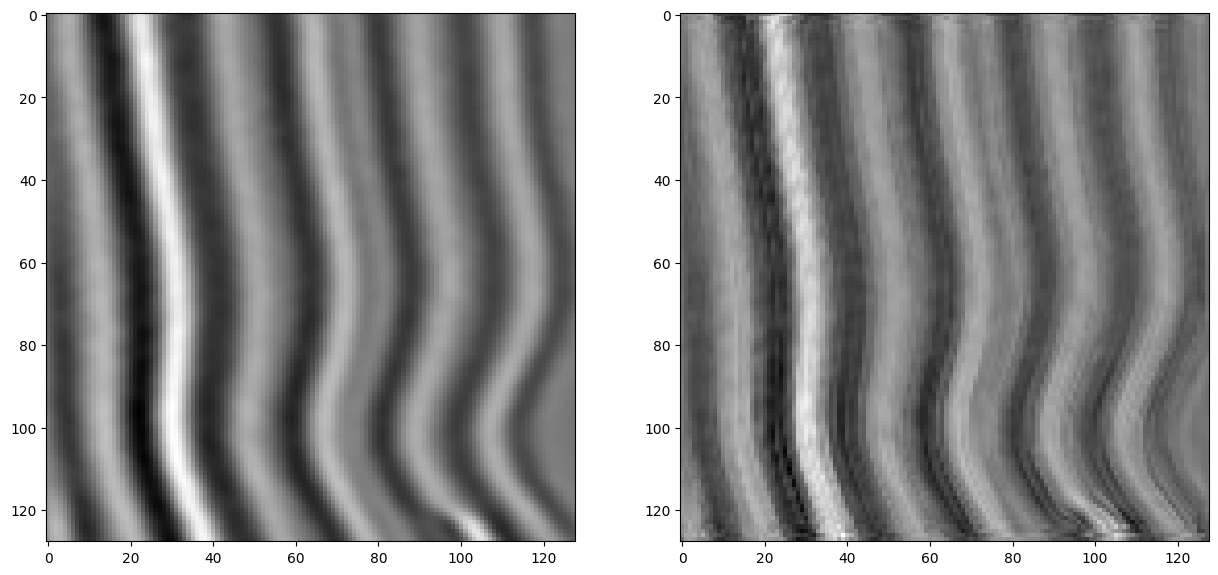

In [ ]:
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dim = 90
seismic_data_ = torch.from_numpy(seismic_data_total).to(device)[0,0,dim,...].cpu().numpy()
# 可视化
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

from matplotlib.colors import Normalize

norm1 = Normalize(seismic_data_.min(), seismic_data_.max())
norm2 = Normalize(reconstructed.min(), reconstructed.max())

axes[0].imshow(norm1(seismic_data_),
               cmap="gray")
axes[1].imshow(norm2(reconstructed.cpu().numpy()[0, dim, ...]),
               cmap="gray")

In [ ]:
# 比较通道维度第50层的切片
stats, fig = compare_4d_slices(torch.from_numpy(seismic_data_total).to(device)[0,0,...].cpu(), reconstructed, dim=1, index=50)
plt.show()
print(stats)

NameError: name 'device' is not defined

#VideoWorld

In [ ]:
# 创建一个修复脚本来更新trans_utils.py文件
%%writefile fix_numpy_bool8.py
import os

# 修复trans_utils.py文件
file_path = 'VideoWorld/LDM/ldm/utils/trans_utils.py'

with open(file_path, 'r') as f:
    content = f.read()

# 替换np.bool8为np.bool_
modified_content = content.replace('np.bool8', 'np.bool_')

with open(file_path, 'w') as f:
    f.write(modified_content)

print(f"已修复 {file_path} 中的 np.bool8 问题")


Writing fix_numpy_bool8.py


In [ ]:
!python fix_numpy_bool8.py

已修复 VideoWorld/LDM/ldm/utils/trans_utils.py 中的 np.bool8 问题


In [ ]:
!pip install rotary-embedding-torch
!pip install kornia
!pip install gateloop_transformer
!pip install webdataset

In [ ]:
#@title Latent Dynamics Model
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from torch import nn, einsum, Tensor
from torch.nn import Module, ModuleList
from typing import  Union, Tuple, Optional, List
from kornia.filters import filter3d
import math
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
from functools import wraps, partial
from torch import Tensor, int32,int64
from torch.cuda.amp import autocast
import sys
# 添加父目录路径
sys.path.append('/content/drive/MyDrive/DiTing2.0')
from MoE.qformer import QFormer, QFormerMF, PositionEmbeddingRandom, QFormerMFSep
from MoE.ldm_utilities import MagvitV2LAencoder, MagvitV2LAAdadecoder


def exists(v):
    return v is not None

def default(*args):
    for arg in args:
        if exists(arg):
            return arg
    return None

def pack_one(t, pattern):
    return pack([t], pattern)

def unpack_one(t, ps, pattern):
    return unpack(t, ps, pattern)[0]

# tensor helpers

def round_ste(z: Tensor) -> Tensor:
    """
    Round with straight through gradients.
    for f(z) = z + (round(z) - z).detach():
      df/dz = d/dz[z] + d/dz[(round(z) - z).detach()]
        = 1 + 0
        = 1
    """
    zhat = z.round()
    return z + (zhat - z).detach() # 切断梯度流，使得被 detach 的部分在反向传播时不计算梯度。

# FSQ是一种标量量化方法，将连续值离散化为有限的级别
class FSQ(Module):
    def __init__(
        self,
        levels: List[int], # 每个维度的量化级别列表，决定了每个维度可以取多少个离散值
        dim: Optional[int] = None, # 输入特征的维度，默认为levels的长度乘以codebooks数量
        num_codebooks = 1, # 码本数量
        keep_num_codebooks_dim: Optional[bool] = None, # 是否保留码本维度，当num_codebooks>1时默认为True
        scale: Optional[float] = None
    ):
        super().__init__()
        # 存储每个维度的量化级别
        _levels = torch.tensor(levels, dtype=int32)
        self.register_buffer("_levels", _levels, persistent = False)

        # 计算累乘基数，用于将多维索引转换为一维索引
        _basis = torch.cumprod(torch.tensor([1] + levels[:-1]), dim=0, dtype=int64)
        self.register_buffer("_basis", _basis, persistent = False)

        self.scale = scale

        codebook_dim = len(levels)
        self.codebook_dim = codebook_dim

        effective_codebook_dim = codebook_dim * num_codebooks
        self.num_codebooks = num_codebooks
        self.effective_codebook_dim = effective_codebook_dim

        keep_num_codebooks_dim = default(keep_num_codebooks_dim, num_codebooks > 1)
        assert not (num_codebooks > 1 and not keep_num_codebooks_dim)
        self.keep_num_codebooks_dim = keep_num_codebooks_dim

        self.dim = default(dim, len(_levels) * num_codebooks)

        has_projections = self.dim != effective_codebook_dim
        self.project_in = nn.Linear(self.dim, effective_codebook_dim) if has_projections else nn.Identity()
        self.project_out = nn.Linear(effective_codebook_dim, self.dim) if has_projections else nn.Identity()
        self.has_projections = has_projections

        self.codebook_size = self._levels.prod().item() # 码本的大小

        # implicit_codebook = self.indices_to_codes(torch.arange(self.codebook_size), project_out=False)
        # self.register_buffer("implicit_codebook", implicit_codebook, persistent=False)

    # 将输入张量z约束到有限范围
    def bound(self, z: Tensor, eps: float = 1e-3) -> Tensor:
        """Bound `z`, an array of shape (..., d)."""
        half_l = (self._levels - 1) * (1 + eps) / 2
        offset = torch.where(self._levels % 2 == 0, 0.5, 0.0) # 对于偶数级别，偏移量为 0；对于奇数级别，偏移量为 0.5
        shift = (offset / half_l).atanh()
        return (z + shift).tanh() * half_l - offset


    def quantize(self, z: Tensor) -> Tensor:
        """Quantizes z, returns quantized zhat, same shape as z."""
        quantized = round_ste(self.bound(z)) # 将值四舍五入到最近的整数（STE 表示 Straight-Through Estimator，允许在反向传播时梯度流过量化操作）
        half_width = self._levels // 2  # Renormalize to [-1, 1].
        return quantized / half_width

    # 将 [-1, 1] 范围内的归一化值转换为 [0, levels-1] 范围内的整数
    def _scale_and_shift(self, zhat_normalized: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat_normalized * half_width) + half_width

    # [0, levels-1] 范围内的整数转换回 [-1, 1] 范围内的归一化值
    def _scale_and_shift_inverse(self, zhat: Tensor) -> Tensor:
        half_width = self._levels // 2
        return (zhat - half_width) / half_width

    def codes_to_indices(self, zhat: Tensor) -> Tensor:
        """
        Converts a `code` to an index in the codebook.
        例如，如果 levels=[8, 8, 8, 5, 5, 5]，_basis=[1, 8, 64, 512, 2560, 12800]，那么编码 [3, 2, 4, 1, 0, 2] 的索引为：
              3×1 + 2×8 + 4×64 + 1×512 + 0×2560 + 2×12800 = 26291
        """
        assert zhat.shape[-1] == self.codebook_dim
        zhat = self._scale_and_shift(zhat)
        return (zhat * self._basis).sum(dim=-1).to(int64) # 多维编码转换为一维索引

    # 量化后的编码转换为码本中的索引
    def indices_to_codes(
            self,
            indices: Tensor,
            project_out=True
    ) -> Tensor:
        """Inverse of `codes_to_indices`."""

        is_img_or_video = indices.ndim >= (3 + int(self.keep_num_codebooks_dim))

        indices = rearrange(indices, '... -> ... 1')
        codes_non_centered = (indices // self._basis) % self._levels
        codes = self._scale_and_shift_inverse(codes_non_centered)

        if self.keep_num_codebooks_dim:
            codes = rearrange(codes, '... c d -> ... (c d)')

        if project_out:
            codes = self.project_out(codes)

        if is_img_or_video:
            codes = rearrange(codes, 'b ... d -> b d ...')

        return codes

    def forward(self, z: Tensor) -> Tensor:
        """
        einstein notation
        b - batch
        n - sequence (or flattened spatial dimensions)
        d - feature dimension
        c - number of codebook dim
        """
        # 打印量化前的特征统计信息
        print(f"Input feature mean: {z.mean().item()}, std: {z.std().item()}")
        print(f"Input feature min: {z.min().item()}, max: {z.max().item()}")

        is_img_or_video = z.ndim >= 4

        # standardize image or video into (batch, seq, dimension)

        if is_img_or_video:
            z = rearrange(z, 'b d ... -> b ... d')
            z, ps = pack_one(z, 'b * d')

        assert z.shape[-1] == self.dim, f'expected dimension of {self.dim} but found dimension of {z.shape[-1]}'

        z = self.project_in(z)

        z = rearrange(z, 'b n (c d) -> b n c d', c=self.num_codebooks)

        codes = self.quantize(z)
        indices = self.codes_to_indices(codes)

        codes = rearrange(codes, 'b n c d -> b n (c d)')

        out = self.project_out(codes)

        # reconstitute image or video dimensions

        if is_img_or_video:
            out = unpack_one(out, ps, 'b * d')
            out = rearrange(out, 'b ... d -> b d ...')

            indices = unpack_one(indices, ps, 'b * c')

        if not self.keep_num_codebooks_dim:
            indices = rearrange(indices, '... 1 -> ...')

        return out, indices

# 数据预处理器
class SeismicDataProcessor:
    def __init__(self, autoencoder_model, device=None):
        self.device = device if device else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.autoencoder = autoencoder_model.to(self.device)
        # 在训练模式下不要设置为eval模式
        # self.autoencoder.eval()  # 移除这一行

    def to(self, device):
        """Moves the internal autoencoder model to the specified device."""
        self.device = device # Update the processor's device attribute
        self.autoencoder = self.autoencoder.to(self.device)
        return self # Return self to allow chaining like nn.Module.to

    def encode_to_2d(self, volume_3d):
        """将3D体转换为2D latent表示，同时保存skip features"""
        # 在训练时需要梯度，移除no_grad上下文
        if not isinstance(volume_3d, torch.Tensor):
            volume_3d = torch.tensor(volume_3d, dtype=torch.float32)
        volume_3d = volume_3d.to(self.device)
        latent, skip_features = self.autoencoder.encoder(volume_3d)
        return latent, skip_features

    def decode_to_3d(self, latent_2d, skip_features):
        """使用保存的skip features将2D latent表示转换回3D体"""
        # 移除no_grad上下文，允许梯度传播
        latent_2d = latent_2d.to(self.device)
        volume_3d = self.autoencoder.decoder(latent_2d, skip_features)
        return volume_3d

# 重建数据集
class ProcessedPhysicsDataset_recon(Dataset):
    def __init__(self, seismic_data, processor, nt=2, stride=1):
        """
        Args:
            seismic_data: (model_num, t_total+1, 256, 256, 256)
            processor: SeismicDataProcessor实例
            nt: 每个样本包含的连续时间步数
            stride: 滑动窗口的步长
        """
        self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        self.processor = processor
        self.model_num = seismic_data.shape[0]
        self.t_total = seismic_data.shape[1]  # 总时间步数
        self.nt = nt  # 每个样本的时间步数
        self.stride = stride  # 滑动窗口步长

        # 计算可能的时间窗口数量
        self.num_windows = max(0, (self.t_total - self.nt + 1) // self.stride)

        if self.num_windows == 0:
            raise ValueError(f"无法创建窗口：总时间步数{self.t_total}小于所需时间步数{self.nt}")

        print(f"创建数据集：{self.model_num}个模型，每个有{self.num_windows}个时间窗口")

        # 预处理所有数据
        print("预处理数据...")
        self.processed_data = []

        for model_idx in tqdm(range(self.model_num)):
            model_windows = []

            # 对每个可能的时间窗口进行处理
            for window_idx in range(self.num_windows):
                start_t = window_idx * self.stride
                end_t = start_t + self.nt

                # 处理输入序列
                seismic_seq = self.seismic_data[model_idx, start_t:end_t]  # (nt, 256, 256, 256)

                # 目标是输入序列本身（用于重构任务）
                seismic_target = seismic_seq.clone()  # (nt, 256, 256, 256)

                # 存储每个时间步的latent和skip features
                seismic_seq_latents = []
                seismic_seq_skips = []

                # 对每个时间步进行编码
                for t in range(self.nt):
                    # 编码为2D
                    seismic_latent, seismic_skip = self.processor.encode_to_2d(seismic_seq[t].unsqueeze(0))

                    seismic_seq_latents.append(seismic_latent)
                    seismic_seq_skips.append(seismic_skip)

                # 将时间序列stack在一起
                seismic_seq_latents = torch.stack(seismic_seq_latents)  # (nt, latent_dim, H, W)

                window_data = {
                    'inputs': {
                        'seismic': {
                            'latent': seismic_seq_latents,
                            'skip_features': seismic_seq_skips
                        }
                    },
                    'targets': {
                        'seismic': seismic_target
                    },
                    'metadata': {
                        'model_idx': model_idx,
                        'window_idx': window_idx,
                        'start_t': start_t,
                        'end_t': end_t
                    }
                }

                model_windows.append(window_data)

            self.processed_data.extend(model_windows)

    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        return self.processed_data[idx]

# next-predict数据集
class ProcessedPhysicsDataset_next(Dataset):
    def __init__(self, seismic_data, processor, nt=4, stride=1):
        """
        Args:
            seismic_data: (model_num, t_total+1, 256, 256, 256)
            processor: SeismicDataProcessor实例
            nt: 每个样本包含的连续时间步数
            stride: 滑动窗口的步长
        """
        self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        self.processor = processor
        self.model_num = seismic_data.shape[0]
        self.t_total = seismic_data.shape[1]  # 总时间步数
        self.nt = nt  # 每个样本的时间步数
        self.stride = stride  # 滑动窗口步长

        # 计算可能的时间窗口数量
        self.num_windows = max(0, (self.t_total - self.nt) // self.stride) if not self.stride == 0 else 1

        if self.num_windows == 0:
            raise ValueError(f"无法创建窗口：总时间步数{self.t_total}小于所需时间步数{self.nt}")

        print(f"创建数据集：{self.model_num}个模型，每个有{self.num_windows}个时间窗口")

        # 预处理所有数据
        print("预处理数据...")
        self.processed_data = []

        for model_idx in tqdm(range(self.model_num)):
            model_windows = []

            # 对每个可能的时间窗口进行处理
            for window_idx in range(self.num_windows):
                start_t = window_idx * self.stride
                end_t = start_t + self.nt

                # 处理输入序列
                seismic_seq = self.seismic_data[model_idx, start_t:end_t]  # (nt, 256, 256, 256)

                # 修改后的目标序列逻辑 - 目标是下一个时间步序列
                target_start_t = start_t + self.nt
                target_end_t = end_t + + self.nt

                # 处理目标序列
                if target_end_t <= self.t_total:
                    # 如果目标序列完全在可用范围内
                    seismic_target = self.seismic_data[model_idx, target_start_t:target_end_t]  # (nt, 256, 256, 256)
                else:
                    # 如果目标序列部分超出可用范围，需要填充
                    # 先获取可用部分
                    available_steps = self.t_total - target_start_t
                    if available_steps > 0:
                        seismic_target = self.seismic_data[model_idx, target_start_t:self.t_total]  # (available_steps, 256, 256, 256)

                        # 计算需要填充的步数
                        padding_steps = self.nt - available_steps

                        # 使用最后一个可用时间步进行填充
                        last_step = self.seismic_data[model_idx, -1].unsqueeze(0)  # (1, 256, 256, 256)
                        padding = last_step.repeat(padding_steps, 1, 1, 1)  # (padding_steps, 256, 256, 256)

                        # 拼接可用部分和填充部分
                        seismic_target = torch.cat([seismic_target, padding], dim=0)  # (nt, 256, 256, 256)
                    else:
                        # 如果完全超出范围，全部使用最后一个时间步填充
                        last_step = self.seismic_data[model_idx, -1].unsqueeze(0)  # (1, 256, 256, 256)
                        seismic_target = last_step.repeat(self.nt, 1, 1, 1)  # (nt, 256, 256, 256)

                # 存储每个时间步的latent和skip features
                seismic_seq_latents = []
                seismic_seq_skips = []

                # 对每个时间步进行编码
                for t in range(self.nt):
                    # 编码为2D
                    seismic_latent, seismic_skip = self.processor.encode_to_2d(seismic_seq[t].unsqueeze(0))

                    seismic_seq_latents.append(seismic_latent)
                    seismic_seq_skips.append(seismic_skip)

                # 将时间序列stack在一起
                seismic_seq_latents = torch.stack(seismic_seq_latents)  # (nt, latent_dim, H, W)

                window_data = {
                    'inputs': {
                        'seismic': {
                            'latent': seismic_seq_latents,
                            'skip_features': seismic_seq_skips
                        }
                    },
                    'targets': {
                        'seismic': seismic_target
                    },
                    'metadata': {
                        'model_idx': model_idx,
                        'window_idx': window_idx,
                        'start_t': start_t,
                        'end_t': end_t,
                        'target_start_t': target_start_t,
                        'target_end_t': target_end_t
                    }
                }

                model_windows.append(window_data)

            self.processed_data.extend(model_windows)

    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        return self.processed_data[idx]

class ProcessedPhysicsDataset_next_Optimized(Dataset):
    def __init__(self, seismic_data, processor, nt=4, stride=1, device='cpu'):
        """
        Optimized Dataset for next sequence prediction. Processes data on-the-fly.

        Args:
            seismic_data (np.ndarray or torch.Tensor): Seismic data array of shape
                                                       (model_num, t_total, D, H, W)
                                                       or (model_num, t_total, H, W, C) etc.
                                                       Assumes time is the second dimension.
            processor: SeismicDataProcessor instance with an `encode_to_2d` method
                       and a `device` attribute.
            nt (int): Number of consecutive time steps in each input sample.
            stride (int): Step size for the sliding window.
            device (str or torch.device): Device to perform encoding on.
                                          Should match the processor's device.
        """
        # Ensure seismic_data is a tensor. Convert only once.
        if not isinstance(seismic_data, torch.Tensor):
            self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        else:
            # Ensure correct dtype if already a tensor
            self.seismic_data = seismic_data.float()

        self.processor = processor
        # Ensure processor's device is consistent or use the provided one
        self.device = device # Store device for potential tensor moves
        if hasattr(processor, 'device') and processor.device != torch.device(device):
             print(f"Warning: Provided device '{device}' differs from processor's device '{processor.device}'. Using processor's device.")
             self.device = processor.device

        self.model_num = self.seismic_data.shape[0]
        self.t_total = self.seismic_data.shape[1] # Total time steps available
        self.nt = nt
        self.stride = stride

        # --- Index Pre-computation ---
        # Calculate valid start times for each sample across all models
        self.sample_indices = []
        print("Pre-computing sample indices...")
        for model_idx in tqdm(range(self.model_num)):
            # The last possible start_t allows the input sequence [start_t, ..., start_t + nt - 1]
            # and the target sequence [start_t + nt, ..., start_t + 2*nt - 1] to be defined.
            # However, the target handling allows partial sequences, so the input sequence is the main constraint.
            last_possible_start_t = self.t_total - self.nt
            if last_possible_start_t < 0:
                 print(f"Warning: Model {model_idx} has t_total={self.t_total} < nt={self.nt}. Skipping this model.")
                 continue # Skip models that are too short

            # Iterate through possible start times for this model
            for start_t in range(0, last_possible_start_t + 1, self.stride):
                self.sample_indices.append({'model_idx': model_idx, 'start_t': start_t})

        if not self.sample_indices:
            raise ValueError(f"Could not create any valid windows. Check t_total ({self.t_total}), nt ({self.nt}), and stride ({self.stride}).")

        print(f"Dataset created with {len(self.sample_indices)} total samples.")
        # No data processing happens here anymore!

    def __len__(self):
        """Returns the total number of samples across all models."""
        return len(self.sample_indices)

    def __getitem__(self, idx):
        """
        Retrieves, processes (encodes), and returns a single sample.
        This is where the main computation happens per batch request.
        """
        sample_info = self.sample_indices[idx]
        model_idx = sample_info['model_idx']
        start_t = sample_info['start_t']
        end_t = start_t + self.nt # End index for input slice (exclusive)

        # --- 1. Get Input Sequence ---
        # Slice the raw input data sequence
        seismic_seq_raw = self.seismic_data[model_idx, start_t:end_t] # Shape: (nt, D, H, W) or similar

        # --- 2. Encode Input Sequence (Time step by time step) ---
        seismic_seq_latents = []
        seismic_seq_skips = []
        # Ensure processor runs on the correct device
        self.processor.to(self.device) # Make sure the processor's model is on the device
        for t in range(self.nt):
            # Unsqueeze to add batch dim (B=1) and move to the correct device for the processor
            input_step = seismic_seq_raw[t].unsqueeze(0).to(self.device)
            # Perform encoding
            with torch.no_grad(): # Important if processor includes model layers not needing grads here
                 seismic_latent, seismic_skip = self.processor.encode_to_2d(input_step)
            # Detach from graph and move to CPU if needed later, or keep on device
            seismic_seq_latents.append(seismic_latent.detach()) # Shape: (1, latent_dim, H', W')
            # Skips might be a list/tuple of tensors, handle accordingly
            # Assuming seismic_skip is a tensor or list/tuple of tensors
            if isinstance(seismic_skip, torch.Tensor):
                 seismic_seq_skips.append(seismic_skip.detach())
            elif isinstance(seismic_skip, (list, tuple)):
                 seismic_seq_skips.append([s.detach() for s in seismic_skip])
            else:
                 # Handle other potential types for skip connections if necessary
                 seismic_seq_skips.append(seismic_skip) # Or raise error

        # Stack latents along the time dimension (become the first dimension)
        # Result shape: (nt, latent_dim, H', W')
        seismic_seq_latents = torch.cat(seismic_seq_latents, dim=0)

        # Handle skips: If skips are lists of tensors per time step, structure them appropriately.
        # Example: If each skip is a list [skip1, skip2], make it a list of stacked tensors:
        # [torch.cat([skips_t[0] for skips_t in seismic_seq_skips], dim=0),
        #  torch.cat([skips_t[1] for skips_t in seismic_seq_skips], dim=0)]
        # If skip is just one tensor per step, cat them like latents:
        if all(isinstance(s, torch.Tensor) for s in seismic_seq_skips):
             final_skips = torch.cat(seismic_seq_skips, dim=0) # Shape: (nt, skip_channels, H_skip, W_skip)
        else:
             # Add logic here if skips have a more complex structure (e.g., list of tensors per step)
             # This example assumes a simple tensor case or leaves it as a list of lists/tuples
             final_skips = seismic_seq_skips # Or implement specific stacking logic


        # --- 3. Get Target Sequence ---
        target_start_t = start_t + self.nt
        target_end_t = target_start_t + self.nt

        # Check bounds for the target sequence
        if target_start_t >= self.t_total:
            # If the entire target sequence is beyond the data, pad entirely
            last_step = self.seismic_data[model_idx, -1].unsqueeze(0) # Shape: (1, D, H, W)
            seismic_target = last_step.repeat(self.nt, 1, 1, 1) # Shape: (nt, D, H, W)
        else:
            # Get the available part of the target sequence
            actual_target_end_t = min(target_end_t, self.t_total)
            seismic_target_available = self.seismic_data[model_idx, target_start_t:actual_target_end_t]

            # Calculate padding if needed
            available_steps = seismic_target_available.shape[0]
            padding_steps = self.nt - available_steps

            if padding_steps > 0:
                # Use the very last available step of the *entire* data for padding
                last_step = self.seismic_data[model_idx, -1].unsqueeze(0) # Shape: (1, D, H, W)
                padding = last_step.repeat(padding_steps, 1, 1, 1) # Shape: (padding_steps, D, H, W)
                # Concatenate available data and padding
                seismic_target = torch.cat([seismic_target_available, padding], dim=0) # Shape: (nt, D, H, W)
            else:
                # No padding needed
                seismic_target = seismic_target_available # Shape: (nt, D, H, W)


        # --- 4. Construct Output Dictionary ---
        # Note: Targets are the raw seismic data for the next nt steps
        # Inputs contain the processed (encoded) data for the current nt steps
        sample = {
            'inputs': {
                'seismic': {
                    'latent': seismic_seq_latents, # Processed input latents
                    'skip_features': final_skips  # Processed input skips
                }
            },
            'targets': {
                'seismic': seismic_target # Raw target sequence
            },
            'metadata': { # Keep metadata if needed downstream
                'model_idx': model_idx,
                'start_t': start_t,
                'end_t': end_t,
                'target_start_t': target_start_t,
                'target_end_t': target_end_t # Theoretical end, actual might be padded
            }
        }

        return sample

class ProcessedPhysicsDataset_next_Optimized_NoPad_NoGM(Dataset):
    def __init__(self, seismic_data, processor, nt=4, stride=1, device='cpu'):
        """
        Optimized Dataset for next sequence prediction. Processes data on-the-fly.

        Args:
            seismic_data (np.ndarray or torch.Tensor): Seismic data array of shape
                                                       (model_num, t_total, D, H, W)
                                                       or (model_num, t_total, H, W, C) etc.
                                                       Assumes time is the second dimension.
            processor: SeismicDataProcessor instance with an `encode_to_2d` method
                       and a `device` attribute.
            nt (int): Number of consecutive time steps in each input sample.
            stride (int): Step size for the sliding window.
            device (str or torch.device): Device to perform encoding on.
                                          Should match the processor's device.
        """
        # Ensure seismic_data is a tensor. Convert only once.
        if not isinstance(seismic_data, torch.Tensor):
            self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        else:
            # Ensure correct dtype if already a tensor
            self.seismic_data = seismic_data.float()

        self.processor = processor
        # Ensure processor's device is consistent or use the provided one
        self.device = device # Store device for potential tensor moves
        if hasattr(processor, 'device') and processor.device != torch.device(device):
             print(f"Warning: Provided device '{device}' differs from processor's device '{processor.device}'. Using processor's device.")
             self.device = processor.device

        self.model_num = self.seismic_data.shape[0]
        self.t_total = self.seismic_data.shape[1] # Total time steps available
        self.nt = nt
        self.stride = stride

        # --- Index Pre-computation ---
        # Calculate valid start times for each sample across all models
        self.sample_indices = []
        print("Pre-computing sample indices...")
        for model_idx in tqdm(range(self.model_num)):
            # The last possible start_t allows the input sequence [start_t, ..., start_t + nt - 1]
            # and the target sequence [start_t + nt, ..., start_t + 2*nt - 1] to be defined.
            # However, the target handling allows partial sequences, so the input sequence is the main constraint.
            last_possible_start_t = self.t_total - (2 * self.nt)
            if last_possible_start_t < 0:
                 print(f"Warning: Model {model_idx} has t_total={self.t_total} < nt={self.nt}. Skipping this model.")
                 continue # Skip models that are too short

            # Iterate through possible start times for this model
            for start_t in range(0, last_possible_start_t + 1, self.stride):
                self.sample_indices.append({'model_idx': model_idx, 'start_t': start_t})

        if not self.sample_indices:
            raise ValueError(f"Could not create any valid windows. Check t_total ({self.t_total}), nt ({self.nt}), and stride ({self.stride}).")

        print(f"Dataset created with {len(self.sample_indices)} total samples.")
        # No data processing happens here anymore!

    def __len__(self):
        """Returns the total number of samples across all models."""
        return len(self.sample_indices)

    def __getitem__(self, idx):
        """
        Retrieves, processes (encodes), and returns a single sample.
        This is where the main computation happens per batch request.
        """
        sample_info = self.sample_indices[idx]
        model_idx = sample_info['model_idx']
        start_t = sample_info['start_t']
        end_t = start_t + self.nt # End index for input slice (exclusive)

        # --- 1. Get Input Sequence ---
        # Slice the raw input data sequence
        seismic_seq_raw = self.seismic_data[model_idx, start_t:end_t] # Shape: (nt, D, H, W) or similar

        # --- 2. Encode Input Sequence (Time step by time step) ---
        seismic_seq_latents = []
        seismic_seq_skips = []
        # Ensure processor runs on the correct device
        self.processor.to(self.device) # Make sure the processor's model is on the device
        for t in range(self.nt):
            # Unsqueeze to add batch dim (B=1) and move to the correct device for the processor
            input_step = seismic_seq_raw[t].unsqueeze(0).to(self.device)
            # Perform encoding
            with torch.no_grad(): # Important if processor includes model layers not needing grads here
                 seismic_latent, seismic_skip = self.processor.encode_to_2d(input_step)
            # Detach from graph and move to CPU if needed later, or keep on device
            seismic_seq_latents.append(seismic_latent.detach()) # Shape: (1, latent_dim, H', W')
            # Skips might be a list/tuple of tensors, handle accordingly
            # Assuming seismic_skip is a tensor or list/tuple of tensors
            if isinstance(seismic_skip, torch.Tensor):
                 seismic_seq_skips.append(seismic_skip.detach())
            elif isinstance(seismic_skip, (list, tuple)):
                 seismic_seq_skips.append([s.detach() for s in seismic_skip])
            else:
                 # Handle other potential types for skip connections if necessary
                 seismic_seq_skips.append(seismic_skip) # Or raise error

        # Stack latents along the time dimension (become the first dimension)
        # Result shape: (nt, latent_dim, H', W')
        seismic_seq_latents = torch.cat(seismic_seq_latents, dim=0)

        # Handle skips: If skips are lists of tensors per time step, structure them appropriately.
        # Example: If each skip is a list [skip1, skip2], make it a list of stacked tensors:
        # [torch.cat([skips_t[0] for skips_t in seismic_seq_skips], dim=0),
        #  torch.cat([skips_t[1] for skips_t in seismic_seq_skips], dim=0)]
        # If skip is just one tensor per step, cat them like latents:
        if all(isinstance(s, torch.Tensor) for s in seismic_seq_skips):
             final_skips = torch.cat(seismic_seq_skips, dim=0) # Shape: (nt, skip_channels, H_skip, W_skip)
        else:
             # Add logic here if skips have a more complex structure (e.g., list of tensors per step)
             # This example assumes a simple tensor case or leaves it as a list of lists/tuples
             final_skips = seismic_seq_skips # Or implement specific stacking logic


        # --- 3. Get Target Sequence ---
        target_start_t = start_t + self.nt
        target_end_t = target_start_t + self.nt

        # Check bounds for the target sequence
        if target_start_t >= self.t_total:
            # If the entire target sequence is beyond the data, pad entirely
            last_step = self.seismic_data[model_idx, -1].unsqueeze(0) # Shape: (1, D, H, W)
            seismic_target = last_step.repeat(self.nt, 1, 1, 1) # Shape: (nt, D, H, W)
        else:
            # Get the available part of the target sequence
            actual_target_end_t = min(target_end_t, self.t_total)
            seismic_target_available = self.seismic_data[model_idx, target_start_t:actual_target_end_t]

            # Calculate padding if needed
            available_steps = seismic_target_available.shape[0]
            padding_steps = self.nt - available_steps

            if padding_steps > 0:
                # Use the very last available step of the *entire* data for padding
                last_step = self.seismic_data[model_idx, -1].unsqueeze(0) # Shape: (1, D, H, W)
                padding = last_step.repeat(padding_steps, 1, 1, 1) # Shape: (padding_steps, D, H, W)
                # Concatenate available data and padding
                seismic_target = torch.cat([seismic_target_available, padding], dim=0) # Shape: (nt, D, H, W)
            else:
                # No padding needed
                seismic_target = seismic_target_available # Shape: (nt, D, H, W)


        # --- 4. Construct Output Dictionary ---
        # Note: Targets are the raw seismic data for the next nt steps
        # Inputs contain the processed (encoded) data for the current nt steps
        sample = {
            'inputs': {
                'seismic': {
                    'latent': seismic_seq_latents, # Processed input latents
                    'skip_features': final_skips  # Processed input skips
                }
            },
            'targets': {
                'seismic': seismic_target # Raw target sequence
            },
            'metadata': { # Keep metadata if needed downstream
                'model_idx': model_idx,
                'start_t': start_t,
                'end_t': end_t,
                'target_start_t': target_start_t,
                'target_end_t': target_end_t # Theoretical end, actual might be padded
            }
        }

        return sample

class ProcessedPhysicsDataset_next_Optimized_NoPad(Dataset):
    def __init__(self, seismic_data, gravity_data, magnetic_data, vp_data, processor, nt=4, stride=1, device='cpu'):
        """
        Optimized Dataset for next sequence prediction. Processes data on-the-fly.

        Args:
            seismic_data (np.ndarray or torch.Tensor): Seismic data array of shape
                                                       (model_num, t_total, D, H, W)
                                                       or (model_num, t_total, H, W, C) etc.
                                                       Assumes time is the second dimension.
            gravity_data (np.ndarray or torch.Tensor): Gravity anomaly data of shape
                                                       (model_num, t_total, H, W)
            magnetic_data (np.ndarray or torch.Tensor): Magnetic anomaly data of shape
                                                       (model_num, t_total, H, W)
            processor: SeismicDataProcessor instance with an `encode_to_2d` method
                       and a `device` attribute.
            nt (int): Number of consecutive time steps in each input sample.
            stride (int): Step size for the sliding window.
            device (str or torch.device): Device to perform encoding on.
                                          Should match the processor's device.
        """
        # Ensure seismic_data is a tensor. Convert only once.
        if not isinstance(seismic_data, torch.Tensor):
            self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        else:
            self.seismic_data = seismic_data.float()

        # Gravity anomaly
        if not isinstance(gravity_data, torch.Tensor):
            self.gravity_data = torch.tensor(gravity_data, dtype=torch.float32)
        else:
            self.gravity_data = gravity_data.float()

        # Magnetic anomaly
        if not isinstance(magnetic_data, torch.Tensor):
            self.magnetic_data = torch.tensor(magnetic_data, dtype=torch.float32)
        else:
            self.magnetic_data = magnetic_data.float()

        # vp
        if not isinstance(vp_data, torch.Tensor):
            self.vp_data = torch.tensor(vp_data, dtype=torch.float32)
        else:
            self.vp_data = vp_data.float()

        self.processor = processor
        self.device = device
        if hasattr(processor, 'device') and processor.device != torch.device(device):
            print(f"Warning: Provided device '{device}' differs from processor's device '{processor.device}'. Using processor's device.")
            self.device = processor.device

        self.model_num = self.seismic_data.shape[0]
        self.t_total = self.seismic_data.shape[1] # Total time steps available
        self.nt = nt
        self.stride = stride

        # --- Index Pre-computation ---
        self.sample_indices = []
        print("Pre-computing sample indices...")
        for model_idx in tqdm(range(self.model_num)):
            last_possible_start_t = self.t_total - (2 * self.nt)
            if last_possible_start_t < 0:
                print(f"Warning: Model {model_idx} has t_total={self.t_total} < nt={self.nt}. Skipping this model.")
                continue

            for start_t in range(0, last_possible_start_t + 1, self.stride):
                self.sample_indices.append({'model_idx': model_idx, 'start_t': start_t})

        if not self.sample_indices:
            raise ValueError(f"Could not create any valid windows. Check t_total ({self.t_total}), nt ({self.nt}), and stride ({self.stride}).")

        print(f"Dataset created with {len(self.sample_indices)} total samples.")

    def __len__(self):
        """Returns the total number of samples across all models."""
        return len(self.sample_indices)

    def __getitem__(self, idx):
        """
        Retrieves, processes (encodes), and returns a single sample.
        This is where the main computation happens per batch request.
        """
        sample_info = self.sample_indices[idx]
        model_idx = sample_info['model_idx']
        start_t = sample_info['start_t']
        end_t = start_t + self.nt # End index for input slice (exclusive)

        # --- 1. Get Input Sequence: Seismic, Gravity, Magnetic, Vp ---
        seismic_seq_raw = self.seismic_data[model_idx, start_t:end_t] # (nt, D, H, W)
        gravity_seq_raw = self.gravity_data[model_idx, start_t:end_t] # (nt, H, W)
        magnetic_seq_raw = self.magnetic_data[model_idx, start_t:end_t] # (nt, H, W)
        vp_seq_raw = self.vp_data[model_idx, start_t:end_t]  # (nt, D, H, W)

        # --- 2. Encode Input Sequence (Time step by time step) ---
        seismic_seq_latents = []
        seismic_seq_skips = []
        self.processor.to(self.device)
        for t in range(self.nt):
            input_step = seismic_seq_raw[t].unsqueeze(0).to(self.device)
            with torch.no_grad():
                seismic_latent, seismic_skip = self.processor.encode_to_2d(input_step)
            seismic_seq_latents.append(seismic_latent.detach())
            if isinstance(seismic_skip, torch.Tensor):
                seismic_seq_skips.append(seismic_skip.detach())
            elif isinstance(seismic_skip, (list, tuple)):
                seismic_seq_skips.append([s.detach() for s in seismic_skip])
            else:
                seismic_seq_skips.append(seismic_skip)

        seismic_seq_latents = torch.cat(seismic_seq_latents, dim=0)
        if all(isinstance(s, torch.Tensor) for s in seismic_seq_skips):
            final_skips = torch.cat(seismic_seq_skips, dim=0)
        else:
            final_skips = seismic_seq_skips

        # --- 3. Get Target Sequence: Seismic, Gravity, Magnetic ---
        target_start_t = start_t + self.nt
        target_end_t = target_start_t + self.nt

        # Seismic target (3D)
        if target_start_t >= self.t_total:
            last_step = self.seismic_data[model_idx, -1].unsqueeze(0)
            seismic_target = last_step.repeat(self.nt, 1, 1, 1)
        else:
            actual_target_end_t = min(target_end_t, self.t_total)
            seismic_target_available = self.seismic_data[model_idx, target_start_t:actual_target_end_t]
            available_steps = seismic_target_available.shape[0]
            padding_steps = self.nt - available_steps
            if padding_steps > 0:
                last_step = self.seismic_data[model_idx, -1].unsqueeze(0)
                padding = last_step.repeat(padding_steps, 1, 1, 1)
                seismic_target = torch.cat([seismic_target_available, padding], dim=0)
            else:
                seismic_target = seismic_target_available

        # Gravity anomaly target (2D)
        if target_start_t >= self.t_total:
            last_grav = self.gravity_data[model_idx, -1].unsqueeze(0)
            gravity_target = last_grav.repeat(self.nt, 1, 1)
        else:
            actual_target_end_t = min(target_end_t, self.t_total)
            gravity_target_available = self.gravity_data[model_idx, target_start_t:actual_target_end_t]
            available_steps = gravity_target_available.shape[0]
            padding_steps = self.nt - available_steps
            if padding_steps > 0:
                last_grav = self.gravity_data[model_idx, -1].unsqueeze(0)
                padding = last_grav.repeat(padding_steps, 1, 1)
                gravity_target = torch.cat([gravity_target_available, padding], dim=0)
            else:
                gravity_target = gravity_target_available

        # Magnetic anomaly target (2D)
        if target_start_t >= self.t_total:
            last_mag = self.magnetic_data[model_idx, -1].unsqueeze(0)
            magnetic_target = last_mag.repeat(self.nt, 1, 1)
        else:
            actual_target_end_t = min(target_end_t, self.t_total)
            magnetic_target_available = self.magnetic_data[model_idx, target_start_t:actual_target_end_t]
            available_steps = magnetic_target_available.shape[0]
            padding_steps = self.nt - available_steps
            if padding_steps > 0:
                last_mag = self.magnetic_data[model_idx, -1].unsqueeze(0)
                padding = last_mag.repeat(padding_steps, 1, 1)
                magnetic_target = torch.cat([magnetic_target_available, padding], dim=0)
            else:
                magnetic_target = magnetic_target_available
        # VP (3D)
        if target_start_t >= self.t_total:
            last_vp = self.vp_data[model_idx, -1].unsqueeze(0)
            vp_target = last_vp.repeat(self.nt, 1, 1, 1)
        else:
            actual_target_end_t = min(target_end_t, self.t_total)
            vp_target_available = self.vp_data[model_idx, target_start_t:actual_target_end_t]
            available_steps = vp_target_available.shape[0]
            padding_steps = self.nt - available_steps
            if padding_steps > 0:
                last_vp = self.vp_data[model_idx, -1].unsqueeze(0)
                padding = last_vp.repeat(padding_steps, 1, 1, 1)
                vp_target = torch.cat([vp_target_available, padding], dim=0)
            else:
                vp_target = vp_target_available

        # --- 4. Construct Output Dictionary ---
        sample = {
            'inputs': {
                'seismic': {
                    'latent': seismic_seq_latents,
                    'skip_features': final_skips
                },
                'gravity_anomoly': gravity_seq_raw,   # (nt, H, W)
                'magnetic_anomoly': magnetic_seq_raw,  # (nt, H, W)
                'vp': vp_seq_raw # (nt, D, H, W)
            },
            'targets': {
                'seismic': seismic_target,                # (nt, D, H, W)
                'gravity_anomoly': gravity_target,        # (nt, H, W)
                'magnetic_anomoly': magnetic_target,       # (nt, H, W)
                'vp': vp_target # (nt, D, H, W)
            },
            'metadata': {
                'model_idx': model_idx,
                'start_t': start_t,
                'end_t': end_t,
                'target_start_t': target_start_t,
                'target_end_t': target_end_t
            }
        }

        return sample


# 改进的VideoWorld模型
class VideoWorldPhysicsModel(nn.Module):
    '''
    ldm
    '''
    def __init__(self, image_size=128, latent_channels=512, frame_num=4,act_embedding_num=2):
        super().__init__()

        self.encoder = MagvitV2LAencoder(
            image_size=image_size, #
            channels=latent_channels,
            frame_num=frame_num,
            init_dim=128,
            pre_out_layer=9,
            act_embedding_num=act_embedding_num, # num_q_former
        layers=(
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 256 -> 128
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            ('spatial_down', 1),        # 128 -> 64
            ('consecutive_residual', 4),
            ('spatial_down', 1),        # 64 -> 32
            ('channel_residual', 1),
            ('consecutive_residual', 3),
            # ('spatial_down', 1),        # 32 -> 16 (新增)
            ('consecutive_residual', 4),
        )
        )

        self.quantizer = FSQ(
            dim=512,
            levels=[5024] * 6,#[8, 8, 8, 5, 5, 5],
            num_codebooks=1
        )
        self.decoder = MagvitV2LAAdadecoder(
            image_size=image_size,
            channels=latent_channels,
            init_dim=128,
            use_pre_video=False,
            use_pre_encode=True,
        layers=(
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 16 -> 32
            ('consecutive_residual', 4),
            ('condation', 1),
            ('spatial_up', 1),         # 32 -> 64
            ('consecutive_residual', 3),
            ('channel_residual', 1),
            ('condation', 1),
            ('spatial_up', 1),         # 64 -> 128
            ('consecutive_residual', 4),
            ('condation', 1),
            # ('spatial_up', 1),         # 128 -> 256 (新增)
            # ('condation', 1),          # 可能需要添加对应的条件层
            ('consecutive_residual', 4)
        )
        )

    def forward(self, x):
        # 确保输入形状正确 (B, C, T, H, W)
        if x.dim() == 4:
            x = x.unsqueeze(0)
        elif x.dim() == 5 and x.shape[1] != self.encoder.channels:
            x = x.permute(0, 2, 1, 3, 4)
        # print(f'VWencode前的形状:{x.shape}') # [1, 3, 2, 128, 128]

        encoded, cond, video_contains_first_frame, pre_encode_out = self.encoder(x)
        # print(f'VWencode后的形状:{encoded.shape}') # [1, 512, 1, 1, 1]
        # print(f'pre_encode_out的形状:{pre_encode_out.shape}')

        quantized, indices = self.quantizer(encoded) # 不改变维度
        # print('编码与量化结果是否相同：',torch.allclose(encoded,quantized))

        # pre_encode_out = pre_encode_out[:,:,-1:,...] # remove padding dimension and keep first frame
        decoded = self.decoder(quantized, cond=cond,
                             video_contains_first_frame=video_contains_first_frame,
                             pre_encode_out=pre_encode_out)
        # print(f'VWdecode后的形状:{decoded.shape}')

        return decoded, quantized, indices, video_contains_first_frame, pre_encode_out

def main():
    # 设置设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 加载预训练的autoencoder
    autoencoder = SeismicDimensionAutoencoder(latent_dim=3)
    autoencoder.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/pre_ae_3latent_4_128.pt", map_location=device))

    # 创建数据处理器
    processor = SeismicDataProcessor(autoencoder, device)

    # 加载数据
    t_total = 10
    nt = 2  # 每个样本的时间步数
    stride = 3  # 滑动窗口步长
    selected_idx = 1
    data_path = "/content/drive/MyDrive/DiTing2.0/dataset/self_constructed_128/"

    # 加载完整时间序列数据
    # seismic_data = np.fromfile(f"{data_path}tld_seis_meandering_{selected_idx}.bin",
    #                           dtype=np.float32).reshape(1, nt, 256, 256, 256)
    seismic_data = seismic_data_total

    # 创建数据集和加载器
    dataset = ProcessedPhysicsDataset_next(seismic_data, processor, nt=nt, stride=stride)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

    # 查看数据集大小
    print(f"数据集大小: {len(dataset)}")

    # 查看第一个批次
    for batch in dataloader:
        print("输入形状:")
        print(f"地震数据: {batch['inputs']['seismic']['latent'].shape}")
        # print(f"通道数据: {batch['inputs']['channel']['latent'].shape}")
        print("目标形状:")
        print(f"地震目标: {batch['targets']['seismic'].shape}")
        # print(f"通道目标: {batch['targets']['channel'].shape}")
        print("元数据:")
        print(f"模型索引: {batch['metadata']['model_idx']}")
        print(f"窗口索引: {batch['metadata']['window_idx']}")
        print(f"开始时间: {batch['metadata']['start_t']}") # 最后一步时间窗
        print(f"结束时间: {batch['metadata']['end_t']}")
        break
    # 初始化VideoWorld模型
    model = VideoWorldPhysicsModel(
        image_size=128,
        latent_channels=3,
        frame_num=nt
    ).to(device)

    # 设置autoencoder为评估模式并冻结其参数
    autoencoder.eval()
    for param in autoencoder.parameters():
        param.requires_grad = False

    # 训练配置 - 只优化VideoWorld模型的参数
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    num_epochs = 10

    # 训练循环
    for epoch in range(num_epochs):
        model.train()  # 确保model处于训练模式
        total_loss = 0

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            # print('\n', batch['inputs']['seismic']['latent'].shape)

            # 准备输入数据
            seismic_input = batch['inputs']['seismic']['latent'].squeeze(0).permute(1,2,0,3,4).to(device) # [1,3,T,X,Y]
            seismic_skip_features = batch['inputs']['seismic']['skip_features']

            # 前向传播
            seismic_output = model(seismic_input)  # B, C, T, H, W

            # 使用处于eval模式的autoencoder进行解码
            with torch.no_grad():  # 确保不会计算autoencoder的梯度
                # 如果processor.decode_to_3d内部使用了autoencoder，那么它应该已经处于eval模式
                # 但我们需要确保梯度可以通过seismic_output传播
                seismic_output_detached = seismic_output.detach()  # 暂时分离梯度

            # 重新附加梯度跟踪，这样梯度可以通过seismic_output_3d回传到model
            seismic_output_3d = processor.decode_to_3d(
                seismic_output,  # 使用原始的有梯度的输出
                seismic_skip_features
            )

            # 计算损失
            seismic_target = batch['targets']['seismic'].to(device)
            recon_loss = F.mse_loss(seismic_output_3d, seismic_target)
            loss = recon_loss

            # 反向传播
            loss.backward(retain_graph=True)

            # 验证梯度是否正确流向model参数
            has_grad = any(p.grad is not None and torch.sum(torch.abs(p.grad)) > 0 for p in model.parameters())
            print(f"Model has gradients: {has_grad}")

            optimizer.step()
            total_loss += loss.item()

        # 输出训练信息
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}")
    # 8m 23s
        # # 保存检查点
        # if (epoch + 1) % 10 == 0:
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict': optimizer.state_dict(),
        #         'loss': avg_loss,
        #     }, f"checkpoint_epoch_{epoch+1}.pt")

    # 保存最终模型
    torch.save(model.state_dict(), f_path+"/ckp_u_pre_ae/vw_ldm_4_128.pt")


In [ ]:
#@title 老数据集，一些代码可参考
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载预训练的autoencoder
autoencoder = SeismicDimensionAutoencoder(latent_dim=3)
autoencoder.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/pre_ae_3latent_4_128.pt", map_location=device))

# 创建数据处理器
processor = SeismicDataProcessor(autoencoder, device)

# 加载数据
T = 10
H = 2  # subsequent H frames + 1
stride = 3  # 滑动窗口步长
selected_idx = 1
data_path = "/content/drive/MyDrive/DiTing2.0/dataset/self_constructed_128/"

# 加载完整时间序列数据
# seismic_data = np.fromfile(f"{data_path}tld_seis_meandering_{selected_idx}.bin",
#                           dtype=np.float32).reshape(1, nt, 256, 256, 256)
seismic_data = seismic_data_total

# 创建数据集和加载器
dataset = ProcessedPhysicsDataset_next(seismic_data, processor, nt=H, stride=stride)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# 查看数据集大小
print(f"数据集大小: {len(dataset)}")

# 查看第一个批次
for batch in dataloader:
    print("输入形状:")
    print(f"地震数据: {batch['inputs']['seismic']['latent'].shape}")
    # print(f"通道数据: {batch['inputs']['channel']['latent'].shape}")
    print("目标形状:")
    print(f"地震目标: {batch['targets']['seismic'].shape}")
    # print(f"通道目标: {batch['targets']['channel'].shape}")
    print("元数据:")
    print(f"模型索引: {batch['metadata']['model_idx']}")
    print(f"窗口索引: {batch['metadata']['window_idx']}")
    print(f"开始时间: {batch['metadata']['start_t']}") # 最后一步时间窗
    print(f"结束时间: {batch['metadata']['end_t']}")
    break

KeyboardInterrupt: 

In [ ]:
#@title 时移数据集
import torch
import numpy as np
import random

# 设置所有随机种子
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 如果使用多GPU
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载预训练的autoencoder
autoencoder = SeismicDimensionAutoencoder(latent_dim=3)
autoencoder.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/pre_ae_3latent_4_64.pt", map_location=device))

# 创建数据处理器 pre_ae
processor = SeismicDataProcessor(autoencoder, device)

# 加载数据
T = 10
H_plus_1 = 4
stride = 1  #

seismic_data = seismic_data_total

# 创建数据集和加载器
# dataset = ProcessedPhysicsDataset_next_Optimized_NoPad(seismic_data, processor, nt=H_plus_1, stride=stride)
dataset = ProcessedPhysicsDataset_next_Optimized_NoPad(
    seismic_data_total,
    gravity_data_total,
    magnetic_data_total,
    vp_data_total,
    processor,
    nt=H_plus_1,
    stride=stride
)


# --- Start of the filtering logic ---
from torch.utils.data import Subset, Dataset
original_size = len(dataset) # Should be 160
block_size = 8
keep_size = 4
discard_size = block_size - keep_size # = 4

indices_to_keep = []

# Iterate through the dataset in blocks of 16
for i in range(0, original_size, block_size):
    # For each block, take the indices of the first 8 items
    start_index_of_block = i
    end_index_to_keep = start_index_of_block + keep_size

    # Add indices from start_index_of_block up to (but not including) end_index_to_keep
    # Ensure we don't try to access indices beyond the dataset's actual size
    for index in range(start_index_of_block, min(end_index_to_keep, original_size)):
        indices_to_keep.append(index)

# Alternatively, using list comprehension (more concise):
# indices_to_keep = [
#     idx for block_start in range(0, original_size, block_size)
#     for idx in range(block_start, min(block_start + keep_size, original_size))
# ]


# Create the new dataset containing only the selected indices
filtered_dataset = Subset(dataset, indices_to_keep)

# --- End of the filtering logic ---

print(f"Original dataset size: {len(dataset)}")
print(f"Filtered dataset size: {len(filtered_dataset)}") # Should be 160 / 16 * 8 = 80

set_seed(42)
dataloader = DataLoader(filtered_dataset, batch_size=1, shuffle=True)

# 查看数据集大小
print(f"数据集大小: {len(dataset)}")

# 查看第一个批次
for batch in dataloader:
    print("输入形状:")
    print(f"地震数据: {batch['inputs']['seismic']['latent'].shape}")
    # print(f"通道数据: {batch['inputs']['channel']['latent'].shape}")
    print("目标形状:")
    print(f"地震目标: {batch['targets']['seismic'].shape}")
    # print(f"通道目标: {batch['targets']['channel'].shape}")
    print("元数据:")
    # print(f"模型索引: {batch['metadata']['model_idx']}")
    # print(f"开始时间: {batch['metadata']['start_t']}") # 最后一步时间窗
    # print(f"结束时间: {batch['metadata']['end_t']}")
    break

Pre-computing sample indices...


100%|██████████| 20/20 [00:00<00:00, 157680.60it/s]

Dataset created with 80 total samples.
Original dataset size: 80
Filtered dataset size: 40
数据集大小: 80


输入形状:
地震数据: torch.Size([1, 4, 3, 64, 64])
目标形状:
地震目标: torch.Size([1, 4, 64, 64, 64])
元数据:


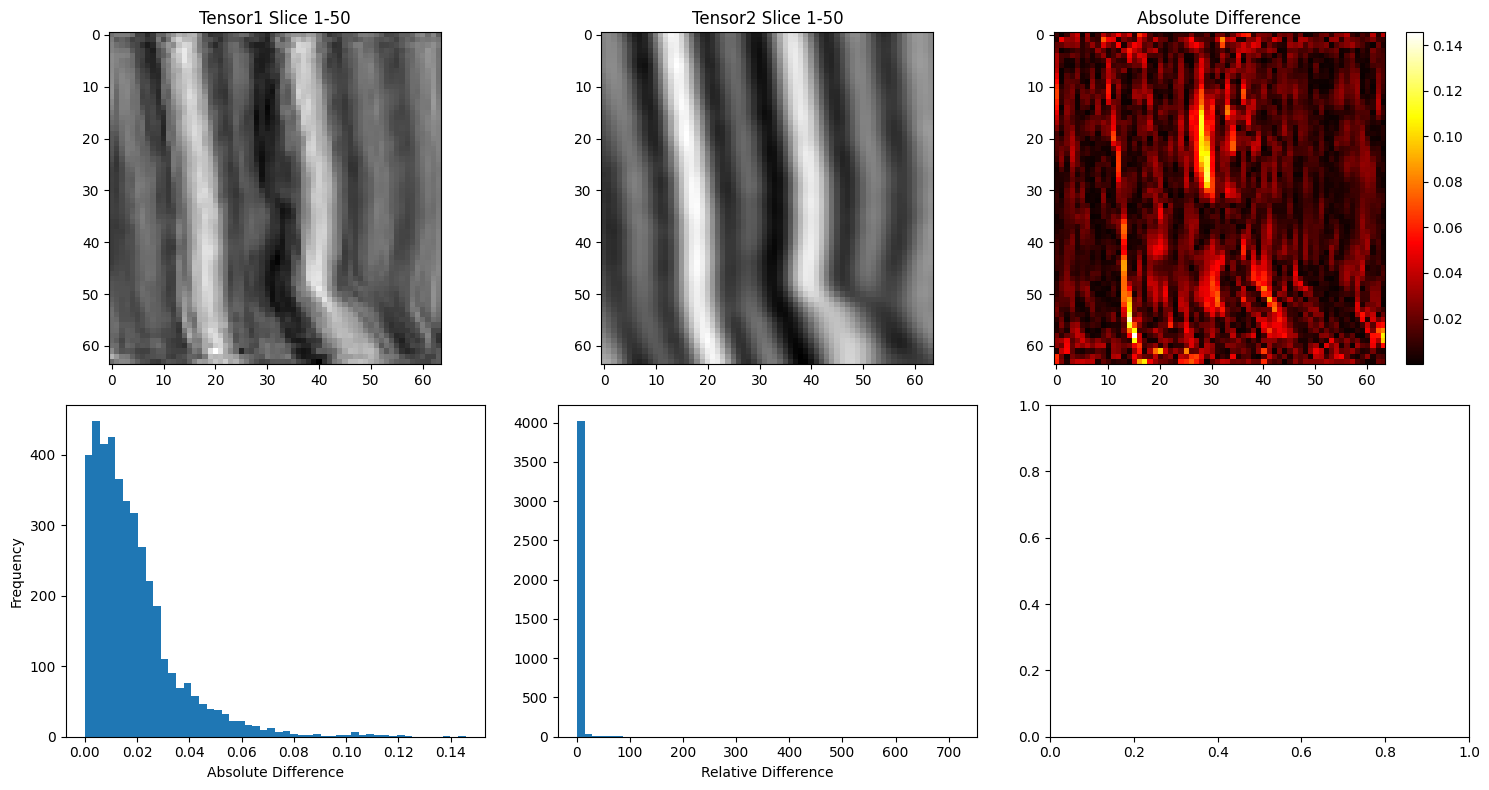

{'max_abs': 0.1456529051065445, 'mean_abs': 0.018645578995347023, 'rel_over_threshold': 0.99853515625}


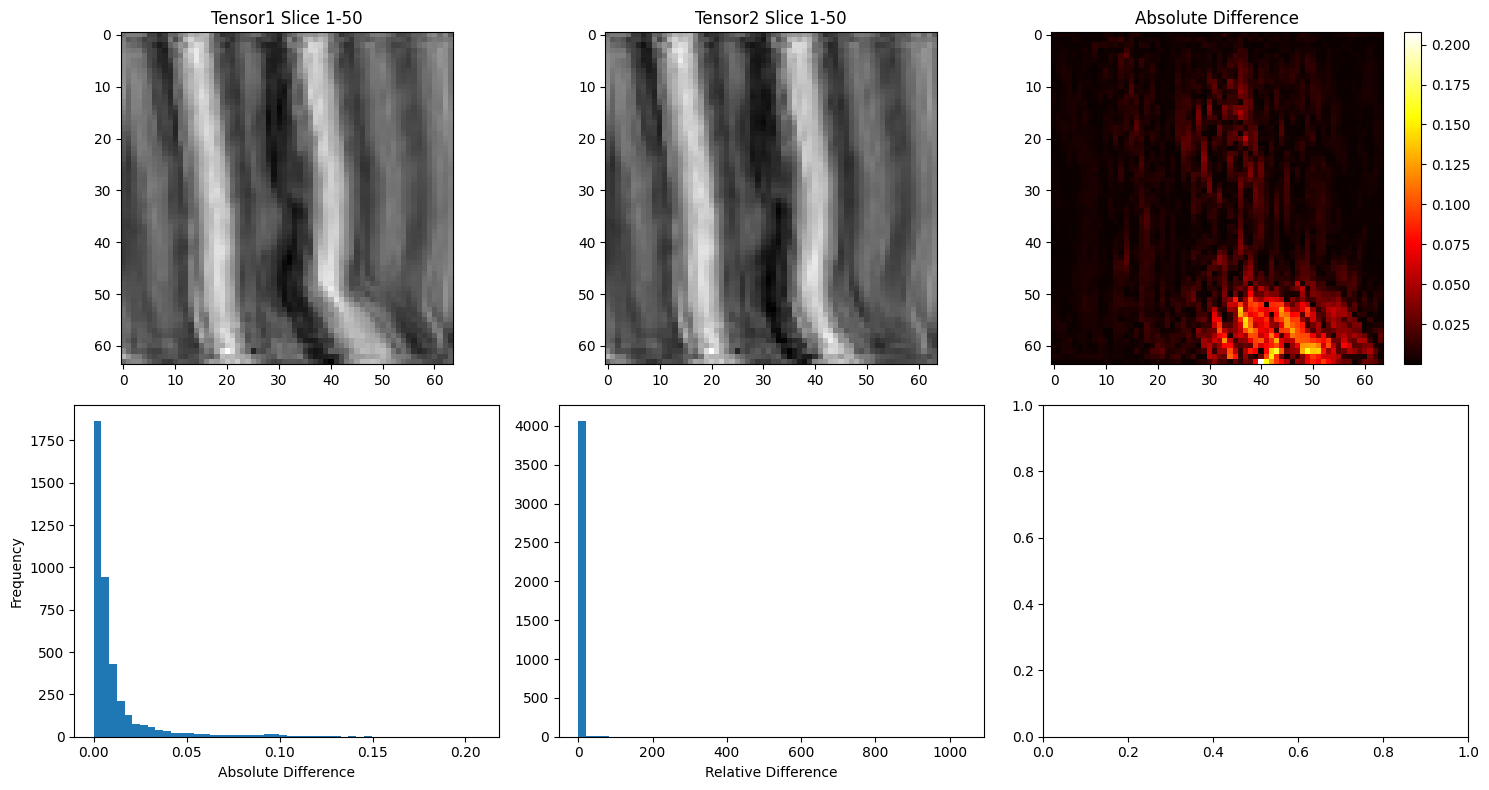

{'max_abs': 0.20769955217838287, 'mean_abs': 0.01116553507745266, 'rel_over_threshold': 0.9951171875}


In [ ]:
#@title validate if next_optimized dataset's target is similar to model prediction
dataloader_ = DataLoader(filtered_dataset, batch_size=1, shuffle=False)
dataloader_iter = iter(dataloader_)

latents_list = []
skips_list = []

for i in range(0,5):
    batch = next(dataloader_iter)
    if i == 0:
      output = batch['targets']['seismic']
    latents_list.append(batch['inputs']['seismic']['latent'])
    skips_list.append(batch['inputs']['seismic']['skip_features'])

latents_input = latents_list[0]      # [1, 4, 3, 64, 64]
skips_input = skips_list[0]
# index is 4 so target is selected
latents = latents_list[4]      # [1, 4, 3, 64, 64]
skips = skips_list[4]

checks = []
for i in range(latents.shape[1]):  # 遍历4个slice
    latent_i = latents[:, i, ...]  # [1, 3, 64, 64]
    skip_i = [skip[0] for skip in skips[i]]      # 按需取对应skip特征
    out_i = autoencoder.decoder(latent_i, skip_i)  # [1, ...]
    checks.append(out_i)

# 假设输出out_i shape为 [1, C, 64, 64]，拼成 [1, 4, C, 64, 64]
checks_target = torch.stack(checks, dim=1).squeeze(2)  # 在第1维拼接

checks = []
for i in range(latents_input.shape[1]):  # 遍历4个slice
    latent_i = latents_input[:, i, ...]  # [1, 3, 64, 64]
    skip_i = [skip[0] for skip in skips_input[i]]      # 按需取对应skip特征
    out_i = autoencoder.decoder(latent_i, skip_i)  # [1, ...]
    checks.append(out_i)

# 假设输出out_i shape为 [1, C, 64, 64]，拼成 [1, 4, C, 64, 64]
checks_input = torch.stack(checks, dim=1).squeeze(2)  # 在第1维拼接
t = 3
stats, fig = compare_4d_slices(checks_target[0,t].unsqueeze(0).detach(), output[0,t].unsqueeze(0).detach(), dim=1, index=50)
plt.show()
print(stats)
stats, fig = compare_4d_slices(checks_target[0,t].unsqueeze(0).detach(), checks_input[0,t].unsqueeze(0).detach(), dim=1, index=50)
plt.show()
print(stats)

In [ ]:
#@title LDM training
torch.cuda.empty_cache()
# 初始化VideoWorld模型
model = VideoWorldPhysicsModel(
    image_size=64,
    latent_channels=3,
    frame_num=H_plus_1,
    act_embedding_num=H_plus_1-1
).to(device)

# 设置autoencoder为评估模式并冻结其参数
autoencoder.eval()
for param in autoencoder.parameters():
    param.requires_grad = False

# 训练配置 - 只优化VideoWorld模型的参数
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
num_epochs = 5

# 训练循环
for epoch in range(num_epochs):
    model.train()  # 确保model处于训练模式
    total_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()
        # print('\n', batch['inputs']['seismic']['latent'].shape)

        # 准备输入数据
        # seismic_input = batch['inputs']['seismic']['latent'].squeeze(0).permute(1,2,0,3,4).to(device) # [1,3,T,X,Y]
        seismic_input = batch['inputs']['seismic']['latent'].permute(0,2,1,3,4).to(device) # [1,3,T,X,Y]
        seismic_skip_features = batch['inputs']['seismic']['skip_features']

        # 前向传播
        decoded, quantized, indices, video_contains_first_frame, pre_encode_out = model(seismic_input)  # B, C, T, H, W

        # 使用处于eval模式的autoencoder进行解码
        with torch.no_grad():  # 确保不会计算autoencoder的梯度
            # 如果processor.decode_to_3d内部使用了autoencoder，那么它应该已经处于eval模式
            # 但我们需要确保梯度可以通过seismic_output传播
            decoded_detached = decoded.detach()  # 暂时分离梯度

        # 重新附加梯度跟踪，这样梯度可以通过seismic_output_3d回传到model
        seismic_output_3d = processor.decode_to_3d(
            decoded,  # 使用原始的有梯度的输出
            seismic_skip_features
        )

        # 计算损失
        seismic_target = batch['targets']['seismic'].to(device)
        recon_loss = F.mse_loss(seismic_output_3d, seismic_target)
        loss = recon_loss

        # 反向传播
        loss.backward(retain_graph=True)

        # 验证梯度是否正确流向model参数
        # has_grad = any(p.grad is not None and torch.sum(torch.abs(p.grad)) > 0 for p in model.parameters())
        # print(f"Model has gradients: {has_grad}")

        optimizer.step()
        total_loss += loss.item()
        print(f"Loss: {loss:.6f}")
    # 输出训练信息
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

# 保存最终模型
torch.save(model.state_dict(), f_path+"/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch10.pt")

Epoch 1/2:   0%|          | 0/40 [00:00<?, ?it/s]

video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -7.140139590688932e-09, std: 1.0003209114074707
Input feature min: -3.9763522148132324, max: 4.0306806564331055


Epoch 1/2:   2%|▎         | 1/40 [00:11<07:24, 11.39s/it]

Loss: 0.001306
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.5782812852194184e-06, std: 1.000342845916748
Input feature min: -3.6369826793670654, max: 2.864582061767578


Epoch 1/2:   5%|▌         | 2/40 [00:21<06:38, 10.49s/it]

Loss: 0.000934
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.4847686290740967e-06, std: 1.0003552436828613
Input feature min: -2.970536947250366, max: 3.271679639816284


Epoch 1/2:   8%|▊         | 3/40 [00:30<06:12, 10.06s/it]

Loss: 0.001324
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.4049153327941895e-06, std: 1.000364065170288
Input feature min: -2.7332065105438232, max: 3.5763497352600098


Epoch 1/2:  10%|█         | 4/40 [00:39<05:37,  9.38s/it]

Loss: 0.001927
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.035110123368213e-06, std: 1.000372290611267
Input feature min: -2.680772066116333, max: 3.7158782482147217


Epoch 1/2:  12%|█▎        | 5/40 [00:48<05:29,  9.42s/it]

Loss: 0.006088
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.299846179696033e-06, std: 1.0003807544708252
Input feature min: -2.7090952396392822, max: 3.743662118911743


Epoch 1/2:  15%|█▌        | 6/40 [00:58<05:25,  9.58s/it]

Loss: 0.001065
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.985920779494336e-06, std: 1.0003881454467773
Input feature min: -2.7258012294769287, max: 3.7352185249328613


Epoch 1/2:  18%|█▊        | 7/40 [01:07<05:07,  9.33s/it]

Loss: 0.000892
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.5236040427407715e-06, std: 1.000394344329834
Input feature min: -2.7289819717407227, max: 3.7093820571899414


Epoch 1/2:  20%|██        | 8/40 [01:16<04:56,  9.25s/it]

Loss: 0.000370
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.925935394974658e-06, std: 1.0003993511199951
Input feature min: -2.725372076034546, max: 3.6789965629577637


Epoch 1/2:  22%|██▎       | 9/40 [01:25<04:48,  9.30s/it]

Loss: 0.001553
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -7.133310191420605e-06, std: 1.0004042387008667
Input feature min: -2.721811532974243, max: 3.6474149227142334


Epoch 1/2:  25%|██▌       | 10/40 [01:35<04:41,  9.37s/it]

Loss: 0.002153
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -7.579723842354724e-06, std: 1.0004080533981323
Input feature min: -2.724682331085205, max: 3.6162075996398926


Epoch 1/2:  28%|██▊       | 11/40 [01:45<04:38,  9.60s/it]

Loss: 0.002107
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -7.877747520979028e-06, std: 1.0004125833511353
Input feature min: -2.722886323928833, max: 3.5817983150482178


Epoch 1/2:  30%|███       | 12/40 [01:54<04:25,  9.48s/it]

Loss: 0.001968
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -8.297462954942603e-06, std: 1.0004161596298218
Input feature min: -2.7254316806793213, max: 3.5519843101501465


Epoch 1/2:  32%|███▎      | 13/40 [02:03<04:12,  9.37s/it]

Loss: 0.000246
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -8.453925147478003e-06, std: 1.0004191398620605
Input feature min: -2.7349770069122314, max: 3.5308799743652344


Epoch 1/2:  35%|███▌      | 14/40 [02:13<04:03,  9.37s/it]

Loss: 0.002791
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -8.694827556610107e-06, std: 1.000422477722168
Input feature min: -2.741917610168457, max: 3.506951093673706


Epoch 1/2:  38%|███▊      | 15/40 [02:21<03:49,  9.20s/it]

Loss: 0.005428
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -9.190291166305542e-06, std: 1.0004281997680664
Input feature min: -2.750697374343872, max: 3.477071762084961


Epoch 1/2:  40%|████      | 16/40 [02:31<03:45,  9.38s/it]

Loss: 0.002483
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -9.978811249311548e-06, std: 1.0004332065582275
Input feature min: -2.760563611984253, max: 3.444856882095337


Epoch 1/2:  42%|████▎     | 17/40 [02:41<03:36,  9.43s/it]

Loss: 0.001101
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.0348856449127197e-05, std: 1.000437617301941
Input feature min: -2.771604537963867, max: 3.414857864379883


Epoch 1/2:  45%|████▌     | 18/40 [02:51<03:31,  9.59s/it]

Loss: 0.001969
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.1086463928222656e-05, std: 1.0004419088363647
Input feature min: -2.7803690433502197, max: 3.3817267417907715


Epoch 1/2:  48%|████▊     | 19/40 [03:00<03:17,  9.41s/it]

Loss: 0.003641
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.1632840141828638e-05, std: 1.0004476308822632
Input feature min: -2.767642021179199, max: 3.3359193801879883


Epoch 1/2:  50%|█████     | 20/40 [03:09<03:09,  9.46s/it]

Loss: 0.001733
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.2539327144622803e-05, std: 1.0004520416259766
Input feature min: -2.754910707473755, max: 3.2933237552642822


Epoch 1/2:  52%|█████▎    | 21/40 [03:19<02:59,  9.44s/it]

Loss: 0.001038
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.2959043488081079e-05, std: 1.0004551410675049
Input feature min: -2.7591207027435303, max: 3.358172655105591


Epoch 1/2:  55%|█████▌    | 22/40 [03:28<02:49,  9.44s/it]

Loss: 0.006367
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.3836969628755469e-05, std: 1.0004606246948242
Input feature min: -2.72796368598938, max: 3.462170362472534


Epoch 1/2:  57%|█████▊    | 23/40 [03:38<02:40,  9.41s/it]

Loss: 0.003392
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.4506280422210693e-05, std: 1.0004668235778809
Input feature min: -2.6886801719665527, max: 3.5396780967712402


Epoch 1/2:  60%|██████    | 24/40 [03:47<02:31,  9.46s/it]

Loss: 0.002041
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.529604196548462e-05, std: 1.0004713535308838
Input feature min: -2.6564559936523438, max: 3.5932984352111816


Epoch 1/2:  62%|██████▎   | 25/40 [03:57<02:21,  9.45s/it]

Loss: 0.000378
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.5945484847179614e-05, std: 1.000475525856018
Input feature min: -2.629852294921875, max: 3.633296012878418


Epoch 1/2:  65%|██████▌   | 26/40 [04:06<02:10,  9.35s/it]

Loss: 0.000244
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.636768320167903e-05, std: 1.000478982925415
Input feature min: -2.6084442138671875, max: 3.6619813442230225


Epoch 1/2:  68%|██████▊   | 27/40 [04:15<02:02,  9.40s/it]

Loss: 0.001828
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.651917955314275e-05, std: 1.000482439994812
Input feature min: -2.610041379928589, max: 3.6805543899536133


Epoch 1/2:  70%|███████   | 28/40 [04:26<01:56,  9.71s/it]

Loss: 0.001674
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.7075488358386792e-05, std: 1.000485897064209
Input feature min: -2.6254501342773438, max: 3.704206943511963


Epoch 1/2:  72%|███████▎  | 29/40 [04:35<01:45,  9.55s/it]

Loss: 0.001808
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.7687678337097168e-05, std: 1.00048828125
Input feature min: -2.6698415279388428, max: 3.7206525802612305


Epoch 1/2:  75%|███████▌  | 30/40 [04:44<01:34,  9.46s/it]

Loss: 0.001720
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.800060272216797e-05, std: 1.0004916191101074
Input feature min: -2.686213970184326, max: 3.7350070476531982


Epoch 1/2:  78%|███████▊  | 31/40 [04:54<01:25,  9.54s/it]

Loss: 0.002107
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.8676122635952197e-05, std: 1.0004936456680298
Input feature min: -2.726515293121338, max: 3.7478582859039307


Epoch 1/2:  80%|████████  | 32/40 [05:03<01:15,  9.44s/it]

Loss: 0.000248
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.8807748347171582e-05, std: 1.0004957914352417
Input feature min: -2.7298498153686523, max: 3.756671905517578


Epoch 1/2:  82%|████████▎ | 33/40 [05:12<01:05,  9.29s/it]

Loss: 0.002677
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.9375234842300415e-05, std: 1.0004982948303223
Input feature min: -2.7640202045440674, max: 3.7657082080841064


Epoch 1/2:  85%|████████▌ | 34/40 [05:22<00:56,  9.44s/it]

Loss: 0.000351
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -1.9433597117313184e-05, std: 1.0004996061325073
Input feature min: -2.776677370071411, max: 3.7667717933654785


Epoch 1/2:  88%|████████▊ | 35/40 [05:31<00:47,  9.47s/it]

Loss: 0.006586
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.0310282707214355e-05, std: 1.0005029439926147
Input feature min: -2.821887254714966, max: 3.78650164604187


Epoch 1/2:  90%|█████████ | 36/40 [05:41<00:37,  9.44s/it]

Loss: 0.000248
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.0793328076251782e-05, std: 1.0005054473876953
Input feature min: -2.8457345962524414, max: 3.7970130443573


Epoch 1/2:  92%|█████████▎| 37/40 [05:50<00:27,  9.28s/it]

Loss: 0.000381
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.1403035134426318e-05, std: 1.0005073547363281
Input feature min: -2.8702778816223145, max: 3.8033456802368164


Epoch 1/2:  95%|█████████▌| 38/40 [05:59<00:18,  9.38s/it]

Loss: 0.001223
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.1535903215408325e-05, std: 1.0005090236663818
Input feature min: -2.8787059783935547, max: 3.8026394844055176


Epoch 1/2:  98%|█████████▊| 39/40 [06:09<00:09,  9.43s/it]

Loss: 0.002015
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.244114875793457e-05, std: 1.0005112886428833
Input feature min: -2.9088940620422363, max: 3.801880359649658


Epoch 1/2: 100%|██████████| 40/40 [06:18<00:00,  9.47s/it]


Loss: 0.000769
Epoch 1/2, Average Loss: 0.001954


Epoch 2/2:   0%|          | 0/40 [00:00<?, ?it/s]

video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.2983798771747388e-05, std: 1.0005125999450684
Input feature min: -2.967655658721924, max: 3.8010425567626953


Epoch 2/2:   2%|▎         | 1/40 [00:08<05:47,  8.91s/it]

Loss: 0.001807
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.3697813958278857e-05, std: 1.000514030456543
Input feature min: -3.0559134483337402, max: 3.795591354370117


Epoch 2/2:   5%|▌         | 2/40 [00:19<06:07,  9.66s/it]

Loss: 0.002107
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.4614235371700488e-05, std: 1.000515103340149
Input feature min: -3.130398988723755, max: 3.7884442806243896


Epoch 2/2:   8%|▊         | 3/40 [00:28<05:55,  9.61s/it]

Loss: 0.001064
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.533942461013794e-05, std: 1.0005162954330444
Input feature min: -3.1919002532958984, max: 3.7811856269836426


Epoch 2/2:  10%|█         | 4/40 [00:38<05:42,  9.53s/it]

Loss: 0.000248
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.600252628326416e-05, std: 1.0005173683166504
Input feature min: -3.250157356262207, max: 3.7736825942993164


Epoch 2/2:  12%|█▎        | 5/40 [00:47<05:32,  9.49s/it]

Loss: 0.001103
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.6460736989974976e-05, std: 1.000518560409546
Input feature min: -3.3004167079925537, max: 3.7632668018341064


Epoch 2/2:  15%|█▌        | 6/40 [00:57<05:25,  9.57s/it]

Loss: 0.000924
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.675876021385193e-05, std: 1.0005192756652832
Input feature min: -3.311284303665161, max: 3.7567574977874756


Epoch 2/2:  18%|█▊        | 7/40 [01:06<05:14,  9.53s/it]

Loss: 0.001899
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.72504985332489e-05, std: 1.0005204677581787
Input feature min: -3.358288288116455, max: 3.753450632095337


Epoch 2/2:  20%|██        | 8/40 [01:15<05:01,  9.42s/it]

Loss: 0.006561
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.8568008929141797e-05, std: 1.000521183013916
Input feature min: -3.4054722785949707, max: 3.7253618240356445


Epoch 2/2:  22%|██▎       | 9/40 [01:25<04:55,  9.52s/it]

Loss: 0.001323
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.9576322049251758e-05, std: 1.0005221366882324
Input feature min: -3.4587507247924805, max: 3.700044631958008


Epoch 2/2:  25%|██▌       | 10/40 [01:35<04:47,  9.59s/it]

Loss: 0.001224
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -2.997120282088872e-05, std: 1.000523328781128
Input feature min: -3.4783096313476562, max: 3.6821177005767822


Epoch 2/2:  28%|██▊       | 11/40 [01:44<04:32,  9.41s/it]

Loss: 0.002772
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.060946983168833e-05, std: 1.0005240440368652
Input feature min: -3.5116219520568848, max: 3.6576521396636963


Epoch 2/2:  30%|███       | 12/40 [01:54<04:26,  9.52s/it]

Loss: 0.006282
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.1616538763046265e-05, std: 1.000523328781128
Input feature min: -3.548851251602173, max: 3.6233322620391846


Epoch 2/2:  32%|███▎      | 13/40 [02:04<04:21,  9.69s/it]

Loss: 0.001669
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.241499143769033e-05, std: 1.0005230903625488
Input feature min: -3.582263946533203, max: 3.5933125019073486


Epoch 2/2:  35%|███▌      | 14/40 [02:14<04:15,  9.84s/it]

Loss: 0.002012
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.3306580007774755e-05, std: 1.0005226135253906
Input feature min: -3.614274263381958, max: 3.567009925842285


Epoch 2/2:  38%|███▊      | 15/40 [02:23<04:00,  9.64s/it]

Loss: 0.001553
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.3916283427970484e-05, std: 1.0005218982696533
Input feature min: -3.6403274536132812, max: 3.539393663406372


Epoch 2/2:  40%|████      | 16/40 [02:32<03:47,  9.49s/it]

Loss: 0.000895
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.419816493988037e-05, std: 1.000521183013916
Input feature min: -3.6487364768981934, max: 3.5177600383758545


Epoch 2/2:  42%|████▎     | 17/40 [02:42<03:38,  9.51s/it]

Loss: 0.002465
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.4795451938407496e-05, std: 1.0005205869674683
Input feature min: -3.6621057987213135, max: 3.49025297164917


Epoch 2/2:  45%|████▌     | 18/40 [02:51<03:28,  9.49s/it]

Loss: 0.000247
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.517419099807739e-05, std: 1.0005196332931519
Input feature min: -3.672283887863159, max: 3.4672043323516846


Epoch 2/2:  48%|████▊     | 19/40 [03:01<03:19,  9.52s/it]

Loss: 0.000352
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.5533059417502955e-05, std: 1.000519037246704
Input feature min: -3.6788127422332764, max: 3.4451794624328613


Epoch 2/2:  50%|█████     | 20/40 [03:10<03:11,  9.55s/it]

Loss: 0.001233
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.543992716004141e-05, std: 1.0005196332931519
Input feature min: -3.6899638175964355, max: 3.435513496398926


Epoch 2/2:  52%|█████▎    | 21/40 [03:20<03:01,  9.57s/it]

Loss: 0.005927
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.68654727935791e-05, std: 1.0005156993865967
Input feature min: -3.7268807888031006, max: 3.387795925140381


Epoch 2/2:  55%|█████▌    | 22/40 [03:29<02:52,  9.56s/it]

Loss: 0.000249
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.77980359189678e-05, std: 1.0005121231079102
Input feature min: -3.7756590843200684, max: 3.3465964794158936


Epoch 2/2:  57%|█████▊    | 23/40 [03:39<02:39,  9.41s/it]

Loss: 0.000769
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.875916081597097e-05, std: 1.000510334968567
Input feature min: -3.7983059883117676, max: 3.3122265338897705


Epoch 2/2:  60%|██████    | 24/40 [03:48<02:31,  9.46s/it]

Loss: 0.001830
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -3.957127410103567e-05, std: 1.0005074739456177
Input feature min: -3.8243660926818848, max: 3.2750179767608643


Epoch 2/2:  62%|██████▎   | 25/40 [03:58<02:24,  9.65s/it]

Loss: 0.000379
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.0138762415153906e-05, std: 1.0005053281784058
Input feature min: -3.846510410308838, max: 3.2395777702331543


Epoch 2/2:  65%|██████▌   | 26/40 [04:08<02:14,  9.62s/it]

Loss: 0.000246
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.0682654798729345e-05, std: 1.0005027055740356
Input feature min: -3.897895574569702, max: 3.2129933834075928


Epoch 2/2:  68%|██████▊   | 27/40 [04:17<02:02,  9.39s/it]

Loss: 0.002077
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.112347960472107e-05, std: 1.000501036643982
Input feature min: -3.8657543659210205, max: 3.1774771213531494


Epoch 2/2:  70%|███████   | 28/40 [04:26<01:52,  9.40s/it]

Loss: 0.001039
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.2015064536826685e-05, std: 1.000497817993164
Input feature min: -3.8807473182678223, max: 3.1579842567443848


Epoch 2/2:  72%|███████▎  | 29/40 [04:36<01:43,  9.44s/it]

Loss: 0.002037
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.1802722989814356e-05, std: 1.0004990100860596
Input feature min: -3.8689868450164795, max: 3.142956495285034


Epoch 2/2:  75%|███████▌  | 30/40 [04:45<01:33,  9.36s/it]

Loss: 0.001723
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.2207539081573486e-05, std: 1.0004982948303223
Input feature min: -3.8457069396972656, max: 3.138334035873413


Epoch 2/2:  78%|███████▊  | 31/40 [04:54<01:24,  9.34s/it]

Loss: 0.001728
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.23404089815449e-05, std: 1.0004982948303223
Input feature min: -3.838775396347046, max: 3.133582353591919


Epoch 2/2:  80%|████████  | 32/40 [05:04<01:15,  9.48s/it]

Loss: 0.002138
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.2383868276374415e-05, std: 1.0004987716674805
Input feature min: -3.8383500576019287, max: 3.1242597103118896


Epoch 2/2:  82%|████████▎ | 33/40 [05:13<01:06,  9.47s/it]

Loss: 0.000371
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.268934208084829e-05, std: 1.000498652458191
Input feature min: -3.823538064956665, max: 3.1225874423980713


Epoch 2/2:  85%|████████▌ | 34/40 [05:23<00:57,  9.62s/it]

Loss: 0.002664
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.2705487430794165e-05, std: 1.0004966259002686
Input feature min: -3.8843679428100586, max: 3.1152474880218506


Epoch 2/2:  88%|████████▊ | 35/40 [05:33<00:48,  9.70s/it]

Loss: 0.003618
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.3368589103920385e-05, std: 1.000497817993164
Input feature min: -3.7888832092285156, max: 3.0970640182495117


Epoch 2/2:  90%|█████████ | 36/40 [05:43<00:39,  9.75s/it]

Loss: 0.000382
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.355857890914194e-05, std: 1.0004936456680298
Input feature min: -3.8638460636138916, max: 3.0901057720184326


Epoch 2/2:  92%|█████████▎| 37/40 [05:53<00:29,  9.69s/it]

Loss: 0.005289
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.6530116378562525e-05, std: 1.0004947185516357
Input feature min: -3.549104928970337, max: 3.0527985095977783


Epoch 2/2:  95%|█████████▌| 38/40 [06:02<00:19,  9.57s/it]

Loss: 0.003369
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.8031408368842676e-05, std: 1.0004905462265015
Input feature min: -3.104358196258545, max: 2.998091459274292


Epoch 2/2:  98%|█████████▊| 39/40 [06:12<00:09,  9.73s/it]

Loss: 0.001957
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -4.9270689487457275e-05, std: 1.0004827976226807
Input feature min: -2.7267556190490723, max: 2.9639689922332764


Epoch 2/2: 100%|██████████| 40/40 [06:22<00:00,  9.55s/it]

Loss: 0.001961
Epoch 2/2, Average Loss: 0.001937


In [ ]:
#@title 第二种LDM的training方式
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
# 假设 VideoWorldPhysicsModel, Processor, dataloader, H_plus_1, device 已经定义好
# from your_module import VideoWorldPhysicsModel, Processor # 确保导入模型定义

# --- 配置 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 64
latent_channels = 3
# H_plus_1 = ... # 确保 H_plus_1 与保存模型时一致
act_embedding_num = H_plus_1 - 1 # 确保 act_embedding_num 与保存模型时一致
learning_rate = 1e-5 # 可以根据需要调整
start_epoch = 2 # 你之前训练到了第10个epoch，现在从第11个开始 (或者根据需要设定)
num_epochs = 8 # 总共希望训练到的epoch数
model_load_path = f_path + "/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch2.pt"
model_save_path_prefix = f_path + "/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch"

# --- 1. 重新实例化模型和优化器 ---
model = VideoWorldPhysicsModel(
    image_size=image_size,
    latent_channels=latent_channels,
    frame_num=H_plus_1,
    act_embedding_num=act_embedding_num
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# --- (同样需要处理 Autoencoder) ---
# autoencoder = ... # 重新加载或定义autoencoder
# autoencoder.eval()
# for param in autoencoder.parameters():
#     param.requires_grad = False
# processor = ... # 重新加载或定义processor

# --- 2. 加载模型状态字典 ---
print(f"Loading model state_dict from: {model_load_path}")
model.load_state_dict(torch.load(model_load_path, map_location=device))
print("Model state_dict loaded successfully.")

# --- （可选）如果你之前保存了优化器状态 ---
# optimizer_load_path = "path/to/your/optimizer_epoch10.pt"
# if os.path.exists(optimizer_load_path):
#     optimizer.load_state_dict(torch.load(optimizer_load_path, map_location=device))
#     print("Optimizer state_dict loaded successfully.")
# else:
#     print("Optimizer state_dict not found, starting optimizer from scratch.")


# --- 训练循环 ---
for epoch in range(start_epoch, num_epochs): # 从 start_epoch 开始
    # --- 4. 将模型设置为训练模式 ---
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        optimizer.zero_grad()

        # 准备输入数据 (与之前代码相同)
        seismic_input = batch['inputs']['seismic']['latent'].permute(0,2,1,3,4).to(device)
        seismic_skip_features = batch['inputs']['seismic']['skip_features']

        # 前向传播 (与之前代码相同)
        decoded, quantized, indices, video_contains_first_frame, pre_encode_out = model(seismic_input)

        # 解码 (与之前代码相同)
        with torch.no_grad():
            decoded_detached = decoded.detach()
        seismic_output_3d = processor.decode_to_3d(
            decoded,
            seismic_skip_features
        )

        # 计算损失 (与之前代码相同)
        seismic_target = batch['targets']['seismic'].to(device)
        recon_loss = F.mse_loss(seismic_output_3d, seismic_target)
        loss = recon_loss

        # 反向传播 (与之前代码相同)
        # 注意：如果你在之前的训练中使用了 retain_graph=True，检查是否仍然需要它。
        # 如果每次迭代的计算图都是独立的，通常不需要设置 retain_graph=True。
        # 只有当你需要在一次 backward() 调用后再次对同一计算图的部分进行 backward() 时才需要。
        # 在典型的训练循环中，每次迭代都会构建新的计算图，所以通常不需要。
        loss.backward() # 移除了 retain_graph=True，除非你有特殊原因需要它

        optimizer.step()
        total_loss += loss.item()
        print(f"Loss: {loss:.6f}") # 可以取消注释以查看每个batch的loss

    # 输出训练信息
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.6f}")

    # --- 保存当前 epoch 的模型 ---
    current_save_path = f"{model_save_path_prefix}{epoch+1}.pt"
    torch.save(model.state_dict(), current_save_path)
    print(f"Model saved to {current_save_path}")

    # --- （可选但推荐）保存优化器状态 ---
    # optimizer_save_path = f"path/to/your/optimizer_epoch{epoch+1}.pt"
    # torch.save(optimizer.state_dict(), optimizer_save_path)
    # print(f"Optimizer state saved to {optimizer_save_path}")


print("Training finished.")

# --- 更好的保存/加载方式：保存检查点 (Checkpointing) ---
# 为了更方便地恢复训练，推荐将模型状态、优化器状态、当前epoch等信息保存在一个字典里：

# 保存检查点:
# checkpoint = {
#     'epoch': epoch + 1,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': avg_loss, # 或者最后一个 batch 的 loss
#     # 可以添加其他需要保存的信息，比如 learning rate scheduler state
#     # 'scheduler_state_dict': scheduler.state_dict()
# }
# checkpoint_path = f"path/to/your/checkpoint_epoch{epoch+1}.pth" # 使用 .pth 或 .tar 扩展名更常见
# torch.save(checkpoint, checkpoint_path)

# 加载检查点:
# checkpoint_path = "path/to/your/checkpoint_epoch10.pth"
# checkpoint = torch.load(checkpoint_path, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# start_epoch = checkpoint['epoch'] # 从检查点中恢复 epoch
# last_loss = checkpoint['loss']
# # if 'scheduler_state_dict' in checkpoint:
# #     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
# print(f"Checkpoint loaded. Resuming training from epoch {start_epoch}")
# model.train() # 确保模型在训练模式
# # 或者 model.eval() 如果你只是想加载模型进行评估


Loading model state_dict from: /content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch2.pt
Model state_dict loaded successfully.


Epoch 3/8:   0%|          | 0/40 [00:00<?, ?it/s]

video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.02591319673229e-05, std: 1.0004825592041016
Input feature min: -2.6075820922851562, max: 2.9359805583953857


Epoch 3/8:   2%|▎         | 1/40 [00:12<08:04, 12.42s/it]

Loss: 0.004899
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.062793570687063e-05, std: 1.0004827976226807
Input feature min: -2.6065824031829834, max: 3.013366222381592


Epoch 3/8:   5%|▌         | 2/40 [00:23<07:29, 11.82s/it]

Loss: 0.002230
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.0707410991890356e-05, std: 1.0004829168319702
Input feature min: -2.604628801345825, max: 3.091061592102051


Epoch 3/8:   8%|▊         | 3/40 [00:36<07:30, 12.17s/it]

Loss: 0.003153
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.042801421950571e-05, std: 1.000482439994812
Input feature min: -2.603904962539673, max: 3.1758604049682617


Epoch 3/8:  10%|█         | 4/40 [00:49<07:28, 12.45s/it]

Loss: 0.001495
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.116499960422516e-05, std: 1.0004793405532837
Input feature min: -2.602167844772339, max: 3.1681325435638428


Epoch 3/8:  12%|█▎        | 5/40 [01:01<07:16, 12.49s/it]

Loss: 0.002492
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.310960114002228e-05, std: 1.0004738569259644
Input feature min: -2.585235595703125, max: 3.085235118865967


Epoch 3/8:  15%|█▌        | 6/40 [01:14<07:08, 12.60s/it]

Loss: 0.002903
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.3624313295586035e-05, std: 1.000468134880066
Input feature min: -2.5769834518432617, max: 3.076341390609741


Epoch 3/8:  18%|█▊        | 7/40 [01:27<06:53, 12.52s/it]

Loss: 0.002219
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.3831685363547876e-05, std: 1.000461220741272
Input feature min: -2.550466775894165, max: 3.2461535930633545


Epoch 3/8:  20%|██        | 8/40 [01:39<06:39, 12.48s/it]

Loss: 0.004933
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.3588300943374634e-05, std: 1.0004600286483765
Input feature min: -2.5825448036193848, max: 3.247009038925171


Epoch 3/8:  22%|██▎       | 9/40 [01:51<06:27, 12.49s/it]

Loss: 0.001120
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.08843622810673e-05, std: 1.0004520416259766
Input feature min: -2.657611608505249, max: 3.2843031883239746


Epoch 3/8:  25%|██▌       | 10/40 [02:04<06:15, 12.52s/it]

Loss: 0.001045
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.251355469226837e-05, std: 1.000454068183899
Input feature min: -2.6533608436584473, max: 3.28251576423645


Epoch 3/8:  28%|██▊       | 11/40 [02:17<06:11, 12.80s/it]

Loss: 0.002405
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.16908876306843e-05, std: 1.00044846534729
Input feature min: -2.7397754192352295, max: 3.3173341751098633


Epoch 3/8:  30%|███       | 12/40 [02:30<05:55, 12.71s/it]

Loss: 0.004931
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.370813232730143e-05, std: 1.000451683998108
Input feature min: -2.710078716278076, max: 3.3292577266693115


Epoch 3/8:  32%|███▎      | 13/40 [02:43<05:43, 12.73s/it]

Loss: 0.002453
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.4559361160499975e-05, std: 1.0004512071609497
Input feature min: -2.7572007179260254, max: 3.3519058227539062


Epoch 3/8:  35%|███▌      | 14/40 [02:55<05:29, 12.69s/it]

Loss: 0.002512
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.3233157814247534e-05, std: 1.0004456043243408
Input feature min: -2.796522378921509, max: 3.3555026054382324


Epoch 3/8:  38%|███▊      | 15/40 [03:08<05:19, 12.78s/it]

Loss: 0.000982
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.478101593325846e-05, std: 1.0004479885101318
Input feature min: -2.8197405338287354, max: 3.374474287033081


Epoch 3/8:  40%|████      | 16/40 [03:21<05:07, 12.83s/it]

Loss: 0.002050
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.638599395751953e-05, std: 1.000449776649475
Input feature min: -2.8651905059814453, max: 3.4074981212615967


Epoch 3/8:  42%|████▎     | 17/40 [03:34<04:51, 12.67s/it]

Loss: 0.000944
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.604357647825964e-05, std: 1.0004481077194214
Input feature min: -2.887622833251953, max: 3.403472661972046


Epoch 3/8:  45%|████▌     | 18/40 [03:46<04:37, 12.60s/it]

Loss: 0.001884
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.76535239815712e-05, std: 1.0004502534866333
Input feature min: -2.9195396900177, max: 3.437516450881958


Epoch 3/8:  48%|████▊     | 19/40 [03:59<04:25, 12.67s/it]

Loss: 0.000975
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.7041335821850225e-05, std: 1.00044846534729
Input feature min: -2.9354195594787598, max: 3.4265968799591064


Epoch 3/8:  50%|█████     | 20/40 [04:11<04:10, 12.54s/it]

Loss: 0.002018
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.670512837241404e-05, std: 1.0004466772079468
Input feature min: -2.954054355621338, max: 3.4369654655456543


Epoch 3/8:  52%|█████▎    | 21/40 [04:23<03:57, 12.48s/it]

Loss: 0.000997
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.739554762840271e-05, std: 1.0004477500915527
Input feature min: -2.9748945236206055, max: 3.4446191787719727


Epoch 3/8:  55%|█████▌    | 22/40 [04:36<03:45, 12.53s/it]

Loss: 0.002410
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.947425961494446e-05, std: 1.0004518032073975
Input feature min: -2.9924538135528564, max: 3.507549285888672


Epoch 3/8:  57%|█████▊    | 23/40 [04:48<03:32, 12.49s/it]

Loss: 0.002064
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.14561140537262e-05, std: 1.000454306602478
Input feature min: -3.0034589767456055, max: 3.5417661666870117


Epoch 3/8:  60%|██████    | 24/40 [05:02<03:23, 12.73s/it]

Loss: 0.001137
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.972757935523987e-05, std: 1.000451922416687
Input feature min: -3.020024061203003, max: 3.5303497314453125


Epoch 3/8:  62%|██████▎   | 25/40 [05:14<03:08, 12.59s/it]

Loss: 0.002378
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.861216413904913e-05, std: 1.000449776649475
Input feature min: -3.0285696983337402, max: 3.478768825531006


Epoch 3/8:  65%|██████▌   | 26/40 [05:27<02:56, 12.62s/it]

Loss: 0.002879
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.031369048287161e-05, std: 1.0004531145095825
Input feature min: -3.0360443592071533, max: 3.518947124481201


Epoch 3/8:  68%|██████▊   | 27/40 [05:39<02:42, 12.54s/it]

Loss: 0.001228
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.8788806200027466e-05, std: 1.0004502534866333
Input feature min: -3.0450334548950195, max: 3.4919965267181396


Epoch 3/8:  70%|███████   | 28/40 [05:51<02:29, 12.46s/it]

Loss: 0.000949
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.085510176490061e-05, std: 1.0004545450210571
Input feature min: -3.052433729171753, max: 3.5194735527038574


Epoch 3/8:  72%|███████▎  | 29/40 [06:05<02:19, 12.70s/it]

Loss: 0.002700
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.182802462717518e-05, std: 1.0004565715789795
Input feature min: -3.0599300861358643, max: 3.5403404235839844


Epoch 3/8:  75%|███████▌  | 30/40 [06:17<02:05, 12.52s/it]

Loss: 0.002173
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.282267713686451e-05, std: 1.0004584789276123
Input feature min: -3.0583863258361816, max: 3.5645296573638916


Epoch 3/8:  78%|███████▊  | 31/40 [06:29<01:51, 12.43s/it]

Loss: 0.001032
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.0017842770321295e-05, std: 1.0004537105560303
Input feature min: -3.0638842582702637, max: 3.4923288822174072


Epoch 3/8:  80%|████████  | 32/40 [06:41<01:39, 12.43s/it]

Loss: 0.001583
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.956615132163279e-05, std: 1.0004525184631348
Input feature min: -3.0673928260803223, max: 3.4898109436035156


Epoch 3/8:  82%|████████▎ | 33/40 [06:54<01:26, 12.40s/it]

Loss: 0.001897
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.967728793621063e-05, std: 1.0004527568817139
Input feature min: -3.0684962272644043, max: 3.4851040840148926


Epoch 3/8:  85%|████████▌ | 34/40 [07:06<01:14, 12.46s/it]

Loss: 0.003089
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.069398295949213e-05, std: 1.000455617904663
Input feature min: -3.068256139755249, max: 3.492466688156128


Epoch 3/8:  88%|████████▊ | 35/40 [07:19<01:02, 12.58s/it]

Loss: 0.002510
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.023111563990824e-05, std: 1.0004544258117676
Input feature min: -3.0672640800476074, max: 3.4887149333953857


Epoch 3/8:  90%|█████████ | 36/40 [07:32<00:50, 12.75s/it]

Loss: 0.001817
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.027814742992632e-05, std: 1.0004549026489258
Input feature min: -3.0677671432495117, max: 3.488664150238037


Epoch 3/8:  92%|█████████▎| 37/40 [07:45<00:38, 12.81s/it]

Loss: 0.002162
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.068156289984472e-05, std: 1.0004568099975586
Input feature min: -3.0688183307647705, max: 3.489990711212158


Epoch 3/8:  95%|█████████▌| 38/40 [07:58<00:25, 12.82s/it]

Loss: 0.001807
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.985812094877474e-05, std: 1.0004547834396362
Input feature min: -3.069883108139038, max: 3.5047247409820557


Epoch 3/8:  98%|█████████▊| 39/40 [08:11<00:12, 12.75s/it]

Loss: 0.004637
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.122545892139897e-05, std: 1.0004593133926392
Input feature min: -3.0655317306518555, max: 3.5097262859344482


Epoch 3/8: 100%|██████████| 40/40 [08:23<00:00, 12.60s/it]

Loss: 0.000945
Epoch 3/8, Average Loss: 0.002201


Model saved to /content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch3.pt


Epoch 4/8:   0%|          | 0/40 [00:00<?, ?it/s]

video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -5.9918034821748734e-05, std: 1.0004554986953735
Input feature min: -3.067488431930542, max: 3.4940524101257324


Epoch 4/8:   2%|▎         | 1/40 [00:13<08:46, 13.50s/it]

Loss: 0.002404
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.04456290602684e-05, std: 1.0004576444625854
Input feature min: -3.0659453868865967, max: 3.4852843284606934


Epoch 4/8:   5%|▌         | 2/40 [00:26<08:24, 13.27s/it]

Loss: 0.002509
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.086534631322138e-05, std: 1.0004589557647705
Input feature min: -3.06679105758667, max: 3.5012216567993164


Epoch 4/8:   8%|▊         | 3/40 [00:39<07:58, 12.92s/it]

Loss: 0.002488
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.039890649844892e-05, std: 1.000457525253296
Input feature min: -3.0619916915893555, max: 3.49151873588562


Epoch 4/8:  10%|█         | 4/40 [00:51<07:37, 12.71s/it]

Loss: 0.001990
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.040309745003469e-05, std: 1.0004574060440063
Input feature min: -3.0600831508636475, max: 3.49537992477417


Epoch 4/8:  12%|█▎        | 5/40 [01:03<07:17, 12.50s/it]

Loss: 0.001812
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.062537431716919e-05, std: 1.0004584789276123
Input feature min: -3.059169054031372, max: 3.486631393432617


Epoch 4/8:  15%|█▌        | 6/40 [01:16<07:04, 12.48s/it]

Loss: 0.002679
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.015785038471222e-05, std: 1.0004569292068481
Input feature min: -3.058335065841675, max: 3.511472225189209


Epoch 4/8:  18%|█▊        | 7/40 [01:28<06:52, 12.49s/it]

Loss: 0.004820
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.0925569414393976e-05, std: 1.0004593133926392
Input feature min: -3.054481267929077, max: 3.4878220558166504


Epoch 4/8:  20%|██        | 8/40 [01:40<06:38, 12.47s/it]

Loss: 0.001804
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.0400303482310846e-05, std: 1.0004572868347168
Input feature min: -3.052319049835205, max: 3.491353750228882


Epoch 4/8:  22%|██▎       | 9/40 [01:53<06:27, 12.51s/it]

Loss: 0.002867
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.063298133085482e-05, std: 1.00045907497406
Input feature min: -3.0494349002838135, max: 3.4875519275665283


Epoch 4/8:  25%|██▌       | 10/40 [02:05<06:13, 12.46s/it]

Loss: 0.002061
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.0954753280384466e-05, std: 1.0004594326019287
Input feature min: -3.0512359142303467, max: 3.476196527481079


Epoch 4/8:  28%|██▊       | 11/40 [02:18<06:02, 12.50s/it]

Loss: 0.000969
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.0501351981656626e-05, std: 1.0004576444625854
Input feature min: -3.053950071334839, max: 3.50126314163208


Epoch 4/8:  30%|███       | 12/40 [02:31<05:50, 12.51s/it]

Loss: 0.004884
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.064524131943472e-05, std: 1.0004578828811646
Input feature min: -3.0536062717437744, max: 3.5005979537963867


Epoch 4/8:  32%|███▎      | 13/40 [02:43<05:37, 12.52s/it]

Loss: 0.000976
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.077422949601896e-05, std: 1.0004581212997437
Input feature min: -3.0536530017852783, max: 3.4941821098327637


Epoch 4/8:  35%|███▌      | 14/40 [02:55<05:24, 12.47s/it]

Loss: 0.004386
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.23950400040485e-05, std: 1.000462532043457
Input feature min: -3.0470054149627686, max: 3.4986608028411865


Epoch 4/8:  38%|███▊      | 15/40 [03:08<05:11, 12.47s/it]

Loss: 0.001029
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.177214527269825e-05, std: 1.0004607439041138
Input feature min: -3.047982931137085, max: 3.472142457962036


Epoch 4/8:  40%|████      | 16/40 [03:20<04:56, 12.37s/it]

Loss: 0.002205
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.101683902670629e-05, std: 1.0004583597183228
Input feature min: -3.045240640640259, max: 3.4919347763061523


Epoch 4/8:  42%|████▎     | 17/40 [03:33<04:47, 12.50s/it]

Loss: 0.000987
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.255786865949631e-05, std: 1.0004624128341675
Input feature min: -3.0442821979522705, max: 3.490748405456543


Epoch 4/8:  45%|████▌     | 18/40 [03:45<04:34, 12.48s/it]

Loss: 0.002330
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.187412509461865e-05, std: 1.0004611015319824
Input feature min: -3.0389740467071533, max: 3.4650895595550537


Epoch 4/8:  48%|████▊     | 19/40 [03:58<04:21, 12.46s/it]

Loss: 0.000886
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.12698495388031e-05, std: 1.0004595518112183
Input feature min: -3.035688877105713, max: 3.492692708969116


Epoch 4/8:  50%|█████     | 20/40 [04:10<04:10, 12.53s/it]

Loss: 0.004609
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.14626333117485e-05, std: 1.000460147857666
Input feature min: -3.0296547412872314, max: 3.4798829555511475


Epoch 4/8:  52%|█████▎    | 21/40 [04:23<03:57, 12.49s/it]

Loss: 0.003069
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.185207894304767e-05, std: 1.0004618167877197
Input feature min: -3.022773265838623, max: 3.479891538619995


Epoch 4/8:  55%|█████▌    | 22/40 [04:35<03:44, 12.47s/it]

Loss: 0.001570
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.230749568203464e-05, std: 1.0004631280899048
Input feature min: -3.01764178276062, max: 3.475794553756714


Epoch 4/8:  57%|█████▊    | 23/40 [04:48<03:32, 12.48s/it]

Loss: 0.000917
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.175258749863133e-05, std: 1.000462532043457
Input feature min: -3.0144104957580566, max: 3.5017707347869873


Epoch 4/8:  60%|██████    | 24/40 [05:01<03:22, 12.63s/it]

Loss: 0.002380
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.199022755026817e-05, std: 1.0004628896713257
Input feature min: -3.009589433670044, max: 3.4870381355285645


Epoch 4/8:  62%|██████▎   | 25/40 [05:14<03:11, 12.76s/it]

Loss: 0.002032
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.209282582858577e-05, std: 1.0004633665084839
Input feature min: -3.0093741416931152, max: 3.4870827198028564


Epoch 4/8:  65%|██████▌   | 26/40 [05:27<03:00, 12.86s/it]

Loss: 0.001586
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.41938895569183e-05, std: 1.0004676580429077
Input feature min: -3.009310007095337, max: 3.5187506675720215


Epoch 4/8:  68%|██████▊   | 27/40 [05:40<02:48, 12.95s/it]

Loss: 0.000946
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.197889888426289e-05, std: 1.0004637241363525
Input feature min: -3.0162205696105957, max: 3.4893410205841064


Epoch 4/8:  70%|███████   | 28/40 [05:53<02:33, 12.82s/it]

Loss: 0.002431
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.284285336732864e-05, std: 1.0004647970199585
Input feature min: -3.016726493835449, max: 3.4707348346710205


Epoch 4/8:  72%|███████▎  | 29/40 [06:06<02:21, 12.90s/it]

Loss: 0.000905
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.274521729210392e-05, std: 1.0004645586013794
Input feature min: -3.016284942626953, max: 3.485574960708618


Epoch 4/8:  75%|███████▌  | 30/40 [06:18<02:08, 12.88s/it]

Loss: 0.001221
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.365543231368065e-05, std: 1.0004664659500122
Input feature min: -3.020021915435791, max: 3.493989944458008


Epoch 4/8:  78%|███████▊  | 31/40 [06:31<01:55, 12.82s/it]

Loss: 0.002422
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.262430542847142e-05, std: 1.0004634857177734
Input feature min: -3.0182061195373535, max: 3.5049235820770264


Epoch 4/8:  80%|████████  | 32/40 [06:44<01:42, 12.77s/it]

Loss: 0.000934
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.294195918599144e-05, std: 1.0004647970199585
Input feature min: -3.017045021057129, max: 3.477437973022461


Epoch 4/8:  82%|████████▎ | 33/40 [06:56<01:29, 12.73s/it]

Loss: 0.002005
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.287669384619221e-05, std: 1.0004650354385376
Input feature min: -3.0175399780273438, max: 3.48384690284729


Epoch 4/8:  85%|████████▌ | 34/40 [07:09<01:16, 12.82s/it]

Loss: 0.002123
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.290004967013374e-05, std: 1.0004640817642212
Input feature min: -3.0175962448120117, max: 3.495917320251465


Epoch 4/8:  88%|████████▊ | 35/40 [07:22<01:03, 12.68s/it]

Loss: 0.001889
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.389253394445404e-05, std: 1.00046706199646
Input feature min: -3.0191307067871094, max: 3.4941277503967285


Epoch 4/8:  90%|█████████ | 36/40 [07:34<00:50, 12.63s/it]

Loss: 0.002180
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.286598363658413e-05, std: 1.0004640817642212
Input feature min: -3.01667857170105, max: 3.5049052238464355


Epoch 4/8:  92%|█████████▎| 37/40 [07:47<00:37, 12.49s/it]

Loss: 0.000952
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.30959402769804e-05, std: 1.0004652738571167
Input feature min: -3.014878034591675, max: 3.477116584777832


Epoch 4/8:  95%|█████████▌| 38/40 [07:59<00:24, 12.48s/it]

Loss: 0.001837
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.271580787142739e-05, std: 1.0004656314849854
Input feature min: -3.014838218688965, max: 3.4751029014587402


Epoch 4/8:  98%|█████████▊| 39/40 [08:12<00:12, 12.52s/it]

Loss: 0.002297
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.353622302412987e-05, std: 1.0004667043685913
Input feature min: -3.009739398956299, max: 3.479198455810547


Epoch 4/8: 100%|██████████| 40/40 [08:24<00:00, 12.61s/it]

Loss: 0.001132
Epoch 4/8, Average Loss: 0.002088


Model saved to /content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch4.pt


Epoch 5/8:   0%|          | 0/40 [00:00<?, ?it/s]

video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.31104558124207e-05, std: 1.000464677810669
Input feature min: -3.009477376937866, max: 3.4942848682403564


Epoch 5/8:   2%|▎         | 1/40 [00:12<08:09, 12.55s/it]

Loss: 0.001888
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.334661884466186e-05, std: 1.0004661083221436
Input feature min: -3.0060782432556152, max: 3.4816808700561523


Epoch 5/8:   5%|▌         | 2/40 [00:25<08:04, 12.75s/it]

Loss: 0.001222
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.277967622736469e-05, std: 1.0004656314849854
Input feature min: -3.0057010650634766, max: 3.4806768894195557


Epoch 5/8:   8%|▊         | 3/40 [00:38<07:59, 12.95s/it]

Loss: 0.002380
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.317316001513973e-05, std: 1.0004650354385376
Input feature min: -3.0010416507720947, max: 3.498347043991089


Epoch 5/8:  10%|█         | 4/40 [00:51<07:40, 12.79s/it]

Loss: 0.000976
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.451806984841824e-05, std: 1.0004682540893555
Input feature min: -2.9987196922302246, max: 3.491520404815674


Epoch 5/8:  12%|█▎        | 5/40 [01:03<07:24, 12.70s/it]

Loss: 0.002432
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.459808355430141e-05, std: 1.0004684925079346
Input feature min: -2.9947376251220703, max: 3.490631341934204


Epoch 5/8:  15%|█▌        | 6/40 [01:16<07:16, 12.82s/it]

Loss: 0.002498
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.358441896736622e-05, std: 1.0004665851593018
Input feature min: -2.98818039894104, max: 3.466707468032837


Epoch 5/8:  18%|█▊        | 7/40 [01:29<06:59, 12.70s/it]

Loss: 0.002000
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.362019485095516e-05, std: 1.0004668235778809
Input feature min: -2.984623670578003, max: 3.4668385982513428


Epoch 5/8:  20%|██        | 8/40 [01:41<06:44, 12.64s/it]

Loss: 0.001835
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.39625359326601e-05, std: 1.0004678964614868
Input feature min: -2.9828078746795654, max: 3.461871862411499


Epoch 5/8:  22%|██▎       | 9/40 [01:54<06:33, 12.69s/it]

Loss: 0.002691
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.372536154231057e-05, std: 1.0004663467407227
Input feature min: -2.9787590503692627, max: 3.478146553039551


Epoch 5/8:  25%|██▌       | 10/40 [02:07<06:22, 12.76s/it]

Loss: 0.002867
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.567811215063557e-05, std: 1.000471591949463
Input feature min: -2.9713985919952393, max: 3.508772373199463


Epoch 5/8:  28%|██▊       | 11/40 [02:20<06:13, 12.88s/it]

Loss: 0.000946
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.396431854227558e-05, std: 1.000468134880066
Input feature min: -2.9720399379730225, max: 3.474088668823242


Epoch 5/8:  30%|███       | 12/40 [02:33<06:00, 12.89s/it]

Loss: 0.001982
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.39832578599453e-05, std: 1.00046706199646
Input feature min: -2.970586061477661, max: 3.4963841438293457


Epoch 5/8:  32%|███▎      | 13/40 [02:46<05:46, 12.82s/it]

Loss: 0.000949
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.536906585097313e-05, std: 1.0004706382751465
Input feature min: -2.9712769985198975, max: 3.4928977489471436


Epoch 5/8:  35%|███▌      | 14/40 [02:59<05:33, 12.83s/it]

Loss: 0.002324
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.418892735382542e-05, std: 1.000468373298645
Input feature min: -2.96880841255188, max: 3.477776288986206


Epoch 5/8:  38%|███▊      | 15/40 [03:11<05:15, 12.60s/it]

Loss: 0.001791
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.422051228582859e-05, std: 1.000467300415039
Input feature min: -2.9700827598571777, max: 3.486207962036133


Epoch 5/8:  40%|████      | 16/40 [03:23<05:02, 12.60s/it]

Loss: 0.002390
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.41397200524807e-05, std: 1.00046706199646
Input feature min: -2.970856189727783, max: 3.5028738975524902


Epoch 5/8:  42%|████▎     | 17/40 [03:36<04:49, 12.61s/it]

Loss: 0.000929
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.413910159608349e-05, std: 1.0004668235778809
Input feature min: -2.9728569984436035, max: 3.5081803798675537


Epoch 5/8:  45%|████▌     | 18/40 [03:48<04:33, 12.45s/it]

Loss: 0.004877
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.490666419267654e-05, std: 1.0004693269729614
Input feature min: -2.9709131717681885, max: 3.475508451461792


Epoch 5/8:  48%|████▊     | 19/40 [04:00<04:22, 12.48s/it]

Loss: 0.000902
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.499917799374089e-05, std: 1.000469446182251
Input feature min: -2.9717185497283936, max: 3.48144793510437


Epoch 5/8:  50%|█████     | 20/40 [04:13<04:11, 12.56s/it]

Loss: 0.000912
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.427328480640426e-05, std: 1.000467300415039
Input feature min: -2.973633289337158, max: 3.4979665279388428


Epoch 5/8:  52%|█████▎    | 21/40 [04:26<04:00, 12.64s/it]

Loss: 0.003075
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.436634430428967e-05, std: 1.0004686117172241
Input feature min: -2.9742190837860107, max: 3.503098487854004


Epoch 5/8:  55%|█████▌    | 22/40 [04:38<03:45, 12.54s/it]

Loss: 0.001549
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.591994315385818e-05, std: 1.0004709959030151
Input feature min: -2.977112054824829, max: 3.5226926803588867


Epoch 5/8:  57%|█████▊    | 23/40 [04:51<03:36, 12.72s/it]

Loss: 0.002477
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.495602428913116e-05, std: 1.0004690885543823
Input feature min: -2.9761314392089844, max: 3.513880729675293


Epoch 5/8:  60%|██████    | 24/40 [05:04<03:22, 12.65s/it]

Loss: 0.001974
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.4344763814006e-05, std: 1.00046706199646
Input feature min: -2.977764844894409, max: 3.534679412841797


Epoch 5/8:  62%|██████▎   | 25/40 [05:17<03:11, 12.77s/it]

Loss: 0.004600
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.534578278660774e-05, std: 1.0004698038101196
Input feature min: -2.9750168323516846, max: 3.553602695465088


Epoch 5/8:  65%|██████▌   | 26/40 [05:30<02:58, 12.72s/it]

Loss: 0.002439
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.496006244560704e-05, std: 1.0004689693450928
Input feature min: -2.970531463623047, max: 3.527981996536255


Epoch 5/8:  68%|██████▊   | 27/40 [05:42<02:44, 12.68s/it]

Loss: 0.002115
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.813338404754177e-05, std: 1.0004725456237793
Input feature min: -2.9699790477752686, max: 3.559579849243164


Epoch 5/8:  70%|███████   | 28/40 [05:55<02:34, 12.87s/it]

Loss: 0.002162
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.616612517973408e-05, std: 1.0004701614379883
Input feature min: -2.964596748352051, max: 3.5274441242218018


Epoch 5/8:  72%|███████▎  | 29/40 [06:08<02:21, 12.85s/it]

Loss: 0.000935
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.476836279034615e-05, std: 1.00046968460083
Input feature min: -2.9518322944641113, max: 3.5135135650634766


Epoch 5/8:  75%|███████▌  | 30/40 [06:21<02:08, 12.81s/it]

Loss: 0.002034
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.635300815105438e-05, std: 1.0004725456237793
Input feature min: -2.9423866271972656, max: 3.533139944076538


Epoch 5/8:  78%|███████▊  | 31/40 [06:33<01:53, 12.66s/it]

Loss: 0.001033
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.38929195702076e-05, std: 1.0004688501358032
Input feature min: -2.940530776977539, max: 3.4682743549346924


Epoch 5/8:  80%|████████  | 32/40 [06:46<01:40, 12.57s/it]

Loss: 0.000846
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.292542821029201e-05, std: 1.000466227531433
Input feature min: -2.940218448638916, max: 3.4986915588378906


Epoch 5/8:  82%|████████▎ | 33/40 [06:58<01:27, 12.43s/it]

Loss: 0.004766
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.254637992242351e-05, std: 1.0004663467407227
Input feature min: -2.935476779937744, max: 3.4885308742523193


Epoch 5/8:  85%|████████▌ | 34/40 [07:10<01:14, 12.40s/it]

Loss: 0.000967
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.185169331729412e-05, std: 1.000467300415039
Input feature min: -2.9332144260406494, max: 3.4461402893066406


Epoch 5/8:  88%|████████▊ | 35/40 [07:23<01:02, 12.51s/it]

Loss: 0.002290
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.243380630621687e-05, std: 1.0004680156707764
Input feature min: -2.931422710418701, max: 3.4391889572143555


Epoch 5/8:  90%|█████████ | 36/40 [07:35<00:50, 12.51s/it]

Loss: 0.002196
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.235809996724129e-05, std: 1.0004665851593018
Input feature min: -2.9304487705230713, max: 3.4883341789245605


Epoch 5/8:  92%|█████████▎| 37/40 [07:48<00:37, 12.57s/it]

Loss: 0.004341
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.213566666701809e-05, std: 1.0004671812057495
Input feature min: -2.9242947101593018, max: 3.4521074295043945


Epoch 5/8:  95%|█████████▌| 38/40 [08:01<00:25, 12.62s/it]

Loss: 0.001571
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.204695819178596e-05, std: 1.0004677772521973
Input feature min: -2.9211201667785645, max: 3.4279940128326416


Epoch 5/8:  98%|█████████▊| 39/40 [08:14<00:12, 12.72s/it]

Loss: 0.001803
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.211164873093367e-05, std: 1.0004680156707764
Input feature min: -2.914285898208618, max: 3.436903238296509


Epoch 5/8: 100%|██████████| 40/40 [08:26<00:00, 12.67s/it]

Loss: 0.001134
Epoch 5/8, Average Loss: 0.002077


Model saved to /content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch5.pt


Epoch 6/8:   0%|          | 0/40 [00:00<?, ?it/s]

video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.201331416377798e-05, std: 1.0004674196243286
Input feature min: -2.914048433303833, max: 3.458513021469116


Epoch 6/8:   2%|▎         | 1/40 [00:13<08:42, 13.39s/it]

Loss: 0.001992
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.210043648025021e-05, std: 1.0004664659500122
Input feature min: -2.9149248600006104, max: 3.480158805847168


Epoch 6/8:   5%|▌         | 2/40 [00:26<08:30, 13.43s/it]

Loss: 0.004340
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.170629058033228e-05, std: 1.000467300415039
Input feature min: -2.9114649295806885, max: 3.419168710708618


Epoch 6/8:   8%|▊         | 3/40 [00:40<08:15, 13.40s/it]

Loss: 0.002502
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.173291330924258e-05, std: 1.000465989112854
Input feature min: -2.9075682163238525, max: 3.4715280532836914


Epoch 6/8:  10%|█         | 4/40 [00:52<07:48, 13.02s/it]

Loss: 0.000954
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.174723239382729e-05, std: 1.0004661083221436
Input feature min: -2.9041857719421387, max: 3.4704744815826416


Epoch 6/8:  12%|█▎        | 5/40 [01:05<07:31, 12.91s/it]

Loss: 0.000981
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.184555968502536e-05, std: 1.000467300415039
Input feature min: -2.9013240337371826, max: 3.451577663421631


Epoch 6/8:  15%|█▌        | 6/40 [01:17<07:12, 12.71s/it]

Loss: 0.002138
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.18351623415947e-05, std: 1.0004671812057495
Input feature min: -2.9008142948150635, max: 3.453372001647949


Epoch 6/8:  18%|█▊        | 7/40 [01:30<07:02, 12.81s/it]

Loss: 0.001798
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.19602287770249e-05, std: 1.0004661083221436
Input feature min: -2.9026637077331543, max: 3.4611058235168457


Epoch 6/8:  20%|██        | 8/40 [01:43<06:49, 12.80s/it]

Loss: 0.002386
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.171467248350382e-05, std: 1.0004663467407227
Input feature min: -2.902423858642578, max: 3.4395389556884766


Epoch 6/8:  22%|██▎       | 9/40 [01:56<06:35, 12.76s/it]

Loss: 0.002001
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.0707639931933954e-05, std: 1.0004652738571167
Input feature min: -2.9048736095428467, max: 3.4244909286499023


Epoch 6/8:  25%|██▌       | 10/40 [02:08<06:19, 12.63s/it]

Loss: 0.002372
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.195714377099648e-05, std: 1.0004652738571167
Input feature min: -2.9021573066711426, max: 3.4595422744750977


Epoch 6/8:  28%|██▊       | 11/40 [02:20<06:03, 12.52s/it]

Loss: 0.003076
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.180893251439556e-05, std: 1.000465989112854
Input feature min: -2.8986656665802, max: 3.4229438304901123


Epoch 6/8:  30%|███       | 12/40 [02:33<05:54, 12.66s/it]

Loss: 0.000895
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.180885247886181e-05, std: 1.000465989112854
Input feature min: -2.899454355239868, max: 3.4261600971221924


Epoch 6/8:  32%|███▎      | 13/40 [02:46<05:39, 12.57s/it]

Loss: 0.002414
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.215806206455454e-05, std: 1.000464677810669
Input feature min: -2.8970248699188232, max: 3.4789979457855225


Epoch 6/8:  35%|███▌      | 14/40 [02:58<05:28, 12.64s/it]

Loss: 0.004609
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.201933138072491e-05, std: 1.0004644393920898
Input feature min: -2.8941709995269775, max: 3.4730722904205322


Epoch 6/8:  38%|███▊      | 15/40 [03:11<05:15, 12.62s/it]

Loss: 0.000929
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.208964623510838e-05, std: 1.000465750694275
Input feature min: -2.893684148788452, max: 3.427992820739746


Epoch 6/8:  40%|████      | 16/40 [03:23<05:01, 12.55s/it]

Loss: 0.002323
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.222887896001339e-05, std: 1.000465750694275
Input feature min: -2.8860726356506348, max: 3.4298782348632812


Epoch 6/8:  42%|████▎     | 17/40 [03:36<04:52, 12.71s/it]

Loss: 0.001133
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.163647776702419e-05, std: 1.000464916229248
Input feature min: -2.886321783065796, max: 3.4168314933776855


Epoch 6/8:  45%|████▌     | 18/40 [03:49<04:38, 12.65s/it]

Loss: 0.002012
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.251977902138606e-05, std: 1.0004642009735107
Input feature min: -2.8850812911987305, max: 3.460671901702881


Epoch 6/8:  48%|████▊     | 19/40 [04:02<04:26, 12.69s/it]

Loss: 0.002854
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.23682644800283e-05, std: 1.0004650354385376
Input feature min: -2.882556438446045, max: 3.422088384628296


Epoch 6/8:  50%|█████     | 20/40 [04:14<04:13, 12.67s/it]

Loss: 0.002185
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.253392348298803e-05, std: 1.0004651546478271
Input feature min: -2.8824572563171387, max: 3.432252883911133


Epoch 6/8:  52%|█████▎    | 21/40 [04:27<04:00, 12.64s/it]

Loss: 0.002149
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.257525092223659e-05, std: 1.0004644393920898
Input feature min: -2.8767640590667725, max: 3.4453012943267822


Epoch 6/8:  55%|█████▌    | 22/40 [04:40<03:47, 12.66s/it]

Loss: 0.001569
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.259017391130328e-05, std: 1.0004647970199585
Input feature min: -2.873943567276001, max: 3.4237468242645264


Epoch 6/8:  57%|█████▊    | 23/40 [04:52<03:35, 12.69s/it]

Loss: 0.001796
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.274411134654656e-05, std: 1.000464677810669
Input feature min: -2.870161294937134, max: 3.429259777069092


Epoch 6/8:  60%|██████    | 24/40 [05:05<03:22, 12.65s/it]

Loss: 0.000834
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.278270302573219e-05, std: 1.0004632472991943
Input feature min: -2.869671106338501, max: 3.4775397777557373


Epoch 6/8:  62%|██████▎   | 25/40 [05:18<03:09, 12.64s/it]

Loss: 0.004841
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.280994421103969e-05, std: 1.0004632472991943
Input feature min: -2.8675146102905273, max: 3.4756007194519043


Epoch 6/8:  65%|██████▌   | 26/40 [05:30<02:57, 12.66s/it]

Loss: 0.004750
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.212588777998462e-05, std: 1.0004637241363525
Input feature min: -2.8634822368621826, max: 3.423712730407715


Epoch 6/8:  68%|██████▊   | 27/40 [05:43<02:43, 12.60s/it]

Loss: 0.002298
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.262360693654045e-05, std: 1.0004624128341675
Input feature min: -2.863251209259033, max: 3.456124782562256


Epoch 6/8:  70%|███████   | 28/40 [05:55<02:30, 12.57s/it]

Loss: 0.000973
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.281691457843408e-05, std: 1.0004633665084839
Input feature min: -2.8635666370391846, max: 3.4079430103302


Epoch 6/8:  72%|███████▎  | 29/40 [06:08<02:17, 12.52s/it]

Loss: 0.000861
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.277067586779594e-05, std: 1.0004631280899048
Input feature min: -2.86211895942688, max: 3.4005722999572754


Epoch 6/8:  75%|███████▌  | 30/40 [06:20<02:05, 12.59s/it]

Loss: 0.000883
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.273004692047834e-05, std: 1.0004616975784302
Input feature min: -2.86197566986084, max: 3.427323818206787


Epoch 6/8:  78%|███████▊  | 31/40 [06:33<01:53, 12.57s/it]

Loss: 0.001877
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.258790381252766e-05, std: 1.0004621744155884
Input feature min: -2.860333204269409, max: 3.4099886417388916


Epoch 6/8:  80%|████████  | 32/40 [06:46<01:41, 12.65s/it]

Loss: 0.001548
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.25745378783904e-05, std: 1.000462293624878
Input feature min: -2.8638882637023926, max: 3.3813555240631104


Epoch 6/8:  82%|████████▎ | 33/40 [06:59<01:28, 12.69s/it]

Loss: 0.002477
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.237150955712423e-05, std: 1.0004621744155884
Input feature min: -2.8557991981506348, max: 3.3650801181793213


Epoch 6/8:  85%|████████▌ | 34/40 [07:11<01:16, 12.68s/it]

Loss: 0.001034
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.230422150110826e-05, std: 1.0004618167877197
Input feature min: -2.8547017574310303, max: 3.3604767322540283


Epoch 6/8:  88%|████████▊ | 35/40 [07:24<01:03, 12.69s/it]

Loss: 0.000945
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.13115043961443e-05, std: 1.0004596710205078
Input feature min: -2.8572700023651123, max: 3.3564414978027344


Epoch 6/8:  90%|█████████ | 36/40 [07:37<00:50, 12.67s/it]

Loss: 0.002432
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.231756560737267e-05, std: 1.0004605054855347
Input feature min: -2.8464291095733643, max: 3.3655991554260254


Epoch 6/8:  92%|█████████▎| 37/40 [07:49<00:37, 12.63s/it]

Loss: 0.001991
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.242978997761384e-05, std: 1.0004609823226929
Input feature min: -2.8412294387817383, max: 3.3496968746185303


Epoch 6/8:  95%|█████████▌| 38/40 [08:01<00:25, 12.54s/it]

Loss: 0.002656
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.265236152103171e-05, std: 1.0004609823226929
Input feature min: -2.8250620365142822, max: 3.3618013858795166


Epoch 6/8:  98%|█████████▊| 39/40 [08:14<00:12, 12.46s/it]

Loss: 0.001840
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.28986963420175e-05, std: 1.0004616975784302
Input feature min: -2.8118090629577637, max: 3.365602970123291


Epoch 6/8: 100%|██████████| 40/40 [08:26<00:00, 12.67s/it]

Loss: 0.001229
Epoch 6/8, Average Loss: 0.002072


Model saved to /content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch6.pt


Epoch 7/8:   0%|          | 0/40 [00:00<?, ?it/s]

video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.313936319202185e-05, std: 1.0004611015319824
Input feature min: -2.803530693054199, max: 3.3936383724212646


Epoch 7/8:   2%|▎         | 1/40 [00:12<08:21, 12.85s/it]

Loss: 0.004356
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.324561400106177e-05, std: 1.0004611015319824
Input feature min: -2.7933363914489746, max: 3.394880771636963


Epoch 7/8:   5%|▌         | 2/40 [00:25<08:10, 12.90s/it]

Loss: 0.004781
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.343742279568687e-05, std: 1.0004616975784302
Input feature min: -2.783515214920044, max: 3.372767925262451


Epoch 7/8:   8%|▊         | 3/40 [00:38<07:53, 12.80s/it]

Loss: 0.002383
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.35331598459743e-05, std: 1.0004618167877197
Input feature min: -2.776665449142456, max: 3.387826919555664


Epoch 7/8:  10%|█         | 4/40 [00:51<07:43, 12.88s/it]

Loss: 0.004862
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.357021629810333e-05, std: 1.0004631280899048
Input feature min: -2.768202543258667, max: 3.3567535877227783


Epoch 7/8:  12%|█▎        | 5/40 [01:04<07:26, 12.76s/it]

Loss: 0.002126
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.364929868141189e-05, std: 1.0004637241363525
Input feature min: -2.768186569213867, max: 3.336836099624634


Epoch 7/8:  15%|█▌        | 6/40 [01:16<07:14, 12.78s/it]

Loss: 0.002478
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.362392014125362e-05, std: 1.000463604927063
Input feature min: -2.7674715518951416, max: 3.334953546524048


Epoch 7/8:  18%|█▊        | 7/40 [01:29<06:56, 12.63s/it]

Loss: 0.002403
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.336509250104427e-05, std: 1.0004616975784302
Input feature min: -2.7652435302734375, max: 3.3736023902893066


Epoch 7/8:  20%|██        | 8/40 [01:41<06:42, 12.57s/it]

Loss: 0.000957
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.350711919367313e-05, std: 1.0004619359970093
Input feature min: -2.76653790473938, max: 3.3591885566711426


Epoch 7/8:  22%|██▎       | 9/40 [01:54<06:31, 12.64s/it]

Loss: 0.002850
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.267285061767325e-05, std: 1.0004624128341675
Input feature min: -2.7673392295837402, max: 3.3505725860595703


Epoch 7/8:  25%|██▌       | 10/40 [02:06<06:18, 12.62s/it]

Loss: 0.002298
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.323528941720724e-05, std: 1.0004627704620361
Input feature min: -2.7731175422668457, max: 3.3273425102233887


Epoch 7/8:  28%|██▊       | 11/40 [02:19<06:04, 12.58s/it]

Loss: 0.000892
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.244793621590361e-05, std: 1.000461220741272
Input feature min: -2.780238628387451, max: 3.3456578254699707


Epoch 7/8:  30%|███       | 12/40 [02:32<05:56, 12.72s/it]

Loss: 0.002357
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.241075607249513e-05, std: 1.0004609823226929
Input feature min: -2.782796621322632, max: 3.342353582382202


Epoch 7/8:  32%|███▎      | 13/40 [02:45<05:43, 12.71s/it]

Loss: 0.002420
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.321243563434109e-05, std: 1.0004616975784302
Input feature min: -2.7861757278442383, max: 3.3364944458007812


Epoch 7/8:  35%|███▌      | 14/40 [02:57<05:29, 12.65s/it]

Loss: 0.002315
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.314770871540532e-05, std: 1.0004613399505615
Input feature min: -2.7841646671295166, max: 3.3228156566619873


Epoch 7/8:  38%|███▊      | 15/40 [03:10<05:19, 12.78s/it]

Loss: 0.002501
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.330548785626888e-05, std: 1.000459909439087
Input feature min: -2.782284736633301, max: 3.3768417835235596


Epoch 7/8:  40%|████      | 16/40 [03:23<05:05, 12.71s/it]

Loss: 0.004584
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.364055298035964e-05, std: 1.0004615783691406
Input feature min: -2.778151512145996, max: 3.3583333492279053


Epoch 7/8:  42%|████▎     | 17/40 [03:36<04:52, 12.72s/it]

Loss: 0.001223
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.306359864538535e-05, std: 1.000461220741272
Input feature min: -2.777621030807495, max: 3.336127758026123


Epoch 7/8:  45%|████▌     | 18/40 [03:48<04:37, 12.61s/it]

Loss: 0.002025
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.368189497152343e-05, std: 1.0004613399505615
Input feature min: -2.7799010276794434, max: 3.3417720794677734


Epoch 7/8:  48%|████▊     | 19/40 [04:01<04:26, 12.71s/it]

Loss: 0.002644
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.37014745734632e-05, std: 1.000461220741272
Input feature min: -2.77966570854187, max: 3.338164806365967


Epoch 7/8:  50%|█████     | 20/40 [04:13<04:13, 12.67s/it]

Loss: 0.002179
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.368529284372926e-05, std: 1.0004605054855347
Input feature min: -2.7787468433380127, max: 3.366556406021118


Epoch 7/8:  52%|█████▎    | 21/40 [04:26<03:59, 12.58s/it]

Loss: 0.002001
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.368566391756758e-05, std: 1.0004600286483765
Input feature min: -2.779928684234619, max: 3.3682172298431396


Epoch 7/8:  55%|█████▌    | 22/40 [04:38<03:46, 12.61s/it]

Loss: 0.001557
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.374629447236657e-05, std: 1.0004595518112183
Input feature min: -2.7826359272003174, max: 3.3454394340515137


Epoch 7/8:  57%|█████▊    | 23/40 [04:51<03:32, 12.48s/it]

Loss: 0.000860
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.37805787846446e-05, std: 1.0004589557647705
Input feature min: -2.789179801940918, max: 3.3489274978637695


Epoch 7/8:  60%|██████    | 24/40 [05:03<03:21, 12.56s/it]

Loss: 0.002148
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.349295290419832e-05, std: 1.000456690788269
Input feature min: -2.7898025512695312, max: 3.388396978378296


Epoch 7/8:  62%|██████▎   | 25/40 [05:16<03:07, 12.53s/it]

Loss: 0.000965
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.359631515806541e-05, std: 1.000457763671875
Input feature min: -2.7910068035125732, max: 3.34969425201416


Epoch 7/8:  65%|██████▌   | 26/40 [05:29<02:57, 12.66s/it]

Loss: 0.001131
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.360430415952578e-05, std: 1.000457525253296
Input feature min: -2.792802333831787, max: 3.3431825637817383


Epoch 7/8:  68%|██████▊   | 27/40 [05:41<02:43, 12.59s/it]

Loss: 0.001030
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.346978625515476e-05, std: 1.0004559755325317
Input feature min: -2.7975175380706787, max: 3.359501600265503


Epoch 7/8:  70%|███████   | 28/40 [05:54<02:30, 12.57s/it]

Loss: 0.002006
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.34950483799912e-05, std: 1.00045645236969
Input feature min: -2.7985410690307617, max: 3.343243360519409


Epoch 7/8:  72%|███████▎  | 29/40 [06:06<02:18, 12.58s/it]

Loss: 0.000941
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.326854781946167e-05, std: 1.0004539489746094
Input feature min: -2.8039655685424805, max: 3.370940923690796


Epoch 7/8:  75%|███████▌  | 30/40 [06:19<02:06, 12.66s/it]

Loss: 0.003074
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.307366857072338e-05, std: 1.000454306602478
Input feature min: -2.8061130046844482, max: 3.364434003829956


Epoch 7/8:  78%|███████▊  | 31/40 [06:32<01:55, 12.79s/it]

Loss: 0.001773
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.294782360782847e-05, std: 1.0004526376724243
Input feature min: -2.8107450008392334, max: 3.3806965351104736


Epoch 7/8:  80%|████████  | 32/40 [06:45<01:42, 12.82s/it]

Loss: 0.000981
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.295988714555278e-05, std: 1.0004531145095825
Input feature min: -2.8144965171813965, max: 3.3514013290405273


Epoch 7/8:  82%|████████▎ | 33/40 [06:58<01:30, 12.87s/it]

Loss: 0.001978
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.294626655289903e-05, std: 1.0004531145095825
Input feature min: -2.818141460418701, max: 3.3381175994873047


Epoch 7/8:  85%|████████▌ | 34/40 [07:12<01:18, 13.03s/it]

Loss: 0.000859
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.28443667665124e-05, std: 1.0004522800445557
Input feature min: -2.812894582748413, max: 3.370025873184204


Epoch 7/8:  88%|████████▊ | 35/40 [07:25<01:04, 12.98s/it]

Loss: 0.001876
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.275359919527546e-05, std: 1.0004537105560303
Input feature min: -2.8096158504486084, max: 3.3284528255462646


Epoch 7/8:  90%|█████████ | 36/40 [07:38<00:52, 13.01s/it]

Loss: 0.001803
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.268658762564883e-05, std: 1.0004528760910034
Input feature min: -2.805298089981079, max: 3.3731515407562256


Epoch 7/8:  92%|█████████▎| 37/40 [07:51<00:38, 12.99s/it]

Loss: 0.000927
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.285472773015499e-05, std: 1.0004544258117676
Input feature min: -2.8019816875457764, max: 3.3308253288269043


Epoch 7/8:  95%|█████████▌| 38/40 [08:03<00:25, 12.95s/it]

Loss: 0.000883
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.283641414484009e-05, std: 1.0004544258117676
Input feature min: -2.8003716468811035, max: 3.3425071239471436


Epoch 7/8:  98%|█████████▊| 39/40 [08:17<00:13, 13.04s/it]

Loss: 0.001563
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.285961717367172e-05, std: 1.0004546642303467
Input feature min: -2.799243927001953, max: 3.3388736248016357


Epoch 7/8: 100%|██████████| 40/40 [08:30<00:00, 12.76s/it]

Loss: 0.001834
Epoch 7/8, Average Loss: 0.002071


Model saved to /content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch7.pt


Epoch 8/8:   0%|          | 0/40 [00:00<?, ?it/s]

video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.293400656431913e-05, std: 1.000454068183899
Input feature min: -2.798891305923462, max: 3.3508479595184326


Epoch 8/8:   2%|▎         | 1/40 [00:12<08:24, 12.94s/it]

Loss: 0.002856
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.228025449672714e-05, std: 1.0004545450210571
Input feature min: -2.7976982593536377, max: 3.310755729675293


Epoch 8/8:   5%|▌         | 2/40 [00:26<08:22, 13.21s/it]

Loss: 0.002000
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.281983951339498e-05, std: 1.0004549026489258
Input feature min: -2.795159339904785, max: 3.3367862701416016


Epoch 8/8:   8%|▊         | 3/40 [00:39<08:07, 13.19s/it]

Loss: 0.001780
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.29036221653223e-05, std: 1.000454068183899
Input feature min: -2.794184446334839, max: 3.337462902069092


Epoch 8/8:  10%|█         | 4/40 [00:51<07:41, 12.83s/it]

Loss: 0.003070
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.292845500865951e-05, std: 1.000454068183899
Input feature min: -2.7946066856384277, max: 3.3514981269836426


Epoch 8/8:  12%|█▎        | 5/40 [01:04<07:26, 12.76s/it]

Loss: 0.004349
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.277199281612411e-05, std: 1.0004545450210571
Input feature min: -2.794309377670288, max: 3.3109612464904785


Epoch 8/8:  15%|█▌        | 6/40 [01:16<07:09, 12.64s/it]

Loss: 0.001993
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.193609442561865e-05, std: 1.0004537105560303
Input feature min: -2.7983367443084717, max: 3.297424554824829


Epoch 8/8:  18%|█▊        | 7/40 [01:30<07:05, 12.91s/it]

Loss: 0.002351
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.279710214585066e-05, std: 1.0004545450210571
Input feature min: -2.803361415863037, max: 3.295957326889038


Epoch 8/8:  20%|██        | 8/40 [01:42<06:48, 12.78s/it]

Loss: 0.001969
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.282154936343431e-05, std: 1.0004545450210571
Input feature min: -2.8089513778686523, max: 3.2886202335357666


Epoch 8/8:  22%|██▎       | 9/40 [01:55<06:36, 12.79s/it]

Loss: 0.001825
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.281429523369297e-05, std: 1.0004549026489258
Input feature min: -2.8133699893951416, max: 3.2642605304718018


Epoch 8/8:  25%|██▌       | 10/40 [02:07<06:18, 12.63s/it]

Loss: 0.002175
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.2712118960917e-05, std: 1.0004535913467407
Input feature min: -2.818711519241333, max: 3.3008532524108887


Epoch 8/8:  28%|██▊       | 11/40 [02:20<06:04, 12.59s/it]

Loss: 0.000948
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.31008661002852e-05, std: 1.000455379486084
Input feature min: -2.818258047103882, max: 3.261962413787842


Epoch 8/8:  30%|███       | 12/40 [02:33<05:54, 12.66s/it]

Loss: 0.002322
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.297742947936058e-05, std: 1.0004550218582153
Input feature min: -2.8194797039031982, max: 3.2475545406341553


Epoch 8/8:  32%|███▎      | 13/40 [02:45<05:43, 12.71s/it]

Loss: 0.000863
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.277230568230152e-05, std: 1.0004549026489258
Input feature min: -2.81803035736084, max: 3.2392990589141846


Epoch 8/8:  35%|███▌      | 14/40 [02:58<05:27, 12.61s/it]

Loss: 0.002465
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.269958248594776e-05, std: 1.0004546642303467
Input feature min: -2.8170692920684814, max: 3.237748384475708


Epoch 8/8:  38%|███▊      | 15/40 [03:10<05:14, 12.58s/it]

Loss: 0.000876
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.25234461040236e-05, std: 1.000453233718872
Input feature min: -2.8169960975646973, max: 3.2654786109924316


Epoch 8/8:  40%|████      | 16/40 [03:23<05:00, 12.51s/it]

Loss: 0.002377
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.20808350504376e-05, std: 1.0004525184631348
Input feature min: -2.8148927688598633, max: 3.2694039344787598


Epoch 8/8:  42%|████▎     | 17/40 [03:36<04:50, 12.65s/it]

Loss: 0.000978
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.204153032740578e-05, std: 1.000453233718872
Input feature min: -2.811309337615967, max: 3.249133348464966


Epoch 8/8:  45%|████▌     | 18/40 [03:49<04:41, 12.79s/it]

Loss: 0.002103
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.163880607346073e-05, std: 1.0004527568817139
Input feature min: -2.8089849948883057, max: 3.234833240509033


Epoch 8/8:  48%|████▊     | 19/40 [04:01<04:27, 12.72s/it]

Loss: 0.001795
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.173396104713902e-05, std: 1.0004522800445557
Input feature min: -2.8095250129699707, max: 3.244236707687378


Epoch 8/8:  50%|█████     | 20/40 [04:14<04:13, 12.70s/it]

Loss: 0.001524
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.155483424663544e-05, std: 1.000451683998108
Input feature min: -2.8086297512054443, max: 3.2438111305236816


Epoch 8/8:  52%|█████▎    | 21/40 [04:27<04:01, 12.71s/it]

Loss: 0.001552
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.145192310214043e-05, std: 1.0004514455795288
Input feature min: -2.8076114654541016, max: 3.2366161346435547


Epoch 8/8:  55%|█████▌    | 22/40 [04:39<03:48, 12.67s/it]

Loss: 0.002160
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.149026012280956e-05, std: 1.0004510879516602
Input feature min: -2.8077290058135986, max: 3.2376389503479004


Epoch 8/8:  57%|█████▊    | 23/40 [04:52<03:33, 12.57s/it]

Loss: 0.000886
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.160171324154362e-05, std: 1.000450849533081
Input feature min: -2.8077023029327393, max: 3.2369515895843506


Epoch 8/8:  60%|██████    | 24/40 [05:04<03:20, 12.54s/it]

Loss: 0.000824
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.166504317661747e-05, std: 1.000449538230896
Input feature min: -2.8101136684417725, max: 3.260091543197632


Epoch 8/8:  62%|██████▎   | 25/40 [05:17<03:07, 12.51s/it]

Loss: 0.000963
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.204719102242962e-05, std: 1.0004496574401855
Input feature min: -2.8101820945739746, max: 3.2415568828582764


Epoch 8/8:  65%|██████▌   | 26/40 [05:30<02:57, 12.65s/it]

Loss: 0.004590
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.223710806807503e-05, std: 1.000449538230896
Input feature min: -2.811084747314453, max: 3.240691900253296


Epoch 8/8:  68%|██████▊   | 27/40 [05:42<02:42, 12.49s/it]

Loss: 0.004843
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.236663466552272e-05, std: 1.000450849533081
Input feature min: -2.8102340698242188, max: 3.236767053604126


Epoch 8/8:  70%|███████   | 28/40 [05:55<02:32, 12.71s/it]

Loss: 0.002476
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.248033605515957e-05, std: 1.0004496574401855
Input feature min: -2.81376051902771, max: 3.259373664855957


Epoch 8/8:  72%|███████▎  | 29/40 [06:07<02:17, 12.54s/it]

Loss: 0.000928
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.206325633684173e-05, std: 1.0004502534866333
Input feature min: -2.813638687133789, max: 3.256319761276245


Epoch 8/8:  75%|███████▌  | 30/40 [06:20<02:05, 12.59s/it]

Loss: 0.002290
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.307513831416145e-05, std: 1.0004515647888184
Input feature min: -2.81367826461792, max: 3.228330373764038


Epoch 8/8:  78%|███████▊  | 31/40 [06:32<01:52, 12.45s/it]

Loss: 0.001128
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.321196997305378e-05, std: 1.0004510879516602
Input feature min: -2.812661647796631, max: 3.2178289890289307


Epoch 8/8:  80%|████████  | 32/40 [06:44<01:39, 12.46s/it]

Loss: 0.002394
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.337805098155513e-05, std: 1.0004515647888184
Input feature min: -2.81195330619812, max: 3.220853328704834


Epoch 8/8:  82%|████████▎ | 33/40 [06:57<01:27, 12.49s/it]

Loss: 0.001027
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.358278915286064e-05, std: 1.0004498958587646
Input feature min: -2.815901517868042, max: 3.2142574787139893


Epoch 8/8:  85%|████████▌ | 34/40 [07:10<01:15, 12.61s/it]

Loss: 0.001880
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.286023563006893e-05, std: 1.0004496574401855
Input feature min: -2.814781904220581, max: 3.223294496536255


Epoch 8/8:  88%|████████▊ | 35/40 [07:23<01:03, 12.72s/it]

Loss: 0.002401
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.368616595864296e-05, std: 1.0004503726959229
Input feature min: -2.817108392715454, max: 3.1962032318115234


Epoch 8/8:  90%|█████████ | 36/40 [07:36<00:51, 12.88s/it]

Loss: 0.001993
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.384247535606846e-05, std: 1.0004491806030273
Input feature min: -2.8187663555145264, max: 3.2194254398345947


Epoch 8/8:  92%|█████████▎| 37/40 [07:49<00:38, 12.94s/it]

Loss: 0.004758
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.375275552272797e-05, std: 1.0004498958587646
Input feature min: -2.8195548057556152, max: 3.1892900466918945


Epoch 8/8:  95%|█████████▌| 38/40 [08:02<00:25, 12.94s/it]

Loss: 0.002648
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.390688940882683e-05, std: 1.0004507303237915
Input feature min: -2.8169894218444824, max: 3.208437204360962


Epoch 8/8:  98%|█████████▊| 39/40 [08:15<00:12, 12.89s/it]

Loss: 0.000941
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.410634523490444e-05, std: 1.0004503726959229
Input feature min: -2.8206915855407715, max: 3.1988704204559326


Epoch 8/8: 100%|██████████| 40/40 [08:28<00:00, 12.70s/it]

Loss: 0.001217
Epoch 8/8, Average Loss: 0.002063


Model saved to /content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch8.pt
Training finished.


In [ ]:
main()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
#@title frame_ae
from MoE.magvit_v2 import MagvitV2encoder, MagvitV2decoder

class VideoFrameAE_8EncodeLatent(nn.Module):
    def __init__(self, image_size=128, in_channels=3, latent_dim=512):
        super().__init__()

        # 编码器：空间下采样和通道增加
        self.encoder = MagvitV2encoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 4),
                ('spatial_down', 1),        # 128 -> 64
                ('channel_residual', 1),    # channels -> channels*2
                ('consecutive_residual', 3),
                ('spatial_down', 1),        # 64 -> 32
                ('consecutive_residual', 4),
                ('spatial_down', 1),        # 32 -> 16
                ('channel_residual', 1),    # channels*2 -> channels*4
                ('consecutive_residual', 3),
                ('spatial_down', 1),        # 16 -> 8
                ('consecutive_residual', 4),
            ),
            input_conv_kernel_size=(1,3,3),  # 移除时间维度的卷积
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False  # if true, then padding.
        )

        # 量化器：与LDM保持一致的配置
        self.quantizer = FSQ(
            dim=latent_dim,
            levels=[5024] * 6,  # 与LDM使用相同的量化级别
            num_codebooks=1
        )

        # 解码器：与编码器对称的结构
        self.decoder = MagvitV2decoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 4),
                ('spatial_up', 1),          # 8 -> 16
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*4 -> channels*2
                ('spatial_up', 1),          # 16 -> 32
                ('consecutive_residual', 4),
                ('spatial_up', 1),          # 32 -> 64
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*2 -> channels
                ('spatial_up', 1),          # 64 -> 128
                ('consecutive_residual', 4),
            ),
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False
        )

    def forward(self, x):
        '''
        x: [B,C,1,H,W]
        '''
        # 输入形状检查和调整
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        # 编码
        encoded, _, _ = self.encoder(x)  # [B,latent_dim,1,H/16,W/16]

        # 量化
        quantized, indices = self.quantizer(encoded)

        # 解码
        decoded = self.decoder(quantized, cond=None, video_contains_first_frame=True)

        return {
            'input': x,
            'encoded': encoded,
            'quantized': quantized,
            'indices': indices,
            'decoded': decoded
        }

    def encode(self, x):
        """单独的编码函数，用于生成潜在码"""
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        # 直接进行编码，不需要判断first_frame
        encoded = self.encoder(x, video_contains_first_frame=False)
        quantized, indices = self.quantizer(encoded)
        return quantized, indices

# FSQ可能需要更高分辨率的encoder
class VideoFrameAE_16EncodeLatent(nn.Module):
    def __init__(self, image_size=64, in_channels=3, latent_dim=512):  # 修改默认image_size为64
        super().__init__()

        # 编码器：减少空间下采样次数，从64×64压缩到16×16
        self.encoder = MagvitV2encoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 4),
                ('spatial_down', 1),        # 64 -> 32
                ('channel_residual', 1),    # channels -> channels*2
                ('consecutive_residual', 3),
                ('spatial_down', 1),        # 32 -> 16
                ('consecutive_residual', 4),
                ('channel_residual', 1),    # channels*2 -> channels*4
                ('consecutive_residual', 3),
            ),
            input_conv_kernel_size=(1,3,3),
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False
            # frame_num=1, # 4
            # act_embedding_num=1, # does not work
        )

        # 量化器：保持不变
        self.quantizer = FSQ(
            dim=latent_dim,
            # levels=[5024] * 6,
            levels=[8, 8, 8, 16],  # 8*8*8*16=8192
            num_codebooks=1
        )

        # 解码器：对应编码器的结构
        self.decoder = MagvitV2decoder(
            image_size=image_size,
            channels=in_channels,
            init_dim=128,
            layers=(
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*4 -> channels*2
                ('consecutive_residual', 4),
                ('spatial_up', 1),          # 16 -> 32
                ('consecutive_residual', 3),
                ('channel_residual', 1),    # channels*2 -> channels
                ('spatial_up', 1),          # 32 -> 64
                ('consecutive_residual', 4),
            ),
            output_conv_kernel_size=(1,3,3),
            separate_first_frame_encoding=False
        )

    # forward和encode方法保持不变
    def forward(self, x):
        '''
        x: [B,C,1,H,W]
        '''
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        # 编码
        encoded, _, _ = self.encoder(x)  # [B,latent_dim,1,H/4,W/4]

        # 量化
        quantized, indices = self.quantizer(encoded)

        # 解码
        decoded = self.decoder(quantized, cond=None, video_contains_first_frame=True)

        return {
            'input': x,
            'encoded': encoded,
            'quantized': quantized,
            'indices': indices,
            'decoded': decoded
        }

    def encode(self, x):
        if x.dim() == 4:  # [B,C,H,W]
            x = x.unsqueeze(2)  # 添加时间维度 [B,C,1,H,W]

        encoded = self.encoder(x, video_contains_first_frame=False)
        quantized, indices = self.quantizer(encoded)
        return quantized, indices


def train(load):
    # 初始化模型
    frame_ae = VideoFrameAE_16EncodeLatent(
        image_size=64,
        in_channels=3,
        latent_dim=512
    )
    # 训练配置
    initial_lr = 1e-6
    optimizer = torch.optim.AdamW(frame_ae.parameters(), lr=initial_lr)

    if load:
        try:
            # 加载保存的模型参数
            model_path = f_path+"/ckp_u_pre_ae/frame_ae_16Latent_8192_best.pt"
            checkpoint = torch.load(model_path, map_location='cpu')
            frame_ae.load_state_dict(checkpoint)
            print(f"Model loaded from {model_path}")
            # 加载优化器状态
            optimizer_path = f"{f_path}/ckp_u_pre_ae/optimizer_16Latent_final.pt"
            if os.path.exists(optimizer_path):
                optimizer_state = torch.load(optimizer_path, map_location='cpu')
                optimizer.load_state_dict(optimizer_state)
                # 加载后重新设置学习率
                for param_group in optimizer.param_groups:
                    param_group['lr'] = initial_lr
                print(f"Optimizer state loaded from {optimizer_path} and learning rate reset to {initial_lr}")
            else:
                print(f"No optimizer state found at {optimizer_path}, using initial optimizer settings")
        except Exception as e:
          print(f"Error during loading: {e}")
          print("Proceeding with initialized model and optimizer")
        frame_ae = frame_ae.to(device)
    else:
        frame_ae = frame_ae.to(device)



    num_epochs = 20

    def check_input_shape(x):
        """检查输入张量的形状"""
        if x.dim() != 5:
            raise ValueError(f"Expected 5D input tensor, got {x.dim()}D")
        b, c, t, h, w = x.shape
        if c != 3:
            raise ValueError(f"Expected 3 channels, got {c}")
        if h != 64 or w != 64:
            raise ValueError(f"Expected 64x64 spatial dimensions, got {h}x{w}")
        return x

    # 用于记录训练历史
    history = {
        'loss': [],
        'lr': []
    }

    # 初始化最佳损失和最佳模型保存路径
    best_loss = float('inf')
    best_model_path = f"{f_path}/ckp_u_pre_ae/frame_ae_16Latent_8192_best.pt"

    # 训练循环
    for epoch in range(num_epochs):
        frame_ae.train()
        epoch_loss = 0.0
        batch_count = 0

        # 使用tqdm创建进度条
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        try:
            for batch in progress_bar:
                # 1. 数据预处理
                seismic_input = batch['inputs']['seismic']['latent'].squeeze(0).permute(1,2,0,3,4)
                seismic_input = seismic_input.to(device)

                # 2. 检查输入形状
                try:
                    seismic_input = check_input_shape(seismic_input)
                except ValueError as e:
                    print(f"Input shape error: {e}")
                    continue

                # 3. 清零梯度
                optimizer.zero_grad()

                # 4. 前向传播
                try:
                    outputs = frame_ae(seismic_input)
                    recon_loss = F.mse_loss(outputs['decoded'], outputs['input'])
                except RuntimeError as e:
                    print(f"Forward pass error: {e}")
                    continue

                # 5. 反向传播
                recon_loss.backward(retain_graph=True)
                optimizer.step()

                # 6. 更新统计信息
                current_loss = recon_loss.item()
                epoch_loss += current_loss
                batch_count += 1

                # 7. 更新进度条 - 添加当前学习率显示
                current_lr = optimizer.param_groups[0]['lr']
                progress_bar.set_postfix({
                    'loss': f'{current_loss:.6f}',
                    'avg_loss': f'{epoch_loss/batch_count:.6f}',
                    'lr': f'{current_lr:.2e}'
                })

            # 8. 每个epoch结束后的处理
            avg_epoch_loss = epoch_loss / batch_count
            print(f"\nEpoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_epoch_loss:.6f}, LR: {optimizer.param_groups[0]['lr']:.2e}")

            # 记录历史
            history['loss'].append(avg_epoch_loss)
            history['lr'].append(optimizer.param_groups[0]['lr'])

            # 检查是否是最佳模型
            if avg_epoch_loss < best_loss:
                best_loss = avg_epoch_loss
                # 保存最佳模型
                torch.save(frame_ae.state_dict(), best_model_path)
                print(f"New best model saved with loss: {best_loss:.6f}")

        except KeyboardInterrupt:
            print("\nTraining interrupted by user")
            break
        except Exception as e:
            print(f"\nUnexpected error occurred: {e}")
            break

    print("Training completed or interrupted")

    # 保存最终模型（无论是否是最佳模型）
    torch.save(frame_ae.state_dict(), f"{f_path}/ckp_u_pre_ae/frame_ae_16Latent_8192_final.pt")

    # 如果最终模型不是最佳模型，提示用户
    if os.path.exists(best_model_path):
        print(f"Best model saved at {best_model_path} with loss: {best_loss:.6f}")
        if best_loss < epoch_loss / batch_count:
            print("Note: The best model has better performance than the final model.")

    # 单独保存优化器状态
    optimizer_path = f"{f_path}/ckp_u_pre_ae/optimizer_16Latent_final.pt"
    torch.save(optimizer.state_dict(), optimizer_path)
    print(f"Optimizer state saved at: {optimizer_path}")

    plot = False
    if plot:
      # 可选：绘制学习率和损失曲线
      import matplotlib.pyplot as plt

      plt.figure(figsize=(12, 5))

      plt.subplot(1, 2, 1)
      plt.plot(history['loss'])
      plt.title('Training Loss')
      plt.xlabel('Epoch')
      plt.ylabel('Loss')

      plt.subplot(1, 2, 2)
      plt.plot(history['lr'])
      plt.title('Learning Rate')
      plt.xlabel('Epoch')
      plt.ylabel('Learning Rate')
      plt.yscale('log')

      plt.tight_layout()
      # plt.savefig(f"{f_path}/training_history.png")
      plt.show()



In [ ]:
train(True)

Model loaded from /content/drive/MyDrive/DiTing2.0/ckp/frame_ae_16Latent_8192_best.pt
Optimizer state loaded from /content/drive/MyDrive/DiTing2.0/ckp/optimizer_16Latent_final.pt and learning rate reset to 1e-06


Epoch 1/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.6419761776924133, std: 74.19204711914062
Input feature min: -1689.37060546875, max: 1373.8634033203125


Epoch 1/20:   2%|▎         | 1/40 [00:05<03:49,  5.87s/it, loss=0.212603, avg_loss=0.212603, lr=1.00e-06]

Input feature mean: -0.537007212638855, std: 66.16796112060547
Input feature min: -1634.9864501953125, max: 1335.9208984375


Epoch 1/20:   5%|▌         | 2/40 [00:11<03:30,  5.53s/it, loss=0.370220, avg_loss=0.291412, lr=1.00e-06]

Input feature mean: -0.5999995470046997, std: 56.013999938964844
Input feature min: -1066.6400146484375, max: 915.8375854492188


Epoch 1/20:   8%|▊         | 3/40 [00:16<03:21,  5.43s/it, loss=0.330823, avg_loss=0.304549, lr=1.00e-06]

Input feature mean: -0.5453649759292603, std: 65.6698226928711
Input feature min: -1607.6519775390625, max: 1349.8157958984375


Epoch 1/20:  10%|█         | 4/40 [00:21<03:11,  5.32s/it, loss=0.227228, avg_loss=0.285219, lr=1.00e-06]

Input feature mean: -0.5745809078216553, std: 77.2931900024414
Input feature min: -1875.89013671875, max: 1608.05078125


Epoch 1/20:  12%|█▎        | 5/40 [00:26<03:05,  5.29s/it, loss=0.219392, avg_loss=0.272053, lr=1.00e-06]

Input feature mean: -0.5883698463439941, std: 65.07098388671875
Input feature min: -1611.0823974609375, max: 1305.0611572265625


Epoch 1/20:  15%|█▌        | 6/40 [00:32<03:02,  5.37s/it, loss=0.256979, avg_loss=0.269541, lr=1.00e-06]

Input feature mean: -0.5732203125953674, std: 78.37496948242188
Input feature min: -2138.79296875, max: 1763.59716796875


Epoch 1/20:  18%|█▊        | 7/40 [00:37<02:50,  5.17s/it, loss=0.208575, avg_loss=0.260831, lr=1.00e-06]

Input feature mean: -0.6594780087471008, std: 83.38233947753906
Input feature min: -2259.240478515625, max: 1863.9971923828125


Epoch 1/20:  20%|██        | 8/40 [00:42<02:46,  5.20s/it, loss=0.152104, avg_loss=0.247240, lr=1.00e-06]

Input feature mean: -0.711901843547821, std: 80.82795715332031
Input feature min: -1931.7503662109375, max: 1646.37646484375


Epoch 1/20:  22%|██▎       | 9/40 [00:47<02:37,  5.08s/it, loss=0.220679, avg_loss=0.244289, lr=1.00e-06]

Input feature mean: -0.4463486969470978, std: 59.01492691040039
Input feature min: -1395.514404296875, max: 1144.09765625


Epoch 1/20:  25%|██▌       | 10/40 [00:51<02:28,  4.97s/it, loss=0.296143, avg_loss=0.249475, lr=1.00e-06]

Input feature mean: -0.5122767686843872, std: 65.02301788330078
Input feature min: -1837.935302734375, max: 1508.299560546875


Epoch 1/20:  28%|██▊       | 11/40 [00:57<02:29,  5.17s/it, loss=0.301410, avg_loss=0.254196, lr=1.00e-06]

Input feature mean: -0.5984994173049927, std: 63.59881591796875
Input feature min: -1289.96923828125, max: 1099.1571044921875


Epoch 1/20:  30%|███       | 12/40 [01:02<02:20,  5.03s/it, loss=0.290642, avg_loss=0.257233, lr=1.00e-06]

Input feature mean: -0.6381490230560303, std: 75.93529510498047
Input feature min: -1544.8154296875, max: 1323.9864501953125


Epoch 1/20:  32%|███▎      | 13/40 [01:07<02:19,  5.17s/it, loss=0.251907, avg_loss=0.256823, lr=1.00e-06]

Input feature mean: -0.6795786023139954, std: 81.09121704101562
Input feature min: -1950.81298828125, max: 1657.4630126953125


Epoch 1/20:  35%|███▌      | 14/40 [01:12<02:10,  5.02s/it, loss=0.138162, avg_loss=0.248348, lr=1.00e-06]

Input feature mean: -0.579085648059845, std: 74.11497497558594
Input feature min: -1790.89697265625, max: 1433.5501708984375


Epoch 1/20:  38%|███▊      | 15/40 [01:17<02:02,  4.92s/it, loss=0.220356, avg_loss=0.246482, lr=1.00e-06]

Input feature mean: -0.5709308385848999, std: 74.06111907958984
Input feature min: -2160.14892578125, max: 1752.096435546875


Epoch 1/20:  40%|████      | 16/40 [01:22<02:01,  5.07s/it, loss=0.207646, avg_loss=0.244054, lr=1.00e-06]

Input feature mean: -0.5497233867645264, std: 66.28524780273438
Input feature min: -1559.3994140625, max: 1276.7198486328125


Epoch 1/20:  42%|████▎     | 17/40 [01:27<01:54,  5.00s/it, loss=0.283687, avg_loss=0.246386, lr=1.00e-06]

Input feature mean: -0.5563655495643616, std: 62.339420318603516
Input feature min: -1320.208251953125, max: 1060.5096435546875


Epoch 1/20:  45%|████▌     | 18/40 [01:32<01:49,  4.99s/it, loss=0.264640, avg_loss=0.247400, lr=1.00e-06]

Input feature mean: -0.688980758190155, std: 79.68146514892578
Input feature min: -1988.160400390625, max: 1649.4217529296875


Epoch 1/20:  48%|████▊     | 19/40 [01:37<01:47,  5.13s/it, loss=0.327057, avg_loss=0.251592, lr=1.00e-06]

Input feature mean: -0.7674685716629028, std: 83.0683364868164
Input feature min: -2086.648681640625, max: 1697.728271484375


Epoch 1/20:  50%|█████     | 20/40 [01:42<01:39,  5.00s/it, loss=0.368198, avg_loss=0.257423, lr=1.00e-06]

Input feature mean: -0.5559221506118774, std: 73.84420776367188
Input feature min: -1604.9422607421875, max: 1333.8416748046875


Epoch 1/20:  52%|█████▎    | 21/40 [01:47<01:35,  5.05s/it, loss=0.226350, avg_loss=0.255943, lr=1.00e-06]

Input feature mean: -0.4287979304790497, std: 75.6183853149414
Input feature min: -2045.35205078125, max: 1625.7442626953125


Epoch 1/20:  55%|█████▌    | 22/40 [01:53<01:32,  5.16s/it, loss=0.275770, avg_loss=0.256844, lr=1.00e-06]

Input feature mean: -0.5362560749053955, std: 82.47526550292969
Input feature min: -2166.65283203125, max: 1852.37109375


Epoch 1/20:  57%|█████▊    | 23/40 [01:57<01:26,  5.07s/it, loss=0.202430, avg_loss=0.254478, lr=1.00e-06]

Input feature mean: -0.6324488520622253, std: 67.03440856933594
Input feature min: -1828.0269775390625, max: 1536.265625


Epoch 1/20:  60%|██████    | 24/40 [02:03<01:22,  5.16s/it, loss=0.170898, avg_loss=0.250996, lr=1.00e-06]

Input feature mean: -0.658631443977356, std: 83.58428955078125
Input feature min: -2287.32080078125, max: 1887.2882080078125


Epoch 1/20:  62%|██████▎   | 25/40 [02:07<01:15,  5.00s/it, loss=0.173363, avg_loss=0.247891, lr=1.00e-06]

Input feature mean: -0.5710083842277527, std: 63.149871826171875
Input feature min: -1351.0606689453125, max: 1183.28076171875


Epoch 1/20:  65%|██████▌   | 26/40 [02:12<01:08,  4.90s/it, loss=0.206022, avg_loss=0.246280, lr=1.00e-06]

Input feature mean: -0.6343492269515991, std: 66.596435546875
Input feature min: -1795.65966796875, max: 1508.68505859375


Epoch 1/20:  68%|██████▊   | 27/40 [02:17<01:04,  4.94s/it, loss=0.173292, avg_loss=0.243577, lr=1.00e-06]

Input feature mean: -0.68156498670578, std: 81.11688995361328
Input feature min: -1777.369384765625, max: 1464.2071533203125


Epoch 1/20:  70%|███████   | 28/40 [02:22<00:58,  4.84s/it, loss=0.249289, avg_loss=0.243781, lr=1.00e-06]

Input feature mean: -0.6734559535980225, std: 76.96204376220703
Input feature min: -1915.696044921875, max: 1650.794677734375


Epoch 1/20:  72%|███████▎  | 29/40 [02:27<00:53,  4.88s/it, loss=0.249321, avg_loss=0.243972, lr=1.00e-06]

Input feature mean: -0.41509494185447693, std: 71.6765365600586
Input feature min: -2057.642333984375, max: 1607.307373046875


Epoch 1/20:  75%|███████▌  | 30/40 [02:32<00:50,  5.09s/it, loss=0.382137, avg_loss=0.248577, lr=1.00e-06]

Input feature mean: -0.616051197052002, std: 75.73357391357422
Input feature min: -1610.0980224609375, max: 1315.359375


Epoch 1/20:  78%|███████▊  | 31/40 [02:37<00:43,  4.88s/it, loss=0.217786, avg_loss=0.247584, lr=1.00e-06]

Input feature mean: -0.675482451915741, std: 81.05876159667969
Input feature min: -1951.05517578125, max: 1657.6048583984375


Epoch 1/20:  80%|████████  | 32/40 [02:42<00:39,  4.95s/it, loss=0.140718, avg_loss=0.244245, lr=1.00e-06]

Input feature mean: -0.5904209613800049, std: 79.95952606201172
Input feature min: -1846.7591552734375, max: 1575.9361572265625


Epoch 1/20:  82%|████████▎ | 33/40 [02:47<00:34,  4.91s/it, loss=0.173403, avg_loss=0.242098, lr=1.00e-06]

Input feature mean: -0.6129741668701172, std: 68.59942626953125
Input feature min: -1866.202392578125, max: 1468.992431640625


Epoch 1/20:  85%|████████▌ | 34/40 [02:51<00:29,  4.88s/it, loss=0.289708, avg_loss=0.243498, lr=1.00e-06]

Input feature mean: -0.5309305787086487, std: 66.7115707397461
Input feature min: -1395.1412353515625, max: 1138.95654296875


Epoch 1/20:  88%|████████▊ | 35/40 [02:57<00:25,  5.07s/it, loss=0.260620, avg_loss=0.243987, lr=1.00e-06]

Input feature mean: -0.5477526783943176, std: 69.77057647705078
Input feature min: -1341.879150390625, max: 1130.9429931640625


Epoch 1/20:  90%|█████████ | 36/40 [03:02<00:19,  4.92s/it, loss=0.117780, avg_loss=0.240482, lr=1.00e-06]

Input feature mean: -0.5487385392189026, std: 80.93704223632812
Input feature min: -2187.24658203125, max: 1878.3607177734375


Epoch 1/20:  92%|█████████▎| 37/40 [03:07<00:14,  4.95s/it, loss=0.290211, avg_loss=0.241826, lr=1.00e-06]

Input feature mean: -0.693084716796875, std: 71.77969360351562
Input feature min: -1455.1405029296875, max: 1266.13671875


Epoch 1/20:  95%|█████████▌| 38/40 [03:12<00:10,  5.12s/it, loss=0.252261, avg_loss=0.242100, lr=1.00e-06]

Input feature mean: -0.5501508712768555, std: 69.70667266845703
Input feature min: -1333.896484375, max: 1124.123046875


Epoch 1/20:  98%|█████████▊| 39/40 [03:17<00:04,  4.98s/it, loss=0.114837, avg_loss=0.238837, lr=1.00e-06]

Input feature mean: -0.6521844863891602, std: 83.76527404785156
Input feature min: -2215.141845703125, max: 1747.1480712890625


Epoch 1/20: 100%|██████████| 40/40 [03:22<00:00,  5.07s/it, loss=0.262301, avg_loss=0.239424, lr=1.00e-06]



Epoch 1/20 completed. Average Loss: 0.239424, LR: 1.00e-06
New best model saved with loss: 0.239424


Epoch 2/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.5745194554328918, std: 77.2324447631836
Input feature min: -1873.1944580078125, max: 1605.923095703125


Epoch 2/20:   2%|▎         | 1/40 [00:05<03:21,  5.18s/it, loss=0.220443, avg_loss=0.220443, lr=1.00e-06]

Input feature mean: -0.6330937147140503, std: 66.98485565185547
Input feature min: -1826.5089111328125, max: 1535.131591796875


Epoch 2/20:   5%|▌         | 2/40 [00:10<03:22,  5.32s/it, loss=0.168405, avg_loss=0.194424, lr=1.00e-06]

Input feature mean: -0.5885561108589172, std: 65.01808166503906
Input feature min: -1610.0172119140625, max: 1304.5804443359375


Epoch 2/20:   8%|▊         | 3/40 [00:16<03:20,  5.41s/it, loss=0.254562, avg_loss=0.214470, lr=1.00e-06]

Input feature mean: -0.548730194568634, std: 80.921875
Input feature min: -2186.704833984375, max: 1877.9412841796875


Epoch 2/20:  10%|█         | 4/40 [00:22<03:24,  5.68s/it, loss=0.287036, avg_loss=0.232611, lr=1.00e-06]

Input feature mean: -0.5369499325752258, std: 82.40141296386719
Input feature min: -2164.71923828125, max: 1850.0885009765625


Epoch 2/20:  12%|█▎        | 5/40 [00:28<03:24,  5.84s/it, loss=0.203798, avg_loss=0.226849, lr=1.00e-06]

Input feature mean: -0.5310447216033936, std: 66.69409942626953
Input feature min: -1394.8358154296875, max: 1138.7218017578125


Epoch 2/20:  15%|█▌        | 6/40 [00:33<03:16,  5.78s/it, loss=0.258720, avg_loss=0.232161, lr=1.00e-06]

Input feature mean: -0.5477854013442993, std: 69.75287628173828
Input feature min: -1341.4608154296875, max: 1130.6275634765625


Epoch 2/20:  18%|█▊        | 7/40 [00:39<03:05,  5.63s/it, loss=0.115671, avg_loss=0.215519, lr=1.00e-06]

Input feature mean: -0.4153209626674652, std: 71.6385726928711
Input feature min: -2056.614990234375, max: 1606.4898681640625


Epoch 2/20:  20%|██        | 8/40 [00:44<02:56,  5.51s/it, loss=0.380967, avg_loss=0.236200, lr=1.00e-06]

Input feature mean: -0.5989946722984314, std: 55.968780517578125
Input feature min: -1065.2708740234375, max: 915.016845703125


Epoch 2/20:  22%|██▎       | 9/40 [00:50<02:51,  5.53s/it, loss=0.329651, avg_loss=0.246584, lr=1.00e-06]

Input feature mean: -0.6737029552459717, std: 76.91727447509766
Input feature min: -1914.2877197265625, max: 1649.697021484375


Epoch 2/20:  25%|██▌       | 10/40 [00:55<02:41,  5.37s/it, loss=0.245757, avg_loss=0.246501, lr=1.00e-06]

Input feature mean: -0.6000157594680786, std: 63.534156799316406
Input feature min: -1287.8477783203125, max: 1097.60205078125


Epoch 2/20:  28%|██▊       | 11/40 [01:00<02:32,  5.27s/it, loss=0.289282, avg_loss=0.250390, lr=1.00e-06]

Input feature mean: -0.6604019999504089, std: 83.29964447021484
Input feature min: -2256.53955078125, max: 1862.193603515625


Epoch 2/20:  30%|███       | 12/40 [01:05<02:29,  5.33s/it, loss=0.154661, avg_loss=0.242413, lr=1.00e-06]

Input feature mean: -0.5357765555381775, std: 66.12408447265625
Input feature min: -1634.0306396484375, max: 1335.222412109375


Epoch 2/20:  32%|███▎      | 13/40 [01:10<02:21,  5.26s/it, loss=0.369836, avg_loss=0.252215, lr=1.00e-06]

Input feature mean: -0.6399837136268616, std: 75.85970306396484
Input feature min: -1542.993896484375, max: 1322.6365966796875


Epoch 2/20:  35%|███▌      | 14/40 [01:16<02:19,  5.35s/it, loss=0.249989, avg_loss=0.252056, lr=1.00e-06]

Input feature mean: -0.5444951057434082, std: 65.61397552490234
Input feature min: -1606.5245361328125, max: 1349.0186767578125


Epoch 2/20:  38%|███▊      | 15/40 [01:21<02:10,  5.22s/it, loss=0.228066, avg_loss=0.250456, lr=1.00e-06]

Input feature mean: -0.5899699330329895, std: 79.9259033203125
Input feature min: -1846.0860595703125, max: 1575.4749755859375


Epoch 2/20:  40%|████      | 16/40 [01:26<02:03,  5.15s/it, loss=0.172099, avg_loss=0.245559, lr=1.00e-06]

Input feature mean: -0.6582127809524536, std: 83.51029968261719
Input feature min: -2285.429931640625, max: 1885.7037353515625


Epoch 2/20:  42%|████▎     | 17/40 [01:31<01:59,  5.20s/it, loss=0.171406, avg_loss=0.241197, lr=1.00e-06]

Input feature mean: -0.633406400680542, std: 66.5445556640625
Input feature min: -1794.2623291015625, max: 1507.59521484375


Epoch 2/20:  45%|████▌     | 18/40 [01:36<01:51,  5.07s/it, loss=0.173186, avg_loss=0.237419, lr=1.00e-06]

Input feature mean: -0.512397289276123, std: 64.95126342773438
Input feature min: -1835.9212646484375, max: 1506.810791015625


Epoch 2/20:  48%|████▊     | 19/40 [01:41<01:49,  5.21s/it, loss=0.295314, avg_loss=0.240466, lr=1.00e-06]

Input feature mean: -0.6913663744926453, std: 71.75365447998047
Input feature min: -1455.1834716796875, max: 1266.196533203125


Epoch 2/20:  50%|█████     | 20/40 [01:46<01:40,  5.04s/it, loss=0.248400, avg_loss=0.240863, lr=1.00e-06]

Input feature mean: -0.6888816952705383, std: 79.58679962158203
Input feature min: -1985.9464111328125, max: 1647.7142333984375


Epoch 2/20:  52%|█████▎    | 21/40 [01:51<01:36,  5.07s/it, loss=0.325318, avg_loss=0.244884, lr=1.00e-06]

Input feature mean: -0.5482801198959351, std: 69.67371368408203
Input feature min: -1333.5750732421875, max: 1123.84033203125


Epoch 2/20:  55%|█████▌    | 22/40 [01:56<01:32,  5.16s/it, loss=0.115325, avg_loss=0.238995, lr=1.00e-06]

Input feature mean: -0.6799472570419312, std: 81.04573822021484
Input feature min: -1776.320556640625, max: 1463.1802978515625


Epoch 2/20:  57%|█████▊    | 23/40 [02:01<01:26,  5.10s/it, loss=0.248698, avg_loss=0.239417, lr=1.00e-06]

Input feature mean: -0.6501032114028931, std: 83.73062896728516
Input feature min: -2214.87548828125, max: 1747.2264404296875


Epoch 2/20:  60%|██████    | 24/40 [02:07<01:23,  5.20s/it, loss=0.262166, avg_loss=0.240365, lr=1.00e-06]

Input feature mean: -0.42755693197250366, std: 75.52368927001953
Input feature min: -2042.976806640625, max: 1623.5189208984375


Epoch 2/20:  62%|██████▎   | 25/40 [02:12<01:17,  5.17s/it, loss=0.276194, avg_loss=0.241798, lr=1.00e-06]

Input feature mean: -0.5547924041748047, std: 73.74787902832031
Input feature min: -1602.84130859375, max: 1332.190673828125


Epoch 2/20:  65%|██████▌   | 26/40 [02:17<01:12,  5.15s/it, loss=0.222761, avg_loss=0.241066, lr=1.00e-06]

Input feature mean: -0.6738923788070679, std: 81.00265502929688
Input feature min: -1950.596435546875, max: 1657.2750244140625


Epoch 2/20:  68%|██████▊   | 27/40 [02:23<01:08,  5.23s/it, loss=0.140451, avg_loss=0.237339, lr=1.00e-06]

Input feature mean: -0.5719121098518372, std: 78.27824401855469
Input feature min: -2136.6181640625, max: 1761.8009033203125


Epoch 2/20:  70%|███████   | 28/40 [02:27<01:01,  5.14s/it, loss=0.205895, avg_loss=0.236216, lr=1.00e-06]

Input feature mean: -0.6795629262924194, std: 80.98881530761719
Input feature min: -1948.09619140625, max: 1655.3887939453125


Epoch 2/20:  72%|███████▎  | 29/40 [02:33<00:58,  5.33s/it, loss=0.138052, avg_loss=0.232831, lr=1.00e-06]

Input feature mean: -0.6111146211624146, std: 68.56853485107422
Input feature min: -1866.3006591796875, max: 1468.7037353515625


Epoch 2/20:  75%|███████▌  | 30/40 [02:38<00:51,  5.13s/it, loss=0.287354, avg_loss=0.234649, lr=1.00e-06]

Input feature mean: -0.549488365650177, std: 66.20555877685547
Input feature min: -1557.82470703125, max: 1275.216552734375


Epoch 2/20:  78%|███████▊  | 31/40 [02:43<00:46,  5.13s/it, loss=0.282304, avg_loss=0.236186, lr=1.00e-06]

Input feature mean: -0.5560332536697388, std: 62.26908874511719
Input feature min: -1318.947998046875, max: 1059.5169677734375


Epoch 2/20:  80%|████████  | 32/40 [02:48<00:41,  5.16s/it, loss=0.263179, avg_loss=0.237030, lr=1.00e-06]

Input feature mean: -0.569765567779541, std: 63.08980941772461
Input feature min: -1350.3621826171875, max: 1182.724609375


Epoch 2/20:  82%|████████▎ | 33/40 [02:53<00:35,  5.07s/it, loss=0.207404, avg_loss=0.236132, lr=1.00e-06]

Input feature mean: -0.6146513819694519, std: 75.6875
Input feature min: -1609.892333984375, max: 1314.79931640625


Epoch 2/20:  85%|████████▌ | 34/40 [02:59<00:31,  5.17s/it, loss=0.216793, avg_loss=0.235563, lr=1.00e-06]

Input feature mean: -0.6390228867530823, std: 74.13127136230469
Input feature min: -1688.64697265625, max: 1373.3453369140625


Epoch 2/20:  88%|████████▊ | 35/40 [03:04<00:25,  5.14s/it, loss=0.214746, avg_loss=0.234968, lr=1.00e-06]

Input feature mean: -0.7673681378364563, std: 82.98404693603516
Input feature min: -2084.856201171875, max: 1696.4737548828125


Epoch 2/20:  90%|█████████ | 36/40 [03:09<00:20,  5.13s/it, loss=0.366803, avg_loss=0.238630, lr=1.00e-06]

Input feature mean: -0.5795522928237915, std: 74.03547668457031
Input feature min: -1789.30615234375, max: 1432.39453125


Epoch 2/20:  92%|█████████▎| 37/40 [03:14<00:15,  5.20s/it, loss=0.215843, avg_loss=0.238015, lr=1.00e-06]

Input feature mean: -0.5714420080184937, std: 73.98394012451172
Input feature min: -2158.416748046875, max: 1750.405029296875


Epoch 2/20:  95%|█████████▌| 38/40 [03:19<00:10,  5.13s/it, loss=0.206955, avg_loss=0.237197, lr=1.00e-06]

Input feature mean: -0.7118908762931824, std: 80.751220703125
Input feature min: -1930.2216796875, max: 1645.0040283203125


Epoch 2/20:  98%|█████████▊| 39/40 [03:25<00:05,  5.26s/it, loss=0.220879, avg_loss=0.236779, lr=1.00e-06]

Input feature mean: -0.4465567469596863, std: 58.96500778198242
Input feature min: -1394.5377197265625, max: 1143.1907958984375


Epoch 2/20: 100%|██████████| 40/40 [03:29<00:00,  5.25s/it, loss=0.297217, avg_loss=0.238290, lr=1.00e-06]



Epoch 2/20 completed. Average Loss: 0.238290, LR: 1.00e-06
New best model saved with loss: 0.238290


Epoch 3/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.6748864054679871, std: 81.03756713867188
Input feature min: -1951.7987060546875, max: 1658.14013671875


Epoch 3/20:   2%|▎         | 1/40 [00:05<03:40,  5.64s/it, loss=0.139512, avg_loss=0.139512, lr=1.00e-06]

Input feature mean: -0.5718873739242554, std: 73.99979400634766
Input feature min: -2158.811767578125, max: 1750.71826171875


Epoch 3/20:   5%|▌         | 2/40 [00:10<03:14,  5.11s/it, loss=0.202542, avg_loss=0.171027, lr=1.00e-06]

Input feature mean: -0.6897663474082947, std: 79.62277221679688
Input feature min: -1986.62841796875, max: 1648.080810546875


Epoch 3/20:   8%|▊         | 3/40 [00:16<03:21,  5.45s/it, loss=0.323107, avg_loss=0.221720, lr=1.00e-06]

Input feature mean: -0.5572953224182129, std: 62.299278259277344
Input feature min: -1319.5733642578125, max: 1060.091552734375


Epoch 3/20:  10%|█         | 4/40 [00:22<03:27,  5.76s/it, loss=0.262307, avg_loss=0.231867, lr=1.00e-06]

Input feature mean: -0.5880144834518433, std: 65.03535461425781
Input feature min: -1610.6839599609375, max: 1304.5672607421875


Epoch 3/20:  12%|█▎        | 5/40 [00:28<03:25,  5.86s/it, loss=0.254216, avg_loss=0.236337, lr=1.00e-06]

Input feature mean: -0.6127336025238037, std: 68.61087799072266
Input feature min: -1867.4827880859375, max: 1469.5235595703125


Epoch 3/20:  15%|█▌        | 6/40 [00:34<03:15,  5.76s/it, loss=0.286369, avg_loss=0.244676, lr=1.00e-06]

Input feature mean: -0.6402469873428345, std: 74.17403411865234
Input feature min: -1689.604736328125, max: 1374.0654296875


Epoch 3/20:  18%|█▊        | 7/40 [00:38<03:00,  5.47s/it, loss=0.211712, avg_loss=0.239967, lr=1.00e-06]

Input feature mean: -0.5567035675048828, std: 73.80582427978516
Input feature min: -1604.277099609375, max: 1333.2462158203125


Epoch 3/20:  20%|██        | 8/40 [00:44<03:00,  5.65s/it, loss=0.221800, avg_loss=0.237696, lr=1.00e-06]

Input feature mean: -0.6161186099052429, std: 75.73534393310547
Input feature min: -1610.9190673828125, max: 1315.5760498046875


Epoch 3/20:  22%|██▎       | 9/40 [00:49<02:48,  5.44s/it, loss=0.214821, avg_loss=0.235154, lr=1.00e-06]

Input feature mean: -0.573756217956543, std: 78.34027099609375
Input feature min: -2138.39111328125, max: 1763.07080078125


Epoch 3/20:  25%|██▌       | 10/40 [00:55<02:42,  5.40s/it, loss=0.204990, avg_loss=0.232138, lr=1.00e-06]

Input feature mean: -0.5486767292022705, std: 80.96026611328125
Input feature min: -2189.337890625, max: 1879.89599609375


Epoch 3/20:  28%|██▊       | 11/40 [01:00<02:33,  5.31s/it, loss=0.286279, avg_loss=0.237060, lr=1.00e-06]

Input feature mean: -0.4152134656906128, std: 71.67848205566406
Input feature min: -2058.34912109375, max: 1607.260986328125


Epoch 3/20:  30%|███       | 12/40 [01:05<02:23,  5.14s/it, loss=0.381233, avg_loss=0.249074, lr=1.00e-06]

Input feature mean: -0.6592200994491577, std: 83.56273651123047
Input feature min: -2287.484375, max: 1886.8577880859375


Epoch 3/20:  32%|███▎      | 13/40 [01:10<02:19,  5.17s/it, loss=0.170029, avg_loss=0.242994, lr=1.00e-06]

Input feature mean: -0.5718308687210083, std: 63.136470794677734
Input feature min: -1351.4666748046875, max: 1183.513916015625


Epoch 3/20:  35%|███▌      | 14/40 [01:14<02:09,  5.00s/it, loss=0.201191, avg_loss=0.240008, lr=1.00e-06]

Input feature mean: -0.5312905311584473, std: 66.7281265258789
Input feature min: -1395.885986328125, max: 1139.1553955078125


Epoch 3/20:  38%|███▊      | 15/40 [01:19<02:04,  4.97s/it, loss=0.258415, avg_loss=0.241235, lr=1.00e-06]

Input feature mean: -0.4481635093688965, std: 58.99162292480469
Input feature min: -1395.1943359375, max: 1143.744140625


Epoch 3/20:  40%|████      | 16/40 [01:25<02:03,  5.13s/it, loss=0.294761, avg_loss=0.244580, lr=1.00e-06]

Input feature mean: -0.5505971908569336, std: 69.73089599609375
Input feature min: -1335.05029296875, max: 1124.8961181640625


Epoch 3/20:  42%|████▎     | 17/40 [01:30<01:55,  5.04s/it, loss=0.114852, avg_loss=0.236949, lr=1.00e-06]

Input feature mean: -0.5362911224365234, std: 66.15594482421875
Input feature min: -1634.7271728515625, max: 1335.5899658203125


Epoch 3/20:  45%|████▌     | 18/40 [01:35<01:51,  5.09s/it, loss=0.368540, avg_loss=0.244260, lr=1.00e-06]

Input feature mean: -0.5484247803688049, std: 69.79307556152344
Input feature min: -1342.99755859375, max: 1131.7103271484375


Epoch 3/20:  48%|████▊     | 19/40 [01:40<01:44,  4.99s/it, loss=0.115640, avg_loss=0.237490, lr=1.00e-06]

Input feature mean: -0.5815757513046265, std: 74.08765411376953
Input feature min: -1790.64501953125, max: 1433.3089599609375


Epoch 3/20:  50%|█████     | 20/40 [01:45<01:39,  4.96s/it, loss=0.220033, avg_loss=0.236617, lr=1.00e-06]

Input feature mean: -0.5456181168556213, std: 65.65763092041016
Input feature min: -1607.971923828125, max: 1350.0445556640625


Epoch 3/20:  52%|█████▎    | 21/40 [01:50<01:38,  5.19s/it, loss=0.231282, avg_loss=0.236363, lr=1.00e-06]

Input feature mean: -0.6336901187896729, std: 67.02445220947266
Input feature min: -1827.9736328125, max: 1536.126708984375


Epoch 3/20:  55%|█████▌    | 22/40 [01:55<01:31,  5.09s/it, loss=0.170429, avg_loss=0.233366, lr=1.00e-06]

Input feature mean: -0.6608355045318604, std: 83.35958862304688
Input feature min: -2259.021484375, max: 1863.7557373046875


Epoch 3/20:  57%|█████▊    | 23/40 [02:00<01:27,  5.16s/it, loss=0.153312, avg_loss=0.229886, lr=1.00e-06]

Input feature mean: -0.6007771492004395, std: 63.578102111816406
Input feature min: -1289.6754150390625, max: 1098.8797607421875


Epoch 3/20:  60%|██████    | 24/40 [02:05<01:21,  5.06s/it, loss=0.288612, avg_loss=0.232333, lr=1.00e-06]

Input feature mean: -0.5518505573272705, std: 66.26499938964844
Input feature min: -1559.3236083984375, max: 1276.5272216796875


Epoch 3/20:  62%|██████▎   | 25/40 [02:11<01:19,  5.29s/it, loss=0.280389, avg_loss=0.234255, lr=1.00e-06]

Input feature mean: -0.6523984670639038, std: 83.81292724609375
Input feature min: -2217.252685546875, max: 1749.3270263671875


Epoch 3/20:  65%|██████▌   | 26/40 [02:16<01:13,  5.23s/it, loss=0.260897, avg_loss=0.235280, lr=1.00e-06]

Input feature mean: -0.6351959109306335, std: 66.59854125976562
Input feature min: -1796.090087890625, max: 1508.9237060546875


Epoch 3/20:  68%|██████▊   | 27/40 [02:21<01:06,  5.11s/it, loss=0.174671, avg_loss=0.233035, lr=1.00e-06]

Input feature mean: -0.5746400356292725, std: 77.27503204345703
Input feature min: -1875.5037841796875, max: 1607.6181640625


Epoch 3/20:  70%|███████   | 28/40 [02:26<01:01,  5.15s/it, loss=0.218204, avg_loss=0.232505, lr=1.00e-06]

Input feature mean: -0.4297834038734436, std: 75.59479522705078
Input feature min: -2045.3587646484375, max: 1625.55810546875


Epoch 3/20:  72%|███████▎  | 29/40 [02:31<00:55,  5.06s/it, loss=0.275924, avg_loss=0.234002, lr=1.00e-06]

Input feature mean: -0.6931080222129822, std: 71.80831146240234
Input feature min: -1456.73486328125, max: 1267.2913818359375


Epoch 3/20:  75%|███████▌  | 30/40 [02:36<00:49,  4.99s/it, loss=0.249315, avg_loss=0.234513, lr=1.00e-06]

Input feature mean: -0.6817578077316284, std: 81.11029052734375
Input feature min: -1777.9566650390625, max: 1464.380615234375


Epoch 3/20:  78%|███████▊  | 31/40 [02:41<00:45,  5.10s/it, loss=0.248884, avg_loss=0.234976, lr=1.00e-06]

Input feature mean: -0.5903445482254028, std: 79.96907043457031
Input feature min: -1847.9052734375, max: 1576.675537109375


Epoch 3/20:  80%|████████  | 32/40 [02:46<00:40,  5.01s/it, loss=0.172109, avg_loss=0.233012, lr=1.00e-06]

Input feature mean: -0.6810432076454163, std: 81.04313659667969
Input feature min: -1949.29345703125, max: 1656.1043701171875


Epoch 3/20:  82%|████████▎ | 33/40 [02:51<00:35,  5.01s/it, loss=0.138007, avg_loss=0.230133, lr=1.00e-06]

Input feature mean: -0.5366784334182739, std: 82.42989349365234
Input feature min: -2166.10546875, max: 1851.281494140625


Epoch 3/20:  85%|████████▌ | 34/40 [02:56<00:30,  5.04s/it, loss=0.206325, avg_loss=0.229433, lr=1.00e-06]

Input feature mean: -0.6398133039474487, std: 75.88365936279297
Input feature min: -1544.0147705078125, max: 1323.2069091796875


Epoch 3/20:  88%|████████▊ | 35/40 [03:01<00:24,  4.93s/it, loss=0.251234, avg_loss=0.230056, lr=1.00e-06]

Input feature mean: -0.768561601638794, std: 83.00930786132812
Input feature min: -2085.37255859375, max: 1696.78271484375


Epoch 3/20:  90%|█████████ | 36/40 [03:06<00:20,  5.05s/it, loss=0.363766, avg_loss=0.233770, lr=1.00e-06]

Input feature mean: -0.5138323307037354, std: 64.97986602783203
Input feature min: -1837.1539306640625, max: 1507.437255859375


Epoch 3/20:  92%|█████████▎| 37/40 [03:12<00:15,  5.17s/it, loss=0.296698, avg_loss=0.235470, lr=1.00e-06]

Input feature mean: -0.5992774367332458, std: 55.98362731933594
Input feature min: -1066.4334716796875, max: 915.59716796875


Epoch 3/20:  95%|█████████▌| 38/40 [03:16<00:10,  5.06s/it, loss=0.331249, avg_loss=0.237991, lr=1.00e-06]

Input feature mean: -0.6737307906150818, std: 76.9427719116211
Input feature min: -1915.744384765625, max: 1650.535400390625


Epoch 3/20:  98%|█████████▊| 39/40 [03:22<00:05,  5.16s/it, loss=0.247742, avg_loss=0.238241, lr=1.00e-06]

Input feature mean: -0.7131069898605347, std: 80.7696533203125
Input feature min: -1930.354248046875, max: 1644.7283935546875


Epoch 3/20: 100%|██████████| 40/40 [03:27<00:00,  5.18s/it, loss=0.219433, avg_loss=0.237771, lr=1.00e-06]



Epoch 3/20 completed. Average Loss: 0.237771, LR: 1.00e-06
New best model saved with loss: 0.237771


Epoch 4/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.7131282091140747, std: 80.76782989501953
Input feature min: -1930.3131103515625, max: 1644.676025390625


Epoch 4/20:   2%|▎         | 1/40 [00:06<03:54,  6.02s/it, loss=0.219188, avg_loss=0.219188, lr=1.00e-06]

Input feature mean: -0.6164288520812988, std: 75.71686553955078
Input feature min: -1610.47509765625, max: 1315.053955078125


Epoch 4/20:   5%|▌         | 2/40 [00:11<03:34,  5.65s/it, loss=0.214261, avg_loss=0.216724, lr=1.00e-06]

Input feature mean: -0.6592243313789368, std: 83.53631591796875
Input feature min: -2286.7939453125, max: 1886.0262451171875


Epoch 4/20:   8%|▊         | 3/40 [00:17<03:38,  5.92s/it, loss=0.169639, avg_loss=0.201029, lr=1.00e-06]

Input feature mean: -0.5140599608421326, std: 64.97087097167969
Input feature min: -1836.866943359375, max: 1507.126953125


Epoch 4/20:  10%|█         | 4/40 [00:23<03:36,  6.01s/it, loss=0.293685, avg_loss=0.224193, lr=1.00e-06]

Input feature mean: -0.5451714992523193, std: 65.62309265136719
Input feature min: -1607.0030517578125, max: 1349.1351318359375


Epoch 4/20:  12%|█▎        | 5/40 [00:29<03:30,  6.01s/it, loss=0.223658, avg_loss=0.224086, lr=1.00e-06]

Input feature mean: -0.5572097301483154, std: 73.7859115600586
Input feature min: -1603.666015625, max: 1332.6446533203125


Epoch 4/20:  15%|█▌        | 6/40 [00:35<03:15,  5.76s/it, loss=0.225934, avg_loss=0.224394, lr=1.00e-06]

Input feature mean: -0.5582196116447449, std: 62.28736877441406
Input feature min: -1319.381103515625, max: 1059.6243896484375


Epoch 4/20:  18%|█▊        | 7/40 [00:39<03:00,  5.46s/it, loss=0.262830, avg_loss=0.229885, lr=1.00e-06]

Input feature mean: -0.548700749874115, std: 80.92323303222656
Input feature min: -2187.403076171875, max: 1878.1165771484375


Epoch 4/20:  20%|██        | 8/40 [00:44<02:49,  5.30s/it, loss=0.286476, avg_loss=0.236959, lr=1.00e-06]

Input feature mean: -0.5368947982788086, std: 82.40156555175781
Input feature min: -2165.2490234375, max: 1850.23193359375


Epoch 4/20:  22%|██▎       | 9/40 [00:49<02:40,  5.17s/it, loss=0.201720, avg_loss=0.233043, lr=1.00e-06]

Input feature mean: -0.6930685639381409, std: 71.76848602294922
Input feature min: -1455.408203125, max: 1266.1361083984375


Epoch 4/20:  25%|██▌       | 10/40 [00:54<02:32,  5.10s/it, loss=0.247997, avg_loss=0.234539, lr=1.00e-06]

Input feature mean: -0.6347643136978149, std: 66.5511474609375
Input feature min: -1794.519775390625, max: 1507.572021484375


Epoch 4/20:  28%|██▊       | 11/40 [01:00<02:32,  5.27s/it, loss=0.171182, avg_loss=0.228779, lr=1.00e-06]

Input feature mean: -0.6817417740821838, std: 81.06173706054688
Input feature min: -1776.6083984375, max: 1463.1824951171875


Epoch 4/20:  30%|███       | 12/40 [01:05<02:24,  5.18s/it, loss=0.243159, avg_loss=0.229977, lr=1.00e-06]

Input feature mean: -0.5715267658233643, std: 63.097190856933594
Input feature min: -1349.8592529296875, max: 1182.1585693359375


Epoch 4/20:  32%|███▎      | 13/40 [01:10<02:22,  5.26s/it, loss=0.205043, avg_loss=0.228059, lr=1.00e-06]

Input feature mean: -0.6904280185699463, std: 79.5895767211914
Input feature min: -1986.1607666015625, max: 1647.7215576171875


Epoch 4/20:  35%|███▌      | 14/40 [01:15<02:14,  5.19s/it, loss=0.323515, avg_loss=0.234878, lr=1.00e-06]

Input feature mean: -0.6736396551132202, std: 76.9073715209961
Input feature min: -1914.4937744140625, max: 1649.6207275390625


Epoch 4/20:  38%|███▊      | 15/40 [01:20<02:07,  5.08s/it, loss=0.246655, avg_loss=0.235663, lr=1.00e-06]

Input feature mean: -0.5727280378341675, std: 73.9730224609375
Input feature min: -2157.753173828125, max: 1750.0628662109375


Epoch 4/20:  40%|████      | 16/40 [01:26<02:07,  5.33s/it, loss=0.203436, avg_loss=0.233649, lr=1.00e-06]

Input feature mean: -0.6404910087585449, std: 74.12260437011719
Input feature min: -1687.96044921875, max: 1372.8365478515625


Epoch 4/20:  42%|████▎     | 17/40 [01:31<02:02,  5.31s/it, loss=0.212710, avg_loss=0.232417, lr=1.00e-06]

Input feature mean: -0.6602120399475098, std: 83.28412628173828
Input feature min: -2256.6669921875, max: 1861.8232421875


Epoch 4/20:  45%|████▌     | 18/40 [01:37<01:57,  5.33s/it, loss=0.150535, avg_loss=0.227868, lr=1.00e-06]

Input feature mean: -0.42948171496391296, std: 75.53334045410156
Input feature min: -2043.1607666015625, max: 1623.7193603515625


Epoch 4/20:  48%|████▊     | 19/40 [01:41<01:47,  5.12s/it, loss=0.272905, avg_loss=0.230238, lr=1.00e-06]

Input feature mean: -0.5356462001800537, std: 66.10771179199219
Input feature min: -1633.685546875, max: 1334.767333984375


Epoch 4/20:  50%|█████     | 20/40 [01:46<01:40,  5.03s/it, loss=0.368047, avg_loss=0.237129, lr=1.00e-06]

Input feature mean: -0.4476265013217926, std: 58.95619583129883
Input feature min: -1394.122314453125, max: 1143.0225830078125


Epoch 4/20:  52%|█████▎    | 21/40 [01:52<01:38,  5.20s/it, loss=0.294757, avg_loss=0.239873, lr=1.00e-06]

Input feature mean: -0.6755479574203491, std: 81.02017211914062
Input feature min: -1950.634521484375, max: 1657.0986328125


Epoch 4/20:  55%|█████▌    | 22/40 [01:57<01:31,  5.07s/it, loss=0.140962, avg_loss=0.235377, lr=1.00e-06]

Input feature mean: -0.5743452906608582, std: 77.22325897216797
Input feature min: -1873.7056884765625, max: 1606.1417236328125


Epoch 4/20:  57%|█████▊    | 23/40 [02:02<01:27,  5.17s/it, loss=0.220631, avg_loss=0.234736, lr=1.00e-06]

Input feature mean: -0.6812068223953247, std: 81.0105209350586
Input feature min: -1948.23974609375, max: 1655.30908203125


Epoch 4/20:  60%|██████    | 24/40 [02:07<01:21,  5.11s/it, loss=0.136588, avg_loss=0.230646, lr=1.00e-06]

Input feature mean: -0.41527214646339417, std: 71.64339447021484
Input feature min: -2057.2880859375, max: 1606.7784423828125


Epoch 4/20:  62%|██████▎   | 25/40 [02:12<01:15,  5.03s/it, loss=0.381005, avg_loss=0.236661, lr=1.00e-06]

Input feature mean: -0.6132326126098633, std: 68.58636474609375
Input feature min: -1866.337646484375, max: 1468.9208984375


Epoch 4/20:  65%|██████▌   | 26/40 [02:17<01:12,  5.16s/it, loss=0.286571, avg_loss=0.238580, lr=1.00e-06]

Input feature mean: -0.5993819236755371, std: 55.98137664794922
Input feature min: -1066.140625, max: 915.614013671875


Epoch 4/20:  68%|██████▊   | 27/40 [02:22<01:06,  5.12s/it, loss=0.328641, avg_loss=0.241916, lr=1.00e-06]

Input feature mean: -0.5313223600387573, std: 66.71124267578125
Input feature min: -1395.5323486328125, max: 1139.0589599609375


Epoch 4/20:  70%|███████   | 28/40 [02:28<01:02,  5.21s/it, loss=0.256587, avg_loss=0.242440, lr=1.00e-06]

Input feature mean: -0.600511908531189, std: 63.55255889892578
Input feature min: -1288.8212890625, max: 1098.2490234375


Epoch 4/20:  72%|███████▎  | 29/40 [02:33<00:56,  5.15s/it, loss=0.288883, avg_loss=0.244041, lr=1.00e-06]

Input feature mean: -0.652519941329956, std: 83.77655792236328
Input feature min: -2216.048828125, max: 1748.122314453125


Epoch 4/20:  75%|███████▌  | 30/40 [02:38<00:51,  5.11s/it, loss=0.260265, avg_loss=0.244582, lr=1.00e-06]

Input feature mean: -0.5484774112701416, std: 69.77713012695312
Input feature min: -1342.4874267578125, max: 1131.2945556640625


Epoch 4/20:  78%|███████▊  | 31/40 [02:43<00:46,  5.20s/it, loss=0.115745, avg_loss=0.240426, lr=1.00e-06]

Input feature mean: -0.58160400390625, std: 74.06593322753906
Input feature min: -1790.1494140625, max: 1432.6070556640625


Epoch 4/20:  80%|████████  | 32/40 [02:48<00:40,  5.10s/it, loss=0.217466, avg_loss=0.239709, lr=1.00e-06]

Input feature mean: -0.7694050073623657, std: 83.0063247680664
Input feature min: -2085.177978515625, max: 1696.4503173828125


Epoch 4/20:  82%|████████▎ | 33/40 [02:53<00:36,  5.15s/it, loss=0.364354, avg_loss=0.243486, lr=1.00e-06]

Input feature mean: -0.6338636875152588, std: 67.005615234375
Input feature min: -1827.4571533203125, max: 1535.671875


Epoch 4/20:  85%|████████▌ | 34/40 [02:58<00:30,  5.09s/it, loss=0.170484, avg_loss=0.241339, lr=1.00e-06]

Input feature mean: -0.5510203838348389, std: 69.72354888916016
Input feature min: -1334.718017578125, max: 1124.6221923828125


Epoch 4/20:  88%|████████▊ | 35/40 [03:03<00:25,  5.07s/it, loss=0.115474, avg_loss=0.237742, lr=1.00e-06]

Input feature mean: -0.5747807025909424, std: 78.33171844482422
Input feature min: -2137.656005859375, max: 1762.7513427734375


Epoch 4/20:  90%|█████████ | 36/40 [03:09<00:21,  5.28s/it, loss=0.205076, avg_loss=0.236835, lr=1.00e-06]

Input feature mean: -0.6409799456596375, std: 75.88461303710938
Input feature min: -1543.7608642578125, max: 1323.0787353515625


Epoch 4/20:  92%|█████████▎| 37/40 [03:14<00:15,  5.11s/it, loss=0.247687, avg_loss=0.237128, lr=1.00e-06]

Input feature mean: -0.5524022579193115, std: 66.24671936035156
Input feature min: -1558.8577880859375, max: 1276.228759765625


Epoch 4/20:  95%|█████████▌| 38/40 [03:19<00:10,  5.19s/it, loss=0.279285, avg_loss=0.238238, lr=1.00e-06]

Input feature mean: -0.5914443135261536, std: 79.96681213378906
Input feature min: -1847.6358642578125, max: 1576.4359130859375


Epoch 4/20:  98%|█████████▊| 39/40 [03:24<00:05,  5.09s/it, loss=0.172204, avg_loss=0.236545, lr=1.00e-06]

Input feature mean: -0.5897675156593323, std: 65.04307556152344
Input feature min: -1610.8870849609375, max: 1305.0078125


Epoch 4/20: 100%|██████████| 40/40 [03:29<00:00,  5.23s/it, loss=0.254920, avg_loss=0.237004, lr=1.00e-06]



Epoch 4/20 completed. Average Loss: 0.237004, LR: 1.00e-06
New best model saved with loss: 0.237004


Epoch 5/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.44888246059417725, std: 58.98797607421875
Input feature min: -1395.0592041015625, max: 1143.8062744140625


Epoch 5/20:   2%|▎         | 1/40 [00:05<03:44,  5.77s/it, loss=0.292344, avg_loss=0.292344, lr=1.00e-06]

Input feature mean: -0.5490455627441406, std: 69.78667449951172
Input feature min: -1342.663330078125, max: 1131.409912109375


Epoch 5/20:   5%|▌         | 2/40 [00:11<03:29,  5.52s/it, loss=0.114412, avg_loss=0.203378, lr=1.00e-06]

Input feature mean: -0.552574634552002, std: 66.25128173828125
Input feature min: -1559.066162109375, max: 1276.3780517578125


Epoch 5/20:   8%|▊         | 3/40 [00:17<03:34,  5.80s/it, loss=0.277687, avg_loss=0.228148, lr=1.00e-06]

Input feature mean: -0.5496116876602173, std: 80.95742797851562
Input feature min: -2188.4765625, max: 1879.05615234375


Epoch 5/20:  10%|█         | 4/40 [00:23<03:32,  5.91s/it, loss=0.284704, avg_loss=0.242287, lr=1.00e-06]

Input feature mean: -0.6004612445831299, std: 55.998172760009766
Input feature min: -1066.544189453125, max: 915.91064453125


Epoch 5/20:  12%|█▎        | 5/40 [00:29<03:29,  5.99s/it, loss=0.326362, avg_loss=0.259102, lr=1.00e-06]

Input feature mean: -0.6411930322647095, std: 75.892578125
Input feature min: -1543.9969482421875, max: 1323.23583984375


Epoch 5/20:  15%|█▌        | 6/40 [00:34<03:09,  5.57s/it, loss=0.245908, avg_loss=0.256903, lr=1.00e-06]

Input feature mean: -0.5897858738899231, std: 65.04883575439453
Input feature min: -1611.18115234375, max: 1305.177734375


Epoch 5/20:  18%|█▊        | 7/40 [00:39<03:04,  5.61s/it, loss=0.253552, avg_loss=0.256424, lr=1.00e-06]

Input feature mean: -0.6358790397644043, std: 66.58782196044922
Input feature min: -1795.845947265625, max: 1508.620849609375


Epoch 5/20:  20%|██        | 8/40 [00:45<03:01,  5.66s/it, loss=0.173251, avg_loss=0.246028, lr=1.00e-06]

Input feature mean: -0.5148999691009521, std: 64.9954605102539
Input feature min: -1837.6370849609375, max: 1508.03662109375


Epoch 5/20:  22%|██▎       | 9/40 [00:51<02:59,  5.77s/it, loss=0.293179, avg_loss=0.251267, lr=1.00e-06]

Input feature mean: -0.6820255517959595, std: 81.0505142211914
Input feature min: -1949.155029296875, max: 1655.89892578125


Epoch 5/20:  25%|██▌       | 10/40 [00:56<02:45,  5.53s/it, loss=0.136241, avg_loss=0.239764, lr=1.00e-06]

Input feature mean: -0.6825604438781738, std: 81.11014556884766
Input feature min: -1777.761962890625, max: 1464.216064453125


Epoch 5/20:  28%|██▊       | 11/40 [01:01<02:34,  5.32s/it, loss=0.242581, avg_loss=0.240020, lr=1.00e-06]

Input feature mean: -0.575128972530365, std: 77.26493835449219
Input feature min: -1874.867431640625, max: 1606.9056396484375


Epoch 5/20:  30%|███       | 12/40 [01:07<02:30,  5.38s/it, loss=0.216571, avg_loss=0.238066, lr=1.00e-06]

Input feature mean: -0.5579144358634949, std: 73.81358337402344
Input feature min: -1604.563720703125, max: 1333.378662109375


Epoch 5/20:  32%|███▎      | 13/40 [01:11<02:20,  5.22s/it, loss=0.224503, avg_loss=0.237023, lr=1.00e-06]

Input feature mean: -0.5736720561981201, std: 74.02816772460938
Input feature min: -2159.766845703125, max: 1751.6505126953125


Epoch 5/20:  35%|███▌      | 14/40 [01:17<02:17,  5.30s/it, loss=0.199760, avg_loss=0.234361, lr=1.00e-06]

Input feature mean: -0.5318793058395386, std: 66.72867584228516
Input feature min: -1396.201171875, max: 1139.4927978515625


Epoch 5/20:  38%|███▊      | 15/40 [01:22<02:09,  5.17s/it, loss=0.257924, avg_loss=0.235932, lr=1.00e-06]

Input feature mean: -0.6010369658470154, std: 63.56634521484375
Input feature min: -1289.3004150390625, max: 1098.522216796875


Epoch 5/20:  40%|████      | 16/40 [01:27<02:02,  5.09s/it, loss=0.287468, avg_loss=0.239153, lr=1.00e-06]

Input feature mean: -0.4161143898963928, std: 71.67002868652344
Input feature min: -2058.31982421875, max: 1607.5325927734375


Epoch 5/20:  42%|████▎     | 17/40 [01:33<02:02,  5.33s/it, loss=0.378459, avg_loss=0.247348, lr=1.00e-06]

Input feature mean: -0.6341332197189331, std: 67.01319122314453
Input feature min: -1827.9300537109375, max: 1535.982177734375


Epoch 5/20:  45%|████▌     | 18/40 [01:37<01:53,  5.17s/it, loss=0.167523, avg_loss=0.242913, lr=1.00e-06]

Input feature mean: -0.674834132194519, std: 76.96009826660156
Input feature min: -1916.2169189453125, max: 1650.954345703125


Epoch 5/20:  48%|████▊     | 19/40 [01:43<01:50,  5.25s/it, loss=0.245317, avg_loss=0.243039, lr=1.00e-06]

Input feature mean: -0.7699064612388611, std: 83.01182556152344
Input feature min: -2085.444580078125, max: 1696.621337890625


Epoch 5/20:  50%|█████     | 20/40 [01:48<01:44,  5.20s/it, loss=0.362575, avg_loss=0.249016, lr=1.00e-06]

Input feature mean: -0.5916061997413635, std: 79.9720230102539
Input feature min: -1847.7181396484375, max: 1576.421875


Epoch 5/20:  52%|█████▎    | 21/40 [01:53<01:37,  5.12s/it, loss=0.170407, avg_loss=0.245273, lr=1.00e-06]

Input feature mean: -0.5463328957557678, std: 65.64515686035156
Input feature min: -1607.9217529296875, max: 1349.9473876953125


Epoch 5/20:  55%|█████▌    | 22/40 [01:58<01:31,  5.10s/it, loss=0.225948, avg_loss=0.244394, lr=1.00e-06]

Input feature mean: -0.6605044603347778, std: 83.55655670166016
Input feature min: -2287.240966796875, max: 1886.9906005859375


Epoch 5/20:  57%|█████▊    | 23/40 [02:03<01:26,  5.06s/it, loss=0.169692, avg_loss=0.241147, lr=1.00e-06]

Input feature mean: -0.61456698179245, std: 68.60110473632812
Input feature min: -1866.69580078125, max: 1469.252197265625


Epoch 5/20:  60%|██████    | 24/40 [02:08<01:22,  5.16s/it, loss=0.286176, avg_loss=0.243023, lr=1.00e-06]

Input feature mean: -0.6918066740036011, std: 79.62273406982422
Input feature min: -1986.843505859375, max: 1648.2235107421875


Epoch 5/20:  62%|██████▎   | 25/40 [02:13<01:16,  5.08s/it, loss=0.322389, avg_loss=0.246197, lr=1.00e-06]

Input feature mean: -0.43119141459465027, std: 75.57330322265625
Input feature min: -2044.8695068359375, max: 1625.358642578125


Epoch 5/20:  65%|██████▌   | 26/40 [02:18<01:10,  5.05s/it, loss=0.273670, avg_loss=0.247254, lr=1.00e-06]

Input feature mean: -0.6619105339050293, std: 83.32872009277344
Input feature min: -2258.0791015625, max: 1863.1695556640625


Epoch 5/20:  68%|██████▊   | 27/40 [02:24<01:08,  5.24s/it, loss=0.153106, avg_loss=0.243767, lr=1.00e-06]

Input feature mean: -0.6944690942764282, std: 71.78435516357422
Input feature min: -1455.8287353515625, max: 1266.4609375


Epoch 5/20:  70%|███████   | 28/40 [02:29<01:01,  5.10s/it, loss=0.247579, avg_loss=0.243903, lr=1.00e-06]

Input feature mean: -0.5729857087135315, std: 63.11759567260742
Input feature min: -1350.4842529296875, max: 1182.6153564453125


Epoch 5/20:  72%|███████▎  | 29/40 [02:34<00:56,  5.15s/it, loss=0.202559, avg_loss=0.242478, lr=1.00e-06]

Input feature mean: -0.642019510269165, std: 74.14788055419922
Input feature min: -1688.72216796875, max: 1373.6202392578125


Epoch 5/20:  75%|███████▌  | 30/40 [02:39<00:50,  5.07s/it, loss=0.210538, avg_loss=0.241413, lr=1.00e-06]

Input feature mean: -0.6532880067825317, std: 83.75421905517578
Input feature min: -2215.478271484375, max: 1747.43310546875


Epoch 5/20:  78%|███████▊  | 31/40 [02:44<00:45,  5.07s/it, loss=0.259414, avg_loss=0.241994, lr=1.00e-06]

Input feature mean: -0.6766226291656494, std: 81.0284194946289
Input feature min: -1950.6204833984375, max: 1656.9359130859375


Epoch 5/20:  80%|████████  | 32/40 [02:49<00:41,  5.19s/it, loss=0.140246, avg_loss=0.238814, lr=1.00e-06]

Input feature mean: -0.5377071499824524, std: 82.39712524414062
Input feature min: -2165.305419921875, max: 1849.94775390625


Epoch 5/20:  82%|████████▎ | 33/40 [02:55<00:36,  5.24s/it, loss=0.205299, avg_loss=0.237798, lr=1.00e-06]

Input feature mean: -0.5512819290161133, std: 69.69385528564453
Input feature min: -1334.1199951171875, max: 1124.0740966796875


Epoch 5/20:  85%|████████▌ | 34/40 [03:00<00:31,  5.25s/it, loss=0.114749, avg_loss=0.234179, lr=1.00e-06]

Input feature mean: -0.617402970790863, std: 75.69719696044922
Input feature min: -1609.8470458984375, max: 1314.953369140625


Epoch 5/20:  88%|████████▊ | 35/40 [03:05<00:26,  5.20s/it, loss=0.216514, avg_loss=0.233675, lr=1.00e-06]

Input feature mean: -0.58189857006073, std: 74.03276824951172
Input feature min: -1789.8424072265625, max: 1432.02734375


Epoch 5/20:  90%|█████████ | 36/40 [03:10<00:20,  5.23s/it, loss=0.214506, avg_loss=0.233142, lr=1.00e-06]

Input feature mean: -0.5747292041778564, std: 78.29269409179688
Input feature min: -2136.677734375, max: 1761.890380859375


Epoch 5/20:  92%|█████████▎| 37/40 [03:16<00:15,  5.27s/it, loss=0.204007, avg_loss=0.232355, lr=1.00e-06]

Input feature mean: -0.5364161133766174, std: 66.10614776611328
Input feature min: -1633.9090576171875, max: 1334.85400390625


Epoch 5/20:  95%|█████████▌| 38/40 [03:21<00:10,  5.19s/it, loss=0.367627, avg_loss=0.235914, lr=1.00e-06]

Input feature mean: -0.713518500328064, std: 80.7364273071289
Input feature min: -1928.8988037109375, max: 1643.9429931640625


Epoch 5/20:  98%|█████████▊| 39/40 [03:26<00:05,  5.16s/it, loss=0.219711, avg_loss=0.235499, lr=1.00e-06]

Input feature mean: -0.5584253072738647, std: 62.271968841552734
Input feature min: -1319.02734375, max: 1059.21142578125


Epoch 5/20: 100%|██████████| 40/40 [03:31<00:00,  5.29s/it, loss=0.264927, avg_loss=0.236235, lr=1.00e-06]



Epoch 5/20 completed. Average Loss: 0.236235, LR: 1.00e-06
New best model saved with loss: 0.236235


Epoch 6/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.6134286522865295, std: 68.56343841552734
Input feature min: -1865.69091796875, max: 1468.286865234375


Epoch 6/20:   2%|▎         | 1/40 [00:05<03:26,  5.29s/it, loss=0.283180, avg_loss=0.283180, lr=1.00e-06]

Input feature mean: -0.6409307718276978, std: 74.12672424316406
Input feature min: -1688.249755859375, max: 1373.1153564453125


Epoch 6/20:   5%|▌         | 2/40 [00:10<03:28,  5.50s/it, loss=0.210110, avg_loss=0.246645, lr=1.00e-06]

Input feature mean: -0.5505515933036804, std: 69.68678283691406
Input feature min: -1333.975830078125, max: 1123.934814453125


Epoch 6/20:   8%|▊         | 3/40 [00:16<03:30,  5.70s/it, loss=0.114060, avg_loss=0.202450, lr=1.00e-06]

Input feature mean: -0.5907631516456604, std: 79.92267608642578
Input feature min: -1846.3494873046875, max: 1575.261474609375


Epoch 6/20:  10%|█         | 4/40 [00:23<03:34,  5.96s/it, loss=0.169158, avg_loss=0.194127, lr=1.00e-06]

Input feature mean: -0.6404731273651123, std: 75.84327697753906
Input feature min: -1543.0867919921875, max: 1322.436279296875


Epoch 6/20:  12%|█▎        | 5/40 [00:29<03:28,  5.95s/it, loss=0.244484, avg_loss=0.204198, lr=1.00e-06]

Input feature mean: -0.5743900537490845, std: 78.2927017211914
Input feature min: -2136.734619140625, max: 1761.8267822265625


Epoch 6/20:  15%|█▌        | 6/40 [00:34<03:16,  5.79s/it, loss=0.202155, avg_loss=0.203858, lr=1.00e-06]

Input feature mean: -0.7134943604469299, std: 80.74088287353516
Input feature min: -1929.133544921875, max: 1644.08740234375


Epoch 6/20:  18%|█▊        | 7/40 [00:39<03:04,  5.59s/it, loss=0.216056, avg_loss=0.205600, lr=1.00e-06]

Input feature mean: -0.5814751386642456, std: 74.03248596191406
Input feature min: -1789.4639892578125, max: 1431.8316650390625


Epoch 6/20:  20%|██        | 8/40 [00:45<02:56,  5.51s/it, loss=0.210031, avg_loss=0.206154, lr=1.00e-06]

Input feature mean: -0.6935329437255859, std: 71.76426696777344
Input feature min: -1455.4163818359375, max: 1266.0831298828125


Epoch 6/20:  22%|██▎       | 9/40 [00:50<02:48,  5.43s/it, loss=0.245788, avg_loss=0.210558, lr=1.00e-06]

Input feature mean: -0.55196213722229, std: 66.21402740478516
Input feature min: -1558.262939453125, max: 1275.69189453125


Epoch 6/20:  25%|██▌       | 10/40 [00:55<02:39,  5.31s/it, loss=0.276624, avg_loss=0.217165, lr=1.00e-06]

Input feature mean: -0.6818118691444397, std: 81.00660705566406
Input feature min: -1948.01025390625, max: 1654.955078125


Epoch 6/20:  28%|██▊       | 11/40 [01:00<02:35,  5.36s/it, loss=0.136968, avg_loss=0.209874, lr=1.00e-06]

Input feature mean: -0.6528170108795166, std: 83.7493667602539
Input feature min: -2215.2861328125, max: 1747.2388916015625


Epoch 6/20:  30%|███       | 12/40 [01:05<02:25,  5.19s/it, loss=0.259481, avg_loss=0.214008, lr=1.00e-06]

Input feature mean: -0.6611385345458984, std: 83.304931640625
Input feature min: -2257.294189453125, max: 1862.3358154296875


Epoch 6/20:  32%|███▎      | 13/40 [01:10<02:19,  5.16s/it, loss=0.150919, avg_loss=0.209155, lr=1.00e-06]

Input feature mean: -0.43042951822280884, std: 75.55184173583984
Input feature min: -2043.867431640625, max: 1624.341552734375


Epoch 6/20:  35%|███▌      | 14/40 [01:16<02:16,  5.23s/it, loss=0.271516, avg_loss=0.213609, lr=1.00e-06]

Input feature mean: -0.5458214282989502, std: 65.62176513671875
Input feature min: -1607.106689453125, max: 1349.2403564453125


Epoch 6/20:  38%|███▊      | 15/40 [01:21<02:08,  5.13s/it, loss=0.222505, avg_loss=0.214202, lr=1.00e-06]

Input feature mean: -0.5148375630378723, std: 64.97283172607422
Input feature min: -1836.9088134765625, max: 1507.505615234375


Epoch 6/20:  40%|████      | 16/40 [01:26<02:03,  5.15s/it, loss=0.292099, avg_loss=0.219071, lr=1.00e-06]

Input feature mean: -0.7698813676834106, std: 82.98960876464844
Input feature min: -2084.701171875, max: 1695.78515625


Epoch 6/20:  42%|████▎     | 17/40 [01:31<01:57,  5.12s/it, loss=0.361545, avg_loss=0.227452, lr=1.00e-06]

Input feature mean: -0.6175400018692017, std: 75.72319793701172
Input feature min: -1610.4071044921875, max: 1315.3677978515625


Epoch 6/20:  45%|████▌     | 18/40 [01:36<01:51,  5.08s/it, loss=0.215221, avg_loss=0.226772, lr=1.00e-06]

Input feature mean: -0.41638776659965515, std: 71.65779113769531
Input feature min: -2057.75, max: 1607.152587890625


Epoch 6/20:  48%|████▊     | 19/40 [01:41<01:49,  5.23s/it, loss=0.377211, avg_loss=0.234690, lr=1.00e-06]

Input feature mean: -0.6004774570465088, std: 55.98760986328125
Input feature min: -1066.3236083984375, max: 915.7455444335938


Epoch 6/20:  50%|█████     | 20/40 [01:46<01:42,  5.13s/it, loss=0.326534, avg_loss=0.239282, lr=1.00e-06]

Input feature mean: -0.6767899394035339, std: 81.06083679199219
Input feature min: -1951.55224609375, max: 1657.681884765625


Epoch 6/20:  52%|█████▎    | 21/40 [01:52<01:39,  5.23s/it, loss=0.138711, avg_loss=0.234493, lr=1.00e-06]

Input feature mean: -0.5323926210403442, std: 66.72478485107422
Input feature min: -1396.0078125, max: 1139.4810791015625


Epoch 6/20:  55%|█████▌    | 22/40 [01:57<01:31,  5.08s/it, loss=0.257175, avg_loss=0.235524, lr=1.00e-06]

Input feature mean: -0.5379064679145813, std: 82.43695831298828
Input feature min: -2166.31005859375, max: 1850.9844970703125


Epoch 6/20:  57%|█████▊    | 23/40 [02:02<01:26,  5.09s/it, loss=0.202383, avg_loss=0.234083, lr=1.00e-06]

Input feature mean: -0.634442925453186, std: 67.01055145263672
Input feature min: -1827.8504638671875, max: 1535.9053955078125


Epoch 6/20:  60%|██████    | 24/40 [02:07<01:23,  5.20s/it, loss=0.168314, avg_loss=0.231343, lr=1.00e-06]

Input feature mean: -0.6917129755020142, std: 79.63072967529297
Input feature min: -1987.18359375, max: 1648.487060546875


Epoch 6/20:  62%|██████▎   | 25/40 [02:12<01:16,  5.10s/it, loss=0.321417, avg_loss=0.234946, lr=1.00e-06]

Input feature mean: -0.5899605751037598, std: 65.04641723632812
Input feature min: -1611.2891845703125, max: 1305.3397216796875


Epoch 6/20:  65%|██████▌   | 26/40 [02:17<01:13,  5.23s/it, loss=0.252888, avg_loss=0.235636, lr=1.00e-06]

Input feature mean: -0.6361174583435059, std: 66.58592987060547
Input feature min: -1795.954345703125, max: 1508.670166015625


Epoch 6/20:  68%|██████▊   | 27/40 [02:22<01:06,  5.10s/it, loss=0.171925, avg_loss=0.233276, lr=1.00e-06]

Input feature mean: -0.6604832410812378, std: 83.56230163574219
Input feature min: -2287.377685546875, max: 1886.9661865234375


Epoch 6/20:  70%|███████   | 28/40 [02:27<01:00,  5.07s/it, loss=0.169497, avg_loss=0.230998, lr=1.00e-06]

Input feature mean: -0.5728626251220703, std: 63.13694381713867
Input feature min: -1351.0654296875, max: 1183.02978515625


Epoch 6/20:  72%|███████▎  | 29/40 [02:33<00:56,  5.18s/it, loss=0.203063, avg_loss=0.230035, lr=1.00e-06]

Input feature mean: -0.4490143954753876, std: 58.99027633666992
Input feature min: -1395.3555908203125, max: 1144.0277099609375


Epoch 6/20:  75%|███████▌  | 30/40 [02:38<00:51,  5.14s/it, loss=0.293482, avg_loss=0.232150, lr=1.00e-06]

Input feature mean: -0.5740739107131958, std: 74.02718353271484
Input feature min: -2159.666259765625, max: 1751.685546875


Epoch 6/20:  78%|███████▊  | 31/40 [02:44<00:48,  5.35s/it, loss=0.205720, avg_loss=0.231297, lr=1.00e-06]

Input feature mean: -0.5593817234039307, std: 62.30996322631836
Input feature min: -1319.9176025390625, max: 1059.9888916015625


Epoch 6/20:  80%|████████  | 32/40 [02:48<00:41,  5.22s/it, loss=0.263196, avg_loss=0.232294, lr=1.00e-06]

Input feature mean: -0.5583597421646118, std: 73.81244659423828
Input feature min: -1604.5506591796875, max: 1333.33740234375


Epoch 6/20:  82%|████████▎ | 33/40 [02:54<00:36,  5.21s/it, loss=0.223378, avg_loss=0.232024, lr=1.00e-06]

Input feature mean: -0.6750574111938477, std: 76.95835876464844
Input feature min: -1916.146728515625, max: 1650.8170166015625


Epoch 6/20:  85%|████████▌ | 34/40 [02:59<00:31,  5.18s/it, loss=0.245885, avg_loss=0.232432, lr=1.00e-06]

Input feature mean: -0.5492148995399475, std: 69.7869644165039
Input feature min: -1342.7672119140625, max: 1131.3974609375


Epoch 6/20:  88%|████████▊ | 35/40 [03:04<00:25,  5.09s/it, loss=0.115369, avg_loss=0.229087, lr=1.00e-06]

Input feature mean: -0.6829445958137512, std: 81.1073226928711
Input feature min: -1777.7310791015625, max: 1464.168701171875


Epoch 6/20:  90%|█████████ | 36/40 [03:09<00:20,  5.20s/it, loss=0.247854, avg_loss=0.229608, lr=1.00e-06]

Input feature mean: -0.5497077107429504, std: 80.95399475097656
Input feature min: -2188.44091796875, max: 1878.885009765625


Epoch 6/20:  92%|█████████▎| 37/40 [03:14<00:15,  5.09s/it, loss=0.287244, avg_loss=0.231166, lr=1.00e-06]

Input feature mean: -0.5372651219367981, std: 66.14060974121094
Input feature min: -1634.6900634765625, max: 1335.4781494140625


Epoch 6/20:  95%|█████████▌| 38/40 [03:19<00:10,  5.01s/it, loss=0.366157, avg_loss=0.234718, lr=1.00e-06]

Input feature mean: -0.5757120847702026, std: 77.2625732421875
Input feature min: -1874.971435546875, max: 1606.93505859375


Epoch 6/20:  98%|█████████▊| 39/40 [03:24<00:05,  5.14s/it, loss=0.220117, avg_loss=0.234344, lr=1.00e-06]

Input feature mean: -0.6016544103622437, std: 63.56294631958008
Input feature min: -1289.271240234375, max: 1098.41357421875


Epoch 6/20: 100%|██████████| 40/40 [03:29<00:00,  5.24s/it, loss=0.287295, avg_loss=0.235668, lr=1.00e-06]



Epoch 6/20 completed. Average Loss: 0.235668, LR: 1.00e-06
New best model saved with loss: 0.235668


Epoch 7/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.5731086730957031, std: 63.133506774902344
Input feature min: -1351.1700439453125, max: 1183.0909423828125


Epoch 7/20:   2%|▎         | 1/40 [00:05<03:43,  5.74s/it, loss=0.196812, avg_loss=0.196812, lr=1.00e-06]

Input feature mean: -0.591863751411438, std: 79.9706039428711
Input feature min: -1847.99267578125, max: 1576.544677734375


Epoch 7/20:   5%|▌         | 2/40 [00:11<03:37,  5.73s/it, loss=0.167812, avg_loss=0.182312, lr=1.00e-06]

Input feature mean: -0.6917812824249268, std: 79.6287841796875
Input feature min: -1987.0775146484375, max: 1648.3824462890625


Epoch 7/20:   8%|▊         | 3/40 [00:17<03:40,  5.95s/it, loss=0.319791, avg_loss=0.228138, lr=1.00e-06]

Input feature mean: -0.44929540157318115, std: 58.98277282714844
Input feature min: -1395.182861328125, max: 1143.748046875


Epoch 7/20:  10%|█         | 4/40 [00:23<03:35,  5.99s/it, loss=0.289491, avg_loss=0.243476, lr=1.00e-06]

Input feature mean: -0.552924633026123, std: 66.24332427978516
Input feature min: -1558.79296875, max: 1275.988037109375


Epoch 7/20:  12%|█▎        | 5/40 [00:29<03:31,  6.05s/it, loss=0.275182, avg_loss=0.249817, lr=1.00e-06]

Input feature mean: -0.6363385915756226, std: 66.57852935791016
Input feature min: -1795.635986328125, max: 1508.3651123046875


Epoch 7/20:  15%|█▌        | 6/40 [00:34<03:13,  5.70s/it, loss=0.170984, avg_loss=0.236678, lr=1.00e-06]

Input feature mean: -0.5901542901992798, std: 65.03868103027344
Input feature min: -1611.007568359375, max: 1304.8465576171875


Epoch 7/20:  18%|█▊        | 7/40 [00:40<03:07,  5.69s/it, loss=0.251425, avg_loss=0.238785, lr=1.00e-06]

Input feature mean: -0.4310290813446045, std: 75.57569885253906
Input feature min: -2044.7486572265625, max: 1624.7791748046875


Epoch 7/20:  20%|██        | 8/40 [00:45<02:55,  5.49s/it, loss=0.270246, avg_loss=0.242718, lr=1.00e-06]

Input feature mean: -0.549665629863739, std: 80.94218444824219
Input feature min: -2188.53857421875, max: 1878.89990234375


Epoch 7/20:  22%|██▎       | 9/40 [00:50<02:47,  5.41s/it, loss=0.284958, avg_loss=0.247411, lr=1.00e-06]

Input feature mean: -0.5593549609184265, std: 62.29508590698242
Input feature min: -1319.694580078125, max: 1059.9288330078125


Epoch 7/20:  25%|██▌       | 10/40 [00:56<02:44,  5.47s/it, loss=0.261341, avg_loss=0.248804, lr=1.00e-06]

Input feature mean: -0.5460960865020752, std: 65.62874603271484
Input feature min: -1607.1812744140625, max: 1349.2042236328125


Epoch 7/20:  28%|██▊       | 11/40 [01:01<02:34,  5.34s/it, loss=0.229820, avg_loss=0.247078, lr=1.00e-06]

Input feature mean: -0.6416827440261841, std: 74.15742492675781
Input feature min: -1689.2908935546875, max: 1373.586669921875


Epoch 7/20:  30%|███       | 12/40 [01:06<02:29,  5.33s/it, loss=0.207546, avg_loss=0.243784, lr=1.00e-06]

Input feature mean: -0.5818554162979126, std: 74.05272674560547
Input feature min: -1789.9022216796875, max: 1432.4920654296875


Epoch 7/20:  32%|███▎      | 13/40 [01:12<02:23,  5.33s/it, loss=0.212060, avg_loss=0.241344, lr=1.00e-06]

Input feature mean: -0.5510969161987305, std: 69.70507049560547
Input feature min: -1334.4991455078125, max: 1124.287841796875


Epoch 7/20:  35%|███▌      | 14/40 [01:16<02:14,  5.19s/it, loss=0.113575, avg_loss=0.232217, lr=1.00e-06]

Input feature mean: -0.6937708258628845, std: 71.77849578857422
Input feature min: -1456.17822265625, max: 1266.6090087890625


Epoch 7/20:  38%|███▊      | 15/40 [01:22<02:11,  5.25s/it, loss=0.246395, avg_loss=0.233163, lr=1.00e-06]

Input feature mean: -0.5317342281341553, std: 66.70177459716797
Input feature min: -1395.6552734375, max: 1138.803955078125


Epoch 7/20:  40%|████      | 16/40 [01:27<02:02,  5.11s/it, loss=0.256992, avg_loss=0.234652, lr=1.00e-06]

Input feature mean: -0.713748574256897, std: 80.7587890625
Input feature min: -1930.33837890625, max: 1644.6077880859375


Epoch 7/20:  42%|████▎     | 17/40 [01:32<01:57,  5.12s/it, loss=0.216610, avg_loss=0.233591, lr=1.00e-06]

Input feature mean: -0.5373616814613342, std: 82.40478515625
Input feature min: -2165.675048828125, max: 1850.4930419921875


Epoch 7/20:  45%|████▌     | 18/40 [01:37<01:52,  5.10s/it, loss=0.205128, avg_loss=0.232009, lr=1.00e-06]

Input feature mean: -0.574722170829773, std: 78.30899810791016
Input feature min: -2137.689453125, max: 1762.177978515625


Epoch 7/20:  48%|████▊     | 19/40 [01:42<01:46,  5.06s/it, loss=0.203251, avg_loss=0.230496, lr=1.00e-06]

Input feature mean: -0.661121129989624, std: 83.31114196777344
Input feature min: -2257.963134765625, max: 1862.474609375


Epoch 7/20:  50%|█████     | 20/40 [01:47<01:43,  5.18s/it, loss=0.151569, avg_loss=0.226549, lr=1.00e-06]

Input feature mean: -0.6140127182006836, std: 68.58023071289062
Input feature min: -1866.58740234375, max: 1468.71142578125


Epoch 7/20:  52%|█████▎    | 21/40 [01:52<01:35,  5.04s/it, loss=0.284122, avg_loss=0.229291, lr=1.00e-06]

Input feature mean: -0.5751349329948425, std: 77.23472595214844
Input feature min: -1874.303466796875, max: 1606.3731689453125


Epoch 7/20:  55%|█████▌    | 22/40 [01:57<01:29,  4.98s/it, loss=0.216581, avg_loss=0.228713, lr=1.00e-06]

Input feature mean: -0.4161265790462494, std: 71.64156341552734
Input feature min: -2057.66259765625, max: 1606.7437744140625


Epoch 7/20:  57%|█████▊    | 23/40 [02:03<01:28,  5.22s/it, loss=0.379139, avg_loss=0.235253, lr=1.00e-06]

Input feature mean: -0.6821814775466919, std: 81.01896667480469
Input feature min: -1948.642822265625, max: 1655.404541015625


Epoch 7/20:  60%|██████    | 24/40 [02:08<01:24,  5.28s/it, loss=0.136849, avg_loss=0.231153, lr=1.00e-06]

Input feature mean: -0.5369894504547119, std: 66.118896484375
Input feature min: -1634.2379150390625, max: 1335.101318359375


Epoch 7/20:  62%|██████▎   | 25/40 [02:14<01:20,  5.35s/it, loss=0.364309, avg_loss=0.236480, lr=1.00e-06]

Input feature mean: -0.5151808857917786, std: 64.97289276123047
Input feature min: -1837.1690673828125, max: 1507.5390625


Epoch 7/20:  65%|██████▌   | 26/40 [02:18<01:12,  5.20s/it, loss=0.292373, avg_loss=0.238629, lr=1.00e-06]

Input feature mean: -0.6015158295631409, std: 63.548709869384766
Input feature min: -1288.9949951171875, max: 1098.140380859375


Epoch 7/20:  68%|██████▊   | 27/40 [02:23<01:06,  5.12s/it, loss=0.287150, avg_loss=0.240426, lr=1.00e-06]

Input feature mean: -0.6008392572402954, std: 55.98292922973633
Input feature min: -1066.4378662109375, max: 915.6952514648438


Epoch 7/20:  70%|███████   | 28/40 [02:29<01:02,  5.24s/it, loss=0.327708, avg_loss=0.243544, lr=1.00e-06]

Input feature mean: -0.5744032263755798, std: 74.01173400878906
Input feature min: -2159.1513671875, max: 1751.210205078125


Epoch 7/20:  72%|███████▎  | 29/40 [02:34<00:56,  5.16s/it, loss=0.205713, avg_loss=0.242239, lr=1.00e-06]

Input feature mean: -0.7704728245735168, std: 82.99497985839844
Input feature min: -2084.9404296875, max: 1696.032470703125


Epoch 7/20:  75%|███████▌  | 30/40 [02:40<00:53,  5.33s/it, loss=0.360642, avg_loss=0.246186, lr=1.00e-06]

Input feature mean: -0.6756129264831543, std: 76.94505310058594
Input feature min: -1915.741455078125, max: 1650.5003662109375


Epoch 7/20:  78%|███████▊  | 31/40 [02:45<00:48,  5.37s/it, loss=0.245255, avg_loss=0.246156, lr=1.00e-06]

Input feature mean: -0.549897313117981, std: 69.77947235107422
Input feature min: -1342.565185546875, max: 1131.25


Epoch 7/20:  80%|████████  | 32/40 [02:50<00:42,  5.27s/it, loss=0.113853, avg_loss=0.242021, lr=1.00e-06]

Input feature mean: -0.6835987567901611, std: 81.09600830078125
Input feature min: -1777.435302734375, max: 1463.9189453125


Epoch 7/20:  82%|████████▎ | 33/40 [02:56<00:37,  5.36s/it, loss=0.242565, avg_loss=0.242038, lr=1.00e-06]

Input feature mean: -0.635363757610321, std: 67.00249481201172
Input feature min: -1827.6025390625, max: 1535.6578369140625


Epoch 7/20:  85%|████████▌ | 34/40 [03:01<00:31,  5.25s/it, loss=0.167488, avg_loss=0.239845, lr=1.00e-06]

Input feature mean: -0.6776894927024841, std: 81.05842590332031
Input feature min: -1951.5784912109375, max: 1657.5845947265625


Epoch 7/20:  88%|████████▊ | 35/40 [03:06<00:26,  5.30s/it, loss=0.139265, avg_loss=0.236971, lr=1.00e-06]

Input feature mean: -0.6544225215911865, std: 83.78408813476562
Input feature min: -2216.39990234375, max: 1748.1087646484375


Epoch 7/20:  90%|█████████ | 36/40 [03:11<00:20,  5.17s/it, loss=0.258564, avg_loss=0.237571, lr=1.00e-06]

Input feature mean: -0.6190053224563599, std: 75.73643493652344
Input feature min: -1610.9049072265625, max: 1315.4830322265625


Epoch 7/20:  92%|█████████▎| 37/40 [03:16<00:15,  5.24s/it, loss=0.215635, avg_loss=0.236978, lr=1.00e-06]

Input feature mean: -0.6427586078643799, std: 75.88522338867188
Input feature min: -1543.9329833984375, max: 1323.00634765625


Epoch 7/20:  95%|█████████▌| 38/40 [03:21<00:10,  5.09s/it, loss=0.246204, avg_loss=0.237221, lr=1.00e-06]

Input feature mean: -0.5596818923950195, std: 73.81036376953125
Input feature min: -1604.426025390625, max: 1333.135009765625


Epoch 7/20:  98%|█████████▊| 39/40 [03:26<00:05,  5.06s/it, loss=0.227260, avg_loss=0.236966, lr=1.00e-06]

Input feature mean: -0.6615606546401978, std: 83.5538330078125
Input feature min: -2287.3935546875, max: 1886.407958984375


Epoch 7/20: 100%|██████████| 40/40 [03:32<00:00,  5.30s/it, loss=0.169468, avg_loss=0.235278, lr=1.00e-06]



Epoch 7/20 completed. Average Loss: 0.235278, LR: 1.00e-06
New best model saved with loss: 0.235278


Epoch 8/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.5382027626037598, std: 66.12950897216797
Input feature min: -1634.4534912109375, max: 1335.1563720703125


Epoch 8/20:   2%|▎         | 1/40 [00:05<03:44,  5.77s/it, loss=0.362362, avg_loss=0.362362, lr=1.00e-06]

Input feature mean: -0.6760685443878174, std: 76.9444808959961
Input feature min: -1915.825439453125, max: 1650.3614501953125


Epoch 8/20:   5%|▌         | 2/40 [00:11<03:42,  5.85s/it, loss=0.242242, avg_loss=0.302302, lr=1.00e-06]

Input feature mean: -0.6370896100997925, std: 66.56828308105469
Input feature min: -1795.4395751953125, max: 1508.06591796875


Epoch 8/20:   8%|▊         | 3/40 [00:17<03:39,  5.93s/it, loss=0.170765, avg_loss=0.258456, lr=1.00e-06]

Input feature mean: -0.7707347869873047, std: 82.98734283447266
Input feature min: -2084.7646484375, max: 1696.028564453125


Epoch 8/20:  10%|█         | 4/40 [00:23<03:37,  6.05s/it, loss=0.359609, avg_loss=0.283745, lr=1.00e-06]

Input feature mean: -0.6835453510284424, std: 81.08152770996094
Input feature min: -1777.5916748046875, max: 1463.4786376953125


Epoch 8/20:  12%|█▎        | 5/40 [00:29<03:28,  5.95s/it, loss=0.236640, avg_loss=0.274324, lr=1.00e-06]

Input feature mean: -0.5330228805541992, std: 66.70114135742188
Input feature min: -1395.7457275390625, max: 1138.868896484375


Epoch 8/20:  15%|█▌        | 6/40 [00:35<03:14,  5.73s/it, loss=0.255617, avg_loss=0.271206, lr=1.00e-06]

Input feature mean: -0.6424722671508789, std: 74.14086151123047
Input feature min: -1688.9376220703125, max: 1373.2144775390625


Epoch 8/20:  18%|█▊        | 7/40 [00:40<03:03,  5.55s/it, loss=0.207211, avg_loss=0.262064, lr=1.00e-06]

Input feature mean: -0.5733166337013245, std: 63.10121154785156
Input feature min: -1350.4180908203125, max: 1182.357666015625


Epoch 8/20:  20%|██        | 8/40 [00:45<02:54,  5.45s/it, loss=0.197962, avg_loss=0.254051, lr=1.00e-06]

Input feature mean: -0.44944852590560913, std: 58.956111907958984
Input feature min: -1394.6949462890625, max: 1143.2239990234375


Epoch 8/20:  22%|██▎       | 9/40 [00:50<02:49,  5.46s/it, loss=0.288940, avg_loss=0.257928, lr=1.00e-06]

Input feature mean: -0.5918235778808594, std: 79.9216537475586
Input feature min: -1846.50634765625, max: 1575.1905517578125


Epoch 8/20:  25%|██▌       | 10/40 [00:56<02:41,  5.37s/it, loss=0.168404, avg_loss=0.248975, lr=1.00e-06]

Input feature mean: -0.661719799041748, std: 83.28805541992188
Input feature min: -2257.3388671875, max: 1861.8819580078125


Epoch 8/20:  28%|██▊       | 11/40 [01:01<02:33,  5.30s/it, loss=0.151671, avg_loss=0.240129, lr=1.00e-06]

Input feature mean: -0.6345068216323853, std: 66.96414947509766
Input feature min: -1826.6021728515625, max: 1534.7579345703125


Epoch 8/20:  30%|███       | 12/40 [01:06<02:29,  5.35s/it, loss=0.165140, avg_loss=0.233880, lr=1.00e-06]

Input feature mean: -0.574095606803894, std: 73.9722900390625
Input feature min: -2158.265625, max: 1750.1849365234375


Epoch 8/20:  32%|███▎      | 13/40 [01:11<02:20,  5.22s/it, loss=0.196625, avg_loss=0.231015, lr=1.00e-06]

Input feature mean: -0.582207441329956, std: 74.019287109375
Input feature min: -1789.4000244140625, max: 1431.923828125


Epoch 8/20:  35%|███▌      | 14/40 [01:17<02:17,  5.29s/it, loss=0.212564, avg_loss=0.229697, lr=1.00e-06]

Input feature mean: -0.600569486618042, std: 55.95384979248047
Input feature min: -1066.0687255859375, max: 915.2488403320312


Epoch 8/20:  38%|███▊      | 15/40 [01:22<02:12,  5.28s/it, loss=0.326360, avg_loss=0.236141, lr=1.00e-06]

Input feature mean: -0.5582557320594788, std: 73.75432586669922
Input feature min: -1603.2685546875, max: 1332.251953125


Epoch 8/20:  40%|████      | 16/40 [01:27<02:07,  5.30s/it, loss=0.219412, avg_loss=0.235095, lr=1.00e-06]

Input feature mean: -0.6764941215515137, std: 80.99921417236328
Input feature min: -1950.1707763671875, max: 1656.40087890625


Epoch 8/20:  42%|████▎     | 17/40 [01:32<01:58,  5.17s/it, loss=0.137872, avg_loss=0.229376, lr=1.00e-06]

Input feature mean: -0.6529597043991089, std: 83.72096252441406
Input feature min: -2214.8935546875, max: 1747.1279296875


Epoch 8/20:  45%|████▌     | 18/40 [01:37<01:51,  5.05s/it, loss=0.257196, avg_loss=0.230922, lr=1.00e-06]

Input feature mean: -0.5748633742332458, std: 78.27226257324219
Input feature min: -2136.5830078125, max: 1761.3306884765625


Epoch 8/20:  48%|████▊     | 19/40 [01:43<01:50,  5.25s/it, loss=0.202980, avg_loss=0.229451, lr=1.00e-06]

Input feature mean: -0.6598517894744873, std: 83.48793029785156
Input feature min: -2285.5556640625, max: 1885.0950927734375


Epoch 8/20:  50%|█████     | 20/40 [01:48<01:45,  5.27s/it, loss=0.168917, avg_loss=0.226424, lr=1.00e-06]

Input feature mean: -0.4159986972808838, std: 71.61027526855469
Input feature min: -2056.3994140625, max: 1605.6055908203125


Epoch 8/20:  52%|█████▎    | 21/40 [01:53<01:40,  5.31s/it, loss=0.375605, avg_loss=0.233528, lr=1.00e-06]

Input feature mean: -0.5490089058876038, std: 80.88555908203125
Input feature min: -2186.228515625, max: 1876.991943359375


Epoch 8/20:  55%|█████▌    | 22/40 [01:58<01:35,  5.29s/it, loss=0.283131, avg_loss=0.235783, lr=1.00e-06]

Input feature mean: -0.6139832139015198, std: 68.54684448242188
Input feature min: -1865.3779296875, max: 1467.638671875


Epoch 8/20:  57%|█████▊    | 23/40 [02:03<01:27,  5.18s/it, loss=0.283720, avg_loss=0.237867, lr=1.00e-06]

Input feature mean: -0.43044668436050415, std: 75.5201644897461
Input feature min: -2043.281494140625, max: 1623.6334228515625


Epoch 8/20:  60%|██████    | 24/40 [02:09<01:23,  5.21s/it, loss=0.269560, avg_loss=0.239188, lr=1.00e-06]

Input feature mean: -0.5490826368331909, std: 69.72964477539062
Input feature min: -1341.6051025390625, max: 1130.4300537109375


Epoch 8/20:  62%|██████▎   | 25/40 [02:13<01:16,  5.08s/it, loss=0.114731, avg_loss=0.234209, lr=1.00e-06]

Input feature mean: -0.537641704082489, std: 82.36968231201172
Input feature min: -2164.54833984375, max: 1849.2525634765625


Epoch 8/20:  65%|██████▌   | 26/40 [02:19<01:11,  5.13s/it, loss=0.203300, avg_loss=0.233021, lr=1.00e-06]

Input feature mean: -0.6823024749755859, std: 80.98431396484375
Input feature min: -1947.40966796875, max: 1654.35009765625


Epoch 8/20:  68%|██████▊   | 27/40 [02:24<01:06,  5.08s/it, loss=0.136254, avg_loss=0.229437, lr=1.00e-06]

Input feature mean: -0.5152711868286133, std: 64.94734191894531
Input feature min: -1836.396240234375, max: 1506.8944091796875


Epoch 8/20:  70%|███████   | 28/40 [02:29<01:00,  5.04s/it, loss=0.289807, avg_loss=0.231593, lr=1.00e-06]

Input feature mean: -0.6944235563278198, std: 71.75273895263672
Input feature min: -1455.2442626953125, max: 1265.8575439453125


Epoch 8/20:  72%|███████▎  | 29/40 [02:34<00:56,  5.13s/it, loss=0.246196, avg_loss=0.232096, lr=1.00e-06]

Input feature mean: -0.6179996728897095, std: 75.68553161621094
Input feature min: -1609.7974853515625, max: 1314.72119140625


Epoch 8/20:  75%|███████▌  | 30/40 [02:39<00:50,  5.06s/it, loss=0.214710, avg_loss=0.231517, lr=1.00e-06]

Input feature mean: -0.5530188083648682, std: 66.20663452148438
Input feature min: -1558.2401123046875, max: 1275.593994140625


Epoch 8/20:  78%|███████▊  | 31/40 [02:44<00:46,  5.15s/it, loss=0.279687, avg_loss=0.233071, lr=1.00e-06]

Input feature mean: -0.7145917415618896, std: 80.73857116699219
Input feature min: -1929.2418212890625, max: 1643.983154296875


Epoch 8/20:  80%|████████  | 32/40 [02:50<00:42,  5.29s/it, loss=0.218029, avg_loss=0.232601, lr=1.00e-06]

Input feature mean: -0.5903671979904175, std: 65.01008605957031
Input feature min: -1610.4453125, max: 1304.4959716796875


Epoch 8/20:  82%|████████▎ | 33/40 [02:55<00:36,  5.14s/it, loss=0.252785, avg_loss=0.233212, lr=1.00e-06]

Input feature mean: -0.6918472051620483, std: 79.5901870727539
Input feature min: -1985.9658203125, max: 1647.41455078125


Epoch 8/20:  85%|████████▌ | 34/40 [03:00<00:31,  5.22s/it, loss=0.320324, avg_loss=0.235774, lr=1.00e-06]

Input feature mean: -0.641724705696106, std: 75.84839630126953
Input feature min: -1543.2828369140625, max: 1322.5963134765625


Epoch 8/20:  88%|████████▊ | 35/40 [03:05<00:25,  5.13s/it, loss=0.245198, avg_loss=0.236044, lr=1.00e-06]

Input feature mean: -0.6018452644348145, std: 63.538150787353516
Input feature min: -1288.7757568359375, max: 1098.03369140625


Epoch 8/20:  90%|█████████ | 36/40 [03:10<00:20,  5.09s/it, loss=0.285291, avg_loss=0.237412, lr=1.00e-06]

Input feature mean: -0.5758694410324097, std: 77.23456573486328
Input feature min: -1874.15283203125, max: 1606.207763671875


Epoch 8/20:  92%|█████████▎| 37/40 [03:16<00:15,  5.32s/it, loss=0.217318, avg_loss=0.236869, lr=1.00e-06]

Input feature mean: -0.5521324276924133, std: 69.70553588867188
Input feature min: -1334.5816650390625, max: 1124.368408203125


Epoch 8/20:  95%|█████████▌| 38/40 [03:21<00:10,  5.16s/it, loss=0.112982, avg_loss=0.233608, lr=1.00e-06]

Input feature mean: -0.5601098537445068, std: 62.29058837890625
Input feature min: -1319.55224609375, max: 1059.7186279296875


Epoch 8/20:  98%|█████████▊| 39/40 [03:26<00:05,  5.25s/it, loss=0.262347, avg_loss=0.234345, lr=1.00e-06]

Input feature mean: -0.546977162361145, std: 65.62979888916016
Input feature min: -1607.5611572265625, max: 1349.556640625


Epoch 8/20: 100%|██████████| 40/40 [03:31<00:00,  5.28s/it, loss=0.230638, avg_loss=0.234253, lr=1.00e-06]



Epoch 8/20 completed. Average Loss: 0.234253, LR: 1.00e-06
New best model saved with loss: 0.234253


Epoch 9/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.5735892057418823, std: 63.123260498046875
Input feature min: -1350.951171875, max: 1182.8814697265625


Epoch 9/20:   2%|▎         | 1/40 [00:05<03:21,  5.16s/it, loss=0.190424, avg_loss=0.190424, lr=1.00e-06]

Input feature mean: -0.5828167200088501, std: 74.06001281738281
Input feature min: -1790.5098876953125, max: 1432.7481689453125


Epoch 9/20:   5%|▌         | 2/40 [00:10<03:28,  5.48s/it, loss=0.209518, avg_loss=0.199971, lr=1.00e-06]

Input feature mean: -0.5757933855056763, std: 77.24949645996094
Input feature min: -1874.700439453125, max: 1606.666748046875


Epoch 9/20:   8%|▊         | 3/40 [00:16<03:29,  5.66s/it, loss=0.214995, avg_loss=0.204979, lr=1.00e-06]

Input feature mean: -0.6768781542778015, std: 81.05046844482422
Input feature min: -1951.6038818359375, max: 1657.6099853515625


Epoch 9/20:  10%|█         | 4/40 [00:23<03:33,  5.94s/it, loss=0.137441, avg_loss=0.188095, lr=1.00e-06]

Input feature mean: -0.449307918548584, std: 58.97969436645508
Input feature min: -1395.3468017578125, max: 1144.0347900390625


Epoch 9/20:  12%|█▎        | 5/40 [00:29<03:29,  5.99s/it, loss=0.287678, avg_loss=0.208011, lr=1.00e-06]

Input feature mean: -0.6006888747215271, std: 55.98478698730469
Input feature min: -1066.7130126953125, max: 915.9983520507812


Epoch 9/20:  15%|█▌        | 6/40 [00:34<03:18,  5.85s/it, loss=0.323199, avg_loss=0.227209, lr=1.00e-06]

Input feature mean: -0.5525717735290527, std: 66.23616790771484
Input feature min: -1558.8739013671875, max: 1276.148681640625


Epoch 9/20:  18%|█▊        | 7/40 [00:40<03:06,  5.67s/it, loss=0.273778, avg_loss=0.233862, lr=1.00e-06]

Input feature mean: -0.6175165176391602, std: 75.72710418701172
Input feature min: -1610.8262939453125, max: 1315.6156005859375


Epoch 9/20:  20%|██        | 8/40 [00:45<03:02,  5.71s/it, loss=0.211721, avg_loss=0.231094, lr=1.00e-06]

Input feature mean: -0.5580875277519226, std: 73.802978515625
Input feature min: -1604.57373046875, max: 1333.304931640625


Epoch 9/20:  22%|██▎       | 9/40 [00:51<02:58,  5.76s/it, loss=0.218716, avg_loss=0.229719, lr=1.00e-06]

Input feature mean: -0.6819146871566772, std: 81.0411376953125
Input feature min: -1949.4429931640625, max: 1655.9862060546875


Epoch 9/20:  25%|██▌       | 10/40 [00:56<02:47,  5.58s/it, loss=0.135074, avg_loss=0.220255, lr=1.00e-06]

Input feature mean: -0.4160187840461731, std: 71.66085052490234
Input feature min: -2058.158935546875, max: 1607.375


Epoch 9/20:  28%|██▊       | 11/40 [01:02<02:39,  5.52s/it, loss=0.374067, avg_loss=0.234237, lr=1.00e-06]

Input feature mean: -0.6610318422317505, std: 83.33653259277344
Input feature min: -2258.568603515625, max: 1863.314208984375


Epoch 9/20:  30%|███       | 12/40 [01:07<02:28,  5.31s/it, loss=0.150424, avg_loss=0.227253, lr=1.00e-06]

Input feature mean: -0.5588391423225403, std: 62.30479431152344
Input feature min: -1319.9384765625, max: 1060.0716552734375


Epoch 9/20:  32%|███▎      | 13/40 [01:12<02:27,  5.46s/it, loss=0.259728, avg_loss=0.229751, lr=1.00e-06]

Input feature mean: -0.5317115783691406, std: 66.72478485107422
Input feature min: -1396.1673583984375, max: 1139.5052490234375


Epoch 9/20:  35%|███▌      | 14/40 [01:17<02:17,  5.28s/it, loss=0.254526, avg_loss=0.231521, lr=1.00e-06]

Input feature mean: -0.6596888899803162, std: 83.5572738647461
Input feature min: -2287.483154296875, max: 1886.9761962890625


Epoch 9/20:  38%|███▊      | 15/40 [01:23<02:13,  5.34s/it, loss=0.166711, avg_loss=0.227200, lr=1.00e-06]

Input feature mean: -0.5509876012802124, std: 69.7286148071289
Input feature min: -1335.2982177734375, max: 1124.9344482421875


Epoch 9/20:  40%|████      | 16/40 [01:28<02:05,  5.23s/it, loss=0.112943, avg_loss=0.220059, lr=1.00e-06]

Input feature mean: -0.7693959474563599, std: 83.00747680664062
Input feature min: -2085.492919921875, max: 1696.7421875


Epoch 9/20:  42%|████▎     | 17/40 [01:33<02:00,  5.23s/it, loss=0.357795, avg_loss=0.228161, lr=1.00e-06]

Input feature mean: -0.7137759327888489, std: 80.78952026367188
Input feature min: -1930.9361572265625, max: 1645.542236328125


Epoch 9/20:  45%|████▌     | 18/40 [01:38<01:56,  5.27s/it, loss=0.214018, avg_loss=0.227375, lr=1.00e-06]

Input feature mean: -0.682479739189148, std: 81.11030578613281
Input feature min: -1778.207763671875, max: 1464.5872802734375


Epoch 9/20:  48%|████▊     | 19/40 [01:44<01:50,  5.26s/it, loss=0.242238, avg_loss=0.228158, lr=1.00e-06]

Input feature mean: -0.5913072824478149, std: 79.97763061523438
Input feature min: -1848.6959228515625, max: 1577.0650634765625


Epoch 9/20:  50%|█████     | 20/40 [01:49<01:47,  5.37s/it, loss=0.170571, avg_loss=0.225278, lr=1.00e-06]

Input feature mean: -0.5369535088539124, std: 66.13616180419922
Input feature min: -1634.72607421875, max: 1335.435791015625


Epoch 9/20:  52%|█████▎    | 21/40 [01:54<01:38,  5.20s/it, loss=0.362345, avg_loss=0.231805, lr=1.00e-06]

Input feature mean: -0.5900177955627441, std: 65.04975891113281
Input feature min: -1611.4635009765625, max: 1305.2978515625


Epoch 9/20:  55%|█████▌    | 22/40 [01:59<01:32,  5.11s/it, loss=0.251022, avg_loss=0.232679, lr=1.00e-06]

Input feature mean: -0.6752551198005676, std: 76.96723175048828
Input feature min: -1917.0601806640625, max: 1651.4306640625


Epoch 9/20:  57%|█████▊    | 23/40 [02:04<01:28,  5.18s/it, loss=0.243011, avg_loss=0.233128, lr=1.00e-06]

Input feature mean: -0.5154801607131958, std: 64.99530792236328
Input feature min: -1837.9874267578125, max: 1508.1214599609375


Epoch 9/20:  60%|██████    | 24/40 [02:10<01:23,  5.20s/it, loss=0.290213, avg_loss=0.235507, lr=1.00e-06]

Input feature mean: -0.6947735548019409, std: 71.81189727783203
Input feature min: -1457.40771484375, max: 1267.5521240234375


Epoch 9/20:  62%|██████▎   | 25/40 [02:15<01:19,  5.32s/it, loss=0.245997, avg_loss=0.235926, lr=1.00e-06]

Input feature mean: -0.5500019788742065, std: 80.9632339477539
Input feature min: -2189.630859375, max: 1879.6658935546875


Epoch 9/20:  65%|██████▌   | 26/40 [02:21<01:15,  5.37s/it, loss=0.285930, avg_loss=0.237849, lr=1.00e-06]

Input feature mean: -0.54982590675354, std: 69.79639434814453
Input feature min: -1343.4500732421875, max: 1131.8448486328125


Epoch 9/20:  68%|██████▊   | 27/40 [02:26<01:09,  5.38s/it, loss=0.113880, avg_loss=0.233258, lr=1.00e-06]

Input feature mean: -0.635134756565094, std: 67.01432037353516
Input feature min: -1828.279052734375, max: 1536.0716552734375


Epoch 9/20:  70%|███████   | 28/40 [02:31<01:03,  5.28s/it, loss=0.167835, avg_loss=0.230922, lr=1.00e-06]

Input feature mean: -0.5469630360603333, std: 65.64984893798828
Input feature min: -1608.0809326171875, max: 1349.87548828125


Epoch 9/20:  72%|███████▎  | 29/40 [02:36<00:57,  5.18s/it, loss=0.226178, avg_loss=0.230758, lr=1.00e-06]

Input feature mean: -0.6421432495117188, std: 75.89066314697266
Input feature min: -1544.279296875, max: 1323.158935546875


Epoch 9/20:  75%|███████▌  | 30/40 [02:41<00:52,  5.22s/it, loss=0.244019, avg_loss=0.231200, lr=1.00e-06]

Input feature mean: -0.6023190021514893, std: 63.5678825378418
Input feature min: -1290.14990234375, max: 1098.7884521484375


Epoch 9/20:  78%|███████▊  | 31/40 [02:46<00:46,  5.20s/it, loss=0.286581, avg_loss=0.232986, lr=1.00e-06]

Input feature mean: -0.6430298686027527, std: 74.18950653076172
Input feature min: -1690.435546875, max: 1374.4808349609375


Epoch 9/20:  80%|████████  | 32/40 [02:51<00:41,  5.13s/it, loss=0.209987, avg_loss=0.232268, lr=1.00e-06]

Input feature mean: -0.654474139213562, std: 83.80277252197266
Input feature min: -2217.64599609375, max: 1749.143798828125


Epoch 9/20:  82%|████████▎ | 33/40 [02:57<00:37,  5.30s/it, loss=0.255454, avg_loss=0.232970, lr=1.00e-06]

Input feature mean: -0.4321545362472534, std: 75.5931396484375
Input feature min: -2045.8623046875, max: 1625.60888671875


Epoch 9/20:  85%|████████▌ | 34/40 [03:02<00:30,  5.16s/it, loss=0.271126, avg_loss=0.234093, lr=1.00e-06]

Input feature mean: -0.6929842829704285, std: 79.63482666015625
Input feature min: -1987.5400390625, max: 1648.5413818359375


Epoch 9/20:  88%|████████▊ | 35/40 [03:07<00:26,  5.26s/it, loss=0.318798, avg_loss=0.236513, lr=1.00e-06]

Input feature mean: -0.6161026954650879, std: 68.61217498779297
Input feature min: -1867.760986328125, max: 1469.4637451171875


Epoch 9/20:  90%|█████████ | 36/40 [03:12<00:20,  5.17s/it, loss=0.283237, avg_loss=0.237811, lr=1.00e-06]

Input feature mean: -0.6377348899841309, std: 66.59020233154297
Input feature min: -1796.3082275390625, max: 1508.735107421875


Epoch 9/20:  92%|█████████▎| 37/40 [03:17<00:15,  5.07s/it, loss=0.172649, avg_loss=0.236049, lr=1.00e-06]

Input feature mean: -0.5390991568565369, std: 82.44078826904297
Input feature min: -2167.0576171875, max: 1851.236328125


Epoch 9/20:  95%|█████████▌| 38/40 [03:23<00:10,  5.17s/it, loss=0.203729, avg_loss=0.235199, lr=1.00e-06]

Input feature mean: -0.5757049322128296, std: 74.03206634521484
Input feature min: -2160.071533203125, max: 1751.4019775390625


Epoch 9/20:  98%|█████████▊| 39/40 [03:28<00:05,  5.17s/it, loss=0.206521, avg_loss=0.234464, lr=1.00e-06]

Input feature mean: -0.5769222378730774, std: 78.34551239013672
Input feature min: -2139.048583984375, max: 1762.8856201171875


Epoch 9/20: 100%|██████████| 40/40 [03:33<00:00,  5.35s/it, loss=0.203037, avg_loss=0.233678, lr=1.00e-06]



Epoch 9/20 completed. Average Loss: 0.233678, LR: 1.00e-06
New best model saved with loss: 0.233678


Epoch 10/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.7160811424255371, std: 80.7936019897461
Input feature min: -1931.5283203125, max: 1645.1385498046875


Epoch 10/20:   2%|▎         | 1/40 [00:05<03:19,  5.13s/it, loss=0.214143, avg_loss=0.214143, lr=1.00e-06]

Input feature mean: -0.5391930937767029, std: 82.43470764160156
Input feature min: -2166.78515625, max: 1850.921142578125


Epoch 10/20:   5%|▌         | 2/40 [00:10<03:23,  5.36s/it, loss=0.202547, avg_loss=0.208345, lr=1.00e-06]

Input feature mean: -0.6032087802886963, std: 63.5632438659668
Input feature min: -1289.9493408203125, max: 1098.4263916015625


Epoch 10/20:   8%|▊         | 3/40 [00:16<03:30,  5.69s/it, loss=0.284375, avg_loss=0.233688, lr=1.00e-06]

Input feature mean: -0.5480890274047852, std: 65.64508819580078
Input feature min: -1607.728271484375, max: 1349.473876953125


Epoch 10/20:  10%|█         | 4/40 [00:22<03:32,  5.91s/it, loss=0.216670, avg_loss=0.229434, lr=1.00e-06]

Input feature mean: -0.6769181489944458, std: 76.95758056640625
Input feature min: -1916.4854736328125, max: 1650.7471923828125


Epoch 10/20:  12%|█▎        | 5/40 [00:29<03:30,  6.01s/it, loss=0.242057, avg_loss=0.231958, lr=1.00e-06]

Input feature mean: -0.6839091777801514, std: 81.04399871826172
Input feature min: -1949.55712890625, max: 1655.7880859375


Epoch 10/20:  15%|█▌        | 6/40 [00:34<03:20,  5.90s/it, loss=0.134421, avg_loss=0.215702, lr=1.00e-06]

Input feature mean: -0.5388873815536499, std: 66.12428283691406
Input feature min: -1634.4368896484375, max: 1335.035400390625


Epoch 10/20:  18%|█▊        | 7/40 [00:40<03:12,  5.85s/it, loss=0.362571, avg_loss=0.236683, lr=1.00e-06]

Input feature mean: -0.5770247578620911, std: 77.25989532470703
Input feature min: -1875.261962890625, max: 1606.779052734375


Epoch 10/20:  20%|██        | 8/40 [00:45<02:57,  5.54s/it, loss=0.213137, avg_loss=0.233740, lr=1.00e-06]

Input feature mean: -0.5917283296585083, std: 65.0407943725586
Input feature min: -1611.3631591796875, max: 1304.8236083984375


Epoch 10/20:  22%|██▎       | 9/40 [00:51<02:52,  5.57s/it, loss=0.248752, avg_loss=0.235408, lr=1.00e-06]

Input feature mean: -0.5929526686668396, std: 79.96630859375
Input feature min: -1848.0472412109375, max: 1576.2060546875


Epoch 10/20:  25%|██▌       | 10/40 [00:56<02:45,  5.52s/it, loss=0.168819, avg_loss=0.228749, lr=1.00e-06]

Input feature mean: -0.6428328156471252, std: 75.87360382080078
Input feature min: -1544.0396728515625, max: 1322.906982421875


Epoch 10/20:  28%|██▊       | 11/40 [01:01<02:39,  5.50s/it, loss=0.242366, avg_loss=0.229987, lr=1.00e-06]

Input feature mean: -0.6432022452354431, std: 74.1646499633789
Input feature min: -1689.7359619140625, max: 1373.6207275390625


Epoch 10/20:  30%|███       | 12/40 [01:06<02:28,  5.29s/it, loss=0.207698, avg_loss=0.228130, lr=1.00e-06]

Input feature mean: -0.66259765625, std: 83.32611846923828
Input feature min: -2258.58203125, max: 1862.497314453125


Epoch 10/20:  32%|███▎      | 13/40 [01:11<02:19,  5.16s/it, loss=0.148362, avg_loss=0.221994, lr=1.00e-06]

Input feature mean: -0.5524993538856506, std: 69.71305084228516
Input feature min: -1334.87451171875, max: 1124.37255859375


Epoch 10/20:  35%|███▌      | 14/40 [01:17<02:19,  5.35s/it, loss=0.113286, avg_loss=0.214229, lr=1.00e-06]

Input feature mean: -0.5499682426452637, std: 80.9284439086914
Input feature min: -2188.0751953125, max: 1878.0771484375


Epoch 10/20:  38%|███▊      | 15/40 [01:22<02:11,  5.25s/it, loss=0.283092, avg_loss=0.218820, lr=1.00e-06]

Input feature mean: -0.6013219356536865, std: 55.973289489746094
Input feature min: -1066.9779052734375, max: 915.6761474609375


Epoch 10/20:  40%|████      | 16/40 [01:28<02:08,  5.35s/it, loss=0.324132, avg_loss=0.225402, lr=1.00e-06]

Input feature mean: -0.5498260259628296, std: 69.7636489868164
Input feature min: -1342.6322021484375, max: 1131.019287109375


Epoch 10/20:  42%|████▎     | 17/40 [01:32<01:59,  5.20s/it, loss=0.113463, avg_loss=0.218817, lr=1.00e-06]

Input feature mean: -0.4311659038066864, std: 75.55400848388672
Input feature min: -2044.5535888671875, max: 1624.1607666015625


Epoch 10/20:  45%|████▌     | 18/40 [01:37<01:53,  5.14s/it, loss=0.268641, avg_loss=0.221585, lr=1.00e-06]

Input feature mean: -0.6831162571907043, std: 81.08084869384766
Input feature min: -1778.0733642578125, max: 1463.6085205078125


Epoch 10/20:  48%|████▊     | 19/40 [01:43<01:51,  5.31s/it, loss=0.241824, avg_loss=0.222650, lr=1.00e-06]

Input feature mean: -0.5743317008018494, std: 73.99624633789062
Input feature min: -2159.145751953125, max: 1750.5303955078125


Epoch 10/20:  50%|█████     | 20/40 [01:48<01:43,  5.20s/it, loss=0.201094, avg_loss=0.221572, lr=1.00e-06]

Input feature mean: -0.6348205208778381, std: 66.9819107055664
Input feature min: -1827.4678955078125, max: 1535.26171875


Epoch 10/20:  52%|█████▎    | 21/40 [01:54<01:41,  5.35s/it, loss=0.165625, avg_loss=0.218908, lr=1.00e-06]

Input feature mean: -0.5154837369918823, std: 64.96284484863281
Input feature min: -1837.3531494140625, max: 1507.2674560546875


Epoch 10/20:  55%|█████▌    | 22/40 [01:59<01:33,  5.21s/it, loss=0.288469, avg_loss=0.222070, lr=1.00e-06]

Input feature mean: -0.41686609387397766, std: 71.63636016845703
Input feature min: -2057.66845703125, max: 1606.37890625


Epoch 10/20:  57%|█████▊    | 23/40 [02:04<01:28,  5.21s/it, loss=0.373858, avg_loss=0.228670, lr=1.00e-06]

Input feature mean: -0.5588182210922241, std: 73.78086853027344
Input feature min: -1604.1712646484375, max: 1332.84228515625


Epoch 10/20:  60%|██████    | 24/40 [02:09<01:24,  5.30s/it, loss=0.224336, avg_loss=0.228489, lr=1.00e-06]

Input feature mean: -0.691902220249176, std: 79.5881118774414
Input feature min: -1986.0621337890625, max: 1647.2767333984375


Epoch 10/20:  62%|██████▎   | 25/40 [02:14<01:17,  5.20s/it, loss=0.316784, avg_loss=0.232021, lr=1.00e-06]

Input feature mean: -0.615017294883728, std: 68.56885528564453
Input feature min: -1866.239501953125, max: 1468.24169921875


Epoch 10/20:  65%|██████▌   | 26/40 [02:20<01:15,  5.38s/it, loss=0.282430, avg_loss=0.233960, lr=1.00e-06]

Input feature mean: -0.5531765222549438, std: 66.20929718017578
Input feature min: -1558.63671875, max: 1275.815185546875


Epoch 10/20:  68%|██████▊   | 27/40 [02:25<01:07,  5.21s/it, loss=0.274412, avg_loss=0.235458, lr=1.00e-06]

Input feature mean: -0.5827662944793701, std: 74.03340148925781
Input feature min: -1789.964111328125, max: 1432.238037109375


Epoch 10/20:  70%|███████   | 28/40 [02:30<01:03,  5.31s/it, loss=0.212811, avg_loss=0.234649, lr=1.00e-06]

Input feature mean: -0.5602093935012817, std: 62.27310562133789
Input feature min: -1319.535400390625, max: 1059.6053466796875


Epoch 10/20:  72%|███████▎  | 29/40 [02:35<00:56,  5.16s/it, loss=0.260663, avg_loss=0.235546, lr=1.00e-06]

Input feature mean: -0.6947960257530212, std: 71.76152038574219
Input feature min: -1455.730712890625, max: 1266.13720703125


Epoch 10/20:  75%|███████▌  | 30/40 [02:40<00:50,  5.09s/it, loss=0.243860, avg_loss=0.235823, lr=1.00e-06]

Input feature mean: -0.5758816599845886, std: 78.2928237915039
Input feature min: -2137.213134765625, max: 1761.9449462890625


Epoch 10/20:  78%|███████▊  | 31/40 [02:46<00:46,  5.18s/it, loss=0.203144, avg_loss=0.234769, lr=1.00e-06]

Input feature mean: -0.45008668303489685, std: 58.96073532104492
Input feature min: -1395.0360107421875, max: 1143.6217041015625


Epoch 10/20:  80%|████████  | 32/40 [02:50<00:40,  5.06s/it, loss=0.291277, avg_loss=0.236535, lr=1.00e-06]

Input feature mean: -0.6542384028434753, std: 83.74689483642578
Input feature min: -2215.5478515625, max: 1747.60302734375


Epoch 10/20:  82%|████████▎ | 33/40 [02:56<00:35,  5.11s/it, loss=0.257382, avg_loss=0.237167, lr=1.00e-06]

Input feature mean: -0.6615803837776184, std: 83.52465057373047
Input feature min: -2286.49755859375, max: 1885.8331298828125


Epoch 10/20:  85%|████████▌ | 34/40 [03:01<00:31,  5.22s/it, loss=0.169375, avg_loss=0.235173, lr=1.00e-06]

Input feature mean: -0.6778807044029236, std: 81.03726196289062
Input feature min: -1951.511962890625, max: 1657.324462890625


Epoch 10/20:  88%|████████▊ | 35/40 [03:06<00:25,  5.18s/it, loss=0.138459, avg_loss=0.232410, lr=1.00e-06]

Input feature mean: -0.5341471433639526, std: 66.70832061767578
Input feature min: -1395.726806640625, max: 1138.8861083984375


Epoch 10/20:  90%|█████████ | 36/40 [03:11<00:20,  5.22s/it, loss=0.256986, avg_loss=0.233092, lr=1.00e-06]

Input feature mean: -0.7715480923652649, std: 82.98160552978516
Input feature min: -2084.376708984375, max: 1695.8494873046875


Epoch 10/20:  92%|█████████▎| 37/40 [03:16<00:15,  5.09s/it, loss=0.358593, avg_loss=0.236484, lr=1.00e-06]

Input feature mean: -0.5749152898788452, std: 63.12432861328125
Input feature min: -1351.501953125, max: 1183.1187744140625


Epoch 10/20:  95%|█████████▌| 38/40 [03:22<00:10,  5.21s/it, loss=0.205784, avg_loss=0.235676, lr=1.00e-06]

Input feature mean: -0.6197543740272522, std: 75.72390747070312
Input feature min: -1610.693603515625, max: 1315.18017578125


Epoch 10/20:  98%|█████████▊| 39/40 [03:27<00:05,  5.24s/it, loss=0.214586, avg_loss=0.235136, lr=1.00e-06]

Input feature mean: -0.6384052038192749, std: 66.57439422607422
Input feature min: -1795.5350341796875, max: 1508.0167236328125


Epoch 10/20: 100%|██████████| 40/40 [03:32<00:00,  5.31s/it, loss=0.170635, avg_loss=0.233523, lr=1.00e-06]



Epoch 10/20 completed. Average Loss: 0.233523, LR: 1.00e-06
New best model saved with loss: 0.233523


Epoch 11/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.6036603450775146, std: 63.55952835083008
Input feature min: -1289.6312255859375, max: 1098.38427734375


Epoch 11/20:   2%|▎         | 1/40 [00:05<03:36,  5.56s/it, loss=0.282636, avg_loss=0.282636, lr=1.00e-06]

Input feature mean: -0.5935202240943909, std: 79.97079467773438
Input feature min: -1848.58642578125, max: 1576.715576171875


Epoch 11/20:   5%|▌         | 2/40 [00:10<03:20,  5.27s/it, loss=0.167352, avg_loss=0.224994, lr=1.00e-06]

Input feature mean: -0.61700040102005, std: 68.5994873046875
Input feature min: -1866.8836669921875, max: 1468.6663818359375


Epoch 11/20:   8%|▊         | 3/40 [00:16<03:27,  5.60s/it, loss=0.279920, avg_loss=0.243303, lr=1.00e-06]

Input feature mean: -0.41879570484161377, std: 71.66580200195312
Input feature min: -2057.799560546875, max: 1606.58154296875


Epoch 11/20:  10%|█         | 4/40 [00:22<03:27,  5.76s/it, loss=0.371586, avg_loss=0.275373, lr=1.00e-06]

Input feature mean: -0.562249481678009, std: 62.30629348754883
Input feature min: -1319.7469482421875, max: 1059.9178466796875


Epoch 11/20:  12%|█▎        | 5/40 [00:28<03:26,  5.89s/it, loss=0.257684, avg_loss=0.271836, lr=1.00e-06]

Input feature mean: -0.6557185053825378, std: 83.7886962890625
Input feature min: -2216.545654296875, max: 1748.5780029296875


Epoch 11/20:  15%|█▌        | 6/40 [00:33<03:09,  5.57s/it, loss=0.255506, avg_loss=0.269114, lr=1.00e-06]

Input feature mean: -0.5398319959640503, std: 66.13556671142578
Input feature min: -1634.0999755859375, max: 1334.7196044921875


Epoch 11/20:  18%|█▊        | 7/40 [00:38<02:59,  5.45s/it, loss=0.361527, avg_loss=0.282316, lr=1.00e-06]

Input feature mean: -0.6970571279525757, std: 71.80873107910156
Input feature min: -1457.30615234375, max: 1267.283935546875


Epoch 11/20:  20%|██        | 8/40 [00:44<02:54,  5.46s/it, loss=0.243032, avg_loss=0.277405, lr=1.00e-06]

Input feature mean: -0.5490630865097046, std: 65.653076171875
Input feature min: -1607.5693359375, max: 1349.2864990234375


Epoch 11/20:  22%|██▎       | 9/40 [00:49<02:43,  5.29s/it, loss=0.218520, avg_loss=0.270863, lr=1.00e-06]

Input feature mean: -0.5928521156311035, std: 65.0485610961914
Input feature min: -1610.8680419921875, max: 1304.5098876953125


Epoch 11/20:  25%|██▌       | 10/40 [00:54<02:40,  5.34s/it, loss=0.251052, avg_loss=0.268881, lr=1.00e-06]

Input feature mean: -0.6640210151672363, std: 83.34501647949219
Input feature min: -2258.45263671875, max: 1862.7022705078125


Epoch 11/20:  28%|██▊       | 11/40 [00:59<02:30,  5.19s/it, loss=0.152232, avg_loss=0.258277, lr=1.00e-06]

Input feature mean: -0.6385270357131958, std: 66.5872802734375
Input feature min: -1795.8717041015625, max: 1508.2391357421875


Epoch 11/20:  30%|███       | 12/40 [01:04<02:24,  5.17s/it, loss=0.166572, avg_loss=0.250635, lr=1.00e-06]

Input feature mean: -0.6440364122390747, std: 74.18620300292969
Input feature min: -1689.8726806640625, max: 1374.046875


Epoch 11/20:  32%|███▎      | 13/40 [01:09<02:18,  5.13s/it, loss=0.206772, avg_loss=0.247261, lr=1.00e-06]

Input feature mean: -0.684477686882019, std: 81.11409759521484
Input feature min: -1778.3720703125, max: 1464.32373046875


Epoch 11/20:  35%|███▌      | 14/40 [01:14<02:11,  5.07s/it, loss=0.235485, avg_loss=0.246420, lr=1.00e-06]

Input feature mean: -0.5390570163726807, std: 82.43946838378906
Input feature min: -2166.249755859375, max: 1851.2886962890625


Epoch 11/20:  38%|███▊      | 15/40 [01:20<02:10,  5.21s/it, loss=0.200876, avg_loss=0.243383, lr=1.00e-06]

Input feature mean: -0.45077598094940186, std: 58.99042892456055
Input feature min: -1395.790283203125, max: 1144.0716552734375


Epoch 11/20:  40%|████      | 16/40 [01:25<02:03,  5.16s/it, loss=0.285796, avg_loss=0.246034, lr=1.00e-06]

Input feature mean: -0.5506784319877625, std: 80.9594497680664
Input feature min: -2189.2451171875, max: 1879.17431640625


Epoch 11/20:  42%|████▎     | 17/40 [01:30<02:01,  5.29s/it, loss=0.281473, avg_loss=0.248119, lr=1.00e-06]

Input feature mean: -0.5766451954841614, std: 77.2745590209961
Input feature min: -1876.04052734375, max: 1607.49169921875


Epoch 11/20:  45%|████▌     | 18/40 [01:36<01:56,  5.32s/it, loss=0.215185, avg_loss=0.246289, lr=1.00e-06]

Input feature mean: -0.6427266597747803, std: 75.8892593383789
Input feature min: -1544.2322998046875, max: 1323.079345703125


Epoch 11/20:  48%|████▊     | 19/40 [01:41<01:48,  5.18s/it, loss=0.242389, avg_loss=0.246084, lr=1.00e-06]

Input feature mean: -0.5539872050285339, std: 66.25157928466797
Input feature min: -1559.210205078125, max: 1276.0550537109375


Epoch 11/20:  50%|█████     | 20/40 [01:46<01:46,  5.32s/it, loss=0.272118, avg_loss=0.247386, lr=1.00e-06]

Input feature mean: -0.5597795844078064, std: 73.8248291015625
Input feature min: -1605.1451416015625, max: 1333.6019287109375


Epoch 11/20:  52%|█████▎    | 21/40 [01:51<01:38,  5.19s/it, loss=0.223905, avg_loss=0.246268, lr=1.00e-06]

Input feature mean: -0.6764615774154663, std: 76.974365234375
Input feature min: -1917.23876953125, max: 1651.433349609375


Epoch 11/20:  55%|█████▌    | 22/40 [01:56<01:33,  5.18s/it, loss=0.241609, avg_loss=0.246056, lr=1.00e-06]

Input feature mean: -0.6778628826141357, std: 81.08200073242188
Input feature min: -1952.9034423828125, max: 1658.4720458984375


Epoch 11/20:  57%|█████▊    | 23/40 [02:02<01:28,  5.19s/it, loss=0.137041, avg_loss=0.241316, lr=1.00e-06]

Input feature mean: -0.5506589412689209, std: 69.80359649658203
Input feature min: -1343.5455322265625, max: 1131.860595703125


Epoch 11/20:  60%|██████    | 24/40 [02:06<01:21,  5.10s/it, loss=0.112888, avg_loss=0.235965, lr=1.00e-06]

Input feature mean: -0.5835636854171753, std: 74.09175109863281
Input feature min: -1791.0660400390625, max: 1433.1622314453125


Epoch 11/20:  62%|██████▎   | 25/40 [02:12<01:17,  5.19s/it, loss=0.209972, avg_loss=0.234925, lr=1.00e-06]

Input feature mean: -0.576607346534729, std: 78.3558578491211
Input feature min: -2139.03125, max: 1763.4324951171875


Epoch 11/20:  65%|██████▌   | 26/40 [02:17<01:11,  5.12s/it, loss=0.200493, avg_loss=0.233601, lr=1.00e-06]

Input feature mean: -0.43209540843963623, std: 75.59932708740234
Input feature min: -2045.76513671875, max: 1625.7822265625


Epoch 11/20:  68%|██████▊   | 27/40 [02:22<01:05,  5.07s/it, loss=0.268110, avg_loss=0.234879, lr=1.00e-06]

Input feature mean: -0.7711174488067627, std: 83.01471710205078
Input feature min: -2085.593505859375, max: 1696.63134765625


Epoch 11/20:  70%|███████   | 28/40 [02:27<01:02,  5.18s/it, loss=0.357814, avg_loss=0.239269, lr=1.00e-06]

Input feature mean: -0.5333149433135986, std: 66.73277282714844
Input feature min: -1396.552490234375, max: 1139.7020263671875


Epoch 11/20:  72%|███████▎  | 29/40 [02:32<00:56,  5.12s/it, loss=0.255380, avg_loss=0.239825, lr=1.00e-06]

Input feature mean: -0.5746407508850098, std: 74.02399444580078
Input feature min: -2159.57177734375, max: 1751.380126953125


Epoch 11/20:  75%|███████▌  | 30/40 [02:37<00:51,  5.15s/it, loss=0.200139, avg_loss=0.238502, lr=1.00e-06]

Input feature mean: -0.6824939250946045, std: 81.03544616699219
Input feature min: -1949.1732177734375, max: 1655.6646728515625


Epoch 11/20:  78%|███████▊  | 31/40 [02:43<00:46,  5.18s/it, loss=0.137783, avg_loss=0.235253, lr=1.00e-06]

Input feature mean: -0.6604647636413574, std: 83.53738403320312
Input feature min: -2286.966796875, max: 1886.1505126953125


Epoch 11/20:  80%|████████  | 32/40 [02:48<00:40,  5.11s/it, loss=0.168078, avg_loss=0.233154, lr=1.00e-06]

Input feature mean: -0.6006504893302917, std: 55.979103088378906
Input feature min: -1066.8187255859375, max: 915.7523193359375


Epoch 11/20:  82%|████████▎ | 33/40 [02:53<00:36,  5.18s/it, loss=0.323261, avg_loss=0.235884, lr=1.00e-06]

Input feature mean: -0.7140092849731445, std: 80.75492858886719
Input feature min: -1930.1246337890625, max: 1644.345703125


Epoch 11/20:  85%|████████▌ | 34/40 [02:58<00:30,  5.05s/it, loss=0.216833, avg_loss=0.235324, lr=1.00e-06]

Input feature mean: -0.6174976825714111, std: 75.69872283935547
Input feature min: -1610.2373046875, max: 1314.7547607421875


Epoch 11/20:  88%|████████▊ | 35/40 [03:03<00:25,  5.17s/it, loss=0.213429, avg_loss=0.234699, lr=1.00e-06]

Input feature mean: -0.6339385509490967, std: 66.97030639648438
Input feature min: -1826.5950927734375, max: 1534.6378173828125


Epoch 11/20:  90%|█████████ | 36/40 [03:08<00:20,  5.06s/it, loss=0.166891, avg_loss=0.232815, lr=1.00e-06]

Input feature mean: -0.5143989324569702, std: 64.94976043701172
Input feature min: -1836.3575439453125, max: 1506.4368896484375


Epoch 11/20:  92%|█████████▎| 37/40 [03:13<00:14,  4.97s/it, loss=0.289860, avg_loss=0.234357, lr=1.00e-06]

Input feature mean: -0.6907942295074463, std: 79.57421112060547
Input feature min: -1986.2259521484375, max: 1647.65087890625


Epoch 11/20:  95%|█████████▌| 38/40 [03:18<00:10,  5.15s/it, loss=0.317413, avg_loss=0.236542, lr=1.00e-06]

Input feature mean: -0.5509613752365112, std: 69.67869567871094
Input feature min: -1333.874755859375, max: 1123.6705322265625


Epoch 11/20:  98%|█████████▊| 39/40 [03:23<00:05,  5.06s/it, loss=0.113044, avg_loss=0.233376, lr=1.00e-06]

Input feature mean: -0.5720594525337219, std: 63.086360931396484
Input feature min: -1350.1280517578125, max: 1182.033447265625


Epoch 11/20: 100%|██████████| 40/40 [03:28<00:00,  5.22s/it, loss=0.201050, avg_loss=0.232568, lr=1.00e-06]



Epoch 11/20 completed. Average Loss: 0.232568, LR: 1.00e-06
New best model saved with loss: 0.232568


Epoch 12/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.5730835199356079, std: 73.96025085449219
Input feature min: -2157.499267578125, max: 1749.2596435546875


Epoch 12/20:   2%|▎         | 1/40 [00:05<03:22,  5.18s/it, loss=0.196718, avg_loss=0.196718, lr=1.00e-06]

Input feature mean: -0.6905136108398438, std: 79.55997467041016
Input feature min: -1985.8502197265625, max: 1647.37158203125


Epoch 12/20:   5%|▌         | 2/40 [00:10<03:23,  5.36s/it, loss=0.316623, avg_loss=0.256670, lr=1.00e-06]

Input feature mean: -0.6134905815124512, std: 68.5391616821289
Input feature min: -1865.1539306640625, max: 1467.1431884765625


Epoch 12/20:   8%|▊         | 3/40 [00:16<03:28,  5.64s/it, loss=0.279973, avg_loss=0.264438, lr=1.00e-06]

Input feature mean: -0.5516244173049927, std: 66.18093872070312
Input feature min: -1557.1624755859375, max: 1274.283203125


Epoch 12/20:  10%|█         | 4/40 [00:22<03:28,  5.79s/it, loss=0.271230, avg_loss=0.266136, lr=1.00e-06]

Input feature mean: -0.6740514636039734, std: 76.88277435302734
Input feature min: -1914.124267578125, max: 1648.9639892578125


Epoch 12/20:  12%|█▎        | 5/40 [00:28<03:26,  5.89s/it, loss=0.239036, avg_loss=0.260716, lr=1.00e-06]

Input feature mean: -0.6353142261505127, std: 66.51358795166016
Input feature min: -1793.52197265625, max: 1506.466552734375


Epoch 12/20:  15%|█▌        | 6/40 [00:33<03:09,  5.57s/it, loss=0.168044, avg_loss=0.245271, lr=1.00e-06]

Input feature mean: -0.5316953659057617, std: 66.66004180908203
Input feature min: -1394.682373046875, max: 1137.8017578125


Epoch 12/20:  18%|█▊        | 7/40 [00:39<03:04,  5.60s/it, loss=0.253790, avg_loss=0.246488, lr=1.00e-06]

Input feature mean: -0.6411924362182617, std: 74.09561157226562
Input feature min: -1687.7330322265625, max: 1372.0040283203125


Epoch 12/20:  20%|██        | 8/40 [00:44<02:53,  5.41s/it, loss=0.205235, avg_loss=0.241331, lr=1.00e-06]

Input feature mean: -0.6933856010437012, std: 71.72382354736328
Input feature min: -1454.53515625, max: 1265.120849609375


Epoch 12/20:  22%|██▎       | 9/40 [00:49<02:49,  5.47s/it, loss=0.240972, avg_loss=0.241291, lr=1.00e-06]

Input feature mean: -0.681492030620575, std: 80.95086669921875
Input feature min: -1946.65625, max: 1653.577392578125


Epoch 12/20:  25%|██▌       | 10/40 [00:55<02:40,  5.35s/it, loss=0.133250, avg_loss=0.230487, lr=1.00e-06]

Input feature mean: -0.6007217168807983, std: 63.492897033691406
Input feature min: -1287.9993896484375, max: 1096.851318359375


Epoch 12/20:  28%|██▊       | 11/40 [01:00<02:33,  5.28s/it, loss=0.283917, avg_loss=0.235344, lr=1.00e-06]

Input feature mean: -0.5893160104751587, std: 64.97090148925781
Input feature min: -1609.3056640625, max: 1303.033935546875


Epoch 12/20:  30%|███       | 12/40 [01:05<02:29,  5.35s/it, loss=0.249931, avg_loss=0.236560, lr=1.00e-06]

Input feature mean: -0.4300938546657562, std: 75.49498748779297
Input feature min: -2042.237060546875, max: 1622.174072265625


Epoch 12/20:  32%|███▎      | 13/40 [01:10<02:20,  5.22s/it, loss=0.268071, avg_loss=0.238984, lr=1.00e-06]

Input feature mean: -0.6610748767852783, std: 83.24192810058594
Input feature min: -2255.8955078125, max: 1860.3515625


Epoch 12/20:  35%|███▌      | 14/40 [01:15<02:17,  5.28s/it, loss=0.151119, avg_loss=0.232708, lr=1.00e-06]

Input feature mean: -0.6175686717033386, std: 75.65277862548828
Input feature min: -1609.234375, max: 1313.760498046875


Epoch 12/20:  38%|███▊      | 15/40 [01:20<02:08,  5.15s/it, loss=0.210452, avg_loss=0.231224, lr=1.00e-06]

Input feature mean: -0.5819797515869141, std: 73.99339294433594
Input feature min: -1788.302490234375, max: 1431.4747314453125


Epoch 12/20:  40%|████      | 16/40 [01:26<02:04,  5.19s/it, loss=0.211876, avg_loss=0.230015, lr=1.00e-06]

Input feature mean: -0.5584608912467957, std: 73.73763275146484
Input feature min: -1602.7049560546875, max: 1331.721435546875


Epoch 12/20:  42%|████▎     | 17/40 [01:31<02:01,  5.27s/it, loss=0.219987, avg_loss=0.229425, lr=1.00e-06]

Input feature mean: -0.4492749571800232, std: 58.9359130859375
Input feature min: -1394.2086181640625, max: 1142.635498046875


Epoch 12/20:  45%|████▌     | 18/40 [01:36<01:53,  5.17s/it, loss=0.284703, avg_loss=0.232496, lr=1.00e-06]

Input feature mean: -0.769533097743988, std: 82.92162322998047
Input feature min: -2082.705322265625, max: 1694.922119140625


Epoch 12/20:  48%|████▊     | 19/40 [01:42<01:50,  5.27s/it, loss=0.355701, avg_loss=0.238980, lr=1.00e-06]

Input feature mean: -0.5465103387832642, std: 65.58401489257812
Input feature min: -1606.0721435546875, max: 1348.2816162109375


Epoch 12/20:  50%|█████     | 20/40 [01:46<01:42,  5.14s/it, loss=0.224026, avg_loss=0.238233, lr=1.00e-06]

Input feature mean: -0.6826450228691101, std: 81.03168487548828
Input feature min: -1776.24951171875, max: 1462.5450439453125


Epoch 12/20:  52%|█████▎    | 21/40 [01:51<01:37,  5.11s/it, loss=0.237766, avg_loss=0.238210, lr=1.00e-06]

Input feature mean: -0.5494955778121948, std: 80.87474060058594
Input feature min: -2185.817626953125, max: 1876.490478515625


Epoch 12/20:  55%|█████▌    | 22/40 [01:57<01:33,  5.17s/it, loss=0.279901, avg_loss=0.240105, lr=1.00e-06]

Input feature mean: -0.6767235994338989, std: 80.9948501586914
Input feature min: -1949.9278564453125, max: 1656.086669921875


Epoch 12/20:  57%|█████▊    | 23/40 [02:02<01:26,  5.11s/it, loss=0.138141, avg_loss=0.235672, lr=1.00e-06]

Input feature mean: -0.714491605758667, std: 80.72479248046875
Input feature min: -1929.34423828125, max: 1643.43505859375


Epoch 12/20:  60%|██████    | 24/40 [02:07<01:24,  5.25s/it, loss=0.215566, avg_loss=0.234834, lr=1.00e-06]

Input feature mean: -0.5736138820648193, std: 63.08965301513672
Input feature min: -1350.1680908203125, max: 1182.0478515625


Epoch 12/20:  62%|██████▎   | 25/40 [02:12<01:17,  5.18s/it, loss=0.197240, avg_loss=0.233331, lr=1.00e-06]

Input feature mean: -0.6351644992828369, std: 66.96043395996094
Input feature min: -1826.3115234375, max: 1534.400390625


Epoch 12/20:  65%|██████▌   | 26/40 [02:17<01:11,  5.09s/it, loss=0.166048, avg_loss=0.230743, lr=1.00e-06]

Input feature mean: -0.5920429229736328, std: 79.91313934326172
Input feature min: -1846.407470703125, max: 1574.9447021484375


Epoch 12/20:  68%|██████▊   | 27/40 [02:23<01:08,  5.28s/it, loss=0.168130, avg_loss=0.228424, lr=1.00e-06]

Input feature mean: -0.6609575748443604, std: 83.49766540527344
Input feature min: -2286.25439453125, max: 1884.927490234375


Epoch 12/20:  70%|███████   | 28/40 [02:28<01:01,  5.14s/it, loss=0.165619, avg_loss=0.226181, lr=1.00e-06]

Input feature mean: -0.417355477809906, std: 71.61286163330078
Input feature min: -2056.9931640625, max: 1605.5076904296875


Epoch 12/20:  72%|███████▎  | 29/40 [02:33<00:57,  5.23s/it, loss=0.372434, avg_loss=0.231224, lr=1.00e-06]

Input feature mean: -0.5383116006851196, std: 82.36937713623047
Input feature min: -2165.12890625, max: 1849.0712890625


Epoch 12/20:  75%|███████▌  | 30/40 [02:38<00:51,  5.14s/it, loss=0.202261, avg_loss=0.230259, lr=1.00e-06]

Input feature mean: -0.550348162651062, std: 69.74369812011719
Input feature min: -1342.021240234375, max: 1130.549560546875


Epoch 12/20:  78%|███████▊  | 31/40 [02:43<00:46,  5.11s/it, loss=0.112831, avg_loss=0.226471, lr=1.00e-06]

Input feature mean: -0.5762932300567627, std: 77.2105941772461
Input feature min: -1873.7120361328125, max: 1605.4771728515625


Epoch 12/20:  80%|████████  | 32/40 [02:49<00:41,  5.23s/it, loss=0.214954, avg_loss=0.226111, lr=1.00e-06]

Input feature mean: -0.6019334197044373, std: 55.96094512939453
Input feature min: -1066.80615234375, max: 915.2962646484375


Epoch 12/20:  82%|████████▎ | 33/40 [02:54<00:36,  5.18s/it, loss=0.324475, avg_loss=0.229092, lr=1.00e-06]

Input feature mean: -0.5381725430488586, std: 66.08839416503906
Input feature min: -1633.4337158203125, max: 1334.2099609375


Epoch 12/20:  85%|████████▌ | 34/40 [02:59<00:31,  5.31s/it, loss=0.360562, avg_loss=0.232958, lr=1.00e-06]

Input feature mean: -0.5161826610565186, std: 64.95183563232422
Input feature min: -1837.01708984375, max: 1506.5111083984375


Epoch 12/20:  88%|████████▊ | 35/40 [03:04<00:25,  5.19s/it, loss=0.288224, avg_loss=0.234537, lr=1.00e-06]

Input feature mean: -0.5762103199958801, std: 78.29344940185547
Input feature min: -2137.806884765625, max: 1761.274658203125


Epoch 12/20:  90%|█████████ | 36/40 [03:10<00:20,  5.23s/it, loss=0.201693, avg_loss=0.233625, lr=1.00e-06]

Input feature mean: -0.5606870651245117, std: 62.27485275268555
Input feature min: -1319.8031005859375, max: 1060.0521240234375


Epoch 12/20:  92%|█████████▎| 37/40 [03:15<00:15,  5.28s/it, loss=0.260511, avg_loss=0.234352, lr=1.00e-06]

Input feature mean: -0.5526676177978516, std: 69.69544982910156
Input feature min: -1334.4241943359375, max: 1123.9727783203125


Epoch 12/20:  95%|█████████▌| 38/40 [03:20<00:10,  5.21s/it, loss=0.112160, avg_loss=0.231136, lr=1.00e-06]

Input feature mean: -0.6422302722930908, std: 75.84429931640625
Input feature min: -1543.6544189453125, max: 1322.5592041015625


Epoch 12/20:  98%|█████████▊| 39/40 [03:25<00:05,  5.30s/it, loss=0.242173, avg_loss=0.231419, lr=1.00e-06]

Input feature mean: -0.6541368961334229, std: 83.74962615966797
Input feature min: -2216.18017578125, max: 1748.591552734375


Epoch 12/20: 100%|██████████| 40/40 [03:31<00:00,  5.28s/it, loss=0.254170, avg_loss=0.231988, lr=1.00e-06]



Epoch 12/20 completed. Average Loss: 0.231988, LR: 1.00e-06
New best model saved with loss: 0.231988


Epoch 13/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.5382093191146851, std: 66.1036148071289
Input feature min: -1633.850830078125, max: 1334.5567626953125


Epoch 13/20:   2%|▎         | 1/40 [00:05<03:31,  5.43s/it, loss=0.359216, avg_loss=0.359216, lr=1.00e-06]

Input feature mean: -0.575181782245636, std: 74.00013732910156
Input feature min: -2159.261474609375, max: 1750.3453369140625


Epoch 13/20:   5%|▌         | 2/40 [00:10<03:16,  5.18s/it, loss=0.199531, avg_loss=0.279373, lr=1.00e-06]

Input feature mean: -0.6953348517417908, std: 71.7794418334961
Input feature min: -1455.90234375, max: 1266.09814453125


Epoch 13/20:   8%|▊         | 3/40 [00:16<03:26,  5.57s/it, loss=0.241722, avg_loss=0.266823, lr=1.00e-06]

Input feature mean: -0.6158677339553833, std: 68.57933044433594
Input feature min: -1866.3419189453125, max: 1467.906982421875


Epoch 13/20:  10%|█         | 4/40 [00:22<03:27,  5.77s/it, loss=0.279648, avg_loss=0.270029, lr=1.00e-06]

Input feature mean: -0.6777152419090271, std: 81.04159545898438
Input feature min: -1950.9881591796875, max: 1656.7677001953125


Epoch 13/20:  12%|█▎        | 5/40 [00:28<03:27,  5.93s/it, loss=0.135607, avg_loss=0.243145, lr=1.00e-06]

Input feature mean: -0.4180682897567749, std: 71.64473724365234
Input feature min: -2057.70068359375, max: 1606.2918701171875


Epoch 13/20:  15%|█▌        | 6/40 [00:34<03:13,  5.70s/it, loss=0.369015, avg_loss=0.264123, lr=1.00e-06]

Input feature mean: -0.5507832169532776, std: 80.92706298828125
Input feature min: -2187.297119140625, max: 1877.4810791015625


Epoch 13/20:  18%|█▊        | 7/40 [00:39<03:04,  5.60s/it, loss=0.278801, avg_loss=0.266220, lr=1.00e-06]

Input feature mean: -0.5511278510093689, std: 69.77701568603516
Input feature min: -1342.531005859375, max: 1130.965087890625


Epoch 13/20:  20%|██        | 8/40 [00:45<03:03,  5.74s/it, loss=0.112437, avg_loss=0.246997, lr=1.00e-06]

Input feature mean: -0.6929591298103333, std: 79.5985107421875
Input feature min: -1986.68212890625, max: 1647.9249267578125


Epoch 13/20:  22%|██▎       | 9/40 [00:50<02:50,  5.52s/it, loss=0.315393, avg_loss=0.254597, lr=1.00e-06]

Input feature mean: -0.654994010925293, std: 83.76437377929688
Input feature min: -2215.848876953125, max: 1748.1771240234375


Epoch 13/20:  25%|██▌       | 10/40 [00:56<02:47,  5.58s/it, loss=0.252981, avg_loss=0.254435, lr=1.00e-06]

Input feature mean: -0.6382430195808411, std: 66.5716781616211
Input feature min: -1795.3170166015625, max: 1507.83642578125


Epoch 13/20:  28%|██▊       | 11/40 [01:01<02:35,  5.37s/it, loss=0.169330, avg_loss=0.246698, lr=1.00e-06]

Input feature mean: -0.5931590795516968, std: 79.95708465576172
Input feature min: -1847.1258544921875, max: 1575.4619140625


Epoch 13/20:  30%|███       | 12/40 [01:06<02:29,  5.35s/it, loss=0.166905, avg_loss=0.240049, lr=1.00e-06]

Input feature mean: -0.619796872138977, std: 75.72550201416016
Input feature min: -1610.8369140625, max: 1315.062255859375


Epoch 13/20:  32%|███▎      | 13/40 [01:12<02:26,  5.44s/it, loss=0.209951, avg_loss=0.237734, lr=1.00e-06]

Input feature mean: -0.5772175192832947, std: 78.32382202148438
Input feature min: -2137.78759765625, max: 1761.781982421875


Epoch 13/20:  35%|███▌      | 14/40 [01:17<02:17,  5.30s/it, loss=0.198886, avg_loss=0.234959, lr=1.00e-06]

Input feature mean: -0.683813750743866, std: 81.03150939941406
Input feature min: -1948.29443359375, max: 1654.7369384765625


Epoch 13/20:  38%|███▊      | 15/40 [01:22<02:14,  5.39s/it, loss=0.134371, avg_loss=0.228253, lr=1.00e-06]

Input feature mean: -0.45124393701553345, std: 58.982051849365234
Input feature min: -1395.5640869140625, max: 1143.6190185546875


Epoch 13/20:  40%|████      | 16/40 [01:27<02:04,  5.18s/it, loss=0.283575, avg_loss=0.231711, lr=1.00e-06]

Input feature mean: -0.6769335865974426, std: 76.9449691772461
Input feature min: -1915.565673828125, max: 1649.9869384765625


Epoch 13/20:  42%|████▎     | 17/40 [01:32<01:58,  5.14s/it, loss=0.240398, avg_loss=0.232222, lr=1.00e-06]

Input feature mean: -0.548298716545105, std: 65.6373291015625
Input feature min: -1607.3167724609375, max: 1349.123779296875


Epoch 13/20:  45%|████▌     | 18/40 [01:37<01:55,  5.25s/it, loss=0.223068, avg_loss=0.231713, lr=1.00e-06]

Input feature mean: -0.6633232831954956, std: 83.32252502441406
Input feature min: -2258.123046875, max: 1862.09228515625


Epoch 13/20:  48%|████▊     | 19/40 [01:42<01:46,  5.08s/it, loss=0.149690, avg_loss=0.227396, lr=1.00e-06]

Input feature mean: -0.6430000066757202, std: 75.86238861083984
Input feature min: -1543.7696533203125, max: 1322.7667236328125


Epoch 13/20:  50%|█████     | 20/40 [01:48<01:43,  5.20s/it, loss=0.241605, avg_loss=0.228107, lr=1.00e-06]

Input feature mean: -0.5834199786186218, std: 74.05099487304688
Input feature min: -1789.9635009765625, max: 1432.6270751953125


Epoch 13/20:  52%|█████▎    | 21/40 [01:52<01:36,  5.09s/it, loss=0.211390, avg_loss=0.227310, lr=1.00e-06]

Input feature mean: -0.5604263544082642, std: 62.28417205810547
Input feature min: -1319.64208984375, max: 1059.9613037109375


Epoch 13/20:  55%|█████▌    | 22/40 [01:58<01:32,  5.12s/it, loss=0.256625, avg_loss=0.228643, lr=1.00e-06]

Input feature mean: -0.6605874300003052, std: 83.51246643066406
Input feature min: -2286.502197265625, max: 1885.015625


Epoch 13/20:  57%|█████▊    | 23/40 [02:03<01:27,  5.17s/it, loss=0.166340, avg_loss=0.225934, lr=1.00e-06]

Input feature mean: -0.6825341582298279, std: 81.0593490600586
Input feature min: -1777.333984375, max: 1462.870849609375


Epoch 13/20:  60%|██████    | 24/40 [02:08<01:21,  5.09s/it, loss=0.239360, avg_loss=0.226494, lr=1.00e-06]

Input feature mean: -0.5146560668945312, std: 64.94667053222656
Input feature min: -1836.6612548828125, max: 1506.219482421875


Epoch 13/20:  62%|██████▎   | 25/40 [02:13<01:17,  5.17s/it, loss=0.286437, avg_loss=0.228891, lr=1.00e-06]

Input feature mean: -0.7132778763771057, std: 80.72080993652344
Input feature min: -1929.506103515625, max: 1643.3382568359375


Epoch 13/20:  65%|██████▌   | 26/40 [02:18<01:11,  5.12s/it, loss=0.213512, avg_loss=0.228300, lr=1.00e-06]

Input feature mean: -0.5888918042182922, std: 64.98768615722656
Input feature min: -1610.2034912109375, max: 1303.5302734375


Epoch 13/20:  68%|██████▊   | 27/40 [02:23<01:06,  5.12s/it, loss=0.249540, avg_loss=0.229086, lr=1.00e-06]

Input feature mean: -0.5505883693695068, std: 69.66048431396484
Input feature min: -1333.7677001953125, max: 1123.484619140625


Epoch 13/20:  70%|███████   | 28/40 [02:29<01:02,  5.20s/it, loss=0.111188, avg_loss=0.224876, lr=1.00e-06]

Input feature mean: -0.6404238343238831, std: 74.09877014160156
Input feature min: -1688.3817138671875, max: 1372.4163818359375


Epoch 13/20:  72%|███████▎  | 29/40 [02:33<00:56,  5.09s/it, loss=0.207104, avg_loss=0.224263, lr=1.00e-06]

Input feature mean: -0.5988946557044983, std: 55.934696197509766
Input feature min: -1066.2391357421875, max: 915.1312866210938


Epoch 13/20:  75%|███████▌  | 30/40 [02:39<00:51,  5.19s/it, loss=0.321438, avg_loss=0.227502, lr=1.00e-06]

Input feature mean: -0.4288175404071808, std: 75.4930419921875
Input feature min: -2043.047607421875, max: 1622.7608642578125


Epoch 13/20:  78%|███████▊  | 31/40 [02:44<00:46,  5.19s/it, loss=0.264884, avg_loss=0.228708, lr=1.00e-06]

Input feature mean: -0.5564048290252686, std: 73.71582794189453
Input feature min: -1602.5927734375, max: 1331.5565185546875


Epoch 13/20:  80%|████████  | 32/40 [02:49<00:41,  5.24s/it, loss=0.221575, avg_loss=0.228485, lr=1.00e-06]

Input feature mean: -0.5731081962585449, std: 77.15435791015625
Input feature min: -1872.395263671875, max: 1604.5970458984375


Epoch 13/20:  82%|████████▎ | 33/40 [02:55<00:37,  5.34s/it, loss=0.214824, avg_loss=0.228071, lr=1.00e-06]

Input feature mean: -0.5703988075256348, std: 63.04241943359375
Input feature min: -1349.549072265625, max: 1181.6136474609375


Epoch 13/20:  85%|████████▌ | 34/40 [03:00<00:31,  5.18s/it, loss=0.201383, avg_loss=0.227286, lr=1.00e-06]

Input feature mean: -0.5349410772323608, std: 82.29691314697266
Input feature min: -2162.6005859375, max: 1847.7315673828125


Epoch 13/20:  88%|████████▊ | 35/40 [03:05<00:26,  5.25s/it, loss=0.200392, avg_loss=0.226518, lr=1.00e-06]

Input feature mean: -0.5981912016868591, std: 63.462738037109375
Input feature min: -1287.5972900390625, max: 1096.809814453125


Epoch 13/20:  90%|█████████ | 36/40 [03:10<00:20,  5.25s/it, loss=0.283156, avg_loss=0.228091, lr=1.00e-06]

Input feature mean: -0.6311951875686646, std: 66.89651489257812
Input feature min: -1824.7578125, max: 1533.208984375


Epoch 13/20:  92%|█████████▎| 37/40 [03:16<00:16,  5.41s/it, loss=0.165641, avg_loss=0.226403, lr=1.00e-06]

Input feature mean: -0.5290637612342834, std: 66.61749267578125
Input feature min: -1393.9349365234375, max: 1137.35888671875


Epoch 13/20:  95%|█████████▌| 38/40 [03:21<00:10,  5.30s/it, loss=0.255425, avg_loss=0.227167, lr=1.00e-06]

Input feature mean: -0.5491330027580261, std: 66.12408447265625
Input feature min: -1556.10888671875, max: 1273.48193359375


Epoch 13/20:  98%|█████████▊| 39/40 [03:26<00:05,  5.14s/it, loss=0.275361, avg_loss=0.228403, lr=1.00e-06]

Input feature mean: -0.765985906124115, std: 82.83975982666016
Input feature min: -2080.43603515625, max: 1693.466552734375


Epoch 13/20: 100%|██████████| 40/40 [03:32<00:00,  5.30s/it, loss=0.355427, avg_loss=0.231578, lr=1.00e-06]



Epoch 13/20 completed. Average Loss: 0.231578, LR: 1.00e-06
New best model saved with loss: 0.231578


Epoch 14/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.5559781193733215, std: 62.194969177246094
Input feature min: -1317.62548828125, max: 1058.603515625


Epoch 14/20:   2%|▎         | 1/40 [00:05<03:19,  5.11s/it, loss=0.256229, avg_loss=0.256229, lr=1.00e-06]

Input feature mean: -0.6383624076843262, std: 74.0291976928711
Input feature min: -1686.40087890625, max: 1371.4185791015625


Epoch 14/20:   5%|▌         | 2/40 [00:10<03:26,  5.44s/it, loss=0.205621, avg_loss=0.230925, lr=1.00e-06]

Input feature mean: -0.6579666137695312, std: 83.17327880859375
Input feature min: -2254.009033203125, max: 1859.3948974609375


Epoch 14/20:   8%|▊         | 3/40 [00:16<03:33,  5.77s/it, loss=0.150752, avg_loss=0.204201, lr=1.00e-06]

Input feature mean: -0.6144250631332397, std: 75.58729553222656
Input feature min: -1607.8345947265625, max: 1313.1414794921875


Epoch 14/20:  10%|█         | 4/40 [00:23<03:32,  5.89s/it, loss=0.209838, avg_loss=0.205610, lr=1.00e-06]

Input feature mean: -0.44576066732406616, std: 58.89304733276367
Input feature min: -1393.104248046875, max: 1142.1029052734375


Epoch 14/20:  12%|█▎        | 5/40 [00:28<03:26,  5.90s/it, loss=0.284687, avg_loss=0.221425, lr=1.00e-06]

Input feature mean: -0.7103816270828247, std: 80.63347625732422
Input feature min: -1926.552978515625, max: 1642.0867919921875


Epoch 14/20:  15%|█▌        | 6/40 [00:34<03:16,  5.77s/it, loss=0.211865, avg_loss=0.219832, lr=1.00e-06]

Input feature mean: -0.6880635023117065, std: 79.48635864257812
Input feature min: -1983.40869140625, max: 1645.514404296875


Epoch 14/20:  18%|█▊        | 7/40 [00:39<03:06,  5.67s/it, loss=0.314441, avg_loss=0.233347, lr=1.00e-06]

Input feature mean: -0.5881900787353516, std: 79.82038879394531
Input feature min: -1843.9971923828125, max: 1573.442626953125


Epoch 14/20:  20%|██        | 8/40 [00:44<02:54,  5.45s/it, loss=0.165575, avg_loss=0.224876, lr=1.00e-06]

Input feature mean: -0.5288233160972595, std: 66.61824035644531
Input feature min: -1393.817626953125, max: 1137.6160888671875


Epoch 14/20:  22%|██▎       | 9/40 [00:50<02:52,  5.57s/it, loss=0.252428, avg_loss=0.227937, lr=1.00e-06]

Input feature mean: -0.41321247816085815, std: 71.54854583740234
Input feature min: -2054.0830078125, max: 1604.13427734375


Epoch 14/20:  25%|██▌       | 10/40 [00:55<02:43,  5.45s/it, loss=0.372053, avg_loss=0.242349, lr=1.00e-06]

Input feature mean: -0.5696488618850708, std: 63.03132247924805
Input feature min: -1348.995849609375, max: 1181.440673828125


Epoch 14/20:  28%|██▊       | 11/40 [01:01<02:38,  5.47s/it, loss=0.191166, avg_loss=0.237696, lr=1.00e-06]

Input feature mean: -0.6793485879898071, std: 80.97335815429688
Input feature min: -1774.6197509765625, max: 1461.96435546875


Epoch 14/20:  30%|███       | 12/40 [01:06<02:30,  5.39s/it, loss=0.241884, avg_loss=0.238045, lr=1.00e-06]

Input feature mean: -0.6383975148200989, std: 75.76412200927734
Input feature min: -1541.9852294921875, max: 1321.7314453125


Epoch 14/20:  32%|███▎      | 13/40 [01:11<02:22,  5.30s/it, loss=0.240637, avg_loss=0.238244, lr=1.00e-06]

Input feature mean: -0.4280688166618347, std: 75.47425079345703
Input feature min: -2041.86572265625, max: 1622.8193359375


Epoch 14/20:  35%|███▌      | 14/40 [01:16<02:16,  5.27s/it, loss=0.263864, avg_loss=0.240074, lr=1.00e-06]

Input feature mean: -0.6726716756820679, std: 76.85862731933594
Input feature min: -1913.888671875, max: 1649.1868896484375


Epoch 14/20:  38%|███▊      | 15/40 [01:21<02:10,  5.21s/it, loss=0.241271, avg_loss=0.240154, lr=1.00e-06]

Input feature mean: -0.5995548367500305, std: 63.49079895019531
Input feature min: -1287.792236328125, max: 1097.4420166015625


Epoch 14/20:  40%|████      | 16/40 [01:27<02:05,  5.24s/it, loss=0.281210, avg_loss=0.242720, lr=1.00e-06]

Input feature mean: -0.6925665736198425, std: 71.72069549560547
Input feature min: -1455.078125, max: 1265.900390625


Epoch 14/20:  42%|████▎     | 17/40 [01:32<02:00,  5.24s/it, loss=0.242094, avg_loss=0.242683, lr=1.00e-06]

Input feature mean: -0.5886750221252441, std: 64.976318359375
Input feature min: -1609.2371826171875, max: 1303.623291015625


Epoch 14/20:  45%|████▌     | 18/40 [01:37<01:53,  5.15s/it, loss=0.249540, avg_loss=0.243064, lr=1.00e-06]

Input feature mean: -0.7685496807098389, std: 82.91401672363281
Input feature min: -2082.22021484375, max: 1694.7843017578125


Epoch 14/20:  48%|████▊     | 19/40 [01:42<01:49,  5.20s/it, loss=0.353873, avg_loss=0.248896, lr=1.00e-06]

Input feature mean: -0.5487266182899475, std: 69.72217559814453
Input feature min: -1341.712646484375, max: 1130.637451171875


Epoch 14/20:  50%|█████     | 20/40 [01:47<01:42,  5.10s/it, loss=0.112260, avg_loss=0.242064, lr=1.00e-06]

Input feature mean: -0.6356267333030701, std: 66.52107238769531
Input feature min: -1794.0728759765625, max: 1507.20654296875


Epoch 14/20:  52%|█████▎    | 21/40 [01:53<01:40,  5.29s/it, loss=0.167394, avg_loss=0.238509, lr=1.00e-06]

Input feature mean: -0.6003094911575317, std: 55.94907760620117
Input feature min: -1066.0931396484375, max: 915.5394897460938


Epoch 14/20:  55%|█████▌    | 22/40 [01:58<01:32,  5.16s/it, loss=0.321620, avg_loss=0.242286, lr=1.00e-06]

Input feature mean: -0.5460721850395203, std: 65.59063720703125
Input feature min: -1606.25, max: 1348.603271484375


Epoch 14/20:  57%|█████▊    | 23/40 [02:03<01:26,  5.11s/it, loss=0.227166, avg_loss=0.241629, lr=1.00e-06]

Input feature mean: -0.5736639499664307, std: 73.9604721069336
Input feature min: -2157.178955078125, max: 1749.680908203125


Epoch 14/20:  60%|██████    | 24/40 [02:08<01:24,  5.28s/it, loss=0.197320, avg_loss=0.239783, lr=1.00e-06]

Input feature mean: -0.581757128238678, std: 74.01077270507812
Input feature min: -1788.327880859375, max: 1431.7010498046875


Epoch 14/20:  62%|██████▎   | 25/40 [02:14<01:19,  5.31s/it, loss=0.207557, avg_loss=0.238494, lr=1.00e-06]

Input feature mean: -0.6817639470100403, std: 80.97665405273438
Input feature min: -1947.9842529296875, max: 1654.9945068359375


Epoch 14/20:  65%|██████▌   | 26/40 [02:19<01:14,  5.33s/it, loss=0.134353, avg_loss=0.234488, lr=1.00e-06]

Input feature mean: -0.6761192679405212, std: 80.99634552001953
Input feature min: -1950.7347412109375, max: 1657.0577392578125


Epoch 14/20:  68%|██████▊   | 27/40 [02:24<01:07,  5.23s/it, loss=0.137278, avg_loss=0.230888, lr=1.00e-06]

Input feature mean: -0.5146366953849792, std: 64.9378890991211
Input feature min: -1835.783447265625, max: 1506.37890625


Epoch 14/20:  70%|███████   | 28/40 [02:30<01:04,  5.36s/it, loss=0.286684, avg_loss=0.232881, lr=1.00e-06]

Input feature mean: -0.6597205400466919, std: 83.48896026611328
Input feature min: -2285.314453125, max: 1885.1087646484375


Epoch 14/20:  72%|███████▎  | 29/40 [02:35<00:59,  5.37s/it, loss=0.165637, avg_loss=0.230562, lr=1.00e-06]

Input feature mean: -0.5580520629882812, std: 73.75603485107422
Input feature min: -1603.3447265625, max: 1332.406005859375


Epoch 14/20:  75%|███████▌  | 30/40 [02:40<00:52,  5.24s/it, loss=0.215960, avg_loss=0.230075, lr=1.00e-06]

Input feature mean: -0.6526219844818115, std: 83.72804260253906
Input feature min: -2214.86083984375, max: 1747.860107421875


Epoch 14/20:  78%|███████▊  | 31/40 [02:46<00:48,  5.42s/it, loss=0.255315, avg_loss=0.230889, lr=1.00e-06]

Input feature mean: -0.5748786926269531, std: 77.20820617675781
Input feature min: -1874.207763671875, max: 1606.3299560546875


Epoch 14/20:  80%|████████  | 32/40 [02:51<00:41,  5.23s/it, loss=0.213844, avg_loss=0.230357, lr=1.00e-06]

Input feature mean: -0.5521054863929749, std: 66.1978530883789
Input feature min: -1557.2454833984375, max: 1274.646240234375


Epoch 14/20:  82%|████████▎ | 33/40 [02:56<00:36,  5.22s/it, loss=0.271296, avg_loss=0.231597, lr=1.00e-06]

Input feature mean: -0.5487618446350098, std: 80.89054870605469
Input feature min: -2187.24560546875, max: 1877.881103515625


Epoch 14/20:  85%|████████▌ | 34/40 [03:01<00:30,  5.15s/it, loss=0.282260, avg_loss=0.233087, lr=1.00e-06]

Input feature mean: -0.5363664627075195, std: 66.09358978271484
Input feature min: -1633.1353759765625, max: 1334.219482421875


Epoch 14/20:  88%|████████▊ | 35/40 [03:06<00:25,  5.07s/it, loss=0.358808, avg_loss=0.236679, lr=1.00e-06]

Input feature mean: -0.5745348334312439, std: 78.28450775146484
Input feature min: -2136.8017578125, max: 1761.6417236328125


Epoch 14/20:  90%|█████████ | 36/40 [03:11<00:20,  5.21s/it, loss=0.199754, avg_loss=0.235654, lr=1.00e-06]

Input feature mean: -0.6338979005813599, std: 66.9648208618164
Input feature min: -1826.4957275390625, max: 1534.7159423828125


Epoch 14/20:  92%|█████████▎| 37/40 [03:16<00:15,  5.09s/it, loss=0.165910, avg_loss=0.233769, lr=1.00e-06]

Input feature mean: -0.5511467456817627, std: 69.68843078613281
Input feature min: -1334.3836669921875, max: 1124.2049560546875


Epoch 14/20:  95%|█████████▌| 38/40 [03:21<00:10,  5.08s/it, loss=0.111847, avg_loss=0.230560, lr=1.00e-06]

Input feature mean: -0.5369236469268799, std: 82.3775863647461
Input feature min: -2164.445068359375, max: 1850.2060546875


Epoch 14/20:  98%|█████████▊| 39/40 [03:27<00:05,  5.23s/it, loss=0.199928, avg_loss=0.229775, lr=1.00e-06]

Input feature mean: -0.6138525009155273, std: 68.56149291992188
Input feature min: -1865.7015380859375, max: 1468.05224609375


Epoch 14/20: 100%|██████████| 40/40 [03:32<00:00,  5.31s/it, loss=0.279167, avg_loss=0.231010, lr=1.00e-06]



Epoch 14/20 completed. Average Loss: 0.231010, LR: 1.00e-06
New best model saved with loss: 0.231010


Epoch 15/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.5364538431167603, std: 66.09890747070312
Input feature min: -1633.3363037109375, max: 1334.37158203125


Epoch 15/20:   2%|▎         | 1/40 [00:05<03:45,  5.78s/it, loss=0.356982, avg_loss=0.356982, lr=1.00e-06]

Input feature mean: -0.6816340088844299, std: 80.9979248046875
Input feature min: -1948.5364990234375, max: 1655.2987060546875


Epoch 15/20:   5%|▌         | 2/40 [00:10<03:22,  5.34s/it, loss=0.133591, avg_loss=0.245286, lr=1.00e-06]

Input feature mean: -0.5896424055099487, std: 65.0086669921875
Input feature min: -1610.1488037109375, max: 1304.1839599609375


Epoch 15/20:   8%|▊         | 3/40 [00:16<03:24,  5.52s/it, loss=0.246720, avg_loss=0.245764, lr=1.00e-06]

Input feature mean: -0.6822882294654846, std: 81.06018829345703
Input feature min: -1777.0487060546875, max: 1463.501953125


Epoch 15/20:  10%|█         | 4/40 [00:22<03:27,  5.77s/it, loss=0.236665, avg_loss=0.243489, lr=1.00e-06]

Input feature mean: -0.4303146004676819, std: 75.5415267944336
Input feature min: -2043.616943359375, max: 1623.8836669921875


Epoch 15/20:  12%|█▎        | 5/40 [00:29<03:28,  5.97s/it, loss=0.264154, avg_loss=0.247622, lr=1.00e-06]

Input feature mean: -0.5147843956947327, std: 64.95279693603516
Input feature min: -1836.3778076171875, max: 1506.74609375


Epoch 15/20:  15%|█▌        | 6/40 [00:34<03:17,  5.81s/it, loss=0.282099, avg_loss=0.253368, lr=1.00e-06]

Input feature mean: -0.5371824502944946, std: 82.382568359375
Input feature min: -2164.64404296875, max: 1850.051513671875


Epoch 15/20:  18%|█▊        | 7/40 [00:39<03:08,  5.70s/it, loss=0.198816, avg_loss=0.245575, lr=1.00e-06]

Input feature mean: -0.5460654497146606, std: 65.61018371582031
Input feature min: -1606.744384765625, max: 1348.8294677734375


Epoch 15/20:  20%|██        | 8/40 [00:45<02:57,  5.55s/it, loss=0.219285, avg_loss=0.242289, lr=1.00e-06]

Input feature mean: -0.6759714484214783, std: 81.01335906982422
Input feature min: -1951.0338134765625, max: 1657.070068359375


Epoch 15/20:  22%|██▎       | 9/40 [00:50<02:48,  5.43s/it, loss=0.135623, avg_loss=0.230437, lr=1.00e-06]

Input feature mean: -0.5725150108337402, std: 63.10163116455078
Input feature min: -1350.796875, max: 1182.6328125


Epoch 15/20:  25%|██▌       | 10/40 [00:55<02:43,  5.44s/it, loss=0.194197, avg_loss=0.226813, lr=1.00e-06]

Input feature mean: -0.5485973358154297, std: 80.89891052246094
Input feature min: -2187.184814453125, max: 1877.6380615234375


Epoch 15/20:  28%|██▊       | 11/40 [01:00<02:33,  5.29s/it, loss=0.278397, avg_loss=0.231503, lr=1.00e-06]

Input feature mean: -0.6170453429222107, std: 75.68756866455078
Input feature min: -1609.9671630859375, max: 1314.6326904296875


Epoch 15/20:  30%|███       | 12/40 [01:06<02:28,  5.31s/it, loss=0.208557, avg_loss=0.229590, lr=1.00e-06]

Input feature mean: -0.5316733717918396, std: 66.688232421875
Input feature min: -1395.392578125, max: 1138.6051025390625


Epoch 15/20:  32%|███▎      | 13/40 [01:11<02:24,  5.34s/it, loss=0.253697, avg_loss=0.231445, lr=1.00e-06]

Input feature mean: -0.4484138488769531, std: 58.951900482177734
Input feature min: -1394.6925048828125, max: 1143.2012939453125


Epoch 15/20:  35%|███▌      | 14/40 [01:16<02:15,  5.21s/it, loss=0.283156, avg_loss=0.235138, lr=1.00e-06]

Input feature mean: -0.5516397953033447, std: 66.1998291015625
Input feature min: -1557.74462890625, max: 1274.8338623046875


Epoch 15/20:  38%|███▊      | 15/40 [01:22<02:12,  5.32s/it, loss=0.269263, avg_loss=0.237413, lr=1.00e-06]

Input feature mean: -0.6402769088745117, std: 75.83169555664062
Input feature min: -1543.2650146484375, max: 1322.460693359375


Epoch 15/20:  40%|████      | 16/40 [01:27<02:05,  5.24s/it, loss=0.239478, avg_loss=0.237542, lr=1.00e-06]

Input feature mean: -0.673863410949707, std: 76.90978240966797
Input feature min: -1915.304931640625, max: 1649.9151611328125


Epoch 15/20:  42%|████▎     | 17/40 [01:32<02:04,  5.40s/it, loss=0.238732, avg_loss=0.237612, lr=1.00e-06]

Input feature mean: -0.5730215311050415, std: 73.9797134399414
Input feature min: -2158.102294921875, max: 1749.8760986328125


Epoch 15/20:  45%|████▌     | 18/40 [01:37<01:56,  5.31s/it, loss=0.196488, avg_loss=0.235328, lr=1.00e-06]

Input feature mean: -0.550936758518219, std: 69.6925277709961
Input feature min: -1334.3775634765625, max: 1124.078125


Epoch 15/20:  48%|████▊     | 19/40 [01:42<01:49,  5.22s/it, loss=0.111043, avg_loss=0.228786, lr=1.00e-06]

Input feature mean: -0.5998920798301697, std: 55.966575622558594
Input feature min: -1066.6324462890625, max: 915.6228637695312


Epoch 15/20:  50%|█████     | 20/40 [01:48<01:47,  5.37s/it, loss=0.318935, avg_loss=0.233294, lr=1.00e-06]

Input feature mean: -0.5744848251342773, std: 77.21875
Input feature min: -1874.243408203125, max: 1606.08251953125


Epoch 15/20:  52%|█████▎    | 21/40 [01:53<01:39,  5.22s/it, loss=0.211933, avg_loss=0.232277, lr=1.00e-06]

Input feature mean: -0.6593347787857056, std: 83.50260162353516
Input feature min: -2286.01416015625, max: 1885.147705078125


Epoch 15/20:  55%|█████▌    | 22/40 [01:59<01:36,  5.34s/it, loss=0.164800, avg_loss=0.229210, lr=1.00e-06]

Input feature mean: -0.6336720585823059, std: 66.96647644042969
Input feature min: -1826.6910400390625, max: 1534.703857421875


Epoch 15/20:  57%|█████▊    | 23/40 [02:04<01:30,  5.34s/it, loss=0.162734, avg_loss=0.226319, lr=1.00e-06]

Input feature mean: -0.690665066242218, std: 79.57462310791016
Input feature min: -1986.329345703125, max: 1647.7254638671875


Epoch 15/20:  60%|██████    | 24/40 [02:09<01:26,  5.38s/it, loss=0.313628, avg_loss=0.229957, lr=1.00e-06]

Input feature mean: -0.6006532311439514, std: 63.525169372558594
Input feature min: -1288.8525390625, max: 1097.7030029296875


Epoch 15/20:  62%|██████▎   | 25/40 [02:15<01:20,  5.34s/it, loss=0.283107, avg_loss=0.232083, lr=1.00e-06]

Input feature mean: -0.4159434139728546, std: 71.62207794189453
Input feature min: -2056.614013671875, max: 1605.6085205078125


Epoch 15/20:  65%|██████▌   | 26/40 [02:20<01:12,  5.19s/it, loss=0.369686, avg_loss=0.237376, lr=1.00e-06]

Input feature mean: -0.5591404438018799, std: 62.26545333862305
Input feature min: -1319.1773681640625, max: 1059.40966796875


Epoch 15/20:  68%|██████▊   | 27/40 [02:25<01:08,  5.25s/it, loss=0.256796, avg_loss=0.238095, lr=1.00e-06]

Input feature mean: -0.7693177461624146, std: 82.9437484741211
Input feature min: -2083.2333984375, max: 1695.249755859375


Epoch 15/20:  70%|███████   | 28/40 [02:30<01:03,  5.25s/it, loss=0.353668, avg_loss=0.242223, lr=1.00e-06]

Input feature mean: -0.7138396501541138, std: 80.72533416748047
Input feature min: -1929.4693603515625, max: 1643.6697998046875


Epoch 15/20:  72%|███████▎  | 29/40 [02:36<00:58,  5.31s/it, loss=0.212548, avg_loss=0.241199, lr=1.00e-06]

Input feature mean: -0.6144649386405945, std: 68.54936981201172
Input feature min: -1865.4111328125, max: 1467.447265625


Epoch 15/20:  75%|███████▌  | 30/40 [02:41<00:51,  5.17s/it, loss=0.278184, avg_loss=0.242432, lr=1.00e-06]

Input feature mean: -0.5822381377220154, std: 74.01700592041016
Input feature min: -1788.850830078125, max: 1431.6226806640625


Epoch 15/20:  78%|███████▊  | 31/40 [02:45<00:45,  5.08s/it, loss=0.211294, avg_loss=0.241428, lr=1.00e-06]

Input feature mean: -0.6617017984390259, std: 83.2738037109375
Input feature min: -2256.752197265625, max: 1861.2752685546875


Epoch 15/20:  80%|████████  | 32/40 [02:51<00:42,  5.26s/it, loss=0.148864, avg_loss=0.238535, lr=1.00e-06]

Input feature mean: -0.6534929275512695, std: 83.72102355957031
Input feature min: -2214.67529296875, max: 1747.1363525390625


Epoch 15/20:  82%|████████▎ | 33/40 [02:57<00:37,  5.33s/it, loss=0.253578, avg_loss=0.238991, lr=1.00e-06]

Input feature mean: -0.5918474197387695, std: 79.91209411621094
Input feature min: -1846.3680419921875, max: 1574.9498291015625


Epoch 15/20:  85%|████████▌ | 34/40 [03:02<00:32,  5.38s/it, loss=0.167829, avg_loss=0.236898, lr=1.00e-06]

Input feature mean: -0.6947371363639832, std: 71.74884033203125
Input feature min: -1455.3287353515625, max: 1265.72216796875


Epoch 15/20:  88%|████████▊ | 35/40 [03:07<00:26,  5.23s/it, loss=0.240436, avg_loss=0.236999, lr=1.00e-06]

Input feature mean: -0.6369897127151489, std: 66.5341567993164
Input feature min: -1794.51806640625, max: 1507.2452392578125


Epoch 15/20:  90%|█████████ | 36/40 [03:12<00:20,  5.17s/it, loss=0.168309, avg_loss=0.235091, lr=1.00e-06]

Input feature mean: -0.5760675072669983, std: 78.28023529052734
Input feature min: -2136.80029296875, max: 1761.120361328125


Epoch 15/20:  92%|█████████▎| 37/40 [03:17<00:15,  5.27s/it, loss=0.199659, avg_loss=0.234133, lr=1.00e-06]

Input feature mean: -0.5503487586975098, std: 69.74345397949219
Input feature min: -1341.9481201171875, max: 1130.5360107421875


Epoch 15/20:  95%|█████████▌| 38/40 [03:22<00:10,  5.14s/it, loss=0.112894, avg_loss=0.230943, lr=1.00e-06]

Input feature mean: -0.5594562292098999, std: 73.76020050048828
Input feature min: -1603.3475341796875, max: 1332.1690673828125


Epoch 15/20:  98%|█████████▊| 39/40 [03:28<00:05,  5.23s/it, loss=0.222744, avg_loss=0.230733, lr=1.00e-06]

Input feature mean: -0.6428778767585754, std: 74.12250518798828
Input feature min: -1688.4642333984375, max: 1372.773681640625


Epoch 15/20: 100%|██████████| 40/40 [03:33<00:00,  5.33s/it, loss=0.206817, avg_loss=0.230135, lr=1.00e-06]



Epoch 15/20 completed. Average Loss: 0.230135, LR: 1.00e-06
New best model saved with loss: 0.230135


Epoch 16/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.6612000465393066, std: 83.48932647705078
Input feature min: -2285.451171875, max: 1884.709228515625


Epoch 16/20:   2%|▎         | 1/40 [00:05<03:30,  5.40s/it, loss=0.163323, avg_loss=0.163323, lr=1.00e-06]

Input feature mean: -0.6188528537750244, std: 75.67698669433594
Input feature min: -1609.670166015625, max: 1314.3570556640625


Epoch 16/20:   5%|▌         | 2/40 [00:10<03:09,  4.99s/it, loss=0.208300, avg_loss=0.185811, lr=1.00e-06]

Input feature mean: -0.6019513607025146, std: 55.95354080200195
Input feature min: -1066.1268310546875, max: 915.2603759765625


Epoch 16/20:   8%|▊         | 3/40 [00:15<03:08,  5.10s/it, loss=0.318790, avg_loss=0.230137, lr=1.00e-06]

Input feature mean: -0.5537093877792358, std: 66.1854019165039
Input feature min: -1557.6033935546875, max: 1274.80126953125


Epoch 16/20:  10%|█         | 4/40 [00:21<03:15,  5.44s/it, loss=0.267452, avg_loss=0.239466, lr=1.00e-06]

Input feature mean: -0.6024852395057678, std: 63.51190948486328
Input feature min: -1288.26416015625, max: 1097.3671875


Epoch 16/20:  12%|█▎        | 5/40 [00:27<03:20,  5.72s/it, loss=0.281144, avg_loss=0.247802, lr=1.00e-06]

Input feature mean: -0.560827910900116, std: 62.254581451416016
Input feature min: -1318.7958984375, max: 1058.978271484375


Epoch 16/20:  15%|█▌        | 6/40 [00:33<03:13,  5.68s/it, loss=0.254912, avg_loss=0.248987, lr=1.00e-06]

Input feature mean: -0.41772031784057617, std: 71.6051254272461
Input feature min: -2055.724853515625, max: 1605.0966796875


Epoch 16/20:  18%|█▊        | 7/40 [00:38<03:07,  5.69s/it, loss=0.367383, avg_loss=0.265901, lr=1.00e-06]

Input feature mean: -0.4505023658275604, std: 58.93675231933594
Input feature min: -1394.199951171875, max: 1142.8892822265625


Epoch 16/20:  20%|██        | 8/40 [00:43<02:56,  5.50s/it, loss=0.281653, avg_loss=0.267870, lr=1.00e-06]

Input feature mean: -0.6357787251472473, std: 66.9462661743164
Input feature min: -1825.990966796875, max: 1534.132080078125


Epoch 16/20:  22%|██▎       | 9/40 [00:49<02:51,  5.54s/it, loss=0.163274, avg_loss=0.256248, lr=1.00e-06]

Input feature mean: -0.68301922082901, std: 80.96588134765625
Input feature min: -1947.1796875, max: 1653.954833984375


Epoch 16/20:  25%|██▌       | 10/40 [00:54<02:45,  5.51s/it, loss=0.133042, avg_loss=0.243927, lr=1.00e-06]

Input feature mean: -0.6542233824729919, std: 83.70343017578125
Input feature min: -2214.07958984375, max: 1746.61376953125


Epoch 16/20:  28%|██▊       | 11/40 [00:59<02:35,  5.35s/it, loss=0.251916, avg_loss=0.244654, lr=1.00e-06]

Input feature mean: -0.5384305119514465, std: 82.34989166259766
Input feature min: -2163.827392578125, max: 1848.587646484375


Epoch 16/20:  30%|███       | 12/40 [01:05<02:33,  5.49s/it, loss=0.198496, avg_loss=0.240807, lr=1.00e-06]

Input feature mean: -0.5529400706291199, std: 69.66834259033203
Input feature min: -1333.782958984375, max: 1123.5594482421875


Epoch 16/20:  32%|███▎      | 13/40 [01:11<02:26,  5.43s/it, loss=0.110867, avg_loss=0.230812, lr=1.00e-06]

Input feature mean: -0.5338115692138672, std: 66.6704330444336
Input feature min: -1394.9979248046875, max: 1138.278564453125


Epoch 16/20:  35%|███▌      | 14/40 [01:16<02:20,  5.42s/it, loss=0.252138, avg_loss=0.232335, lr=1.00e-06]

Input feature mean: -0.662565290927887, std: 83.25884246826172
Input feature min: -2256.227783203125, max: 1860.8544921875


Epoch 16/20:  38%|███▊      | 15/40 [01:21<02:10,  5.20s/it, loss=0.146669, avg_loss=0.226624, lr=1.00e-06]

Input feature mean: -0.6430494785308838, std: 74.10888671875
Input feature min: -1688.1116943359375, max: 1372.5706787109375


Epoch 16/20:  40%|████      | 16/40 [01:26<02:02,  5.09s/it, loss=0.203454, avg_loss=0.225176, lr=1.00e-06]

Input feature mean: -0.6156667470932007, std: 68.53627014160156
Input feature min: -1864.9385986328125, max: 1467.0589599609375


Epoch 16/20:  42%|████▎     | 17/40 [01:31<02:00,  5.25s/it, loss=0.277358, avg_loss=0.228245, lr=1.00e-06]

Input feature mean: -0.6773728728294373, std: 80.98748779296875
Input feature min: -1950.103271484375, max: 1656.138671875


Epoch 16/20:  45%|████▌     | 18/40 [01:36<01:52,  5.12s/it, loss=0.136405, avg_loss=0.223143, lr=1.00e-06]

Input feature mean: -0.6923437118530273, std: 79.55135345458984
Input feature min: -1985.373291015625, max: 1646.8662109375


Epoch 16/20:  48%|████▊     | 19/40 [01:41<01:49,  5.22s/it, loss=0.313182, avg_loss=0.227882, lr=1.00e-06]

Input feature mean: -0.71526038646698, std: 80.71259307861328
Input feature min: -1929.029296875, max: 1643.3642578125


Epoch 16/20:  50%|█████     | 20/40 [01:46<01:42,  5.12s/it, loss=0.210561, avg_loss=0.227016, lr=1.00e-06]

Input feature mean: -0.5925425291061401, std: 79.90179443359375
Input feature min: -1846.2744140625, max: 1574.8519287109375


Epoch 16/20:  52%|█████▎    | 21/40 [01:51<01:36,  5.09s/it, loss=0.164883, avg_loss=0.224057, lr=1.00e-06]

Input feature mean: -0.6762797832489014, std: 76.89102935791016
Input feature min: -1914.642333984375, max: 1649.3408203125


Epoch 16/20:  55%|█████▌    | 22/40 [01:57<01:34,  5.25s/it, loss=0.238578, avg_loss=0.224717, lr=1.00e-06]

Input feature mean: -0.5914930105209351, std: 64.98883819580078
Input feature min: -1609.9693603515625, max: 1303.86474609375


Epoch 16/20:  57%|█████▊    | 23/40 [02:02<01:27,  5.16s/it, loss=0.247101, avg_loss=0.225690, lr=1.00e-06]

Input feature mean: -0.6837775707244873, std: 81.03390502929688
Input feature min: -1776.4715576171875, max: 1462.66015625


Epoch 16/20:  60%|██████    | 24/40 [02:08<01:25,  5.37s/it, loss=0.234656, avg_loss=0.226064, lr=1.00e-06]

Input feature mean: -0.5765920281410217, std: 77.19640350341797
Input feature min: -1873.407470703125, max: 1605.388671875


Epoch 16/20:  62%|██████▎   | 25/40 [02:13<01:18,  5.21s/it, loss=0.211824, avg_loss=0.225494, lr=1.00e-06]

Input feature mean: -0.7709776163101196, std: 82.92100524902344
Input feature min: -2082.603271484375, max: 1694.5509033203125


Epoch 16/20:  65%|██████▌   | 26/40 [02:18<01:12,  5.15s/it, loss=0.352258, avg_loss=0.230370, lr=1.00e-06]

Input feature mean: -0.5165499448776245, std: 64.92738342285156
Input feature min: -1835.9610595703125, max: 1506.333984375


Epoch 16/20:  68%|██████▊   | 27/40 [02:23<01:07,  5.17s/it, loss=0.284483, avg_loss=0.232374, lr=1.00e-06]

Input feature mean: -0.4321790039539337, std: 75.51040649414062
Input feature min: -2042.884033203125, max: 1623.197021484375


Epoch 16/20:  70%|███████   | 28/40 [02:28<01:01,  5.11s/it, loss=0.263843, avg_loss=0.233498, lr=1.00e-06]

Input feature mean: -0.551050066947937, std: 69.73095703125
Input feature min: -1341.801025390625, max: 1130.5164794921875


Epoch 16/20:  72%|███████▎  | 29/40 [02:33<00:57,  5.23s/it, loss=0.112130, avg_loss=0.229313, lr=1.00e-06]

Input feature mean: -0.6429951786994934, std: 75.810791015625
Input feature min: -1542.772216796875, max: 1322.1090087890625


Epoch 16/20:  75%|███████▌  | 30/40 [02:38<00:51,  5.19s/it, loss=0.238834, avg_loss=0.229630, lr=1.00e-06]

Input feature mean: -0.5759289264678955, std: 73.96662139892578
Input feature min: -2157.722900390625, max: 1749.877197265625


Epoch 16/20:  78%|███████▊  | 31/40 [02:43<00:45,  5.05s/it, loss=0.196959, avg_loss=0.228576, lr=1.00e-06]

Input feature mean: -0.5510319471359253, std: 80.88819885253906
Input feature min: -2186.301025390625, max: 1876.93505859375


Epoch 16/20:  80%|████████  | 32/40 [02:49<00:41,  5.19s/it, loss=0.279620, avg_loss=0.230172, lr=1.00e-06]

Input feature mean: -0.5608635544776917, std: 73.76394653320312
Input feature min: -1603.5599365234375, max: 1332.4967041015625


Epoch 16/20:  82%|████████▎ | 33/40 [02:53<00:35,  5.07s/it, loss=0.214949, avg_loss=0.229710, lr=1.00e-06]

Input feature mean: -0.5845403075218201, std: 74.0254898071289
Input feature min: -1789.354736328125, max: 1431.8160400390625


Epoch 16/20:  85%|████████▌ | 34/40 [02:59<00:31,  5.23s/it, loss=0.208156, avg_loss=0.229076, lr=1.00e-06]

Input feature mean: -0.5487099885940552, std: 65.60437774658203
Input feature min: -1606.76953125, max: 1348.9071044921875


Epoch 16/20:  88%|████████▊ | 35/40 [03:04<00:26,  5.21s/it, loss=0.219357, avg_loss=0.228799, lr=1.00e-06]

Input feature mean: -0.5391640067100525, std: 66.0858154296875
Input feature min: -1633.108642578125, max: 1334.1922607421875


Epoch 16/20:  90%|█████████ | 36/40 [03:09<00:20,  5.16s/it, loss=0.356184, avg_loss=0.232337, lr=1.00e-06]

Input feature mean: -0.577008068561554, std: 78.27857208251953
Input feature min: -2136.50732421875, max: 1761.4326171875


Epoch 16/20:  92%|█████████▎| 37/40 [03:15<00:15,  5.26s/it, loss=0.198184, avg_loss=0.231414, lr=1.00e-06]

Input feature mean: -0.695630669593811, std: 71.74663543701172
Input feature min: -1455.474365234375, max: 1266.0233154296875


Epoch 16/20:  95%|█████████▌| 38/40 [03:20<00:10,  5.24s/it, loss=0.239883, avg_loss=0.231637, lr=1.00e-06]

Input feature mean: -0.6375787258148193, std: 66.52899169921875
Input feature min: -1794.4273681640625, max: 1507.3671875


Epoch 16/20:  98%|█████████▊| 39/40 [03:25<00:05,  5.30s/it, loss=0.166471, avg_loss=0.229966, lr=1.00e-06]

Input feature mean: -0.5740712881088257, std: 63.08811950683594
Input feature min: -1350.422119140625, max: 1182.4036865234375


Epoch 16/20: 100%|██████████| 40/40 [03:30<00:00,  5.27s/it, loss=0.195573, avg_loss=0.229106, lr=1.00e-06]



Epoch 16/20 completed. Average Loss: 0.229106, LR: 1.00e-06
New best model saved with loss: 0.229106


Epoch 17/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.550201416015625, std: 69.73341369628906
Input feature min: -1341.876220703125, max: 1130.6546630859375


Epoch 17/20:   2%|▎         | 1/40 [00:06<04:00,  6.18s/it, loss=0.110545, avg_loss=0.110545, lr=1.00e-06]

Input feature mean: -0.660802960395813, std: 83.48114776611328
Input feature min: -2285.0703125, max: 1884.8438720703125


Epoch 17/20:   5%|▌         | 2/40 [00:11<03:34,  5.66s/it, loss=0.164195, avg_loss=0.137370, lr=1.00e-06]

Input feature mean: -0.6416090726852417, std: 75.81025695800781
Input feature min: -1542.6324462890625, max: 1322.0306396484375


Epoch 17/20:   8%|▊         | 3/40 [00:17<03:37,  5.89s/it, loss=0.237534, avg_loss=0.170758, lr=1.00e-06]

Input feature mean: -0.5822843313217163, std: 74.00719451904297
Input feature min: -1788.350830078125, max: 1431.12353515625


Epoch 17/20:  10%|█         | 4/40 [00:23<03:35,  5.97s/it, loss=0.203290, avg_loss=0.178891, lr=1.00e-06]

Input feature mean: -0.6532112956047058, std: 83.71266174316406
Input feature min: -2214.453125, max: 1746.90087890625


Epoch 17/20:  12%|█▎        | 5/40 [00:29<03:30,  6.00s/it, loss=0.251937, avg_loss=0.193500, lr=1.00e-06]

Input feature mean: -0.6005719304084778, std: 55.947608947753906
Input feature min: -1066.199462890625, max: 915.4835815429688


Epoch 17/20:  15%|█▌        | 6/40 [00:35<03:18,  5.83s/it, loss=0.317367, avg_loss=0.214145, lr=1.00e-06]

Input feature mean: -0.5737402439117432, std: 73.96038818359375
Input feature min: -2157.279541015625, max: 1749.62939453125


Epoch 17/20:  18%|█▊        | 7/40 [00:40<03:04,  5.60s/it, loss=0.197280, avg_loss=0.211735, lr=1.00e-06]

Input feature mean: -0.6173461675643921, std: 75.66905212402344
Input feature min: -1609.4630126953125, max: 1314.4622802734375


Epoch 17/20:  20%|██        | 8/40 [00:46<03:03,  5.74s/it, loss=0.208503, avg_loss=0.211331, lr=1.00e-06]

Input feature mean: -0.43017247319221497, std: 75.51815795898438
Input feature min: -2042.8717041015625, max: 1623.3846435546875


Epoch 17/20:  22%|██▎       | 9/40 [00:52<02:56,  5.68s/it, loss=0.260959, avg_loss=0.216846, lr=1.00e-06]

Input feature mean: -0.66072016954422, std: 83.26353454589844
Input feature min: -2256.27783203125, max: 1861.2919921875


Epoch 17/20:  25%|██▌       | 10/40 [00:57<02:45,  5.50s/it, loss=0.145588, avg_loss=0.209720, lr=1.00e-06]

Input feature mean: -0.5745021104812622, std: 77.19705200195312
Input feature min: -1873.744140625, max: 1605.9033203125


Epoch 17/20:  28%|██▊       | 11/40 [01:02<02:40,  5.53s/it, loss=0.210222, avg_loss=0.209765, lr=1.00e-06]

Input feature mean: -0.6334205269813538, std: 66.94640350341797
Input feature min: -1826.0010986328125, max: 1534.3271484375


Epoch 17/20:  30%|███       | 12/40 [01:07<02:30,  5.38s/it, loss=0.163931, avg_loss=0.205946, lr=1.00e-06]

Input feature mean: -0.545120120048523, std: 65.58708190917969
Input feature min: -1606.0135498046875, max: 1348.29052734375


Epoch 17/20:  32%|███▎      | 13/40 [01:13<02:25,  5.38s/it, loss=0.216592, avg_loss=0.206765, lr=1.00e-06]

Input feature mean: -0.7125155329704285, std: 80.71105194091797
Input feature min: -1929.1409912109375, max: 1643.8338623046875


Epoch 17/20:  35%|███▌      | 14/40 [01:18<02:16,  5.24s/it, loss=0.210266, avg_loss=0.207015, lr=1.00e-06]

Input feature mean: -0.5996362566947937, std: 63.505638122558594
Input feature min: -1288.3404541015625, max: 1097.5675048828125


Epoch 17/20:  38%|███▊      | 15/40 [01:23<02:10,  5.23s/it, loss=0.280843, avg_loss=0.211937, lr=1.00e-06]

Input feature mean: -0.7679168581962585, std: 82.92449951171875
Input feature min: -2082.8134765625, max: 1694.7249755859375


Epoch 17/20:  40%|████      | 16/40 [01:28<02:06,  5.26s/it, loss=0.351100, avg_loss=0.220635, lr=1.00e-06]

Input feature mean: -0.6747102737426758, std: 80.98097229003906
Input feature min: -1950.3521728515625, max: 1656.6597900390625


Epoch 17/20:  42%|████▎     | 17/40 [01:33<01:58,  5.14s/it, loss=0.134833, avg_loss=0.215587, lr=1.00e-06]

Input feature mean: -0.447421133518219, std: 58.93032455444336
Input feature min: -1394.0396728515625, max: 1142.8343505859375


Epoch 17/20:  45%|████▌     | 18/40 [01:38<01:54,  5.21s/it, loss=0.281714, avg_loss=0.219261, lr=1.00e-06]

Input feature mean: -0.6400161981582642, std: 74.10372161865234
Input feature min: -1687.920654296875, max: 1372.6573486328125


Epoch 17/20:  48%|████▊     | 19/40 [01:43<01:48,  5.15s/it, loss=0.204904, avg_loss=0.218505, lr=1.00e-06]

Input feature mean: -0.5880589485168457, std: 64.97789764404297
Input feature min: -1609.337890625, max: 1303.5367431640625


Epoch 17/20:  50%|█████     | 20/40 [01:48<01:41,  5.10s/it, loss=0.245555, avg_loss=0.219858, lr=1.00e-06]

Input feature mean: -0.5735923647880554, std: 78.25715637207031
Input feature min: -2136.054443359375, max: 1760.94580078125


Epoch 17/20:  52%|█████▎    | 21/40 [01:54<01:40,  5.29s/it, loss=0.197602, avg_loss=0.218798, lr=1.00e-06]

Input feature mean: -0.6803597807884216, std: 80.96212005615234
Input feature min: -1947.61962890625, max: 1654.5391845703125


Epoch 17/20:  55%|█████▌    | 22/40 [01:59<01:32,  5.16s/it, loss=0.134235, avg_loss=0.214954, lr=1.00e-06]

Input feature mean: -0.6344687938690186, std: 66.5134048461914
Input feature min: -1793.913818359375, max: 1506.916259765625


Epoch 17/20:  57%|█████▊    | 23/40 [02:05<01:30,  5.31s/it, loss=0.165296, avg_loss=0.212795, lr=1.00e-06]

Input feature mean: -0.6896873712539673, std: 79.55046844482422
Input feature min: -1985.3741455078125, max: 1647.094970703125


Epoch 17/20:  60%|██████    | 24/40 [02:10<01:23,  5.25s/it, loss=0.312254, avg_loss=0.216939, lr=1.00e-06]

Input feature mean: -0.5358637571334839, std: 82.34530639648438
Input feature min: -2163.2109375, max: 1849.060791015625


Epoch 17/20:  62%|██████▎   | 25/40 [02:15<01:19,  5.30s/it, loss=0.198314, avg_loss=0.216194, lr=1.00e-06]

Input feature mean: -0.5578573942184448, std: 62.246219635009766
Input feature min: -1318.6475830078125, max: 1058.91552734375


Epoch 17/20:  65%|██████▌   | 26/40 [02:20<01:13,  5.22s/it, loss=0.254429, avg_loss=0.217665, lr=1.00e-06]

Input feature mean: -0.5509175658226013, std: 66.17407989501953
Input feature min: -1556.63134765625, max: 1274.0977783203125


Epoch 17/20:  68%|██████▊   | 27/40 [02:25<01:06,  5.08s/it, loss=0.268751, avg_loss=0.219557, lr=1.00e-06]

Input feature mean: -0.5568103790283203, std: 73.73802185058594
Input feature min: -1602.85546875, max: 1331.90185546875


Epoch 17/20:  70%|███████   | 28/40 [02:30<01:03,  5.25s/it, loss=0.216923, avg_loss=0.219463, lr=1.00e-06]

Input feature mean: -0.5308759212493896, std: 66.66574096679688
Input feature min: -1394.6956787109375, max: 1138.14404296875


Epoch 17/20:  72%|███████▎  | 29/40 [02:36<00:57,  5.18s/it, loss=0.252839, avg_loss=0.220614, lr=1.00e-06]

Input feature mean: -0.5712988376617432, std: 63.07501220703125
Input feature min: -1350.27294921875, max: 1182.21923828125


Epoch 17/20:  75%|███████▌  | 30/40 [02:41<00:52,  5.24s/it, loss=0.200103, avg_loss=0.219930, lr=1.00e-06]

Input feature mean: -0.6923552751541138, std: 71.73112487792969
Input feature min: -1455.2977294921875, max: 1265.825439453125


Epoch 17/20:  78%|███████▊  | 31/40 [02:46<00:46,  5.22s/it, loss=0.239529, avg_loss=0.220562, lr=1.00e-06]

Input feature mean: -0.6809190511703491, std: 81.0247573852539
Input feature min: -1776.1279296875, max: 1462.68701171875


Epoch 17/20:  80%|████████  | 32/40 [02:51<00:41,  5.14s/it, loss=0.236319, avg_loss=0.221055, lr=1.00e-06]

Input feature mean: -0.5503830909729004, std: 69.66458892822266
Input feature min: -1333.7442626953125, max: 1123.6451416015625


Epoch 17/20:  82%|████████▎ | 33/40 [02:57<00:37,  5.34s/it, loss=0.111205, avg_loss=0.217726, lr=1.00e-06]

Input feature mean: -0.6131986379623413, std: 68.53502655029297
Input feature min: -1865.083740234375, max: 1467.4205322265625


Epoch 17/20:  85%|████████▌ | 34/40 [03:02<00:31,  5.23s/it, loss=0.277650, avg_loss=0.219488, lr=1.00e-06]

Input feature mean: -0.6736801862716675, std: 76.8858871459961
Input feature min: -1914.67236328125, max: 1649.464599609375


Epoch 17/20:  88%|████████▊ | 35/40 [03:07<00:26,  5.35s/it, loss=0.238923, avg_loss=0.220044, lr=1.00e-06]

Input feature mean: -0.5140272974967957, std: 64.92522430419922
Input feature min: -1835.46923828125, max: 1505.8966064453125


Epoch 17/20:  90%|█████████ | 36/40 [03:13<00:21,  5.37s/it, loss=0.284471, avg_loss=0.221833, lr=1.00e-06]

Input feature mean: -0.5362439155578613, std: 66.07136535644531
Input feature min: -1632.6077880859375, max: 1333.717529296875


Epoch 17/20:  92%|█████████▎| 37/40 [03:18<00:16,  5.35s/it, loss=0.355079, avg_loss=0.225435, lr=1.00e-06]

Input feature mean: -0.4161325693130493, std: 71.60881042480469
Input feature min: -2056.10205078125, max: 1605.3568115234375


Epoch 17/20:  95%|█████████▌| 38/40 [03:23<00:10,  5.33s/it, loss=0.368038, avg_loss=0.229187, lr=1.00e-06]

Input feature mean: -0.5911092758178711, std: 79.90193176269531
Input feature min: -1846.6793212890625, max: 1575.2686767578125


Epoch 17/20:  98%|█████████▊| 39/40 [03:28<00:05,  5.21s/it, loss=0.166006, avg_loss=0.227567, lr=1.00e-06]

Input feature mean: -0.5488929748535156, std: 80.87801361083984
Input feature min: -2186.649658203125, max: 1877.1224365234375


Epoch 17/20: 100%|██████████| 40/40 [03:34<00:00,  5.36s/it, loss=0.278475, avg_loss=0.228840, lr=1.00e-06]



Epoch 17/20 completed. Average Loss: 0.228840, LR: 1.00e-06
New best model saved with loss: 0.228840


Epoch 18/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.6176798343658447, std: 75.67488861083984
Input feature min: -1609.82666015625, max: 1314.45263671875


Epoch 18/20:   2%|▎         | 1/40 [00:05<03:21,  5.18s/it, loss=0.208197, avg_loss=0.208197, lr=1.00e-06]

Input feature mean: -0.573009729385376, std: 63.08723831176758
Input feature min: -1350.731689453125, max: 1182.5234375


Epoch 18/20:   5%|▌         | 2/40 [00:10<03:25,  5.41s/it, loss=0.191637, avg_loss=0.199917, lr=1.00e-06]

Input feature mean: -0.6826632022857666, std: 81.04391479492188
Input feature min: -1777.0958251953125, max: 1463.1075439453125


Epoch 18/20:   8%|▊         | 3/40 [00:16<03:31,  5.71s/it, loss=0.232230, avg_loss=0.210688, lr=1.00e-06]

Input feature mean: -0.6765256524085999, std: 80.99520111083984
Input feature min: -1950.76171875, max: 1656.8079833984375


Epoch 18/20:  10%|█         | 4/40 [00:23<03:33,  5.92s/it, loss=0.135053, avg_loss=0.191779, lr=1.00e-06]

Input feature mean: -0.6148251891136169, std: 68.5437240600586
Input feature min: -1865.498779296875, max: 1467.6676025390625


Epoch 18/20:  12%|█▎        | 5/40 [00:29<03:29,  5.99s/it, loss=0.276924, avg_loss=0.208808, lr=1.00e-06]

Input feature mean: -0.6010016202926636, std: 55.94704818725586
Input feature min: -1066.40576171875, max: 915.4769897460938


Epoch 18/20:  15%|█▌        | 6/40 [00:34<03:16,  5.79s/it, loss=0.317926, avg_loss=0.226994, lr=1.00e-06]

Input feature mean: -0.5521546602249146, std: 69.67194366455078
Input feature min: -1334.0203857421875, max: 1123.8858642578125


Epoch 18/20:  18%|█▊        | 7/40 [00:40<03:09,  5.75s/it, loss=0.110524, avg_loss=0.210356, lr=1.00e-06]

Input feature mean: -0.6367069482803345, std: 66.51921844482422
Input feature min: -1794.2071533203125, max: 1507.172607421875


Epoch 18/20:  20%|██        | 8/40 [00:45<02:55,  5.48s/it, loss=0.165034, avg_loss=0.204691, lr=1.00e-06]

Input feature mean: -0.6017060279846191, std: 63.50336837768555
Input feature min: -1288.468017578125, max: 1097.5772705078125


Epoch 18/20:  22%|██▎       | 9/40 [00:51<02:54,  5.63s/it, loss=0.280846, avg_loss=0.213152, lr=1.00e-06]

Input feature mean: -0.6350637674331665, std: 66.93925476074219
Input feature min: -1825.9552001953125, max: 1534.2940673828125


Epoch 18/20:  25%|██▌       | 10/40 [00:55<02:40,  5.35s/it, loss=0.163051, avg_loss=0.208142, lr=1.00e-06]

Input feature mean: -0.5155109167098999, std: 64.9181900024414
Input feature min: -1835.3170166015625, max: 1505.9664306640625


Epoch 18/20:  28%|██▊       | 11/40 [01:01<02:36,  5.40s/it, loss=0.279654, avg_loss=0.214643, lr=1.00e-06]

Input feature mean: -0.5919487476348877, std: 79.88262939453125
Input feature min: -1846.1019287109375, max: 1574.959716796875


Epoch 18/20:  30%|███       | 12/40 [01:06<02:25,  5.19s/it, loss=0.163832, avg_loss=0.210409, lr=1.00e-06]

Input feature mean: -0.560124397277832, std: 62.238590240478516
Input feature min: -1318.5703125, max: 1058.74072265625


Epoch 18/20:  32%|███▎      | 13/40 [01:10<02:17,  5.08s/it, loss=0.254718, avg_loss=0.213817, lr=1.00e-06]

Input feature mean: -0.6607047319412231, std: 83.4572982788086
Input feature min: -2284.30908203125, max: 1884.2373046875


Epoch 18/20:  35%|███▌      | 14/40 [01:16<02:18,  5.31s/it, loss=0.165841, avg_loss=0.210390, lr=1.00e-06]

Input feature mean: -0.5825285315513611, std: 73.98588562011719
Input feature min: -1787.5361328125, max: 1430.4228515625


Epoch 18/20:  38%|███▊      | 15/40 [01:21<02:10,  5.22s/it, loss=0.204252, avg_loss=0.209981, lr=1.00e-06]

Input feature mean: -0.5495057106018066, std: 80.85064697265625
Input feature min: -2185.666748046875, max: 1876.5272216796875


Epoch 18/20:  40%|████      | 16/40 [01:26<02:04,  5.20s/it, loss=0.275333, avg_loss=0.214066, lr=1.00e-06]

Input feature mean: -0.6536147594451904, std: 83.68651580810547
Input feature min: -2213.725830078125, max: 1746.2041015625


Epoch 18/20:  42%|████▎     | 17/40 [01:32<02:00,  5.22s/it, loss=0.251662, avg_loss=0.216277, lr=1.00e-06]

Input feature mean: -0.6945679187774658, std: 71.71710968017578
Input feature min: -1455.1539306640625, max: 1265.7835693359375


Epoch 18/20:  45%|████▌     | 18/40 [01:37<01:53,  5.14s/it, loss=0.237815, avg_loss=0.217474, lr=1.00e-06]

Input feature mean: -0.6423998475074768, std: 74.09033203125
Input feature min: -1687.6881103515625, max: 1372.4600830078125


Epoch 18/20:  48%|████▊     | 19/40 [01:42<01:49,  5.20s/it, loss=0.203421, avg_loss=0.216734, lr=1.00e-06]

Input feature mean: -0.41726982593536377, std: 71.5893783569336
Input feature min: -2055.2451171875, max: 1604.8609619140625


Epoch 18/20:  50%|█████     | 20/40 [01:47<01:42,  5.14s/it, loss=0.365008, avg_loss=0.224148, lr=1.00e-06]

Input feature mean: -0.641867995262146, std: 75.78751373291016
Input feature min: -1542.3079833984375, max: 1321.7562255859375


Epoch 18/20:  52%|█████▎    | 21/40 [01:52<01:37,  5.14s/it, loss=0.236848, avg_loss=0.224753, lr=1.00e-06]

Input feature mean: -0.5908423066139221, std: 64.96969604492188
Input feature min: -1609.2657470703125, max: 1303.47998046875


Epoch 18/20:  55%|█████▌    | 22/40 [01:57<01:33,  5.19s/it, loss=0.246164, avg_loss=0.225726, lr=1.00e-06]

Input feature mean: -0.5748316049575806, std: 73.94129943847656
Input feature min: -2156.602783203125, max: 1749.01171875


Epoch 18/20:  57%|█████▊    | 23/40 [02:02<01:27,  5.14s/it, loss=0.197824, avg_loss=0.224513, lr=1.00e-06]

Input feature mean: -0.5504136681556702, std: 69.71719360351562
Input feature min: -1341.6201171875, max: 1130.4339599609375


Epoch 18/20:  60%|██████    | 24/40 [02:08<01:23,  5.23s/it, loss=0.111390, avg_loss=0.219799, lr=1.00e-06]

Input feature mean: -0.5763909816741943, std: 78.25558471679688
Input feature min: -2136.079833984375, max: 1760.93603515625


Epoch 18/20:  62%|██████▎   | 25/40 [02:13<01:16,  5.10s/it, loss=0.197423, avg_loss=0.218904, lr=1.00e-06]

Input feature mean: -0.533845841884613, std: 66.66741180419922
Input feature min: -1394.8302001953125, max: 1138.3302001953125


Epoch 18/20:  65%|██████▌   | 26/40 [02:18<01:11,  5.07s/it, loss=0.249460, avg_loss=0.220080, lr=1.00e-06]

Input feature mean: -0.432050496339798, std: 75.51424407958984
Input feature min: -2042.659423828125, max: 1623.233154296875


Epoch 18/20:  68%|██████▊   | 27/40 [02:23<01:07,  5.19s/it, loss=0.260311, avg_loss=0.221570, lr=1.00e-06]

Input feature mean: -0.554154098033905, std: 66.1809310913086
Input feature min: -1556.784423828125, max: 1274.3223876953125


Epoch 18/20:  70%|███████   | 28/40 [02:28<01:01,  5.10s/it, loss=0.269752, avg_loss=0.223290, lr=1.00e-06]

Input feature mean: -0.5768128633499146, std: 77.20301055908203
Input feature min: -1873.934814453125, max: 1605.9781494140625


Epoch 18/20:  72%|███████▎  | 29/40 [02:34<00:57,  5.25s/it, loss=0.212595, avg_loss=0.222922, lr=1.00e-06]

Input feature mean: -0.7156193256378174, std: 80.72547912597656
Input feature min: -1929.4127197265625, max: 1644.026611328125


Epoch 18/20:  75%|███████▌  | 30/40 [02:38<00:51,  5.13s/it, loss=0.211042, avg_loss=0.222526, lr=1.00e-06]

Input feature mean: -0.5601546764373779, std: 73.76300048828125
Input feature min: -1603.522705078125, max: 1332.5126953125


Epoch 18/20:  78%|███████▊  | 31/40 [02:43<00:45,  5.09s/it, loss=0.215109, avg_loss=0.222286, lr=1.00e-06]

Input feature mean: -0.6766465902328491, std: 76.90890502929688
Input feature min: -1915.3011474609375, max: 1650.1123046875


Epoch 18/20:  80%|████████  | 32/40 [02:49<00:42,  5.26s/it, loss=0.237415, avg_loss=0.222759, lr=1.00e-06]

Input feature mean: -0.6835155487060547, std: 80.99114990234375
Input feature min: -1948.267333984375, max: 1655.11083984375


Epoch 18/20:  82%|████████▎ | 33/40 [02:54<00:35,  5.13s/it, loss=0.133956, avg_loss=0.220068, lr=1.00e-06]

Input feature mean: -0.5387757420539856, std: 82.37663269042969
Input feature min: -2164.07861328125, max: 1849.844970703125


Epoch 18/20:  85%|████████▌ | 34/40 [02:59<00:31,  5.20s/it, loss=0.200789, avg_loss=0.219501, lr=1.00e-06]

Input feature mean: -0.5480329990386963, std: 65.61066436767578
Input feature min: -1606.675048828125, max: 1348.90625


Epoch 18/20:  88%|████████▊ | 35/40 [03:04<00:25,  5.17s/it, loss=0.224137, avg_loss=0.219634, lr=1.00e-06]

Input feature mean: -0.771171510219574, std: 82.94618225097656
Input feature min: -2083.212646484375, max: 1694.703125


Epoch 18/20:  90%|█████████ | 36/40 [03:09<00:20,  5.07s/it, loss=0.350793, avg_loss=0.223277, lr=1.00e-06]

Input feature mean: -0.6630460619926453, std: 83.28839111328125
Input feature min: -2256.678955078125, max: 1862.02978515625


Epoch 18/20:  92%|█████████▎| 37/40 [03:15<00:15,  5.30s/it, loss=0.146686, avg_loss=0.221207, lr=1.00e-06]

Input feature mean: -0.692624568939209, std: 79.57424926757812
Input feature min: -1985.62646484375, max: 1647.4046630859375


Epoch 18/20:  95%|█████████▌| 38/40 [03:20<00:10,  5.14s/it, loss=0.312652, avg_loss=0.223613, lr=1.00e-06]

Input feature mean: -0.5385396480560303, std: 66.09180450439453
Input feature min: -1633.1275634765625, max: 1334.355712890625


Epoch 18/20:  98%|█████████▊| 39/40 [03:25<00:05,  5.20s/it, loss=0.354190, avg_loss=0.226961, lr=1.00e-06]

Input feature mean: -0.4506869316101074, std: 58.95451354980469
Input feature min: -1394.667236328125, max: 1143.697509765625


Epoch 18/20: 100%|██████████| 40/40 [03:30<00:00,  5.26s/it, loss=0.282580, avg_loss=0.228352, lr=1.00e-06]



Epoch 18/20 completed. Average Loss: 0.228352, LR: 1.00e-06
New best model saved with loss: 0.228352


Epoch 19/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.7709718942642212, std: 82.94588470458984
Input feature min: -2083.16748046875, max: 1694.6319580078125


Epoch 19/20:   2%|▎         | 1/40 [00:05<03:34,  5.51s/it, loss=0.349537, avg_loss=0.349537, lr=1.00e-06]

Input feature mean: -0.6832191944122314, std: 80.99646759033203
Input feature min: -1948.2987060546875, max: 1655.26171875


Epoch 19/20:   5%|▌         | 2/40 [00:10<03:10,  5.02s/it, loss=0.131275, avg_loss=0.240406, lr=1.00e-06]

Input feature mean: -0.5834200382232666, std: 74.03239440917969
Input feature min: -1788.7186279296875, max: 1431.1175537109375


Epoch 19/20:   8%|▊         | 3/40 [00:16<03:19,  5.39s/it, loss=0.206324, avg_loss=0.229045, lr=1.00e-06]

Input feature mean: -0.5502544641494751, std: 80.9000473022461
Input feature min: -2187.022705078125, max: 1877.797607421875


Epoch 19/20:  10%|█         | 4/40 [00:22<03:25,  5.70s/it, loss=0.276996, avg_loss=0.241033, lr=1.00e-06]

Input feature mean: -0.6432098150253296, std: 74.13905334472656
Input feature min: -1688.48486328125, max: 1373.6121826171875


Epoch 19/20:  12%|█▎        | 5/40 [00:28<03:24,  5.84s/it, loss=0.200711, avg_loss=0.232969, lr=1.00e-06]

Input feature mean: -0.6025153398513794, std: 63.52971267700195
Input feature min: -1288.6424560546875, max: 1098.172607421875


Epoch 19/20:  15%|█▌        | 6/40 [00:33<03:16,  5.79s/it, loss=0.278318, avg_loss=0.240527, lr=1.00e-06]

Input feature mean: -0.6614865064620972, std: 83.50178527832031
Input feature min: -2285.238037109375, max: 1885.5745849609375


Epoch 19/20:  18%|█▊        | 7/40 [00:38<03:01,  5.51s/it, loss=0.162917, avg_loss=0.229440, lr=1.00e-06]

Input feature mean: -0.5609449148178101, std: 62.270633697509766
Input feature min: -1319.0672607421875, max: 1059.0252685546875


Epoch 19/20:  20%|██        | 8/40 [00:44<02:55,  5.49s/it, loss=0.252324, avg_loss=0.232300, lr=1.00e-06]

Input feature mean: -0.5913923382759094, std: 65.00389862060547
Input feature min: -1609.9573974609375, max: 1304.518310546875


Epoch 19/20:  22%|██▎       | 9/40 [00:49<02:49,  5.47s/it, loss=0.243922, avg_loss=0.233592, lr=1.00e-06]

Input feature mean: -0.4319676160812378, std: 75.53221893310547
Input feature min: -2043.054443359375, max: 1624.130859375


Epoch 19/20:  25%|██▌       | 10/40 [00:54<02:39,  5.32s/it, loss=0.259749, avg_loss=0.236207, lr=1.00e-06]

Input feature mean: -0.41781264543533325, std: 71.61893463134766
Input feature min: -2056.06201171875, max: 1606.2176513671875


Epoch 19/20:  28%|██▊       | 11/40 [01:00<02:38,  5.46s/it, loss=0.364679, avg_loss=0.247887, lr=1.00e-06]

Input feature mean: -0.6760652661323547, std: 76.90052795410156
Input feature min: -1914.83837890625, max: 1649.8897705078125


Epoch 19/20:  30%|███       | 12/40 [01:05<02:25,  5.21s/it, loss=0.235675, avg_loss=0.246869, lr=1.00e-06]

Input feature mean: -0.7150523066520691, std: 80.72061920166016
Input feature min: -1928.811279296875, max: 1643.94384765625


Epoch 19/20:  32%|███▎      | 13/40 [01:10<02:22,  5.29s/it, loss=0.209703, avg_loss=0.244010, lr=1.00e-06]

Input feature mean: -0.637287974357605, std: 66.52564239501953
Input feature min: -1794.366455078125, max: 1507.4892578125


Epoch 19/20:  35%|███▌      | 14/40 [01:15<02:15,  5.21s/it, loss=0.163873, avg_loss=0.238286, lr=1.00e-06]

Input feature mean: -0.4502180516719818, std: 58.93912124633789
Input feature min: -1394.294677734375, max: 1143.344482421875


Epoch 19/20:  38%|███▊      | 15/40 [01:20<02:09,  5.17s/it, loss=0.279353, avg_loss=0.241024, lr=1.00e-06]

Input feature mean: -0.6421351432800293, std: 75.80827331542969
Input feature min: -1542.4696044921875, max: 1321.9781494140625


Epoch 19/20:  40%|████      | 16/40 [01:26<02:05,  5.25s/it, loss=0.236317, avg_loss=0.240730, lr=1.00e-06]

Input feature mean: -0.5378950834274292, std: 82.34788513183594
Input feature min: -2163.443603515625, max: 1849.115234375


Epoch 19/20:  42%|████▎     | 17/40 [01:31<01:57,  5.12s/it, loss=0.199336, avg_loss=0.238295, lr=1.00e-06]

Input feature mean: -0.6351183652877808, std: 66.94099426269531
Input feature min: -1826.0599365234375, max: 1534.5050048828125


Epoch 19/20:  45%|████▌     | 18/40 [01:36<01:54,  5.20s/it, loss=0.162049, avg_loss=0.234059, lr=1.00e-06]

Input feature mean: -0.5917725563049316, std: 79.88787078857422
Input feature min: -1846.1756591796875, max: 1575.1234130859375


Epoch 19/20:  48%|████▊     | 19/40 [01:41<01:46,  5.08s/it, loss=0.164878, avg_loss=0.230418, lr=1.00e-06]

Input feature mean: -0.6826550960540771, std: 81.01631927490234
Input feature min: -1776.1898193359375, max: 1462.8338623046875


Epoch 19/20:  50%|█████     | 20/40 [01:46<01:40,  5.04s/it, loss=0.232576, avg_loss=0.230526, lr=1.00e-06]

Input feature mean: -0.5586503744125366, std: 73.73097229003906
Input feature min: -1602.9073486328125, max: 1332.0655517578125


Epoch 19/20:  52%|█████▎    | 21/40 [01:51<01:38,  5.18s/it, loss=0.213671, avg_loss=0.229723, lr=1.00e-06]

Input feature mean: -0.6942296028137207, std: 71.71958923339844
Input feature min: -1455.3076171875, max: 1265.900390625


Epoch 19/20:  55%|█████▌    | 22/40 [01:56<01:31,  5.07s/it, loss=0.237441, avg_loss=0.230074, lr=1.00e-06]

Input feature mean: -0.6147491931915283, std: 68.51737976074219
Input feature min: -1864.9267578125, max: 1467.15234375


Epoch 19/20:  57%|█████▊    | 23/40 [02:01<01:27,  5.16s/it, loss=0.276006, avg_loss=0.232071, lr=1.00e-06]

Input feature mean: -0.5754976868629456, std: 78.2391128540039
Input feature min: -2136.180419921875, max: 1760.707275390625


Epoch 19/20:  60%|██████    | 24/40 [02:07<01:22,  5.18s/it, loss=0.197015, avg_loss=0.230610, lr=1.00e-06]

Input feature mean: -0.6009347438812256, std: 55.92195129394531
Input feature min: -1066.27880859375, max: 915.2725830078125


Epoch 19/20:  62%|██████▎   | 25/40 [02:12<01:17,  5.16s/it, loss=0.318725, avg_loss=0.234135, lr=1.00e-06]

Input feature mean: -0.5520576238632202, std: 69.6397705078125
Input feature min: -1333.563232421875, max: 1123.488525390625


Epoch 19/20:  65%|██████▌   | 26/40 [02:18<01:15,  5.36s/it, loss=0.109978, avg_loss=0.229360, lr=1.00e-06]

Input feature mean: -0.5327962636947632, std: 66.64237976074219
Input feature min: -1394.784423828125, max: 1137.953857421875


Epoch 19/20:  68%|██████▊   | 27/40 [02:23<01:09,  5.36s/it, loss=0.250778, avg_loss=0.230153, lr=1.00e-06]

Input feature mean: -0.5732428431510925, std: 63.04731750488281
Input feature min: -1350.11083984375, max: 1182.02587890625


Epoch 19/20:  70%|███████   | 28/40 [02:28<01:04,  5.37s/it, loss=0.194457, avg_loss=0.228878, lr=1.00e-06]

Input feature mean: -0.5756617188453674, std: 77.15666198730469
Input feature min: -1872.9937744140625, max: 1605.1026611328125


Epoch 19/20:  72%|███████▎  | 29/40 [02:33<00:57,  5.23s/it, loss=0.211637, avg_loss=0.228283, lr=1.00e-06]

Input feature mean: -0.5742160081863403, std: 73.9198226928711
Input feature min: -2156.776611328125, max: 1748.6239013671875


Epoch 19/20:  75%|███████▌  | 30/40 [02:39<00:52,  5.27s/it, loss=0.198235, avg_loss=0.227282, lr=1.00e-06]

Input feature mean: -0.6181480288505554, std: 75.62948608398438
Input feature min: -1609.3756103515625, max: 1313.8582763671875


Epoch 19/20:  78%|███████▊  | 31/40 [02:44<00:47,  5.27s/it, loss=0.210016, avg_loss=0.226725, lr=1.00e-06]

Input feature mean: -0.5529165863990784, std: 66.1437759399414
Input feature min: -1556.4578857421875, max: 1273.632080078125


Epoch 19/20:  80%|████████  | 32/40 [02:49<00:41,  5.16s/it, loss=0.265882, avg_loss=0.227949, lr=1.00e-06]

Input feature mean: -0.6766883134841919, std: 80.94564056396484
Input feature min: -1949.6768798828125, max: 1655.888671875


Epoch 19/20:  82%|████████▎ | 33/40 [02:54<00:36,  5.26s/it, loss=0.135840, avg_loss=0.225157, lr=1.00e-06]

Input feature mean: -0.549854040145874, std: 69.6979751586914
Input feature min: -1341.4644775390625, max: 1130.1976318359375


Epoch 19/20:  85%|████████▌ | 34/40 [02:59<00:31,  5.20s/it, loss=0.110867, avg_loss=0.221796, lr=1.00e-06]

Input feature mean: -0.6534472703933716, std: 83.67584228515625
Input feature min: -2214.237060546875, max: 1746.606201171875


Epoch 19/20:  88%|████████▊ | 35/40 [03:05<00:26,  5.26s/it, loss=0.249014, avg_loss=0.222574, lr=1.00e-06]

Input feature mean: -0.5153167843818665, std: 64.90349578857422
Input feature min: -1835.6856689453125, max: 1505.68115234375


Epoch 19/20:  90%|█████████ | 36/40 [03:09<00:20,  5.09s/it, loss=0.281828, avg_loss=0.224220, lr=1.00e-06]

Input feature mean: -0.5466206073760986, std: 65.56432342529297
Input feature min: -1605.8187255859375, max: 1347.969970703125


Epoch 19/20:  92%|█████████▎| 37/40 [03:14<00:15,  5.08s/it, loss=0.221713, avg_loss=0.224152, lr=1.00e-06]

Input feature mean: -0.6915504932403564, std: 79.5298843383789
Input feature min: -1984.7786865234375, max: 1646.35205078125


Epoch 19/20:  95%|█████████▌| 38/40 [03:20<00:10,  5.27s/it, loss=0.311365, avg_loss=0.226447, lr=1.00e-06]

Input feature mean: -0.6615796089172363, std: 83.24497985839844
Input feature min: -2256.690185546875, max: 1860.7520751953125


Epoch 19/20:  98%|█████████▊| 39/40 [03:25<00:05,  5.16s/it, loss=0.146419, avg_loss=0.224395, lr=1.00e-06]

Input feature mean: -0.5372101068496704, std: 66.0584716796875
Input feature min: -1632.3807373046875, max: 1333.4183349609375


Epoch 19/20: 100%|██████████| 40/40 [03:31<00:00,  5.28s/it, loss=0.353491, avg_loss=0.227622, lr=1.00e-06]



Epoch 19/20 completed. Average Loss: 0.227622, LR: 1.00e-06
New best model saved with loss: 0.227622


Epoch 20/20:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -0.5490995645523071, std: 80.8648452758789
Input feature min: -2186.339111328125, max: 1876.71484375


Epoch 20/20:   2%|▎         | 1/40 [00:05<03:25,  5.27s/it, loss=0.274306, avg_loss=0.274306, lr=1.00e-06]

Input feature mean: -0.6915171146392822, std: 79.5455093383789
Input feature min: -1985.195556640625, max: 1646.6759033203125


Epoch 20/20:   5%|▌         | 2/40 [00:10<03:25,  5.39s/it, loss=0.310255, avg_loss=0.292280, lr=1.00e-06]

Input feature mean: -0.5600702166557312, std: 62.25155258178711
Input feature min: -1319.5286865234375, max: 1059.525390625


Epoch 20/20:   8%|▊         | 3/40 [00:16<03:30,  5.69s/it, loss=0.252162, avg_loss=0.278908, lr=1.00e-06]

Input feature mean: -0.6766752600669861, std: 80.98694610595703
Input feature min: -1950.784423828125, max: 1656.68701171875


Epoch 20/20:  10%|█         | 4/40 [00:22<03:31,  5.86s/it, loss=0.133893, avg_loss=0.242654, lr=1.00e-06]

Input feature mean: -0.615059494972229, std: 68.54356384277344
Input feature min: -1865.9949951171875, max: 1467.561767578125


Epoch 20/20:  12%|█▎        | 5/40 [00:28<03:27,  5.94s/it, loss=0.274314, avg_loss=0.248986, lr=1.00e-06]

Input feature mean: -0.5501140356063843, std: 69.73831176757812
Input feature min: -1342.3624267578125, max: 1130.87109375


Epoch 20/20:  15%|█▌        | 6/40 [00:34<03:14,  5.71s/it, loss=0.110092, avg_loss=0.225837, lr=1.00e-06]

Input feature mean: -0.6619864702224731, std: 83.2737808227539
Input feature min: -2257.371826171875, max: 1861.386962890625


Epoch 20/20:  18%|█▊        | 7/40 [00:39<03:05,  5.62s/it, loss=0.144701, avg_loss=0.214246, lr=1.00e-06]

Input feature mean: -0.5921725034713745, std: 79.91001892089844
Input feature min: -1847.0936279296875, max: 1575.4681396484375


Epoch 20/20:  20%|██        | 8/40 [00:44<02:55,  5.50s/it, loss=0.164306, avg_loss=0.208004, lr=1.00e-06]

Input feature mean: -0.6017374992370605, std: 55.95463562011719
Input feature min: -1067.151611328125, max: 915.8947143554688


Epoch 20/20:  22%|██▎       | 9/40 [00:50<02:51,  5.54s/it, loss=0.314327, avg_loss=0.219817, lr=1.00e-06]

Input feature mean: -0.5748687982559204, std: 73.97236633300781
Input feature min: -2158.2578125, max: 1749.719970703125


Epoch 20/20:  25%|██▌       | 10/40 [00:55<02:42,  5.41s/it, loss=0.193768, avg_loss=0.217212, lr=1.00e-06]

Input feature mean: -0.4504721760749817, std: 58.94686508178711
Input feature min: -1395.154052734375, max: 1143.333251953125


Epoch 20/20:  28%|██▊       | 11/40 [01:00<02:34,  5.33s/it, loss=0.280433, avg_loss=0.222960, lr=1.00e-06]

Input feature mean: -0.6541491746902466, std: 83.72124481201172
Input feature min: -2215.201416015625, max: 1747.335205078125


Epoch 20/20:  30%|███       | 12/40 [01:05<02:26,  5.23s/it, loss=0.247755, avg_loss=0.225026, lr=1.00e-06]

Input feature mean: -0.5337659120559692, std: 66.6834716796875
Input feature min: -1395.5390625, max: 1138.591796875


Epoch 20/20:  32%|███▎      | 13/40 [01:10<02:17,  5.08s/it, loss=0.248433, avg_loss=0.226827, lr=1.00e-06]

Input feature mean: -0.6613430380821228, std: 83.48421478271484
Input feature min: -2285.49609375, max: 1884.7562255859375


Epoch 20/20:  35%|███▌      | 14/40 [01:16<02:17,  5.29s/it, loss=0.164313, avg_loss=0.222361, lr=1.00e-06]

Input feature mean: -0.5766749382019043, std: 78.26887512207031
Input feature min: -2136.7255859375, max: 1761.3089599609375


Epoch 20/20:  38%|███▊      | 15/40 [01:21<02:09,  5.19s/it, loss=0.196111, avg_loss=0.220611, lr=1.00e-06]

Input feature mean: -0.4320268929004669, std: 75.5162353515625
Input feature min: -2042.9849853515625, max: 1623.4151611328125


Epoch 20/20:  40%|████      | 16/40 [01:26<02:03,  5.14s/it, loss=0.260275, avg_loss=0.223090, lr=1.00e-06]

Input feature mean: -0.6195821762084961, std: 75.67156982421875
Input feature min: -1609.665771484375, max: 1314.6143798828125


Epoch 20/20:  42%|████▎     | 17/40 [01:32<02:04,  5.40s/it, loss=0.206578, avg_loss=0.222119, lr=1.00e-06]

Input feature mean: -0.5749955773353577, std: 63.08958053588867
Input feature min: -1350.9207763671875, max: 1182.7718505859375


Epoch 20/20:  45%|████▌     | 18/40 [01:37<01:55,  5.26s/it, loss=0.191090, avg_loss=0.220395, lr=1.00e-06]

Input feature mean: -0.5390653610229492, std: 66.07793426513672
Input feature min: -1632.68359375, max: 1333.8580322265625


Epoch 20/20:  48%|████▊     | 19/40 [01:42<01:52,  5.36s/it, loss=0.352250, avg_loss=0.227335, lr=1.00e-06]

Input feature mean: -0.5171955823898315, std: 64.93939208984375
Input feature min: -1836.0892333984375, max: 1506.81884765625


Epoch 20/20:  50%|█████     | 20/40 [01:48<01:48,  5.40s/it, loss=0.279797, avg_loss=0.229958, lr=1.00e-06]

Input feature mean: -0.7161024808883667, std: 80.7254638671875
Input feature min: -1929.033447265625, max: 1644.1473388671875


Epoch 20/20:  52%|█████▎    | 21/40 [01:53<01:42,  5.40s/it, loss=0.210135, avg_loss=0.229014, lr=1.00e-06]

Input feature mean: -0.5540406703948975, std: 69.68875885009766
Input feature min: -1334.5496826171875, max: 1124.40576171875


Epoch 20/20:  55%|█████▌    | 22/40 [01:59<01:38,  5.47s/it, loss=0.110598, avg_loss=0.223631, lr=1.00e-06]

Input feature mean: -0.6771803498268127, std: 76.90850830078125
Input feature min: -1915.3712158203125, max: 1650.2783203125


Epoch 20/20:  57%|█████▊    | 23/40 [02:05<01:34,  5.55s/it, loss=0.236222, avg_loss=0.224179, lr=1.00e-06]

Input feature mean: -0.603567361831665, std: 63.52750015258789
Input feature min: -1288.67724609375, max: 1098.315673828125


Epoch 20/20:  60%|██████    | 24/40 [02:10<01:27,  5.48s/it, loss=0.279218, avg_loss=0.226472, lr=1.00e-06]

Input feature mean: -0.638671875, std: 66.5413818359375
Input feature min: -1795.1573486328125, max: 1508.11083984375


Epoch 20/20:  62%|██████▎   | 25/40 [02:15<01:19,  5.32s/it, loss=0.163990, avg_loss=0.223973, lr=1.00e-06]

Input feature mean: -0.6845306158065796, std: 81.0528335571289
Input feature min: -1776.5579833984375, max: 1463.773681640625


Epoch 20/20:  65%|██████▌   | 26/40 [02:20<01:15,  5.38s/it, loss=0.234108, avg_loss=0.224363, lr=1.00e-06]

Input feature mean: -0.5774370431900024, std: 77.21977233886719
Input feature min: -1874.453369140625, max: 1606.64697265625


Epoch 20/20:  68%|██████▊   | 27/40 [02:26<01:08,  5.29s/it, loss=0.210453, avg_loss=0.223848, lr=1.00e-06]

Input feature mean: -0.6371511816978455, std: 66.97189331054688
Input feature min: -1827.287353515625, max: 1535.553955078125


Epoch 20/20:  70%|███████   | 28/40 [02:31<01:02,  5.21s/it, loss=0.162430, avg_loss=0.221654, lr=1.00e-06]

Input feature mean: -0.6840952634811401, std: 80.99557495117188
Input feature min: -1948.4029541015625, max: 1655.3966064453125


Epoch 20/20:  72%|███████▎  | 29/40 [02:36<00:57,  5.24s/it, loss=0.133439, avg_loss=0.218612, lr=1.00e-06]

Input feature mean: -0.5610064268112183, std: 73.77639770507812
Input feature min: -1604.218994140625, max: 1333.247314453125


Epoch 20/20:  75%|███████▌  | 30/40 [02:41<00:51,  5.12s/it, loss=0.212726, avg_loss=0.218416, lr=1.00e-06]

Input feature mean: -0.5489272475242615, std: 65.61607360839844
Input feature min: -1607.2806396484375, max: 1349.49951171875


Epoch 20/20:  78%|███████▊  | 31/40 [02:46<00:46,  5.21s/it, loss=0.222364, avg_loss=0.218543, lr=1.00e-06]

Input feature mean: -0.6436067819595337, std: 75.82986450195312
Input feature min: -1543.200439453125, max: 1322.6075439453125


Epoch 20/20:  80%|████████  | 32/40 [02:51<00:40,  5.09s/it, loss=0.235121, avg_loss=0.219061, lr=1.00e-06]

Input feature mean: -0.5925329923629761, std: 65.01309967041016
Input feature min: -1610.6241455078125, max: 1305.11083984375


Epoch 20/20:  82%|████████▎ | 33/40 [02:56<00:34,  5.00s/it, loss=0.245506, avg_loss=0.219863, lr=1.00e-06]

Input feature mean: -0.7716659903526306, std: 82.93817138671875
Input feature min: -2083.146240234375, max: 1694.6251220703125


Epoch 20/20:  85%|████████▌ | 34/40 [03:01<00:30,  5.13s/it, loss=0.349111, avg_loss=0.223664, lr=1.00e-06]

Input feature mean: -0.5390494465827942, std: 82.37862396240234
Input feature min: -2164.597900390625, max: 1850.2188720703125


Epoch 20/20:  88%|████████▊ | 35/40 [03:06<00:25,  5.06s/it, loss=0.197996, avg_loss=0.222931, lr=1.00e-06]

Input feature mean: -0.6438567638397217, std: 74.13607025146484
Input feature min: -1689.0076904296875, max: 1374.01123046875


Epoch 20/20:  90%|█████████ | 36/40 [03:11<00:20,  5.11s/it, loss=0.201677, avg_loss=0.222340, lr=1.00e-06]

Input feature mean: -0.41834768652915955, std: 71.62252044677734
Input feature min: -2056.68408203125, max: 1606.6654052734375


Epoch 20/20:  92%|█████████▎| 37/40 [03:17<00:15,  5.21s/it, loss=0.364916, avg_loss=0.226194, lr=1.00e-06]

Input feature mean: -0.5543643236160278, std: 66.19378662109375
Input feature min: -1557.6002197265625, max: 1275.1834716796875


Epoch 20/20:  95%|█████████▌| 38/40 [03:22<00:10,  5.10s/it, loss=0.266287, avg_loss=0.227249, lr=1.00e-06]

Input feature mean: -0.5836342573165894, std: 74.0262451171875
Input feature min: -1789.13671875, max: 1431.65478515625


Epoch 20/20:  98%|█████████▊| 39/40 [03:27<00:05,  5.22s/it, loss=0.210209, avg_loss=0.226812, lr=1.00e-06]

Input feature mean: -0.6955658197402954, std: 71.7551040649414
Input feature min: -1456.459716796875, max: 1266.880859375


Epoch 20/20: 100%|██████████| 40/40 [03:32<00:00,  5.31s/it, loss=0.238483, avg_loss=0.227104, lr=1.00e-06]



Epoch 20/20 completed. Average Loss: 0.227104, LR: 1.00e-06
New best model saved with loss: 0.227104
Training completed or interrupted
Best model saved at /content/drive/MyDrive/DiTing2.0/ckp/frame_ae_16Latent_8192_best.pt with loss: 0.227104
Optimizer state saved at: /content/drive/MyDrive/DiTing2.0/ckp/optimizer_16Latent_final.pt


In [ ]:
#@title load and test ldm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # To load it later
# ldm = VideoWorldPhysicsModel(
#     image_size=128,
#     latent_channels=3,
#     frame_num=nt
# ).to(device)
# ldm.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/vw_ldm_4_128.pt"))
# ldm.eval()

# # 设置autoencoder为评估模式并冻结其参数
# autoencoder.eval()
# for param in autoencoder.parameters():
#     param.requires_grad = False

num_epochs = 10

# 训练循环
for epoch in range(num_epochs):
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        print('\n',batch['inputs']['seismic']['latent'].shape,'\n')
        print('\n',batch['targets']['seismic'].shape,'\n') # ([1, 2, 128, 128, 128])


        # 准备输入数据
        seismic_input = batch['inputs']['seismic']['latent'].squeeze(0).permute(1,2,0,3,4).to(device)
        seismic_skip_features = batch['inputs']['seismic']['skip_features']

        # encoded, cond, video_contains_first_frame, pre_encode_out = ldm.encoder(seismic_input)
        # x_1 = torch.ones_like(encoded)
        # q0, in0 = ldm.quantizer(encoded)
        # q1, in1 = ldm.quantizer(x_1)
        # print(torch.allclose(q0,q1),in0,in1)


        # 前向传播
        seismic_output,quan,indices,video_contains_first_frame,pre_encode_out = ldm(seismic_input)  # seismic_output:([1, 3, 2, 128, 128]),latent:[1,512,1,1,1],indices:[1,1,1,1]
        # plot(seismic_input[0,0,0,:,:].cpu().detach())
        print(quan[0,:10],indices)

        # 使用处于eval模式的autoencoder进行解码
        with torch.no_grad():  # 确保不会计算autoencoder的梯度
            # 如果processor.decode_to_3d内部使用了autoencoder，那么它应该已经处于eval模式
            # 但我们需要确保梯度可以通过seismic_output传播
            seismic_output_detached = seismic_output.detach()  # 暂时分离梯度

        # 重新附加梯度跟踪，这样梯度可以通过seismic_output_3d回传到model
        seismic_output_3d = processor.decode_to_3d(
            seismic_output,  # 使用原始的有梯度的输出
            seismic_skip_features
        )
        stats, fig = compare_4d_slices(batch['targets']['seismic'][0,0].cpu().detach()[None,], seismic_output_3d[0,0].cpu().detach()[None,], dim=1, index=50)
        plt.show()
        print(stats)
        break
    break


Epoch 1/10:   0%|          | 0/15 [00:00<?, ?it/s]


 torch.Size([1, 2, 1, 3, 128, 128]) 


 torch.Size([1, 128, 128, 128]) 

VWencode前的形状:torch.Size([1, 3, 2, 128, 128])
VWencode后的形状:torch.Size([1, 512, 1, 1, 1])
Input feature mean: 1.391395926475525e-06, std: 1.0009738206863403
Input feature min: -2.7857437133789062, max: 2.9080655574798584
编码与量化结果是否相同： False
tensor([[[[ 0.4027]]],


        [[[ 0.2934]]],


        [[[-0.0873]]],


        [[[ 0.0774]]],


        [[[-0.1961]]],


        [[[-0.0965]]],


        [[[ 0.2127]]],


        [[[ 0.5159]]],


        [[[-0.0014]]],


        [[[-0.1874]]]], grad_fn=<SliceBackward0>) tensor([[[[-9223372036854775808]]]])


Epoch 1/10:   0%|          | 0/15 [00:12<?, ?it/s]


AssertionError: 张量形状必须相同

In [ ]:
#@title latent test of ldm
# 初始化一个列表来存储 latent 向量
all_latents = []
all_indices = []

for epoch in range(num_epochs):
    for i, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        # 准备输入数据
        seismic_input = batch['inputs']['seismic']['latent'].squeeze(0).permute(1,2,0,3,4).to(device)
        seismic_skip_features = batch['inputs']['seismic']['skip_features']

        # 前向传播
        seismic_output, latent, indices = ldm(seismic_input)

        # 将 latent 和 indices 转移到 CPU 并存储
        latent_cpu = latent.detach().cpu()
        indices_cpu = indices.detach().cpu()

        all_latents.append(latent_cpu)
        all_indices.append(indices_cpu)

        # 只收集前 10 个批次
        if i >= 9:
            break

    # 只运行一个 epoch
    break

# 比较所有收集的 latent 向量
print("比较 latent 向量:")
for i in range(1, len(all_latents)):
    # 计算与第一个 latent 的均方差
    mse = torch.mean((all_latents[0] - all_latents[i]) ** 2).item()
    # 检查是否完全相同
    is_identical = torch.all(all_latents[0] == all_latents[i]).item()

    print(f"批次 0 vs 批次 {i}:")
    print(f"  均方差: {mse:.8f}")
    print(f"  是否完全相同: {is_identical}")

    # 如果不完全相同，显示一些不同的值
    if not is_identical:
        # 找出不同的元素位置
        diff_mask = all_latents[0] != all_latents[i]
        if diff_mask.any():
            # 获取第一个不同的元素位置
            diff_indices = diff_mask.nonzero()[0].tolist()
            print(f"  第一个不同元素位置: {diff_indices}")
            print(f"  批次 0 值: {all_latents[0][tuple(diff_indices)].item():.6f}")
            print(f"  批次 {i} 值: {all_latents[i][tuple(diff_indices)].item():.6f}")

Epoch 1/10:   0%|          | 0/15 [00:00<?, ?it/s]

VWencode前的形状:torch.Size([1, 3, 2, 128, 128])
VWencode后的形状:torch.Size([1, 512, 1, 1, 1])
Input feature mean: 1.3764947652816772e-06, std: 1.0009738206863403
Input feature min: -2.7841362953186035, max: 2.910790205001831
编码与量化结果是否相同： False


Epoch 1/10:   7%|▋         | 1/15 [00:02<00:40,  2.92s/it]

VWencode前的形状:torch.Size([1, 3, 2, 128, 128])
VWencode后的形状:torch.Size([1, 512, 1, 1, 1])
Input feature mean: 1.391395926475525e-06, std: 1.0009738206863403
Input feature min: -2.7857437133789062, max: 2.9080655574798584
编码与量化结果是否相同： False


Epoch 1/10:  13%|█▎        | 2/15 [00:05<00:33,  2.57s/it]

VWencode前的形状:torch.Size([1, 3, 2, 128, 128])
VWencode后的形状:torch.Size([1, 512, 1, 1, 1])
Input feature mean: 1.3886019587516785e-06, std: 1.0009738206863403
Input feature min: -2.785121440887451, max: 2.9085302352905273
编码与量化结果是否相同： False


Epoch 1/10:  20%|██        | 3/15 [00:07<00:28,  2.39s/it]

VWencode前的形状:torch.Size([1, 3, 2, 128, 128])
VWencode后的形状:torch.Size([1, 512, 1, 1, 1])
Input feature mean: 1.3848766684532166e-06, std: 1.0009737014770508
Input feature min: -2.7857439517974854, max: 2.9080653190612793
编码与量化结果是否相同： False


Epoch 1/10:  27%|██▋       | 4/15 [00:09<00:25,  2.29s/it]

VWencode前的形状:torch.Size([1, 3, 2, 128, 128])
VWencode后的形状:torch.Size([1, 512, 1, 1, 1])
Input feature mean: 1.3802200555801392e-06, std: 1.0009737014770508
Input feature min: -2.7809152603149414, max: 2.908229112625122
编码与量化结果是否相同： False


Epoch 1/10:  33%|███▎      | 5/15 [00:11<00:22,  2.24s/it]

VWencode前的形状:torch.Size([1, 3, 2, 128, 128])
VWencode后的形状:torch.Size([1, 512, 1, 1, 1])
Input feature mean: 1.3941898941993713e-06, std: 1.0009737014770508
Input feature min: -2.785121202468872, max: 2.9085302352905273
编码与量化结果是否相同： False


Epoch 1/10:  40%|████      | 6/15 [00:14<00:20,  2.32s/it]

VWencode前的形状:torch.Size([1, 3, 2, 128, 128])
VWencode后的形状:torch.Size([1, 512, 1, 1, 1])
Input feature mean: 1.383945345878601e-06, std: 1.0009737014770508
Input feature min: -2.7809152603149414, max: 2.908228874206543
编码与量化结果是否相同： False


Epoch 1/10:  47%|████▋     | 7/15 [00:16<00:18,  2.33s/it]

VWencode前的形状:torch.Size([1, 3, 2, 128, 128])
VWencode后的形状:torch.Size([1, 512, 1, 1, 1])
Input feature mean: 1.3997778296470642e-06, std: 1.0009738206863403
Input feature min: -2.782122850418091, max: 2.9084019660949707
编码与量化结果是否相同： False


Epoch 1/10:  53%|█████▎    | 8/15 [00:18<00:15,  2.28s/it]

VWencode前的形状:torch.Size([1, 3, 2, 128, 128])
VWencode后的形状:torch.Size([1, 512, 1, 1, 1])
Input feature mean: 1.3774260878562927e-06, std: 1.0009737014770508
Input feature min: -2.7841365337371826, max: 2.910790205001831
编码与量化结果是否相同： False


Epoch 1/10:  60%|██████    | 9/15 [00:21<00:14,  2.34s/it]

VWencode前的形状:torch.Size([1, 3, 2, 128, 128])
VWencode后的形状:torch.Size([1, 512, 1, 1, 1])
Input feature mean: 1.3951212167739868e-06, std: 1.0009737014770508
Input feature min: -2.7821226119995117, max: 2.9084019660949707
编码与量化结果是否相同： False


Epoch 1/10:  60%|██████    | 9/15 [00:23<00:15,  2.57s/it]

比较 latent 向量:
批次 0 vs 批次 1:
  均方差: 0.00000713
  是否完全相同: False
  第一个不同元素位置: [0, 0, 0, 0, 0]
  批次 0 值: 0.402896
  批次 1 值: 0.400969
批次 0 vs 批次 2:
  均方差: 0.00000713
  是否完全相同: False
  第一个不同元素位置: [0, 0, 0, 0, 0]
  批次 0 值: 0.402896
  批次 2 值: 0.400969
批次 0 vs 批次 3:
  均方差: 0.00000713
  是否完全相同: False
  第一个不同元素位置: [0, 0, 0, 0, 0]
  批次 0 值: 0.402896
  批次 3 值: 0.400969
批次 0 vs 批次 4:
  均方差: 0.00000347
  是否完全相同: False
  第一个不同元素位置: [0, 0, 0, 0, 0]
  批次 0 值: 0.402896
  批次 4 值: 0.399842
批次 0 vs 批次 5:
  均方差: 0.00000713
  是否完全相同: False
  第一个不同元素位置: [0, 0, 0, 0, 0]
  批次 0 值: 0.402896
  批次 5 值: 0.400969
批次 0 vs 批次 6:
  均方差: 0.00000347
  是否完全相同: False
  第一个不同元素位置: [0, 0, 0, 0, 0]
  批次 0 值: 0.402896
  批次 6 值: 0.399842
批次 0 vs 批次 7:
  均方差: 0.00000347
  是否完全相同: False
  第一个不同元素位置: [0, 0, 0, 0, 0]
  批次 0 值: 0.402896
  批次 7 值: 0.399842
批次 0 vs 批次 8:
  均方差: 0.00000000
  是否完全相同: True
批次 0 vs 批次 9:
  均方差: 0.00000347
  是否完全相同: False
  第一个不同元素位置: [0, 0, 0, 0, 0]
  批次 0 值: 0.402896
  批次 9 值: 0.399842


Epoch 1/1:   0%|          | 0/160 [00:00<?, ?it/s]


 latent shape torch.Size([1, 4, 3, 64, 64])

 target shape torch.Size([1, 4, 64, 64, 64])
Input feature mean: -2.1826376914978027, std: 129.87449645996094
Input feature min: -2835.22119140625, max: 2265.6083984375
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: 4.954325777362101e-05, std: 1.0004446506500244
Input feature min: -3.714437246322632, max: 2.976325511932373


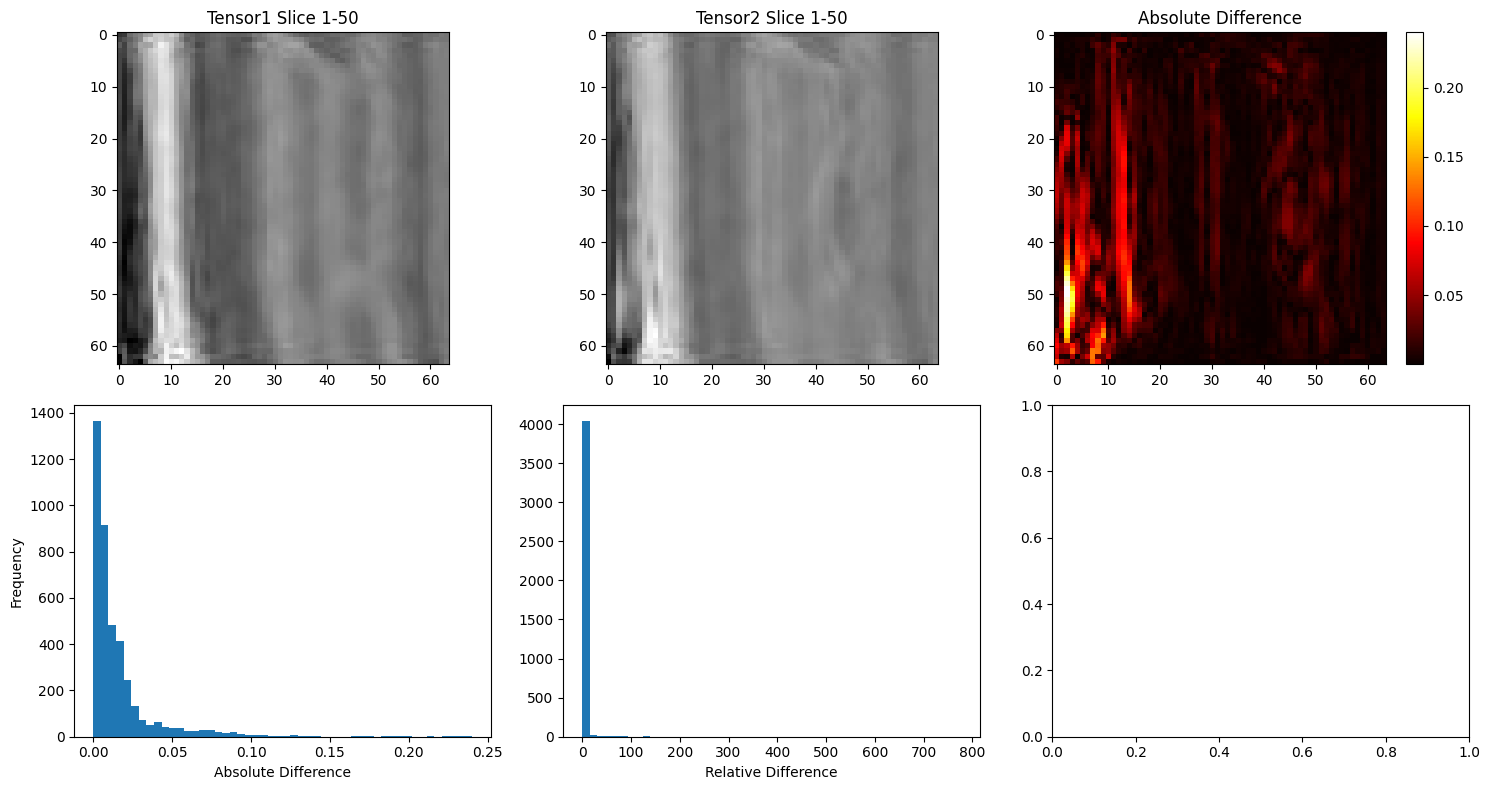

Epoch 1/1:   0%|          | 0/160 [01:40<?, ?it/s]

{'max_abs': 0.24024370312690735, 'mean_abs': 0.015779267996549606, 'rel_over_threshold': 0.997314453125}


In [ ]:
#@title 训练InternLM的input-target框架
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 载入ldm,frame_ae,pre_ae三个神经网络
# [B,C,T,H,W]
ldm = VideoWorldPhysicsModel(
    image_size=64,
    latent_channels=3,
    frame_num=H_plus_1,
    act_embedding_num=H_plus_1-1
).to(device)
ldm.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/LDM_64X64_4ntToBePred_epoch2.pt"))
ldm.eval()
for param in ldm.parameters():
    param.requires_grad = False

# [B,C,1,H,W]
frame_ae = VideoFrameAE_16EncodeLatent(
    image_size=64,
    in_channels=3,
    latent_dim=512
).to(device)
frame_ae.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/frame_ae_16Latent_8192_best.pt", map_location='cpu'))
frame_ae.eval()
for param in frame_ae.parameters():
    param.requires_grad = False

# 设置autoencoder为评估模式并冻结其参数
autoencoder.eval()
for param in autoencoder.parameters():
    param.requires_grad = False

num_epochs = 1
time_padding_4_pre_encode_out = 3 # LDM encoder当中的time_padding，用于使用frame_ae下pre_encode_out参数的建立

## 训练
for epoch in range(num_epochs):
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        print('\n latent shape',batch['inputs']['seismic']['latent'].shape) # [1, 2, 1, 3, 128, 128]
        print('\n target shape',batch['targets']['seismic'].shape) # ([1, 2, 128, 128, 128])


        # 准备输入数据
        seismic_input_4_LDM = batch['inputs']['seismic']['latent'].permute(0,2,1,3,4).to(device) # 一组T段数据，模拟Transformer的生成结果Z;[1, 3, 4, 128, 128]
        seismic_input_SingleFrame = seismic_input_4_LDM.clone()[:,:,0,...][:,:,None,...] # 单帧，作为LDM的pre_encode_out参数;[1, 3, 1, 128, 128]

        seismic_skip_features = batch['inputs']['seismic']['skip_features'] # for pre_ae
        # seismic_skip_features = [x[0] for x in seismic_skip_features] # 解包


        # 构建pre_encode_out：video[:,:,:(self.time_padding)+1] [1,512,4,16,16]

        # 得到z_input
        frame_ae_encoded = frame_ae(seismic_input_4_LDM) # 四帧视频传入，期望ldm得到后四帧
        z_input = frame_ae_encoded['quantized'] # [...,16,16] ->[...,1,1]
        decoded_input = frame_ae_encoded['decoded'] # frame_ae解码的四帧视频

        ldm_encoded_tuple = ldm(seismic_input_4_LDM)

        # 使用处于eval模式的autoencoder进行解码
        with torch.no_grad():  # 确保不会计算autoencoder的梯度
            decoded_input_detached = decoded_input.detach()  # 暂时分离梯度，frame_ae传入下ldm输出的视频
            decoded_label_detached = ldm_encoded_tuple[0].detach()  # ldm输出的视频

        # 重新附加梯度跟踪，这样梯度可以通过seismic_output_3d回传到model
        seismic_output_3d_frame = processor.decode_to_3d(
            decoded_input_detached,  # 解码的视频传入ldm的结果
            seismic_skip_features
        )
        seismic_output_3d_origin = processor.decode_to_3d(
            decoded_label_detached,  # 原始的视频传入ldm的结果
            seismic_skip_features
        )
        # stats, fig = compare_4d_slices(batch['targets']['seismic'][0,1].cpu().detach()[None,], seismic_output_3d_input[0,1].cpu().detach()[None,], dim=1, index=50)
        stats, fig = compare_4d_slices(seismic_output_3d_origin[0,-1].cpu().detach()[None,], seismic_output_3d_frame[0,-1].cpu().detach()[None,], dim=1, index=50)
        plt.show()
        print(stats)
        # stats, fig = compare_4d_slices(seismic_output_3d_label[0,2].cpu().detach()[None,], seismic_output_3d_label[0,3].cpu().detach()[None,], dim=1, index=50)
        # plt.show()
        # print(stats)
        # stats, fig = compare_4d_slices(batch['targets']['seismic'][0,1].cpu().detach()[None,], seismic_output_3d_label[0,1].cpu().detach()[None,], dim=1, index=50)
        # plt.show()
        # print(stats)
        break
    break


## InternLM

In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
#@title get internlm-pretrained Huggingface
import os
import torch
from transformers import AutoTokenizer
from MoE.modeling_internlm import InternLMForCausalLM  # 使用你提供的 InternLM 实现

# 设置模型名称和保存路径
model_name = "internlm/internlm2-7b"  # 或者使用其他可用的 InternLM 模型
save_directory = f_path+"/pted_lm/internlm"

# 检查本地是否已存在模型
model_exists = os.path.exists(os.path.join(save_directory, "pytorch_model.bin")) or \
               os.path.exists(os.path.join(save_directory, "model.safetensors")) or \
               any(f.startswith("pytorch_model-") and f.endswith(".bin") for f in os.listdir(save_directory) if os.path.isfile(os.path.join(save_directory, f))) if os.path.exists(save_directory) else False

tokenizer_exists = os.path.exists(os.path.join(save_directory, "tokenizer_config.json")) if os.path.exists(save_directory) else False

if model_exists and tokenizer_exists:
    print(f"Model and tokenizer already exist at {save_directory}. Loading from local files...")

    # 从本地加载模型和分词器
    tokenizer = AutoTokenizer.from_pretrained(save_directory)
    model = InternLMForCausalLM.from_pretrained(
        save_directory,
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True
    )
    print("✅ Model and tokenizer loaded from local files successfully!")
else:
    print(f"Model or tokenizer not found at {save_directory}. Downloading from Hugging Face...")

    # 确保保存目录存在
    os.makedirs(save_directory, exist_ok=True)

    # 下载并缓存模型和分词器
    print("Downloading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained(model_name,trust_remote_code=True)

    print("Downloading model...")
    # 使用你提供的 InternLM 实现加载模型
    model = InternLMForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,  # 使用半精度加载以节省内存
        low_cpu_mem_usage=True,     # 低内存加载选项
        trust_remote_code=True
    )

    # 保存模型到本地
    print("Saving model and tokenizer locally...")
    model.save_pretrained(save_directory)
    tokenizer.save_pretrained(save_directory)
    print(f"Model and tokenizer saved to {save_directory}")

# 打印模型配置信息
print(f"\nModel configuration:")
print(f"- Vocab size: {model.config.vocab_size}")
print(f"- Hidden size: {model.config.hidden_size}")
print(f"- Number of layers: {model.config.num_hidden_layers}")
print(f"- Number of attention heads: {model.config.num_attention_heads}")

# 释放内存
del model
torch.cuda.empty_cache()


Model or tokenizer not found at /content/drive/MyDrive/DiTing2.0/pted_lm/internlm. Downloading from Hugging Face...


tokenization_internlm2_fast.py:   0%|          | 0.00/7.80k [00:00<?, ?B/s]

tokenization_internlm2.py:   0%|          | 0.00/8.81k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/internlm/internlm2-7b:
- tokenization_internlm2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/internlm/internlm2-7b:
- tokenization_internlm2_fast.py
- tokenization_internlm2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer.model:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/840 [00:00<?, ?B/s]

You are using a model of type internlm2 to instantiate a model of type internlm. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin.index.json:   0%|          | 0.00/18.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/5.51G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/19.1k [00:00<?, ?B/s]

InternLMForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of InternLMForCausalLM were not initialized from the model checkpoint at internlm/internlm2-7b and are newly initialized: ['lm_head.weight', 'model.embed_tokens.weight', 'model.layers.0.input_layernorm.weight', 'model.layers.0.mlp.down_proj.weight', 'model.layers.0.mlp.gate_proj.weight', 'model.layers.0.mlp.up_proj.weight', 'model.layers.0.post_attention_layernorm.weight', 'model.layers.0.self_attn.k_proj.weight', 'model.layers.0.self_attn.o_proj.weight', 'model.layers.0.self_attn.q_proj.weight', 'model.layers.0.self_attn.rotary_emb.inv_freq', 'model.layers.0.self_attn.v_proj.weight', 'model.layers.1.input_layernorm.weight', 'model.layers.1.mlp.down_proj.weight', 'model.layers.1.mlp.gate_proj.weight', 'model.layers.1.mlp.up_proj.weight', 'model.layers.1.post_attention_layernorm.weight', 'model.layers.1.self_attn.k_proj.weight', 'model.layers.1.self_attn.o_proj.weight', 'model.layers.1.self_attn.q_proj.weight', 'model.layers.1.self_attn.rotary_emb.inv_freq', 'model.layers.1

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Saving model and tokenizer locally...
Model and tokenizer saved to /content/drive/MyDrive/DiTing2.0/pted_lm/internlm

Model configuration:
- Vocab size: 92544
- Hidden size: 4096
- Number of layers: 32
- Number of attention heads: 32


In [ ]:
#@title get internlm-pretrained local
import torch
from transformers import AutoTokenizer
from MoE.modeling_internlm import InternLMForCausalLM  # 按你的实现路径导入

# 本地模型和分词器目录
save_directory = "/content/drive/MyDrive/DiTing2.0/pted_lm/internlm"  # 修改为你的实际路径

# 加载分词器
tokenizer = AutoTokenizer.from_pretrained(save_directory, trust_remote_code=True)

# 加载模型（推荐用float16节省内存）
model = InternLMForCausalLM.from_pretrained(
    save_directory,
    torch_dtype=torch.float16,      # 如果显卡支持，用float16
    low_cpu_mem_usage=True,
)

# 检查加载是否成功
print("✅ 本地InternLM模型和分词器加载成功！")



InternLMForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ 本地InternLM模型和分词器加载成功！


In [ ]:
#@title 用大语言模型（InternLM）作为潜在空间序列建模器，对地震物理模拟任务中的潜在表征（latent codes）进行序列预测
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union

from transformers.modeling_outputs import BaseModelOutputWithPast, CausalLMOutputWithPast

from MoE.modeling_internlm import InternLMConfig, InternLMForCausalLM, InternLMModel

class LatentInternLM(nn.Module):
    """
    继承自nn.Module，内部封装了一个（可加载预训练权重的）InternLMForCausalLM。
    """
    def __init__(
        self,
        pretrained_model_path=None,  # 预训练模型路径
        latent_dim=512,              # 潜在空间维度
        codebook_size=8192,          # 码本大小
        max_seq_length=16,           # 最大序列长度
        special_token_count=3,       # 特殊标记数量
        hidden_size=1024,            # 隐藏层大小
        num_hidden_layers=12,        # Transformer层数
        num_attention_heads=16,      # 注意力头数
        intermediate_size=4096,      # 中间层大小
        device=None,                  # 设备
        num_time_steps=3,    # 多步预测
        num_space=16*16         # frame_ae: h*w
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size
        self.max_seq_length = max_seq_length
        self.special_token_count = special_token_count
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_time_steps = num_time_steps
        self.num_space = num_space

        # 创建配置
        if pretrained_model_path:
            # 加载预训练模型
            self.model = InternLMForCausalLM.from_pretrained(pretrained_model_path)
            # 调整词汇表大小以适应码本
            self.model.resize_token_embeddings(codebook_size + special_token_count)
        else:
            # 从头创建模型
            config = InternLMConfig(
                vocab_size=codebook_size + special_token_count,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=max_seq_length,
                rms_norm_eps=1e-6,
                use_cache=True,
            )
            self.model = InternLMForCausalLM(config)

        # 创建从潜在向量到模型输入的映射层
        self.latent_to_embedding = nn.Linear(latent_dim, hidden_size) #通过latent_to_embedding层将潜在向量z_input映射到模型期望的inputs_embeds
        # 添加从模型输出到潜在向量的映射
        self.output_to_latent = nn.Linear(hidden_size, latent_dim)
        # 特殊标记
        # 为特殊标记创建可学习的潜在向量表示
        self.bos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        self.eos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        self.pad_latent = nn.Parameter(torch.zeros(1, 1, latent_dim))
        # Learnable position embedding
        self.time_pos_embed = nn.Embedding(self.num_time_steps, latent_dim)
        self.space_pos_embed = nn.Embedding(self.num_space, latent_dim)
        # 将模型移至指定设备
        self.to(self.device)
    # 添加BOS
    def prepare_latent_sequence(self, z_input):
        """添加BOS标记到潜在向量序列开头"""
        batch_size = z_input.shape[0]
        bos = self.bos_latent.expand(batch_size, 1, -1)
        return torch.cat([bos, z_input], dim=1)
    # add learnable position embedding
    def prepare_inputs_from_latent(self, z_input):
        """
        z_input: [batch, seq_len, latent_dim]
        """
        batch_size, seq_len, latent_dim = z_input.shape
        # 计算时间和空间位置索引
        # 先时间后空间
        time_ids = torch.arange(seq_len, device=z_input.device) // self.num_space  # [seq_len]
        space_ids = torch.arange(seq_len, device=z_input.device) % self.num_space  # [seq_len]
        time_pos = self.time_pos_embed(time_ids)      # [seq_len, latent_dim]
        space_pos = self.space_pos_embed(space_ids)   # [seq_len, latent_dim]
        pos_encoding = time_pos + space_pos           # [seq_len, latent_dim]
        pos_encoding = pos_encoding.unsqueeze(0).expand(batch_size, -1, -1)  # [batch, seq_len, latent_dim]
        # 融合位置编码
        z_input_with_pos = z_input + pos_encoding     # [batch, seq_len, latent_dim]
        # 投影到hidden
        return self.latent_to_embedding(z_input_with_pos) # # [batch, seq_len, hidden_size]

    # 处理传统的token ID
    def encode_latent_to_indices(self, z_input):
        """
        encode_latent_to_indices只是占位，实际应用中如果用VQ-VAE等离散化方法，需要实现连续潜在向量到离散码的映射（如最近邻查找）
        将潜在向量转换为离散索引
        注意：这里假设z_input已经是量化后的索引，实际应用中可能需要调整

        Args:
            z_input: 潜在向量 [batch_size, seq_len, latent_dim]

        Returns:
            input_ids: 输入索引 [batch_size, seq_len]
        """
        # 这里简化处理，假设z_input已经是索引形式
        # 在实际应用中，你可能需要实现从连续潜在向量到离散索引的映射
        return z_input


    def forward(
        self,
        z_input=None,           # 潜在向量输入 [batch, seq_len_in, latent_dim]
        input_ids=None,         # 索引输入（可选）
        attention_mask=None,    # 注意力掩码
        labels=None,            # 标签 [batch, seq_len_out, latent_dim]
        use_cache=None,         # 是否使用缓存
        return_dict=None,       # 是否返回字典
    ):
        """
        前向传播，支持latent输入（含时空位置编码）或传统token id输入

        Args:
            z_input: 潜在向量 [batch_size, seq_len, latent_dim]
            input_ids: 输入索引 [batch_size, seq_len]
            attention_mask: 注意力掩码 [batch_size, seq_len]
            labels: 标签索引 [batch_size, seq_len]

        Returns:
            logits: 输出概率 [batch_size, seq_len, vocab_size]
            loss: 损失值
        """
        if z_input is not None:
          # 1. 拼接BOS
          z_with_bos = self.prepare_latent_sequence(z_input)  # [batch, seq_len_in+1, latent_dim]
          # 2. 带位置编码的输入嵌入（推荐）
          inputs_embeds = self.prepare_inputs_from_latent(z_with_bos)  # [batch, seq_len_in+1, hidden_size]
          # 3. attention_mask对齐
          if attention_mask is None:
              attention_mask = torch.ones(
                  (z_with_bos.shape[0], z_with_bos.shape[1]),
                  dtype=torch.long,
                  device=z_with_bos.device
              )
          elif attention_mask.shape[1] != z_with_bos.shape[1]:
              bos_mask = torch.ones(
                  (attention_mask.shape[0], 1),
                  dtype=attention_mask.dtype,
                  device=attention_mask.device
              )
              attention_mask = torch.cat([bos_mask, attention_mask], dim=1)
          # 4. 前向
          outputs = self.model(
              inputs_embeds=inputs_embeds,
              attention_mask=attention_mask,
              use_cache=use_cache,
              return_dict=True,
              output_hidden_states=True
          )
          # 5. 预测latent
          last_hidden_states = outputs.hidden_states[-1] # Shape: [batch, seq_len_in+1, hidden_size]
          predicted_latents = self.output_to_latent(last_hidden_states) # [batch, seq_len_in+1, latent_dim]
          # print(f"z_hat_1,z_hat_2,z_hat_3:{predicted_latents.shape}")
          # print(f"z_1,z_2,z_3:{labels.shape}")

          # 6. 计算MSE损失（如果有标签）
          loss = None
          if labels is not None:
              assert predicted_latents[:, 1:, :].shape[1]*self.num_time_steps == labels.shape[1], "预测输出与标签 shape 不匹配"
              loss = F.mse_loss(predicted_latents[:, 1:, :], labels)  # 去掉BOS位置的预测
          # 7. 返回
          return CausalLMOutputWithPast(
              loss=loss,
              logits=outputs.logits,
              past_key_values=outputs.past_key_values,
              hidden_states=outputs.hidden_states,
              attentions=outputs.attentions,
              latent_vectors=predicted_latents
          )
        else:
            # 支持传统token id输入
            if z_input is not None and input_ids is None:
                # 这里也用prepare_inputs_from_latent，保证一致性
                inputs_embeds = self.prepare_inputs_from_latent(z_input)
                return self.model(
                    inputs_embeds=inputs_embeds,
                    attention_mask=attention_mask,
                    labels=labels,
                    use_cache=use_cache,
                    return_dict=return_dict
                )
            else:
                return self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels,
                    use_cache=use_cache,
                    return_dict=return_dict
                )

    def generate_from_latent(
        self,
        z_input,
        max_new_tokens=512,
        do_sample=True,
        temperature=0.8,
        top_p=0.9,
        top_k=50,
        repetition_penalty=1.0,
        attention_mask=None
    ):
        """
        从潜在向量生成序列

        Args:
            z_input: 潜在向量 [batch_size, seq_len, latent_dim]

        Returns:
            generated_indices: 生成的索引序列 [batch_size, seq_len]
        """
        # 将潜在向量转换为模型输入
        inputs_embeds = self.prepare_inputs_from_latent(z_input)

        # 生成序列
        outputs = self.model.generate(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            max_new_tokens=max_new_tokens,
            do_sample=do_sample,
            temperature=temperature,
            top_p=top_p,
            top_k=top_k,
            repetition_penalty=repetition_penalty,
            eos_token_id=self.eos_token_id,
            pad_token_id=self.pad_token_id,
            bos_token_id=self.bos_token_id,
            return_dict_in_generate=True,
            output_hidden_states=True
        )

        return outputs


class LatentInternLM_TeacherForcing(nn.Module):
    """
    继承自nn.Module，内部封装了一个（可加载预训练权重的）InternLMForCausalLM。
    实现了多步预测的 Teacher Forcing 训练逻辑。
    提供了自回归生成潜在向量序列的功能。
    """
    def __init__(
        self,
        pretrained_model_path=None,  # 预训练模型路径
        latent_dim=512,              # 潜在空间维度
        codebook_size=8192,          # 码本大小 (主要用于词汇表大小，实际不一定使用码本)
        max_seq_length=256,          # << 调整：模型能处理的最大序列长度 (BOS + Z0...Zn-1)
        special_token_count=3,       # 特殊标记数量 (BOS, EOS, PAD) - 确保与词汇表一致
        hidden_size=4096,            # 隐藏层大小
        num_hidden_layers=12,        # Transformer层数
        num_attention_heads=16,      # 注意力头数
        intermediate_size=4096,      # 中间层大小
        device=None,                 # 设备
        num_time_steps=3,            # 多步预测的时间步数 (预测 Z1, Z2, ..., Zn)
        num_space=16*16              # 每个时间步的空间维度 (frame_ae: h*w)
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.codebook_size = codebook_size # Note: Actual discrete codebook use depends on VQ-VAE etc.
        self.special_token_count = special_token_count
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_time_steps = num_time_steps
        self.num_space = num_space

        # --- Crucial Check/Adjustment for max_seq_length ---
        # Max length needed for teacher forcing input: BOS + Z0 + Z1 + ... + Z(n-1)
        required_max_len = 1 + self.num_time_steps * self.num_space
        if max_seq_length < required_max_len:
            print(f"Warning: Provided max_seq_length ({max_seq_length}) is less than required ({required_max_len}) "
                  f"for teacher forcing loop with num_time_steps={num_time_steps}. Adjusting...")
            self.max_seq_length = required_max_len
        else:
            self.max_seq_length = max_seq_length
        print(f"Using max_seq_length: {self.max_seq_length}")
        # --- End Check ---

        # Model Config/Loading (using self.max_seq_length)
        if pretrained_model_path:
            print(f"Loading pretrained InternLM model from: {pretrained_model_path}")
            # 加载模型（推荐用float16节省内存）
            self.model = InternLMForCausalLM.from_pretrained(
                pretrained_model_path,
                torch_dtype=torch.float16,      # 如果显卡支持，用float16
                low_cpu_mem_usage=True,
            )
            # Adjust vocab size if necessary (though we primarily use embeds)
            current_vocab_size = self.model.config.vocab_size
            target_vocab_size = codebook_size + special_token_count
            if current_vocab_size != target_vocab_size:
                 print(f"Resizing token embeddings from {current_vocab_size} to: {target_vocab_size}")
                 self.model.resize_token_embeddings(target_vocab_size)

            # Potentially update position embedding size if loaded model's is smaller
            if self.model.config.max_position_embeddings < self.max_seq_length:
                 print(f"Warning: Pretrained model max_position_embeddings ({self.model.config.max_position_embeddings}) "
                       f"is smaller than required ({self.max_seq_length}). Resizing position embeddings.")
                 # Note: Resizing position embeddings might require careful handling
                 # depending on the model architecture and pretraining.
                 # Simple resizing might work, or might need interpolation/reinitialization.
                 self.model.resize_position_embeddings(self.max_seq_length)

        else:
            print("Initializing new InternLM model from scratch.")
            config = InternLMConfig(
                vocab_size=codebook_size + special_token_count,
                hidden_size=hidden_size,
                num_hidden_layers=num_hidden_layers,
                num_attention_heads=num_attention_heads,
                intermediate_size=intermediate_size,
                max_position_embeddings=self.max_seq_length, # Use adjusted length
                rms_norm_eps=1e-6,
                use_cache=True, # Enable KV cache for generation
            )
            self.model = InternLMForCausalLM(config)

        # Linear layers
        self.latent_to_embedding = nn.Linear(latent_dim, hidden_size)
        self.output_to_latent = nn.Linear(hidden_size, latent_dim)

        # Special tokens (learnable latent representations)
        # We need BOS for sequence start. EOS/PAD might be needed for generation logic.
        self.bos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        # EOS/PAD might be represented by specific indices if using token generation,
        # but for latent generation, their role is less direct unless used as stop signals.
        # self.eos_latent = nn.Parameter(torch.randn(1, 1, latent_dim))
        # self.pad_latent = nn.Parameter(torch.zeros(1, 1, latent_dim)) # Often zero

        # Learnable position embedding
        # Time embedding needs size num_time_steps for IDs 0 to n-1 (relative to Z0)
        self.time_pos_embed = nn.Embedding(self.num_time_steps, latent_dim)
        self.space_pos_embed = nn.Embedding(self.num_space, latent_dim)

        # Store token IDs for potential use in generation (if mixing with token logic)
        # These should correspond to the indices in the resized embedding matrix
        # Typically, special tokens are added at the end.
        self.bos_token_id = codebook_size # Example ID
        self.eos_token_id = codebook_size + 1 # Example ID
        self.pad_token_id = codebook_size + 2 # Example ID
        # Ensure these IDs are within the vocab_size = codebook_size + special_token_count

        self.to(self.device)

    def add_positional_encoding(self, z_input):
        """
        Adds time and space positional encoding to latent vectors.
        Assumes input z_input is a sequence like [Z0] or [Z0, Z1] or [Z0, ..., Zi].
        Shape: [batch, seq_len, latent_dim] where seq_len = (current_step + 1) * num_space
        """
        batch_size, seq_len, _ = z_input.shape
        device = z_input.device

        # Calculate time and space IDs based on flattened sequence structure
        time_ids = torch.arange(seq_len, device=device) // self.num_space  # Time step index (0, 0,..., 1, 1,...)
        space_ids = torch.arange(seq_len, device=device) % self.num_space   # Spatial index within frame (0..num_space-1)

        # --- Bounds checks ---
        max_time_id = time_ids.max()
        # Max expected time ID is num_time_steps - 1 (for input Z0...Z(n-1))
        if max_time_id >= self.time_pos_embed.num_embeddings:
             raise ValueError(f"Max time_id {max_time_id} encountered, but time embedding size is {self.time_pos_embed.num_embeddings}. "
                              f"Input sequence length {seq_len} is too long for num_time_steps {self.num_time_steps} and num_space {self.num_space}.")
        if space_ids.max() >= self.space_pos_embed.num_embeddings:
             raise ValueError(f"Max space_id {space_ids.max()} exceeds space embedding size {self.space_pos_embed.num_embeddings}.")
        # --- End Bounds checks ---

        time_pos = self.time_pos_embed(time_ids)      # [seq_len, latent_dim]
        space_pos = self.space_pos_embed(space_ids)   # [seq_len, latent_dim]

        pos_encoding = (time_pos + space_pos).unsqueeze(0).expand(batch_size, -1, -1)  # [batch, seq_len, latent_dim]

        return z_input + pos_encoding

    def prepare_latent_sequence(self, z_input):
        """Adds BOS latent vector to the beginning of the sequence."""
        batch_size = z_input.shape[0]
        bos = self.bos_latent.expand(batch_size, 1, -1).to(z_input.device) # Ensure device match
        # z_input shape: [batch, seq_len, latent_dim]
        # bos shape: [batch, 1, latent_dim]
        # result shape: [batch, seq_len + 1, latent_dim]
        return torch.cat([bos, z_input], dim=1)

    # encode_latent_to_indices is removed as it's a placeholder and not used here.

    def forward(
        self,
        z_input: torch.Tensor,           # 初始潜在向量输入 [B, num_space, D] (e.g., Z0)
        labels: torch.Tensor,            # 目标标签 [B, num_time_steps * num_space, D] (e.g., Z1,Z2,Z3)
        attention_mask: Optional[torch.Tensor] = None, # 初始注意力掩码 (对应 z_input) [B, num_space]
        use_cache: Optional[bool] = None,         # 缓存（在训练循环中应为False）
        return_dict: Optional[bool] = None,       # 是否返回字典 (推荐 True)
        input_ids=None, # Ignored in this mode
    ) -> CausalLMOutputWithPast:
        """
        实现多步预测的 Teacher Forcing 训练逻辑。
        输入 z_input (Z0) 和 labels (Z1, Z2, ..., Zn)。
        循环 n 次：
          1. 构建当前输入序列 (Z0, Z1, ..., Z(i-1)) + PosEncoding + BOS
          2. 通过模型预测 Z_hat(i)
          3. 计算 loss(Z_hat(i), Zi)
          4. 累加损失
        返回 CausalLMOutputWithPast 格式，其中 loss 是所有步骤的平均损失。
        其他字段（logits, past_key_values, hidden_states, attentions）将包含 *最后一步* 迭代的结果。
        新增 latent_vectors 字段包含最后一步预测的完整潜在序列 (含BOS)。
        """
        if z_input is None:
            raise ValueError("z_input (initial latent state Z0) is required for teacher forcing.")
        if labels is None:
            raise ValueError("labels (target latent states Z1..Zn) are required for teacher forcing.")

        return_dict = return_dict if return_dict is not None else self.model.config.use_return_dict
        # Force use_cache=False during teacher forcing loop as KV cache is not applicable step-by-step here
        use_cache = False

        batch_size, initial_seq_len, latent_dim = z_input.shape
        device = z_input.device

        # --- Input Validation ---
        if initial_seq_len != self.num_space:
             raise ValueError(f"Initial z_input sequence length ({initial_seq_len}) must match num_space ({self.num_space})")
        if labels.shape[0] != batch_size or labels.shape[2] != latent_dim:
             raise ValueError("Batch size or latent dim mismatch between z_input and labels.")
        expected_label_len = self.num_time_steps * self.num_space
        if labels.shape[1] != expected_label_len:
            raise ValueError(f"Labels sequence length ({labels.shape[1]}) must be num_time_steps ({self.num_time_steps}) * num_space ({self.num_space}) = {expected_label_len}")
        # --- End Validation ---

        # --- Teacher Forcing Loop ---
        total_loss = 0.0
        current_input_latent = z_input # Starts with Z0 [B, num_space, D]

        # Split labels into target frames [Z1, Z2, ..., Zn]
        # Each target_frame shape: [B, num_space, D]
        target_frames = list(torch.split(labels, self.num_space, dim=1))

        # Initialize attention mask for Z0 (if provided) or create default
        # This mask corresponds to `current_input_latent` (without BOS)
        current_attention_mask_no_bos = attention_mask
        if current_attention_mask_no_bos is None:
             current_attention_mask_no_bos = torch.ones(
                 (batch_size, self.num_space), dtype=torch.long, device=device
             )
        elif current_attention_mask_no_bos.shape != (batch_size, self.num_space):
             raise ValueError(f"Initial attention_mask shape {current_attention_mask_no_bos.shape} "
                              f"does not match z_input shape {z_input.shape[:2]}")

        # Store outputs from the last step to return
        last_step_outputs = None
        last_step_predicted_latents = None

        # Loop through each prediction step (predicting Z1, then Z2, ..., Zn)
        for i in range(self.num_time_steps):
            # Target for this step is Z(i+1)
            current_target = target_frames[i] # [B, num_space, D]

            # 1. Add positional encoding to the *current* input sequence (Z0..Zi)
            #    Sequence length = (i + 1) * num_space
            input_with_pos = self.add_positional_encoding(current_input_latent) # [B, (i+1)*num_space, D]

            # 2. Add BOS token
            input_with_bos = self.prepare_latent_sequence(input_with_pos) # [B, (i+1)*num_space + 1, D]

            # 3. Project to hidden size
            inputs_embeds = self.latent_to_embedding(input_with_bos) # [B, (i+1)*num_space + 1, H]

            # 4. Prepare attention mask for the BOS + current sequence
            bos_mask = torch.ones((batch_size, 1), dtype=torch.long, device=device)
            # Mask includes BOS + Z0 + Z1 + ... + Zi
            step_attention_mask = torch.cat([bos_mask, current_attention_mask_no_bos], dim=1) # [B, (i+1)*num_space + 1]

            # --- Check max sequence length before model call ---
            current_total_seq_len = inputs_embeds.shape[1]
            if current_total_seq_len > self.max_seq_length:
                raise ValueError(
                    f"Sequence length in step {i+1} ({current_total_seq_len}) exceeds "
                    f"model's max_seq_length ({self.max_seq_length}). "
                    f"Increase max_seq_length in model initialization or decrease num_time_steps."
                )
            # --- End Check ---

            # 5. Call the underlying Transformer model
            outputs = self.model(
                inputs_embeds=inputs_embeds,
                attention_mask=step_attention_mask,
                use_cache=use_cache, # Should be False for teacher forcing loop
                return_dict=True,    # Force return_dict for easier access
                output_hidden_states=True, # Need hidden states for latent prediction
                output_attentions=False # Optional: if needed
            )

            # 6. Get hidden states and predict next latent frame
            last_hidden_states = outputs.hidden_states[-1] # [B, (i+1)*num_space + 1, H]
            predicted_latents_all = self.output_to_latent(last_hidden_states) # [B, (i+1)*num_space + 1, D]

            # Prediction for the *next* frame (Z(i+1)_hat) corresponds to the output
            # at the positions of the *last frame* of the input (Zi).
            # In predicted_latents_all (which includes BOS), these are the last num_space positions.
            predicted_next_frame = predicted_latents_all[:, -self.num_space:, :] # [B, num_space, D]

            # 7. Calculate loss for this step (Prediction Z_hat(i+1) vs Target Z(i+1))
            step_loss = F.mse_loss(predicted_next_frame, current_target)
            total_loss += step_loss

            # 8. Prepare for the next iteration (Teacher Forcing):
            #    Append the *ground truth* target from this step to the input sequence
            current_input_latent = torch.cat([current_input_latent, current_target], dim=1)
            #    Append ones to the attention mask (without BOS) for the added ground truth frame
            #    (Assume the added ground truth tokens are not padded)
            ones_mask = torch.ones((batch_size, self.num_space), dtype=torch.long, device=device)
            current_attention_mask_no_bos = torch.cat([current_attention_mask_no_bos, ones_mask], dim=1)

            # Store the final step's outputs
            if i == self.num_time_steps - 1:
                last_step_outputs = outputs
                last_step_predicted_latents = predicted_latents_all # Full sequence prediction from last step

        # --- End Loop ---

        # Calculate average loss over the prediction steps
        final_loss = total_loss / self.num_time_steps

        # --- Return Results in CausalLMOutputWithPast format ---
        # Note: logits, past_key_values etc. are from the *last* step of the loop.
        # The primary output is the averaged loss.
        return CausalLMOutputWithPast(
            loss=final_loss,
            logits=last_step_outputs.logits if last_step_outputs else None, # Logits from last step
            past_key_values=last_step_outputs.past_key_values if last_step_outputs else None, # Useless if use_cache=False
            hidden_states=last_step_outputs.hidden_states if last_step_outputs else None, # Hidden states from last step
            attentions=last_step_outputs.attentions if last_step_outputs else None, # Attentions from last step
            # Add custom attribute for predicted latents (from last step)
            # Or return a custom dictionary/dataclass if CausalLMOutputWithPast is too restrictive
            # Let's add it as an extra attribute if possible, otherwise just return standard fields.
            # CausalLMOutputWithPast doesn't inherently support extra fields easily.
            # We will return the standard fields, populated from the last step where applicable.
        )

    @torch.no_grad() # Generation should not require gradients
    def generate_from_latent(
        self,
        z_input: torch.Tensor,              # Initial latent frame [B, num_space, D] (e.g., Z0)
        max_new_frames: Optional[int] = None, # Number of new frames to generate (Z1..Zn)
        attention_mask: Optional[torch.Tensor] = None, # Mask for z_input [B, num_space]
        **kwargs # To absorb other potential generate kwargs if mimicking HF API
    ):
        """
        Generates a sequence of latent frames autoregressively starting from z_input (Z0).
        Uses KV caching for efficient generation.
        [Correction Attempt 2: Passes full attention mask history]
        """
        self.model.eval() # Set model to evaluation mode

        if max_new_frames is None:
            max_new_frames = self.num_time_steps

        batch_size, initial_seq_len, latent_dim = z_input.shape
        device = z_input.device

        # --- Input Validation ---
        if initial_seq_len != self.num_space:
             raise ValueError(f"Initial z_input sequence length ({initial_seq_len}) must match num_space ({self.num_space})")
        if attention_mask is not None and attention_mask.shape != (batch_size, self.num_space):
             raise ValueError(f"Initial attention_mask shape {attention_mask.shape} "
                              f"does not match z_input shape {z_input.shape[:2]}")
        # --- End Validation ---

        # Initialize the sequence with the input Z0
        current_latent_sequence = z_input # [B, num_space, D]

        # Initialize KV cache
        past_key_values = None

        # Prepare initial attention mask (for Z0, without BOS yet)
        initial_attention_mask_no_bos = attention_mask
        if initial_attention_mask_no_bos is None:
             initial_attention_mask_no_bos = torch.ones(
                 (batch_size, self.num_space), dtype=torch.long, device=device
             )

        # Store generated frames
        generated_frames = []

        # Keep track of the full attention mask history (including BOS)
        # This will be passed to the model in steps i > 0
        full_attention_mask_history = None

        # Autoregressive generation loop
        for i in range(max_new_frames):
            # --- Prepare input for this step ---
            if i == 0:
                # --- First Step (Processing Z0 to predict Z1) ---
                # 1a. Add positional encoding to Z0
                input_with_pos = self.add_positional_encoding(current_latent_sequence) # Z0 + PosEnc [B, num_space, D]

                # 1b. Add BOS token
                input_with_bos = self.prepare_latent_sequence(input_with_pos) # BOS + Z0 + PosEnc [B, num_space + 1, D]

                # 1c. Project to hidden size
                inputs_embeds = self.latent_to_embedding(input_with_bos) # [B, num_space + 1, H]

                # 1d. Prepare attention mask including BOS for the first step
                bos_mask = torch.ones((batch_size, 1), dtype=torch.long, device=device)
                # Mask for BOS + Z0
                model_input_attention_mask = torch.cat([bos_mask, initial_attention_mask_no_bos], dim=1) # [B, num_space + 1]

                # Store this full mask as the history for the next step
                full_attention_mask_history = model_input_attention_mask

                # No past_key_values for the first step
                current_past_key_values = None
            else:
                # === Subsequent Steps (Processing Z_i_hat to predict Z_{i+1}, using KV cache) ===
                # We only need to process the *last added frame* (Z_i_hat)

                # 2a. Get the last predicted frame Z_i_hat from the sequence
                last_predicted_frame = current_latent_sequence[:, -self.num_space:, :] # Shape [B, num_space, D]

                # 2b. Calculate positional encoding *only* for this frame (time index = i)
                time_ids = torch.full((self.num_space,), i, dtype=torch.long, device=device) # Time index `i` for frame Z_i
                space_ids = torch.arange(self.num_space, device=device)

                # Bounds checks (good practice)
                if hasattr(self, 'time_pos_embed') and time_ids.max() >= self.time_pos_embed.num_embeddings:
                     raise ValueError(f"Time index {time_ids.max()} out of bounds for time embedding size {self.time_pos_embed.num_embeddings}")
                if hasattr(self, 'space_pos_embed') and space_ids.max() >= self.space_pos_embed.num_embeddings:
                     raise ValueError(f"Space index {space_ids.max()} out of bounds for space embedding size {self.space_pos_embed.num_embeddings}")

                time_pos = self.time_pos_embed(time_ids)    # [num_space, D]
                space_pos = self.space_pos_embed(space_ids) # [num_space, D]
                pos_encoding = (time_pos + space_pos).unsqueeze(0) # Shape [1, num_space, D]
                last_frame_with_pos = last_predicted_frame + pos_encoding # Shape [B, num_space, D]

                # 2c. Project *only this frame* to hidden size. This is the input for the model call.
                inputs_embeds = self.latent_to_embedding(last_frame_with_pos) # Shape [B, num_space, H]

                # --- FIX ATTEMPT 2: Construct the attention mask for the *full* sequence ---
                # The mask passed needs to align with the *total* sequence length expected by the causal mask.
                past_len = full_attention_mask_history.shape[1] # Length of mask from previous step (e.g., 257 for i=1)
                current_input_len = inputs_embeds.shape[1]      # Should be num_space (e.g., 256 for i=1)

                # Create a mask of ones for the current input tokens
                current_mask_segment = torch.ones(
                    (batch_size, current_input_len), dtype=torch.long, device=device
                )

                # Concatenate the history mask with the current segment mask
                # This creates the mask for the *entire* sequence up to this point
                model_input_attention_mask = torch.cat(
                    [full_attention_mask_history, current_mask_segment], dim=1
                )
                # Shape [B, past_len + current_input_len]
                # e.g., i=1: past_len=257, current_len=256 -> total=513. Matches tensor 'b' size!

                # Update the history mask for the *next* iteration
                full_attention_mask_history = model_input_attention_mask
                # --- END FIX ATTEMPT 2 ---

                # 2e. Use the KV cache from the previous step
                current_past_key_values = past_key_values


            # --- Check max sequence length before model call ---
            # Check against the length of the mask we are passing
            current_total_seq_len = model_input_attention_mask.shape[1] # Length including BOS and history
            if current_total_seq_len > self.max_seq_length:
                 raise ValueError(
                     f"Generation step {i+1}: Sequence length ({current_total_seq_len}) would exceed "
                     f"model's max_seq_length ({self.max_seq_length}). "
                     f"Generation stopped."
                 )
            # --- End Check ---

            # --- Model Forward Pass ---
            outputs = self.model(
                inputs_embeds=inputs_embeds,              # Input for this step (length num_space+1 or num_space)
                attention_mask=model_input_attention_mask,# *Full* mask up to this step
                past_key_values=current_past_key_values,  # Use KV cache after step 0
                use_cache=True,                           # Enable KV cache usage/return
                return_dict=True,
                output_hidden_states=True
            )

            # --- Process Output ---
            # Prediction comes from the hidden states corresponding to the *last frame* of the input sequence.
            last_hidden_states = outputs.hidden_states[-1] # If KV used, shape [B, num_space, H]
                                                           # If i=0, shape [B, num_space+1, H]

            # We need the hidden states corresponding to the last `num_space` input positions
            hidden_states_for_prediction = last_hidden_states[:, -self.num_space:, :] # [B, num_space, H]

            # Predict the next latent frame Z(i+1)_hat
            predicted_next_frame = self.output_to_latent(hidden_states_for_prediction) # [B, num_space, D]

            # --- Update State for Next Iteration ---
            # Append the *predicted* frame to the sequence
            generated_frames.append(predicted_next_frame)
            current_latent_sequence = torch.cat([current_latent_sequence, predicted_next_frame], dim=1)

            # Update KV cache for the *next* iteration
            past_key_values = outputs.past_key_values


        # Concatenate all generated frames (Z1_hat, Z2_hat, ..., Zn_hat)
        if generated_frames:
            generated_sequence = torch.cat(generated_frames, dim=1) # [B, max_new_frames * num_space, D]
        else:
            # Handle case where max_new_frames might be 0
            generated_sequence = torch.empty((batch_size, 0, latent_dim), device=device)

        return generated_sequence


class LatentSequenceDataset(Dataset):
    """
    用于处理潜在序列数据的数据集类
    """
    def __init__(self, z_inputs, z_labels):
        """
        Args:
            z_inputs: 潜在向量 [有待确定形状]
            z_labels: 目标索引 [有待确定形状]
        """
        self.z_inputs = z_inputs
        self.z_labels = z_labels

    def __len__(self):
        return len(self.z_inputs)

    def __getitem__(self, idx):
        return {
            'z_input': self.z_inputs[idx],
            'z_label': self.z_labels[idx]
        }

# next-predict数据集
# Assuming this class remains the same and 'processor' is correctly initialized
# (e.g., processor = SeismicDataProcessor(frame_ae, device=device))
# before creating the dataset instance.
class ProcessedPhysicsDataset_nextFrame(Dataset):
    def __init__(self, seismic_data, processor, nt=2, stride=1):
        """
        Args:
            seismic_data: (model_num, t_total+1, C, H, W) - Assuming C,H,W match frame_ae input
            processor: SeismicDataProcessor instance (initialized with the frame_ae)
            nt: 每个样本包含的连续时间步数 (e.g., 4 for T=0,1,2,3)
            stride: 滑动窗口的步长
        """
        # Convert to tensor only if it's not already one
        if not isinstance(seismic_data, torch.Tensor):
             self.seismic_data = torch.tensor(seismic_data, dtype=torch.float32)
        else:
             self.seismic_data = seismic_data.float() # Ensure correct dtype

        self.processor = processor
        self.model_num = seismic_data.shape[0]
        # Ensure time dimension is axis 1
        if seismic_data.shape[2] != nt and seismic_data.shape[1] == nt:
             print("Warning: seismic_data might have shape (model_num, C, T, H, W) instead of (model_num, T, C, H, W). Adjusting.")
             # Example adjustment if needed, verify dimensions:
             # self.seismic_data = self.seismic_data.permute(0, 2, 1, 3, 4)

        self.t_total = seismic_data.shape[1]  # 总时间步数 (e.g., total frames available)
        self.nt = nt  # 每个样本的时间步数 (e.g., 4)
        self.stride = stride  # 滑动窗口步长

        # --- Input shape check ---
        # Example: Expecting (model_num, t_total, C, H, W)
        # Add checks based on your actual data dimensions if necessary
        print(f"Input data shape: {self.seismic_data.shape}")
        # ---

        # Calculate number of windows for input sequences of length nt
        self.num_windows = max(0, (self.t_total - self.nt) // self.stride) if self.stride > 0 else 1
        # Calculate number of windows for target sequences (shifted by 1)
        # Need at least nt+1 total steps to form one input/target pair
        self.num_valid_pairs = max(0, (self.t_total - (self.nt + 1) + 1) // self.stride) if self.stride > 0 else (1 if self.t_total >= self.nt + 1 else 0)


        if self.num_valid_pairs == 0:
             raise ValueError(f"无法创建有效的输入/目标对：总时间步数 {self.t_total} 不足以支持 nt={self.nt} 的预测。需要至少 {self.nt + 1} 步。")

        print(f"创建数据集：{self.model_num} 个模型，每个模型最多有 {self.num_valid_pairs} 个有效预测窗口 (nt={nt}, stride={stride})")

        # Pre-process data (Encode inputs to latent)
        print("预处理数据 (编码输入序列)...")
        self.processed_data = []

        # Determine latent shape by encoding a dummy tensor
        dummy_input = torch.randn(1, self.seismic_data.shape[2], self.seismic_data.shape[3], self.seismic_data.shape[4])
        dummy_latent, _ = self.processor.encode_to_2d(dummy_input.unsqueeze(1)) # Add time dim
        self.latent_shape = dummy_latent.shape # e.g., [1, latent_dim, 1, h, w]
        print(f"Detected latent shape per frame: {self.latent_shape}")


        for model_idx in tqdm(range(self.model_num), desc="Processing Models"):
            model_windows = []
            # Iterate only through valid starting points for pairs
            for window_idx in range(self.num_valid_pairs):
                start_t = window_idx * self.stride
                end_t = start_t + self.nt # Input frames T=start_t to end_t-1

                # Target frames T=start_t+1 to end_t
                target_start_t = start_t + 1
                target_end_t = end_t + 1

                # Extract raw input sequence (T=0..nt-1 relative)
                seismic_seq_raw = self.seismic_data[model_idx, start_t:end_t]  # (nt, C, H, W)

                # Extract raw target sequence (T=1..nt relative)
                seismic_target_raw = self.seismic_data[model_idx, target_start_t:target_end_t] # (nt, C, H, W)


                # Encode the *input* sequence frame by frame
                seismic_seq_latents = []
                seismic_seq_skips = [] # Store skips if needed by processor/decoder later, otherwise optional

                for t in range(self.nt):
                    # Add batch dim for processor, input shape (1, C, H, W)
                    frame_input = seismic_seq_raw[t].unsqueeze(0)
                    # Encode to latent space
                    # Assuming encode_to_2d returns (latent [1, latent_dim, 1, h, w], skips)
                    seismic_latent, seismic_skip = self.processor.encode_to_2d(frame_input.unsqueeze(2)) # Add time dim = 1
                    # Remove batch and time dim before appending if latent shape is [1, D, 1, h, w]
                    seismic_seq_latents.append(seismic_latent.squeeze(0).squeeze(2)) # Shape [latent_dim, h, w]
                    seismic_seq_skips.append(seismic_skip) # Store skips associated with input frames

                # Stack latents along a new time dimension -> (nt, latent_dim, h, w)
                seismic_seq_latents_stacked = torch.stack(seismic_seq_latents, dim=0)

                # --- Encode the *target* sequence frame by frame ---
                # This is needed for the LatentInternLM labels!
                seismic_target_latents = []
                for t in range(self.nt):
                    frame_target = seismic_target_raw[t].unsqueeze(0)
                    target_latent, _ = self.processor.encode_to_2d(frame_target.unsqueeze(2)) # Add time dim = 1
                    seismic_target_latents.append(target_latent.squeeze(0).squeeze(2)) # Shape [latent_dim, h, w]

                # Stack target latents -> (nt, latent_dim, h, w)
                seismic_target_latents_stacked = torch.stack(seismic_target_latents, dim=0)
                # --- End target encoding ---


                window_data = {
                    # Input for LatentInternLM (and potentially LDM context)
                    'input_latents': seismic_seq_latents_stacked, # (nt, latent_dim, h, w)
                    # Target for LatentInternLM (predicting next latent steps)
                    'target_latents': seismic_target_latents_stacked, # (nt, latent_dim, h, w)
                    # Original target volumes (if needed for other loss/evaluation)
                    'target_volumes': seismic_target_raw, # (nt, C, H, W)
                    # Optional: Skips from input encoding if needed by a decoder
                    'input_skips': seismic_seq_skips,
                    'metadata': {
                        'model_idx': model_idx,
                        'window_idx': window_idx,
                        'start_t': start_t,
                        'end_t': end_t,
                        'target_start_t': target_start_t,
                        'target_end_t': target_end_t
                    }
                }
                model_windows.append(window_data)

            self.processed_data.extend(model_windows)
        print(f"Dataset created with {len(self.processed_data)} samples.")


    def __len__(self):
        return len(self.processed_data)

    def __getitem__(self, idx):
        # Return the pre-processed dictionary
        return self.processed_data[idx]

def prepare_dataset(dataloader, frame_ae, device):
    """
    准备训练数据集
    z_input: 只用seismic_input_4_LDM的第一帧
    z_label: 用seismic_input_4_LDM的第2~4帧
    输出:
      z_inputs_all: [N, seq_len_in, latent_dim]
      z_labels_all: [N, seq_len_out, latent_dim]
      seq_len=时间步×空间位置数，即时空tokens
    """
    z_inputs_list = []
    z_labels_list = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Preparing dataset"):
            # [B, C, T, H, W]，T=4
            seismic_input_4_LDM = batch['inputs']['seismic']['latent'].squeeze(0).permute(1,2,0,3,4).to(device)
            # 1. z_input: 只取第一帧
            single_frame = seismic_input_4_LDM[:,:,0,...]  # [B, C, H, W]
            single_frame = single_frame.unsqueeze(2)       # [B, C, 1, H, W]
            encoded_input = frame_ae.encoder(single_frame, video_contains_first_frame=True)[0]  # [B, latent_dim, 1, h, w]
            z_input, _ = frame_ae.quantizer(encoded_input) # [B, latent_dim, 1, h, w]

            # 2. z_label: 取第2~4帧
            label_frames = seismic_input_4_LDM[:,:,1:,...] # [B, C, 3, H, W]
            encoded_label = frame_ae.encoder(label_frames, video_contains_first_frame=True)[0]  # [B, latent_dim, 3, h, w]
            z_label, _ = frame_ae.quantizer(encoded_label) # [B, latent_dim, 3, h, w]

            # ----------- 关键：flatten空间与时间维度为序列 -----------
            # z_input: [B, latent_dim, 1, h, w] → [B, 1*h*w, latent_dim]
            B, latent_dim, Tin, h, w = z_input.shape
            z_input_seq = z_input.permute(0, 2, 3, 4, 1).reshape(B, Tin*h*w, latent_dim)

            # z_label: [B, latent_dim, 3, h, w] → [B, 3*h*w, latent_dim]
            _, _, Tout, _, _ = z_label.shape
            z_label_seq = z_label.permute(0, 2, 3, 4, 1).reshape(B, Tout*h*w, latent_dim)

            z_inputs_list.append(z_input_seq.cpu())
            z_labels_list.append(z_label_seq.cpu())

    # 拼接所有批次
    z_inputs_all = torch.cat(z_inputs_list, dim=0)   # [N, seq_len_in, latent_dim]
    z_labels_all = torch.cat(z_labels_list, dim=0)   # [N, seq_len_out, latent_dim]

    dataset = LatentSequenceDataset(z_inputs_all, z_labels_all)
    return dataset

@torch.no_grad() # Ensure no gradients are computed during generation
def generate_with_latent_internlm(
    model: LatentInternLM_TeacherForcing, # Corrected type hint if needed
    frame_ae,                           # Frame autoencoder (e.g., VideoFrameAE)
    ldm, # : VideoWorldPhysicsModel,        # Latent Dynamics Model (VideoWorldPhysicsModel) # Type hint if available
    single_frame_input: torch.Tensor,   # Single input frame [B, C, 1, H, W] (T=0)
    num_pred_steps_internlm: int = 3,   # InternLM predicts Z_1, Z_2, Z_3
    num_pred_steps_ldm: int = 4,        # LDM should output T=1, 2, 3, 4
    device=None
):
    """
    Uses LatentInternLM to predict future latent codes, decodes them with frame_ae,
    and then uses LDM (VideoWorldPhysicsModel) to generate the final output sequence.

    Args:
        model: Trained LatentInternLM model.
        frame_ae: Frame autoencoder (must have .encoder, .quantizer, .decoder).
        ldm: Latent Dynamics Model (VideoWorldPhysicsModel instance).
        single_frame_input: Initial single frame input [B, C, 1, H, W] (T=0).
        num_pred_steps_internlm: Number of future latent steps InternLM predicts.
        num_pred_steps_ldm: Expected number of output frames from LDM (T=1 to T=num_pred_steps_ldm).
        device: Computation device.

    Returns:
        generated_sequence_ldm: LDM's generated frame sequence [B, C, num_pred_steps_ldm, H, W].
        next_input_frame: The last frame from LDM's output [B, C, 1, H, W], ready for the next iteration.
        generated_latent_sequence: The raw latent sequence predicted by InternLM [B, num_pred_steps_internlm * num_space, latent_dim] (Optional return)
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    frame_ae.eval()
    # ldm.eval() # Assuming LDM also needs eval mode if it has dropout/batchnorm

    B, C, _, H, W = single_frame_input.shape
    single_frame_input = single_frame_input.to(device)

    # --- Step 1: Encode initial frame (T=0) using frame_ae ---
    # Adapt based on your actual frame_ae.encoder signature
    encoded_t0, cond_info, video_contains_first_frame_flag = frame_ae.encoder(
        single_frame_input, video_contains_first_frame=True
    )

    # --- Step 1b: Quantize T=0 using frame_ae's quantizer ---
    # Adapt based on your actual frame_ae.quantizer signature
    Z_0, _ = frame_ae.quantizer(encoded_t0) # Z_0 shape: [B, latent_dim, 1, h, w]
    _, latent_dim, _, h, w = Z_0.shape
    num_space = h * w # Infer num_space from latent shape

    # --- Step 2: Prepare LatentInternLM input ---
    # Flatten Z_0: [B, latent_dim, 1, h, w] -> [B, 1*h*w, latent_dim]
    z_input_seq = Z_0.permute(0, 2, 3, 4, 1).reshape(B, num_space, latent_dim) # Reshape to [B, num_space, D]

    # --- Step 3: InternLM predicts latent codes Z_1, Z_2, ..., Z_N ---
    # N = num_pred_steps_internlm
    # *** CHANGE HERE: Use generate_from_latent instead of forward ***
    generated_latent_sequence = model.generate_from_latent(
        z_input=z_input_seq,
        max_new_frames=num_pred_steps_internlm
        # Pass attention_mask if needed for z_input_seq, otherwise it defaults to ones
    )
    # generated_latent_sequence shape: [B, num_pred_steps_internlm * num_space, latent_dim] ([1, 768, 512])
    print(f'generated_latent_sequence={generated_latent_sequence.shape}')

    # --- Step 4: Combine Z_0 and predicted latents for LDM ---
    # Reshape Z_0 back to [B, num_space, latent_dim] if it wasn't already
    z_0_flat = z_input_seq # Already in [B, num_space, D] format
    # Concatenate Z_0 with the generated sequence Z_1..Z_N
    # Total frames = 1 (Z_0) + num_pred_steps_internlm (Z_1..N)
    full_latent_sequence_flat = torch.cat([z_0_flat, generated_latent_sequence], dim=1)
    # Shape: [B, (1 + num_pred_steps_internlm) * num_space, latent_dim]

    # --- Step 5: Reshape latent sequence for frame_ae ---
    total_frames = 1 + num_pred_steps_internlm
    # Reshape: [B, total_frames * h * w, D] -> [B, total_frames, h, w, D] -> [B, D, total_frames, h, w]
    full_latent_sequence = full_latent_sequence_flat.reshape(
        B, total_frames, h, w, latent_dim
    ).permute(0, 4, 1, 2, 3) # # 确保输入形状正确 (B, C, T, H, W)
    # Shape: [B, latent_dim, total_frames, h, w]
    print(f'full_latent_sequence={full_latent_sequence.shape}') # frame_ae decode inputing shape [B,latent_dim,T,H/4,W/4]
    full_sequence = frame_ae.decoder(full_latent_sequence) # make sure full_latent_sequence shape is correct for frame_ae decoding

    # --- Step 6: LDM generates output frames ---
    # Adapt based on your actual ldm.generate or forward method signature
    # It might need the latent sequence, conditioning info, number of steps etc.
    # Example call (adjust as needed):
    ldm_output = ldm(full_sequence)
    # Assuming ldm_output is the generated frame sequence [B, C, num_pred_steps_ldm, H, W]
    generated_sequence_ldm = ldm_output[0]

    # --- Step 7: Extract the last frame for potential next iteration ---
    # Ensure generated_sequence_ldm has the time dimension
    if generated_sequence_ldm.dim() == 5 and generated_sequence_ldm.shape[2] > 0:
        next_input_frame = generated_sequence_ldm[:, :, -1:, :, :] # Keep time dim: [B, C, 1, H, W]
    else:
        # Handle cases where LDM might not return the expected shape or number of frames
        print("Warning: LDM output shape unexpected or empty. Cannot extract next_input_frame.")
        next_input_frame = None # Or handle appropriately

    # Optionally return the raw latents if needed elsewhere
    return generated_sequence_ldm, next_input_frame #, generated_latent_sequence



In [ ]:
#@title do training

# 初始化设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 加载现有模型
# ldm = VideoWorldPhysicsModel(
#     image_size=64,
#     latent_channels=3,
#     frame_num=H_plus_1,
#     act_embedding_num=H_plus_1-1
# ).to(device)
# ldm.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/vw_ldm_4_64.pt"))
# ldm.eval()

# frame_ae = VideoFrameAE(
#     image_size=64,
#     in_channels=3,
#     latent_dim=512
# ).to(device)
# frame_ae.load_state_dict(torch.load(f_path+"/ckp_u_pre_ae/frame_ae_final_8192_best.pt"))
# frame_ae.eval()


import torch.optim as optim
from torch.utils.data import DataLoader
import os # For checkpoint saving
from tqdm.auto import tqdm # Use auto version for better notebook/script compatibility
def train_latent_internlm(
    frame_ae, # Still needed for prepare_dataset and model config
    dataloader, # DataLoader using ProcessedPhysicsDataset_nextFrame
    model_config={
        'hidden_size': 1024,
        'num_hidden_layers': 12,
        'num_attention_heads': 16,
        'intermediate_size': 4096,
        # Add max_seq_length if not implicitly handled by model/config
        # 'max_seq_length': max_len_calculated_from_data,
        # Pass num_time_steps and num_space for position embeddings
        'num_time_steps': 3, # Example: T-1 predicted steps (Z1, Z2, Z3)
        'num_space': 16*16 # Example: h*w from latent space
    },
    training_config={
        'num_epochs': 10,
        'lr': 1e-4,
        'weight_decay': 0.01,
        'warmup_steps': 500, # Consider adjusting based on total steps
        'batch_size': 8,
        'gradient_accumulation_steps': 1,
        'save_path': '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/latent_internlm_model.pt',
        'checkpoint_path_prefix': '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/latent_internlm_epoch_',
        'checkpoint_every_n_epochs': 5, # Save checkpoint every N epochs
        'num_workers': 4 # For DataLoader
    },
    device=None,
    resume_from_checkpoint=None # Path to the checkpoint file to resume from
):
    """
    Trains the LatentInternLM model using pre-computed latent sequences.

    Args:
        frame_ae: Frame autoencoder instance (used for config).
        dataloader: DataLoader providing batches of raw seismic data.
        model_config: Dictionary for LatentInternLM configuration.
        training_config: Dictionary for training loop configuration.
        device: Computation device ('cuda' or 'cpu').

    Returns:
        model: The trained LatentInternLM model.
    """
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Determine Latent Dim and Codebook Size ---
    # Assuming FSQ quantizer in frame_ae
    if hasattr(frame_ae, 'quantizer') and isinstance(frame_ae.quantizer, FSQ):
         latent_dim = frame_ae.quantizer.dim # FSQ dim
         codebook_size = frame_ae.quantizer.codebook_size # FSQ codebook size
         print(f"Using FSQ quantizer: latent_dim={latent_dim}, codebook_size={codebook_size}")
    else:
         # Fallback or different quantizer logic
         latent_dim = 512 # Example fallback
         codebook_size = 8192 # Example fallback
         print("Warning: Using fallback latent_dim and codebook_size.")

    # --- Prepare Dataset ---
    # This now uses the optimized prepare_dataset which expects latent inputs
    print("Preparing dataset for LatentInternLM...")
    # Note: The input dataloader here is the one created with ProcessedPhysicsDataset_next
    train_dataset = prepare_dataset(dataloader, frame_ae, device)

    # --- Create DataLoader for Latent Sequences ---
    train_loader = DataLoader(
        train_dataset,
        batch_size=training_config['batch_size'],
        shuffle=True,
        num_workers=training_config.get('num_workers', 0), # Use configured num_workers
        pin_memory=True if device.type == 'cuda' else False # Pin memory if using GPU
    )
    print(f"Created training DataLoader with {len(train_loader)} batches.")


    # --- Initialize Model ---
    # Calculate max_seq_length based on prepared data if needed
    # Example: max_seq_len_in = train_dataset.z_inputs.shape[1]
    #          max_seq_len_out = train_dataset.z_labels.shape[1]
    # Need to ensure model's max_position_embeddings >= max_seq_len_in + 1 (for BOS)
    # Example: Get h, w from latent shape if possible
    # _, _, h, w = frame_ae.encoder(...).shape # Get latent h, w
    # num_space = h * w
    # num_time_steps = train_dataset.z_labels.shape[1] // num_space # Calculate T-1

    model = LatentInternLM_TeacherForcing(
        # pretrained_model_path='/content/drive/MyDrive/DiTing2.0/pted_lm/internlm', # 预训练模型，4096 hidden_size导致训练速度缓慢
        latent_dim=latent_dim,
        codebook_size=codebook_size, # Or adjust based on VQ-VAE if used
        hidden_size=model_config['hidden_size'],
        num_hidden_layers=model_config['num_hidden_layers'],
        num_attention_heads=model_config['num_attention_heads'],
        intermediate_size=model_config['intermediate_size'],
        # Pass position embedding params if needed by your LatentInternLM init
        num_time_steps=model_config.get('num_time_steps', 3), # Example: T-1 steps predicted
        num_space=model_config.get('num_space', 16*16), # Example: h*w
        # max_seq_length=model_config.get('max_seq_length', 4096), # Ensure sufficient length
        device=device
    ).to(device)
    print(f"LatentInternLM model created on {device}.")
    # print(model) # Optional: Print model summary

    # --- Optimizer and Scheduler ---
    optimizer = optim.AdamW(
        model.parameters(),
        lr=training_config['lr'],
        weight_decay=training_config['weight_decay']
    )
    # Calculate total training steps for scheduler if needed
    num_training_steps = len(train_loader) // training_config['gradient_accumulation_steps'] * training_config['num_epochs']
    print(f"Total training steps: {num_training_steps}")

    # Example scheduler (adjust T_max or use a different scheduler like linear warmup)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(
    #     optimizer,
    #     T_max=num_training_steps # Cosine decay over all steps
    #     # T_max=training_config['num_epochs'] # Cosine decay per epoch
    # )
    # Or use get_linear_schedule_with_warmup from transformers.optimization
    from transformers import get_linear_schedule_with_warmup
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=training_config['warmup_steps'], num_training_steps=num_training_steps)

    # --- !!! LOAD CHECKPOINT LOGIC STARTS HERE !!! ---
    start_epoch = 0
    global_step = 0
    if resume_from_checkpoint and os.path.isfile(resume_from_checkpoint):
        print(f"Resuming training from checkpoint: {resume_from_checkpoint}")
        # Load the checkpoint dictionary. map_location ensures tensors are loaded to the correct device.
        checkpoint = torch.load(resume_from_checkpoint, map_location=device)

        # Load states
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        # Restore training progress
        # Checkpoint saves the epoch *just completed*, so start from the next one
        start_epoch = checkpoint['epoch']
        global_step = checkpoint.get('global_step', 0) # Use .get for backward compatibility if global_step wasn't saved

        print(f"Loaded checkpoint. Resuming from Epoch {start_epoch + 1}, Global Step {global_step}")
        # Optional: You might want to load and print the loss from the checkpoint for reference
        loaded_loss = checkpoint.get('loss', 'N/A')
        print(f"Checkpoint saved with average loss: {loaded_loss}")

    else:
        if resume_from_checkpoint:
             print(f"Warning: Checkpoint file not found at {resume_from_checkpoint}. Starting training from scratch.")
        else:
             print("No checkpoint specified. Starting training from scratch.")
    # --- !!! LOAD CHECKPOINT LOGIC ENDS HERE !!! ---

    print("Starting training loop...")
    # The global_step is already restored if loading checkpoint
    model.train() # Set model to training mode

    # --- Modify the epoch loop to start from the correct epoch ---
    for epoch in range(start_epoch, training_config['num_epochs']):
        model.train()
        total_epoch_loss = 0.0
        optimizer.zero_grad() # Zero gradients at the beginning of the epoch

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{training_config['num_epochs']}", leave=False)

        for step, batch in enumerate(progress_bar):
            z_input = batch['z_input'].to(device, non_blocking=True)
            z_label = batch['z_label'].to(device, non_blocking=True)

            outputs = model(z_input=z_input, labels=z_label)

            # --- Get loss ---
            # Extract loss
            if isinstance(outputs, dict): loss = outputs.get('loss')
            elif hasattr(outputs, 'loss'): loss = outputs.loss
            else:
                # Clean up before skipping
                if 'outputs' in locals(): del outputs
                if 'z_input' in locals(): del z_input
                if 'z_label' in locals(): del z_label
                continue # Skip if loss not found

            if loss is None or not torch.isfinite(loss): # Check for None or NaN/Inf loss
                print(f"Warning: Skipping step {step} due to invalid loss: {loss}")
                 # Clean up before skipping
                if 'outputs' in locals(): del outputs
                if 'loss' in locals(): del loss
                if 'z_input' in locals(): del z_input
                if 'z_label' in locals(): del z_label
                continue

            total_epoch_loss += loss.item()
            scaled_loss = loss / training_config['gradient_accumulation_steps']
            scaled_loss.backward()

            if (step + 1) % training_config['gradient_accumulation_steps'] == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                scheduler.step() # Step scheduler after optimizer step
                optimizer.zero_grad()
                global_step += 1 # Increment global step here

                progress_bar.set_postfix({
                    'loss': f"{loss.item():.4f}", # Unscaled loss
                    'lr': f"{scheduler.get_last_lr()[0]:.2e}",
                    'step': global_step
                })
            # --- Explicitly delete tensors at the end of the step ---
            # These are recalculated in the next iteration
            if 'outputs' in locals():
                del outputs
            if 'loss' in locals():
                del loss
            if 'z_input' in locals():
                del z_input
            if 'z_label' in locals():
                del z_label
        # --- End of Epoch ---
        avg_epoch_loss = total_epoch_loss / len(train_loader) if len(train_loader) > 0 else 0.0
        print(f"\nEpoch {epoch+1} finished. Average Loss: {avg_epoch_loss:.4f}, Final LR: {scheduler.get_last_lr()[0]:.2e}")

        # --- Checkpoint Saving ---
        # Make sure 'checkpoint_path_prefix' is defined in training_config
        if ((epoch + 1) % training_config['checkpoint_every_n_epochs'] == 0) or ((epoch + 1) == training_config['num_epochs']):
            checkpoint_path = f"{training_config['checkpoint_path_prefix']}{epoch+1}.pt"
            checkpoint_dir = os.path.dirname(checkpoint_path)
            if checkpoint_dir: os.makedirs(checkpoint_dir, exist_ok=True)

            print(f"Saving checkpoint to {checkpoint_path}...")
            torch.save({
                'epoch': epoch + 1, # Save the epoch number just completed
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'loss': avg_epoch_loss,
                'global_step': global_step # Save the current global step
            }, checkpoint_path)

    # --- Final Model Saving ---
    # (Your existing final saving code...)
    final_save_path = training_config['save_path']
    final_save_dir = os.path.dirname(final_save_path)
    print(f"Training finished. Saving final model state_dict to {final_save_path}...")
    if final_save_dir: os.makedirs(final_save_dir, exist_ok=True)
    torch.save(model.state_dict(), final_save_path)
    print("Model saved.")

    return model

# --- How to call it for resuming ---
# Example: Resume from the checkpoint saved after epoch 5
# checkpoint_to_load = '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae_u_pre_ae/latent_internlm_epoch_5.pt'
# trained_model = train_latent_internlm(
#     frame_ae=my_frame_ae,
#     dataloader=my_dataloader,
#     model_config=my_model_config,
#     training_config=my_training_config,
#     device=my_device,
#     resume_from_checkpoint=checkpoint_to_load # Pass the path here
# )

# --- How to call it for starting from scratch ---
# trained_model = train_latent_internlm(
#     frame_ae=my_frame_ae,
#     dataloader=my_dataloader,
#     model_config=my_model_config,
#     training_config=my_training_config,
#     device=my_device,
#     resume_from_checkpoint=None # Or simply omit the argument
# )


In [ ]:
torch.cuda.empty_cache()

In [ ]:
#@title InternLM-scratch end-2-end training pipeline (dependent on above)

# --- 4. 加载预训练模型 ---
print("Loading pre-trained models...")
# LDM (如果需要，但在此训练流程中未使用，注释掉以节省内存)
# ldm = VideoWorldPhysicsModel(
#     image_size=64,
#     latent_channels=3, # 注意：这通常是 LDM 的潜在通道数，而不是 AE 的
#     frame_num=H_plus_1,
#     act_embedding_num=H_plus_1-1
# ).to(device)
# try:
#     ldm.load_state_dict(torch.load(os.path.join(f_path, "ckp_u_pre_ae", "vw_ldm_4_64.pt"), map_location=device))
#     ldm.eval()
#     print("Loaded VideoWorldPhysicsModel (LDM).")
# except FileNotFoundError:
#     print("Warning: LDM checkpoint not found. Skipping LDM loading.")
# except Exception as e:
#     print(f"Error loading LDM: {e}")


# Frame Autoencoder (必需)
frame_ae = VideoFrameAE_16EncodeLatent(
    image_size=64,
    in_channels=3,
    latent_dim=512
).to(device)
try:
    frame_ae_path = os.path.join(f_path, "ckp_u_pre_ae", "frame_ae_16Latent_8192_best.pt")
    frame_ae.load_state_dict(torch.load(frame_ae_path, map_location=device))
    frame_ae.eval() # !! 关键：设置为评估模式，用于 prepare_dataset !!
    print(f"Loaded FrameAE from {frame_ae_path}.")
except FileNotFoundError:
    print(f"Error: FrameAE checkpoint not found at {frame_ae_path}. Exiting.")
    exit() # FrameAE 是必需的
except Exception as e:
    print(f"Error loading FrameAE: {e}")
    exit()

# --- 创建初始 DataLoader (用于 prepare_dataset) ---
print("Creating initial dataset and dataloader...")
# 加载数据
T = 10
H_plus_1 = 4
stride = 3  #
seismic_data = seismic_data_total
# 创建数据集和加载器
dataset = ProcessedPhysicsDataset_next_Optimized(seismic_data, processor, nt=H_plus_1, stride=stride)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# --- 定义训练配置 ---
print("Defining configurations...")
# 模型配置 (确保与 LatentInternLM 定义匹配)
num_space = 16*16
max_position_embeddings = 1+(H_plus_1 - 1)*16*16
model_cfg = {
    'hidden_size': 1024, # 4096:pre-trained model param
    'num_hidden_layers': 12,
    'num_attention_heads': 16,
    'intermediate_size': 4096,
    'num_time_steps': H_plus_1 - 1, # 预测 T-1 步 (例如 3 步)
    'num_space': num_space, # !! 关键：确保这与 frame_ae 输出的潜在空间 h*w 匹配 !!
                      # 可能需要通过运行 frame_ae.encode 来动态确定它
    'max_position_embeddings':max_position_embeddings
}

# 训练配置
train_cfg = {
    'num_epochs': 40, # 增加 epochs 示例
    'lr': 5e-5,      # 调整学习率示例
    'weight_decay': 0.01,
    'warmup_steps': 200, # 调整预热步数
    'batch_size': 4,   # 调整 LatentInternLM 训练的批次大小
    'gradient_accumulation_steps': 2, # 示例：梯度累积
    'save_path': os.path.join(f_path, 'ckp_u_pre_ae', 'latent_internlm_final_model.pt'), # 最终模型保存路径
    'checkpoint_every_n_epochs': 5, # 每 N 个 epoch 保存一次检查点
    'checkpoint_path_prefix': os.path.join(f_path, 'ckp_u_pre_ae', 'latent_internlm_epoch_'), # 检查点路径前缀
    'num_workers': 4 # DataLoader 的工作进程数 (调整以优化)
}

# 动态确定 num_space (如果需要且可行)
# try:
#     dummy_input = torch.randn(1, seismic_data.shape[2], 64, 64).to(device)
#     with torch.no_grad():
#         # 假设 frame_ae.encode 返回潜在表示 z
#         # 或者如果 AE 有单独的 encoder 部分: frame_ae.encoder(dummy_input)
#         # 假设潜在表示形状是 [B, D, h, w] 或类似结构
#         latent_z, _, _ = frame_ae.encode(dummy_input) # 调整此调用以匹配您的 AE
#         _, _, h, w = latent_z.shape
#         model_cfg['num_space'] = h * w
#         print(f"Dynamically determined num_space: {h}x{w} = {model_cfg['num_space']}")
# except Exception as e:
#     print(f"Could not dynamically determine num_space, using default {model_cfg['num_space']}. Error: {e}")


# --- 执行训练 ---
print("Starting LatentInternLM training pipeline...")
# trained_latent_model = train_latent_internlm(
#     frame_ae=frame_ae,                 # 传入加载的 FrameAE
#     dataloader=dataloader,     # 传入用于 prepare_dataset 的初始 dataloader
#     model_config=model_cfg,            # 传入模型配置
#     training_config=train_cfg,         # 传入训练配置
#     device=device                      # 传入计算设备
# )
checkpoint_to_load = '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/latent_internlm_epoch_20.pt'
trained_model = train_latent_internlm(
    frame_ae=frame_ae,
    dataloader=dataloader,
    model_config=model_cfg,
    training_config=train_cfg,
    device=device,
    resume_from_checkpoint=checkpoint_to_load
)
# trained_model.model.gradient_checkpointing_enable() # 30% slower but with lower memory peak
print("Training pipeline completed successfully.")





Loading pre-trained models...
Loaded FrameAE from /content/drive/MyDrive/DiTing2.0/ckp/frame_ae_16Latent_8192_best.pt.
Creating initial dataset and dataloader...
创建数据集：20个模型，每个有2个时间窗口
预处理数据...


  0%|          | 0/20 [00:00<?, ?it/s]

Defining configurations...
Starting LatentInternLM training pipeline...
Using device: cpu
Using FSQ quantizer: latent_dim=512, codebook_size=8192
Preparing dataset for LatentInternLM...


Preparing dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Input feature mean: -1.7912936210632324, std: 74.73023223876953
Input feature min: -1370.5228271484375, max: 1057.023681640625
Input feature mean: -1.0409586429595947, std: 77.68003845214844
Input feature min: -2091.171875, max: 1813.3526611328125
Input feature mean: -1.8333077430725098, std: 59.92009735107422
Input feature min: -806.3460083007812, max: 635.0242309570312
Input feature mean: -0.903801441192627, std: 60.7617301940918
Input feature min: -1242.569580078125, max: 1009.1065063476562
Input feature mean: -1.8227918148040771, std: 72.72277069091797
Input feature min: -1258.0523681640625, max: 968.7145385742188
Input feature mean: -1.0685734748840332, std: 75.88336181640625
Input feature min: -2025.329345703125, max: 1758.218505859375
Input feature mean: -1.7855675220489502, std: 73.35741424560547
Input feature min: -1198.332763671875, max: 928.058349609375
Input feature mean: -1.0115910768508911, std: 78.39196014404297
Input feature min: -2172.3232421875, max: 1846.414428710937

InternLMForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Input feature mean: -0.923586368560791, std: 61.77971649169922
Input feature min: -1382.6004638671875, max: 1134.9058837890625
Created training DataLoader with 10 batches.
Using max_seq_length (for single step): 257
Initializing new InternLM model from scratch.
LatentInternLM model created on cpu.
Total training steps: 200
Resuming training from checkpoint: /content/drive/MyDrive/DiTing2.0/ckp/latent_internlm_epoch_20.pt
Loaded checkpoint. Resuming from Epoch 21, Global Step 100
Checkpoint saved with average loss: 0.09597502499818802
Starting training loop...


Epoch 21/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 21 finished. Average Loss: 0.0928, Final LR: 2.63e-05


Epoch 22/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 22 finished. Average Loss: 0.0901, Final LR: 2.75e-05


Epoch 23/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 23 finished. Average Loss: 0.0875, Final LR: 2.87e-05


Epoch 24/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 24 finished. Average Loss: 0.0869, Final LR: 3.00e-05


Epoch 25/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 25 finished. Average Loss: 0.0853, Final LR: 3.13e-05
Saving checkpoint to /content/drive/MyDrive/DiTing2.0/ckp/latent_internlm_epoch_25.pt...


Epoch 26/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 26 finished. Average Loss: 0.0847, Final LR: 3.25e-05


Epoch 27/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 27 finished. Average Loss: 0.0845, Final LR: 3.38e-05


Epoch 28/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 28 finished. Average Loss: 0.0819, Final LR: 3.50e-05


Epoch 29/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 29 finished. Average Loss: 0.0815, Final LR: 3.63e-05


Epoch 30/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 30 finished. Average Loss: 0.0791, Final LR: 3.75e-05
Saving checkpoint to /content/drive/MyDrive/DiTing2.0/ckp/latent_internlm_epoch_30.pt...


Epoch 31/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 31 finished. Average Loss: 0.0788, Final LR: 3.87e-05


Epoch 32/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 32 finished. Average Loss: 0.0762, Final LR: 4.00e-05


Epoch 33/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 33 finished. Average Loss: 0.0747, Final LR: 4.12e-05


Epoch 34/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 34 finished. Average Loss: 0.0722, Final LR: 4.25e-05


Epoch 35/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 35 finished. Average Loss: 0.0713, Final LR: 4.37e-05
Saving checkpoint to /content/drive/MyDrive/DiTing2.0/ckp/latent_internlm_epoch_35.pt...


Epoch 36/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 36 finished. Average Loss: 0.0691, Final LR: 4.50e-05


Epoch 37/40:   0%|          | 0/10 [00:09<?, ?it/s]


Epoch 37 finished. Average Loss: 0.0682, Final LR: 4.63e-05


Epoch 38/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 38 finished. Average Loss: 0.0675, Final LR: 4.75e-05


Epoch 39/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 39 finished. Average Loss: 0.0660, Final LR: 4.87e-05


Epoch 40/40:   0%|          | 0/10 [00:07<?, ?it/s]


Epoch 40 finished. Average Loss: 0.0649, Final LR: 0.00e+00
Saving checkpoint to /content/drive/MyDrive/DiTing2.0/ckp/latent_internlm_epoch_40.pt...
Training finished. Saving final model state_dict to /content/drive/MyDrive/DiTing2.0/ckp/latent_internlm_final_model.pt...
Model saved.
Training pipeline completed successfully.


In [ ]:
#@title INFERENCE:  使用 LatentInternLM 进行序列生成的示例

import torch
import os
from tqdm import tqdm
# 确保以下类定义在环境中可用:
# from your_module import LatentInternLM_TeacherForcing, VideoFrameAE_16EncodeLatent, VideoWorldPhysicsModel

# --- 1. 基本设置 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# !! 实际的路径 !!
f_path = '/content/drive/MyDrive/DiTing2.0'

# 假设 seismic_data_total 已经加载 (例如: numpy array or torch tensor)
# seismic_data_total = np.load(...) or torch.load(...)
# 确保数据形状是 (model_num, t_total+1, C, H, W)
# 例如: seismic_data_total = torch.randn(10, 11, 3, 64, 64) # 示例数据

# --- 2. 定义模型配置 (应与训练时一致) ---
image_size = 64
H_plus_1 = 4 # LDM 使用的帧数 (T=0,1,2,3)
num_pred_steps_internlm = H_plus_1 - 1 # InternLM 预测 Z1, Z2, Z3 (共3步)
num_pred_steps_ldm = H_plus_1          # LDM 需要输出 T=1, 2, 3, 4 (共4帧)

# LatentInternLM 配置 (从训练脚本中获取)
latent_dim = 512 # 假设从 FrameAE 获取
codebook_size = 8192 # 假设从 FrameAE 获取
num_space = 16*16 # 假设 FrameAE 输出的 latent h*w
max_position_embeddings = 1 + num_pred_steps_internlm * num_space # BOS + Z1..Z3

model_cfg = {
    'hidden_size': 1024,
    'num_hidden_layers': 12,
    'num_attention_heads': 16,
    'intermediate_size': 4096,
    'num_time_steps': num_pred_steps_internlm, # 预测的步数
    'num_space': num_space,
    'max_seq_length': max_position_embeddings # 确保足够长
}

# --- 3. 加载训练好的模型 ---
print("Loading trained models...")

# 加载 Frame Autoencoder
frame_ae_path = os.path.join(f_path, "ckp_u_pre_ae", "frame_ae_16Latent_8192_best.pt")
frame_ae = VideoFrameAE_16EncodeLatent(
    image_size=image_size,
    in_channels=3, # 假设输入通道为 3
    latent_dim=latent_dim
).to(device)
try:
    frame_ae.load_state_dict(torch.load(frame_ae_path, map_location=device))
    frame_ae.eval() # !! 设置为评估模式 !!
    print(f"Loaded FrameAE from {frame_ae_path}")
except FileNotFoundError:
    print(f"Error: FrameAE checkpoint not found at {frame_ae_path}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading FrameAE: {e}")
    exit()

# 加载 LatentInternLM
latent_internlm_path = os.path.join(f_path, "ckp_u_pre_ae", "latent_internlm_final_model.pt")
latent_model = LatentInternLM_TeacherForcing(
    latent_dim=latent_dim,
    codebook_size=codebook_size,
    hidden_size=model_cfg['hidden_size'],
    num_hidden_layers=model_cfg['num_hidden_layers'],
    num_attention_heads=model_cfg['num_attention_heads'],
    intermediate_size=model_cfg['intermediate_size'],
    num_time_steps=model_cfg['num_time_steps'],
    num_space=model_cfg['num_space'],
    max_seq_length=model_cfg['max_seq_length'], # 传入最大序列长度
    device=device
).to(device)
try:
    # 如果保存的是 state_dict
    latent_model.load_state_dict(torch.load(latent_internlm_path, map_location=device))
    # 如果保存的是整个模型 (不推荐)
    # latent_model = torch.load(latent_internlm_path, map_location=device)
    latent_model.eval() # !! 设置为评估模式 !!
    print(f"Loaded LatentInternLM from {latent_internlm_path}")
except FileNotFoundError:
    print(f"Error: LatentInternLM checkpoint not found at {latent_internlm_path}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading LatentInternLM: {e}")
    exit()


# 加载 LDM (VideoWorldPhysicsModel) - !! 必需 !!
ldm_path = os.path.join(f_path, "ckp_u_pre_ae", "LDM_64X64_4ntToBePred_NoPad_epoch8.pt") # !! 确认路径和文件名 !!
ldm = VideoWorldPhysicsModel(
    image_size=image_size,
    latent_channels=3, # LDM 的潜在通道数，可能与 AE 不同
    frame_num=H_plus_1, # LDM 期望的输入帧数
    act_embedding_num=H_plus_1-1 # 动作嵌入数量
).to(device)
try:
    ldm.load_state_dict(torch.load(ldm_path, map_location=device))
    ldm.eval() # !! 设置为评估模式 !!
    print(f"Loaded VideoWorldPhysicsModel (LDM) from {ldm_path}")
except FileNotFoundError:
    print(f"Error: LDM checkpoint not found at {ldm_path}. "
          f"generate_with_latent_internlm requires LDM. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading LDM: {e}")
    exit()

# --- 4. 准备输入数据 ---
print("Preparing input data...")
# dataset = ProcessedPhysicsDataset_next(seismic_data, processor, nt=H_plus_1, stride=stride)
# dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# infer_dataset = prepare_dataset(dataloader, frame_ae, device)

# # --- Create DataLoader for Latent Sequences ---
# infer_loader = DataLoader(
#     infer_dataset,
#     batch_size=1,
#     shuffle=False,
#     num_workers=4, # Use configured num_workers
#     pin_memory=True if device.type == 'cuda' else False # Pin memory if using GPU
# )

print("\nStarting inference loop through DataLoader...")

# 初始化列表以存储预测和目标数据
predictions_list = []
targets_list = []
seismic_vp_train_pairs = []
vp_list = []
magnetic_list = []

with torch.no_grad(): # 确保在无梯度模式下运行
    for i, batch in enumerate(tqdm(dataloader, desc="Processing Batches")):
        print(f"\n--- Processing Batch {i+1} ---")

        # --- 4. 准备当前批次的输入数据 ---
        seismic_input_latent = batch['inputs']['seismic']['latent'].to(device)
        gravity_anomoly_input = batch['inputs']['gravity_anomoly'].to(device)
        magnetic_anomoly_input = batch['inputs']['magnetic_anomoly'].to(device)
        seismic_skip_features = batch['inputs']['seismic']['skip_features']
        target_seismic_data = batch['targets']['seismic'].to(device) # 获取目标数据 [B, C, T_target, H, W]
        target_gravity_anomoly = batch['targets']['gravity_anomoly'].to(device)
        target_magnetic_anomoly = batch['targets']['magnetic_anomoly'].to(device)
        target_vp = batch['targets']['vp'].to(device)
        initial_frame_latent_t0 = seismic_input_latent[:, 0, ...].unsqueeze(2)

        print(f"Batch {i+1}: Initial input frame shape: {initial_frame_latent_t0.shape}")

        # --- 5. 执行生成 ---
        print(f"Batch {i+1}: Running generation...")
        predicted_sequence_ldm, _ = generate_with_latent_internlm(
            model=latent_model,
            frame_ae=frame_ae,
            ldm=ldm,
            single_frame_input=initial_frame_latent_t0,
            num_pred_steps_internlm=num_pred_steps_internlm,
            num_pred_steps_ldm=num_pred_steps_ldm,
            device=device
        )
        print(f"Batch {i+1}: SeismicWorld Generated Sequence Shape: {predicted_sequence_ldm.shape}")

        # --- 6. 解码预测结果 ---
        print(f"Batch {i+1}: Decoding prediction...")
        predicted_seismic_3d = processor.decode_to_3d(
            predicted_sequence_ldm.detach(), # 使用 detach()
            seismic_skip_features
        )
        print(f"Batch {i+1}: Decoded Prediction Shape: {predicted_seismic_3d.shape}")

        # --- 存储结果 ---
        # 将当前批次的预测和目标数据添加到列表中
        # 使用 .cpu() 将数据移到 CPU，避免 GPU 内存累积
        # 使用 .detach() 确保没有梯度信息被存储 (虽然在 no_grad() 下通常不是问题)
        predictions_list.append(predicted_seismic_3d.detach().cpu())
        targets_list.append(target_seismic_data.detach().cpu())
        vp_list.append(target_vp.detach().cpu())
        magnetic_list.append(target_magnetic_anomoly.detach().cpu().squeeze(0))
        print(f"Batch {i+1}: Prediction and target tensors stored.")

        # --- 捕捉地震-速度训练对 ---
        # 假设predicted_seismic_3d, target_vp形状：[B, T, D, H, W]
        for b in range(predicted_seismic_3d.shape[0]):
            for t in range(predicted_seismic_3d.shape[1]):
                # 只要一对就取 [b, t]，如需多对可全部存
                seismic = predicted_seismic_3d[b, t].cpu().clone().detach()   # [D, H, W]
                vp = target_vp[b, t].cpu().clone().detach()                   # [D, H, W]
                seismic_vp_train_pairs.append((seismic, vp))
        # break # 一组

print("\nInference loop finished.")
print(f"Stored {len(predictions_list)} predictions and {len(targets_list)} targets.")

'''
# 获取迭代器
data_iter = iter(dataloader)
# 获取第一个批次 (因为 batch_size=1, 这代表一个样本)
batch = next(data_iter)
print("Successfully retrieved a batch from DataLoader.")

# initial_frame_tensor = batch['inputs'].to(device, non_blocking=True) # [1, 256, 512]
seismic_input_4 = batch['inputs']['seismic']['latent'].permute(0,2,1,3,4).to(device)
initial_frame_1 = seismic_input_4[:,:,0,...]  # [B, C, H, W]
initial_frame_tensor = initial_frame_1.unsqueeze(2)       # [B, C, 1, H, W]
print(f"Initial input frame shape: {initial_frame_tensor.shape}")# [1, 3, 1, 64, 64]

# --- 5. 执行生成 ---
print("Running generation...")
with torch.no_grad(): # 确保在无梯度模式下运行
    generated_sequence_ldm, next_input_frame = generate_with_latent_internlm(
        model=latent_model,                 # 加载的 LatentInternLM
        frame_ae=frame_ae,                  # 加载的 FrameAE
        ldm=ldm,                            # 加载的 LDM
        single_frame_input=initial_frame_tensor, # 准备好的初始帧 T=0 [B, C, 1, H, W] (T=0)
        num_pred_steps_internlm=num_pred_steps_internlm, # InternLM 预测步数 (e.g., 3)
        num_pred_steps_ldm=num_pred_steps_ldm,       # LDM 输出帧数 (e.g., 4)
        device=device
    )
'''
# --- 6. 处理输出 ---
print("Generation completed.")
print(f"LDM Generated Sequence Shape: {predicted_sequence_ldm.shape}") #  torch.Size([1, 3, 4, 64, 64])
# 预期形状: [1, C, num_pred_steps_ldm, H, W] (e.g., [1, 3, 4, 64, 64])
# 这包含了预测的 T=1, T=2, T=3, T=4 帧，可以用于下一轮预测的输入


Using device: cpu
Loading trained models...


InternLMForCausalLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Loaded FrameAE from /content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/frame_ae_16Latent_8192_best.pt
Using max_seq_length: 769
Initializing new InternLM model from scratch.
Loaded LatentInternLM from /content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/latent_internlm_final_model.pt
Loaded VideoWorldPhysicsModel (LDM) from /content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/LDM_64X64_4ntToBePred_NoPad_epoch8.pt
Preparing input data...

Starting inference loop through DataLoader...


Processing Batches:   0%|          | 0/40 [00:00<?, ?it/s]


--- Processing Batch 1 ---
Batch 1: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 1: Running generation...
Input feature mean: -1.8203129768371582, std: 63.77303695678711
Input feature min: -1040.808837890625, max: 805.82861328125
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.40680082142353e-05, std: 1.0004502534866333
Input feature min: -2.819689989089966, max: 3.2005202770233154
Batch 1: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 1: Decoding prediction...


Processing Batches:   2%|▎         | 1/40 [00:08<05:21,  8.24s/it]

Batch 1: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 1: Prediction and target tensors stored.

--- Processing Batch 2 ---
Batch 2: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 2: Running generation...
Input feature mean: -1.7865105867385864, std: 70.83675384521484
Input feature min: -1133.218505859375, max: 879.0209350585938
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.409082561731339e-05, std: 1.0004494190216064
Input feature min: -2.8219778537750244, max: 3.2053520679473877
Batch 2: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 2: Decoding prediction...


Processing Batches:   5%|▌         | 2/40 [00:14<04:22,  6.92s/it]

Batch 2: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 2: Prediction and target tensors stored.

--- Processing Batch 3 ---
Batch 3: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 3: Running generation...
Input feature mean: -1.786544919013977, std: 73.35686492919922
Input feature min: -1195.00146484375, max: 925.4595336914062
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.412590300897136e-05, std: 1.0004490613937378
Input feature min: -2.8213589191436768, max: 3.2141458988189697
Batch 3: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 3: Decoding prediction...


Processing Batches:   8%|▊         | 3/40 [00:21<04:19,  7.03s/it]

Batch 3: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 3: Prediction and target tensors stored.

--- Processing Batch 4 ---
Batch 4: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 4: Running generation...
Input feature mean: -1.8432035446166992, std: 63.19681167602539
Input feature min: -1096.2403564453125, max: 847.627197265625
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.400592246791348e-05, std: 1.000449776649475
Input feature min: -2.8206307888031006, max: 3.2140796184539795
Batch 4: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 4: Decoding prediction...


Processing Batches:  10%|█         | 4/40 [00:28<04:09,  6.93s/it]

Batch 4: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 4: Prediction and target tensors stored.

--- Processing Batch 5 ---
Batch 5: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 5: Running generation...
Input feature mean: -1.4005067348480225, std: 72.62763214111328
Input feature min: -1455.4508056640625, max: 1122.2138671875
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.402718281606212e-05, std: 1.000450849533081
Input feature min: -2.818027973175049, max: 3.2120532989501953
Batch 5: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 5: Decoding prediction...


Processing Batches:  12%|█▎        | 5/40 [00:35<04:03,  6.97s/it]

Batch 5: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 5: Prediction and target tensors stored.

--- Processing Batch 6 ---
Batch 6: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 6: Running generation...
Input feature mean: -1.7632122039794922, std: 70.73992919921875
Input feature min: -1147.6998291015625, max: 890.5149536132812
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.411736831068993e-05, std: 1.000449299812317
Input feature min: -2.822030782699585, max: 3.207545280456543
Batch 6: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 6: Decoding prediction...


Processing Batches:  15%|█▌        | 6/40 [00:41<03:45,  6.63s/it]

Batch 6: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 6: Prediction and target tensors stored.

--- Processing Batch 7 ---
Batch 7: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 7: Running generation...
Input feature mean: -1.7460191249847412, std: 72.75823211669922
Input feature min: -1213.9095458984375, max: 934.5291748046875
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.395004311343655e-05, std: 1.0004502534866333
Input feature min: -2.8190691471099854, max: 3.204475164413452
Batch 7: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 7: Decoding prediction...


Processing Batches:  18%|█▊        | 7/40 [00:48<03:42,  6.75s/it]

Batch 7: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 7: Prediction and target tensors stored.

--- Processing Batch 8 ---
Batch 8: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 8: Running generation...
Input feature mean: -1.897718071937561, std: 71.23794555664062
Input feature min: -949.8336791992188, max: 733.9376831054688
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.412559741875157e-05, std: 1.0004489421844482
Input feature min: -2.821847438812256, max: 3.217491388320923
Batch 8: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 8: Decoding prediction...


Processing Batches:  20%|██        | 8/40 [00:54<03:33,  6.66s/it]

Batch 8: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 8: Prediction and target tensors stored.

--- Processing Batch 9 ---
Batch 9: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 9: Running generation...
Input feature mean: -1.888039231300354, std: 71.51648712158203
Input feature min: -899.2381591796875, max: 695.5330200195312
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.412729999283329e-05, std: 1.0004491806030273
Input feature min: -2.8216969966888428, max: 3.216038465499878
Batch 9: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 9: Decoding prediction...


Processing Batches:  22%|██▎       | 9/40 [01:02<03:36,  7.00s/it]

Batch 9: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 9: Prediction and target tensors stored.

--- Processing Batch 10 ---
Batch 10: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 10: Running generation...
Input feature mean: -1.7927117347717285, std: 68.26895141601562
Input feature min: -1200.9359130859375, max: 928.8238525390625
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.40371217741631e-05, std: 1.0004498958587646
Input feature min: -2.822117805480957, max: 3.1973447799682617
Batch 10: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 10: Decoding prediction...


Processing Batches:  25%|██▌       | 10/40 [01:08<03:24,  6.83s/it]

Batch 10: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 10: Prediction and target tensors stored.

--- Processing Batch 11 ---
Batch 11: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 11: Running generation...
Input feature mean: -1.8328566551208496, std: 63.27409362792969
Input feature min: -1119.7110595703125, max: 865.755859375
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.402097642421722e-05, std: 1.000449776649475
Input feature min: -2.8206117153167725, max: 3.213120698928833
Batch 11: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 11: Decoding prediction...


Processing Batches:  28%|██▊       | 11/40 [01:16<03:28,  7.19s/it]

Batch 11: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 11: Prediction and target tensors stored.

--- Processing Batch 12 ---
Batch 12: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 12: Running generation...
Input feature mean: -1.65458345413208, std: 59.16232681274414
Input feature min: -1178.1966552734375, max: 908.5210571289062
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.332900375127792e-05, std: 1.000449538230896
Input feature min: -2.8200020790100098, max: 3.2242465019226074
Batch 12: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 12: Decoding prediction...


Processing Batches:  30%|███       | 12/40 [01:23<03:20,  7.15s/it]

Batch 12: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 12: Prediction and target tensors stored.

--- Processing Batch 13 ---
Batch 13: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 13: Running generation...
Input feature mean: -1.7489182949066162, std: 72.45336151123047
Input feature min: -1212.0562744140625, max: 933.0509643554688
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.393995136022568e-05, std: 1.0004501342773438
Input feature min: -2.819124698638916, max: 3.2043004035949707
Batch 13: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 13: Decoding prediction...


Processing Batches:  32%|███▎      | 13/40 [01:31<03:13,  7.17s/it]

Batch 13: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 13: Prediction and target tensors stored.

--- Processing Batch 14 ---
Batch 14: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 14: Running generation...
Input feature mean: -1.8100571632385254, std: 69.31696319580078
Input feature min: -1308.82763671875, max: 1010.7664184570312
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.39834106550552e-05, std: 1.0004498958587646
Input feature min: -2.822206497192383, max: 3.199176549911499
Batch 14: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 14: Decoding prediction...


Processing Batches:  35%|███▌      | 14/40 [01:37<03:02,  7.03s/it]

Batch 14: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 14: Prediction and target tensors stored.

--- Processing Batch 15 ---
Batch 15: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 15: Running generation...
Input feature mean: -1.6840622425079346, std: 62.890140533447266
Input feature min: -1128.22119140625, max: 865.514404296875
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.418954581022263e-05, std: 1.000449776649475
Input feature min: -2.821089029312134, max: 3.212526559829712
Batch 15: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 15: Decoding prediction...


Processing Batches:  38%|███▊      | 15/40 [01:44<02:51,  6.86s/it]

Batch 15: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 15: Prediction and target tensors stored.

--- Processing Batch 16 ---
Batch 16: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 16: Running generation...
Input feature mean: -1.7964413166046143, std: 68.4879150390625
Input feature min: -1220.5623779296875, max: 943.7448120117188
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.40310681774281e-05, std: 1.0004498958587646
Input feature min: -2.822174549102783, max: 3.1972310543060303
Batch 16: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 16: Decoding prediction...


Processing Batches:  40%|████      | 16/40 [01:50<02:38,  6.62s/it]

Batch 16: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 16: Prediction and target tensors stored.

--- Processing Batch 17 ---
Batch 17: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 17: Running generation...
Input feature mean: -1.8180654048919678, std: 63.819740295410156
Input feature min: -1043.89697265625, max: 808.2440795898438
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.404891610145569e-05, std: 1.0004502534866333
Input feature min: -2.81966495513916, max: 3.2009143829345703
Batch 17: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 17: Decoding prediction...


Processing Batches:  42%|████▎     | 17/40 [01:58<02:39,  6.94s/it]

Batch 17: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 17: Prediction and target tensors stored.

--- Processing Batch 18 ---
Batch 18: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 18: Running generation...
Input feature mean: -1.6153500080108643, std: 74.26997375488281
Input feature min: -1551.6337890625, max: 1202.6270751953125
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.401678547263145e-05, std: 1.0004501342773438
Input feature min: -2.8188366889953613, max: 3.200241804122925
Batch 18: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 18: Decoding prediction...


Processing Batches:  45%|████▌     | 18/40 [02:05<02:33,  6.98s/it]

Batch 18: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 18: Prediction and target tensors stored.

--- Processing Batch 19 ---
Batch 19: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 19: Running generation...
Input feature mean: -1.7855675220489502, std: 73.35741424560547
Input feature min: -1198.332763671875, max: 928.058349609375
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.411146750906482e-05, std: 1.0004491806030273
Input feature min: -2.8213579654693604, max: 3.2142462730407715
Batch 19: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 19: Decoding prediction...


Processing Batches:  48%|████▊     | 19/40 [02:12<02:27,  7.02s/it]

Batch 19: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 19: Prediction and target tensors stored.

--- Processing Batch 20 ---
Batch 20: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 20: Running generation...
Input feature mean: -1.6149539947509766, std: 56.890541076660156
Input feature min: -969.0399169921875, max: 747.8524780273438
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.345255678752437e-05, std: 1.000449776649475
Input feature min: -2.8199310302734375, max: 3.2200398445129395
Batch 20: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 20: Decoding prediction...


Processing Batches:  50%|█████     | 20/40 [02:19<02:19,  6.97s/it]

Batch 20: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 20: Prediction and target tensors stored.

--- Processing Batch 21 ---
Batch 21: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 21: Running generation...
Input feature mean: -1.784529209136963, std: 69.38689422607422
Input feature min: -1185.9996337890625, max: 912.3756713867188
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.397192919394001e-05, std: 1.0004502534866333
Input feature min: -2.8198330402374268, max: 3.200549840927124
Batch 21: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 21: Decoding prediction...


Processing Batches:  52%|█████▎    | 21/40 [02:25<02:11,  6.94s/it]

Batch 21: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 21: Prediction and target tensors stored.

--- Processing Batch 22 ---
Batch 22: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 22: Running generation...
Input feature mean: -1.4416831731796265, std: 69.999755859375
Input feature min: -1535.585693359375, max: 1182.015625
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.401274731615558e-05, std: 1.0004507303237915
Input feature min: -2.81899356842041, max: 3.207139253616333
Batch 22: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 22: Decoding prediction...


Processing Batches:  55%|█████▌    | 22/40 [02:32<02:04,  6.94s/it]

Batch 22: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 22: Prediction and target tensors stored.

--- Processing Batch 23 ---
Batch 23: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 23: Running generation...
Input feature mean: -1.8024717569351196, std: 68.86369323730469
Input feature min: -1259.3038330078125, max: 973.1963500976562
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.399660924216732e-05, std: 1.0004498958587646
Input feature min: -2.822120428085327, max: 3.1977922916412354
Batch 23: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 23: Decoding prediction...


Processing Batches:  57%|█████▊    | 23/40 [02:39<01:56,  6.87s/it]

Batch 23: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 23: Prediction and target tensors stored.

--- Processing Batch 24 ---
Batch 24: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 24: Running generation...
Input feature mean: -1.6168832778930664, std: 73.50489807128906
Input feature min: -1559.220947265625, max: 1208.28125
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.400607526302338e-05, std: 1.0004501342773438
Input feature min: -2.8191120624542236, max: 3.200744867324829
Batch 24: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 24: Decoding prediction...


Processing Batches:  60%|██████    | 24/40 [02:46<01:49,  6.84s/it]

Batch 24: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 24: Prediction and target tensors stored.

--- Processing Batch 25 ---
Batch 25: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 25: Running generation...
Input feature mean: -1.5994151830673218, std: 64.77704620361328
Input feature min: -1258.27587890625, max: 970.4525146484375
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.420273712137714e-05, std: 1.0004501342773438
Input feature min: -2.8206872940063477, max: 3.2031373977661133
Batch 25: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 25: Decoding prediction...


Processing Batches:  62%|██████▎   | 25/40 [02:52<01:40,  6.70s/it]

Batch 25: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 25: Prediction and target tensors stored.

--- Processing Batch 26 ---
Batch 26: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 26: Running generation...
Input feature mean: -1.7187707424163818, std: 70.61351776123047
Input feature min: -1141.9412841796875, max: 886.7827758789062
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.412062793970108e-05, std: 1.0004494190216064
Input feature min: -2.8219900131225586, max: 3.2067816257476807
Batch 26: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 26: Decoding prediction...


Processing Batches:  65%|██████▌   | 26/40 [02:59<01:32,  6.58s/it]

Batch 26: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 26: Prediction and target tensors stored.

--- Processing Batch 27 ---
Batch 27: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 27: Running generation...
Input feature mean: -1.614424705505371, std: 74.24188232421875
Input feature min: -1553.88134765625, max: 1204.34130859375
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.403261795639992e-05, std: 1.0004501342773438
Input feature min: -2.8188486099243164, max: 3.2002532482147217
Batch 27: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 27: Decoding prediction...


Processing Batches:  68%|██████▊   | 27/40 [03:04<01:22,  6.36s/it]

Batch 27: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 27: Prediction and target tensors stored.

--- Processing Batch 28 ---
Batch 28: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 28: Running generation...
Input feature mean: -1.7327276468276978, std: 62.71971130371094
Input feature min: -1178.775146484375, max: 908.5166015625
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.322174886008725e-05, std: 1.000449299812317
Input feature min: -2.820071220397949, max: 3.228525161743164
Batch 28: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 28: Decoding prediction...


Processing Batches:  70%|███████   | 28/40 [03:10<01:13,  6.14s/it]

Batch 28: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 28: Prediction and target tensors stored.

--- Processing Batch 29 ---
Batch 29: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 29: Running generation...
Input feature mean: -1.787196397781372, std: 73.33143615722656
Input feature min: -1191.3017578125, max: 922.5769653320312
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.411255890270695e-05, std: 1.0004491806030273
Input feature min: -2.821363925933838, max: 3.214076042175293
Batch 29: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 29: Decoding prediction...


Processing Batches:  72%|███████▎  | 29/40 [03:17<01:09,  6.28s/it]

Batch 29: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 29: Prediction and target tensors stored.

--- Processing Batch 30 ---
Batch 30: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 30: Running generation...
Input feature mean: -1.8145809173583984, std: 63.89026641845703
Input feature min: -1047.720947265625, max: 811.2352905273438
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.404425948858261e-05, std: 1.0004502534866333
Input feature min: -2.819633960723877, max: 3.2015368938446045
Batch 30: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 30: Decoding prediction...


Processing Batches:  75%|███████▌  | 30/40 [03:24<01:05,  6.55s/it]

Batch 30: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 30: Prediction and target tensors stored.

--- Processing Batch 31 ---
Batch 31: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 31: Running generation...
Input feature mean: -1.6895759105682373, std: 70.47608947753906
Input feature min: -1180.5997314453125, max: 914.44140625
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.410293281078339e-05, std: 1.000449538230896
Input feature min: -2.821991443634033, max: 3.206787347793579
Batch 31: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 31: Decoding prediction...


Processing Batches:  78%|███████▊  | 31/40 [03:32<01:02,  6.91s/it]

Batch 31: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 31: Prediction and target tensors stored.

--- Processing Batch 32 ---
Batch 32: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 32: Running generation...
Input feature mean: -1.8311810493469238, std: 70.1454086303711
Input feature min: -982.1624145507812, max: 754.65869140625
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.414204835891724e-05, std: 1.000449299812317
Input feature min: -2.821746587753296, max: 3.213731527328491
Batch 32: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 32: Decoding prediction...


Processing Batches:  80%|████████  | 32/40 [03:38<00:54,  6.79s/it]

Batch 32: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 32: Prediction and target tensors stored.

--- Processing Batch 33 ---
Batch 33: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 33: Running generation...
Input feature mean: -1.821357011795044, std: 63.74909973144531
Input feature min: -1039.096435546875, max: 804.4882202148438
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.40619546175003e-05, std: 1.0004502534866333
Input feature min: -2.819690227508545, max: 3.2005345821380615
Batch 33: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 33: Decoding prediction...


Processing Batches:  82%|████████▎ | 33/40 [03:46<00:48,  6.99s/it]

Batch 33: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 33: Prediction and target tensors stored.

--- Processing Batch 34 ---
Batch 34: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 34: Running generation...
Input feature mean: -1.8408042192459106, std: 63.20372772216797
Input feature min: -1105.5162353515625, max: 854.7769165039062
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.401538848876953e-05, std: 1.000449776649475
Input feature min: -2.8205959796905518, max: 3.2136502265930176
Batch 34: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 34: Decoding prediction...


Processing Batches:  85%|████████▌ | 34/40 [03:52<00:41,  6.90s/it]

Batch 34: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 34: Prediction and target tensors stored.

--- Processing Batch 35 ---
Batch 35: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 35: Running generation...
Input feature mean: -1.61328125, std: 74.07344818115234
Input feature min: -1557.77978515625, max: 1207.2918701171875
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.401507562259212e-05, std: 1.0004501342773438
Input feature min: -2.818939685821533, max: 3.2004055976867676
Batch 35: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 35: Decoding prediction...


Processing Batches:  88%|████████▊ | 35/40 [04:00<00:35,  7.13s/it]

Batch 35: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 35: Prediction and target tensors stored.

--- Processing Batch 36 ---
Batch 36: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 36: Running generation...
Input feature mean: -1.7261848449707031, std: 64.95309448242188
Input feature min: -1089.640380859375, max: 839.5672607421875
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.320979446172714e-05, std: 1.0004490613937378
Input feature min: -2.81998872756958, max: 3.229447364807129
Batch 36: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 36: Decoding prediction...


Processing Batches:  90%|█████████ | 36/40 [04:06<00:27,  6.92s/it]

Batch 36: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 36: Prediction and target tensors stored.

--- Processing Batch 37 ---
Batch 37: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 37: Running generation...
Input feature mean: -1.811373233795166, std: 63.62632751464844
Input feature min: -1127.964599609375, max: 872.2905883789062
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.404690066119656e-05, std: 1.000449776649475
Input feature min: -2.8206443786621094, max: 3.213064432144165
Batch 37: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 37: Decoding prediction...


Processing Batches:  92%|█████████▎| 37/40 [04:13<00:20,  6.98s/it]

Batch 37: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 37: Prediction and target tensors stored.

--- Processing Batch 38 ---
Batch 38: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 38: Running generation...
Input feature mean: -1.7590759992599487, std: 71.53526306152344
Input feature min: -1205.4375, max: 927.7862548828125
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.39595091342926e-05, std: 1.0004502534866333
Input feature min: -2.819474220275879, max: 3.2023849487304688
Batch 38: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 38: Decoding prediction...


Processing Batches:  95%|█████████▌| 38/40 [04:19<00:13,  6.61s/it]

Batch 38: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 38: Prediction and target tensors stored.

--- Processing Batch 39 ---
Batch 39: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 39: Running generation...
Input feature mean: -1.7859501838684082, std: 73.36109924316406
Input feature min: -1197.265869140625, max: 927.2254638671875
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.412000948330387e-05, std: 1.0004491806030273
Input feature min: -2.821357488632202, max: 3.214172840118408
Batch 39: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 39: Decoding prediction...


Processing Batches:  98%|█████████▊| 39/40 [04:26<00:06,  6.53s/it]

Batch 39: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 39: Prediction and target tensors stored.

--- Processing Batch 40 ---
Batch 40: Initial input frame shape: torch.Size([1, 3, 1, 64, 64])
Batch 40: Running generation...
Input feature mean: -1.899590015411377, std: 71.50525665283203
Input feature min: -929.2344970703125, max: 718.025634765625
generated_latent_sequence=torch.Size([1, 768, 512])
full_latent_sequence=torch.Size([1, 512, 4, 16, 16])
video:torch.Size([1, 512, 4, 8, 8])
dense_pe第一步：torch.Size([1, 512, 4, 8, 8])
dense_pe第二步：torch.Size([1, 512, 4, 8, 8])
query：torch.Size([1, 3, 512]),video:torch.Size([1, 512, 4, 8, 8])
Input feature mean: -6.412729999283329e-05, std: 1.0004490613937378
Input feature min: -2.821789503097534, max: 3.2168900966644287
Batch 40: SeismicWorld Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])
Batch 40: Decoding prediction...


Processing Batches: 100%|██████████| 40/40 [04:32<00:00,  6.81s/it]

Batch 40: Decoded Prediction Shape: torch.Size([1, 4, 64, 64, 64])
Batch 40: Prediction and target tensors stored.

Inference loop finished.
Stored 40 predictions and 40 targets.
Generation completed.
LDM Generated Sequence Shape: torch.Size([1, 3, 4, 64, 64])


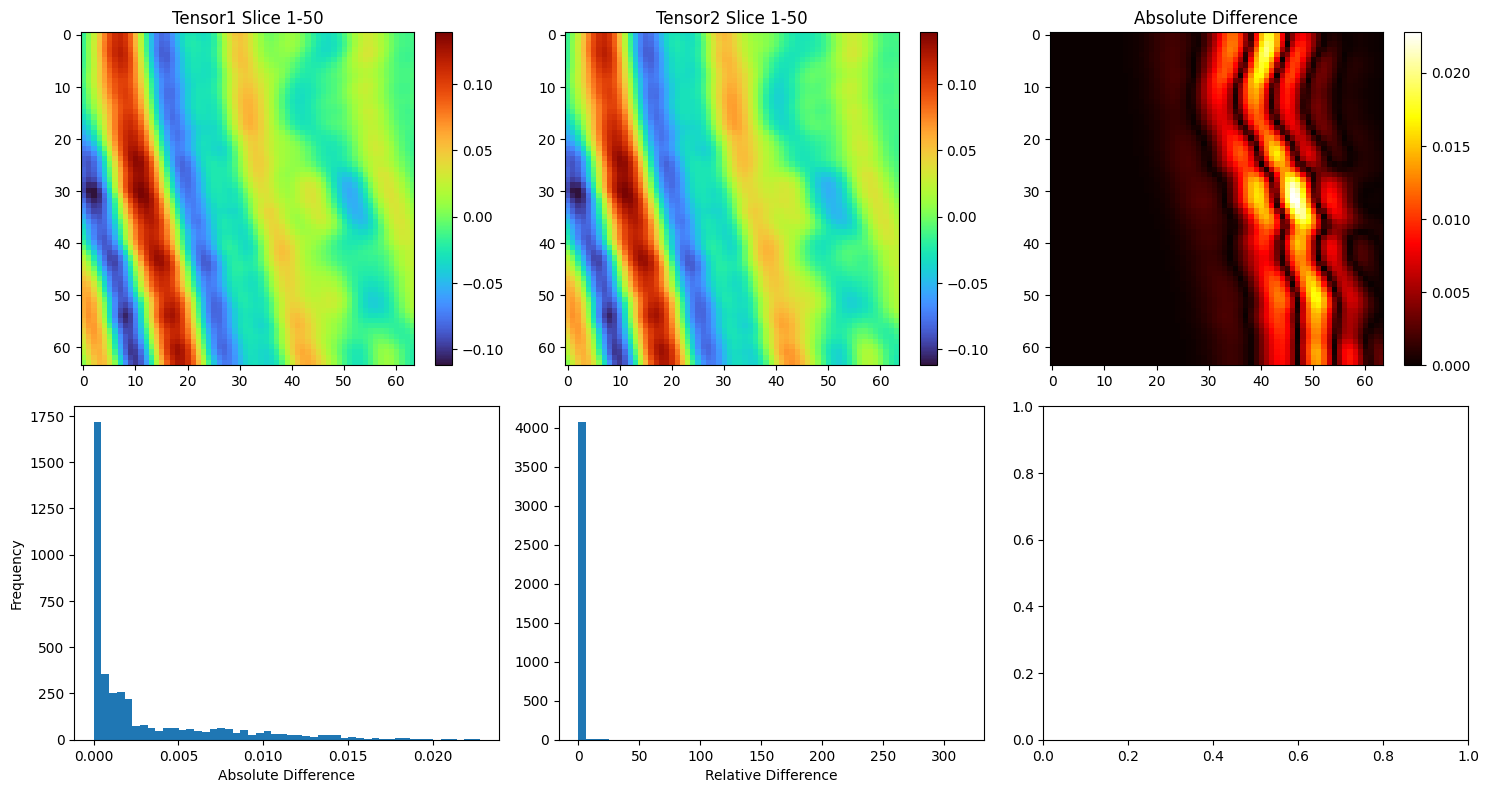

{'max_abs': 0.02276388183236122, 'mean_abs': 0.0028716649394482374, 'rel_over_threshold': 0.732666015625}


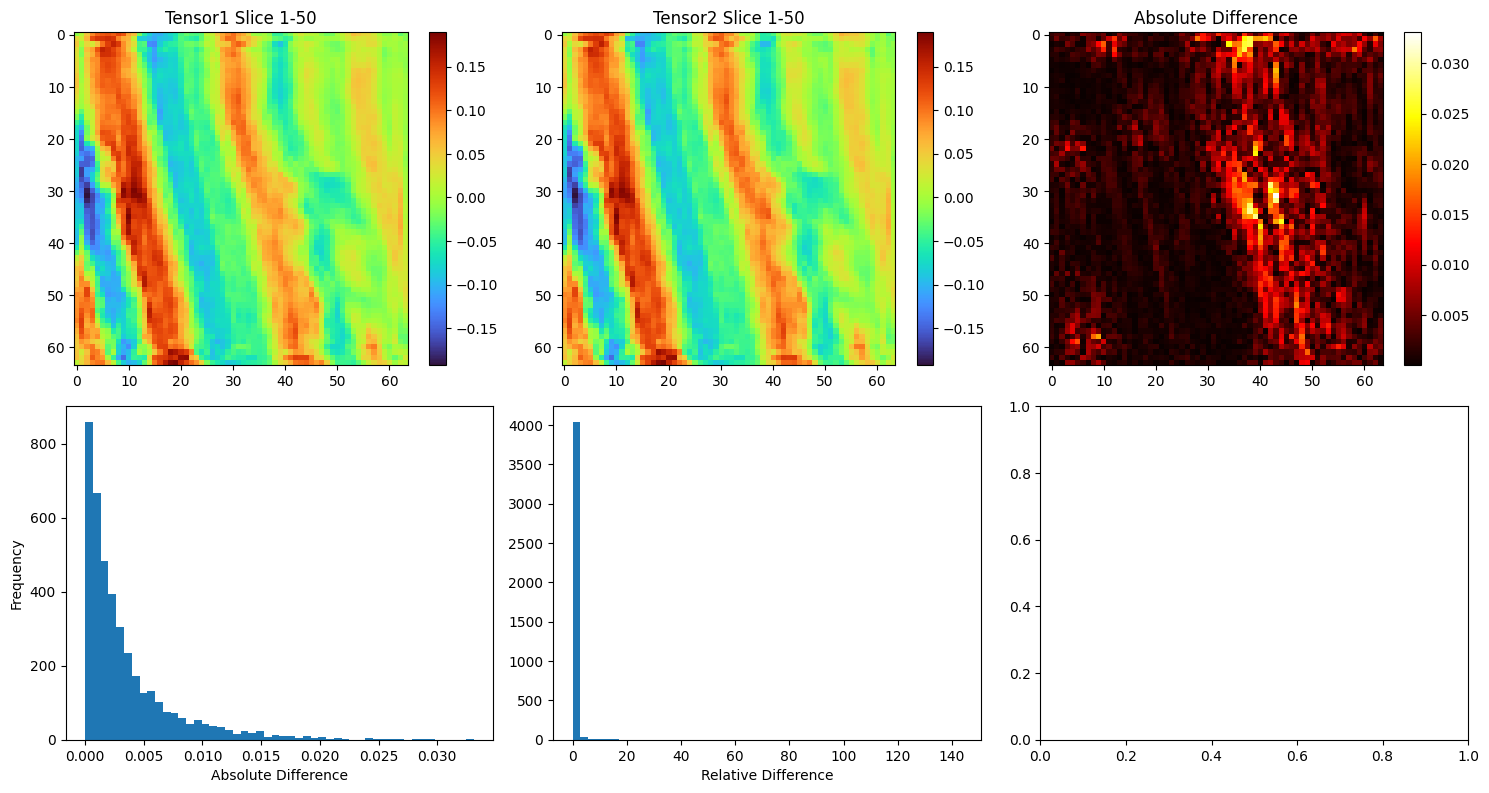

{'max_abs': 0.03310827165842056, 'mean_abs': 0.0034599360078573227, 'rel_over_threshold': 0.983642578125}


'\n重要：predictions当中时移变化学习的区域是正确的\n'

In [ ]:
# predictions_list
# targets_list
t = 0
index_2_visual = 0
stats, fig = compare_4d_slices(targets_list[index_2_visual][0,t+1].cpu().detach()[None,], targets_list[index_2_visual][0,t].cpu().detach()[None,], dim=1, index=50)
plt.show()
print(stats)
stats, fig = compare_4d_slices(predictions_list[index_2_visual][0,t+1].cpu().detach()[None,], predictions_list[index_2_visual][0,t].cpu().detach()[None,], dim=1, index=50)
plt.show()
print(stats)
"""
重要：predictions当中时移变化学习的区域是正确的
"""

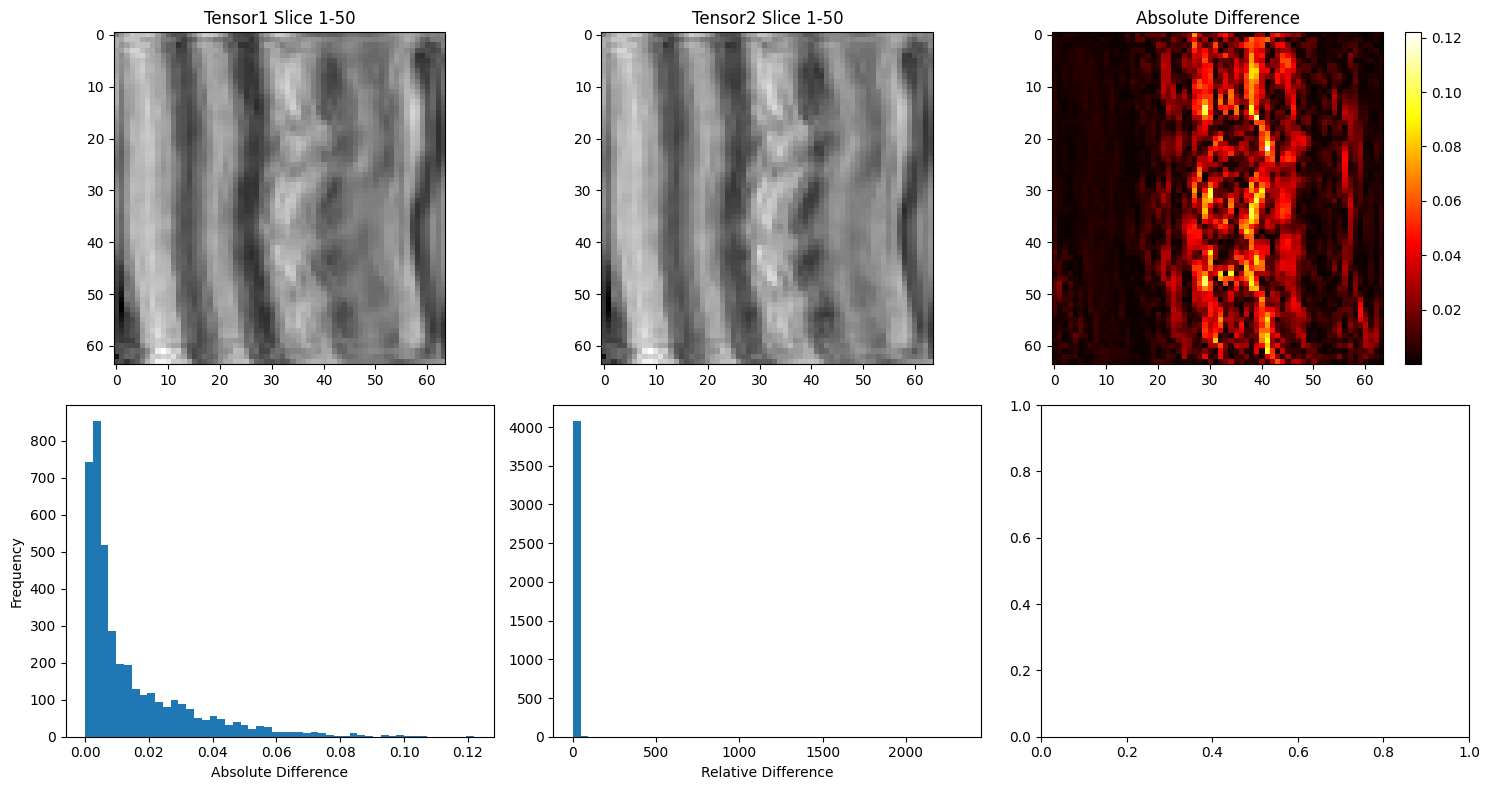

{'max_abs': 0.12196999043226242, 'mean_abs': 0.01451901812106371, 'rel_over_threshold': 0.996337890625}


In [ ]:
# ''''''当中代码的可视化
seismic_skip_features = batch['inputs']['seismic']['skip_features'] # for pre_ae

# 使用处于eval模式的autoencoder进行解码
with torch.no_grad():  # 确保不会计算autoencoder的梯度
    decoded_input_detached = generated_sequence_ldm.detach()  # 暂时分离梯度

# 高斯skip_feature
gaussian_skip_features = [
    [torch.randn_like(tensor) for tensor in sub_list] # 内层循环处理子列表中的每个张量
    for sub_list in seismic_skip_features             # 外层循环处理主列表中的每个子列表
]

# 重新附加梯度跟踪，这样梯度可以通过seismic_output_3d回传到model
seismic_output_3d_pred = processor.decode_to_3d(
    decoded_input_detached,  # 使用原始的有梯度的输出
    seismic_skip_features
)

stats, fig = compare_4d_slices(seismic_output_3d_pred[0,-1].cpu().detach()[None,], seismic_output_3d_pred[0,-3].cpu().detach()[None,], dim=1, index=50)
plt.show()
print(stats)



In [ ]:
#@title 多物理场下的速度密度反演-工具函数包括-训练"地震-速度UNET"

def anisotropic_diffusion_3d(seismic, n_iter=10, K=0.1, lambda_=0.15):
    """
    3D各向异性扩散去噪（Perona-Malik），适合高斯噪声平滑
    seismic: (D, H, W) tensor, float32
    n_iter: 迭代次数
    K: 控制边缘敏感度的参数
    lambda_: 时间步长，建议0.1~0.25
    返回: (D, H, W) tensor

    n_iter 越大，平滑越强。
    K 控制边缘的“敏感度”，越小越容易保留细节。
    lambda_ 是步长，建议不大于0.25。
    """
    I = seismic.clone()
    D, H, W = I.shape

    # 6邻域差分
    def get_gradients(I):
        grads = []
        # pad在边界复制
        I_pad = F.pad(I[None, None], (1,1,1,1,1,1), mode='replicate')[0,0]
        # x方向
        grads.append(I_pad[2:,1:-1,1:-1] - I)  # 前
        grads.append(I_pad[:-2,1:-1,1:-1] - I) # 后
        # y方向
        grads.append(I_pad[1:-1,2:,1:-1] - I)  # 上
        grads.append(I_pad[1:-1,:-2,1:-1] - I) # 下
        # z方向
        grads.append(I_pad[1:-1,1:-1,2:] - I)  # 右
        grads.append(I_pad[1:-1,1:-1,:-2] - I) # 左
        return grads

    for _ in range(n_iter):
        grads = get_gradients(I)
        # 计算扩散系数（这里用exp型）
        c = [torch.exp(-(g/K)**2) for g in grads]
        # 计算扩散量
        diffusion = sum([c_i * g_i for c_i, g_i in zip(c, grads)])
        # 更新
        I = I + lambda_ * diffusion

    return I

def anisotropic_diffusion_2d(image, n_iter=10, K=0.1, lambda_=0.15):
    """
    2D各向异性扩散去噪（Perona-Malik），适合高斯噪声平滑
    image: (H, W) tensor, float32
    n_iter: 迭代次数
    K: 控制边缘敏感度的参数
    lambda_: 时间步长，建议0.1~0.25
    返回: (H, W) tensor

    n_iter 越大，平滑越强。
    K 控制边缘的“敏感度”，越小越容易保留细节。
    lambda_ 是步长，建议不大于0.25。
    """
    import torch
    import torch.nn.functional as F

    I = image.clone()
    H, W = I.shape

    # 4邻域差分
    def get_gradients(I):
        grads = []
        I_pad = F.pad(I[None, None], (1,1,1,1), mode='replicate')[0,0]
        # y方向
        grads.append(I_pad[2:,1:-1] - I)   # 下
        grads.append(I_pad[:-2,1:-1] - I)  # 上
        # x方向
        grads.append(I_pad[1:-1,2:] - I)   # 右
        grads.append(I_pad[1:-1,:-2] - I)  # 左
        return grads

    for _ in range(n_iter):
        grads = get_gradients(I)
        # 计算扩散系数（exp型）
        c = [torch.exp(-(g/K)**2) for g in grads]
        # 计算扩散量
        diffusion = sum([c_i * g_i for c_i, g_i in zip(c, grads)])
        # 更新
        I = I + lambda_ * diffusion

    return I


def sobel3d_edge(seismic):
    """
    用三维Sobel算子提取边缘（可直接用于深度学习反向传播）；
    对三维地震体做Sobel边缘检测，返回边缘概率图（归一化到0~1）
    seismic: (B, 1, D, H, W) or (1, D, H, W)
    返回: edge_map (同shape)
    """
    # 3D Sobel核
    device = seismic.device if torch.is_tensor(seismic) else 'cpu'
    kernel = torch.tensor([
        [[-1, -3, -1], [-3, -6, -3], [-1, -3, -1]],
        [[ 0,  0,  0], [ 0,  0,  0], [ 0,  0,  0]],
        [[ 1,  3,  1], [ 3,  6,  3], [ 1,  3,  1]]
    ], dtype=torch.float32, device=device)
    kernel = kernel[None, None, :, :, :]  # (out_c, in_c, D, H, W)
    # 对三个方向分别卷积
    gx = F.conv3d(seismic[None, None], kernel, padding=1)
    gy = F.conv3d(seismic[None, None], kernel.permute(0,1,4,2,3), padding=1)
    gz = F.conv3d(seismic[None, None], kernel.permute(0,1,3,4,2), padding=1)
    grad = torch.sqrt(gx**2 + gy**2 + gz**2) # 三维空间下反映每个点的“变化剧烈程度"
    # 归一化梯度幅值（通常到0~1区间），可作为“边缘概率”或“边缘响应”
    edge_map = (grad - grad.min()) / (grad.max() - grad.min() + 1e-6)
    return edge_map[0,0]  # shape: (D,H,W)

def get_sobel3d_kernels_5x5(device='cpu'):
    # 一维平滑核和差分核
    G = torch.tensor([1, 4, 6, 4, 1], dtype=torch.float32, device=device)
    D = torch.tensor([-2, -1, 0, 1, 2], dtype=torch.float32, device=device)
    # 构造三维核
    # x方向
    kernel_x = D[:, None, None] * G[None, :, None] * G[None, None, :]
    # y方向
    kernel_y = G[:, None, None] * D[None, :, None] * G[None, None, :]
    # z方向
    kernel_z = G[:, None, None] * G[None, :, None] * D[None, None, :]
    # 归一化
    kernel_x = kernel_x / kernel_x.abs().sum()
    kernel_y = kernel_y / kernel_y.abs().sum()
    kernel_z = kernel_z / kernel_z.abs().sum()
    # 变为(1,1,5,5,5)
    return (kernel_x[None, None], kernel_y[None, None], kernel_z[None, None])

def sobel3d_edge_5x5(seismic):
    """
    用5x5x5三维Sobel算子提取边缘
    seismic: (D, H, W) or (1, D, H, W)
    返回: edge_map (D, H, W)
    """
    device = seismic.device if torch.is_tensor(seismic) else 'cpu'
    if seismic.dim() == 3:
        seismic = seismic.unsqueeze(0).unsqueeze(0)  # (1,1,D,H,W)
    elif seismic.dim() == 4:
        seismic = seismic.unsqueeze(0)  # (1,1,D,H,W)
    kernel_x, kernel_y, kernel_z = get_sobel3d_kernels_5x5(device)
    gx = F.conv3d(seismic, kernel_x, padding=2)
    gy = F.conv3d(seismic, kernel_y, padding=2)
    gz = F.conv3d(seismic, kernel_z, padding=2)
    grad = torch.sqrt(gx**2 + gy**2 + gz**2)
    edge_map = (grad - grad.min()) / (grad.max() - grad.min() + 1e-6)
    return edge_map[0,0]  # (D,H,W)

def get_mask(edge_map, thresh=0.5):
    """可微分二值化（训练时用sigmoid，推理可直接>thresh）"""
    return (edge_map > thresh).float()

from scipy.ndimage import label
def assign_vp_by_region(edge_mask, shape, device='cpu'):
    """
    给每个密闭体分配可学习参数miu和sigma，生成vp模型
    edge_mask: (D,H,W) 二值边缘mask，1表示边界
    shape: (D,H,W)
    返回:
        vp: (D,H,W) 每个体素的vp值
        region_ids: (D,H,W) 区域编号
        miu_list, sigma_list: 每个region的参数（torch.Parameter）
    """
    # 先用scipy标记连通域
    region_ids, n_region = label(1 - edge_mask.cpu().numpy()) # 0=边界，1=内部
    region_ids = torch.tensor(region_ids, device=device)
    # 初始化可学习参数
    miu_list = torch.nn.Parameter(torch.ones(n_region) * 3500)  # 初值可自定义
    sigma_list = torch.nn.Parameter(torch.ones(n_region) * 100)
    # 构造vp
    D, H, W = shape
    vp = torch.zeros(D, H, W, device=device)
    for idx in range(n_region):
        mask = (region_ids == idx)
        # 采样/赋值
        vp[mask] = torch.normal(miu_list[idx].item(), sigma_list[idx].item(), size=(mask.sum(),), device=device)
    return vp, region_ids, miu_list, sigma_list

def gardner_rho(vp, a=0.31, b=0.25):
    return a * vp ** b

# FFT方法计算重力异常，GeoModel类所使用的
def compute_gravity_fft(
    rho,
    dX=100.0,
    dY=100.0,
    dZ=20.0,
    Zmin=0.0,
    height=10.0,
    padding_factor=2,
    reference_density=2.67,
    G=6.67430e-11,
    mute=False
):
    """
    静态函数：根据三维密度体计算重力异常（mGal），基于Parker公式（FFT方法）

    Args:
        rho (np.ndarray): 三维密度体，单位g/cm³
        dX (float): x方向网格间距（米）
        dY (float): y方向网格间距（米）
        dZ (float): z方向网格间距（米）
        Zmin (float): 顶部深度（米）
        height (float): 观测高度（米），相对模型顶部
        padding_factor (int): 边缘填充因子
        reference_density (float): 参考密度（g/cm³），如2.67
        G (float): 万有引力常数
        mute (bool): 是否静默

    Returns:
        gravity (np.ndarray): 重力异常（mGal），shape与rho一致
    """
    if not mute:
        print('计算重力异常（Parker公式）...')

    # 密度反差
    rho_model = rho - reference_density  # 单位g/cm³

    # 获取模型尺寸
    ny, nx, nz = rho_model.shape

    # 填充以减少边缘效应
    padded_ny = ny * padding_factor
    padded_nx = nx * padding_factor
    rho_padded = np.zeros((padded_ny, padded_nx, nz), dtype=np.float32)
    start_y = (padded_ny - ny) // 2
    start_x = (padded_nx - nx) // 2
    rho_padded[start_y:start_y+ny, start_x:start_x+nx, :] = rho_model

    # 波数域
    kx = 2 * np.pi * np.fft.fftfreq(padded_nx, dX)
    ky = 2 * np.pi * np.fft.fftfreq(padded_ny, dY)
    kx_grid, ky_grid = np.meshgrid(kx, ky)
    k = np.sqrt(kx_grid**2 + ky_grid**2)
    k[0, 0] = 1e-10

    # 频率域重力异常
    gravity_fft = np.zeros((padded_ny, padded_nx), dtype=np.complex64)

    # Parker公式级数展开
    for n in range(5):
        if not mute:
            print(f' Parker公式第{n+1}/5项...')
        depth_term = np.zeros((padded_ny, padded_nx), dtype=np.float32)
        for i in range(nz):
            z_val = Zmin + i * dZ
            z_term = z_val ** n
            depth_term += rho_padded[:, :, i] * z_term * dZ
        depth_term_fft = np.fft.fft2(depth_term)
        gravity_fft += (k**n / math.factorial(n)) * depth_term_fft

    # 应用高度衰减和常数
    gravity_fft *= 2 * np.pi * G * 1000 * np.exp(-k * height)  # 1000: g/cm³→kg/m³

    # 回到空间域
    gravity_padded = np.real(np.fft.ifft2(gravity_fft))

    # 提取原始区域
    gravity = gravity_padded[start_y:start_y+ny, start_x:start_x+nx]

    # 转换为mGal
    gravity *= 1e5

    if not mute:
        print(' 完成。')
        print(f'重力异常范围: {gravity.min():.2f} ~ {gravity.max():.2f} mGal')

    return gravity

# 空间域直接积分计算重力异常
from concurrent.futures import ProcessPoolExecutor, as_completed
def _gravity_row(args):
    # 单独计算一行观测点的重力异常
    iy, drho, x, y, z, obs_z, dX, dY, dZ, G = args
    ny, nx, nz = drho.shape
    row = np.zeros(nx, dtype=np.float32)
    for ix in range(nx):
        gz = 0.0
        obs_x = x[ix]
        obs_y = y[iy]
        for iz in range(nz):
            dz = z[iz] - obs_z
            for jy in range(ny):
                dy = y[jy] - obs_y
                for jx in range(nx):
                    dx = x[jx] - obs_x
                    r2 = dx**2 + dy**2 + dz**2
                    if r2 == 0:
                        continue
                    dV = dX * dY * dZ
                    gz += G * drho[jy, jx, iz] * dV * dz / (r2**1.5)
        row[ix] = gz
    return iy, row

def compute_gravity_spatial_parallel(
    rho,
    dX=100.0,
    dY=100.0,
    dZ=20.0,
    Zmin=0.0,
    height=10.0,
    reference_density=2.67,
    G=6.67430e-11,
    n_workers=2,
    mute=False
):
    """
    并行空间域直接积分法：三维密度体重力异常（mGal）

    Args:
        rho (np.ndarray): 三维密度体，单位g/cm³
        dX, dY, dZ (float): 网格间距（米）
        Zmin (float): 模型顶部深度（米）
        height (float): 观测高度（米），相对模型顶部
        reference_density (float): 参考密度（g/cm³）
        G (float): 万有引力常数
        n_workers (int): 并行进程数
        mute (bool): 是否静默

    Returns:
        gravity (np.ndarray): 重力异常（mGal），shape为(rho.shape[0], rho.shape[1])
    """
    if not mute:
        print('并行计算空间域重力异常...')

    drho = (rho - reference_density) * 1000  # kg/m³
    ny, nx, nz = drho.shape
    gravity = np.zeros((ny, nx), dtype=np.float32)

    x = (np.arange(nx) + 0.5) * dX
    y = (np.arange(ny) + 0.5) * dY
    z = Zmin + (np.arange(nz) + 0.5) * dZ
    obs_z = Zmin - height

    # 构造参数列表
    args_list = [
        (iy, drho, x, y, z, obs_z, dX, dY, dZ, G)
        for iy in range(ny)
    ]

    # 并行计算
    with ProcessPoolExecutor(max_workers=n_workers) as executor:
        futures = [executor.submit(_gravity_row, args) for args in args_list]
        for f in as_completed(futures):
            iy, row = f.result()
            gravity[iy, :] = row
            if not mute and iy % 8 == 0:
                print(f"  行 {iy+1}/{ny} 完成")

    gravity *= 1e5  # m/s² → mGal
    if not mute:
        print('完成。')
        print(f'重力异常范围: {gravity.min():.2f} ~ {gravity.max():.2f} mGal')
    return gravity

import numpy as np
from numba import njit, prange

# numba并行
@njit(parallel=True, fastmath=True)
def gravity_direct_numba(drho, dX, dY, dZ, x, y, z, obs_z, G):
    ny, nx, nz = drho.shape
    gravity = np.zeros((ny, nx), dtype=np.float32)
    dV = dX * dY * dZ
    for iy in prange(ny):
        for ix in range(nx):
            gz = 0.0
            obs_x = x[ix]
            obs_y = y[iy]
            for iz in range(nz):
                dz = z[iz] - obs_z
                for jy in range(ny):
                    dy = y[jy] - obs_y
                    for jx in range(nx):
                        dx = x[jx] - obs_x
                        r2 = dx**2 + dy**2 + dz**2
                        if r2 == 0:
                            continue
                        gz += G * drho[jy, jx, iz] * dV * dz / (r2**1.5)
            gravity[iy, ix] = gz
    return gravity

def compute_gravity_direct_numba(
    rho,
    dX=100.0,
    dY=100.0,
    dZ=20.0,
    Zmin=0.0,
    height=10.0,
    reference_density=2.67,
    G=6.67430e-11,
    mute=False
):
    """
    Numba加速的空间域直接积分法
    """
    if not mute:
        print('Numba加速空间域重力异常...')
    drho = (rho - reference_density) * 1000  # kg/m³
    ny, nx, nz = drho.shape
    x = (np.arange(nx) + 0.5) * dX
    y = (np.arange(ny) + 0.5) * dY
    z = Zmin + (np.arange(nz) + 0.5) * dZ
    obs_z = Zmin - height
    gravity = gravity_direct_numba(drho, dX, dY, dZ, x, y, z, obs_z, G)
    gravity *= 1e5  # m/s² → mGal
    if not mute:
        print('完成。')
        print(f'重力异常范围: {gravity.min():.2f} ~ {gravity.max():.2f} mGal')
    return gravity

# torch自动微分计算
def gravity_forward_torch(
    rho,
    dX=100.0,
    dY=100.0,
    dZ=20.0,
    Zmin=0.0,
    height=10.0,
    reference_density=2.67,
    G=6.67430e-11
):
    """
    PyTorch端到端可微分的重力异常正演
    输入:
        rho: [ny, nx, nz]，密度模型
    输出:
        gravity: [ny, nx]，重力异常
    """
    device = rho.device
    dtype = rho.dtype

    drho = (rho - reference_density) * 1000  # kg/m³
    ny, nx, nz = drho.shape

    # 观测点和模型网格
    x = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX
    y = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY
    z = Zmin + (torch.arange(nz, device=device, dtype=dtype) + 0.5) * dZ
    obs_z = Zmin - height
    dV = dX * dY * dZ

    # 初始化输出
    gravity = torch.zeros((ny, nx), device=device, dtype=dtype)

    # 主循环，逐点计算（可进一步向量化）
    for iy in range(ny):
        for ix in range(nx):
            obs_x = x[ix]
            obs_y = y[iy]
            gz = 0.0

            for iz in range(nz):
                dz = z[iz] - obs_z  # 标量
                # 计算当前层所有体素到观测点的dx, dy
                dx = x - obs_x      # [nx]
                dy = y - obs_y      # [ny]
                # 网格化dx, dy
                dx_grid, dy_grid = torch.meshgrid(dx, dy, indexing='ij')  # [nx, ny]
                dx_grid = dx_grid.transpose(0,1)  # [ny, nx]
                dy_grid = dy_grid.transpose(0,1)  # [ny, nx]
                # 计算r^2
                r2 = dx_grid**2 + dy_grid**2 + dz**2  # [ny, nx]
                mask = r2 > 0
                # 取出当前dz层的密度差
                drho_layer = drho[:, :, iz]  # [ny, nx]
                # 贡献
                contrib = torch.zeros_like(r2)
                contrib[mask] = G * drho_layer[mask] * dV * dz / (r2[mask]**1.5)
                gz = gz + contrib.sum()
            gravity[iy, ix] = gz

    gravity = gravity * 1e5  # m/s² → mGal
    return gravity

def gravity_forward_torch_vectorized(
    rho,
    dX=100.0,
    dY=100.0,
    dZ=20.0,
    Zmin=0.0,
    height=10.0,
    reference_density=2.67,
    G=6.67430e-11
):
    """
    高效向量化的PyTorch重力异常正演
    输入:
        rho: [ny, nx, nz]
    输出:
        gravity: [ny, nx]
    """
    device = rho.device
    dtype = rho.dtype

    ny, nx, nz = rho.shape
    drho = (rho - reference_density) * 1000  # kg/m³

    # 观测点坐标
    x_obs = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX  # [nx]
    y_obs = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY  # [ny]
    obs_z = Zmin - height

    # 体素中心坐标
    x_grid = (torch.arange(nx, device=device, dtype=dtype) + 0.5) * dX  # [nx]
    y_grid = (torch.arange(ny, device=device, dtype=dtype) + 0.5) * dY  # [ny]
    z_grid = Zmin + (torch.arange(nz, device=device, dtype=dtype) + 0.5) * dZ  # [nz]

    dV = dX * dY * dZ

    # 构建体素坐标 [ny, nx, nz, 3]
    grid_y, grid_x, grid_z = torch.meshgrid(y_grid, x_grid, z_grid, indexing='ij')  # [ny, nx, nz]

    # 展开体素 [N, 3]
    voxels = torch.stack([grid_x, grid_y, grid_z], dim=-1).reshape(-1, 3)  # [N, 3]
    drho_flat = drho.reshape(-1)  # [N]

    # 构建观测点坐标 [M, 3]
    obs_xx, obs_yy = torch.meshgrid(x_obs, y_obs, indexing='ij')  # [nx, ny]
    obs_points = torch.stack([
        obs_xx.reshape(-1), obs_yy.reshape(-1),
        torch.full((nx*ny,), obs_z, device=device, dtype=dtype)
    ], dim=-1)  # [M, 3]

    # 计算观测点到每个体素的矢量差 [M, N, 3]
    diff = voxels.unsqueeze(0) - obs_points.unsqueeze(1)  # [M, N, 3]
    r2 = (diff ** 2).sum(dim=-1)  # [M, N]
    dz = diff[..., 2]  # [M, N]

    # 避免除零
    r2_safe = r2 + 1e-12

    # drho_flat [N] -> [1, N] -> [M, N] (自动广播)
    contrib = G * drho_flat.unsqueeze(0) * dV * dz / (r2_safe ** 1.5)  # [M, N]

    # 累加体素，得到每个观测点的重力异常 [M]
    gravity_flat = contrib.sum(dim=1) * 1e5  # mGal

    # reshape回 [ny, nx]
    gravity = gravity_flat.reshape(nx, ny).transpose(0, 1)  # [ny, nx]

    return gravity




# --- 神经网络----
class SEBlock3D(nn.Module):
    """
    SE（Squeeze-and-Excitation）模块能够为每个通道分配不同的权重，突出模型关注的特征。
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock3D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, d, h, w = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y.expand_as(x)

class SpatialAttention3D(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention3D, self).__init__()
        self.conv = nn.Conv3d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(x_cat))
        return x * attention

class CBAM3D(nn.Module):
    """
    CBAM（Convolutional Block Attention Module）同时关注空间和通道维度。对于高异常值分布的关注，空间注意力尤其有效。
    """
    def __init__(self, channels, reduction=16, kernel_size=7):
        super(CBAM3D, self).__init__()
        self.channel_attention = SEBlock3D(channels, reduction)
        self.spatial_attention = SpatialAttention3D(kernel_size)

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, attention=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
        )
        self.relu = nn.ReLU(inplace=True)
        self.attention = CBAM3D(out_channels) if attention else nn.Identity()
        # 适配通道数不一致的残差映射
        self.residual = nn.Conv3d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        res = self.residual(x)
        out = self.conv(x)
        out = out + res
        out = self.relu(out)
        out = self.attention(out)
        return out

class UNet3D_ResAtten(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_features=64):
        super().__init__()
        # 增加深度，base_features更大
        self.enc1 = ResidualConvBlock(in_channels, base_features)
        self.enc2 = ResidualConvBlock(base_features, base_features*2)
        self.enc3 = ResidualConvBlock(base_features*2, base_features*4)
        self.enc4 = ResidualConvBlock(base_features*4, base_features*8)
        self.enc5 = ResidualConvBlock(base_features*8, base_features*16)

        self.pool = nn.MaxPool3d(2)

        self.up4 = nn.ConvTranspose3d(base_features*16, base_features*8, 2, 2)
        self.dec4 = ResidualConvBlock(base_features*16, base_features*8)
        self.up3 = nn.ConvTranspose3d(base_features*8, base_features*4, 2, 2)
        self.dec3 = ResidualConvBlock(base_features*8, base_features*4)
        self.up2 = nn.ConvTranspose3d(base_features*4, base_features*2, 2, 2)
        self.dec2 = ResidualConvBlock(base_features*4, base_features*2)
        self.up1 = nn.ConvTranspose3d(base_features*2, base_features, 2, 2)
        self.dec1 = ResidualConvBlock(base_features*2, base_features)
        self.out_conv = nn.Conv3d(base_features, out_channels, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        e5 = self.enc5(self.pool(e4))

        d4 = self.up4(e5)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out = self.out_conv(d1)
        return out


# 标准3D UNet
class UNet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_features=32):
        super(UNet3D, self).__init__()
        # 编码器
        self.enc1 = self.conv_block(in_channels, base_features)
        self.enc2 = self.conv_block(base_features, base_features*2)
        self.enc3 = self.conv_block(base_features*2, base_features*4)
        self.enc4 = self.conv_block(base_features*4, base_features*8)
        # 下采样
        self.pool = nn.MaxPool3d(2)
        # 解码器
        self.up3 = nn.ConvTranspose3d(base_features*8, base_features*4, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(base_features*8, base_features*4)
        self.up2 = nn.ConvTranspose3d(base_features*4, base_features*2, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(base_features*4, base_features*2)
        self.up1 = nn.ConvTranspose3d(base_features*2, base_features, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(base_features*2, base_features)
        # 输出层
        self.out_conv = nn.Conv3d(base_features, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # 编码
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        # 解码
        d3 = self.up3(e4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        out = self.out_conv(d1)
        return out



from torch.utils.data import Dataset, DataLoader

def minmax_normalize(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val + 1e-8)

def minmax_denormalize(x_norm, min_val, max_val):
    return x_norm * (max_val - min_val + 1e-8) + min_val

# 1. 数据集封装
class SeismicVpDataset(Dataset):
    def __init__(self, seismic_vp_pairs, apply_diffusion=True):
        self.pairs = seismic_vp_pairs
        self.apply_diffusion = apply_diffusion

        # 计算vp全局min/max
        all_vp = torch.cat([vp.flatten() for _, vp in seismic_vp_pairs])
        self.vp_min = all_vp.min()
        self.vp_max = all_vp.max()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        seismic, vp = self.pairs[idx]
        if self.apply_diffusion:
            seismic = anisotropic_diffusion_3d(seismic, n_iter=15, K=0.01, lambda_=0.18)
        seismic = seismic.unsqueeze(0)
        # 归一化vp
        vp_norm = minmax_normalize(vp, self.vp_min, self.vp_max).unsqueeze(0)
        return seismic, vp_norm

# --- 地震-速度UNET训练函数
def train_unet_on_seismic_vp(
    seismic_vp_train_pairs,
    device='cuda',
    batch_size=2,
    num_epochs=50,
    lr=1e-3,
    best_model_path='best_unet3d.pth',
    final_model_path='final_unet3d.pth',
    resume_path=None  # 新增参数：断点续训.pth路径
):
    dataset = SeismicVpDataset(seismic_vp_train_pairs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = UNet3D_ResAtten(in_channels=1, out_channels=1).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    # 默认归一化参数
    vp_min, vp_max = dataset.vp_min, dataset.vp_max

    start_epoch = 0
    best_loss = float('inf')
    best_state = None

    # ---- 断点续训 ----
    if resume_path is not None:
        checkpoint = torch.load(resume_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        # 兼容保存的归一化参数
        vp_min = checkpoint.get('vp_min', vp_min)
        vp_max = checkpoint.get('vp_max', vp_max)
        print(f"Resumed training from checkpoint: {resume_path}")

    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        batch_iter = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for seismic, vp_norm in batch_iter:
            seismic = seismic.to(device)
            vp_norm = vp_norm.to(device)
            optimizer.zero_grad()
            pred_vp_norm = model(seismic)
            loss = criterion(pred_vp_norm, vp_norm)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * seismic.size(0)
            batch_iter.set_postfix({'batch_loss': loss.item()})

        avg_loss = epoch_loss / len(dataset)
        tqdm.write(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.6f}")

        if avg_loss < best_loss:
            best_loss = avg_loss
            best_state = model.state_dict()
            # 保存归一化参数
            torch.save({
                'model_state_dict': best_state,
                'vp_min': vp_min,
                'vp_max': vp_max,
            }, best_model_path)
            tqdm.write(f"Best model updated at epoch {epoch+1} (Avg Loss: {avg_loss:.6f})")

    torch.save({
        'model_state_dict': model.state_dict(),
        'vp_min': vp_min,
        'vp_max': vp_max,
    }, final_model_path)
    print("Training finished.")
    print(f"Best model saved to: {best_model_path}")
    print(f"Final model saved to: {final_model_path}")
    return model, vp_min, vp_max




# --- 训练 ---
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# trained_model = train_unet_on_seismic_vp(
#     seismic_vp_train_pairs,
#     device=device,
#     batch_size=80,
#     num_epochs=80,
#     lr=1e-3,
#     best_model_path='/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/seismic_vp_unet_attn_best.pth',
#     final_model_path='/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/seismic_vp_unet_attn_final.pth',
#     resume_path=None
# )

# --- 推理---
# 推理时反归一化
# def predict_and_denormalize(model, seismic, vp_min, vp_max, device='cuda'):
#     model.eval()
#     with torch.no_grad():
#         seismic = seismic.unsqueeze(0).to(device)  # [1, 1, D, H, W]
#         pred_vp_norm = model(seismic)
#         pred_vp = minmax_denormalize(pred_vp_norm.cpu().squeeze(0), vp_min, vp_max)
#     return pred_vp

# 载入模型
def load_unet3d_and_params(model_path, device='cuda'):
    checkpoint = torch.load(model_path, map_location=device)
    # model = UNet3D(in_channels=1, out_channels=1).to(device)
    model = UNet3D_ResAtten(in_channels=1, out_channels=1).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    vp_min = checkpoint['vp_min']
    vp_max = checkpoint['vp_max']
    return model, vp_min, vp_max

def predict_and_denormalize(model, seismic, vp_min, vp_max, device='cuda'):
    """
    seismic: torch.Tensor, shape [1, D, H, W] or [D, H, W]
    返回: 反归一化后的vp, shape [D, H, W]
    """
    model.eval()
    with torch.no_grad():
        if seismic.ndim == 3:
            seismic = seismic.unsqueeze(0)  # [1, D, H, W]
        seismic = seismic.unsqueeze(0).to(device)  # [1, 1, D, H, W]
        pred_vp_norm = model(seismic)
        pred_vp_norm = pred_vp_norm.cpu().squeeze(0).squeeze(0)  # [D, H, W]
        pred_vp = minmax_denormalize(pred_vp_norm, vp_min, vp_max)
    return pred_vp


# t = 0 # 预测的四帧当中取第几帧
# seismic = predictions_list[0][0,t].cpu().clone().detach().requires_grad_(True)
# smoothed_seismic = anisotropic_diffusion_3d(seismic, n_iter=15, K=0.01, lambda_=0.18) # 地震-速度UNET的输入

# target_gravity = target_gravity_anomoly.clone().detach().requires_grad_(True)
# target_vp_future = target_vp.clone().detach().requires_grad_(True) # 地震-速度UNET的输出




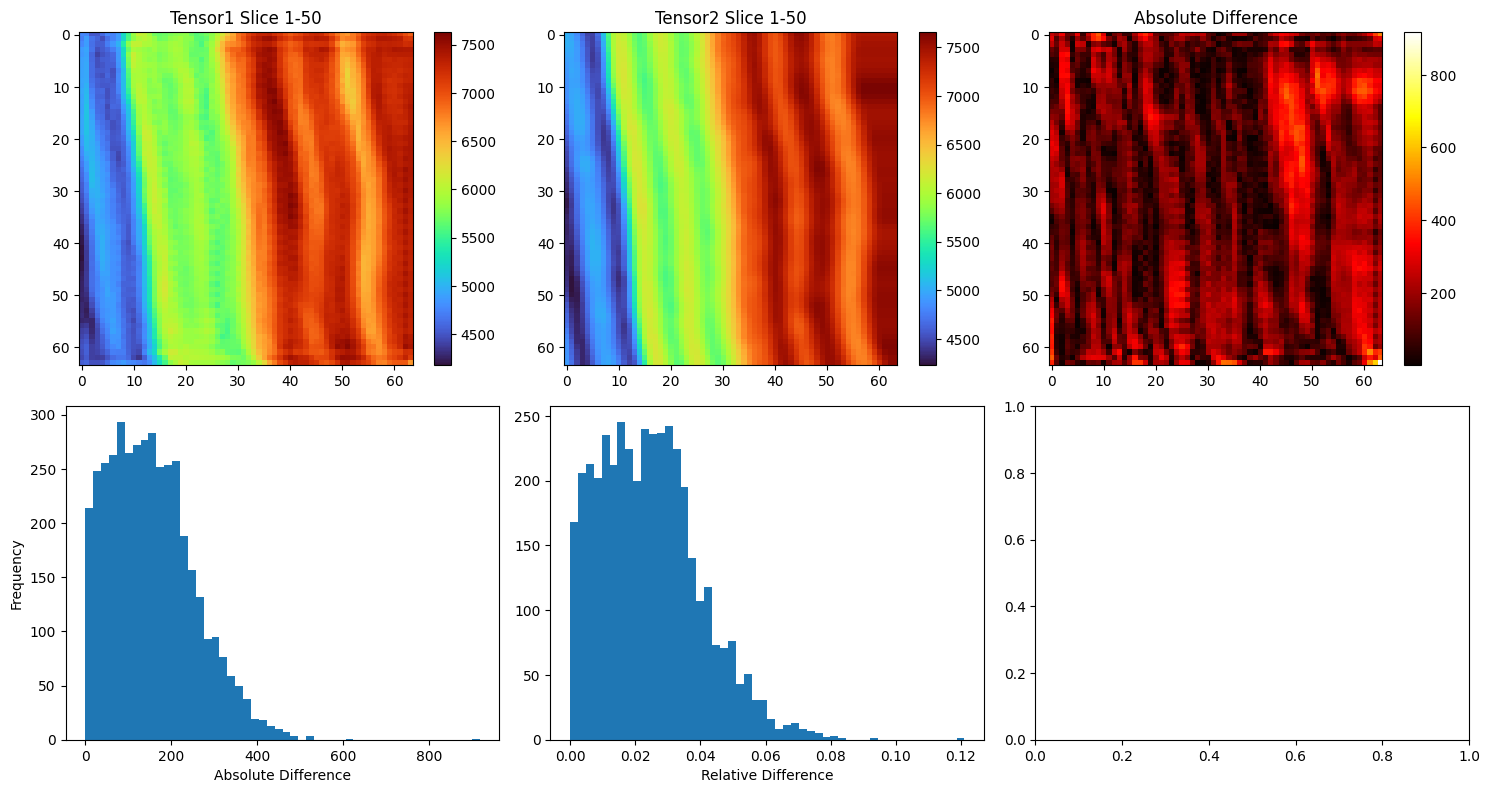

{'max_abs': 917.64111328125, 'mean_abs': 154.32870483398438, 'rel_over_threshold': 0.9853515625}


In [ ]:
#@title 多物理场下的速度密度反演-推理"地震-速度UNET",比较SW预测的地震和真实速度模型

# 路径与设备
model_path = '/content/drive/MyDrive/DiTing2.0/ckp_u_pre_ae/seismic_vp_unet_attn_best.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 载入模型与参数
model, vp_min, vp_max = load_unet3d_and_params(model_path, device=device)

# 随机索引，用于获得地震，速度，磁异常数据
import random
random.seed(42)
# RANDOM_INDEX = random.randint(0, len(seismic_vp_train_pairs) - 1) # 固定了因为设置了seed
RANDOM_INDEX = 3+4*2

# 获取一组地震数据和vp（这里只用地震数据）
seismic_new, vp_new = seismic_vp_train_pairs[RANDOM_INDEX]
# 磁异常索引
magnetic_tensor_idx = RANDOM_INDEX // 4      # 第几个tensor
magnetic_inner_idx = RANDOM_INDEX % 4        # tensor中的第几个样本
# 取出对应的磁异常
magnetic_anomaly = magnetic_list[magnetic_tensor_idx][magnetic_inner_idx]

# 神经网络预测
pred_vp = predict_and_denormalize(model, seismic_new, vp_min, vp_max, device=device)
# pred_vp 形状为 [D, H, W]

# 比较预测速度和真实速度
stats, fig = compare_4d_slices(pred_vp.detach().unsqueeze(0), vp_new.unsqueeze(0).detach(), dim=1, index=50)
plt.show()
print(stats)

# # 比较SW预测的地震和预测速度模型
# stats, fig = compare_4d_slices(seismic_new.detach().unsqueeze(0), pred_vp.detach().unsqueeze(0), dim=1, index=50)
# plt.show()
# print(stats)

# # 比较SW预测的地震和真实速度模型
# seimic_case,vp_case = seismic_vp_train_pairs[RANDOM_INDEX]
# stats, fig = compare_4d_slices(seimic_case.unsqueeze(0).detach(), vp_case.unsqueeze(0).detach(), dim=1, index=50)
# plt.show()
# print(stats)

# 二进制保存预测速度&真实速度
pred_vp_numpy = pred_vp.detach().cpu().numpy()
pred_vp_numpy.tofile(f"/content/drive/MyDrive/DiTing2.0/dataset/self_constructed_64/pred_vp_vanilla_{RANDOM_INDEX}.bin")
vp_new_numpy = vp_new.detach().cpu().numpy()
vp_new_numpy.tofile(f"/content/drive/MyDrive/DiTing2.0/dataset/self_constructed_64/vp_true_{RANDOM_INDEX}.bin")
diff_vp_numpy = pred_vp_numpy - vp_new_numpy
diff_vp_numpy.tofile(f"/content/drive/MyDrive/DiTing2.0/dataset/self_constructed_64/vp_diff_{RANDOM_INDEX}.bin")



In [ ]:
target_gravity = target_gravity_anomoly.clone().detach().requires_grad_(True)
target_gravity_smoothed = anisotropic_diffusion_2d(target_gravity[0,0])

In [ ]:
vp_list[0].shape

torch.Size([1, 4, 64, 64, 64])

## 重力异常约束

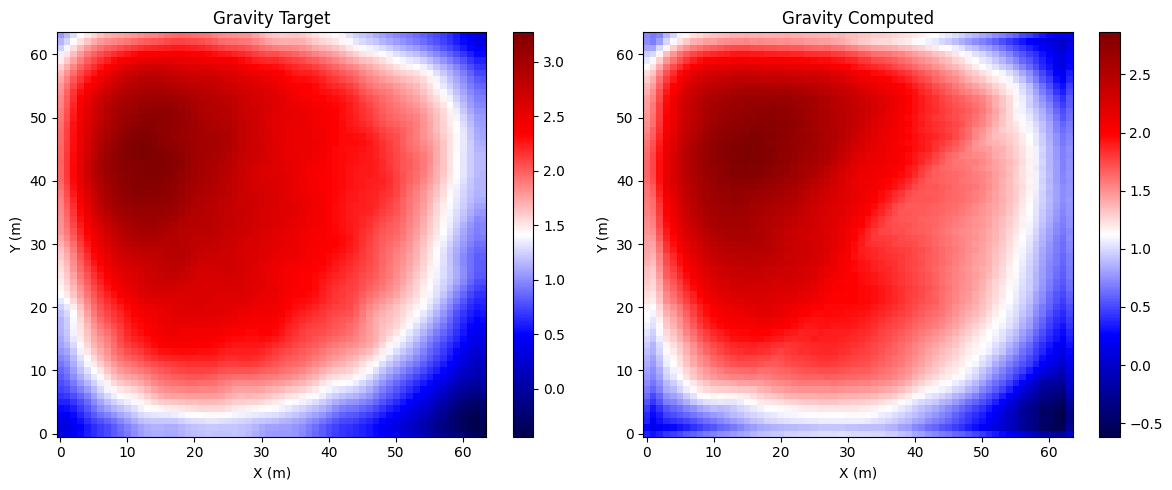

In [ ]:
#@title 从速度依据gardner推导到密度

# --- 计算rho ---
# t=0
# target_vp = vp_list[0][0,t].clone().detach().requires_grad_(True)
target_vp = vp_new.clone().detach().requires_grad_(True)
rho_computed = gardner_rho(pred_vp)
rho_target = gardner_rho(target_vp)
# --- 计算重力异常 ---
# gravity_computed = compute_gravity_direct_numba(
#     rho_computed.cpu().numpy(),
#     height=10.0,
# )
# gravity_target = compute_gravity_direct_numba(
#     rho_target.detach().numpy(),
#     height=10.0,
# )
gravity_computed = gravity_forward_torch_vectorized(
    rho_computed,
    height=10.0,
)
gravity_target = gravity_forward_torch_vectorized(
    rho_target.detach(),
    height=10.0,
)
# target_gravity = target_gravity_anomoly.clone().detach().requires_grad_(True) # 这个使用FFT计算的，不准

#  # 绘制2D重力异常图
# plt.imshow(gravity_target,
#            cmap='seismic',
#            origin='lower',
#            aspect='auto', )
# plt.xlabel('X (m)')
# plt.ylabel('Y (m)')
# plt.show()
# # 绘制2D重力异常图
# plt.imshow(gravity_computed,
#            cmap='seismic',
#            origin='lower',
#            aspect='auto', )
# plt.xlabel('X (m)')
# plt.ylabel('Y (m)')
# plt.show()

import matplotlib.pyplot as plt

# 创建子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 第一个子图
im1 = ax1.imshow(gravity_target,
                 cmap='seismic',
                 origin='lower',
                 aspect='auto')
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_title('Gravity Target')
plt.colorbar(im1, ax=ax1)

# 第二个子图
im2 = ax2.imshow(gravity_computed,
                 cmap='seismic',
                 origin='lower',
                 aspect='auto')
ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_title('Gravity Computed')
plt.colorbar(im2, ax=ax2)

# 调整布局
plt.tight_layout()

# 保存为PDF
plt.savefig('/content/drive/MyDrive/DiTing2.0/gravity_comparison_before_8_to_11.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
#@title 重力-地震联合反演
import torch
from torch import nn, optim
from tqdm import trange
import torch.nn.functional as F

'''
pred_vp, gravity_target
'''
def bound_loss(vp, vmin, vmax):
    return torch.relu(vp - vmax).mean() + torch.relu(vmin - vp).mean()

def smoothness_loss(vp, mask=None):
    """
    计算vp的平滑正则项，支持2D和3D，并可选mask。
    vp: [ny, nx] 或 [nz, ny, nx]，float tensor
    mask: 可选，bool型，与vp同shape，仅对True区域加正则
    返回: 标量loss
    """
    dims = vp.dim()
    if dims == 2:
        diff_x = vp[:, 1:] - vp[:, :-1]
        diff_y = vp[1:, :] - vp[:-1, :]
        loss = (diff_x**2).mean() + (diff_y**2).mean()
        if mask is not None:
            # mask_x: [ny, nx-1], mask_y: [ny-1, nx]
            mask_x = mask[:, 1:] & mask[:, :-1]
            mask_y = mask[1:, :] & mask[:-1, :]
            loss = ((diff_x**2)[mask_x].mean() if mask_x.any() else 0) + \
                   ((diff_y**2)[mask_y].mean() if mask_y.any() else 0)
    elif dims == 3:
        diff_x = vp[:, :, 1:] - vp[:, :, :-1]
        diff_y = vp[:, 1:, :] - vp[:, :-1, :]
        diff_z = vp[1:, :, :] - vp[:-1, :, :]
        loss = (diff_x**2).mean() + (diff_y**2).mean() + (diff_z**2).mean()
        if mask is not None:
            # mask_x: [nz, ny, nx-1], mask_y: [nz, ny-1, nx], mask_z: [nz-1, ny, nx]
            mask_x = mask[:, :, 1:] & mask[:, :, :-1]
            mask_y = mask[:, 1:, :] & mask[:, :-1, :]
            mask_z = mask[1:, :, :] & mask[:-1, :, :]
            loss = ((diff_x**2)[mask_x].mean() if mask_x.any() else 0) + \
                   ((diff_y**2)[mask_y].mean() if mask_y.any() else 0) + \
                   ((diff_z**2)[mask_z].mean() if mask_z.any() else 0)
    else:
        raise ValueError("vp must be 2D or 3D tensor")
    return loss

# 在速度反演当中，我们需要使用稀疏性约束吗？
def sparsity_loss(vp, mask=None):
    """
    计算vp的稀疏正则项（L1范数），支持2D和3D，并可选mask。
    vp: [ny, nx] 或 [nz, ny, nx]，float tensor
    mask: 可选，bool型，与vp同shape，仅对True区域加正则
    返回: 标量loss
    """
    if mask is not None:
        if mask.any():
            loss = vp[mask].abs().mean()
        else:
            loss = vp.new_tensor(0.0)
    else:
        loss = vp.abs().mean()
    return loss

# 不同于前面多部迭代的方向性扩散，这里实现了单步作为正则化函数参与计算loss
def anisotropic_diffusion_loss(vp, kx=1.0, ky=1.0, epsilon=1e-6):
    """
    计算vp的方向性扩散正则项，抑制噪声的方向性特征。
    vp: [ny, nx] 或 [batch, ny, nx]，float tensor
    kx, ky: x/y方向的扩散系数，越小则该方向扩散越弱（结构保护越强）
    返回: 标量loss
    """
    # 计算x方向梯度
    grad_x = vp[..., :, 1:] - vp[..., :, :-1]
    # 计算y方向梯度
    grad_y = vp[..., 1:, :] - vp[..., :-1, :]

    # 方向性扩散系数（可以是常数，也可以是随梯度变化的函数）
    # 这里采用Perona-Malik形式
    coeff_x = torch.exp(- (grad_x / kx)**2)
    coeff_y = torch.exp(- (grad_y / ky)**2)

    # 方向性扩散正则项
    loss_x = (coeff_x * grad_x**2).mean()
    loss_y = (coeff_y * grad_y**2).mean()
    loss = loss_x + loss_y
    return loss


# 1. 需要优化的参数
pred_vp_param = torch.nn.Parameter(pred_vp.clone().detach().requires_grad_(True)) # pred_vp.shape: torch.Size([64, 64, 64])

# 2. 优化参数
optimizer = torch.optim.Adam([pred_vp_param], lr=1)
max_epochs = 200
lambda_smooth = 0.1
mu_bound = 1
scale = 1e6

loss_gravity_history = []
for epoch in trange(max_epochs, desc="Optimizing"):
    # 3. 速度->密度
    rho = gardner_rho(pred_vp_param)  # 你的密度转换公式

    # 4. 正演
    gravity_computed = gravity_forward_torch_vectorized(rho)

    # 5. 主损失
    loss_gravity = ((gravity_computed - gravity_target)**2).mean()

    # 6. 平滑正则项（可选）
    loss_smooth = smoothness_loss(pred_vp_param)  # 只对可调区域

    # 7. 上下界约束（可选）
    loss_bound = bound_loss(pred_vp_param, pred_vp.min(), pred_vp.max())

    # 8. 总损失
    gravity_computed_norm = (gravity_computed - gravity_computed.mean()) / gravity_computed.std()
    gravity_target_norm = (gravity_target - gravity_target.mean()) / gravity_target.std()
    loss_gravity = ((gravity_computed_norm - gravity_target_norm)**2).mean()
    loss = scale * loss_gravity + lambda_smooth * loss_smooth + mu_bound * loss_bound

    optimizer.zero_grad()
    loss.backward()
    print(pred_vp_param.grad.abs().mean())
    optimizer.step()

    # 保存loss_gravity
    loss_gravity_history.append(loss_gravity.item())

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, loss={loss.item():.6f}, gravity={loss_gravity.item():.6f}, smooth={loss_smooth.item():.6f}, bound={loss_bound.item():.6f}")

# 输出优化后的 pred_vp
pred_vp_optimized = pred_vp_param.detach().clone()
# 保存loss_gravity_history为 .npy 文件
np.save(f_path+'/loss_gravity_history_8_to_11.npy', np.array(loss_gravity_history))

# 载入 .npy 文件
loss_gravity_history = np.load(f_path+'/loss_gravity_history_8_to_11.npy')

plt.figure(figsize=(6, 4))
plt.plot(loss_gravity_history, label='Gravity Loss', color='navy', linewidth=2)

# 学术风格美化
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Gravity Loss History', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 可选：使用 LaTeX 字体
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.tick_params(labelsize=12)

# 保存图片
plt.savefig(f_path+'/loss_gravity_history_8_to_11.pdf', dpi=300)
plt.show()

# 20mins

Optimizing:   0%|          | 1/200 [00:07<24:32,  7.40s/it]

tensor(0.0045)
Epoch 0, loss=30571.478516, gravity=0.027697, smooth=28745.226562, bound=0.000000


Optimizing:   1%|          | 2/200 [00:14<24:47,  7.51s/it]

tensor(0.0044)


Optimizing:   2%|▏         | 3/200 [00:22<24:35,  7.49s/it]

tensor(0.0043)


Optimizing:   2%|▏         | 4/200 [00:29<24:25,  7.48s/it]

tensor(0.0041)


Optimizing:   2%|▎         | 5/200 [00:37<24:19,  7.48s/it]

tensor(0.0040)


Optimizing:   3%|▎         | 6/200 [00:44<24:08,  7.47s/it]

tensor(0.0039)


Optimizing:   4%|▎         | 7/200 [00:52<23:59,  7.46s/it]

tensor(0.0037)


Optimizing:   4%|▍         | 8/200 [00:59<23:51,  7.45s/it]

tensor(0.0036)


Optimizing:   4%|▍         | 9/200 [01:07<23:42,  7.45s/it]

tensor(0.0035)


Optimizing:   5%|▌         | 10/200 [01:14<23:41,  7.48s/it]

tensor(0.0034)


Optimizing:   6%|▌         | 11/200 [01:22<23:29,  7.46s/it]

tensor(0.0033)
Epoch 10, loss=20525.574219, gravity=0.017667, smooth=28588.818359, bound=0.000000


Optimizing:   6%|▌         | 12/200 [01:29<23:25,  7.48s/it]

tensor(0.0031)


Optimizing:   6%|▋         | 13/200 [01:37<23:19,  7.49s/it]

tensor(0.0030)


Optimizing:   7%|▋         | 14/200 [01:44<23:19,  7.52s/it]

tensor(0.0029)


Optimizing:   8%|▊         | 15/200 [01:52<23:17,  7.55s/it]

tensor(0.0028)


Optimizing:   8%|▊         | 16/200 [01:59<23:12,  7.57s/it]

tensor(0.0027)


Optimizing:   8%|▊         | 17/200 [02:07<23:05,  7.57s/it]

tensor(0.0026)


Optimizing:   9%|▉         | 18/200 [02:15<22:52,  7.54s/it]

tensor(0.0025)


Optimizing:  10%|▉         | 19/200 [02:22<22:39,  7.51s/it]

tensor(0.0024)


Optimizing:  10%|█         | 20/200 [02:29<22:27,  7.49s/it]

tensor(0.0023)


Optimizing:  10%|█         | 21/200 [02:37<22:27,  7.53s/it]

tensor(0.0022)
Epoch 20, loss=13913.939453, gravity=0.011075, smooth=28389.001953, bound=0.000000


Optimizing:  11%|█         | 22/200 [02:45<22:18,  7.52s/it]

tensor(0.0022)


Optimizing:  12%|█▏        | 23/200 [02:52<22:10,  7.52s/it]

tensor(0.0021)


Optimizing:  12%|█▏        | 24/200 [02:59<21:58,  7.49s/it]

tensor(0.0020)


Optimizing:  12%|█▎        | 25/200 [03:07<21:48,  7.48s/it]

tensor(0.0019)


Optimizing:  13%|█▎        | 26/200 [03:15<21:50,  7.53s/it]

tensor(0.0019)


Optimizing:  14%|█▎        | 27/200 [03:22<21:38,  7.50s/it]

tensor(0.0018)


Optimizing:  14%|█▍        | 28/200 [03:30<21:37,  7.54s/it]

tensor(0.0017)


Optimizing:  14%|█▍        | 29/200 [03:37<21:29,  7.54s/it]

tensor(0.0017)


Optimizing:  15%|█▌        | 30/200 [03:45<21:16,  7.51s/it]

tensor(0.0016)


Optimizing:  16%|█▌        | 31/200 [03:52<21:19,  7.57s/it]

tensor(0.0015)
Epoch 30, loss=9900.190430, gravity=0.007089, smooth=28108.244141, bound=0.000000


Optimizing:  16%|█▌        | 32/200 [04:00<21:05,  7.53s/it]

tensor(0.0015)


Optimizing:  16%|█▋        | 33/200 [04:07<21:02,  7.56s/it]

tensor(0.0014)


Optimizing:  17%|█▋        | 34/200 [04:15<21:03,  7.61s/it]

tensor(0.0014)


Optimizing:  18%|█▊        | 35/200 [04:23<20:50,  7.58s/it]

tensor(0.0013)


Optimizing:  18%|█▊        | 36/200 [04:30<20:42,  7.57s/it]

tensor(0.0013)


Optimizing:  18%|█▊        | 37/200 [04:38<20:39,  7.61s/it]

tensor(0.0012)


Optimizing:  19%|█▉        | 38/200 [04:46<20:33,  7.62s/it]

tensor(0.0012)


Optimizing:  20%|█▉        | 39/200 [04:53<20:22,  7.59s/it]

tensor(0.0011)


Optimizing:  20%|██        | 40/200 [05:01<20:10,  7.57s/it]

tensor(0.0011)


Optimizing:  20%|██        | 41/200 [05:08<19:57,  7.53s/it]

tensor(0.0011)
Epoch 40, loss=7518.205078, gravity=0.004744, smooth=27742.949219, bound=0.000000


Optimizing:  21%|██        | 42/200 [05:16<19:56,  7.58s/it]

tensor(0.0010)


Optimizing:  22%|██▏       | 43/200 [05:23<19:49,  7.57s/it]

tensor(0.0010)


Optimizing:  22%|██▏       | 44/200 [05:31<19:37,  7.55s/it]

tensor(0.0010)


Optimizing:  22%|██▎       | 45/200 [05:38<19:34,  7.58s/it]

tensor(0.0009)


Optimizing:  23%|██▎       | 46/200 [05:46<19:23,  7.55s/it]

tensor(0.0009)


Optimizing:  24%|██▎       | 47/200 [05:53<19:14,  7.54s/it]

tensor(0.0009)


Optimizing:  24%|██▍       | 48/200 [06:01<19:10,  7.57s/it]

tensor(0.0009)


Optimizing:  24%|██▍       | 49/200 [06:08<18:56,  7.53s/it]

tensor(0.0008)


Optimizing:  25%|██▌       | 50/200 [06:16<18:51,  7.55s/it]

tensor(0.0008)


Optimizing:  26%|██▌       | 51/200 [06:24<18:42,  7.53s/it]

tensor(0.0008)
Epoch 50, loss=6065.948242, gravity=0.003334, smooth=27316.042969, bound=0.000000


Optimizing:  26%|██▌       | 52/200 [06:31<18:35,  7.54s/it]

tensor(0.0008)


Optimizing:  26%|██▋       | 53/200 [06:39<18:36,  7.59s/it]

tensor(0.0007)


Optimizing:  27%|██▋       | 54/200 [06:46<18:32,  7.62s/it]

tensor(0.0007)


Optimizing:  28%|██▊       | 55/200 [06:54<18:29,  7.65s/it]

tensor(0.0007)


Optimizing:  28%|██▊       | 56/200 [07:02<18:12,  7.58s/it]

tensor(0.0007)


Optimizing:  28%|██▊       | 57/200 [07:09<18:08,  7.61s/it]

tensor(0.0007)


Optimizing:  29%|██▉       | 58/200 [07:17<17:58,  7.59s/it]

tensor(0.0006)


Optimizing:  30%|██▉       | 59/200 [07:24<17:49,  7.58s/it]

tensor(0.0006)


Optimizing:  30%|███       | 60/200 [07:32<17:43,  7.60s/it]

tensor(0.0006)


Optimizing:  30%|███       | 61/200 [07:40<17:36,  7.60s/it]

tensor(0.0006)
Epoch 60, loss=5135.319824, gravity=0.002449, smooth=26858.986328, bound=0.000000


Optimizing:  31%|███       | 62/200 [07:47<17:29,  7.61s/it]

tensor(0.0006)


Optimizing:  32%|███▏      | 63/200 [07:55<17:16,  7.57s/it]

tensor(0.0006)


Optimizing:  32%|███▏      | 64/200 [08:02<17:08,  7.56s/it]

tensor(0.0005)


Optimizing:  32%|███▎      | 65/200 [08:10<17:03,  7.58s/it]

tensor(0.0005)


Optimizing:  33%|███▎      | 66/200 [08:17<16:51,  7.55s/it]

tensor(0.0005)


Optimizing:  34%|███▎      | 67/200 [08:25<16:43,  7.55s/it]

tensor(0.0005)


Optimizing:  34%|███▍      | 68/200 [08:32<16:32,  7.52s/it]

tensor(0.0005)


Optimizing:  34%|███▍      | 69/200 [08:40<16:34,  7.59s/it]

tensor(0.0005)


Optimizing:  35%|███▌      | 70/200 [08:48<16:27,  7.59s/it]

tensor(0.0005)


Optimizing:  36%|███▌      | 71/200 [08:55<16:23,  7.62s/it]

tensor(0.0005)
Epoch 70, loss=4507.195312, gravity=0.001868, smooth=26395.068359, bound=0.000000


Optimizing:  36%|███▌      | 72/200 [09:03<16:08,  7.57s/it]

tensor(0.0005)


Optimizing:  36%|███▋      | 73/200 [09:10<15:55,  7.52s/it]

tensor(0.0004)


Optimizing:  37%|███▋      | 74/200 [09:18<15:49,  7.54s/it]

tensor(0.0004)


Optimizing:  38%|███▊      | 75/200 [09:25<15:39,  7.52s/it]

tensor(0.0004)


Optimizing:  38%|███▊      | 76/200 [09:33<15:30,  7.51s/it]

tensor(0.0004)


Optimizing:  38%|███▊      | 77/200 [09:40<15:23,  7.50s/it]

tensor(0.0004)


Optimizing:  39%|███▉      | 78/200 [09:48<15:14,  7.50s/it]

tensor(0.0004)


Optimizing:  40%|███▉      | 79/200 [09:56<15:15,  7.57s/it]

tensor(0.0004)


Optimizing:  40%|████      | 80/200 [10:03<15:06,  7.55s/it]

tensor(0.0004)


Optimizing:  40%|████      | 81/200 [10:11<14:55,  7.53s/it]

tensor(0.0004)
Epoch 80, loss=4059.932129, gravity=0.001466, smooth=25937.595703, bound=0.000000


Optimizing:  41%|████      | 82/200 [10:18<14:48,  7.53s/it]

tensor(0.0004)


Optimizing:  42%|████▏     | 83/200 [10:26<14:39,  7.51s/it]

tensor(0.0004)


Optimizing:  42%|████▏     | 84/200 [10:33<14:31,  7.52s/it]

tensor(0.0004)


Optimizing:  42%|████▎     | 85/200 [10:41<14:23,  7.51s/it]

tensor(0.0004)


Optimizing:  43%|████▎     | 86/200 [10:48<14:23,  7.58s/it]

tensor(0.0003)


Optimizing:  44%|████▎     | 87/200 [10:56<14:09,  7.52s/it]

tensor(0.0003)


Optimizing:  44%|████▍     | 88/200 [11:03<14:07,  7.57s/it]

tensor(0.0003)


Optimizing:  44%|████▍     | 89/200 [11:11<13:56,  7.54s/it]

tensor(0.0003)


Optimizing:  45%|████▌     | 90/200 [11:18<13:46,  7.51s/it]

tensor(0.0003)


Optimizing:  46%|████▌     | 91/200 [11:26<13:45,  7.57s/it]

tensor(0.0003)
Epoch 90, loss=3725.430176, gravity=0.001176, smooth=25493.044922, bound=0.000000


Optimizing:  46%|████▌     | 92/200 [11:34<13:38,  7.58s/it]

tensor(0.0003)


Optimizing:  46%|████▋     | 93/200 [11:41<13:35,  7.62s/it]

tensor(0.0003)


Optimizing:  47%|████▋     | 94/200 [11:49<13:23,  7.58s/it]

tensor(0.0003)


Optimizing:  48%|████▊     | 95/200 [11:56<13:12,  7.54s/it]

tensor(0.0003)


Optimizing:  48%|████▊     | 96/200 [12:04<13:10,  7.60s/it]

tensor(0.0003)


Optimizing:  48%|████▊     | 97/200 [12:11<12:57,  7.55s/it]

tensor(0.0003)


Optimizing:  49%|████▉     | 98/200 [12:19<12:55,  7.60s/it]

tensor(0.0003)


Optimizing:  50%|████▉     | 99/200 [12:27<12:44,  7.56s/it]

tensor(0.0003)


Optimizing:  50%|█████     | 100/200 [12:34<12:35,  7.56s/it]

tensor(0.0003)


Optimizing:  50%|█████     | 101/200 [12:42<12:28,  7.56s/it]

tensor(0.0003)
Epoch 100, loss=3464.999268, gravity=0.000959, smooth=25063.708984, bound=0.000000


Optimizing:  51%|█████     | 102/200 [12:49<12:19,  7.55s/it]

tensor(0.0003)


Optimizing:  52%|█████▏    | 103/200 [12:57<12:11,  7.54s/it]

tensor(0.0003)


Optimizing:  52%|█████▏    | 104/200 [13:04<12:02,  7.52s/it]

tensor(0.0003)


Optimizing:  52%|█████▎    | 105/200 [13:12<11:58,  7.56s/it]

tensor(0.0003)


Optimizing:  53%|█████▎    | 106/200 [13:19<11:47,  7.53s/it]

tensor(0.0003)


Optimizing:  54%|█████▎    | 107/200 [13:27<11:41,  7.54s/it]

tensor(0.0003)


Optimizing:  54%|█████▍    | 108/200 [13:35<11:39,  7.60s/it]

tensor(0.0002)


Optimizing:  55%|█████▍    | 109/200 [13:42<11:29,  7.58s/it]

tensor(0.0002)


Optimizing:  55%|█████▌    | 110/200 [13:50<11:24,  7.60s/it]

tensor(0.0002)


Optimizing:  56%|█████▌    | 111/200 [13:57<11:14,  7.57s/it]

tensor(0.0002)
Epoch 110, loss=3255.473145, gravity=0.000790, smooth=24649.988281, bound=0.000000


Optimizing:  56%|█████▌    | 112/200 [14:05<11:06,  7.57s/it]

tensor(0.0002)


Optimizing:  56%|█████▋    | 113/200 [14:12<10:58,  7.57s/it]

tensor(0.0002)


Optimizing:  57%|█████▋    | 114/200 [14:20<10:50,  7.56s/it]

tensor(0.0002)


Optimizing:  57%|█████▊    | 115/200 [14:28<10:45,  7.59s/it]

tensor(0.0002)


Optimizing:  58%|█████▊    | 116/200 [14:35<10:36,  7.57s/it]

tensor(0.0002)


Optimizing:  58%|█████▊    | 117/200 [14:43<10:29,  7.58s/it]

tensor(0.0002)


Optimizing:  59%|█████▉    | 118/200 [14:50<10:20,  7.56s/it]

tensor(0.0002)


Optimizing:  60%|█████▉    | 119/200 [14:58<10:16,  7.61s/it]

tensor(0.0002)


Optimizing:  60%|██████    | 120/200 [15:06<10:10,  7.64s/it]

tensor(0.0002)


Optimizing:  60%|██████    | 121/200 [15:13<09:58,  7.58s/it]

tensor(0.0002)
Epoch 120, loss=3082.489990, gravity=0.000657, smooth=24251.630859, bound=0.000000


Optimizing:  61%|██████    | 122/200 [15:21<09:50,  7.58s/it]

tensor(0.0002)


Optimizing:  62%|██████▏   | 123/200 [15:28<09:40,  7.54s/it]

tensor(0.0002)


Optimizing:  62%|██████▏   | 124/200 [15:36<09:32,  7.53s/it]

tensor(0.0002)


Optimizing:  62%|██████▎   | 125/200 [15:43<09:24,  7.53s/it]

tensor(0.0002)


Optimizing:  63%|██████▎   | 126/200 [15:51<09:21,  7.59s/it]

tensor(0.0002)


Optimizing:  64%|██████▎   | 127/200 [15:59<09:18,  7.65s/it]

tensor(0.0002)


Optimizing:  64%|██████▍   | 128/200 [16:06<09:11,  7.65s/it]

tensor(0.0002)


Optimizing:  64%|██████▍   | 129/200 [16:14<09:02,  7.65s/it]

tensor(0.0002)


Optimizing:  65%|██████▌   | 130/200 [16:22<08:51,  7.59s/it]

tensor(0.0002)


Optimizing:  66%|██████▌   | 131/200 [16:29<08:40,  7.54s/it]

tensor(0.0002)
Epoch 130, loss=2936.845703, gravity=0.000550, smooth=23868.109375, bound=0.000000


Optimizing:  66%|██████▌   | 132/200 [16:37<08:34,  7.56s/it]

tensor(0.0002)


Optimizing:  66%|██████▋   | 133/200 [16:44<08:24,  7.53s/it]

tensor(0.0002)


Optimizing:  67%|██████▋   | 134/200 [16:52<08:19,  7.57s/it]

tensor(0.0002)


Optimizing:  68%|██████▊   | 135/200 [16:59<08:10,  7.55s/it]

tensor(0.0002)


Optimizing:  68%|██████▊   | 136/200 [17:07<08:03,  7.55s/it]

tensor(0.0002)


Optimizing:  68%|██████▊   | 137/200 [17:14<07:54,  7.54s/it]

tensor(0.0002)


Optimizing:  69%|██████▉   | 138/200 [17:22<07:46,  7.52s/it]

tensor(0.0002)


Optimizing:  70%|██████▉   | 139/200 [17:29<07:41,  7.57s/it]

tensor(0.0002)


Optimizing:  70%|███████   | 140/200 [17:37<07:35,  7.59s/it]

tensor(0.0002)


Optimizing:  70%|███████   | 141/200 [17:45<07:29,  7.62s/it]

tensor(0.0002)
Epoch 140, loss=2812.364746, gravity=0.000462, smooth=23498.701172, bound=0.000000


Optimizing:  71%|███████   | 142/200 [17:52<07:21,  7.61s/it]

tensor(0.0002)


Optimizing:  72%|███████▏  | 143/200 [18:00<07:11,  7.58s/it]

tensor(0.0002)


Optimizing:  72%|███████▏  | 144/200 [18:08<07:06,  7.62s/it]

tensor(0.0002)


Optimizing:  72%|███████▎  | 145/200 [18:15<06:56,  7.57s/it]

tensor(0.0002)


Optimizing:  73%|███████▎  | 146/200 [18:23<06:51,  7.61s/it]

tensor(0.0002)


Optimizing:  74%|███████▎  | 147/200 [18:30<06:41,  7.58s/it]

tensor(0.0002)


Optimizing:  74%|███████▍  | 148/200 [18:38<06:32,  7.55s/it]

tensor(0.0002)


Optimizing:  74%|███████▍  | 149/200 [18:45<06:26,  7.57s/it]

tensor(0.0002)


Optimizing:  75%|███████▌  | 150/200 [18:53<06:16,  7.54s/it]

tensor(0.0002)


Optimizing:  76%|███████▌  | 151/200 [19:00<06:11,  7.58s/it]

tensor(0.0002)
Epoch 150, loss=2704.692383, gravity=0.000390, smooth=23142.613281, bound=0.000000


Optimizing:  76%|███████▌  | 152/200 [19:08<06:02,  7.56s/it]

tensor(0.0002)


Optimizing:  76%|███████▋  | 153/200 [19:15<05:54,  7.54s/it]

tensor(0.0002)


Optimizing:  77%|███████▋  | 154/200 [19:23<05:45,  7.52s/it]

tensor(0.0002)


Optimizing:  78%|███████▊  | 155/200 [19:30<05:38,  7.52s/it]

tensor(0.0002)


Optimizing:  78%|███████▊  | 156/200 [19:38<05:30,  7.52s/it]

tensor(0.0001)


Optimizing:  78%|███████▊  | 157/200 [19:45<05:23,  7.52s/it]

tensor(0.0001)


Optimizing:  79%|███████▉  | 158/200 [19:53<05:16,  7.54s/it]

tensor(0.0001)


Optimizing:  80%|███████▉  | 159/200 [20:01<05:09,  7.54s/it]

tensor(0.0001)


Optimizing:  80%|████████  | 160/200 [20:08<05:01,  7.54s/it]

tensor(0.0001)


Optimizing:  80%|████████  | 161/200 [20:16<04:55,  7.57s/it]

tensor(0.0001)
Epoch 160, loss=2610.624268, gravity=0.000331, smooth=22799.078125, bound=0.000000


Optimizing:  81%|████████  | 162/200 [20:23<04:47,  7.56s/it]

tensor(0.0001)


Optimizing:  82%|████████▏ | 163/200 [20:31<04:40,  7.59s/it]

tensor(0.0001)


Optimizing:  82%|████████▏ | 164/200 [20:38<04:30,  7.52s/it]

tensor(0.0001)


Optimizing:  82%|████████▎ | 165/200 [20:46<04:23,  7.52s/it]

tensor(0.0001)


Optimizing:  83%|████████▎ | 166/200 [20:53<04:15,  7.52s/it]

tensor(0.0001)


Optimizing:  84%|████████▎ | 167/200 [21:01<04:07,  7.51s/it]

tensor(0.0001)


Optimizing:  84%|████████▍ | 168/200 [21:09<04:02,  7.58s/it]

tensor(0.0001)


Optimizing:  84%|████████▍ | 169/200 [21:16<03:54,  7.56s/it]

tensor(0.0001)


Optimizing:  85%|████████▌ | 170/200 [21:24<03:47,  7.60s/it]

tensor(0.0001)


Optimizing:  86%|████████▌ | 171/200 [21:32<03:41,  7.65s/it]

tensor(0.0001)
Epoch 170, loss=2527.723633, gravity=0.000281, smooth=22467.380859, bound=0.000000


Optimizing:  86%|████████▌ | 172/200 [21:39<03:32,  7.59s/it]

tensor(0.0001)


Optimizing:  86%|████████▋ | 173/200 [21:47<03:24,  7.59s/it]

tensor(0.0001)


Optimizing:  87%|████████▋ | 174/200 [21:54<03:17,  7.59s/it]

tensor(0.0001)


Optimizing:  88%|████████▊ | 175/200 [22:02<03:09,  7.58s/it]

tensor(0.0001)


Optimizing:  88%|████████▊ | 176/200 [22:09<03:01,  7.55s/it]

tensor(0.0001)


Optimizing:  88%|████████▊ | 177/200 [22:17<02:54,  7.58s/it]

tensor(0.0001)


Optimizing:  89%|████████▉ | 178/200 [22:25<02:47,  7.63s/it]

tensor(0.0001)


Optimizing:  90%|████████▉ | 179/200 [22:32<02:39,  7.58s/it]

tensor(0.0001)


Optimizing:  90%|█████████ | 180/200 [22:40<02:32,  7.65s/it]

tensor(0.0001)


Optimizing:  90%|█████████ | 181/200 [22:47<02:24,  7.60s/it]

tensor(0.0001)
Epoch 180, loss=2454.086182, gravity=0.000239, smooth=22146.845703, bound=0.000000


Optimizing:  91%|█████████ | 182/200 [22:55<02:17,  7.61s/it]

tensor(0.0001)


Optimizing:  92%|█████████▏| 183/200 [23:02<02:08,  7.57s/it]

tensor(0.0001)


Optimizing:  92%|█████████▏| 184/200 [23:10<02:01,  7.60s/it]

tensor(0.0001)


Optimizing:  92%|█████████▎| 185/200 [23:18<01:53,  7.59s/it]

tensor(0.0001)


Optimizing:  93%|█████████▎| 186/200 [23:25<01:45,  7.55s/it]

tensor(0.0001)


Optimizing:  94%|█████████▎| 187/200 [23:33<01:38,  7.59s/it]

tensor(0.0001)


Optimizing:  94%|█████████▍| 188/200 [23:40<01:30,  7.52s/it]

tensor(0.0001)


Optimizing:  94%|█████████▍| 189/200 [23:48<01:23,  7.55s/it]

tensor(0.0001)


Optimizing:  95%|█████████▌| 190/200 [23:55<01:15,  7.53s/it]

tensor(0.0001)


Optimizing:  96%|█████████▌| 191/200 [24:03<01:07,  7.50s/it]

tensor(0.0001)
Epoch 190, loss=2388.192627, gravity=0.000205, smooth=21836.833984, bound=0.000000


Optimizing:  96%|█████████▌| 192/200 [24:10<01:00,  7.56s/it]

tensor(0.0001)


Optimizing:  96%|█████████▋| 193/200 [24:18<00:52,  7.52s/it]

tensor(0.0001)


Optimizing:  97%|█████████▋| 194/200 [24:25<00:45,  7.54s/it]

tensor(0.0001)


Optimizing:  98%|█████████▊| 195/200 [24:33<00:37,  7.51s/it]

tensor(0.0001)


Optimizing:  98%|█████████▊| 196/200 [24:40<00:30,  7.52s/it]

tensor(0.0001)


Optimizing:  98%|█████████▊| 197/200 [24:48<00:22,  7.52s/it]

tensor(0.0001)


Optimizing:  99%|█████████▉| 198/200 [24:55<00:15,  7.52s/it]

tensor(0.0001)


Optimizing: 100%|█████████▉| 199/200 [25:03<00:07,  7.52s/it]

tensor(0.0001)


Optimizing: 100%|██████████| 200/200 [25:11<00:00,  7.56s/it]

tensor(0.0001)


FileNotFoundError: [Errno 2] No such file or directory: 'loss_gravity_history_8_to_11.npy'

Figure saved to /content/drive/MyDrive/DiTing2.0/8_to_11_重力约束下的速度体改变_更加平滑.pdf


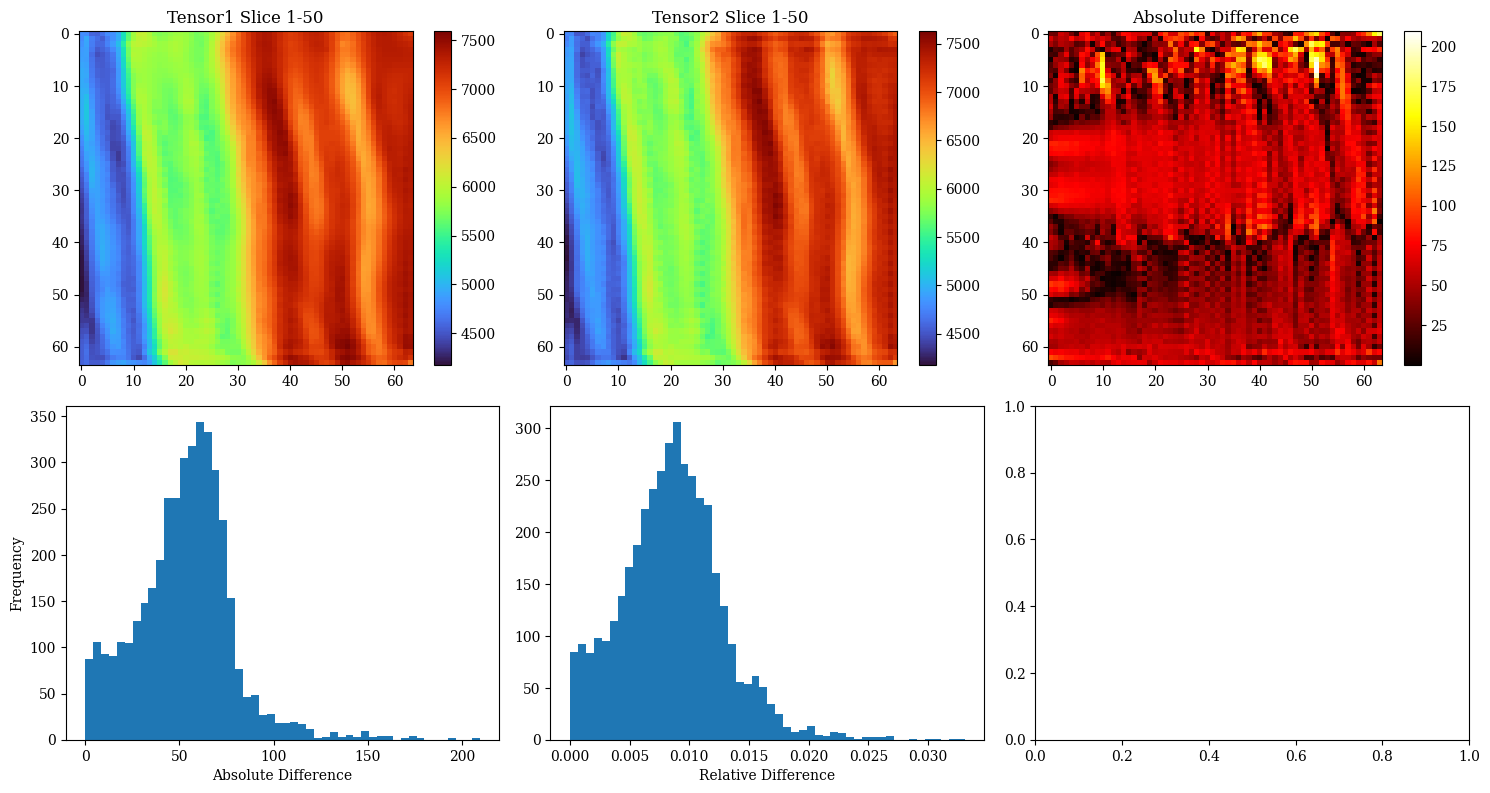

{'max_abs': 209.4072265625, 'mean_abs': 53.05119323730469, 'rel_over_threshold': 0.968505859375}


In [ ]:
stats, fig = compare_4d_slices(pred_vp_param.detach().unsqueeze(0), pred_vp.unsqueeze(0).detach(), dim=1, index=50, save_path=f_path+'/8_to_11_重力约束下的速度体改变_更加平滑.pdf')
plt.show()
print(stats)

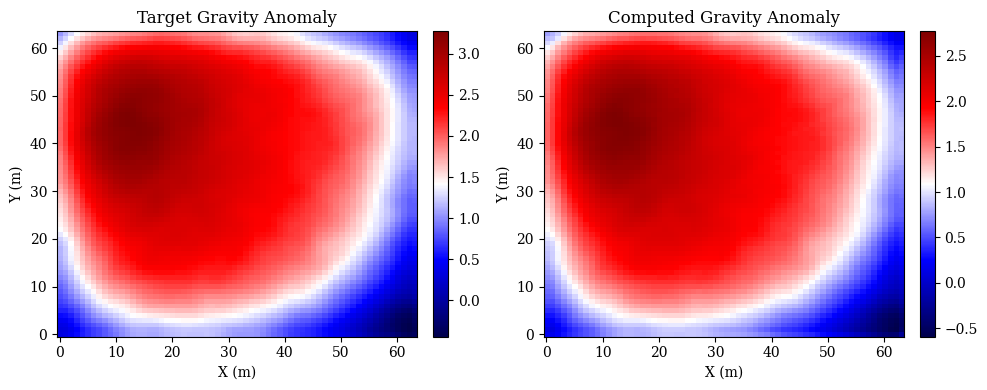

In [ ]:
#@title 比较重力物理约束的结果与"地震-速度"UNET直接预测的结果
index_attr = 1
# stats, fig = compare_4d_slices(pred_vp.detach().unsqueeze(0), pred_vp_optimized.unsqueeze(0).detach(), dim=1, index=50, save_path=f'/content/drive/MyDrive/DiTing2.0/"地震-速度"UNET&重力物理约束_{index_attr}.pdf') # 暂时保存在这里
# plt.show()
# print(stats)
# 比较重力物理约束的结果与真实速度模型
# stats, fig = compare_4d_slices(pred_vp_optimized.unsqueeze(0).detach(), vp_case.unsqueeze(0).detach(), dim=1, index=50, save_path=f'/content/drive/MyDrive/DiTing2.0/重力物理约束&真实速度_{index_attr}.pdf')
# plt.show()
# print(stats)

# 创建一个figure和两个子图
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# 第一张：目标重力异常
im0 = axs[0].imshow(gravity_target,
                    cmap='seismic',
                    origin='lower',
                    aspect='auto')
axs[0].set_title('Target Gravity Anomaly')
axs[0].set_xlabel('X (m)')
axs[0].set_ylabel('Y (m)')
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

# 第二张：计算得到的重力异常
im1 = axs[1].imshow(gravity_computed.detach().numpy(),
                    cmap='seismic',
                    origin='lower',
                    aspect='auto')
axs[1].set_title('Computed Gravity Anomaly')
axs[1].set_xlabel('X (m)')
axs[1].set_ylabel('Y (m)')
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
# plt.savefig(f'/content/drive/MyDrive/DiTing2.0/重力异常&约束重力异常_{index_attr}.pdf', format='pdf')
plt.savefig(f'/content/drive/MyDrive/DiTing2.0/重力异常&约束重力异常_8_to_11.pdf', format='pdf')
plt.show()

In [ ]:
#@title 多物理场下的速度密度反演-语义分割端到端物理约束

# ----------- 优化参数设置 -----------
miu_min, miu_max = 3000, 6000   # 速度物理范围
sigma_min, sigma_max = 20, 100  # 方差物理范围
lambda_miu = 0.1                # miu范围正则权重
lambda_sigma = 0.1              # sigma范围正则权重
lambda_edge = 0.01              # 边缘惩罚
lambda_region = 0.001           # 区域数惩罚
lambda_sigma_min = 0.01         # sigma最小值惩罚

# ----------- 主循环 -----------
# 1. 用一帧初始化参数
edge_map = sobel3d_edge_5x5(seismic)
edge_mask = get_mask(edge_map, thresh=0.15)
vp, region_ids, miu_list, sigma_list = assign_vp_by_region(edge_mask, seismic.shape)

# 2. 包装为 ParameterList（可选，视 assign_vp_by_region 返回类型而定）
if not isinstance(miu_list, torch.nn.ParameterList):
    miu_list = torch.nn.ParameterList([miu_list])
if not isinstance(sigma_list, torch.nn.ParameterList):
    sigma_list = torch.nn.ParameterList([sigma_list])

# 3. 初始化优化器
params = list(miu_list.parameters()) + list(sigma_list.parameters())
optimizer = torch.optim.Adam(params, lr=1e-2)
# optimizer = torch.optim.Adam([miu_list, sigma_list], lr=1e-2)
num_epochs = 10
for epoch in range(num_epochs):
    # 1. 提取边缘
    edge_map = sobel3d_edge(seismic)
    edge_mask = get_mask(edge_map, thresh=0.5)

    # 2. 区域分配参数并生成vp
    vp, region_ids, miu_list, sigma_list = assign_vp_by_region(edge_mask, seismic.shape)

    # 3. 计算rho
    rho = gardner_rho(vp)

    # 4. 计算重力异常
    gravity_pred = compute_gravity_static(
        rho.cpu().numpy(),  # FFT部分用numpy实现，若有torch实现可直接用
        height=10.0,
    )
    gravity_pred = torch.tensor(gravity_pred, dtype=torch.float32)

    # 5. 主损失
    loss_physics = F.mse_loss(gravity_pred, target_gravity)

    # 6. 正则项
    # miu范围正则
    loss_miu = F.relu(miu_list - miu_max).sum() + F.relu(miu_min - miu_list).sum()
    # sigma范围正则
    loss_sigma = F.relu(sigma_list - sigma_max).sum() + F.relu(sigma_min - sigma_list).sum()
    # 区域数量正则
    n_region = len(miu_list)
    loss_region = lambda_region * n_region
    # 边缘长度正则
    loss_edge = edge_map.sum() * lambda_edge
    # sigma最小值惩罚
    loss_sigma_min = lambda_sigma_min * F.relu(sigma_min - sigma_list).sum()

    # 总损失
    loss = loss_physics \
         + lambda_miu * loss_miu \
         + lambda_sigma * loss_sigma \
         + loss_region \
         + loss_edge \
         + loss_sigma_min

    # 反向传播与优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 日志输出
    print(f"Epoch {epoch}: Loss={loss.item():.4f}  Physics={loss_physics.item():.4f}  "
          f"miu_reg={loss_miu.item():.4f}  sigma_reg={loss_sigma.item():.4f}  "
          f"edge={loss_edge.item():.4f}  n_region={n_region}")


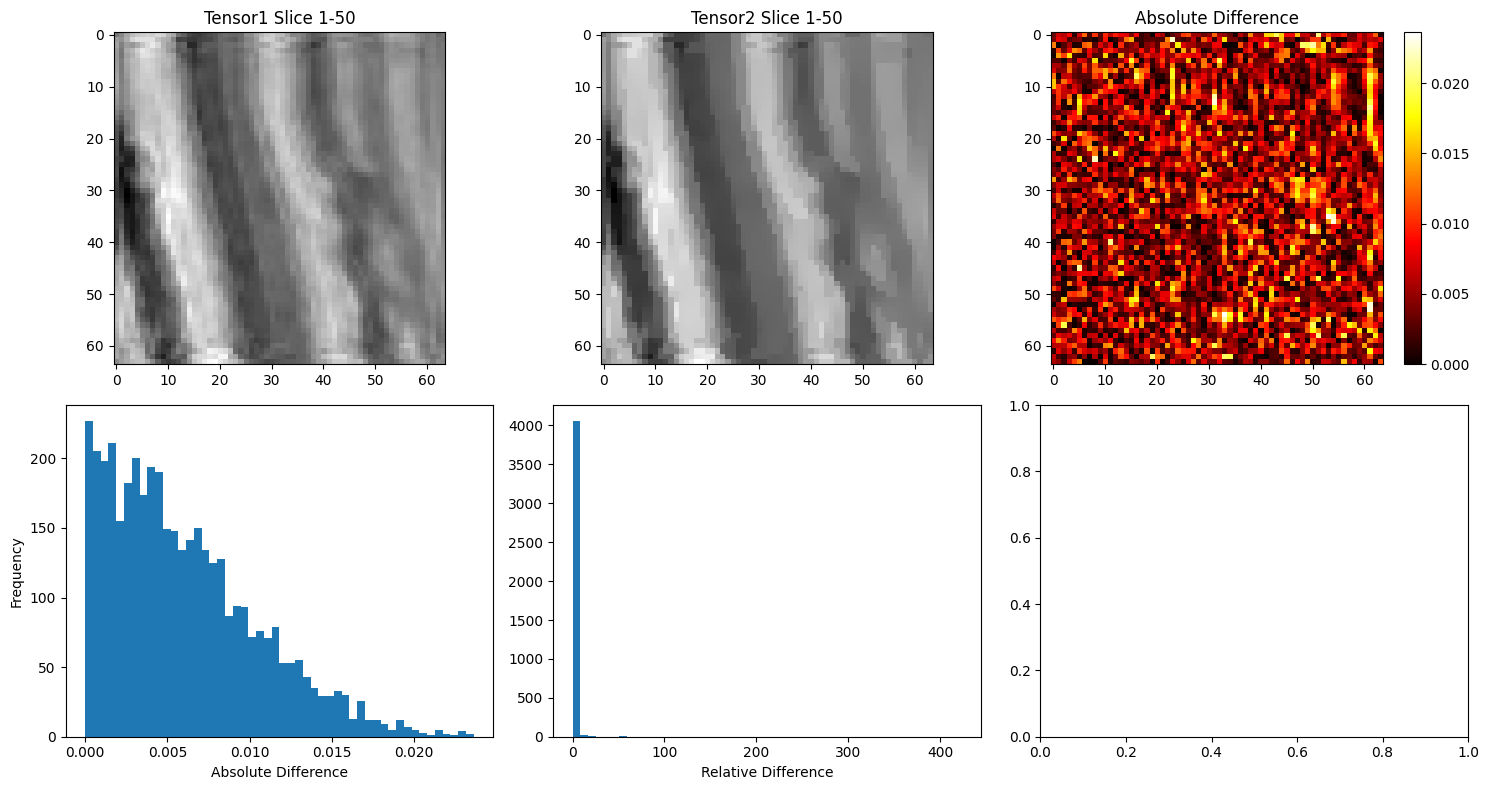

{'max_abs': 0.02363101951777935, 'mean_abs': 0.00600212998688221, 'rel_over_threshold': 0.990234375}


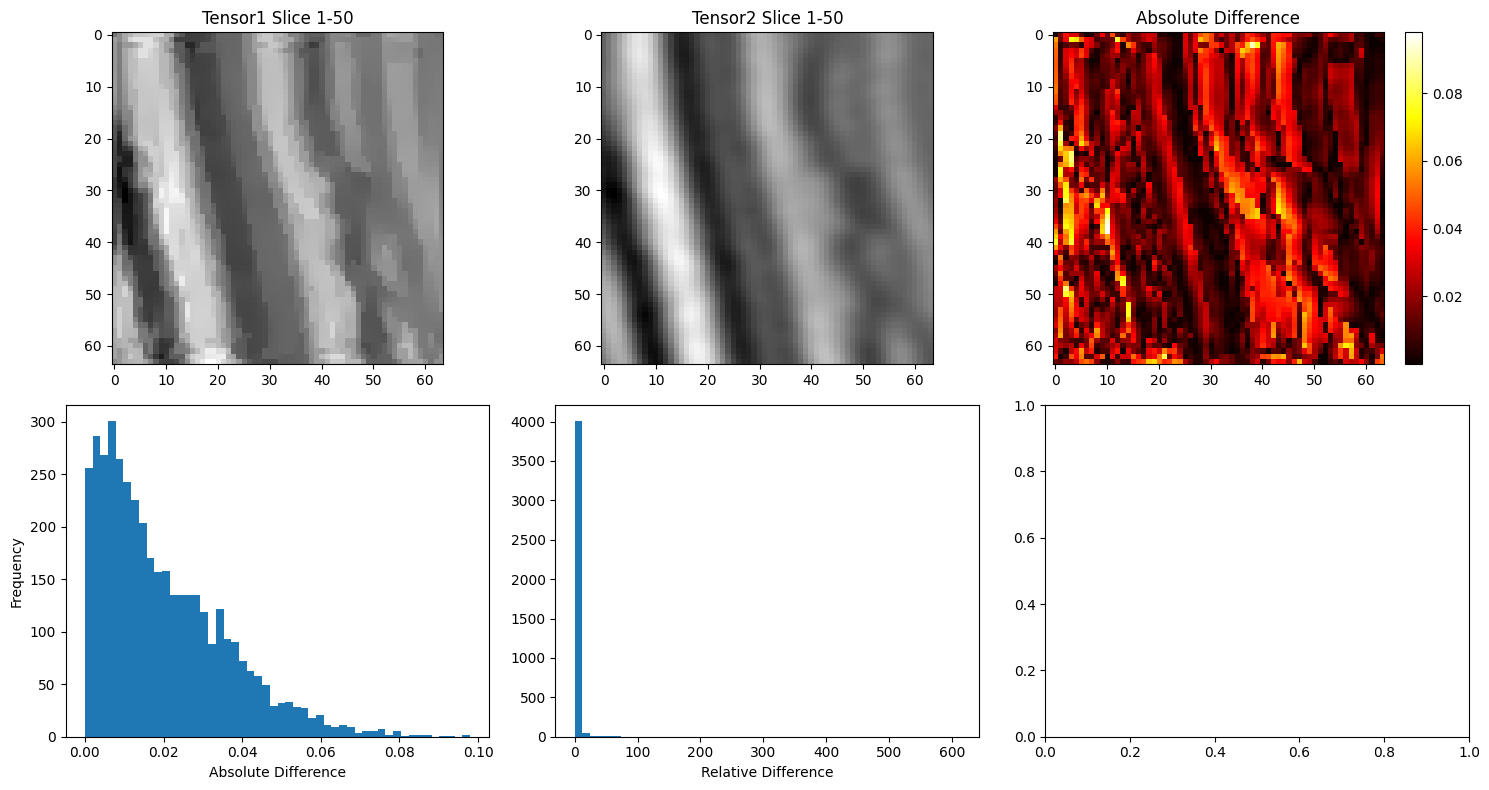

{'max_abs': 0.09799423068761826, 'mean_abs': 0.019908258691430092, 'rel_over_threshold': 0.998291015625}


In [ ]:
stats, fig = compare_4d_slices(seismic.detach()[None,...], smoothed.detach()[None,], dim=1, index=50)
plt.show()
print(stats)
stats, fig = compare_4d_slices(smoothed.detach()[None,], targets_list[0][0,t].cpu().detach()[None,], dim=1, index=50)
plt.show()
print(stats)

n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64
n=64


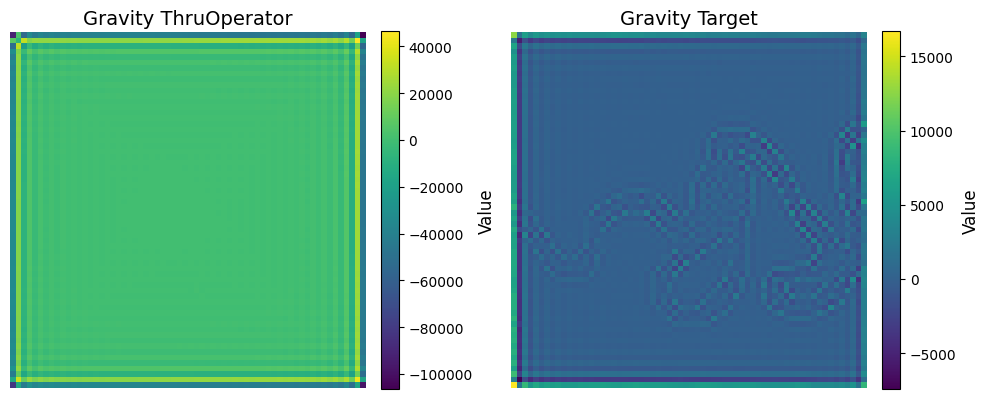

In [ ]:
#@title 多物理场下的速度密度反演-反卷积
sys.path.append('/content/drive/MyDrive/DiTing2.0/MoE')
from functions import * # 调用GeoModel
# 得到rc
# 各向异性扩散方程自适应平滑高斯噪声
def anisotropic_diffusion_3d(seismic, n_iter=10, K=0.1, lambda_=0.15):
    """
    3D各向异性扩散去噪（Perona-Malik），适合高斯噪声平滑
    seismic: (D, H, W) tensor, float32
    n_iter: 迭代次数
    K: 控制边缘敏感度的参数
    lambda_: 时间步长，建议0.1~0.25
    返回: (D, H, W) tensor
    """
    I = seismic.clone() if isinstance(seismic, torch.Tensor) else seismic
    D, H, W = I.shape

    # 6邻域差分
    def get_gradients(I):
        grads = []
        # pad在边界复制
        I_pad = F.pad(I[None, None], (1,1,1,1,1,1), mode='replicate')[0,0]
        # x方向
        grads.append(I_pad[2:,1:-1,1:-1] - I)  # 前
        grads.append(I_pad[:-2,1:-1,1:-1] - I) # 后
        # y方向
        grads.append(I_pad[1:-1,2:,1:-1] - I)  # 上
        grads.append(I_pad[1:-1,:-2,1:-1] - I) # 下
        # z方向
        grads.append(I_pad[1:-1,1:-1,2:] - I)  # 右
        grads.append(I_pad[1:-1,1:-1,:-2] - I) # 左
        return grads

    for _ in range(n_iter):
        grads = get_gradients(I)
        # 计算扩散系数（这里用exp型）
        c = [torch.exp(-(g/K)**2) for g in grads]
        # 计算扩散量
        diffusion = sum([c_i * g_i for c_i, g_i in zip(c, grads)])
        # 更新
        I = I + lambda_ * diffusion

    return I

# 生成wavelet
A = 1.0 # Maximum amplitude of the wavelet.
length = 0.1 # Time duration of the wavelet (unit: s).
dt  = 0.002 # (float): Sampling time interval of the wavelet (unit: s).
t = np.arange(-length / 2, length / 2, dt, dtype=np.float32)
f_ricker = 25
wavelet = (1 - 2 * np.pi ** 2 * f_ricker ** 2 * t ** 2) * np.exp(-np.pi ** 2 * f_ricker ** 2 * t ** 2) # ricker wavelet
wavelet *= A

# 反卷积
t = 0 # 预测的四帧当中取第几帧
seismic = predictions_list[0][0,t].cpu().detach() # 神经网络预测的结果
seismic_pre = anisotropic_diffusion_3d(seismic, n_iter=20, K=0.08, lambda_=0.18)
rc_4_rho = GeoModel.seismic_to_rc(seismic_pre, wavelet,1e-2)

def rc2vp_gardner(rc, vp0, b=0.25):
    """
    根据Gardner关系和反射系数序列递推恢复Vp剖面
    rc: 1D numpy array, 反射系数序列
    vp0: float, 首层速度（假定或已知）
    b: Gardner指数，默认0.25
    返回: vp (1D numpy array, 长度为len(rc)+1)
    """
    nz = len(rc) + 1
    S = np.zeros(nz)
    vp = np.zeros(nz)
    S[0] = vp0 ** (b + 1)
    vp[0] = vp0
    for i in range(len(rc)):
        S[i+1] = S[i] * (1 + rc[i]) / (1 - rc[i])
        vp[i+1] = S[i+1] ** (1/(b + 1))
    return vp

def generate_density_model(vp, method='gardner', params=None):
    """
    根据速度体生成密度体，支持多种密度-速度关系

    Args:
        vp (np.ndarray): 三维速度体（单位：m/s）
        method (str): 密度计算方法，支持 'gardner', 'nafe_drake', 'castagna', 'lindseth'
        params (dict): 相关方法参数，见下

    Returns:
        rho (np.ndarray): 三维密度体（单位：g/cm³）
    """
    # 单位换算
    vp_kms = vp / 1000.0  # km/s

    if method == 'gardner':
        a = 0.31 if params is None or 'a' not in params else params['a']
        b = 0.25 if params is None or 'b' not in params else params['b']
        rho = a * (vp ** b)

    elif method == 'nafe_drake':
        a = 1.6612 if params is None or 'a' not in params else params['a']
        b = 0.4721 if params is None or 'b' not in params else params['b']
        c = -0.0671 if params is None or 'c' not in params else params['c']
        d = 0.0043 if params is None or 'd' not in params else params['d']
        e = -0.000106 if params is None or 'e' not in params else params['e']
        rho = a + b*vp_kms + c*(vp_kms**2) + d*(vp_kms**3) + e*(vp_kms**4)

    elif method == 'castagna':
        a = 1.36 if params is None or 'a' not in params else params['a']
        b = 0.49 if params is None or 'b' not in params else params['b']
        rho = a + b * vp_kms

    elif method == 'lindseth':
        a = 3.2 if params is None or 'a' not in params else params['a']
        b = 3.2 if params is None or 'b' not in params else params['b']
        vp_safe = np.copy(vp_kms)
        vp_safe[vp_safe < 0.1] = 0.1
        rho = a - b / vp_safe

    else:
        raise ValueError(f"未知的密度计算方法: {method}")

    # 限制密度范围在合理区间
    rho = np.clip(rho, 1.0, 5.0)
    return rho


ny, nx, nz = rc_4_rho.shape
vp0 = 3000
b = 0.25
vp_cube = np.zeros((ny, nx, nz+1), dtype=np.float32) # nz+1 递推

for i in range(ny):
    for j in range(nx):
        vp_cube[i, j, :] = rc2vp_gardner(rc_4_rho[i, j, :], vp0, b)
vp_4_rho = vp_cube[:, :, :-1]

# --- Gardner关系得到密度模型 ---
rho_4_rho = generate_density_model(vp_4_rho, method='gardner')
# 假设你已有rho_4_rho，且每个格点25m×25m×4m
gravity_ThruOperator = compute_gravity_static(
    rho_4_rho,
    height=10.0,
)
gravity_target = target_gravity_anomoly[0,t]

torch.isnan(torch.from_numpy(vp_cube)).any()
print(seismic_pre.max(), seismic_pre.min()) # tensor(0.3313) tensor(-0.2869)
print(np.max(rc_4_rho), np.min(rc_4_rho)) # 0.59560627 -0.5514526
print(rho_4_rho.max(),rho_4_rho.min()) # 4.093064 1.5583433
print(vp_cube.max(),vp_cube.min()) # 30391.166 638.566
print(gravity_target.max(),gravity_target.min())

# 转为 numpy
arr1 = gravity_ThruOperator
arr2 = gravity_target.cpu().detach().numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# 绘制第一个张量，并添加独立色条
im1 = axs[0].imshow(arr1, cmap='viridis')
axs[0].set_title('Gravity ThruOperator', fontsize=14)
axs[0].axis('off')
cbar1 = plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
cbar1.set_label('Value', fontsize=12)

# 绘制第二个张量，并添加独立色条
im2 = axs[1].imshow(arr2, cmap='viridis')
axs[1].set_title('Gravity Target', fontsize=14)
axs[1].axis('off')
cbar2 = plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
cbar2.set_label('Value', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
#@title 验证反卷积seismic能不能得到rc
import numpy as np

# 1. 建模
xmin, xmax, dx = 0, 6400, 100  # xmin: minimum x-coordinate (m); xmax: maximum x-coordinate (m); dx: cell length (m).
ymin, ymax, dy = 0, 6400, 100  # ymin: minimum y-coordinate (m); ymax: maximum y-coordinate (m); dy: cell width (m).
zmin, zmax, dz = 0, 1500, 20  # zmin: minimum z-coordinate (m); zmax: maximum z-coordinate (m); dz: cell height (m).
seed_val = 42  # Random seed value.
mute = False  # True: print less info. False: print all info.
# data generation
for i in range(1):
  # 为每个模型使用不同的种子
  current_seed = seed_val + i
  # Initialize the geomodel.
  model = GeoModel(extent=[xmin, xmax, ymin, ymax, zmin, zmax],
                  resolution=[dx, dy, dz],
                  mute=mute)

  # Assign Vp.
  model.add_vp(h_layer_range=[60, 120],  # Thickness range of each layer (m).
              fm_list=[0.3, 0.6],  # Formation boundaries depth (three formations), as a fraction of total depth.
              vp_list=[(3000, 4000), (4000, 5000), (5000, 6000)],  # Vp range in each formation (m/s).
              vp_diff=500,  # Minimum Vp difference between consecutive layers (m/s).
              vp_disturb=300,  # Standard deviation of the Vp fluctuation in each layer (m/s).
              smooth=False,  # Whether to smooth the Vp model, we will do it later.
              seed=current_seed,  # Random seed.
              mute=mute)

  # Add channels.
  model.add_meandering_channel(N=1,
                              X_pos_range=[0.2, 0.3],  # Range of channel centerline's X-coordinate which the model starts at.
                              Y_pos_range=[0.2, 0.8],  # Channel Y-coordinate range (fraction of geomodel's Y-range).
                              Z_pos_range=[0.2, 0.8],  # Channel Z-coordinate range (fraction of geomodel's Z-range).
                              strike_range=[0, 360],  # Channel strike direction range (degree, from North).
                              W_range=[200, 250],  # Channel width range used for centerline simulation (m).
                              D_range=[15, 20],  # Channel depth range used for centerline simulation (m).
                              kl_range=[40, 50],  # Migration rate constant range for centerline simulation (m/year).
                              Cf_range=[0.05, 0.06],  # Chezy's friction coefficient range for centerline simulation.
                              n_iter_range=[1000, 1500],  # Number of simulation range for centerline simulation.
                              kv=0,  # Vertical incision rate of the channel trajectory (m/year).
                              aggr=0,  # Vertical aggradation rate of the channel trajectory (m/year).
                              t_incision=None,  # Vertical incision time period.
                              t_aggradation=None,  # Vertical aggradation time period.
                              Wx_range=[300, 300],  # Channel width used to define channel geometry (m).
                              Dx_range=[15, 15],  # Channel depth used to define channel geometry (m).
                              epsilon_range = [0.5, 0.5],  # Vp contrast between channel fill and its upper layer.
                              incision_mode='random',  # Channel cross-section shape. 1: U-shaped, 2: V-shaped, 'random': U- or V-shaped.
                              seed=current_seed,
                              instance_label=False,  # Whether to make instance label.
                              mute=mute)

  # Smooth Vp and channel model.
  model.smooth(param=['vp', 'channel'], sigma=1.5)

  # Add inclination to the geomodel.
  model.add_dipping(a_range=[0.01, 0.04],  # Inclination rate in X direction (The larger the more inclined).
                    b_range=[0.01, 0.04],  # Inclination rate in Y direction.
                    seed=current_seed,
                    mute=mute)

  # Add folds to the geomodel.
  model.add_fold(N=10,  # Number of folds.
                sigma_range=[0.10, 0.15],  # Width of the folds (as a fraction of the horizontal extension of the model).
                A_range=[0.02, 0.04],  # Height of the folds (as a fraction of the vertical extension of the model).
                d_fold=3000,  # Minimum horizontal spacing of the folds (m).
                seed=current_seed,
                mute=mute)

  # Resample the geomodel.
  model.resample_z(param=['vp', 'channel'],  # Vp model and channel model.
                  z_range=(200, 1480),  # Crop models between z_range.
                  mute=mute)

  # Compute P-wave impedance.
  model.compute_Ip(rho=2.4)

  # Seismic.
  model.compute_rc(mute=mute)
  model.make_synseis(f_ricker=25,
                    mark_channel=True)

# 2. 生成与make_synseis一致的Ricker子波
f_ricker = 25
dt = 0.002
length = 0.1
A = 1.0
t = np.arange(-length/2, length/2, dt, dtype=np.float32)
wavelet = (1 - 2 * np.pi ** 2 * f_ricker ** 2 * t ** 2) * np.exp(-np.pi ** 2 * f_ricker ** 2 * t ** 2)
wavelet *= A

# 3. 反卷积恢复rc
smoothed_seismic = anisotropic_diffusion_3d(torch.from_numpy(model.seismic), n_iter=20, K=0.08, lambda_=0.18)
rc_est = GeoModel.seismic_to_rc(smoothed_seismic, wavelet, eps=1e-2)

# 4. 验证效果（如对比rc_est和gm.rc）
import matplotlib.pyplot as plt
ix, iy = 5, 5  # 任意一条道
plt.plot(model.rc[ix, iy, :], label='True RC')
plt.plot(rc_est[ix, iy, :], label='Recovered RC')
plt.legend()
plt.title('RC Recovery (single trace)')
plt.show()


Model extent:
X range: 0.00m-6400.00m
Y range: 0.00m-6400.00m
Z range: 0.00m-1500.00m
Model resolution (XYZ): [100.00m x 100.00m x 20.00m]
Model points (XYZ): [64 x 64 x 75]
Generating Vp model... Done.
Simulating meandering channel [1/1]
Channel migration progress:100.00%
+--------+---------+---------+-------+-----------------+-----------+-----------+------------+---------+-----------+-----------+----------------------------------+-----------------+---------------+
| Number |  X (m)  |  Y (m)  | Z (m) | strike (degree) | width (m) | depth (m) | s_init (m) | n_bends | iteration | dt (year) | migration rate constant (m/year) | friction factor | vp_fill (m/s) |
+--------+---------+---------+-------+-----------------+-----------+-----------+------------+---------+-----------+-----------+----------------------------------+-----------------+---------------+
|   1    | 6508.08 | 2119.57 |  1100 |      230.19     |   213.75  |   16.12   |  32062.72  |    30   |    1379   |    0.10   |        

## 磁异常约束

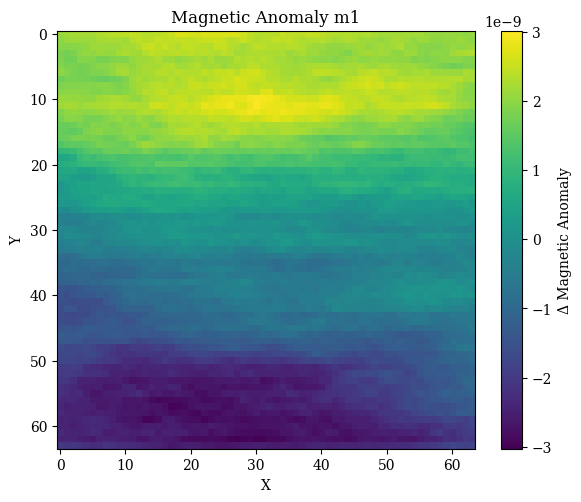

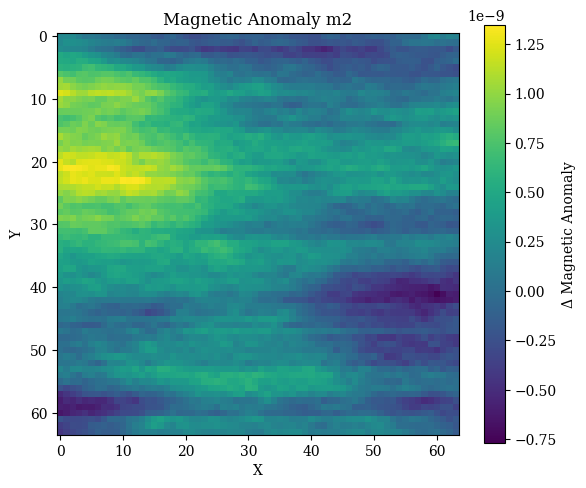

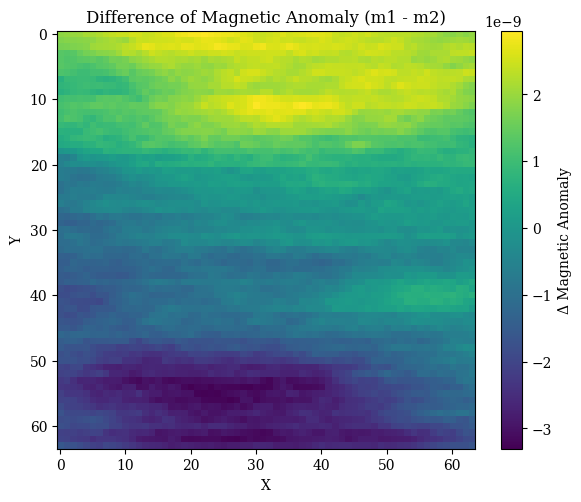

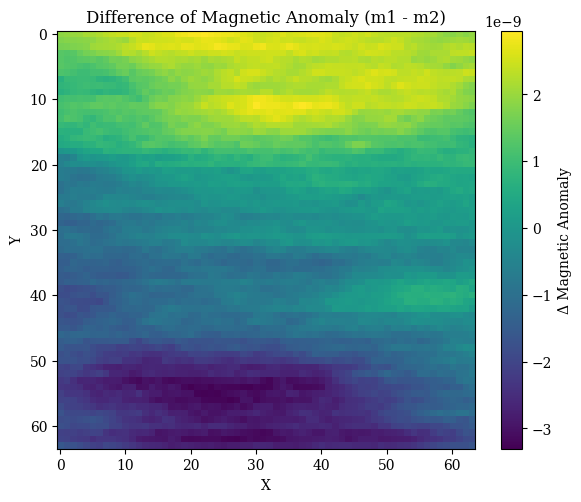

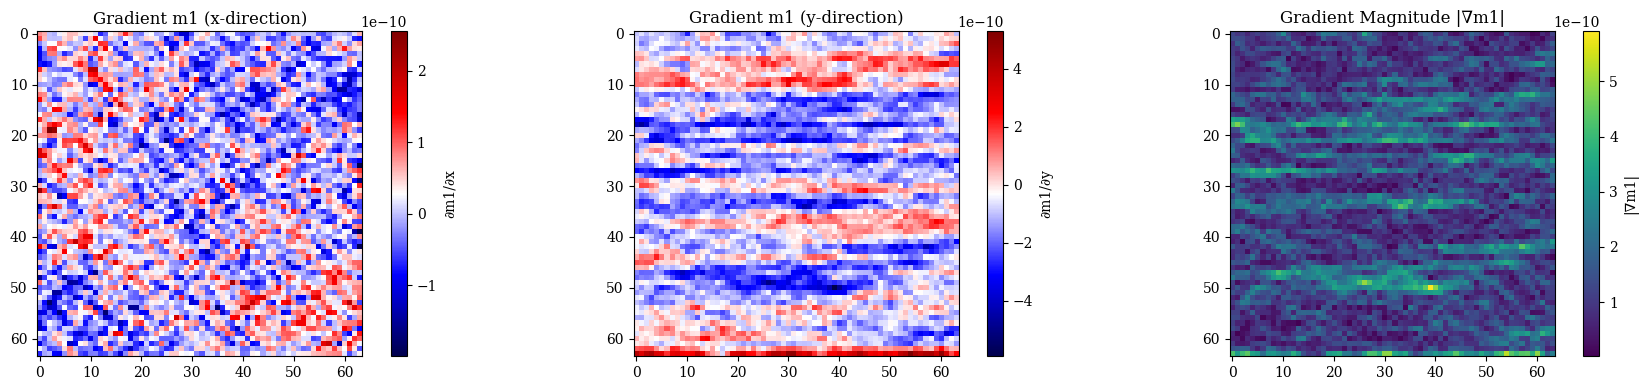

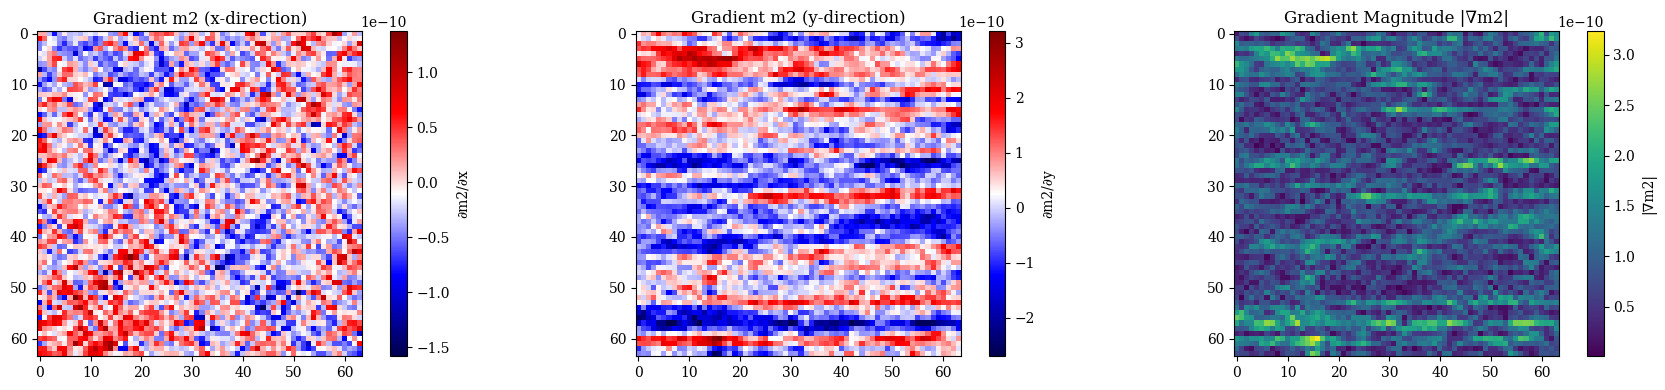

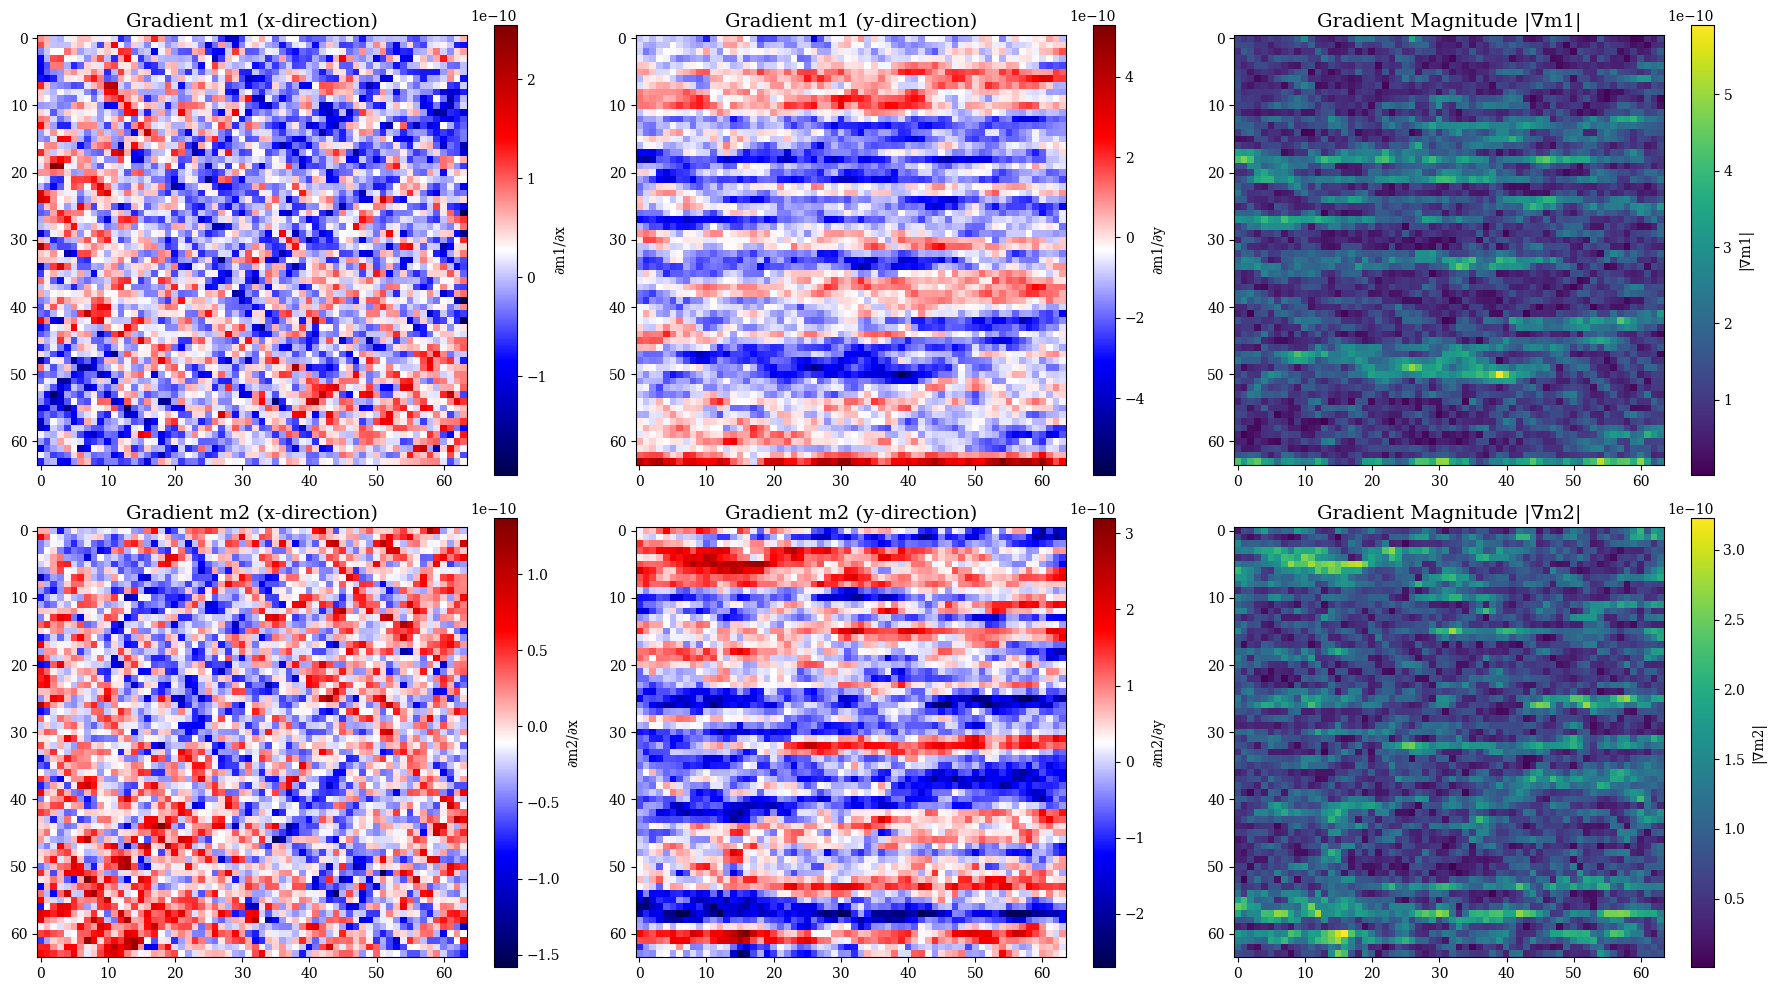

In [ ]:
#@title m1-m2
RANDOM_INDEX_1 = 0+8
RANDOM_INDEX_2 = 3+8

# 获取两组地震数据和vp（这里只用地震数据）
seismic_new_1, vp_new_1 = seismic_vp_train_pairs[RANDOM_INDEX_1]
seismic_new_2, vp_new_2 = seismic_vp_train_pairs[RANDOM_INDEX_2]

# 神经网络预测
pred_vp_1 = predict_and_denormalize(model, seismic_new_1, vp_min, vp_max, device=device) # model在前面载入
pred_vp_2 = predict_and_denormalize(model, seismic_new_2, vp_min, vp_max, device=device)

# 磁异常
magnetic_tensor_idx_1 = RANDOM_INDEX_1 // 4      # 第几个tensor
magnetic_inner_idx_1 = RANDOM_INDEX_1 % 4        # tensor中的第几个样本
magnetic_tensor_idx_2 = RANDOM_INDEX_2 // 4
magnetic_inner_idx_2 = RANDOM_INDEX_2 % 4

# 取出对应的磁异常"观测值"
m_1 = magnetic_list[magnetic_tensor_idx_1][magnetic_inner_idx_1]
m_2 = magnetic_list[magnetic_tensor_idx_2][magnetic_inner_idx_2]
delta_m = m_1 - m_2

plt.figure(figsize=(6, 5))
plt.imshow(m_1, cmap='viridis')  # 'viridis' 是科学常用配色
plt.colorbar(label='Δ Magnetic Anomaly')
plt.title('Magnetic Anomaly m1')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(m_2, cmap='viridis')  # 'viridis' 是科学常用配色
plt.colorbar(label='Δ Magnetic Anomaly')
plt.title('Magnetic Anomaly m2')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(delta_m, cmap='viridis')  # 'viridis' 是科学常用配色
plt.colorbar(label='Δ Magnetic Anomaly')
plt.title('Difference of Magnetic Anomaly (m1 - m2)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.imshow(delta_m, cmap='viridis')  # 'viridis' 是科学常用配色
plt.colorbar(label='Δ Magnetic Anomaly')
plt.title('Difference of Magnetic Anomaly (m1 - m2)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# 计算梯度
grad_m1_y, grad_m1_x = np.gradient(m_1)  # 注意：np.gradient 返回 (y, x) 方向
grad_m2_y, grad_m2_x = np.gradient(m_2)

# 梯度模（幅值）
grad_m1_mag = np.sqrt(grad_m1_x**2 + grad_m1_y**2)
grad_m2_mag = np.sqrt(grad_m2_x**2 + grad_m2_y**2)

# 可视化 m1 梯度
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.imshow(grad_m1_x, cmap='seismic')
plt.colorbar(label='∂m1/∂x')
plt.title('Gradient m1 (x-direction)')
plt.subplot(1, 3, 2)
plt.imshow(grad_m1_y, cmap='seismic')
plt.colorbar(label='∂m1/∂y')
plt.title('Gradient m1 (y-direction)')
plt.subplot(1, 3, 3)
plt.imshow(grad_m1_mag, cmap='viridis')
plt.colorbar(label='|∇m1|')
plt.title('Gradient Magnitude |∇m1|')
plt.tight_layout()
plt.show()

# 可视化 m2 梯度
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.imshow(grad_m2_x, cmap='seismic')
plt.colorbar(label='∂m2/∂x')
plt.title('Gradient m2 (x-direction)')
plt.subplot(1, 3, 2)
plt.imshow(grad_m2_y, cmap='seismic')
plt.colorbar(label='∂m2/∂y')
plt.title('Gradient m2 (y-direction)')
plt.subplot(1, 3, 3)
plt.imshow(grad_m2_mag, cmap='viridis')
plt.colorbar(label='|∇m2|')
plt.title('Gradient Magnitude |∇m2|')
plt.tight_layout()
plt.show()

# 创建2行3列的子图
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 第一行：m1 梯度
im1 = axes[0, 0].imshow(grad_m1_x, cmap='seismic')
axes[0, 0].set_title('Gradient m1 (x-direction)', fontsize=14)
plt.colorbar(im1, ax=axes[0, 0], label='∂m1/∂x')

im2 = axes[0, 1].imshow(grad_m1_y, cmap='seismic')
axes[0, 1].set_title('Gradient m1 (y-direction)', fontsize=14)
plt.colorbar(im2, ax=axes[0, 1], label='∂m1/∂y')

im3 = axes[0, 2].imshow(grad_m1_mag, cmap='viridis')
axes[0, 2].set_title('Gradient Magnitude |∇m1|', fontsize=14)
plt.colorbar(im3, ax=axes[0, 2], label='|∇m1|')

# 第二行：m2 梯度
im4 = axes[1, 0].imshow(grad_m2_x, cmap='seismic')
axes[1, 0].set_title('Gradient m2 (x-direction)', fontsize=14)
plt.colorbar(im4, ax=axes[1, 0], label='∂m2/∂x')

im5 = axes[1, 1].imshow(grad_m2_y, cmap='seismic')
axes[1, 1].set_title('Gradient m2 (y-direction)', fontsize=14)
plt.colorbar(im5, ax=axes[1, 1], label='∂m2/∂y')

im6 = axes[1, 2].imshow(grad_m2_mag, cmap='viridis')
axes[1, 2].set_title('Gradient Magnitude |∇m2|', fontsize=14)
plt.colorbar(im6, ax=axes[1, 2], label='|∇m2|')

# 调整布局
plt.tight_layout()

# 保存为PDF
plt.savefig(f_path+'/magnetic_gradient_8_to_11.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

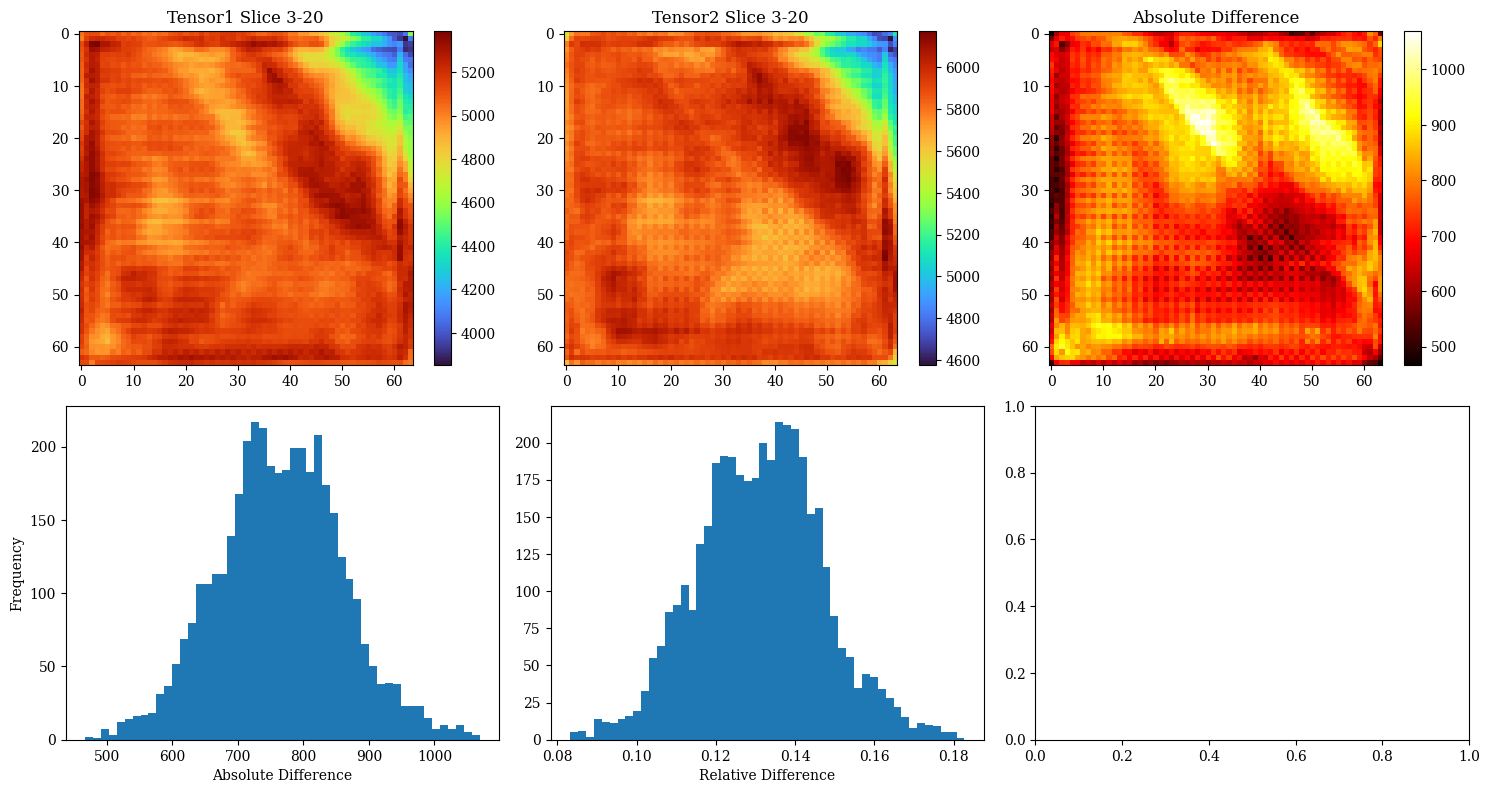

{'max_abs': 1068.908203125, 'mean_abs': 764.4561157226562, 'rel_over_threshold': 1.0}


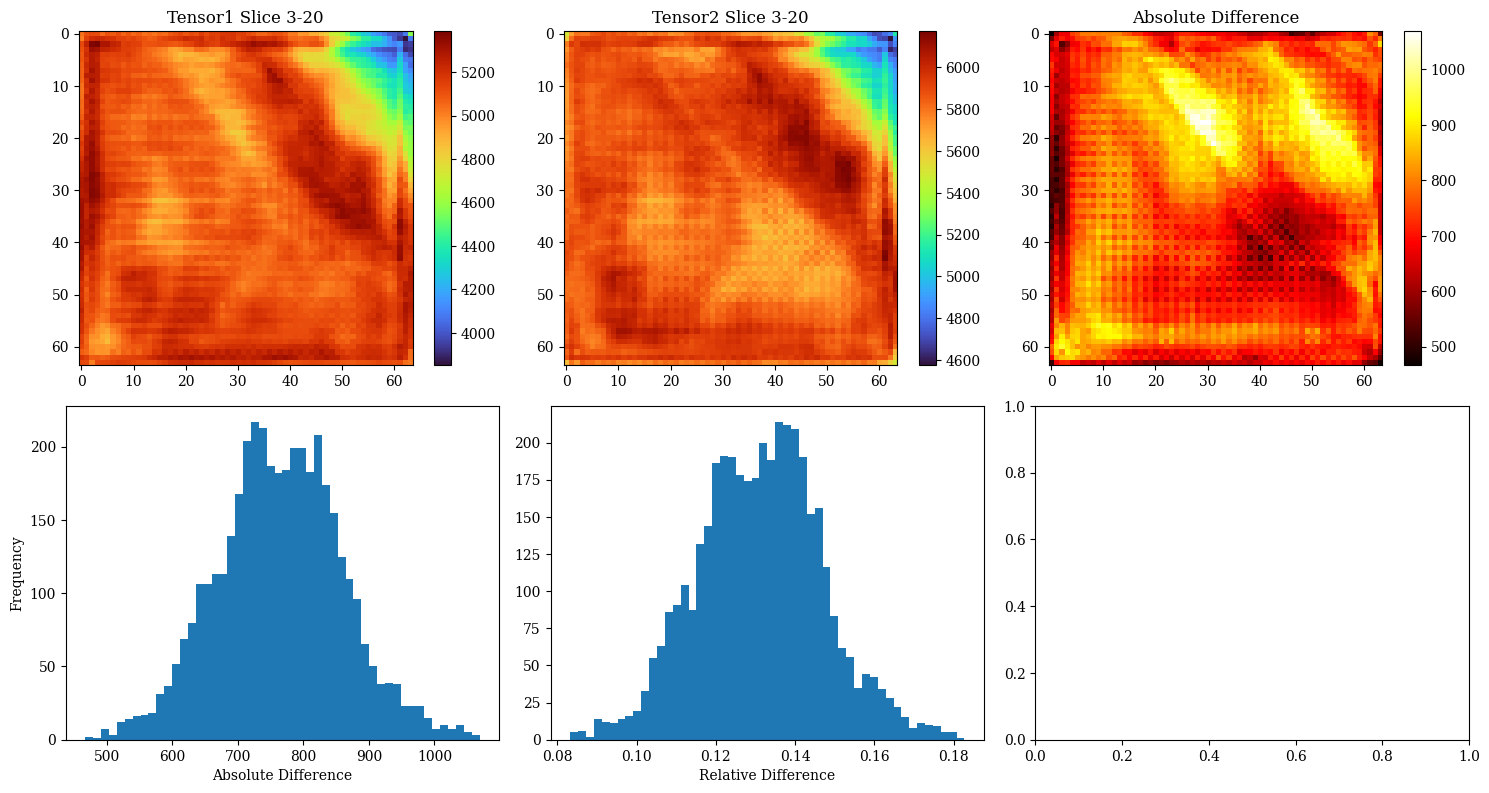

{'max_abs': 1068.908203125, 'mean_abs': 764.4561157226562, 'rel_over_threshold': 1.0}


In [ ]:
#@title 查看标签速度体的时移特性以及对神经网络输出去噪
def enhanced_anisotropic_diffusion_3d(seismic, n_iter=20, K=0.06, lambda_=0.15,
                                    edge_threshold=0.1):
    """
    增强版各向异性扩散，特别针对零星噪点

    Parameters:
    -----------
    edge_threshold: 边缘检测阈值，用于更好地保护地质结构
    """
    I = seismic.clone()
    D, H, W = I.shape

    def get_gradients(I):
        grads = []
        I_pad = F.pad(I[None, None], (1,1,1,1,1,1), mode='replicate')[0,0]

        # 计算6邻域梯度
        grads.append(I_pad[2:,1:-1,1:-1] - I)
        grads.append(I_pad[:-2,1:-1,1:-1] - I)
        grads.append(I_pad[1:-1,2:,1:-1] - I)
        grads.append(I_pad[1:-1,:-2,1:-1] - I)
        grads.append(I_pad[1:-1,1:-1,2:] - I)
        grads.append(I_pad[1:-1,1:-1,:-2] - I)

        return grads

    def adaptive_diffusion_coefficient(gradient_mag, K, edge_threshold):
        """自适应扩散系数"""
        # 对于小梯度（可能是噪声），增强扩散
        # 对于大梯度（可能是边缘），减少扩散
        c = torch.exp(-(gradient_mag/K)**2)

        # 边缘保护机制
        edge_mask = gradient_mag > edge_threshold
        c[edge_mask] *= 0.5  # 在边缘处减少扩散

        return c

    for iter_num in range(n_iter):
        grads = get_gradients(I)

        # 计算梯度幅值
        grad_mags = [torch.abs(g) for g in grads]

        # 自适应扩散系数
        c = [adaptive_diffusion_coefficient(g_mag, K, edge_threshold)
             for g_mag in grad_mags]

        # 计算扩散量
        diffusion = sum([c_i * g_i for c_i, g_i in zip(c, grads)])

        # 自适应时间步长（后期减小步长以稳定收敛）
        adaptive_lambda = lambda_ * (0.9 ** (iter_num // 5))

        # 更新
        I = I + adaptive_lambda * diffusion

    return I

pred_vp_1_sm = enhanced_anisotropic_diffusion_3d(pred_vp_1, n_iter=25, K=0.08, lambda_=0.2)
pred_vp_2_sm = enhanced_anisotropic_diffusion_3d(pred_vp_2, n_iter=25, K=0.08, lambda_=0.2)
stats, fig = compare_4d_slices(pred_vp_1_sm.cpu().detach()[None,], pred_vp_2_sm.cpu().detach()[None,], dim=3, index=20)
plt.show()
print(stats)
stats, fig = compare_4d_slices(pred_vp_1.cpu().detach()[None,], pred_vp_2.cpu().detach()[None,], dim=3, index=20)
plt.show()
print(stats)
# stats, fig = compare_4d_slices(vp_new_1.cpu().detach()[None,], vp_new_2.cpu().detach()[None,], dim=3, index=20)
# plt.show()
# print(stats)

In [ ]:
# @title 磁异常梯度特征提取
import numpy as np
import scipy.ndimage as ndi
from skimage.measure import label, regionprops

def extract_high_gradient(
    G,
    k=3.5,
    min_area=15,
    smooth_sigma=1.0,
    nms_size=3,
    morph_open_size=3,
    return_props=False
):
    """
    融合了地球物理数据处理中的稳健统计阈值（MAD）、空间一致性约束（极大值抑制+形态学开运算）和连通域面积筛选。

    参数:
        G : 2D numpy array
            输入的梯度场 (如 |∇B| 或其它属性)
        k : float
            MAD 阈值倍数（越大越保守）
        min_area : int
            连通域最小面积（像元数），小于此值的区域被剔除
        smooth_sigma : float
            预处理高斯平滑核，抑制孤立噪声
        nms_size : int
            非极大值抑制窗口（奇数，建议3或5）
        morph_open_size : int
            形态学开运算结构元大小
        return_props : bool
            是否返回每个高值带的属性信息（面积、均值等）
    返回:
        mask : 2D bool array
            高梯度带二值掩模
        threshold : float
            实际使用的阈值
        props : list (可选)
            每个高值带的属性（若 return_props=True）
    """
    # 1. 高斯平滑（降噪，提升空间一致性）
    Gs = ndi.gaussian_filter(G, sigma=smooth_sigma)

    # 2. 稳健阈值（中位数+MAD）
    med  = np.median(Gs)
    mad  = np.median(np.abs(Gs - med))
    threshold = med + k * mad
    initial_mask = Gs > threshold

    # 3. 非极大值抑制（细化脊线，去除虚假扩散）
    max_filt = ndi.maximum_filter(Gs, size=nms_size, mode='reflect')
    nms_mask = initial_mask & (Gs == max_filt)

    # 4. 形态学开运算（去除孤立点/小噪声团）
    structure = np.ones((morph_open_size, morph_open_size), dtype=bool)
    morph_mask = ndi.binary_opening(nms_mask, structure=structure)

    # 5. 连通域面积筛选（只保留足够大的异常带）
    lbl = label(morph_mask, connectivity=2)
    mask = np.zeros_like(morph_mask, dtype=bool)
    props = []
    for region in regionprops(lbl, intensity_image=Gs):
        if region.area >= min_area:
            mask[lbl == region.label] = True
            if return_props:
                props.append({
                    'label': region.label,
                    'area': region.area,
                    'mean_grad': region.mean_intensity,
                    'max_grad': region.max_intensity,
                    'bbox': region.bbox,
                    'centroid': region.centroid
                })

    if return_props:
        return mask, threshold, props
    else:
        return mask, threshold

def extract_high_gradient_gentle(
    G,
    percentile=85,  # 降低百分位数
    min_area=2,     # 大幅降低面积要求
    smooth_sigma=0.3,  # 减少平滑
    nms_size=3,
    skip_morphology=False,  # 选项：跳过形态学处理
    morph_close_first=True,  # 先闭运算再开运算
    return_props=False
):
    """更温和的高梯度提取方法"""

    # 1. 轻微平滑
    Gs = ndi.gaussian_filter(G, sigma=smooth_sigma)

    # 2. 百分位数阈值
    threshold = np.percentile(Gs, percentile)
    initial_mask = Gs > threshold
    print(f"使用{percentile}%分位数阈值: {threshold:.2e}")
    print(f"初始超过阈值的点数: {np.sum(initial_mask)}")

    # 3. NMS（可选择更小的窗口）
    max_filt = ndi.maximum_filter(Gs, size=nms_size, mode='reflect')
    nms_mask = initial_mask & (Gs == max_filt)
    print(f"NMS后的点数: {np.sum(nms_mask)}")

    # 4. 形态学处理（更温和的策略）
    if skip_morphology:
        final_mask = nms_mask
        print("跳过形态学处理")
    else:
        if morph_close_first:
            # 先闭运算（连接近邻点），再开运算（去噪）
            structure_close = np.ones((2, 2), dtype=bool)
            structure_open = np.ones((2, 2), dtype=bool)

            closed_mask = ndi.binary_closing(nms_mask, structure=structure_close)
            final_mask = ndi.binary_opening(closed_mask, structure=structure_open)
            print(f"闭运算后: {np.sum(closed_mask)}, 开运算后: {np.sum(final_mask)}")
        else:
            # 只做很小的开运算
            structure = np.ones((2, 2), dtype=bool)
            final_mask = ndi.binary_opening(nms_mask, structure=structure)
            print(f"形态学开运算后: {np.sum(final_mask)}")

    # 5. 连通域分析
    lbl = label(final_mask, connectivity=2)
    mask = np.zeros_like(final_mask, dtype=bool)
    props = []

    for region in regionprops(lbl, intensity_image=Gs):
        if region.area >= min_area:
            mask[lbl == region.label] = True
            if return_props:
                props.append({
                    'label': region.label,
                    'area': region.area,
                    'mean_grad': region.mean_intensity,
                    'max_grad': region.max_intensity,
                    'bbox': region.bbox,
                    'centroid': region.centroid
                })

    print(f"最终保留的连通域数: {len(props) if return_props else np.sum(mask > 0)}")

    if return_props:
        return mask, threshold, props
    else:
        return mask, threshold




# 1. 检查原始数据
print("=== 原始数据检查 ===")
print(f"grad_m2_mag 统计:")
print(f"  形状: {grad_m2_mag.shape}")
print(f"  最小值: {np.min(grad_m2_mag):.2e}")
print(f"  最大值: {np.max(grad_m2_mag):.2e}")
print(f"  均值: {np.mean(grad_m2_mag):.2e}")
print(f"  标准差: {np.std(grad_m2_mag):.2e}")

# 2. 检查转换后数据
scaled_data = grad_m2_mag * 1e9
print(f"\n=== 转换后数据 (×1e9) ===")
print(f"  最小值: {np.min(scaled_data):.6f}")
print(f"  最大值: {np.max(scaled_data):.6f}")
print(f"  均值: {np.mean(scaled_data):.6f}")

# 尝试几种不同的温和策略
print("\n=== 策略1: 跳过形态学处理 ===")
mask1, thresh1, props1 = extract_high_gradient_gentle(
    grad_m2_mag,
    percentile=99,
    min_area=1,  # 最小面积要求
    skip_morphology=True,
    return_props=True
)

print("\n=== 策略2: 先闭后开 ===")
mask2, thresh2, props2 = extract_high_gradient_gentle(
    grad_m2_mag,
    percentile=85,
    min_area=2,
    skip_morphology=False,
    morph_close_first=True,
    return_props=True
)

print("\n=== 策略3: 更低百分位数 ===")
mask3, thresh3, props3 = extract_high_gradient_gentle(
    grad_m2_mag,
    percentile=80,
    min_area=3,
    skip_morphology=False,
    morph_close_first=True,
    return_props=True
)

# 显示结果
for i, (props, name) in enumerate([(props1, "跳过形态学"), (props2, "先闭后开"), (props3, "低百分位数")]):
    print(f"\n{name}策略检测到 {len(props)} 个异常带:")
    for j, prop in enumerate(props[:5]):  # 只显示前5个
        print(f"  异常带{j+1}: 面积={prop['area']}, 平均梯度={prop['mean_grad']:.2e}")

# mask, threshold, properties = extract_high_gradient(
#     grad_m2_mag,           # 输入的梯度场
#     k=2,               # 阈值倍数（可根据数据调整）
#     min_area=5,         # 最小连通域面积
#     smooth_sigma=0.5,    # 平滑参数
#     nms_size=3,          # 非极大值抑制窗口
#     morph_open_size=2,   # 形态学开运算核大小
#     return_props=True    # 返回属性信息
# )

# # 查看结果
# print(f"检测到 {len(properties)} 个高梯度异常带")
# print(f"使用阈值: {threshold:.4f}")

# for i, prop in enumerate(properties):
#     print(f"异常带 {i+1}: 面积={prop['area']}, 平均梯度={prop['mean_grad']:.3f}")


=== 原始数据检查 ===
grad_m2_mag 统计:
  形状: (64, 64)
  最小值: 9.64e-13
  最大值: 3.23e-10
  均值: 8.85e-11
  标准差: 5.11e-11

=== 转换后数据 (×1e9) ===
  最小值: 0.000964
  最大值: 0.323140
  均值: 0.088493

=== 策略1: 跳过形态学处理 ===
使用99%分位数阈值: 2.39e-10
初始超过阈值的点数: 41
NMS后的点数: 19
跳过形态学处理
最终保留的连通域数: 19

=== 策略2: 先闭后开 ===
使用85%分位数阈值: 1.41e-10
初始超过阈值的点数: 615
NMS后的点数: 171
闭运算后: 182, 开运算后: 0
最终保留的连通域数: 0

=== 策略3: 更低百分位数 ===
使用80%分位数阈值: 1.28e-10
初始超过阈值的点数: 819
NMS后的点数: 207
闭运算后: 222, 开运算后: 0
最终保留的连通域数: 0

跳过形态学策略检测到 19 个异常带:
  异常带1: 面积=1.0, 平均梯度=2.65e-10
  异常带2: 面积=1.0, 平均梯度=2.70e-10
  异常带3: 面积=1.0, 平均梯度=2.78e-10
  异常带4: 面积=1.0, 平均梯度=2.67e-10
  异常带5: 面积=1.0, 平均梯度=2.93e-10

先闭后开策略检测到 0 个异常带:

低百分位数策略检测到 0 个异常带:


Generating comprehensive visualization...


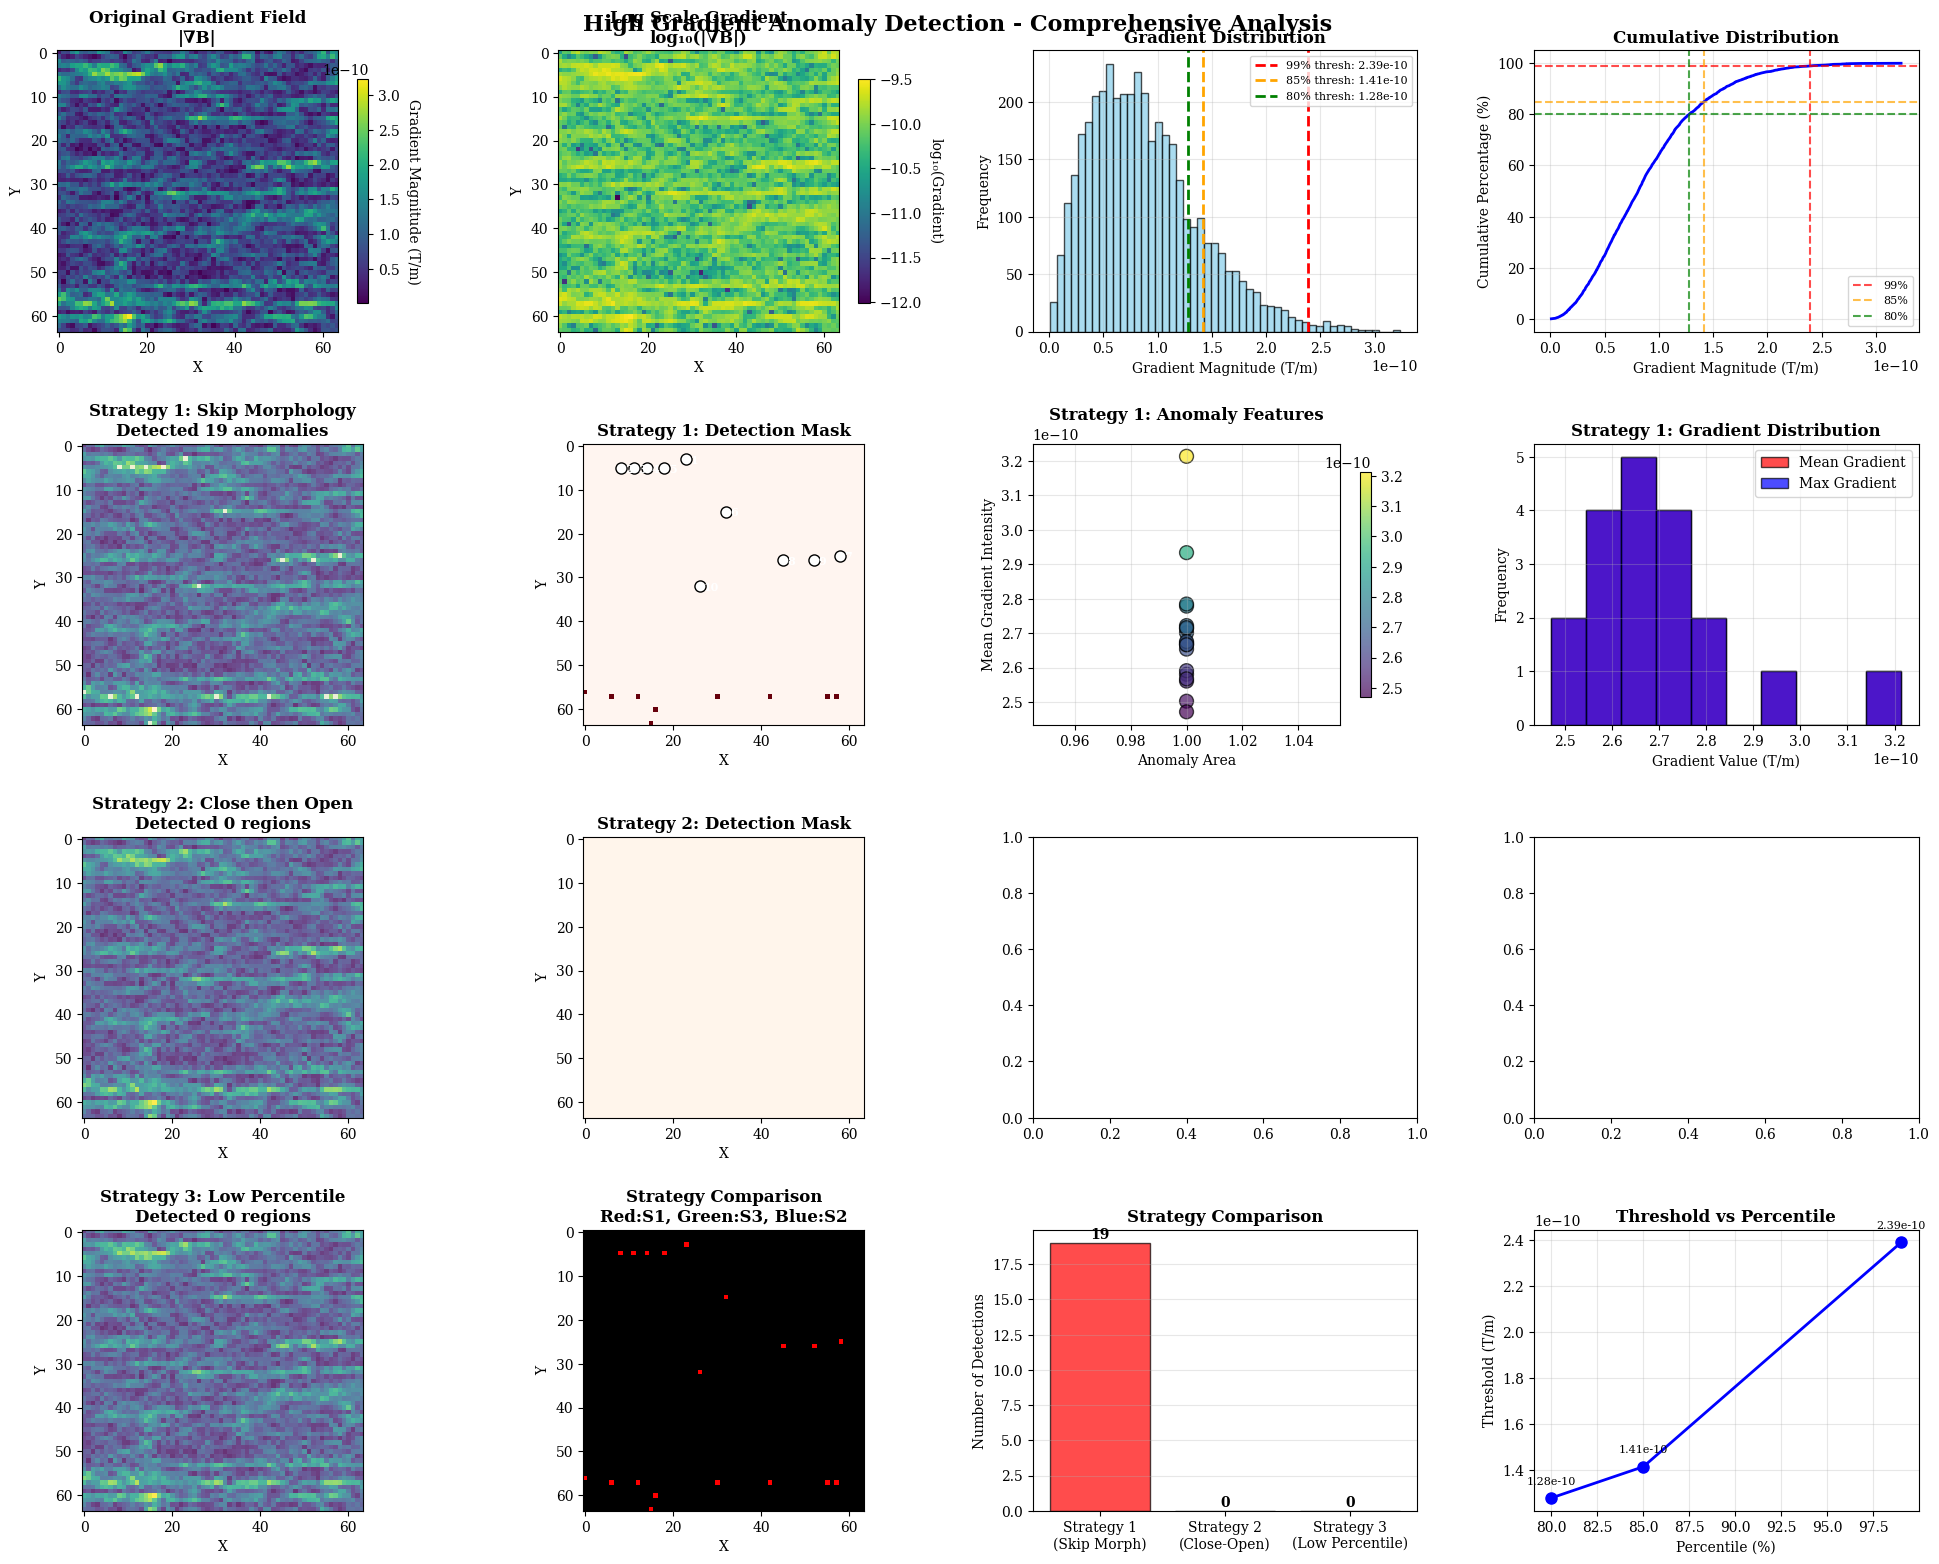


Generating simple comparison...


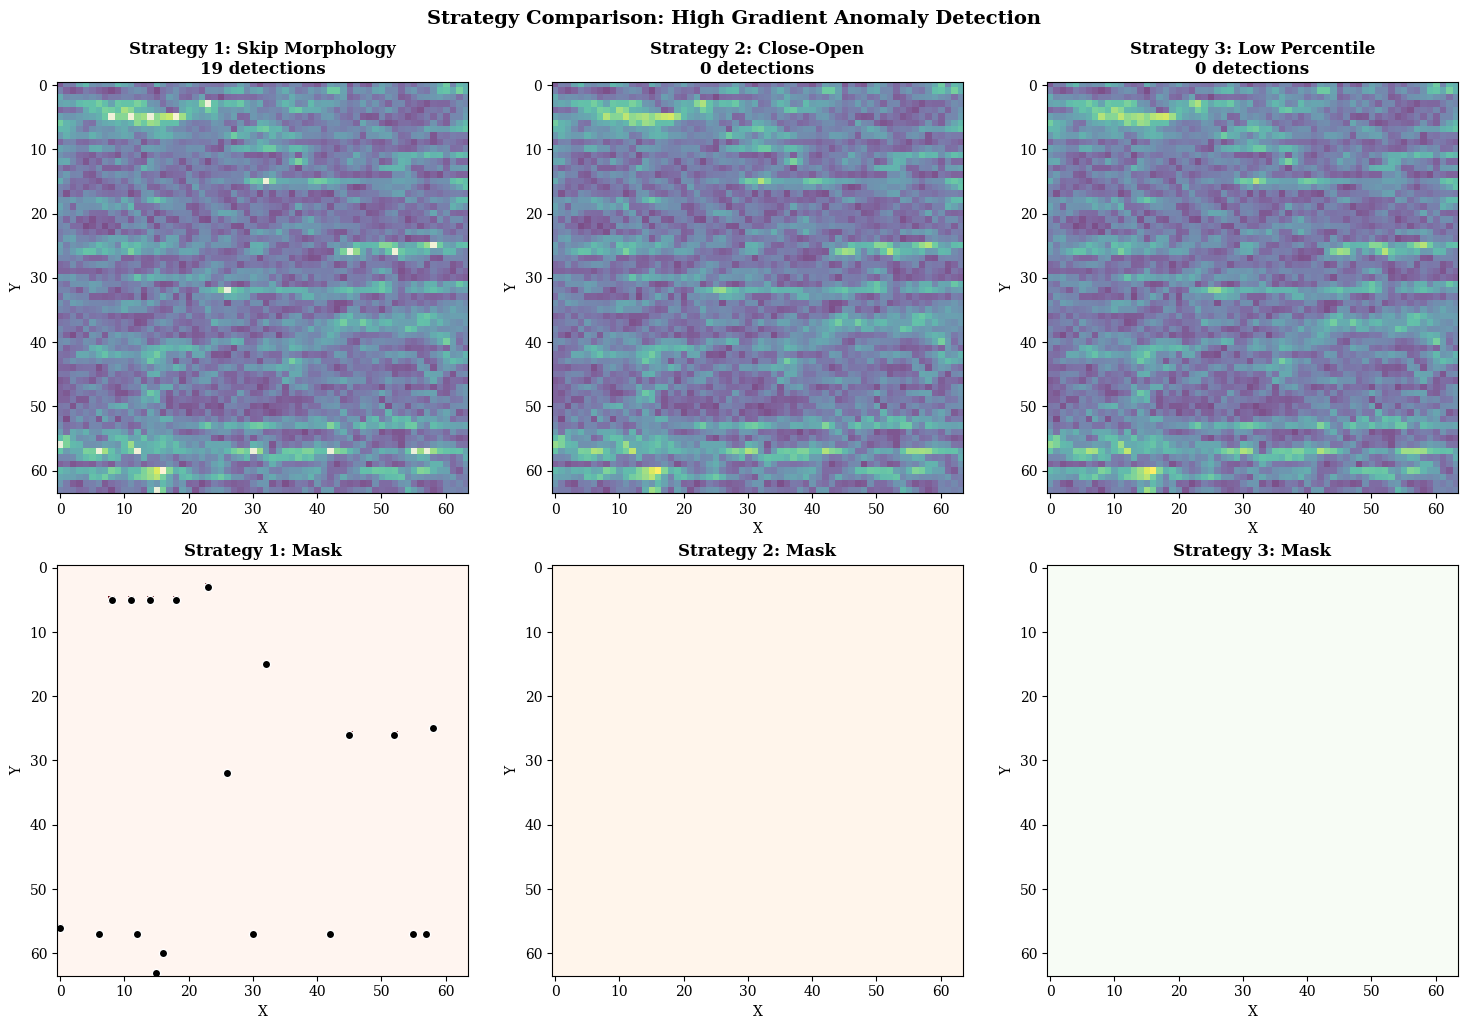


DETAILED ANOMALY ANALYSIS REPORT

【Strategy 1: Skip Morphology】
Number of detected anomalies: 19
Area statistics: min=1.0, max=1.0, mean=1.0
Mean gradient: min=2.47e-10, max=3.21e-10
Max gradient: min=2.47e-10, max=3.21e-10
Detailed anomaly list:
  Anomaly 1: position=(3.0, 23.0), area=1.0, mean_grad=2.65e-10
  Anomaly 2: position=(5.0, 8.0), area=1.0, mean_grad=2.70e-10
  Anomaly 3: position=(5.0, 11.0), area=1.0, mean_grad=2.78e-10
  Anomaly 4: position=(5.0, 14.0), area=1.0, mean_grad=2.67e-10
  Anomaly 5: position=(5.0, 18.0), area=1.0, mean_grad=2.93e-10
  Anomaly 6: position=(15.0, 32.0), area=1.0, mean_grad=2.72e-10
  Anomaly 7: position=(25.0, 58.0), area=1.0, mean_grad=2.71e-10
  Anomaly 8: position=(26.0, 45.0), area=1.0, mean_grad=2.58e-10
  Anomaly 9: position=(26.0, 52.0), area=1.0, mean_grad=2.72e-10
  Anomaly 10: position=(32.0, 26.0), area=1.0, mean_grad=2.50e-10
  Anomaly 11: position=(56.0, 0.0), area=1.0, mean_grad=2.47e-10
  Anomaly 12: position=(57.0, 6.0), area=1

In [ ]:
#@title 可视化磁异常提取结果
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.patches as patches

def comprehensive_visualization_en(grad_data, mask1, props1, mask2, props2, mask3, props3,
                                 thresh1, thresh2, thresh3):
    """
    Comprehensive visualization of high gradient detection results (English version)
    """

    # Set font parameters
    plt.rcParams['font.size'] = 10

    # Create main figure
    fig = plt.figure(figsize=(20, 16))

    # ===== Row 1: Original Data Analysis =====

    # 1.1 Original gradient data
    ax1 = plt.subplot(4, 4, 1)
    im1 = ax1.imshow(grad_data, cmap='viridis', aspect='equal')
    ax1.set_title('Original Gradient Field\n|∇B|', fontweight='bold')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Gradient Magnitude (T/m)', rotation=270, labelpad=15)

    # 1.2 Log scale display
    ax2 = plt.subplot(4, 4, 2)
    log_data = np.log10(grad_data + 1e-15)  # Avoid log(0)
    im2 = ax2.imshow(log_data, cmap='viridis', aspect='equal')
    ax2.set_title('Log Scale Gradient\nlog₁₀(|∇B|)', fontweight='bold')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8)
    cbar2.set_label('log₁₀(Gradient)', rotation=270, labelpad=15)

    # 1.3 Data distribution histogram
    ax3 = plt.subplot(4, 4, 3)
    ax3.hist(grad_data.flatten(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax3.axvline(thresh1, color='red', linestyle='--', linewidth=2, label=f'99% thresh: {thresh1:.2e}')
    ax3.axvline(thresh2, color='orange', linestyle='--', linewidth=2, label=f'85% thresh: {thresh2:.2e}')
    ax3.axvline(thresh3, color='green', linestyle='--', linewidth=2, label=f'80% thresh: {thresh3:.2e}')
    ax3.set_xlabel('Gradient Magnitude (T/m)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Gradient Distribution', fontweight='bold')
    ax3.legend(fontsize=8)
    ax3.grid(True, alpha=0.3)

    # 1.4 Cumulative distribution function
    ax4 = plt.subplot(4, 4, 4)
    sorted_data = np.sort(grad_data.flatten())
    cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100
    ax4.plot(sorted_data, cumulative, 'b-', linewidth=2)
    ax4.axhline(99, color='red', linestyle='--', alpha=0.7, label='99%')
    ax4.axhline(85, color='orange', linestyle='--', alpha=0.7, label='85%')
    ax4.axhline(80, color='green', linestyle='--', alpha=0.7, label='80%')
    ax4.axvline(thresh1, color='red', linestyle='--', alpha=0.7)
    ax4.axvline(thresh2, color='orange', linestyle='--', alpha=0.7)
    ax4.axvline(thresh3, color='green', linestyle='--', alpha=0.7)
    ax4.set_xlabel('Gradient Magnitude (T/m)')
    ax4.set_ylabel('Cumulative Percentage (%)')
    ax4.set_title('Cumulative Distribution', fontweight='bold')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)

    # ===== Row 2: Strategy 1 Results (Skip Morphology) =====

    # 2.1 Original data + detection overlay
    ax5 = plt.subplot(4, 4, 5)
    im5 = ax5.imshow(grad_data, cmap='viridis', aspect='equal', alpha=0.8)
    # Overlay detection results
    mask1_display = np.ma.masked_where(~mask1, mask1)
    ax5.imshow(mask1_display, cmap='Reds', alpha=0.8, aspect='equal')
    ax5.set_title(f'Strategy 1: Skip Morphology\nDetected {len(props1)} anomalies', fontweight='bold')
    ax5.set_xlabel('X')
    ax5.set_ylabel('Y')

    # 2.2 Detection mask only
    ax6 = plt.subplot(4, 4, 6)
    ax6.imshow(mask1, cmap='Reds', aspect='equal')
    ax6.set_title('Strategy 1: Detection Mask', fontweight='bold')
    ax6.set_xlabel('X')
    ax6.set_ylabel('Y')

    # Mark anomaly points
    for i, prop in enumerate(props1[:10]):  # Only mark first 10
        y, x = prop['centroid']
        ax6.plot(x, y, 'wo', markersize=8, markeredgecolor='black', markeredgewidth=1)
        ax6.text(x+1, y+1, f'{i+1}', color='white', fontweight='bold', fontsize=8)

    # 2.3 Anomaly intensity distribution
    ax7 = plt.subplot(4, 4, 7)
    if props1:
        areas = [prop['area'] for prop in props1]
        intensities = [prop['mean_grad'] for prop in props1]
        scatter = ax7.scatter(areas, intensities, c=intensities, cmap='viridis',
                            s=100, alpha=0.7, edgecolors='black')
        ax7.set_xlabel('Anomaly Area')
        ax7.set_ylabel('Mean Gradient Intensity')
        ax7.set_title('Strategy 1: Anomaly Features', fontweight='bold')
        plt.colorbar(scatter, ax=ax7, shrink=0.8)
        ax7.grid(True, alpha=0.3)

    # 2.4 Anomaly gradient value distribution
    ax8 = plt.subplot(4, 4, 8)
    if props1:
        max_grads = [prop['max_grad'] for prop in props1]
        mean_grads = [prop['mean_grad'] for prop in props1]
        ax8.hist(mean_grads, bins=10, alpha=0.7, color='red', label='Mean Gradient', edgecolor='black')
        ax8.hist(max_grads, bins=10, alpha=0.7, color='blue', label='Max Gradient', edgecolor='black')
        ax8.set_xlabel('Gradient Value (T/m)')
        ax8.set_ylabel('Frequency')
        ax8.set_title('Strategy 1: Gradient Distribution', fontweight='bold')
        ax8.legend()
        ax8.grid(True, alpha=0.3)

    # ===== Row 3: Strategy 2 Results (Close then Open) =====

    # 3.1 Original data + detection results
    ax9 = plt.subplot(4, 4, 9)
    im9 = ax9.imshow(grad_data, cmap='viridis', aspect='equal', alpha=0.8)
    mask2_display = np.ma.masked_where(~mask2, mask2)
    ax9.imshow(mask2_display, cmap='Oranges', alpha=0.8, aspect='equal')
    ax9.set_title(f'Strategy 2: Close then Open\nDetected {len(props2)} regions', fontweight='bold')
    ax9.set_xlabel('X')
    ax9.set_ylabel('Y')

    # 3.2 Detection mask + bounding boxes
    ax10 = plt.subplot(4, 4, 10)
    ax10.imshow(mask2, cmap='Oranges', aspect='equal')
    ax10.set_title('Strategy 2: Detection Mask', fontweight='bold')
    ax10.set_xlabel('X')
    ax10.set_ylabel('Y')

    # Add bounding boxes
    for i, prop in enumerate(props2):
        minr, minc, maxr, maxc = prop['bbox']
        rect = Rectangle((minc-0.5, minr-0.5), maxc-minc, maxr-minr,
                        linewidth=2, edgecolor='red', facecolor='none')
        ax10.add_patch(rect)
        # Mark center point
        y, x = prop['centroid']
        ax10.plot(x, y, 'ro', markersize=8, markeredgecolor='white', markeredgewidth=1)
        ax10.text(x+1, y+1, f'{i+1}', color='red', fontweight='bold', fontsize=10)

    # 3.3 Strategy 2 region analysis
    ax11 = plt.subplot(4, 4, 11)
    if props2:
        for i, prop in enumerate(props2):
            minr, minc, maxr, maxc = prop['bbox']
            # Extract region from original data
            region_data = grad_data[minr:maxr, minc:maxc]
            region_mask = mask2[minr:maxr, minc:maxc]

            # Show the region
            im11 = ax11.imshow(region_data, cmap='viridis', aspect='equal')
            # Overlay mask
            region_mask_display = np.ma.masked_where(~region_mask, region_mask)
            ax11.imshow(region_mask_display, cmap='Reds', alpha=0.6, aspect='equal')

        ax11.set_title('Strategy 2: Detected Region Detail', fontweight='bold')
        plt.colorbar(im11, ax=ax11, shrink=0.8)

    # 3.4 Strategy 2 statistics
    ax12 = plt.subplot(4, 4, 12)
    if props2:
        areas = [prop['area'] for prop in props2]
        mean_grads = [prop['mean_grad'] for prop in props2]
        max_grads = [prop['max_grad'] for prop in props2]

        x_pos = np.arange(len(props2))
        width = 0.35

        ax12.bar(x_pos - width/2, mean_grads, width, label='Mean Gradient', alpha=0.7, color='orange')
        ax12.bar(x_pos + width/2, max_grads, width, label='Max Gradient', alpha=0.7, color='red')

        ax12.set_xlabel('Region Index')
        ax12.set_ylabel('Gradient Value (T/m)')
        ax12.set_title('Strategy 2: Region Statistics', fontweight='bold')
        ax12.legend()
        ax12.grid(True, alpha=0.3, axis='y')

    # ===== Row 4: Strategy 3 and Comparison =====

    # 4.1 Strategy 3 results
    ax13 = plt.subplot(4, 4, 13)
    im13 = ax13.imshow(grad_data, cmap='viridis', aspect='equal', alpha=0.8)
    mask3_display = np.ma.masked_where(~mask3, mask3)
    ax13.imshow(mask3_display, cmap='Greens', alpha=0.8, aspect='equal')
    ax13.set_title(f'Strategy 3: Low Percentile\nDetected {len(props3)} regions', fontweight='bold')
    ax13.set_xlabel('X')
    ax13.set_ylabel('Y')

    # 4.2 Three strategies comparison (RGB)
    ax14 = plt.subplot(4, 4, 14)
    # Create RGB image showing three strategies
    rgb_image = np.zeros((grad_data.shape[0], grad_data.shape[1], 3))
    rgb_image[:, :, 0] = mask1.astype(float)  # Red: Strategy 1
    rgb_image[:, :, 1] = mask3.astype(float)  # Green: Strategy 3
    rgb_image[:, :, 2] = mask2.astype(float)  # Blue: Strategy 2

    ax14.imshow(rgb_image, aspect='equal')
    ax14.set_title('Strategy Comparison\nRed:S1, Green:S3, Blue:S2', fontweight='bold')
    ax14.set_xlabel('X')
    ax14.set_ylabel('Y')

    # 4.3 Strategy statistics comparison
    ax15 = plt.subplot(4, 4, 15)
    strategies = ['Strategy 1\n(Skip Morph)', 'Strategy 2\n(Close-Open)', 'Strategy 3\n(Low Percentile)']
    detection_counts = [len(props1), len(props2), len(props3)]
    colors = ['red', 'orange', 'green']

    bars = ax15.bar(strategies, detection_counts, color=colors, alpha=0.7, edgecolor='black')
    ax15.set_ylabel('Number of Detections')
    ax15.set_title('Strategy Comparison', fontweight='bold')
    ax15.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, count in zip(bars, detection_counts):
        height = bar.get_height()
        ax15.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                 f'{count}', ha='center', va='bottom', fontweight='bold')

    # 4.4 Threshold comparison
    ax16 = plt.subplot(4, 4, 16)
    thresholds = [thresh1, thresh2, thresh3]
    percentiles = [99, 85, 80]

    ax16.plot(percentiles, thresholds, 'bo-', linewidth=2, markersize=8)
    ax16.set_xlabel('Percentile (%)')
    ax16.set_ylabel('Threshold (T/m)')
    ax16.set_title('Threshold vs Percentile', fontweight='bold')
    ax16.grid(True, alpha=0.3)

    # Add value labels
    for x, y in zip(percentiles, thresholds):
        ax16.annotate(f'{y:.2e}', (x, y), textcoords="offset points",
                     xytext=(0,10), ha='center', fontsize=8)

    # Adjust layout
    plt.tight_layout(pad=2.0)

    # Add main title
    fig.suptitle('High Gradient Anomaly Detection - Comprehensive Analysis',
                fontsize=16, fontweight='bold', y=0.98)

    plt.show()

    return fig

def detailed_anomaly_analysis_en(props_list, strategy_names):
    """Detailed anomaly analysis (English version)"""

    print("\n" + "="*80)
    print("DETAILED ANOMALY ANALYSIS REPORT")
    print("="*80)

    for i, (props, name) in enumerate(zip(props_list, strategy_names)):
        print(f"\n【{name}】")
        print(f"Number of detected anomalies: {len(props)}")

        if props:
            # Statistics
            areas = [prop['area'] for prop in props]
            mean_grads = [prop['mean_grad'] for prop in props]
            max_grads = [prop['max_grad'] for prop in props]

            print(f"Area statistics: min={min(areas)}, max={max(areas)}, mean={np.mean(areas):.1f}")
            print(f"Mean gradient: min={min(mean_grads):.2e}, max={max(mean_grads):.2e}")
            print(f"Max gradient: min={min(max_grads):.2e}, max={max(max_grads):.2e}")

            # Detailed list
            print("Detailed anomaly list:")
            for j, prop in enumerate(props):
                centroid = prop['centroid']
                print(f"  Anomaly {j+1}: position=({centroid[0]:.1f}, {centroid[1]:.1f}), "
                      f"area={prop['area']}, mean_grad={prop['mean_grad']:.2e}")
        else:
            print("No anomalies detected")

# Additional function to create a simple comparison plot
def simple_comparison_plot(grad_data, mask1, mask2, mask3, props1, props2, props3):
    """Simple side-by-side comparison"""

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Top row: original data with overlays
    for i, (mask, props, title, cmap) in enumerate([
        (mask1, props1, f'Strategy 1: Skip Morphology\n{len(props1)} detections', 'Reds'),
        (mask2, props2, f'Strategy 2: Close-Open\n{len(props2)} detections', 'Oranges'),
        (mask3, props3, f'Strategy 3: Low Percentile\n{len(props3)} detections', 'Greens')
    ]):
        ax = axes[0, i]
        ax.imshow(grad_data, cmap='viridis', alpha=0.7)
        mask_display = np.ma.masked_where(~mask, mask)
        ax.imshow(mask_display, cmap=cmap, alpha=0.8)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # Bottom row: detection masks only
    for i, (mask, props, title, cmap) in enumerate([
        (mask1, props1, 'Strategy 1: Mask', 'Reds'),
        (mask2, props2, 'Strategy 2: Mask', 'Oranges'),
        (mask3, props3, 'Strategy 3: Mask', 'Greens')
    ]):
        ax = axes[1, i]
        ax.imshow(mask, cmap=cmap)
        ax.set_title(title, fontweight='bold')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

        # Add centroid markers
        for j, prop in enumerate(props):
            y, x = prop['centroid']
            ax.plot(x, y, 'ko', markersize=6, markeredgecolor='white', markeredgewidth=1)

    plt.tight_layout()
    plt.suptitle('Strategy Comparison: High Gradient Anomaly Detection',
                fontsize=14, fontweight='bold', y=1.02)
    plt.show()

    return fig

# Run visualizations
print("Generating comprehensive visualization...")
fig1 = comprehensive_visualization_en(
    grad_m2_mag, mask1, props1, mask2, props2, mask3, props3,
    thresh1, thresh2, thresh3
)

print("\nGenerating simple comparison...")
fig2 = simple_comparison_plot(grad_m2_mag, mask1, mask2, mask3, props1, props2, props3)

# Detailed analysis
detailed_anomaly_analysis_en(
    [props1, props2, props3],
    ["Strategy 1: Skip Morphology", "Strategy 2: Close-Open", "Strategy 3: Low Percentile"]
)

# Save figures (optional)
fig1.savefig(f_path+'/comprehensive_gradient_analysis_8_to_11.pdf', dpi=300, bbox_inches='tight')
fig2.savefig(f_path+'/simple_strategy_comparison_8_to_11.pdf', dpi=300, bbox_inches='tight')
print("Figures saved successfully!")



Testing multiple detection methods...

TESTING METHOD: DIFFERENCE

--- Sensitivity: 0.01 ---
Using method: difference
Analyzing 19 anomaly positions...
Data statistics:
  vp_t1 range: [3486.275879, 6838.245605]
  vp_t2 range: [3924.794434, 7748.456543]
  Difference range: [196.956055, 1576.757324]
Anomaly score statistics:
  Mean: 779.217362
  Std: 165.976330
  Range: [353.082031, 1244.483398]
  Threshold (sensitivity=0.01): 1135.323779
Detected 13 anomalies

--- Sensitivity: 0.02 ---
Using method: difference
Analyzing 19 anomaly positions...
Data statistics:
  vp_t1 range: [3486.275879, 6838.245605]
  vp_t2 range: [3924.794434, 7748.456543]
  Difference range: [196.956055, 1576.757324]
Anomaly score statistics:
  Mean: 779.217362
  Std: 165.976330
  Range: [353.082031, 1244.483398]
  Threshold (sensitivity=0.02): 1105.590820
Detected 25 anomalies

--- Sensitivity: 0.05 ---
Using method: difference
Analyzing 19 anomaly positions...
Data statistics:
  vp_t1 range: [3486.275879, 6838.245

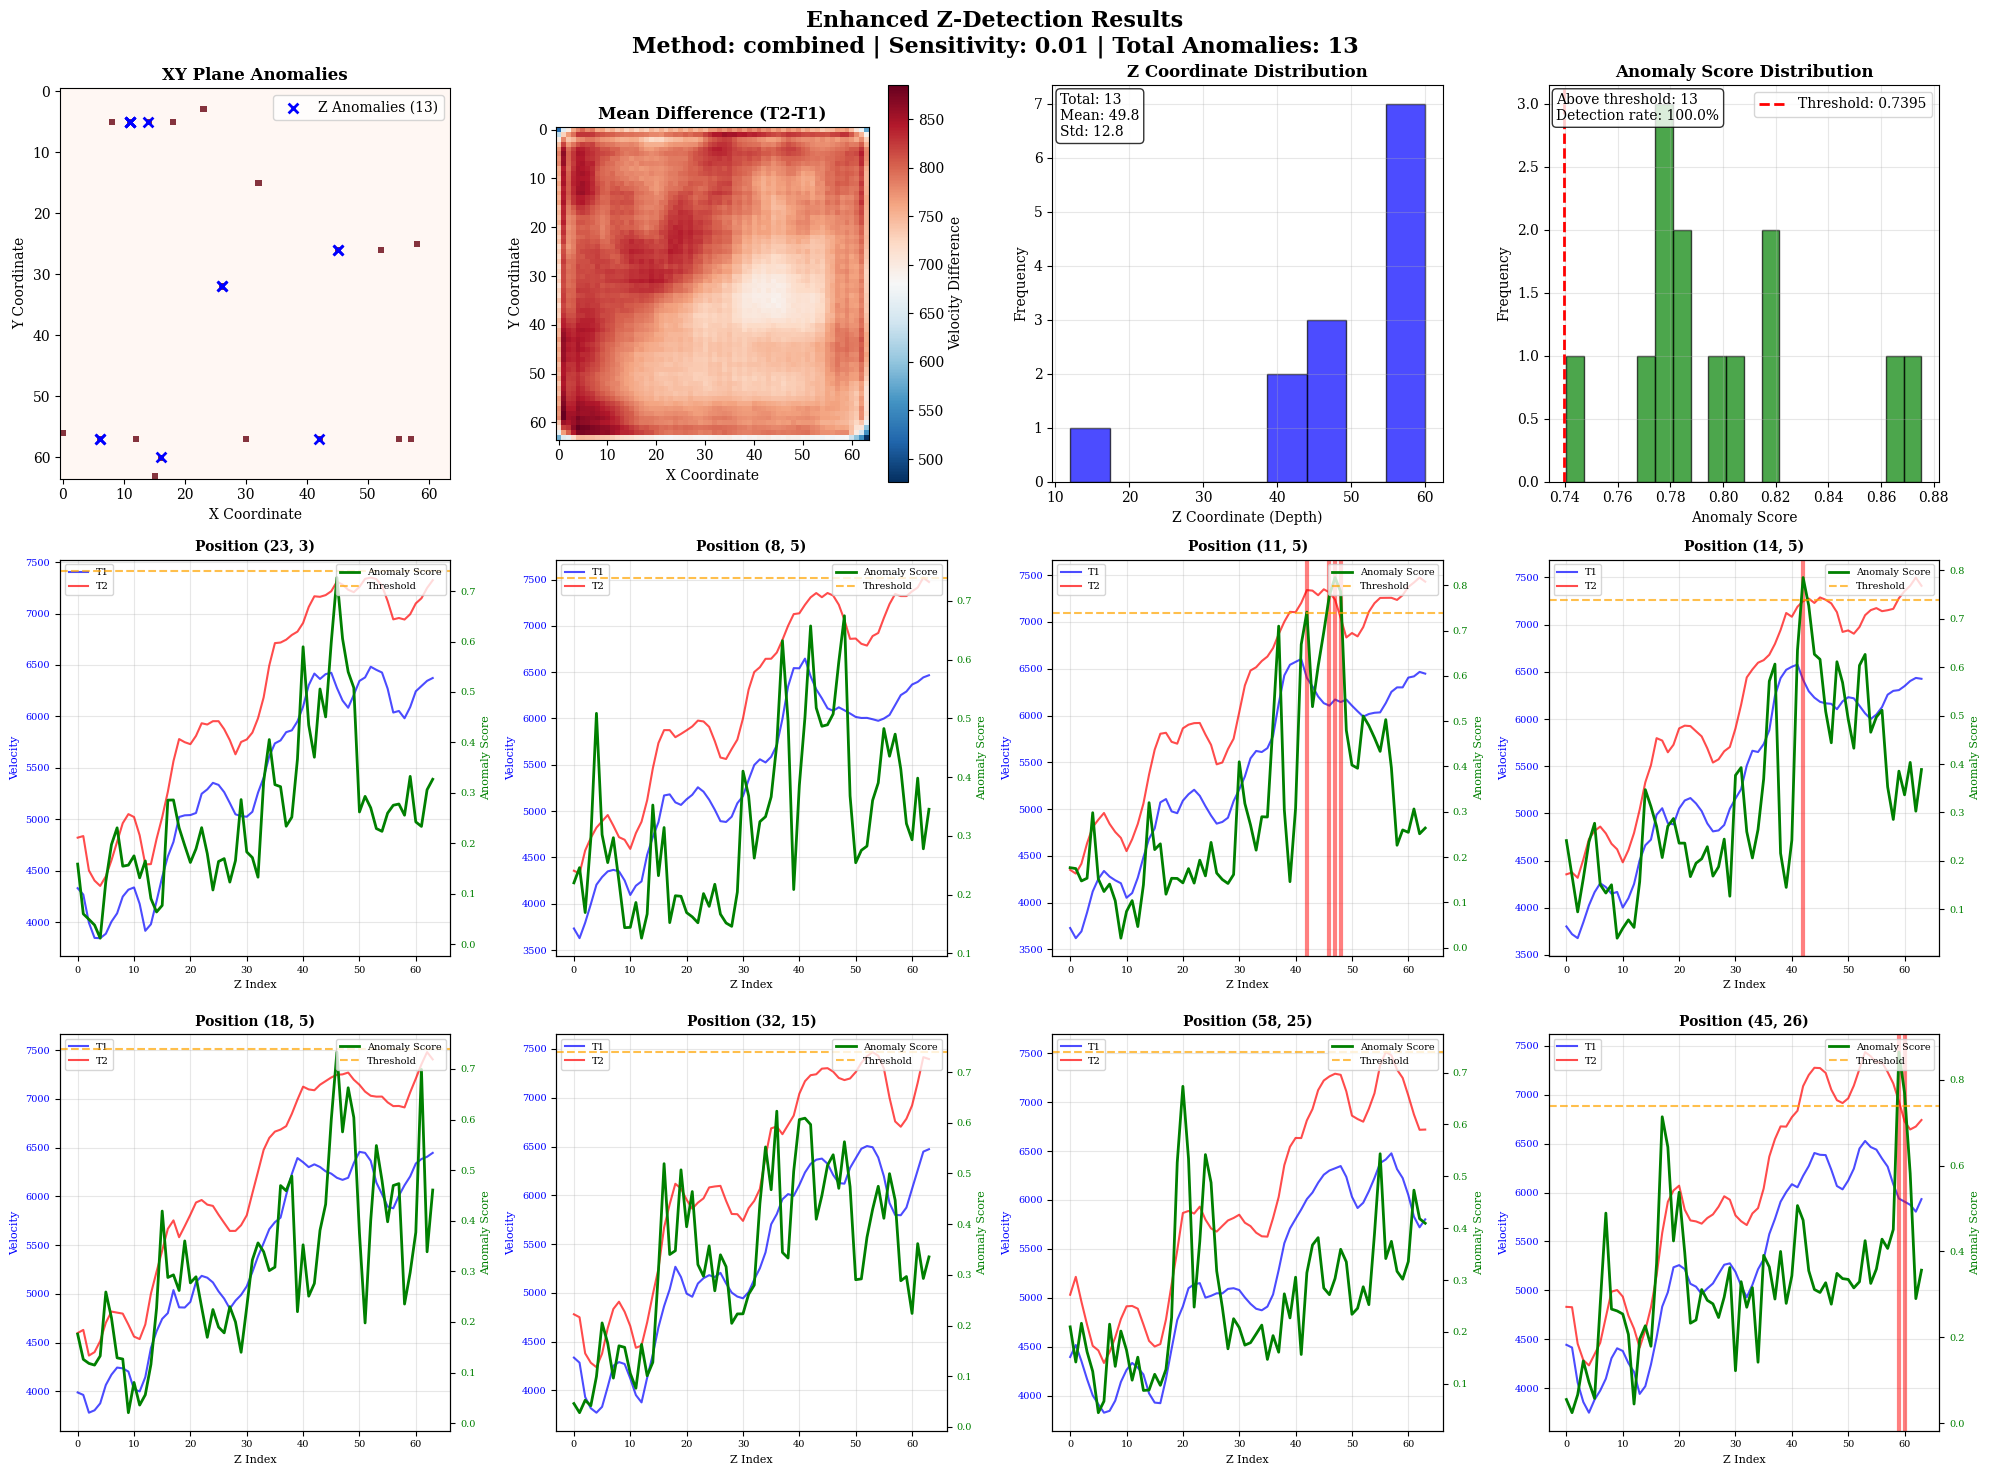

In [ ]:
#@title 确定目标层Z坐标 对比分析法 有保存！

import numpy as np
from scipy import ndimage
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import torch
from scipy.signal import correlate

def detect_z_coordinates_enhanced(vp_t1, vp_t2, xy_mask,
                                method='gradient',
                                sensitivity=0.1,
                                min_window_size=5,
                                visualization=True):
    """
    增强版Z坐标检测 - 使用多种方法

    Parameters:
    -----------
    method : str
        检测方法: 'gradient', 'difference', 'correlation', 'combined'
    sensitivity : float
        敏感度阈值
    """

    # 数据预处理
    if torch.is_tensor(vp_t1):
        vp_t1 = vp_t1.detach().cpu().numpy()
    if torch.is_tensor(vp_t2):
        vp_t2 = vp_t2.detach().cpu().numpy()
    if torch.is_tensor(xy_mask):
        xy_mask = xy_mask.detach().cpu().numpy()

    vp_t1 = np.asarray(vp_t1, dtype=np.float64)
    vp_t2 = np.asarray(vp_t2, dtype=np.float64)
    xy_mask = np.asarray(xy_mask, dtype=bool)

    # 获取异常位置
    anomaly_y, anomaly_x = np.where(xy_mask)

    if len(anomaly_x) == 0:
        return [], {}

    print(f"Using method: {method}")
    print(f"Analyzing {len(anomaly_x)} anomaly positions...")

    # 数据统计
    print(f"Data statistics:")
    print(f"  vp_t1 range: [{np.min(vp_t1):.6f}, {np.max(vp_t1):.6f}]")
    print(f"  vp_t2 range: [{np.min(vp_t2):.6f}, {np.max(vp_t2):.6f}]")
    print(f"  Difference range: [{np.min(vp_t2-vp_t1):.6f}, {np.max(vp_t2-vp_t1):.6f}]")

    anomaly_z_coords = []
    z_analysis = []
    all_anomaly_scores = []

    for i, (y, x) in enumerate(zip(anomaly_y, anomaly_x)):
        # 提取Z剖面
        z_profile_t1 = vp_t1[y, x, :].astype(np.float64)
        z_profile_t2 = vp_t2[y, x, :].astype(np.float64)

        # 计算异常分数
        if method == 'difference':
            anomaly_scores = calculate_difference_scores(z_profile_t1, z_profile_t2)
        elif method == 'gradient':
            anomaly_scores = calculate_gradient_scores(z_profile_t1, z_profile_t2)
        elif method == 'correlation':
            anomaly_scores = calculate_correlation_scores(z_profile_t1, z_profile_t2, min_window_size)
        elif method == 'combined':
            scores1 = calculate_difference_scores(z_profile_t1, z_profile_t2)
            scores2 = calculate_gradient_scores(z_profile_t1, z_profile_t2)
            scores3 = calculate_correlation_scores(z_profile_t1, z_profile_t2, min_window_size)
            # 归一化并组合
            scores1 = (scores1 - np.min(scores1)) / (np.max(scores1) - np.min(scores1) + 1e-8)
            scores2 = (scores2 - np.min(scores2)) / (np.max(scores2) - np.min(scores2) + 1e-8)
            scores3 = (scores3 - np.min(scores3)) / (np.max(scores3) - np.min(scores3) + 1e-8)
            anomaly_scores = (scores1 + scores2 + scores3) / 3
        else:
            anomaly_scores = calculate_difference_scores(z_profile_t1, z_profile_t2)

        # 存储分析结果
        position_analysis = {
            'xy_position': (x, y),
            'z_profile_t1': z_profile_t1,
            'z_profile_t2': z_profile_t2,
            'anomaly_scores': anomaly_scores,
            'z_indices': np.arange(len(anomaly_scores))
        }
        z_analysis.append(position_analysis)
        all_anomaly_scores.extend(anomaly_scores)

    # 计算全局阈值
    all_anomaly_scores = np.array(all_anomaly_scores)
    if len(all_anomaly_scores) > 0:
        threshold = np.percentile(all_anomaly_scores, (1-sensitivity)*100)

        print(f"Anomaly score statistics:")
        print(f"  Mean: {np.mean(all_anomaly_scores):.6f}")
        print(f"  Std: {np.std(all_anomaly_scores):.6f}")
        print(f"  Range: [{np.min(all_anomaly_scores):.6f}, {np.max(all_anomaly_scores):.6f}]")
        print(f"  Threshold (sensitivity={sensitivity}): {threshold:.6f}")
    else:
        threshold = 0.0

    # 检测异常Z坐标
    detailed_results = []
    for pos_analysis in z_analysis:
        x, y = pos_analysis['xy_position']
        anomaly_scores = pos_analysis['anomaly_scores']
        z_indices = pos_analysis['z_indices']

        # 找到超过阈值的位置
        anomaly_mask = anomaly_scores > threshold
        anomaly_z_positions = z_indices[anomaly_mask]

        for z_pos in anomaly_z_positions:
            anomaly_z_coords.append((x, y, z_pos))
            detailed_results.append({
                'position': (x, y, z_pos),
                'anomaly_score': anomaly_scores[z_pos],
                'score_percentile': (anomaly_scores[z_pos] / np.max(all_anomaly_scores) * 100) if np.max(all_anomaly_scores) > 0 else 0
            })

    # 整理结果
    analysis_results = {
        'method': method,
        'total_xy_positions': len(anomaly_x),
        'total_z_detections': len(anomaly_z_coords),
        'threshold': threshold,
        'sensitivity': sensitivity,
        'global_score_stats': {
            'mean': np.mean(all_anomaly_scores) if len(all_anomaly_scores) > 0 else 0,
            'std': np.std(all_anomaly_scores) if len(all_anomaly_scores) > 0 else 0,
            'min': np.min(all_anomaly_scores) if len(all_anomaly_scores) > 0 else 0,
            'max': np.max(all_anomaly_scores) if len(all_anomaly_scores) > 0 else 0
        },
        'detailed_results': detailed_results,
        'z_analysis': z_analysis
    }

    # 可视化
    if visualization:
        try:
          pdf_path = visualize_enhanced_results(
              vp_t1, vp_t2, xy_mask, anomaly_z_coords,
              analysis_results, z_analysis,
              save_pdf=True,  # 启用PDF保存
              output_dir="/content/drive/MyDrive/DiTing2.0",
              filename="磁异常确定XY_8_to_11" # 可选：自定义文件名，None则自动生成
          )
        except Exception as e:
            print(f"Visualization failed: {e}")

    return anomaly_z_coords, analysis_results

def calculate_difference_scores(z_profile_t1, z_profile_t2):
    """计算基于差值的异常分数"""
    diff = np.abs(z_profile_t2 - z_profile_t1)
    return diff

def calculate_gradient_scores(z_profile_t1, z_profile_t2):
    """计算基于梯度变化的异常分数"""
    grad_t1 = np.gradient(z_profile_t1)
    grad_t2 = np.gradient(z_profile_t2)
    grad_diff = np.abs(grad_t2 - grad_t1)
    return grad_diff

def calculate_correlation_scores(z_profile_t1, z_profile_t2, min_window_size=5):
    """计算基于局部相关性的异常分数"""
    scores = np.zeros(len(z_profile_t1))

    for i in range(len(z_profile_t1)):
        # 动态窗口大小
        window_size = min(min_window_size + i//10, len(z_profile_t1) - i)
        if window_size < 3:
            scores[i] = 0
            continue

        window_t1 = z_profile_t1[i:i+window_size]
        window_t2 = z_profile_t2[i:i+window_size]

        # 计算局部相关性
        if np.std(window_t1) > 1e-8 and np.std(window_t2) > 1e-8:
            try:
                corr, _ = pearsonr(window_t1, window_t2)
                scores[i] = 1 - abs(corr) if not np.isnan(corr) else 0
            except:
                scores[i] = 0
        else:
            scores[i] = 0

    return scores

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from datetime import datetime
import os

def visualize_enhanced_results(vp_t1, vp_t2, xy_mask, anomaly_z_coords,
                             analysis_results, z_analysis, save_pdf=True,
                             output_dir="./results", filename=None):
    """增强版可视化 - 支持PDF保存"""

    # 创建输出目录
    if save_pdf and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 生成文件名
    if filename is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        method = analysis_results.get('method', 'unknown')
        sensitivity = analysis_results.get('sensitivity', 0.1)
        filename = f"anomaly_detection_{method}_sens{sensitivity}_{timestamp}.pdf"

    if not filename.endswith('.pdf'):
        filename += '.pdf'

    full_path = os.path.join(output_dir, filename)

    # 创建图形
    fig = plt.figure(figsize=(20, 15))

    # 1. XY平面异常分布
    ax1 = plt.subplot(3, 4, 1)
    ax1.imshow(xy_mask, cmap='Reds', alpha=0.8)
    ax1.set_title('XY Plane Anomalies', fontweight='bold')
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')

    if anomaly_z_coords:
        z_x_coords = [coord[0] for coord in anomaly_z_coords]
        z_y_coords = [coord[1] for coord in anomaly_z_coords]
        ax1.scatter(z_x_coords, z_y_coords, c='blue', s=50, marker='x', linewidth=2,
                   label=f'Z Anomalies ({len(anomaly_z_coords)})')
        ax1.legend()

    # 2. 数据差异分布
    ax2 = plt.subplot(3, 4, 2)
    diff_data = vp_t2 - vp_t1
    mean_diff = np.mean(diff_data, axis=2)
    im = ax2.imshow(mean_diff, cmap='RdBu_r')
    ax2.set_title('Mean Difference (T2-T1)', fontweight='bold')
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    cbar = plt.colorbar(im, ax=ax2)
    cbar.set_label('Velocity Difference')

    # 3. Z坐标分布
    ax3 = plt.subplot(3, 4, 3)
    if anomaly_z_coords:
        z_coords = [coord[2] for coord in anomaly_z_coords]
        n, bins, patches = ax3.hist(z_coords, bins=min(20, len(set(z_coords))),
                                   alpha=0.7, color='blue', edgecolor='black')
        ax3.set_title('Z Coordinate Distribution', fontweight='bold')
        ax3.set_xlabel('Z Coordinate (Depth)')
        ax3.set_ylabel('Frequency')
        ax3.grid(True, alpha=0.3)

        # 添加统计信息
        ax3.text(0.02, 0.98, f'Total: {len(z_coords)}\nMean: {np.mean(z_coords):.1f}\nStd: {np.std(z_coords):.1f}',
                transform=ax3.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 4. 异常分数分布
    ax4 = plt.subplot(3, 4, 4)
    all_scores = []
    for result in analysis_results['detailed_results']:
        all_scores.append(result['anomaly_score'])

    if all_scores:
        n, bins, patches = ax4.hist(all_scores, bins=20, alpha=0.7, color='green',
                                   edgecolor='black')
        threshold = analysis_results['threshold']
        ax4.axvline(threshold, color='red', linestyle='--', linewidth=2,
                   label=f'Threshold: {threshold:.4f}')
        ax4.set_title('Anomaly Score Distribution', fontweight='bold')
        ax4.set_xlabel('Anomaly Score')
        ax4.set_ylabel('Frequency')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # 添加统计信息
        above_threshold = np.sum(np.array(all_scores) > threshold)
        ax4.text(0.02, 0.98, f'Above threshold: {above_threshold}\nDetection rate: {above_threshold/len(all_scores)*100:.1f}%',
                transform=ax4.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    # 5-12. 显示多个位置的详细分析
    for i in range(min(8, len(z_analysis))):
        ax = plt.subplot(3, 4, 5+i)

        pos_analysis = z_analysis[i]
        x, y = pos_analysis['xy_position']
        z_profile_t1 = pos_analysis['z_profile_t1']
        z_profile_t2 = pos_analysis['z_profile_t2']
        anomaly_scores = pos_analysis['anomaly_scores']
        z_indices = pos_analysis['z_indices']

        # 绘制原始数据和异常分数
        ax_twin = ax.twinx()

        # 左Y轴：原始数据值
        line1 = ax.plot(z_indices, z_profile_t1, 'b-', alpha=0.7, label='T1', linewidth=1.5)
        line2 = ax.plot(z_indices, z_profile_t2, 'r-', alpha=0.7, label='T2', linewidth=1.5)

        # 右Y轴：异常分数
        line3 = ax_twin.plot(z_indices, anomaly_scores, 'g-', linewidth=2, label='Anomaly Score')
        ax_twin.axhline(analysis_results['threshold'], color='orange', linestyle='--',
                       alpha=0.7, label='Threshold')

        # 标记异常点
        anomaly_z_at_pos = [coord[2] for coord in anomaly_z_coords if coord[0]==x and coord[1]==y]
        for z_pos in anomaly_z_at_pos:
            ax.axvline(z_pos, color='red', alpha=0.5, linewidth=3)

        # 设置标签和格式
        ax.set_title(f'Position ({x}, {y})', fontweight='bold', fontsize=10)
        ax.set_xlabel('Z Index', fontsize=8)
        ax.set_ylabel('Velocity', fontsize=8, color='blue')
        ax_twin.set_ylabel('Anomaly Score', fontsize=8, color='green')

        # 图例
        ax.legend(loc='upper left', fontsize=7)
        ax_twin.legend(loc='upper right', fontsize=7)

        # 网格和格式
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='both', which='major', labelsize=7)
        ax_twin.tick_params(axis='both', which='major', labelsize=7)

        # 颜色编码
        ax.tick_params(axis='y', labelcolor='blue')
        ax_twin.tick_params(axis='y', labelcolor='green')

    # 添加整体标题和信息
    method = analysis_results.get('method', 'Unknown')
    sensitivity = analysis_results.get('sensitivity', 'N/A')
    total_anomalies = len(anomaly_z_coords) if anomaly_z_coords else 0

    plt.suptitle(f'Enhanced Z-Detection Results\n'
                f'Method: {method} | Sensitivity: {sensitivity} | '
                f'Total Anomalies: {total_anomalies}',
                fontsize=16, fontweight='bold', y=0.98)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)  # 为标题留出空间

    # 保存PDF
    if save_pdf:
        try:
            plt.savefig(full_path, format='pdf', dpi=300, bbox_inches='tight',
                       facecolor='white', edgecolor='none')
            print(f"✅ PDF saved successfully: {full_path}")

            # 显示文件信息
            file_size = os.path.getsize(full_path) / (1024*1024)  # MB
            print(f"📁 File size: {file_size:.2f} MB")

        except Exception as e:
            print(f"❌ Error saving PDF: {str(e)}")

    # 显示图形
    plt.show()

    return full_path if save_pdf else None

# 测试多种方法
def test_multiple_methods(vp_new_1, vp_new_2, mask1):
    """测试多种检测方法"""

    methods = ['difference', 'gradient', 'correlation', 'combined']
    sensitivities = [0.01, 0.02, 0.05]

    results_summary = {}

    for method in methods:
        print(f"\n{'='*60}")
        print(f"TESTING METHOD: {method.upper()}")
        print(f"{'='*60}")

        method_results = {}

        for sensitivity in sensitivities:
            print(f"\n--- Sensitivity: {sensitivity} ---")

            anomaly_coords, analysis = detect_z_coordinates_enhanced(
                pred_vp_1, pred_vp_2, mask1,
                method=method,
                sensitivity=sensitivity,
                visualization=False
            )

            method_results[sensitivity] = {
                'anomaly_count': len(anomaly_coords),
                'anomaly_coords': anomaly_coords,
                'analysis': analysis
            }

            print(f"Detected {len(anomaly_coords)} anomalies")

        results_summary[method] = method_results

    # 选择最佳方法进行详细可视化
    best_method = 'combined'
    best_sensitivity = 0.01

    print(f"\n{'='*60}")
    print(f"DETAILED ANALYSIS WITH BEST METHOD")
    print(f"{'='*60}")

    final_coords, final_analysis = detect_z_coordinates_enhanced(
        pred_vp_1, pred_vp_2, mask1,
        method=best_method,
        sensitivity=best_sensitivity,
        visualization=True
    )

    return final_coords, final_analysis, results_summary

# 执行测试
print("Testing multiple detection methods...")
anomaly_3d_coords, analysis_results, method_comparison = test_multiple_methods(
    pred_vp_1, pred_vp_2, mask1
)

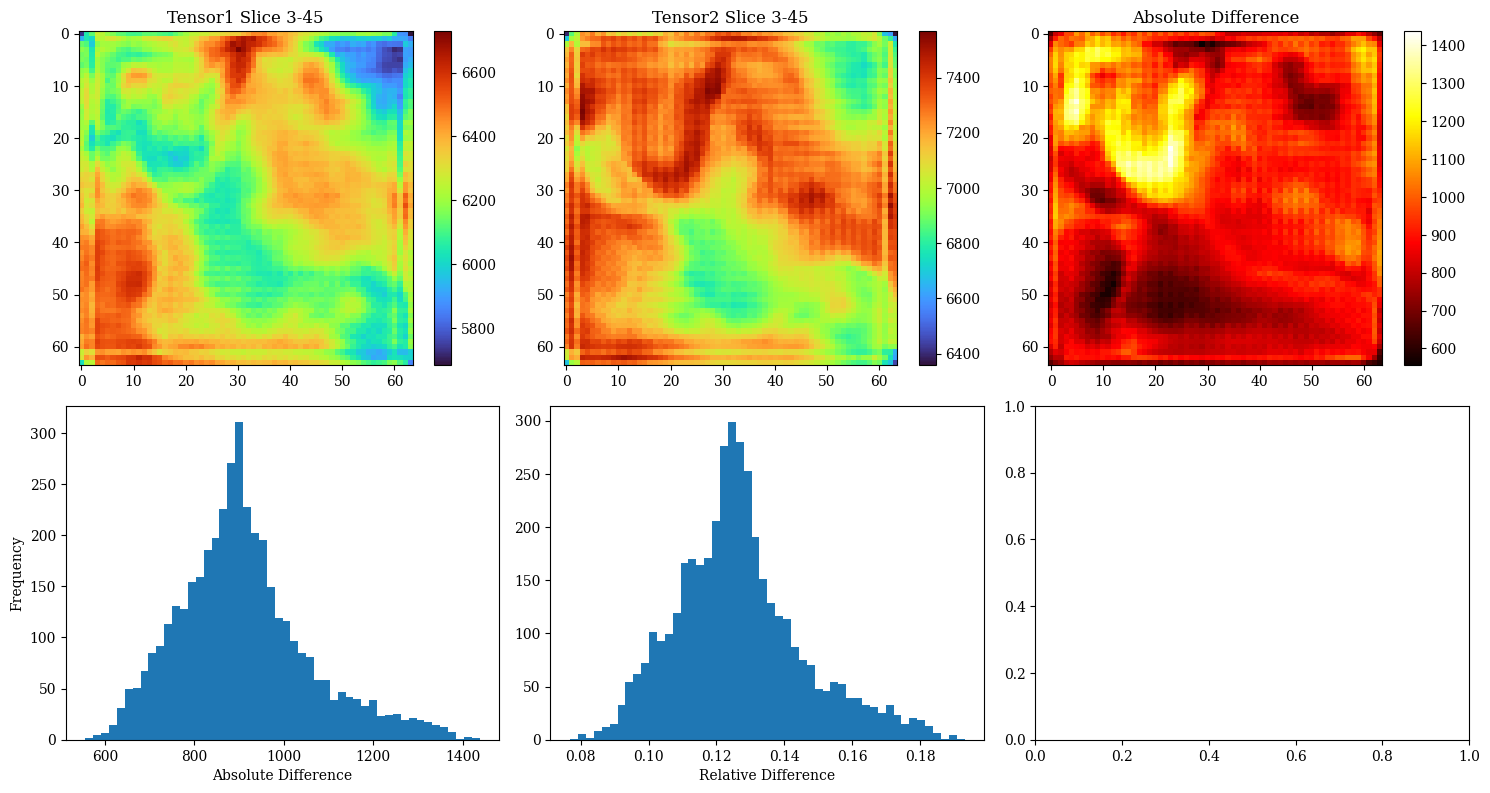

{'max_abs': 1437.6767578125, 'mean_abs': 910.186279296875, 'rel_over_threshold': 1.0}


In [ ]:
#@title 查看标签速度体的时移特性
stats, fig = compare_4d_slices(pred_vp_1.cpu().detach()[None,], pred_vp_2.cpu().detach()[None,], dim=3, index=45, save_path="/content/drive/MyDrive/DiTing2.0/磁异常确定XY背书_1_2")
plt.show()
print(stats)

Starting complete target layer detection workflow...
Parameters loaded from dictionary

Current Detection Configuration:
----------------------------------------
  cluster_distance: 2.5
  method: combined
  min_cluster_size: 3
  min_correlation_drop: 0.1
  min_window_size: 5
  save_results: True
  sensitivity: 0.1
  shift_threshold_percentile: 99
  visualization: True
  xy_min_area: 5
  xy_threshold_factor: 2.0
----------------------------------------
Starting target layer detection...
Using method: combined
Analyzing 19 anomaly positions...
Data statistics:
  vp_t1 range: [3486.275879, 6838.245605]
  vp_t2 range: [3924.794434, 7748.456543]
  Difference range: [196.956055, 1576.757324]
Anomaly score statistics:
  Mean: 0.322905
  Std: 0.149990
  Range: [0.011653, 0.875301]
  Threshold (sensitivity=0.1): 0.511117
Detected 122 raw anomaly points
Clustered into 19 groups
Generated 72 final coordinate marks


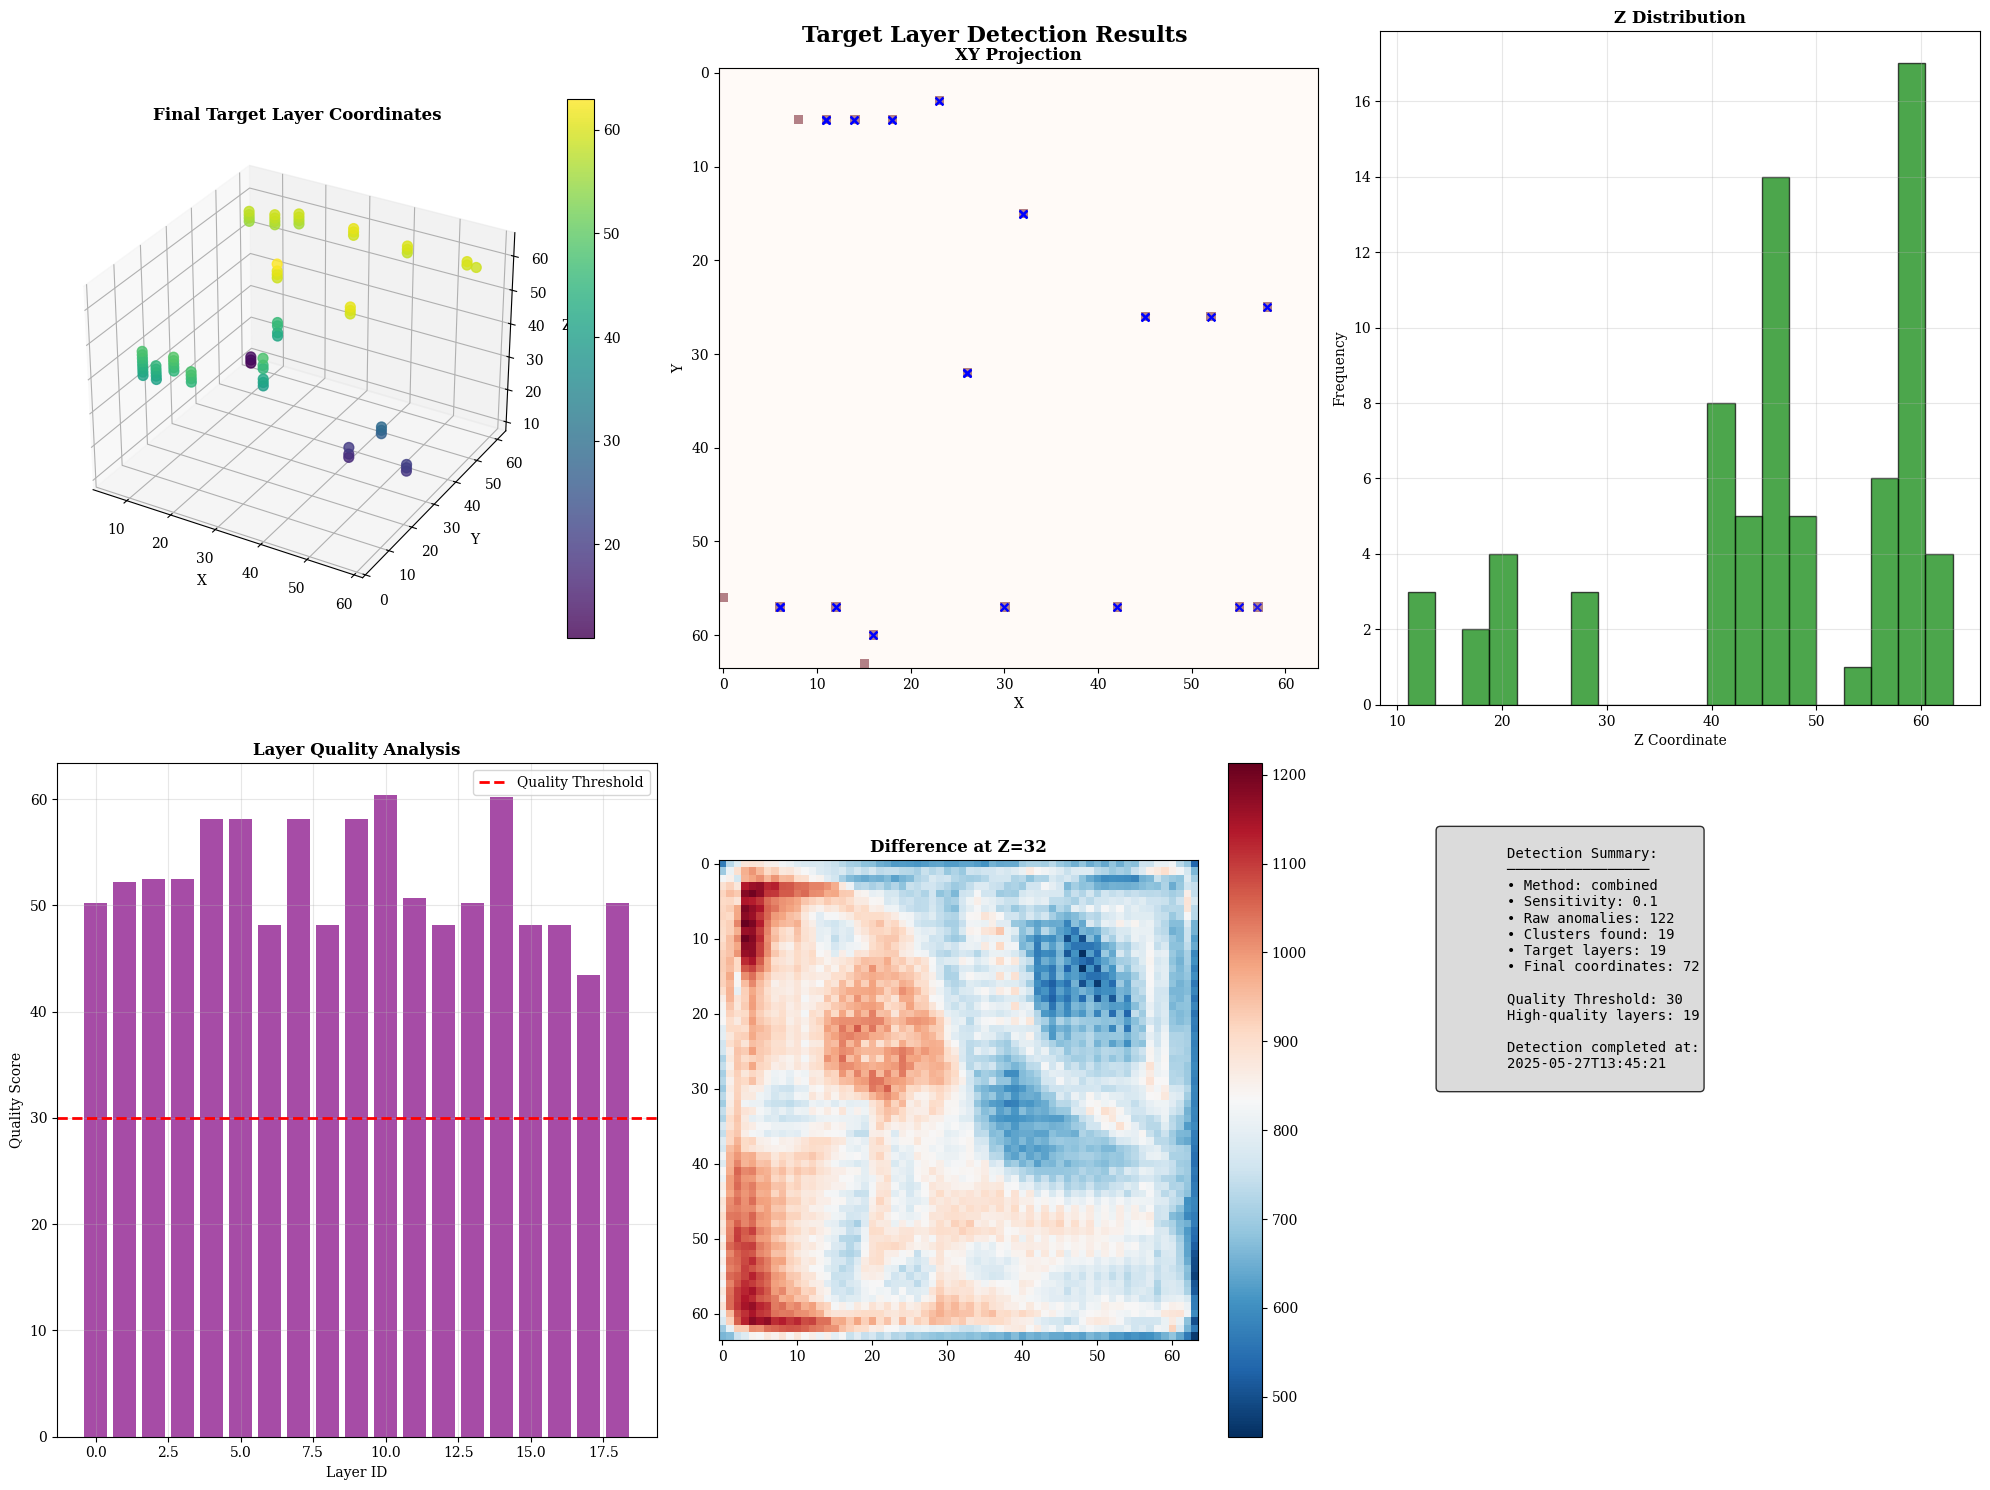

Results saved to target_detection_results_20250527_134522.json and target_detection_results_20250527_134522.pkl

FINAL TARGET LAYER DETECTION RESULTS
Total target coordinates: 72
3D mask shape: (64, 64, 64)
3D mask coverage: 72 voxels

Coordinate ranges:
  X: [6, 58]
  Y: [3, 60]
  Z: [11, 63]

First 10 coordinates:
  1: (14, 5, 41)
  2: (30, 57, 60)
  3: (12, 57, 57)
  4: (16, 60, 58)
  5: (55, 57, 59)
  6: (58, 25, 19)
  7: (45, 26, 61)
  8: (18, 5, 46)
  9: (52, 26, 29)
  10: (26, 32, 46)
  ... and 62 more


In [ ]:
# @title 获得Z坐标
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import json
from datetime import datetime

class AnomalyDetectionConfig:
    """异常检测配置类"""
    def __init__(self):
        # 默认参数
        self.method = 'combined'
        self.sensitivity = 0.1
        self.min_window_size = 5
        self.shift_threshold_percentile = 99
        self.min_correlation_drop = 0.1

        # XY检测参数
        self.xy_threshold_factor = 2.0
        self.xy_min_area = 5

        # 3D聚类参数
        self.cluster_distance = 3.0
        self.min_cluster_size = 3

        # 可视化参数
        self.visualization = True
        self.save_results = True

class TargetLayerDetector:
    """目标层三维坐标检测器"""

    def __init__(self, config=None):
        self.config = config if config else AnomalyDetectionConfig()
        self.detection_results = {}
        self.final_coordinates = []
        self.target_layers = []

    def load_optimal_parameters(self, param_file=None, param_dict=None):
        """
        载入最优参数

        Parameters:
        -----------
        param_file : str, optional
            参数文件路径
        param_dict : dict, optional
            参数字典
        """
        if param_file:
            try:
                with open(param_file, 'r') as f:
                    params = json.load(f)
                self._update_config(params)
                print(f"Parameters loaded from {param_file}")
            except Exception as e:
                print(f"Failed to load parameters from file: {e}")

        elif param_dict:
            self._update_config(param_dict)
            print("Parameters loaded from dictionary")
        else:
            print("Using default parameters")

        self._print_current_config()

    def _update_config(self, params):
        """更新配置参数"""
        for key, value in params.items():
            if hasattr(self.config, key):
                setattr(self.config, key, value)

    def _print_current_config(self):
        """打印当前配置"""
        print("\nCurrent Detection Configuration:")
        print("-" * 40)
        for attr in dir(self.config):
            if not attr.startswith('_'):
                print(f"  {attr}: {getattr(self.config, attr)}")
        print("-" * 40)

    def detect_target_layers(self, vp_t1, vp_t2, xy_mask):
        """
        检测目标层三维坐标

        Returns:
        --------
        target_coordinates : list
            目标层三维坐标列表 [(x, y, z), ...]
        layer_info : dict
            层信息详情
        """
        print("Starting target layer detection...")

        # 执行3D异常检测
        anomaly_coords, analysis = detect_z_coordinates_enhanced(
            vp_t1, vp_t2, xy_mask,
            method=self.config.method,
            sensitivity=self.config.sensitivity,
            min_window_size=self.config.min_window_size,
            visualization=False
        )

        self.detection_results = analysis

        if not anomaly_coords:
            print("No anomalies detected!")
            return [], {}

        print(f"Detected {len(anomaly_coords)} raw anomaly points")

        # 3D聚类分析
        clustered_layers = self._cluster_3d_anomalies(anomaly_coords)

        # 提取目标层
        target_layers = self._extract_target_layers(clustered_layers, vp_t1.shape)

        # 生成最终坐标标记
        final_coordinates = self._generate_final_coordinates(target_layers)

        # 保存结果
        layer_info = {
            'total_raw_points': len(anomaly_coords),
            'num_clusters': len(clustered_layers),
            'num_target_layers': len(target_layers),
            'final_coordinates': final_coordinates,
            'detection_config': vars(self.config),
            'timestamp': datetime.now().isoformat()
        }

        self.final_coordinates = final_coordinates
        self.target_layers = target_layers

        # 可视化结果
        if self.config.visualization:
            self.visualize_target_layers(vp_t1, vp_t2, xy_mask, final_coordinates, layer_info)

        # 保存结果
        if self.config.save_results:
            self.save_detection_results(layer_info)

        return final_coordinates, layer_info

    def _cluster_3d_anomalies(self, anomaly_coords):
        """3D聚类分析"""
        from sklearn.cluster import DBSCAN

        if len(anomaly_coords) < self.config.min_cluster_size:
            return [anomaly_coords]

        # 转换为numpy数组
        coords_array = np.array(anomaly_coords)

        # DBSCAN聚类
        clustering = DBSCAN(
            eps=self.config.cluster_distance,
            min_samples=self.config.min_cluster_size
        ).fit(coords_array)

        labels = clustering.labels_
        unique_labels = set(labels)

        clusters = []
        for label in unique_labels:
            if label != -1:  # 忽略噪声点
                cluster_points = coords_array[labels == label]
                clusters.append(cluster_points.tolist())

        print(f"Clustered into {len(clusters)} groups")
        return clusters

    def _extract_target_layers(self, clustered_layers, data_shape):
        """提取目标层"""
        target_layers = []

        for i, cluster in enumerate(clustered_layers):
            cluster_array = np.array(cluster)

            # 计算层的统计信息
            layer_info = {
                'id': i,
                'points': cluster,
                'center': np.mean(cluster_array, axis=0),
                'std': np.std(cluster_array, axis=0),
                'size': len(cluster),
                'z_range': [np.min(cluster_array[:, 2]), np.max(cluster_array[:, 2])],
                'xy_extent': {
                    'x_range': [np.min(cluster_array[:, 0]), np.max(cluster_array[:, 0])],
                    'y_range': [np.min(cluster_array[:, 1]), np.max(cluster_array[:, 1])]
                }
            }

            # 质量评估
            layer_info['quality_score'] = self._calculate_layer_quality(layer_info, data_shape)

            target_layers.append(layer_info)

        # 按质量分数排序
        target_layers.sort(key=lambda x: x['quality_score'], reverse=True)

        return target_layers

    def _calculate_layer_quality(self, layer_info, data_shape):
        """计算层质量分数"""
        score = 0

        # 大小分数 (更多点 = 更高分数)
        size_score = min(layer_info['size'] / 20, 1.0) * 30

        # 紧密度分数 (更紧密 = 更高分数)
        compactness = 1 / (1 + np.mean(layer_info['std']))
        compactness_score = compactness * 25

        # Z层厚度分数 (适中厚度 = 更高分数)
        z_thickness = layer_info['z_range'][1] - layer_info['z_range'][0]
        thickness_score = max(0, 20 - abs(z_thickness - 5)) * 2

        # 位置分数 (避免边界 = 更高分数)
        center = layer_info['center']
        boundary_penalty = 0
        for i, (coord, shape_dim) in enumerate(zip(center, data_shape)):
            if coord < shape_dim * 0.1 or coord > shape_dim * 0.9:
                boundary_penalty += 10

        score = size_score + compactness_score + thickness_score - boundary_penalty
        return max(0, score)

    def _generate_final_coordinates(self, target_layers):
        """生成最终坐标标记"""
        final_coords = []

        for layer in target_layers:
            if layer['quality_score'] > 30:  # 质量阈值
                # 添加所有高质量层的点
                final_coords.extend(layer['points'])

        # 去重
        final_coords = list(set(tuple(coord) for coord in final_coords))
        final_coords = [list(coord) for coord in final_coords]

        print(f"Generated {len(final_coords)} final coordinate marks")
        return final_coords

    def create_3d_mask(self, data_shape, coordinates=None):
        """
        创建三维掩膜

        Parameters:
        -----------
        data_shape : tuple
            数据形状 (H, W, D)
        coordinates : list, optional
            坐标列表，默认使用检测结果

        Returns:
        --------
        mask_3d : ndarray
            三维掩膜
        """
        if coordinates is None:
            coordinates = self.final_coordinates

        mask_3d = np.zeros(data_shape, dtype=bool)

        for coord in coordinates:
            x, y, z = coord
            if 0 <= x < data_shape[1] and 0 <= y < data_shape[0] and 0 <= z < data_shape[2]:
                mask_3d[y, x, z] = True

        return mask_3d

    def visualize_target_layers(self, vp_t1, vp_t2, xy_mask, final_coordinates, layer_info):
        """可视化目标层"""

        fig = plt.figure(figsize=(20, 15))

        # 1. 3D散点图
        ax1 = fig.add_subplot(2, 3, 1, projection='3d')
        if final_coordinates:
            coords_array = np.array(final_coordinates)
            scatter = ax1.scatter(coords_array[:, 0], coords_array[:, 1], coords_array[:, 2],
                                c=coords_array[:, 2], cmap='viridis', s=50, alpha=0.8)
            ax1.set_xlabel('X')
            ax1.set_ylabel('Y')
            ax1.set_zlabel('Z')
            ax1.set_title('Final Target Layer Coordinates', fontweight='bold')
            plt.colorbar(scatter, ax=ax1, shrink=0.8)

        # 2. XY投影
        ax2 = fig.add_subplot(2, 3, 2)
        ax2.imshow(xy_mask, cmap='Reds', alpha=0.5)
        if final_coordinates:
            coords_array = np.array(final_coordinates)
            ax2.scatter(coords_array[:, 0], coords_array[:, 1],
                       c='blue', s=30, alpha=0.8, marker='x')
        ax2.set_title('XY Projection', fontweight='bold')
        ax2.set_xlabel('X')
        ax2.set_ylabel('Y')

        # 3. Z分布直方图
        ax3 = fig.add_subplot(2, 3, 3)
        if final_coordinates:
            z_coords = [coord[2] for coord in final_coordinates]
            ax3.hist(z_coords, bins=20, alpha=0.7, color='green', edgecolor='black')
            ax3.set_xlabel('Z Coordinate')
            ax3.set_ylabel('Frequency')
            ax3.set_title('Z Distribution', fontweight='bold')
            ax3.grid(True, alpha=0.3)

        # 4. 层质量分析
        ax4 = fig.add_subplot(2, 3, 4)
        if self.target_layers:
            layer_ids = [layer['id'] for layer in self.target_layers]
            quality_scores = [layer['quality_score'] for layer in self.target_layers]
            bars = ax4.bar(layer_ids, quality_scores, alpha=0.7, color='purple')
            ax4.set_xlabel('Layer ID')
            ax4.set_ylabel('Quality Score')
            ax4.set_title('Layer Quality Analysis', fontweight='bold')
            ax4.grid(True, alpha=0.3)

            # 标记质量阈值
            ax4.axhline(y=30, color='red', linestyle='--', linewidth=2, label='Quality Threshold')
            ax4.legend()

        # 5. 数据差异切片
        ax5 = fig.add_subplot(2, 3, 5)
        if torch.is_tensor(vp_t1):
            vp_t1_np = vp_t1.detach().cpu().numpy()
            vp_t2_np = vp_t2.detach().cpu().numpy()
        else:
            vp_t1_np = vp_t1
            vp_t2_np = vp_t2

        diff_data = vp_t2_np - vp_t1_np
        mid_z = diff_data.shape[2] // 2
        im = ax5.imshow(diff_data[:, :, mid_z], cmap='RdBu_r')
        ax5.set_title(f'Difference at Z={mid_z}', fontweight='bold')
        plt.colorbar(im, ax=ax5)

        # 6. 统计信息文本
        ax6 = fig.add_subplot(2, 3, 6)
        ax6.axis('off')

        info_text = f"""
        Detection Summary:
        ─────────────────
        • Method: {self.config.method}
        • Sensitivity: {self.config.sensitivity}
        • Raw anomalies: {layer_info['total_raw_points']}
        • Clusters found: {layer_info['num_clusters']}
        • Target layers: {layer_info['num_target_layers']}
        • Final coordinates: {len(final_coordinates)}

        Quality Threshold: 30
        High-quality layers: {len([l for l in self.target_layers if l['quality_score'] > 30])}

        Detection completed at:
        {layer_info['timestamp'][:19]}
        """

        ax6.text(0.1, 0.9, info_text, transform=ax6.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

        plt.tight_layout()
        plt.suptitle('Target Layer Detection Results', fontsize=16, fontweight='bold', y=0.98)
        plt.show()

        return fig

    def save_detection_results(self, layer_info, filename=None):
        """保存检测结果"""
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"target_detection_results_{timestamp}"

        # 保存为JSON
        json_file = f"{filename}.json"
        with open(json_file, 'w') as f:
            # 转换numpy数组为列表以便JSON序列化
            serializable_info = self._make_json_serializable(layer_info)
            json.dump(serializable_info, f, indent=2)

        # 保存为pickle (保留完整数据结构)
        pickle_file = f"{filename}.pkl"
        with open(pickle_file, 'wb') as f:
            pickle.dump({
                'layer_info': layer_info,
                'target_layers': self.target_layers,
                'final_coordinates': self.final_coordinates,
                'config': self.config
            }, f)

        print(f"Results saved to {json_file} and {pickle_file}")

    def _make_json_serializable(self, obj):
        """使对象可JSON序列化"""
        if isinstance(obj, dict):
            return {k: self._make_json_serializable(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [self._make_json_serializable(v) for v in obj]
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        else:
            return obj

    def load_detection_results(self, filename):
        """载入检测结果"""
        try:
            with open(filename, 'rb') as f:
                data = pickle.load(f)

            self.target_layers = data['target_layers']
            self.final_coordinates = data['final_coordinates']
            self.config = data['config']

            print(f"Detection results loaded from {filename}")
            return data['layer_info']
        except Exception as e:
            print(f"Failed to load results: {e}")
            return None

# 使用示例
def main_detection_workflow(vp_new_1, vp_new_2, mask1):
    """主检测工作流程"""

    # 1. 创建检测器
    detector = TargetLayerDetector()

    # 2. 载入最优参数 (可以从文件或字典)
    optimal_params = {
        'method': 'combined',
        'sensitivity': 0.1,
        'min_window_size': 5,
        'cluster_distance': 2.5,
        'min_cluster_size': 3,
        'visualization': True,
        'save_results': True
    }

    detector.load_optimal_parameters(param_dict=optimal_params)

    # 3. 执行检测
    final_coordinates, layer_info = detector.detect_target_layers(vp_new_1, vp_new_2, mask1)

    # 4. 创建3D掩膜
    mask_3d = detector.create_3d_mask(vp_new_1.shape)

    # 5. 输出结果
    print("\n" + "="*60)
    print("FINAL TARGET LAYER DETECTION RESULTS")
    print("="*60)
    print(f"Total target coordinates: {len(final_coordinates)}")
    print(f"3D mask shape: {mask_3d.shape}")
    print(f"3D mask coverage: {np.sum(mask_3d)} voxels")

    if final_coordinates:
        coords_array = np.array(final_coordinates)
        print(f"\nCoordinate ranges:")
        print(f"  X: [{np.min(coords_array[:, 0])}, {np.max(coords_array[:, 0])}]")
        print(f"  Y: [{np.min(coords_array[:, 1])}, {np.max(coords_array[:, 1])}]")
        print(f"  Z: [{np.min(coords_array[:, 2])}, {np.max(coords_array[:, 2])}]")

        print(f"\nFirst 10 coordinates:")
        for i, coord in enumerate(final_coordinates[:10]):
            print(f"  {i+1}: ({coord[0]}, {coord[1]}, {coord[2]})")
        if len(final_coordinates) > 10:
            print(f"  ... and {len(final_coordinates)-10} more")

    return final_coordinates, mask_3d, layer_info, detector

# 执行完整检测流程
print("Starting complete target layer detection workflow...")
final_coords, mask_3d, detection_info, detector_obj = main_detection_workflow(
    pred_vp_1, pred_vp_2, mask1
)

# 可选：载入之前保存的结果
# detector_obj.load_detection_results("target_detection_results_20241201_143022.pkl")


In [ ]:
np.save(f_path+'/final_coords_8_to_11.npy', final_coords)

In [ ]:
# @title Default title text
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch

def convert_to_numpy(data):
    """
    将PyTorch tensor转换为numpy数组
    """
    if torch.is_tensor(data):
        return data.detach().cpu().numpy()
    return np.array(data)

def create_horizon_overlay(velocity_volume, final_coords, shape=None):
    """
    创建目标层位的叠加显示
    """
    velocity_volume = convert_to_numpy(velocity_volume)
    if shape is None:
        shape = velocity_volume.shape

    # 创建层位mask
    horizon_mask = np.zeros(shape, dtype=bool)

    for coord in final_coords:
        x, y, z = coord
        if 0 <= x < shape[0] and 0 <= y < shape[1] and 0 <= z < shape[2]:
            horizon_mask[x, y, z] = True

    return horizon_mask

def visualize_seismic_with_horizons(velocity_volume, final_coords):
    """
    专业地震数据可视化：速度体 + 目标层位
    """
    # 转换为numpy数组
    velocity_volume = convert_to_numpy(velocity_volume)
    final_coords = convert_to_numpy(final_coords)

    horizon_mask = create_horizon_overlay(velocity_volume, final_coords)

    # 使用Plotly进行3D可视化
    fig = go.Figure()

    # 创建坐标网格
    nx, ny, nz = velocity_volume.shape
    x, y, z = np.mgrid[0:nx, 0:ny, 0:nz]

    # 1. 添加速度体的等值面
    fig.add_trace(go.Volume(
        x=x.flatten(),
        y=y.flatten(),
        z=z.flatten(),
        value=velocity_volume.flatten(),
        isomin=float(velocity_volume.min()),  # 确保是Python float
        isomax=float(velocity_volume.max()),  # 确保是Python float
        opacity=0.1,  # 半透明显示背景速度体
        surface_count=3,
        colorscale='Viridis',
        name='Velocity Volume'
    ))

    # 2. 突出显示目标层位
    if len(final_coords) > 0:
        fig.add_trace(go.Scatter3d(
            x=final_coords[:, 0],
            y=final_coords[:, 1],
            z=final_coords[:, 2],
            mode='markers',
            marker=dict(
                size=3,
                color='red',
                symbol='circle',
                opacity=0.8
            ),
            name='Target Horizons'
        ))

    fig.update_layout(
        title='Seismic Velocity Volume with Target Horizons',
        scene=dict(
            xaxis_title='Inline',
            yaxis_title='Crossline',
            zaxis_title='Time/Depth'
        )
    )

    return fig

def create_seismic_slices_with_horizons(velocity_volume, final_coords):
    """
    创建带层位标记的地震切片显示
    """
    # 转换为numpy数组
    velocity_volume = convert_to_numpy(velocity_volume)
    final_coords = convert_to_numpy(final_coords)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Inline切片 (固定x)
    inline_slice = velocity_volume.shape[0] // 2
    im1 = axes[0,0].imshow(velocity_volume[inline_slice, :, :].T,
                          cmap='seismic', aspect='auto', origin='upper')
    # 标记该切片上的层位点
    inline_horizons = final_coords[final_coords[:, 0] == inline_slice]
    if len(inline_horizons) > 0:
        axes[0,0].scatter(inline_horizons[:, 1], inline_horizons[:, 2],
                         c='red', s=20, marker='o', alpha=0.8)
    axes[0,0].set_title(f'Inline {inline_slice}')
    axes[0,0].set_xlabel('Crossline')
    axes[0,0].set_ylabel('Time/Depth')
    plt.colorbar(im1, ax=axes[0,0])

    # Crossline切片 (固定y)
    crossline_slice = velocity_volume.shape[1] // 2
    im2 = axes[0,1].imshow(velocity_volume[:, crossline_slice, :].T,
                          cmap='seismic', aspect='auto', origin='upper')
    crossline_horizons = final_coords[final_coords[:, 1] == crossline_slice]
    if len(crossline_horizons) > 0:
        axes[0,1].scatter(crossline_horizons[:, 0], crossline_horizons[:, 2],
                         c='red', s=20, marker='o', alpha=0.8)
    axes[0,1].set_title(f'Crossline {crossline_slice}')
    axes[0,1].set_xlabel('Inline')
    axes[0,1].set_ylabel('Time/Depth')
    plt.colorbar(im2, ax=axes[0,1])

    # 时间切片 (固定z)
    time_slice = velocity_volume.shape[2] // 2
    im3 = axes[1,0].imshow(velocity_volume[:, :, time_slice],
                          cmap='seismic', aspect='auto')
    time_horizons = final_coords[final_coords[:, 2] == time_slice]
    if len(time_horizons) > 0:
        axes[1,0].scatter(time_horizons[:, 1], time_horizons[:, 0],
                         c='red', s=20, marker='o', alpha=0.8)
    axes[1,0].set_title(f'Time Slice {time_slice}')
    axes[1,0].set_xlabel('Crossline')
    axes[1,0].set_ylabel('Inline')
    plt.colorbar(im3, ax=axes[1,0])

    # 层位分布统计
    if len(final_coords) > 0:
        h = axes[1,1].hist2d(final_coords[:, 0], final_coords[:, 1],
                           bins=20, cmap='Reds', alpha=0.7)
        plt.colorbar(h[3], ax=axes[1,1])
    axes[1,1].set_title('Horizon Distribution (Map View)')
    axes[1,1].set_xlabel('Inline')
    axes[1,1].set_ylabel('Crossline')

    plt.tight_layout()
    return fig

def analyze_horizon_properties(velocity_volume, final_coords):
    """
    分析目标层位的地震属性
    """
    # 转换为numpy数组
    velocity_volume = convert_to_numpy(velocity_volume)
    final_coords = convert_to_numpy(final_coords)

    if len(final_coords) == 0:
        print("No horizon coordinates provided!")
        return None, None

    # 提取层位处的速度值
    horizon_velocities = []
    valid_coords = []

    for coord in final_coords:
        x, y, z = coord
        if (0 <= x < velocity_volume.shape[0] and
            0 <= y < velocity_volume.shape[1] and
            0 <= z < velocity_volume.shape[2]):
            horizon_velocities.append(velocity_volume[int(x), int(y), int(z)])
            valid_coords.append(coord)

    if len(horizon_velocities) == 0:
        print("No valid horizon coordinates found!")
        return None, None

    horizon_velocities = np.array(horizon_velocities)
    valid_coords = np.array(valid_coords)

    # 创建属性分析图
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. 层位深度分布
    axes[0,0].hist(valid_coords[:, 2], bins=20, alpha=0.7, color='blue')
    axes[0,0].set_title('Horizon Depth Distribution')
    axes[0,0].set_xlabel('Depth/Time')
    axes[0,0].set_ylabel('Frequency')

    # 2. 层位速度分布
    axes[0,1].hist(horizon_velocities, bins=20, alpha=0.7, color='green')
    axes[0,1].set_title('Velocity at Horizons')
    axes[0,1].set_xlabel('Velocity')
    axes[0,1].set_ylabel('Frequency')

    # 3. 速度vs深度散点图
    axes[0,2].scatter(valid_coords[:, 2], horizon_velocities, alpha=0.6)
    axes[0,2].set_title('Velocity vs Depth')
    axes[0,2].set_xlabel('Depth/Time')
    axes[0,2].set_ylabel('Velocity')

    # 4. 层位空间分布
    scatter = axes[1,0].scatter(valid_coords[:, 0], valid_coords[:, 1],
                               c=valid_coords[:, 2], cmap='viridis', s=30)
    axes[1,0].set_title('Horizon Spatial Distribution')
    axes[1,0].set_xlabel('Inline')
    axes[1,0].set_ylabel('Crossline')
    plt.colorbar(scatter, ax=axes[1,0], label='Depth/Time')

    # 5. 速度属性分布
    scatter2 = axes[1,1].scatter(valid_coords[:, 0], valid_coords[:, 1],
                                c=horizon_velocities, cmap='RdBu', s=30)
    axes[1,1].set_title('Velocity Distribution at Horizons')
    axes[1,1].set_xlabel('Inline')
    axes[1,1].set_ylabel('Crossline')
    plt.colorbar(scatter2, ax=axes[1,1], label='Velocity')

    # 6. 统计信息
    axes[1,2].text(0.1, 0.8, f'Total Horizon Points: {len(valid_coords)}',
                   transform=axes[1,2].transAxes, fontsize=12)
    axes[1,2].text(0.1, 0.7, f'Depth Range: {valid_coords[:, 2].min():.1f} - {valid_coords[:, 2].max():.1f}',
                   transform=axes[1,2].transAxes, fontsize=12)
    axes[1,2].text(0.1, 0.6, f'Velocity Range: {horizon_velocities.min():.1f} - {horizon_velocities.max():.1f}',
                   transform=axes[1,2].transAxes, fontsize=12)
    axes[1,2].text(0.1, 0.5, f'Mean Velocity: {horizon_velocities.mean():.1f}',
                   transform=axes[1,2].transAxes, fontsize=12)
    axes[1,2].text(0.1, 0.4, f'Std Velocity: {horizon_velocities.std():.1f}',
                   transform=axes[1,2].transAxes, fontsize=12)
    axes[1,2].set_title('Horizon Statistics')
    axes[1,2].axis('off')

    plt.tight_layout()
    return fig, horizon_velocities

# 简化版本的可视化（如果Plotly Volume有问题）
def simple_3d_visualization(velocity_volume, final_coords):
    """
    简化的3D可视化，避免Volume问题
    """
    velocity_volume = convert_to_numpy(velocity_volume)
    final_coords = convert_to_numpy(final_coords)

    fig = go.Figure()

    # 只显示层位点
    if len(final_coords) > 0:
        fig.add_trace(go.Scatter3d(
            x=final_coords[:, 0],
            y=final_coords[:, 1],
            z=final_coords[:, 2],
            mode='markers',
            marker=dict(
                size=4,
                color=final_coords[:, 2],  # 按深度着色
                colorscale='Viridis',
                opacity=0.8,
                showscale=True,
                colorbar=dict(title="Depth/Time")
            ),
            name='Target Horizons'
        ))

    # 添加一些速度等值面的采样点
    nx, ny, nz = velocity_volume.shape
    step = max(1, min(nx, ny, nz) // 10)  # 采样步长

    sample_coords = []
    sample_values = []

    for i in range(0, nx, step):
        for j in range(0, ny, step):
            for k in range(0, nz, step):
                sample_coords.append([i, j, k])
                sample_values.append(velocity_volume[i, j, k])

    sample_coords = np.array(sample_coords)
    sample_values = np.array(sample_values)

    fig.add_trace(go.Scatter3d(
        x=sample_coords[:, 0],
        y=sample_coords[:, 1],
        z=sample_coords[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=sample_values,
            colorscale='RdBu',
            opacity=0.3,
            showscale=False
        ),
        name='Velocity Samples'
    ))

    fig.update_layout(
        title='Seismic Data with Target Horizons',
        scene=dict(
            xaxis_title='Inline',
            yaxis_title='Crossline',
            zaxis_title='Time/Depth'
        )
    )

    return fig


# 使用修正后的函数
try:
    # 尝试完整的3D可视化
    fig1 = visualize_seismic_with_horizons(vp_new_1, final_coords)
    fig1.show()
except Exception as e:
    print(f"3D Volume visualization failed: {e}")
    print("Using simplified visualization...")
    # 使用简化版本
    fig1 = simple_3d_visualization(vp_new_1, final_coords)
    fig1.show()

# 创建切片显示
fig2 = create_seismic_slices_with_horizons(vp_new_1, final_coords)
plt.show()

# 属性分析
fig3, horizon_velocities = analyze_horizon_properties(vp_new_1, final_coords)
if fig3 is not None:
    plt.show()

plt.show()

Output hidden; open in https://colab.research.google.com to view.